In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install pyvista open3d  trimesh

In [ ]:
# ============================================
# VIDEO TO 3D MESH - COLMAP Pipeline (Refactored)
# ============================================
# Key Improvements:
# - Config dataclass for all settings.
# - SequenceProcessor class to encapsulate logic.
# - Robust PLY reading via Open3D.
# - Resumability (`skip_existing`).
# - More explicit path handling and error checks.
# ============================================
print(">>> VIDEO TO MESH PIPELINE STARTED (REFACTORED) <<<")

# 0) Mount Drive + Install dependencies
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, shutil, subprocess, json, time, struct
from pathlib import Path
from typing import List, Optional, Tuple
from dataclasses import dataclass, field

import numpy as np
import torch
import pyvista as pv
from PIL import Image, ImageOps
import open3d as o3d # For robust PLY reading

# Install system deps
print("Installing dependencies (ffmpeg, colmap, pyvista)...")
!apt-get -qq update
!apt-get -qq install -y ffmpeg colmap >/dev/null 2>&1
!pip -q install pyvista panel trame pillow open3d

# --- CONFIGURATION ---------------------------------------------------

@dataclass
class Config:
    """Holds all pipeline configuration."""
    # Paths
    videos_root: Path = Path("/content/drive/MyDrive/Matreskas/Videos")
    out_root: Path = Path("/content/drive/MyDrive/Matreskas/mesh_outputtest")
    colmap_exe: str = "colmap"  # Assumes colmap is in system PATH

    # Frame extraction
    extract_fps: int = 2
    max_frames: int = 100
    frame_quality: int = 2
    resize_width: Optional[int] = 1920

    # COLMAP
    max_image_size: int = 1600
    sift_max_features: int = 8000
    mapper_num_threads: int = 8
    matcher_num_threads: int = 8

    # Dense Stereo
    use_dense_stereo: bool = True
    patchmatch_gpu_index: int = 0

    # Behavior
    skip_existing: bool = True # If True, skips sequences where final mesh exists
    cleanup_frames: bool = True

    # Optional: pre-defined mapping
    preferred_video: dict = field(default_factory=lambda: {
        "Political": "IMG_4799.MOV", "Drafted": "IMG_5097.mov",
        "Non-authentic": "IMG_5202.MOV", "Russian_Authentic": "IMG_4787.MOV",
        "Artistic": "IMG_5267.MOV", "Religious": "IMG_4806.MOV",
        "Merchandise": "IMG_5212.MOV", "Non-Matreskas": "IMG_5392.MOV",
    })

# --- UTILS & HELPERS -------------------------------------------------

def log(msg: str):
    print(f"[{time.strftime('%H:%M:%S')}] {msg}", flush=True)

def run(cmd: list, cwd: Optional[Path] = None, check: bool = True, label: str = "") -> bool:
    """Runs a shell command with logging. Returns True on success."""
    prefix = f"[{label}] " if label else ""
    log(prefix + "RUN: " + " ".join(cmd))

    env = os.environ.copy()
    env["QT_QPA_PLATFORM"] = "offscreen"
    env["DISPLAY"] = ""

    p = subprocess.run(cmd, cwd=cwd, text=True, capture_output=True, env=env)

    if p.stdout.strip():
        interesting_lines = [line for line in p.stdout.split("\n") if any(
            kw in line.lower() for kw in ["error", "warning", "elapsed", "registered", "points", "images", "frame="]
        )]
        if interesting_lines:
            print(f"{prefix}   → " + "\n   → ".join(interesting_lines))

    if p.returncode != 0:
        if p.stderr.strip():
            print(f"{prefix}STDERR (tail):\n" + p.stderr[-2000:])
        if check:
            print(f"{prefix}Command failed with exit code {p.returncode}")
            return False
    return True

# --- CORE PIPELINE LOGIC (ENCAPSULATED) ------------------------------

class SequenceProcessor:
    def __init__(self, video_path: Path, config: Config):
        self.video_path = video_path
        self.config = config
        self.class_name = video_path.parent.name
        self.seq_id = f"{self.class_name}__{video_path.stem}"

        # Setup paths
        self.seq_root = config.out_root / self.seq_id
        self.frames_dir = self.seq_root / "frames"
        self.vis_dir = self.seq_root / "visualizations"
        self.sparse_dir = self.seq_root / "sparse"
        self.dense_dir = self.seq_root / "dense"
        self.db_path = self.seq_root / "database.db"

        # Define final output paths for resumability check
        self.final_mesh_path = self.seq_root / "mesh_poisson.ply"
        self.sparse_ply_path = self.seq_root / "sparse.ply"

    def _is_complete(self) -> bool:
        """Check if the main outputs already exist."""
        return self.config.skip_existing and self.final_mesh_path.exists()

    def run(self):
        log("=" * 70)
        log(f"PROCESSING SEQUENCE: {self.seq_id}")
        log("=" * 70)

        if self._is_complete():
            log("✅ Skipping, final mesh already exists. (Use --skip_existing=False to override)")
            return

        try:
            self.seq_root.mkdir(parents=True, exist_ok=True)

            frames = self._extract_frames()
            if not frames: return

            self._run_colmap_reconstruction(frames)
            self._visualize_results()

            log(f"✅ FINISHED SEQUENCE: {self.seq_id}")

        except Exception as e:
            log(f"❌ FATAL ERROR processing {self.seq_id}: {e}")
            import traceback
            traceback.print_exc()
        finally:
            if self.config.cleanup_frames and self.frames_dir.exists():
                log(f"Cleaning up frames for {self.seq_id}...")
                shutil.rmtree(self.frames_dir)

    def _extract_frames(self) -> List[Path]:
        log(f"📹 Extracting frames from: {self.video_path.name}")
        if self.frames_dir.exists(): shutil.rmtree(self.frames_dir)
        self.frames_dir.mkdir(parents=True)

        ffmpeg_cmd = [
            "ffmpeg", "-i", str(self.video_path), "-q:v", str(self.config.frame_quality),
            "-frames:v", str(self.config.max_frames), "-start_number", "0"
        ]
        filters = [f"fps={self.config.extract_fps}"]
        if self.config.resize_width:
            filters.append(f"scale={self.config.resize_width}:-1")
        ffmpeg_cmd.extend(["-vf", ",".join(filters)])
        ffmpeg_cmd.append(str(self.frames_dir / "frame_%04d.jpg"))

        if not run(ffmpeg_cmd, label="ffmpeg"):
            raise RuntimeError("FFmpeg frame extraction failed.")

        frames = sorted(self.frames_dir.glob("frame_*.jpg"))
        log(f"✅ Extracted {len(frames)} frames.")
        return frames

    def _run_colmap_reconstruction(self, frames: List[Path]):
        log("🚀 Starting COLMAP reconstruction...")
        self.sparse_dir.mkdir(exist_ok=True)
        self.dense_dir.mkdir(exist_ok=True)

        # 1. Feature Extraction
        if not run([
            self.config.colmap_exe, "feature_extractor", "--database_path", str(self.db_path),
            "--image_path", str(self.frames_dir), "--SiftExtraction.use_gpu", "0",
            "--SiftExtraction.max_num_features", str(self.config.sift_max_features)
        ], label="feature_extractor"):
            raise RuntimeError("Feature extraction failed.")

        # 2. Feature Matching
        matched = run([
            self.config.colmap_exe, "sequential_matcher", "--database_path", str(self.db_path),
            "--SiftMatching.use_gpu", "0", "--SequentialMatching.overlap", "20"
        ], check=False, label="sequential_matcher")
        if not matched:
            log("Sequential matcher failed; trying exhaustive...")
            if not run([self.config.colmap_exe, "exhaustive_matcher", "--database_path", str(self.db_path),
                        "--SiftMatching.use_gpu", "0", "--SiftMatching.num_threads", str(self.config.matcher_num_threads)],
                       label="exhaustive_matcher"):
                raise RuntimeError("Both matchers failed.")

        # 3. Sparse Reconstruction
        if not run([
            self.config.colmap_exe, "mapper", "--database_path", str(self.db_path),
            "--image_path", str(self.frames_dir), "--output_path", str(self.sparse_dir),
            "--Mapper.num_threads", str(self.config.mapper_num_threads)
        ], label="mapper"):
            raise RuntimeError("Sparse reconstruction (mapper) failed.")

        models = sorted(self.sparse_dir.iterdir(), key=lambda d: len(list(d.glob("images*.bin"))), reverse=True)
        model_dir = next((d for d in models if d.is_dir()), None)
        if not model_dir:
            raise RuntimeError("No sparse model directory found.")
        log(f"Using sparse model: {model_dir.name}")

        run([self.config.colmap_exe, "model_converter", "--input_path", str(model_dir),
             "--output_path", str(self.sparse_ply_path), "--output_type", "PLY"], label="model_converter")

        # 4. Dense Reconstruction (if enabled and sparse model is good)
        dense_ply_path = self.dense_dir / "fused.ply"
        if self.config.use_dense_stereo:
            # 4a. Undistort
            if not run([self.config.colmap_exe, "image_undistorter", "--image_path", str(self.frames_dir),
                        "--input_path", str(model_dir), "--output_path", str(self.dense_dir),
                        "--max_image_size", str(self.config.max_image_size)], label="undistorter"):
                log("⚠️ Undistortion failed. Skipping dense reconstruction.")
                return

            # 4b. PatchMatch Stereo
            pm_cmd = [self.config.colmap_exe, "patch_match_stereo", "--workspace_path", str(self.dense_dir),
                      "--workspace_format", "COLMAP", "--PatchMatchStereo.geom_consistency", "1"]
            if torch.cuda.is_available():
                pm_cmd.extend(["--PatchMatchStereo.gpu_index", str(self.config.patchmatch_gpu_index)])
                log(f"Running PatchMatch Stereo on GPU {self.config.patchmatch_gpu_index}")
            else:
                log("⚠️ No GPU detected; skipping dense stereo.")
                return

            run(pm_cmd, check=False, label="patch_match_stereo") # Don't check, fusion might still work

            # 4c. Stereo Fusion
            run([self.config.colmap_exe, "stereo_fusion", "--workspace_path", str(self.dense_dir),
                 "--workspace_format", "COLMAP", "--input_type", "geometric",
                 "--output_path", str(dense_ply_path)], check=False, label="stereo_fusion")

        # 5. Meshing
        final_mesh = self.sparse_ply_path # Default to sparse
        if dense_ply_path.exists() and dense_ply_path.stat().st_size > 10000:
            poisson_path = self.seq_root / "mesh_poisson.ply"
            if run([self.config.colmap_exe, "poisson_mesher", "--input_path", str(dense_ply_path),
                    "--output_path", str(poisson_path), "--PoissonMesher.depth", "10"],
                   check=False, label="poisson_mesher"):
                log("✅ Poisson mesh created.")
                final_mesh = poisson_path

        if final_mesh.exists():
            log(f"Final mesh is: {final_mesh.name}")
            # Create a symlink for consistency
            if self.final_mesh_path.exists(): self.final_mesh_path.unlink()
            self.final_mesh_path.symlink_to(final_mesh)
        else:
            log("⚠️ No dense mesh created. Using sparse point cloud as final output.")
            if self.final_mesh_path.exists(): self.final_mesh_path.unlink()
            self.final_mesh_path.symlink_to(self.sparse_ply_path)


    def _visualize_results(self):
        self.vis_dir.mkdir(exist_ok=True)
        # Visualize sparse cloud with Open3D (more robust)
        if self.sparse_ply_path.exists():
            log(f"📈 Visualizing sparse cloud: {self.sparse_ply_path.name}")
            try:
                pcd = o3d.io.read_point_cloud(str(self.sparse_ply_path))
                if pcd.has_points():
                    o3d.visualization.draw_geometries([pcd], window_name=f"Sparse Cloud - {self.seq_id}")
                    o3d.io.write_point_cloud(str(self.seq_root / "sparse_cloud_open3d.ply"), pcd)
            except Exception as e:
                log(f"Could not visualize with Open3D: {e}")

        # Visualize final mesh with PyVista
        if self.final_mesh_path.exists():
            log(f"🎨 Creating PyVista snapshots for: {self.final_mesh_path.name}")
            try:
                pv.set_plot_theme("document")
                plotter = pv.Plotter(off_screen=True, window_size=[600, 600])
                mesh = pv.read(str(self.final_mesh_path))
                plotter.add_mesh(mesh, color='white', smooth_shading=True, specular=0.5)
                plotter.camera.zoom(1.2)

                views = {'xy': '01_front.png', 'xz': '02_side.png', 'yz': '03_top.png'}
                for view, filename in views.items():
                    plotter.camera_position = view
                    if 'xz' in view: plotter.camera.azimuth = 90 # Better side view
                    plotter.screenshot(self.vis_dir / filename)
                plotter.close()

                # Display composite
                pil_images = [Image.open(p) for p in sorted(self.vis_dir.glob("*.png"))]
                if pil_images:
                    composite = Image.new("RGB", (sum(i.width for i in pil_images) + 10*(len(pil_images)-1), pil_images[0].height), "white")
                    x_off = 0
                    for im in pil_images:
                        composite.paste(im, (x_off, 0))
                        x_off += im.width + 10
                    display(composite)

            except Exception as e:
                log(f"PyVista visualization failed: {e}")

# --- MAIN EXECUTION --------------------------------------------------

def main():
    config = Config()
    # Sanity checks
    if not run([config.colmap_exe, "-h"], check=False):
        raise RuntimeError("COLMAP executable not found. Check `colmap_exe` in Config.")
    if not config.videos_root.exists():
        raise RuntimeError(f"VIDEOS_ROOT does not exist: {config.videos_root}")

    config.out_root.mkdir(parents=True, exist_ok=True)

    classes = sorted([d for d in config.videos_root.iterdir() if d.is_dir()])
    log(f"Found {len(classes)} classes: {[d.name for d in classes]}")

    for class_dir in classes:
        video_path = class_dir / config.preferred_video.get(class_dir.name, "")
        if not video_path.exists(): # Fallback if preferred not found
            vids = list(class_dir.glob("*.MOV")) + list(class_dir.glob("*.mov")) + list(class_dir.glob("*.mp4"))
            if vids:
                video_path = sorted(vids)[0]

        if video_path.exists():
            processor = SequenceProcessor(video_path, config)
            processor.run()
        else:
            log(f"[WARN] No video found for class: {class_dir.name}")

    print("\n>>> PIPELINE FINISHED <<<")
    print("Results per class under:", config.out_root)

if __name__ == "__main__":
    main()

In [ ]:
# ============================================
# VIDEO TO 3D MESH - COLMAP Pipeline (MULTI-CLASS v3)
# One reconstruction per Matreska class
# ============================================

print(">>> VIDEO TO MESH PIPELINE STARTED (MULTI-CLASS) <<<")

# 0) Mount Drive + Install dependencies
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, shutil, subprocess, json, time, struct
from pathlib import Path
from typing import List, Optional

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from PIL import Image, ImageOps

import torch

# Install system deps
print("Installing dependencies (ffmpeg, colmap, pyvista)...")
!apt-get -qq update
!apt-get -qq install -y ffmpeg colmap >/dev/null 2>&1

# Install pyvista and panel/trame for offscreen rendering
!pip -q install pyvista panel trame pillow

import pyvista as pv

# --- COLMAP executable (from apt) ---
COLMAP_EXE = "colmap"
# Sanity check
!$COLMAP_EXE -h > /dev/null
print("✅ COLMAP (apt) available.")

# GPU check
if torch.cuda.is_available():
    print(f"✅ GPU available: {torch.cuda.get_device_name(0)}")
    print(f"    Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    HAS_GPU = True
else:
    print("⚠️ No GPU detected, dense stereo may fail.")
    HAS_GPU = False

# 1) GLOBAL CONFIG --------------------------------------------------------
VIDEOS_ROOT = Path("/content/drive/MyDrive/Matreskas/Videos")
OUT_ROOT    = Path("/content/mesh_output")      # per-sequence subfolders inside

# Frame extraction settings
EXTRACT_FPS    = 2       # Extract N frames per second
MAX_FRAMES     = 100     # Maximum frames to extract
FRAME_QUALITY  = 2       # JPEG quality (1-31, lower is better)
RESIZE_WIDTH   = 1920    # Resize frames to this width (None = keep original)

# COLMAP settings
MAX_IMAGE_SIZE   = 1600      # Max size for reconstruction
SIFT_MAX_FEATURES = 8000     # SIFT features per image

# Dense stereo / PatchMatch
USE_DENSE_STEREO      = True
PATCHMATCH_GPU_INDEX  = 0     # GPU index to use (0 if one GPU)

# Optional: pre-defined mapping (if you want specific videos per class)
# If a class is not in this dict, we will just pick the first video.
PREFERRED_VIDEO = {
    "Political":         "IMG_4799.MOV",
    "Drafted":           "IMG_5097.mov",
    "Non-authentic":     "IMG_5202.MOV",
    "Russian_Authentic": "IMG_4787.MOV",
    "Artistic":          "IMG_5267.MOV",
    "Religious":         "IMG_4806.MOV",
    "Merchandise":       "IMG_5212.MOV",
    "Non-Matreskas":     "IMG_5392.MOV",
}


# 2) UTILS ---------------------------------------------------------------

def log(msg: str):
    print(f"[{time.strftime('%H:%M:%S')}] {msg}", flush=True)

def run(cmd, cwd=None, check=True, show_output=False, label: str = ""):
    """
    Run a shell command with basic logging.
    Returns True on success, False otherwise.
    """
    if isinstance(cmd, str):
        cmd = cmd.split()

    if cmd[0] == "colmap":
        cmd[0] = COLMAP_EXE

    prefix = f"[{label}] " if label else ""
    log(prefix + "RUN: " + " ".join(cmd))

    # Headless
    env = os.environ.copy()
    env["QT_QPA_PLATFORM"] = "offscreen"
    env["DISPLAY"] = ""

    p = subprocess.run(
        cmd,
        cwd=cwd,
        text=True,
        capture_output=True,
        env=env
    )

    if p.stdout.strip():
        if show_output:
            print(p.stdout)
        else:
            # Only show interesting lines
            for line in p.stdout.split("\n"):
                if any(
                    kw in line.lower()
                    for kw in ["error", "warning", "elapsed", "registered",
                               "points", "images", "frame="]
                ):
                    print("   →", line)

    if p.returncode != 0 and p.stderr.strip():
        print("STDERR (tail):\n" + p.stderr[-2000:])

    if check and p.returncode != 0:
        print(f"[{label}] Command failed with exit code {p.returncode}")
        return False

    return p.returncode == 0 or not check


# 3) FRAME EXTRACTION ----------------------------------------------------

def extract_frames_from_video(video_path: Path, output_dir: Path) -> List[Path]:
    """
    Extract frames from the video into output_dir.
    Returns the list of frames.
    """
    log(f"📹 Extracting frames from video: {video_path.name}")

    if output_dir.exists():
        shutil.rmtree(output_dir)
    output_dir.mkdir(parents=True)

    # Probe video for duration
    probe_cmd = [
        "ffprobe", "-v", "error",
        "-select_streams", "v:0",
        "-count_packets", "-show_entries",
        "stream=nb_read_packets,r_frame_rate,duration",
        "-of", "json", str(video_path)
    ]
    probe = subprocess.run(probe_cmd, capture_output=True, text=True)
    if probe.returncode == 0:
        try:
            info = json.loads(probe.stdout)
            if info.get("streams"):
                stream = info["streams"][0]
                duration = float(stream.get("duration", 0))
                log(f"  Video duration: {duration:.1f} s")
                log(f"  ~{int(duration * EXTRACT_FPS)} frames at {EXTRACT_FPS} fps (capped at {MAX_FRAMES})")
        except Exception:
            pass

    # Build ffmpeg command
    ffmpeg_cmd = [
        "ffmpeg",
        "-i", str(video_path),
        "-q:v", str(FRAME_QUALITY),
        "-frames:v", str(MAX_FRAMES),
        "-start_number", "0"
    ]

    # Filters: FPS + optional resize
    filters = [f"fps={EXTRACT_FPS}"]
    if RESIZE_WIDTH:
        filters.append(f"scale={RESIZE_WIDTH}:-1")
    ffmpeg_cmd.extend(["-vf", ",".join(filters)])

    ffmpeg_cmd.append(str(output_dir / "frame_%04d.jpg"))

    if not run(ffmpeg_cmd, show_output=True, label="ffmpeg"):
        raise RuntimeError("FFmpeg frame extraction failed.")

    frames = sorted(output_dir.glob("frame_*.jpg"))
    log(f"✅ Extracted {len(frames)} frames")
    if frames:
        sample = Image.open(frames[0])
        log(f"  Frame size: {sample.size[0]} x {sample.size[1]}")
    return frames


# 4) COLMAP RECONSTRUCTION PER SEQUENCE ---------------------------------

def run_colmap_reconstruction(frames_dir: Path, seq_root: Path) -> tuple[Path, Optional[Path], Optional[Path]]:
    """
    Run COLMAP SfM + (optionally) dense reconstruction + meshing
    for a single sequence.

    Returns:
      (seq_root, final_mesh_path, sparse_ply_path)
    """
    log(f"🚀 Starting COLMAP reconstruction for {seq_root.name}")

    sparse_dir = seq_root / "sparse"
    dense_dir  = seq_root / "dense"
    db_path    = seq_root / "database.db"

    for d in [sparse_dir, dense_dir]:
        d.mkdir(parents=True, exist_ok=True)

    # Step 1: Feature extraction (CPU)
    log("Step 1/7: Feature extraction (CPU)")
    if not run([
        "colmap", "feature_extractor",
        "--database_path", str(db_path),
        "--image_path", str(frames_dir),
        "--SiftExtraction.use_gpu", "0",
        "--SiftExtraction.max_num_features", str(SIFT_MAX_FEATURES),
        "--SiftExtraction.first_octave", "0",
        "--ImageReader.single_camera", "1",
        "--ImageReader.camera_model", "SIMPLE_PINHOLE"
    ], label="feature_extractor"):
        raise RuntimeError("Feature extraction failed.")

    # Step 2: Matching (try sequential, fallback to exhaustive)
    log("Step 2/7: Feature matching")
    matched = run([
        "colmap", "sequential_matcher",
        "--database_path", str(db_path),
        "--SiftMatching.use_gpu", "0",
        "--SequentialMatching.overlap", "20",
        "--SequentialMatching.loop_detection", "0"
    ], check=False, label="sequential_matcher")

    if not matched:
        log("Sequential matcher failed; trying exhaustive matcher...")
        if not run([
            "colmap", "exhaustive_matcher",
            "--database_path", str(db_path),
            "--SiftMatching.use_gpu", "0",
            "--SiftMatching.num_threads", "8"
        ], label="exhaustive_matcher"):
            raise RuntimeError("Both sequential and exhaustive matchers failed.")

    # Step 3: Sparse reconstruction
    log("Step 3/7: Sparse reconstruction (mapper)")
    if not run([
        "colmap", "mapper",
        "--database_path", str(db_path),
        "--image_path", str(frames_dir),
        "--output_path", str(sparse_dir),
        "--Mapper.num_threads", "8",
        "--Mapper.init_min_num_inliers", "100",
        "--Mapper.init_max_error", "4",
    ], label="mapper"):
        raise RuntimeError("Sparse reconstruction (mapper) failed.")

    # Select sparse model folder ("0" usually)
    models = [d for d in sparse_dir.iterdir() if d.is_dir() and any(d.iterdir())]
    if not models:
        raise RuntimeError("No sparse model generated.")
    model_dir = models[0]
    log(f"  Using sparse model: {model_dir.name}")

    # Export sparse PLY
    sparse_ply = seq_root / "sparse.ply"
    log("Exporting sparse point cloud to sparse.ply")
    run([
        "colmap", "model_converter",
        "--input_path", str(model_dir),
        "--output_path", str(sparse_ply),
        "--output_type", "PLY"
    ], check=False, label="model_converter")

    dense_ply = None

    # Step 4: Undistort
    log("Step 4/7: Image undistortion")
    if not run([
        "colmap", "image_undistorter",
        "--image_path", str(frames_dir),
        "--input_path", str(model_dir),
        "--output_path", str(dense_dir),
        "--output_type", "COLMAP",
        "--max_image_size", str(MAX_IMAGE_SIZE)
    ], label="image_undistorter"):
        log("Image undistortion failed; will rely on sparse only.")
        return seq_root, None, sparse_ply

    # Step 5: Dense stereo (PatchMatch)
    if USE_DENSE_STEREO:
        if HAS_GPU:
            log(f"Step 5/7: Dense stereo (PatchMatch) on GPU index {PATCHMATCH_GPU_INDEX}")
            pm_cmd = [
                "colmap", "patch_match_stereo",
                "--workspace_path", str(dense_dir),
                "--workspace_format", "COLMAP",
                "--PatchMatchStereo.geom_consistency", "1",
                "--PatchMatchStereo.num_samples", "15",
                "--PatchMatchStereo.num_iterations", "5",
                "--PatchMatchStereo.gpu_index", str(PATCHMATCH_GPU_INDEX)
            ]
        else:
            log("⚠️ No GPU detected; skipping dense stereo to avoid CUDA error.")
            pm_cmd = None

        if pm_cmd is not None:
            if not run(pm_cmd, check=False, label="patch_match_stereo"):
                log("⚠️ patch_match_stereo failed; continuing with sparse/MVS fallback.")
    else:
        log("USE_DENSE_STEREO=False; skipping patch_match_stereo.")

    # Step 6: Stereo fusion
    log("Step 6/7: Stereo fusion")
    dense_ply = dense_dir / "fused.ply"
    if not run([
        "colmap", "stereo_fusion",
        "--workspace_path", str(dense_dir),
        "--workspace_format", "COLMAP",
        "--input_type", "geometric",
        "--output_path", str(dense_ply),
        "--StereoFusion.min_num_pixels", "3"
    ], check=False, label="stereo_fusion"):
        log("⚠️ Stereo fusion failed; dense point cloud unavailable.")
        dense_ply = None

    if dense_ply is not None and dense_ply.exists():
        log(f"✅ Dense point cloud: {dense_ply}")
    else:
        log("⚠️ Dense point cloud not found.")

    # Step 7: Meshing via Poisson / Delaunay
    final_mesh = None
    if dense_ply is not None and dense_ply.exists() and dense_ply.stat().st_size > 10000:
        # Poisson
        poisson_path = seq_root / "mesh_poisson.ply"
        log("Trying Poisson mesher...")
        if run([
            "colmap", "poisson_mesher",
            "--input_path", str(dense_ply),
            "--output_path", str(poisson_path),
            "--PoissonMesher.depth", "10",
            "--PoissonMesher.trim", "7"
        ], check=False, label="poisson_mesher"):
            log("✅ Poisson mesh created.")
            final_mesh = poisson_path

        # Delaunay (fallback)
        delaunay_path = seq_root / "mesh_delaunay.ply"
        log("Trying Delaunay mesher...")
        if run([
            "colmap", "delaunay_mesher",
            "--input_path", str(dense_dir),
            "--output_path", str(delaunay_path),
        ], check=False, label="delaunay_mesher"):
            log("✅ Delaunay mesh created.")
            if final_mesh is None:
                final_mesh = delaunay_path
    else:
        log("Skipping meshing: dense_ply missing or too small.")

    if final_mesh is None:
        if sparse_ply.exists():
            log("ℹ️ Using sparse point cloud for visualization (no dense mesh).")
            final_mesh = sparse_ply
        else:
            log("⚠️ No mesh or sparse PLY available.")

    return seq_root, final_mesh, sparse_ply


# 5) VISUALIZATION HELPERS ----------------------------------------------

def visualize_mesh_pyvista(mesh_path: Path, vis_dir: Path):
    """
    Off-screen PyVista screenshots: front / side / top etc.
    """
    if mesh_path is None or not mesh_path.exists():
        log("No mesh to visualize with PyVista.")
        return

    vis_dir.mkdir(parents=True, exist_ok=True)
    log(f"🎨 PyVista snapshots for {mesh_path.name}")

    pv.set_plot_theme("document")
    try:
        plotter = pv.Plotter(off_screen=True, window_size=[600, 600])
        mesh = pv.read(mesh_path)
        plotter.add_mesh(mesh, color='white', smooth_shading=True, specular=0.5)
        plotter.camera.zoom(1.2)

        image_paths = []

        # Front
        plotter.camera_position = 'xy'
        img = vis_dir / "01_front.png"
        plotter.screenshot(img)
        image_paths.append(img)

        # Side
        plotter.camera_position = 'xz'
        plotter.camera.azimuth = 90
        img = vis_dir / "02_side.png"
        plotter.screenshot(img)
        image_paths.append(img)

        # Top
        plotter.camera_position = 'yz'
        img = vis_dir / "03_top.png"
        plotter.screenshot(img)
        image_paths.append(img)

        plotter.close()

        # Display as one composite
        if image_paths:
            pil_images = []
            for p in image_paths:
                im = Image.open(p)
                pil_images.append(ImageOps.expand(im, border=10, fill="white"))
            widths, heights = zip(*(i.size for i in pil_images))
            total_width = sum(widths)
            max_height = max(heights)
            composite = Image.new("RGB", (total_width, max_height), (255, 255, 255))
            x_off = 0
            for im in pil_images:
                composite.paste(im, (x_off, 0))
                x_off += im.size[0]
            display(composite)
    except Exception as e:
        log(f"PyVista visualization failed: {e}")


def plot_sparse_ply_matplotlib(ply_path: Path, out_png: Optional[Path] = None):
    """
    Minimal binary PLY (little endian) reader for COLMAP sparse.ply,
    then a Matplotlib 3D scatter. No OpenGL, just Agg backend.
    """
    if ply_path is None or not ply_path.exists():
        log("No sparse.ply found for matplotlib plot.")
        return

    log(f"📈 Matplotlib sparse point cloud view: {ply_path}")

    with open(ply_path, "rb") as f:
        header_lines = []
        while True:
            line = f.readline()
            header_lines.append(line)
            if line.strip() == b"end_header":
                break
        header_bytes = b"".join(header_lines)
        header_text = header_bytes.decode("ascii", errors="ignore")

    num_verts = 0
    for line in header_text.splitlines():
        if line.startswith("element vertex"):
            num_verts = int(line.split()[-1])
            break

    if num_verts == 0:
        log("  header parse: num_verts=0; cannot plot.")
        return

    record_size = struct.calcsize("<fffBBB")
    xs, ys, zs = [], [], []

    with open(ply_path, "rb") as f:
        f.read(len(header_bytes))
        for _ in range(num_verts):
            data = f.read(record_size)
            if len(data) < record_size:
                break
            x, y, z, r, g, b = struct.unpack("<fffBBB", data)
            xs.append(x); ys.append(y); zs.append(z)

    if len(xs) == 0:
        log("  PLY parse: no vertices read; cannot plot.")
        return

    verts = np.column_stack([xs, ys, zs])
    center = verts.mean(axis=0)
    verts_centered = verts - center

    scale = np.percentile(np.linalg.norm(verts_centered, axis=1), 95)
    if scale > 0:
        verts_centered /= scale

    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(
        verts_centered[:, 0],
        verts_centered[:, 1],
        verts_centered[:, 2],
        s=1,
        alpha=0.7,
    )
    ax.set_title(f"Sparse cloud: {ply_path.name}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    max_range = (verts_centered.max(axis=0) - verts_centered.min(axis=0)).max() / 2.0
    mid = verts_centered.mean(axis=0)
    ax.set_xlim(mid[0] - max_range, mid[0] + max_range)
    ax.set_ylim(mid[1] - max_range, mid[1] + max_range)
    ax.set_zlim(mid[2] - max_range, mid[2] + max_range)
    plt.tight_layout()

    if out_png is not None:
        out_png.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(out_png, dpi=150)
        log(f"Saved sparse cloud plot to {out_png}")
    plt.show()
    plt.close(fig)


# 6) MAIN LOOP: ONE VIDEO PER CLASS -------------------------------------

def select_video_for_class(class_dir: Path) -> Optional[Path]:
    """
    Use preferred video if specified; otherwise first MOV/MP4 in the folder.
    """
    name = class_dir.name
    preferred = PREFERRED_VIDEO.get(name)
    if preferred:
        cand = class_dir / preferred
        if cand.exists():
            return cand
        else:
            log(f"[WARN] Preferred video {preferred} not found in {name}, falling back.")
    # fallback
    vids = []
    for ext in (".MOV", ".mov", ".MP4", ".mp4"):
        vids.extend(class_dir.glob(f"*{ext}"))
    vids = sorted(vids)
    if not vids:
        return None
    return vids[0]


def main():
    if not VIDEOS_ROOT.exists():
        raise RuntimeError(f"VIDEOS_ROOT does not exist: {VIDEOS_ROOT}")

    OUT_ROOT.mkdir(parents=True, exist_ok=True)

    classes = sorted([d for d in VIDEOS_ROOT.iterdir() if d.is_dir()])
    print(f"\n[START] Found {len(classes)} classes under {VIDEOS_ROOT}")

    for class_dir in classes:
        print("\n" + "=" * 70)
        print(f"CLASS: {class_dir.name}")
        print("=" * 70)

        video_path = select_video_for_class(class_dir)
        if video_path is None:
            log(f"[WARN] No video found in class folder: {class_dir.name}")
            continue

        seq_id = f"{class_dir.name}__{video_path.stem}"
        log(f"Selected video: {video_path.name}  →  SEQ ID: {seq_id}")

        # Per-sequence dirs
        seq_root   = OUT_ROOT / seq_id
        frames_dir = seq_root / "frames"
        vis_dir    = seq_root / "visualizations"

        seq_root.mkdir(parents=True, exist_ok=True)

        try:
            # Extract frames
            frames = extract_frames_from_video(video_path, frames_dir)
            if len(frames) < 10:
                log(f"Too few frames ({len(frames)}). Skipping {seq_id}.")
                continue

            # COLMAP reconstruction
            seq_root, final_mesh, sparse_ply = run_colmap_reconstruction(frames_dir, seq_root)

            # Save minimal summary
            summary = {
                "class": class_dir.name,
                "video": str(video_path),
                "seq_id": seq_id,
                "frames_extracted": len(frames),
                "final_mesh": str(final_mesh) if final_mesh else None,
                "sparse_ply": str(sparse_ply) if sparse_ply else None,
            }
            with open(seq_root / "summary.json", "w") as f:
                json.dump(summary, f, indent=2)

            # Visualizations
            if sparse_ply and sparse_ply.exists():
                plot_sparse_ply_matplotlib(sparse_ply, out_png=seq_root / "sparse_cloud.png")
            if final_mesh and final_mesh.exists():
                visualize_mesh_pyvista(final_mesh, vis_dir)

            log(f"✅ FINISHED SEQUENCE: {seq_id}")

        except Exception as e:
            log(f"❌ ERROR processing {seq_id}: {e}")
            import traceback
            traceback.print_exc()

        finally:
            # Optional: clean up frames if space is tight
            if frames_dir.exists():
                n_frames = len(list(frames_dir.glob("*")))
                if n_frames > 0:
                    log(f"Cleaning up {n_frames} frames for {seq_id}...")
                    shutil.rmtree(frames_dir)

    print("\n>>> MULTI-CLASS VIDEO→MESH PIPELINE FINISHED <<<")
    print("Results per class under:", OUT_ROOT)
    print("Each SEQ folder contains: sparse.ply, mesh_*.ply (if any), summary.json, visualizations/")


if __name__ == "__main__":
    main()


In [ ]:
!pip install trimesh

In [ ]:
#ROOT_VIDEOS = Path("/content/drive/MyDrive/Matreskas/Videos")

In [ ]:
# ============================================
# VIDEO TO 3D MESH - COLMAP Pipeline
# Using PRE-EXTRACTED FRAMES + METADATA CSV
# FINAL VERSION (v3 - uses your frames_from_Videos_labels_20251203_115841)
# ============================================

print(">>> VIDEO TO MESH PIPELINE STARTED (USING EXISTING FRAMES) <<<")

# 0) Mount Drive + Install dependencies
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, shutil, subprocess, json, time
from pathlib import Path
from typing import List

# --- Install dependencies ---
print("Installing dependencies (pyvista, colmap)...")
!apt-get -qq update
!apt-get -qq install -y colmap >/dev/null 2>&1
!pip -q install pyvista panel trame pillow

# --- COLMAP executable (from apt) ---
print("\nUsing COLMAP from apt-get...")
COLMAP_EXE = "colmap"

# Quick sanity check
!$COLMAP_EXE -h > /dev/null
print("✅ COLMAP (apt) available.")

# Check GPU
import torch
if torch.cuda.is_available():
    print(f"✅ GPU available: {torch.cuda.get_device_name(0)}")
    print(f"    Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("⚠️ No GPU detected, will use CPU (slower)")

from PIL import Image, ImageOps
import pyvista as pv
from IPython.display import display
import pandas as pd

# 1) CONFIG ---------------------------------------------------------------
# Workspace where your frames + metadata live
FRAMES_WORKSPACE = Path("/content/drive/MyDrive/Matreskas/frames_from_Videos_labels_20251203_115841")
META_CSV = FRAMES_WORKSPACE / "metadata_from_videos_labels.csv"

# Choose which video to reconstruct (must match metadata['video_key'])
# You can change this to any: 'IMG_4783', 'IMG_5277', 'IMG_5380', ...
TARGET_VIDEO_KEY = "IMG_4783"

# Output locations
OUT_ROOT   = Path("/content/drive/MyDrive/Matreskas/mesh_output_from_existing_frames")
FRAMES_DIR = OUT_ROOT / "colmap_frames"    # where we copy frames for COLMAP
VIS_DIR    = OUT_ROOT / "visualizations"   # directory for snapshots

# Frame settings
MAX_FRAMES       = 120    # Max frames per video for COLMAP (we'll subsample if more)
SIFT_MAX_FEATURES = 8000  # Number of SIFT features per image for COLMAP
MAX_IMAGE_SIZE    = 1600  # Max image size for undistortion/MVS

# 2) HELPERS --------------------------------------------------------------
def log(msg):
    print(f"[{time.strftime('%H:%M:%S')}] {msg}", flush=True)

def run(cmd, cwd=None, check=True, show_output=False):
    if isinstance(cmd, str):
        cmd = cmd.split()

    # Use the correct COLMAP executable path
    if cmd[0] == "colmap":
        cmd[0] = COLMAP_EXE

    log("RUN: " + " ".join(cmd))

    # Set environment variables to run COLMAP headlessly
    env = os.environ.copy()
    env['QT_QPA_PLATFORM'] = 'offscreen'
    env['DISPLAY'] = ''

    p = subprocess.run(cmd, cwd=cwd, text=True, capture_output=True, env=env)

    if p.stdout.strip():
        if show_output:
            print(p.stdout)
        else:
            # Print only key lines to avoid spam
            for line in p.stdout.split('\n'):
                if any(keyword in line.lower() for keyword in ['error', 'warning', 'elapsed', 'registered', 'points', 'images', 'frame=']):
                    print(f"  → {line}")

    if p.returncode and p.stderr.strip():
        print("STDERR:\n" + p.stderr[:2000])

    if check and p.returncode != 0:
        raise RuntimeError(f"Command failed with exit code: {p.returncode}")

    return p.returncode == 0

# 3) PREPARE FRAMES FROM METADATA -----------------------------------------
def prepare_frames_from_metadata(
    metadata_csv: Path,
    video_key: str,
    output_dir: Path,
    max_frames: int = 120
) -> List[Path]:
    """
    Use metadata_from_videos_labels.csv and your already-extracted frames
    to prepare a clean folder of sequential frames for COLMAP.
    """
    if not metadata_csv.exists():
        raise FileNotFoundError(f"Metadata CSV not found: {metadata_csv}")

    log(f"📄 Loading metadata: {metadata_csv.name}")
    meta = pd.read_csv(metadata_csv)

    required_cols = ["video_key", "frame_path", "frame_idx"]
    missing = [c for c in required_cols if c not in meta.columns]
    if missing:
        raise ValueError(f"Missing required columns in metadata: {missing}")

    # Filter by target video_key
    subset = meta[meta["video_key"] == video_key].sort_values("frame_idx")
    if subset.empty:
        raise RuntimeError(f"No frames found in metadata for video_key={video_key}")

    log(f"  Found {len(subset)} frames in metadata for video_key={video_key}")

    # Subsample if too many frames
    if len(subset) > max_frames:
        import numpy as np
        indices = np.linspace(0, len(subset) - 1, max_frames, dtype=int)
        subset = subset.iloc[indices]
        log(f"  Subsampled to {len(subset)} frames for COLMAP")

    # Clean and create output directory
    if output_dir.exists():
        shutil.rmtree(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    copied_paths = []
    for i, row in enumerate(subset.itertuples(index=False)):
        src = Path(row.frame_path)
        if not src.exists():
            log(f"  ⚠️ Missing frame file (skipping): {src}")
            continue

        # Keep extension but normalize name to sequential
        ext = src.suffix.lower() if src.suffix else ".jpg"
        dst = output_dir / f"frame_{i:04d}{ext}"

        shutil.copy2(src, dst)
        copied_paths.append(dst)

    log(f"✅ Prepared {len(copied_paths)} frames in {output_dir}")
    if not copied_paths:
        raise RuntimeError("No frames were copied to COLMAP frames folder.")

    # Show a sample
    sample = Image.open(copied_paths[0])
    log(f"  Sample frame size: {sample.size[0]}x{sample.size[1]}")
    return copied_paths

# 4) RUN COLMAP RECONSTRUCTION (FIXED) -----------------------------------
def run_colmap_reconstruction(frames_dir: Path, output_dir: Path):
    log("🚀 Starting 3D reconstruction with COLMAP")

    # Setup directories
    sparse_dir = output_dir / "sparse"
    dense_dir  = output_dir / "dense"
    db_path    = output_dir / "database.db"

    for d in [sparse_dir, dense_dir]:
        d.mkdir(parents=True, exist_ok=True)

    # Step 1: Feature extraction (CPU)
    log("Step 1/7: Feature extraction (CPU-mode)")
    if not run([
        "colmap", "feature_extractor",
        "--database_path", str(db_path),
        "--image_path", str(frames_dir),
        "--SiftExtraction.use_gpu", "0",  # CPU to avoid OpenGL crash
        "--SiftExtraction.max_num_features", str(SIFT_MAX_FEATURES),
        "--SiftExtraction.first_octave", "0",
        "--ImageReader.single_camera", "1",
        "--ImageReader.camera_model", "SIMPLE_PINHOLE"
    ]):
        raise RuntimeError("Feature extraction failed")

    # Step 2: Feature matching (CPU)
    log("Step 2/7: Feature matching (CPU-mode)")
    success = False
    try:
        # Disable loop detection (no vocab_tree required)
        success = run([
            "colmap", "sequential_matcher",
            "--database_path", str(db_path),
            "--SiftMatching.use_gpu", "0",
            "--SequentialMatching.overlap", "20",
            "--SequentialMatching.loop_detection", "0"
        ], check=False)
    except Exception:
        success = False

    if not success:
        log("Sequential matching failed, trying exhaustive...")
        if not run([
            "colmap", "exhaustive_matcher",
            "--database_path", str(db_path),
            "--SiftMatching.use_gpu", "0",
            "--SiftMatching.num_threads", "8"
        ]):
            raise RuntimeError("Feature matching failed")

    # Step 3: Sparse reconstruction
    log("Step 3/7: Sparse reconstruction (SfM)")
    if not run([
        "colmap", "mapper",
        "--database_path", str(db_path),
        "--image_path", str(frames_dir),
        "--output_path", str(sparse_dir),
        "--Mapper.num_threads", "8",
        "--Mapper.init_min_num_inliers", "100",
        "--Mapper.init_max_error", "4",
    ]):
        raise RuntimeError("Sparse reconstruction failed")

    # Find best model
    models = [d for d in sparse_dir.iterdir() if d.is_dir() and any(d.iterdir())]
    if not models:
        raise RuntimeError("No sparse model generated")

    model_dir = models[0]
    log(f"Using model: {model_dir.name}")

    # Export sparse point cloud
    log("Exporting sparse point cloud")
    sparse_ply = output_dir / "sparse.ply"
    run([
        "colmap", "model_converter",
        "--input_path", str(model_dir),
        "--output_path", str(sparse_ply),
        "--output_type", "PLY"
    ], check=False)

    # Step 4: Image undistortion
    log("Step 4/7: Image undistortion for MVS")
    if not run([
        "colmap", "image_undistorter",
        "--image_path", str(frames_dir),
        "--input_path", str(model_dir),
        "--output_path", str(dense_dir),
        "--output_type", "COLMAP",
        "--max_image_size", str(MAX_IMAGE_SIZE)
    ]):
        raise RuntimeError("Image undistortion failed")

    # Step 5: Dense reconstruction
    log("Step 5/7: Dense stereo reconstruction (CPU-mode)")
    if not run([
        "colmap", "patch_match_stereo",
        "--workspace_path", str(dense_dir),
        "--workspace_format", "COLMAP",
        "--PatchMatchStereo.geom_consistency", "1",
        "--PatchMatchStereo.num_samples", "15",
        "--PatchMatchStereo.num_iterations", "5"
    ], check=False):
        log("⚠️ Dense stereo failed, continuing with sparse only...")

    # Step 6: Stereo fusion
    log("Step 6/7: Stereo fusion")
    dense_ply = dense_dir / "fused.ply"
    if run([
        "colmap", "stereo_fusion",
        "--workspace_path", str(dense_dir),
        "--workspace_format", "COLMAP",
        "--input_type", "geometric",
        "--output_path", str(dense_ply),
        "--StereoFusion.min_num_pixels", "3"
    ], check=False):
        log("✅ Dense point cloud created")
    else:
        log("⚠️ Stereo fusion failed; dense point cloud not available.")

    # Step 7: Mesh / point-cloud selection for visualization
    log("Step 7/7: Selecting mesh/point cloud for visualization")

    final_mesh_path = None
    if dense_ply.exists() and dense_ply.stat().st_size > 10000:
        log("Trying Poisson mesh reconstruction...")
        poisson_path = output_dir / "mesh_poisson.ply"
        if run([
            "colmap", "poisson_mesher",
            "--input_path", str(dense_ply),
            "--output_path", str(poisson_path),
            "--PoissonMesher.depth", "10",
            "--PoissonMesher.trim", "7"
        ], check=False):
            log("✅ Poisson mesh generated")
            final_mesh_path = poisson_path

        # Also try Delaunay
        log("Trying Delaunay mesh reconstruction...")
        delaunay_path = output_dir / "mesh_delaunay.ply"
        if run([
            "colmap", "delaunay_mesher",
            "--input_path", str(dense_dir),
            "--output_path", str(delaunay_path),
        ], check=False):
            log("✅ Delaunay mesh generated")
            if not final_mesh_path:
                final_mesh_path = delaunay_path
    else:
        log("⚠️ Dense reconstruction unavailable.")

    # Fallback: if no mesh but we have sparse.ply, visualize that
    if not final_mesh_path and sparse_ply.exists():
        log("ℹ️ Using sparse point cloud for visualization.")
        final_mesh_path = sparse_ply
    elif not final_mesh_path:
        log("⚠️ No dense or sparse PLY file found; nothing to visualize.")

    return output_dir, final_mesh_path

# 5) VISUALIZE MESH --------------------------------------------------------
def visualize_mesh(mesh_path: Path, output_dir: Path):
    if not mesh_path or not mesh_path.exists():
        log("No mesh file found to visualize.")
        return

    log(f"🎨 Generating snapshots for {mesh_path.name}")
    output_dir.mkdir(parents=True, exist_ok=True)

    # Set up headless (off-screen) plotting
    pv.set_plot_theme("document")
    plotter = pv.Plotter(off_screen=True, window_size=[600, 600])

    # Load mesh or point cloud
    mesh = pv.read(mesh_path)
    plotter.add_mesh(mesh, color='white', smooth_shading=True, specular=1.0)

    # Auto-center camera
    plotter.camera.zoom(1.2)

    # List to hold image paths
    image_paths = []

    # --- View 1: Front ---
    plotter.camera_position = 'xy'
    plotter.camera.elevation = 0
    img_path = output_dir / "01_front.png"
    plotter.screenshot(img_path)
    image_paths.append(img_path)

    # --- View 2: Side ---
    plotter.camera.azimuth = 90
    img_path = output_dir / "02_side.png"
    plotter.screenshot(img_path)
    image_paths.append(img_path)

    # --- View 3: Other Side ---
    plotter.camera.azimuth = 270
    img_path = output_dir / "03_side_other.png"
    plotter.screenshot(img_path)
    image_paths.append(img_path)

    # --- View 4: Top ---
    plotter.camera_position = 'xz'
    plotter.camera.elevation = 0
    img_path = output_dir / "04_top.png"
    plotter.screenshot(img_path)
    image_paths.append(img_path)

    plotter.close()

    # --- Display images in Colab ---
    print("\n📸 Mesh Snapshots:")
    pil_images = []
    for p in image_paths:
        img = Image.open(p)
        img_with_border = ImageOps.expand(img, border=10, fill='white')
        pil_images.append(img_with_border)

    if pil_images:
        widths, heights = zip(*(i.size for i in pil_images))
        total_width = sum(widths)
        max_height = max(heights)

        composite_img = Image.new('RGB', (total_width, max_height), (255, 255, 255))

        x_offset = 0
        for im in pil_images:
            composite_img.paste(im, (x_offset, 0))
            x_offset += im.size[0]

        display(composite_img)

# 6) MAIN PIPELINE --------------------------------------------------------
def main():
    # Check metadata and frames
    if not META_CSV.exists():
        raise SystemExit(f"❌ Metadata CSV not found: {META_CSV}")

    print(f"✅ Using metadata: {META_CSV}")
    print(f"✅ Target video_key: {TARGET_VIDEO_KEY}")

    # Create output directories
    OUT_ROOT.mkdir(parents=True, exist_ok=True)

    final_mesh_path = None
    frames = []

    try:
        # Prepare frames for COLMAP from existing dataset
        frames = prepare_frames_from_metadata(
            metadata_csv=META_CSV,
            video_key=TARGET_VIDEO_KEY,
            output_dir=FRAMES_DIR,
            max_frames=MAX_FRAMES
        )

        if len(frames) < 10:
            raise RuntimeError(f"Too few frames prepared for COLMAP ({len(frames)}). Need at least 10.")

        # Run COLMAP reconstruction
        result_dir, final_mesh_path = run_colmap_reconstruction(FRAMES_DIR, OUT_ROOT)

        # Show results
        print("\n" + "="*60)
        print("✅ RECONSTRUCTION COMPLETE!")
        print("="*60)

        # List generated files
        print("\n📦 Generated files:")
        total_size = 0
        for ext in ['*.ply', '*.bin', '*.txt']:
            for f in OUT_ROOT.rglob(ext):
                size_mb = f.stat().st_size / (1024**2)
                total_size += size_mb
                rel_path = f.relative_to(OUT_ROOT)

                if "sparse.ply" == f.name:
                    icon = "🟡"
                elif "fused.ply" in f.name:
                    icon = "🟢"
                elif "mesh" in f.name:
                    icon = "🔵"
                else:
                    continue

                if size_mb > 0.01:
                    print(f"{icon} {rel_path}: {size_mb:.2f} MB")

        print(f"\n📊 Total size: {total_size:.1f} MB")

        # Save summary
        summary = {
            "video_key": TARGET_VIDEO_KEY,
            "frames_used": len(frames),
            "metadata_csv": str(META_CSV),
        }
        with open(OUT_ROOT / "summary.json", "w") as f:
            json.dump(summary, f, indent=2)

        print("\n💾 To download the mesh/point cloud (example):")
        print("!zip -r mesh_result.zip", OUT_ROOT)

    except Exception as e:
        print(f"\n❌ Pipeline failed: {e}")
        import traceback
        traceback.print_exc()

    finally:
        # Optional: Clean up COLMAP frames to save space
        if FRAMES_DIR.exists():
            frame_count = len(list(FRAMES_DIR.glob('*')))
            if frame_count > 0:
                log(f"Cleaning up {frame_count} temporary COLMAP frames...")
                shutil.rmtree(FRAMES_DIR)

        # --- Run Visualization ---
        if final_mesh_path:
            visualize_mesh(final_mesh_path, VIS_DIR)
        else:
            log("No final mesh was created, skipping visualization.")

# Run the pipeline
if __name__ == "__main__":
    main()
    print("\n>>> VIDEO TO MESH PIPELINE FINISHED <<<")


In [ ]:
import numpy as np
import pyvista as pv
from PIL import Image, ImageOps
from IPython.display import display

def visualize_mesh(mesh_path: Path, output_dir: Path):
    if not mesh_path or not mesh_path.exists():
        log("No mesh file found to visualize.")
        return

    log(f"🎨 Generating snapshots for {mesh_path.name}")
    output_dir.mkdir(parents=True, exist_ok=True)

    # --- Load PLY as PyVista mesh/point cloud ---
    mesh = pv.read(mesh_path)

    # Detect if this is a pure point cloud (no faces)
    is_point_cloud = (mesh.n_faces == 0)

    # Optional: downsample if huge
    if mesh.n_points > 150_000:
        log(f"  Downsampling from {mesh.n_points} → 150000 points for plotting")
        idx = np.random.choice(mesh.n_points, 150_000, replace=False)
        mesh = mesh.extract_points(idx)

    # --- Set up headless plotting ---
    pv.set_plot_theme("dark")        # dark theme for contrast
    plotter = pv.Plotter(
        off_screen=True,
        window_size=[800, 800]
    )
    plotter.set_background("black")  # black background

    # Center & scale nicely
    bounds = mesh.bounds  # (xmin, xmax, ymin, ymax, zmin, zmax)
    center = mesh.center
    max_extent = max(bounds[1]-bounds[0], bounds[3]-bounds[2], bounds[5]-bounds[4])
    if max_extent > 0:
        mesh = mesh.translate(-np.array(center))
        mesh = mesh.scale(1.0 / max_extent)

    # --- Add geometry ---
    if is_point_cloud:
        log(f"  Detected point cloud with {mesh.n_points} points")
        plotter.add_mesh(
            mesh,
            render_points_as_spheres=True,
            point_size=4.0,
            color="cyan",
        )
    else:
        log(f"  Detected surface mesh with {mesh.n_faces} faces")
        plotter.add_mesh(
            mesh,
            color='white',
            smooth_shading=True,
            specular=1.0,
        )

    # Add a simple bounding box for orientation
    plotter.add_bounds_axes()

    # List of camera positions to render
    views = [
        ("01_front.png",  "xy"),   # front
        ("02_side.png",   "yz"),   # side
        ("03_other.png",  "xz"),   # other side
        ("04_iso.png",    None),   # isometric
    ]

    image_paths = []

    for fname, cam_pos in views:
        if cam_pos is not None:
            plotter.camera_position = cam_pos
        else:
            # Isometric-ish view
            plotter.camera_position = [
                (1.5, 1.5, 1.5),   # camera location
                (0.0, 0.0, 0.0),   # focal point
                (0.0, 0.0, 1.0),   # view up
            ]
        plotter.camera.zoom(1.4)
        img_path = output_dir / fname
        plotter.screenshot(img_path)
        image_paths.append(img_path)

    plotter.close()

    # --- Display composite in Colab ---
    print("\n📸 Mesh Snapshots:")
    pil_images = []
    for p in image_paths:
        if p.exists():
            img = Image.open(p)
            img_with_border = ImageOps.expand(img, border=10, fill='white')
            pil_images.append(img_with_border)

    if pil_images:
        widths, heights = zip(*(i.size for i in pil_images))
        total_width = sum(widths)
        max_height = max(heights)

        composite_img = Image.new('RGB', (total_width, max_height), (255, 255, 255))

        x_offset = 0
        for im in pil_images:
            composite_img.paste(im, (x_offset, 0))
            x_offset += im.size[0]

        display(composite_img)
    else:
        log("⚠️ No snapshot images were generated.")


In [ ]:
# ============================================
# VIDEO TO 3D MESH - COLMAP Pipeline (FIXED FINAL VERSION v2)
# ============================================

print(">>> VIDEO TO MESH PIPELINE STARTED <<<")

# 0) Mount Drive + Install dependencies
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, shutil, subprocess, json, time
from pathlib import Path
from typing import List

# Install dependencies
print("Installing dependencies (ffmpeg, pyvista, colmap)...")
!apt-get -qq update
!apt-get -qq install -y ffmpeg colmap >/dev/null 2>&1

# Install pyvista and trame components separately
!pip -q install pyvista panel trame pillow

# --- COLMAP executable (from apt) ---
print("\nUsing COLMAP from apt-get...")
COLMAP_EXE = "colmap"

# Quick sanity check
!$COLMAP_EXE -h > /dev/null
print("✅ COLMAP (apt) available.")

# Check GPU
import torch
if torch.cuda.is_available():
    print(f"✅ GPU available: {torch.cuda.get_device_name(0)}")
    print(f"    Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("⚠️ No GPU detected, will use CPU (slower)")

from PIL import Image, ImageOps
import pyvista as pv
from IPython.display import display

# 1) CONFIG ---------------------------------------------------------------
# --- ⬇️ PLEASE SET YOUR VIDEO PATH HERE ---
VIDEO_PATH = Path("/content/drive/MyDrive/Matreskas/Videos/Artistic/IMG_4783.MOV")
# --- ⬆️ PLEASE SET YOUR VIDEO PATH HERE ---

OUT_ROOT = Path("/content/drive/MyDrive/Matreskas/mesh_output2")
FRAMES_DIR = Path("/content/drive/MyDrive/Matreskas/video_frames")
VIS_DIR = OUT_ROOT / "visualizations" # Directory for snapshots

# Frame extraction settings
EXTRACT_FPS = 2           # Extract 2 frames per second
MAX_FRAMES = 100          # Maximum frames to extract
FRAME_QUALITY = 2         # JPEG quality (1-31, lower is better)
RESIZE_WIDTH = 1920       # Resize frames to this width (None = keep original)

# COLMAP settings
MAX_IMAGE_SIZE = 1600     # Max size for reconstruction
SIFT_MAX_FEATURES = 8000  # Number of features per image

# 2) HELPERS --------------------------------------------------------------
def log(msg):
    print(f"[{time.strftime('%H:%M:%S')}] {msg}", flush=True)

def run(cmd, cwd=None, check=True, show_output=False):
    if isinstance(cmd, str):
        cmd = cmd.split()

    # Use the correct COLMAP executable path
    if cmd[0] == "colmap":
        cmd[0] = COLMAP_EXE

    log("RUN: " + " ".join(cmd))

    # Set environment variables to run COLMAP headlessly
    env = os.environ.copy()
    env['QT_QPA_PLATFORM'] = 'offscreen'
    env['DISPLAY'] = ''

    p = subprocess.run(cmd, cwd=cwd, text=True, capture_output=True, env=env)

    if p.stdout.strip():
        if show_output:
            print(p.stdout)
        else:
            # Print only key lines to avoid spam
            for line in p.stdout.split('\n'):
                if any(keyword in line.lower() for keyword in ['error', 'warning', 'elapsed', 'registered', 'points', 'images', 'frame=']):
                    print(f"  → {line}")

    if p.returncode and p.stderr.strip():
        print("STDERR:\n" + p.stderr[:2000])

    if check and p.returncode != 0:
        raise RuntimeError(f"Command failed with exit code: {p.returncode}")

    return p.returncode == 0

# 3) EXTRACT FRAMES FROM VIDEO ------------------------------------
def extract_frames_from_video(video_path: Path, output_dir: Path):
    log(f"📹 Extracting frames from video: {video_path.name}")

    # Clean and create output directory
    if output_dir.exists():
        shutil.rmtree(output_dir)
    output_dir.mkdir(parents=True)

    # Get video info
    probe_cmd = [
        "ffprobe", "-v", "error",
        "-select_streams", "v:0",
        "-count_packets", "-show_entries",
        "stream=nb_read_packets,r_frame_rate,duration",
        "-of", "json", str(video_path)
    ]

    probe = subprocess.run(probe_cmd, capture_output=True, text=True)
    if probe.returncode == 0:
        info = json.loads(probe.stdout)
        if info.get('streams'):
            stream = info['streams'][0]
            duration = float(stream.get('duration', 0))
            log(f"  Video duration: {duration:.1f} seconds")
            log(f"  Expected frames: ~{int(duration * EXTRACT_FPS)} frames at {EXTRACT_FPS} fps")

    # Build ffmpeg command
    ffmpeg_cmd = [
        "ffmpeg",
        "-i", str(video_path),
        "-q:v", str(FRAME_QUALITY),
        "-frames:v", str(MAX_FRAMES),
        "-start_number", "0"
    ]

    # Build filter string
    filters = [f"fps={EXTRACT_FPS}"]
    if RESIZE_WIDTH:
        filters.append(f"scale={RESIZE_WIDTH}:-1")

    # Add video filter
    ffmpeg_cmd.extend(["-vf", ",".join(filters)])

    # Add output pattern
    ffmpeg_cmd.append(str(output_dir / "frame_%04d.jpg"))

    # Run extraction
    if not run(ffmpeg_cmd, show_output=True):
        raise RuntimeError("Frame extraction failed")

    # Count extracted frames
    frames = sorted(output_dir.glob("*.jpg"))
    log(f"✅ Extracted {len(frames)} frames")

    # Show sample frame info
    if frames:
        sample = Image.open(frames[0])
        log(f"  Frame size: {sample.size[0]}x{sample.size[1]}")

    return frames

# 4) RUN COLMAP RECONSTRUCTION (FIXED) -----------------------------------
def run_colmap_reconstruction(frames_dir: Path, output_dir: Path):
    log("🚀 Starting 3D reconstruction with COLMAP")

    # Setup directories
    sparse_dir = output_dir / "sparse"
    dense_dir = output_dir / "dense"
    db_path = output_dir / "database.db"

    for d in [sparse_dir, dense_dir]:
        d.mkdir(parents=True, exist_ok=True)

    # Step 1: Feature extraction (CPU)
    log("Step 1/7: Feature extraction (CPU-mode)")
    if not run([
        "colmap", "feature_extractor",
        "--database_path", str(db_path),
        "--image_path", str(frames_dir),
        "--SiftExtraction.use_gpu", "0",  # CPU to avoid OpenGL crash
        "--SiftExtraction.max_num_features", str(SIFT_MAX_FEATURES),
        "--SiftExtraction.first_octave", "0",
        "--ImageReader.single_camera", "1",
        "--ImageReader.camera_model", "SIMPLE_PINHOLE"
    ]):
        raise RuntimeError("Feature extraction failed")

    # Step 2: Feature matching (CPU)
    log("Step 2/7: Feature matching (CPU-mode)")
    success = False
    try:
        # 🔧 FIX: disable loop detection (no vocab_tree required)
        success = run([
            "colmap", "sequential_matcher",
            "--database_path", str(db_path),
            "--SiftMatching.use_gpu", "0",
            "--SequentialMatching.overlap", "20",
            "--SequentialMatching.loop_detection", "0"
        ], check=False)
    except:
        success = False

    if not success:
        log("Sequential matching failed, trying exhaustive...")
        if not run([
            "colmap", "exhaustive_matcher",
            "--database_path", str(db_path),
            "--SiftMatching.use_gpu", "0",
            "--SiftMatching.num_threads", "8"
        ]):
            raise RuntimeError("Feature matching failed")

    # Step 3: Sparse reconstruction
    log("Step 3/7: Sparse reconstruction (SfM)")
    if not run([
        "colmap", "mapper",
        "--database_path", str(db_path),
        "--image_path", str(frames_dir),
        "--output_path", str(sparse_dir),
        "--Mapper.num_threads", "8",
        "--Mapper.init_min_num_inliers", "100",
        "--Mapper.init_max_error", "4",
    ]):
        raise RuntimeError("Sparse reconstruction failed")

    # Find best model
    models = [d for d in sparse_dir.iterdir() if d.is_dir() and any(d.iterdir())]
    if not models:
        raise RuntimeError("No sparse model generated")

    model_dir = models[0]
    log(f"Using model: {model_dir.name}")

    # Export sparse point cloud
    log("Exporting sparse point cloud")
    sparse_ply = output_dir / "sparse.ply"
    run([
        "colmap", "model_converter",
        "--input_path", str(model_dir),
        "--output_path", str(sparse_ply),
        "--output_type", "PLY"
    ], check=False)

    # Step 4: Image undistortion
    log("Step 4/7: Image undistortion for MVS")
    if not run([
        "colmap", "image_undistorter",
        "--image_path", str(frames_dir),
        "--input_path", str(model_dir),
        "--output_path", str(dense_dir),
        "--output_type", "COLMAP",
        "--max_image_size", str(MAX_IMAGE_SIZE)
    ]):
        raise RuntimeError("Image undistortion failed")

    # Step 5: Dense reconstruction
    log("Step 5/7: Dense stereo reconstruction (CPU-mode)")
    # Note: apt-get COLMAP may not have CUDA, so we avoid forcing GPU here.
    if not run([
        "colmap", "patch_match_stereo",
        "--workspace_path", str(dense_dir),
        "--workspace_format", "COLMAP",
        "--PatchMatchStereo.geom_consistency", "1",
        "--PatchMatchStereo.num_samples", "15",
        "--PatchMatchStereo.num_iterations", "5"
    ], check=False):
        log("⚠️ Dense stereo failed, continuing with sparse only...")

    # Step 6: Stereo fusion
    log("Step 6/7: Stereo fusion")
    dense_ply = dense_dir / "fused.ply"
    if run([
        "colmap", "stereo_fusion",
        "--workspace_path", str(dense_dir),
        "--workspace_format", "COLMAP",
        "--input_type", "geometric",
        "--output_path", str(dense_ply),
        "--StereoFusion.min_num_pixels", "3"
    ], check=False):
        log("✅ Dense point cloud created")
    else:
        log("⚠️ Stereo fusion failed; dense point cloud not available.")

    # Step 7: Mesh / point-cloud selection for visualization
    log("Step 7/7: Selecting mesh/point cloud for visualization")

    final_mesh_path = None
    if dense_ply.exists() and dense_ply.stat().st_size > 10000:
        log("Trying Poisson mesh reconstruction...")
        poisson_path = output_dir / "mesh_poisson.ply"
        if run([
            "colmap", "poisson_mesher",
            "--input_path", str(dense_ply),
            "--output_path", str(poisson_path),
            "--PoissonMesher.depth", "10",
            "--PoissonMesher.trim", "7"
        ], check=False):
            log("✅ Poisson mesh generated")
            final_mesh_path = poisson_path

        # Also try Delaunay
        log("Trying Delaunay mesh reconstruction...")
        delaunay_path = output_dir / "mesh_delaunay.ply"
        if run([
            "colmap", "delaunay_mesher",
            "--input_path", str(dense_dir),
            "--output_path", str(delaunay_path),
        ], check=False):
            log("✅ Delaunay mesh generated")
            if not final_mesh_path: # Use as fallback
                final_mesh_path = delaunay_path
    else:
        log("⚠️ Dense reconstruction unavailable.")

    # Fallback: if no mesh but we have sparse.ply, visualize that
    if not final_mesh_path and sparse_ply.exists():
        log("ℹ️ Using sparse point cloud for visualization.")
        final_mesh_path = sparse_ply
    elif not final_mesh_path:
        log("⚠️ No dense or sparse PLY file found; nothing to visualize.")

    return output_dir, final_mesh_path

# 5) VISUALIZE MESH --------------------------------------------------------
def visualize_mesh(mesh_path: Path, output_dir: Path):
    if not mesh_path or not mesh_path.exists():
        log("No mesh file found to visualize.")
        return

    log(f"🎨 Generating snapshots for {mesh_path.name}")
    output_dir.mkdir(parents=True, exist_ok=True)

    # Set up headless (off-screen) plotting
    pv.set_plot_theme("document")
    plotter = pv.Plotter(off_screen=True, window_size=[600, 600])

    # Load mesh or point cloud
    mesh = pv.read(mesh_path)
    plotter.add_mesh(mesh, color='white', smooth_shading=True, specular=1.0)

    # Auto-center camera
    plotter.camera.zoom(1.2)

    # List to hold image paths
    image_paths = []

    # --- View 1: Front ---
    plotter.camera_position = 'xy'
    plotter.camera.elevation = 0
    img_path = output_dir / "01_front.png"
    plotter.screenshot(img_path)
    image_paths.append(img_path)

    # --- View 2: Side ---
    plotter.camera.azimuth = 90
    img_path = output_dir / "02_side.png"
    plotter.screenshot(img_path)
    image_paths.append(img_path)

    # --- View 3: Other Side ---
    plotter.camera.azimuth = 270
    img_path = output_dir / "03_side_other.png"
    plotter.screenshot(img_path)
    image_paths.append(img_path)

    # --- View 4: Top ---
    plotter.camera_position = 'xz'
    plotter.camera.elevation = 0
    img_path = output_dir / "04_top.png"
    plotter.screenshot(img_path)
    image_paths.append(img_path)

    plotter.close()

    # --- Display images in Colab ---
    print("\n📸 Mesh Snapshots:")
    pil_images = []
    for p in image_paths:
        img = Image.open(p)
        img_with_border = ImageOps.expand(img, border=10, fill='white')
        pil_images.append(img_with_border)

    if pil_images:
        widths, heights = zip(*(i.size for i in pil_images))
        total_width = sum(widths)
        max_height = max(heights)

        composite_img = Image.new('RGB', (total_width, max_height), (255, 255, 255))

        x_offset = 0
        for im in pil_images:
            composite_img.paste(im, (x_offset, 0))
            x_offset += im.size[0]

        display(composite_img)

# 6) MAIN PIPELINE --------------------------------------------------------
def main():
    # Validate video path
    if not VIDEO_PATH.exists():
        print(f"❌ Video not found: {VIDEO_PATH}")
        print("\n📁 Available videos in parent directory:")
        parent = VIDEO_PATH.parent
        if parent.exists():
            for v in parent.glob("*.MOV"):
                print(f"  - {v.name}")
            for v in parent.glob("*.mp4"):
                print(f"  - {v.name}")
        raise SystemExit("Please check the video path!")

    print(f"✅ Video found: {VIDEO_PATH}")
    print(f"    Size: {VIDEO_PATH.stat().st_size / (1024**2):.1f} MB")

    # Create output directories
    OUT_ROOT.mkdir(parents=True, exist_ok=True)

    final_mesh_path = None
    try:
        # Extract frames
        frames = extract_frames_from_video(VIDEO_PATH, FRAMES_DIR)

        if len(frames) < 10:
            raise RuntimeError(f"Too few frames extracted ({len(frames)}). Need at least 10.")

        # Run COLMAP reconstruction
        result_dir, final_mesh_path = run_colmap_reconstruction(FRAMES_DIR, OUT_ROOT)

        # Show results
        print("\n" + "="*60)
        print("✅ RECONSTRUCTION COMPLETE!")
        print("="*60)

        # List generated files
        print("\n📦 Generated files:")
        total_size = 0
        for ext in ['*.ply', '*.bin', '*.txt']:
            for f in OUT_ROOT.rglob(ext):
                size_mb = f.stat().st_size / (1024**2)
                total_size += size_mb
                rel_path = f.relative_to(OUT_ROOT)

                if "sparse.ply" == f.name:
                    icon = "🟡"
                elif "fused.ply" in f.name:
                    icon = "🟢"
                elif "mesh" in f.name:
                    icon = "🔵"
                else:
                    continue

                if size_mb > 0.01:
                    print(f"{icon} {rel_path}: {size_mb:.2f} MB")

        print(f"\n📊 Total size: {total_size:.1f} MB")

        # Save summary
        with open(OUT_ROOT / "summary.json", "w") as f:
            json.dump({"video": str(VIDEO_PATH), "frames_extracted": len(frames)}, f, indent=2)

        print("\n💾 To download the mesh/point cloud:")
        print("!zip -r mesh_result.zip /content/mesh_output")

    except Exception as e:
        print(f"\n❌ Pipeline failed: {e}")
        import traceback
        traceback.print_exc()

    finally:
        # Optional: Clean up frames to save space
        if FRAMES_DIR.exists():
            frame_count = len(list(FRAMES_DIR.glob('*')))
            if frame_count > 0:
                log(f"Cleaning up {frame_count} temporary frames...")
                shutil.rmtree(FRAMES_DIR)

        # --- Run Visualization ---
        if final_mesh_path:
            visualize_mesh(final_mesh_path, VIS_DIR)
        else:
            log("No final mesh was created, skipping visualization.")

# Run the pipeline
if __name__ == "__main__":
    main()
    print("\n>>> VIDEO TO MESH PIPELINE FINISHED <<<")


In [ ]:
# -*- coding: utf-8 -*-
"""Skeletons.ipynb - Pre-extracted Frame Input

This script processes pre-extracted image frames (e.g., from the 'political' class)
to generate the Blum Medial Axis (BMA) skeleton representations.
"""

# =========================================================================
# INITIAL SETUP (Kept for environment context)
# =========================================================================
BACKBONE_LR = {
    "pointnet_tiny":   1e-3,
    "pointnet_small":  1e-3,
    "pointnet_medium": 7e-4,
    "pointnet_large":  5e-4,
}

# --- 0. SETUP AND IMPORTS ---
import os
import subprocess
import re
from google.colab import drive
from pathlib import Path
from typing import Dict, List, Tuple

# Define the target directory based on your input
MATLAB_DIR_NAME = "MatLab/matlab2python testing"
DRIVE_BASE_PATH = Path('/content/drive/MyDrive')
TARGET_FOLDER_PATH = DRIVE_BASE_PATH / MATLAB_DIR_NAME

# Dictionary to hold file names and their Python translations
PYTHON_TRANSLATIONS: Dict[str, str] = {}
MATLAB_CODE_CONTENTS: Dict[str, str] = {}

print("Setup complete. Python environment ready for translation.")

# --- 1. Mounting Google Drive ---
print("\n--- 1. Mounting Google Drive ---")
# Re-mount is necessary for Colab stability after environment changes
drive.mount('/content/drive', force_remount=True)

# --- PATH CHECK (Re-used from original script) ---
if not TARGET_FOLDER_PATH.is_dir():
    print(f"\nFATAL ERROR: Directory not found at {TARGET_FOLDER_PATH}")
else:
    print(f"\nSuccessfully located target folder: {TARGET_FOLDER_PATH}")
    os.chdir(TARGET_FOLDER_PATH)
    print(f"Current working directory set to: {os.getcwd()}")


# =========================================================================
# BMA PIPELINE CORE START (Modified for Image Frame Input)
# =========================================================================

# Ensure necessary libraries are installed
!pip -q install torch torchvision scipy opencv-python-headless==4.10.0.84

# --- Core BMA Imports ---
import numpy as np, matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import LineCollection
from matplotlib.path import Path
import matplotlib.patches as mpatches
import random
from pathlib import Path
import cv2
import torch
import torchvision
import torchvision.transforms as T
from scipy.spatial import Delaunay, cKDTree
from scipy import sparse
from IPython.display import Image, display

# ----------- CONFIG (Updated for Image Frames) -----------
# *** PATCH: New Configuration for Image Input (Recursive search needed) ***
# This path points to the parent directory containing the nested "frames" folders
ROOT_FRAMES = Path("/content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_131853/frames")
FRAME_EXTS = ['.png', '.jpg', '.jpeg']

OUT_DIR = "/content/political_frames_skeletons"
PREVIEW_PATH = "/content/political_frames_preview.png"
LIMIT = 500
PREVIEW_COUNT = 25
UPSCALE = 2
CONTINUE_ON_ERROR = True
FRAME_TARGET_SIZE = 128


# --- BMA CORE FUNCTIONS (Unchanged) ---

def medialaxis(z: np.ndarray):
    z = np.asarray(z).ravel().astype(np.complex128)
    pts = np.column_stack([z.real, z.imag])
    tri = Delaunay(pts).simplices
    tri = np.sort(tri, axis=1)
    u = z[tri[:, 0]]; v = z[tri[:, 1]]; w = z[tri[:, 2]]
    dot = (u - w) * np.conjugate(v - w)
    imag_dot = np.imag(dot)
    imag_safe = np.where(np.abs(imag_dot) < 1e-18, np.sign(imag_dot) * 1e-18 + 1e-18, imag_dot)
    m = (u + v + 1j * (u - v) * (np.real(dot) / imag_safe)) / 2.0
    r = np.abs(u - m)
    inside = np.imag(dot) > 0
    m_in = m[inside]; r_in = r[inside]; tri_in = tri[inside]
    if len(m_in) == 0:
        raise RuntimeError("No interior triangles found (medial set empty).")
    medialdata = np.empty((len(m_in), 5), dtype=object)
    medialdata[:, 0] = m_in
    medialdata[:, 1] = r_in
    medialdata[:, 2:] = tri_in
    return z, medialdata

def medialorder(medialdata: np.ndarray) -> np.ndarray:
    m2 = medialdata[:, 0].astype(np.complex128)
    tri_in = np.array([row[2:] for row in medialdata], dtype=int)  # (M,3)
    nt = tri_in.shape[0]
    n_pts = tri_in.max() + 1
    rows = np.repeat(np.arange(nt), 3)
    cols = tri_in.reshape(-1)
    data = np.ones_like(cols, dtype=np.int8)
    B1 = sparse.csr_matrix((data, (rows, cols)), shape=(nt, n_pts))
    S = (B1 @ B1.T).tocoo()
    a, b, sdata = S.row, S.col, S.data
    mask = (sdata > 1) & (a > b)
    a = a[mask]; b = b[mask]
    if a.size == 0:
        return np.empty((2, 0), dtype=np.complex128)
    return np.vstack([m2[a], m2[b]])


class BlumMedialAxis:
    def __init__(self, boundary, pointsArray, radiiArray, indexOfBndryPoints, adjacencyMatrix):
        self.boundary = boundary
        self.pointsArray = pointsArray
        self.radiiArray = radiiArray
        self.indexOfBndryPoints = indexOfBndryPoints
        self.adjacencyMatrix = adjacencyMatrix

    @staticmethod
    def from_boundary(boundary: np.ndarray) -> "BlumMedialAxis":
        z, medial_data = medialaxis(boundary)
        m = np.asarray(medial_data[:, 0], dtype=np.complex128)
        r = np.asarray(medial_data[:, 1], dtype=np.float64)
        tris = np.array([row[2:] for row in medial_data], dtype=int)
        mord = medialorder(medial_data)

        points = m.copy(); radii = r.copy(); idx_bndry = tris.copy()
        tree = cKDTree(np.column_stack([points.real, points.imag]))
        rows, cols = [], []
        if mord.size > 0:
            a = np.column_stack([mord[0].real, mord[0].imag])
            b = np.column_stack([mord[1].real, mord[1].imag])
            _, ia = tree.query(a, k=1); _, ib = tree.query(b, k=1)
            rows.extend(ia.tolist()); cols.extend(ib.tolist())
            rows.extend(ib.tolist()); cols.extend(ia.tolist())
        n = len(points)
        adj = sparse.coo_matrix(
            (np.ones(len(rows), dtype=np.int8), (rows, cols)), shape=(n, n)
        ).toarray().astype(bool)
        return BlumMedialAxis(z, points, radii, idx_bndry, adj)

def _ensure_closed(z):
    z = np.asarray(z, dtype=np.complex128).ravel()
    if z.size and abs(z[0]-z[-1]) > 1e-12:
        z = np.concatenate([z, z[:1]])
    return z
def _enforce_ccw(z: np.ndarray) -> np.ndarray:
    x, y = z.real, z.imag
    area2 = np.sum((x - np.roll(x, -1)) * (y + np.roll(y, -1)))
    if area2 > 0:
        z = z[::-1]
    return z

def _dedupe_and_decollinearize(z: np.ndarray) -> np.ndarray:
    xy = np.column_stack([z.real, z.imag])
    _, idx = np.unique(xy, axis=0, return_index=True)
    z = z[np.sort(idx)]
    if len(z) < 3:
        return z
    keep = [True]
    for i in range(1, len(z)-1):
        a = z[i] - z[i-1]; b = z[i+1] - z[i]
        cross = (a.real*b.imag - a.imag*b.real)
        keep.append(abs(cross) > 1e-12)
    keep.append(True)
    z = z[np.array(keep, dtype=bool)]
    return z

def boundary_from_array(img: np.ndarray, upscale: int = 2, binary_threshold: int | None = None) -> np.ndarray:
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = img.astype(np.uint8)

    if upscale and upscale > 1:
        img = cv2.resize(img, None, fx=upscale, fy=upscale, interpolation=cv2.INTER_NEAREST)

    if binary_threshold is None:
        _, bw = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        _, bw = cv2.threshold(img, binary_threshold, 255, cv2.THRESH_BINARY)

    if np.mean(bw) > 127:
        bw = 255 - bw

    k = 2*max(1, upscale) + 3
    bw = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, np.ones((k,k), np.uint8), iterations=2)
    bw = cv2.morphologyEx(bw, cv2.MORPH_OPEN,  np.ones((3,3), np.uint8), iterations=1)

    num, labels, stats, _ = cv2.connectedComponentsWithStats((bw>0).astype(np.uint8), connectivity=8)
    if num <= 1:
        raise RuntimeError("No connected foreground found.")
    largest = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    mask = (labels == largest).astype(np.uint8) * 255

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        raise RuntimeError("No contour after CC extraction.")
    c = max(contours, key=cv2.contourArea).squeeze(1)
    if c.ndim != 2 or c.shape[0] < 3:
        raise RuntimeError(f"Contour bad shape: {c.shape}")

    z = c[:,0].astype(np.float64) + 1j*c[:,1].astype(np.float64)
    z = _enforce_ccw(z)
    z = _dedupe_and_decollinearize(z)
    if abs(z[0]-z[-1]) > 1e-12:
        z = np.concatenate([z, z[:1]])
    return z

def _bounds_xy(z):
    z = _ensure_closed(z)
    xy = np.column_stack([z.real, z.imag])
    xmin, ymin = xy.min(0); xmax, ymax = xy.max(0)
    return float(xmin), float(xmax), float(ymin), float(ymax), xy


# --- PATCH: load_pre_extracted_frames implementation ---
def load_pre_extracted_frames(root: Path = ROOT_FRAMES, limit: int | None = LIMIT) -> Tuple[np.ndarray, np.ndarray]:
    """
    Finds pre-extracted frame image files (PNG/JPG) recursively, loads them as
    grayscale, and returns the frames as NumPy arrays.
    """
    all_images = []
    # Recursively search all subdirectories for frame files
    for ext in FRAME_EXTS:
        # Use rglob for recursive search across all subfolders (like political__IMG_4799)
        all_images.extend(root.rglob(f'*{ext}'))

    random.shuffle(all_images)

    images_to_process = all_images[:limit] if limit is not None else all_images

    X_frames = []

    if not all_images:
        print(f"\n[CRITICAL ERROR] No frame files found in {root.as_posix()} with extensions: {FRAME_EXTS}")
        return np.array(X_frames), np.array([])

    print(f"[INFO] Found {len(all_images)} frame files. Processing {len(images_to_process)}.")

    for i, image_path in enumerate(images_to_process):
        try:
            # cv2.IMREAD_GRAYSCALE loads the image directly as a single channel (uint8)
            frame_gray = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)

            if frame_gray is None:
                print(f"[WARN] Skipping unreadable file: {image_path.name}")
                continue

            # Resize to the target size
            frame_resized = cv2.resize(frame_gray, (FRAME_TARGET_SIZE, FRAME_TARGET_SIZE), interpolation=cv2.INTER_AREA)

            X_frames.append(frame_resized)

            if (i + 1) % 100 == 0:
                print(f"[INFO] Loaded {i+1} frames...")

        except Exception as e:
            print(f"[WARN] Failed to process {image_path.name}: {e}")

    X = np.array(X_frames, dtype=np.uint8)
    # Assign a dummy label (0) for all political frames
    Y = np.zeros(len(X), dtype=np.int64)

    print(f"[INFO] Frame loading complete: X={X.shape}, Y={Y.shape}")
    return X, Y

# Rename the function call to use the new one
load_mnist_torch = load_pre_extracted_frames


# --- PATCH: preview_grid with graceful failure check ---
def preview_grid(out_path: str, count: int = 25, upscale: int = 2):
    X, Y = load_mnist_torch(limit=None)

    if X.size == 0:
        print("[ERROR] No frames were successfully loaded for preview. Cannot generate image.")
        return

    K = min(count, len(X))

    print(f"[INFO] Generating preview grid of {K} frames -> {out_path}")
    cols, rows = 5, int(np.ceil(K/5))
    fig = plt.figure(figsize=(cols*2.2, rows*2.2))
    rendered = 0

    if len(X) > K:
        indices = random.sample(range(len(X)), K)
    else:
        indices = range(len(X))

    for i_plot, i_data in enumerate(indices):
        ax = fig.add_subplot(rows, cols, i_plot + 1)

        img_data = X[i_data]

        try:
            boundary = boundary_from_array(img_data, upscale=upscale, binary_threshold=None)
            bma = BlumMedialAxis.from_boundary(boundary)
            ax.plot(bma.boundary.real, bma.boundary.imag, '-', linewidth=1, color='black')

            if len(bma.pointsArray):
                ax.plot(bma.pointsArray.real, bma.pointsArray.imag, 'r.', markersize=1.6)
            row, col = np.where(bma.adjacencyMatrix)
            for r, c in zip(row, col):
                if r < c:
                    a = bma.pointsArray[r]; b = bma.pointsArray[c]
                    ax.plot([a.real, b.real], [a.imag, b.imag], '-', linewidth=0.6, alpha=0.75, color='tab:green')

            ax.set_aspect('equal', adjustable='box'); ax.invert_yaxis(); ax.axis('off')
            ax.set_title(f"Frame {i_data}", fontsize=8, pad=1)
            rendered += 1

        except Exception as e:
            ax.imshow(img_data, cmap='gray'); ax.axis('off'); ax.set_title(f"Frame {i_data} (Err)", fontsize=8, pad=1)
            print(f"[WARN] Preview fallback (raw) at index={i_data}: {e}")

    plt.suptitle(f"Political Frame Blum Medial Axis — {K} samples (rendered: {rendered})", fontsize=12)
    plt.tight_layout()

    if rendered > 0:
        fig.savefig(out_path, dpi=200, bbox_inches='tight')
        plt.close(fig)
        print(f"[DONE] Preview saved: {out_path}")
    else:
        plt.close(fig)
        print("[WARN] No frames rendered successfully; skipping preview save.")


# --- BMA Plotting/Saving Functions (Unchanged) ---
def _draw_outline(ax, xy, lw_outer=3.0, lw_inner=1.8, color='k', z0=20):
    segs = np.stack([xy[:-1], xy[1:]], axis=1)
    lc1 = LineCollection(segs, colors=[color], linewidths=lw_outer,
                         capstyle='round', joinstyle='round', antialiased=True,
                         zorder=z0, clip_on=False)
    lc2 = LineCollection(segs, colors=[color], linewidths=lw_inner,
                         capstyle='round', joinstyle='round', antialiased=True,
                         zorder=z0+1, clip_on=False)
    ax.add_collection(lc1); ax.add_collection(lc2)
    path = Path(xy, closed=True)
    pp = mpatches.PathPatch(path, facecolor='none', edgecolor=color,
                            linewidth=lw_inner+0.6, joinstyle='round', capstyle='round',
                            antialiased=True, zorder=z0+2, clip_on=False)
    ax.add_patch(pp)
    plug_ms = max(1.0, (lw_outer + lw_inner) * 0.9)
    ax.plot(xy[:,0], xy[:,1], 'k.', markersize=plug_ms, zorder=z0+3, clip_on=False)

def bma_plot_gapproof(ax, bma, point_size=2.0, edge_alpha=0.7, pad=3.0):
    xmin, xmax, ymin, ymax, xy = _bounds_xy(bma.boundary)
    poly = Polygon(xy, closed=True, facecolor='white', edgecolor='none',
                   antialiased=False, zorder=1, clip_on=False)
    ax.add_patch(poly)
    if len(bma.pointsArray):
        row, col = np.where(bma.adjacencyMatrix)
        for r, c in zip(row, col):
            if r < c:
                a = bma.pointsArray[r]; b = bma.pointsArray[c]
                ln, = ax.plot([a.real, b.real], [a.imag, b.imag], '-', linewidth=0.6,
                              alpha=edge_alpha, color='tab:green', zorder=5, clip_on=True)
                ln.set_clip_path(poly)
        pts = ax.plot(bma.pointsArray.real, bma.pointsArray.imag, 'r.',
                      markersize=point_size, zorder=6, clip_on=True)[0]
        pts.set_clip_path(poly)
    _draw_outline(ax, xy, lw_outer=3.0, lw_inner=1.8, color='k', z0=20)
    ax.set_xlim(xmin - pad, xmax + pad)
    ax.set_ylim(ymax + pad, ymin - pad)
    ax.set_aspect('equal', adjustable='box')
    ax.invert_yaxis()
    ax.axis('off')
    ax.set_facecolor('white')

def _save_overlay_gapproof(self, out_path: str, point_size=2.0, edge_alpha=0.7, dpi=150):
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)
    bma_plot_gapproof(ax, self, point_size=point_size, edge_alpha=edge_alpha, pad=3.0)
    fig.savefig(out_path, dpi=dpi, bbox_inches=None, pad_inches=0.08)
    plt.close(fig)

# Patch into your class
BlumMedialAxis.plot_overlay = bma_plot_gapproof
BlumMedialAxis.save_overlay = _save_overlay_gapproof

# quick preview
PREVIEW_PATH = "/content/political_frames_preview.png"
preview_grid(PREVIEW_PATH, count=25, upscale=UPSCALE)

# Display the resulting image only if it was created successfully
if os.path.exists(PREVIEW_PATH):
    display(Image(PREVIEW_PATH))
else:
    print(f"\n[FINAL STATUS] Preview image {PREVIEW_PATH} was not created (likely due to zero frames processed).")

## **Matreska skeleton for 3D**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
# -*- coding: utf-8 -*-
"""
Integrated_Skeleton_Video_Pipeline.py

Goal: Data Compression & 3D Reconstruction via BMA Skeletons

Pipeline:
1. Mount Google Drive and locate video dataset.
2. Scan videos (e.g., /Matreskas/Videos) and sample frames.
3. For each frame:
   - Extract silhouette boundary
   - Compute Blum Medial Axis (BMA)
   - Rasterize skeleton to a 2D skeleton image
   - Build silhouette mask (target)
   - Optionally save compressed skeleton data (.npz)
4. Build a PyTorch Dataset (skeleton_image -> silhouette_mask).
5. Train a Conv Autoencoder for skeleton-based compression.
6. Export latent codes per frame for downstream 3D reconstruction.
"""

# ============================================================
# 0. ENV + IMPORTS
# ============================================================

# If running in Colab, you can (optionally) ensure dependencies:
# !pip -q install torch torchvision scipy opencv-python-headless==4.10.0.84

import os
import random
import time
from pathlib import Path
from typing import List, Tuple

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from scipy.spatial import Delaunay, cKDTree
from scipy import sparse

from google.colab import drive

# ============================================================
# 1. CONFIGURATION
# ============================================================

# --- DRIVE & PATHS ---
drive.mount("/content/drive", force_remount=True)

DRIVE_BASE = Path("/content/drive/MyDrive")

# Root with your videos (organized however you like; we search recursively)
VIDEOS_ROOT = DRIVE_BASE / "Matreskas/Videos"

# Where to save compressed 2D skeletons (.npz with points/radii)
OUTPUT_SKELETONS = DRIVE_BASE / "Matreskas/skeletons_compressed_video"

# Where to save latent codes from the autoencoder
LATENT_NPZ_PATH = DRIVE_BASE / "Matreskas/skeleton_latents_video.npz"

OUTPUT_SKELETONS.mkdir(parents=True, exist_ok=True)

print(f"[CONFIG] VIDEOS_ROOT      = {VIDEOS_ROOT}")
print(f"[CONFIG] OUTPUT_SKELETONS = {OUTPUT_SKELETONS}")
print(f"[CONFIG] LATENT_NPZ_PATH  = {LATENT_NPZ_PATH}")

if not VIDEOS_ROOT.exists():
    raise FileNotFoundError(f"VIDEOS_ROOT does not exist: {VIDEOS_ROOT}")

# --- IMAGE / VIDEO PROCESSING ---
IMG_SIZE = 128           # Final working size for skeleton/mask
UPSCALE = 2              # Upscale for contour extraction precision
FRAME_STRIDE = 5         # Use every N-th frame from each video
MAX_FRAMES_GLOBAL = 1000 # Global cap across all videos (None for all)

VIDEO_EXTS = [".mp4", ".mov", ".MOV", ".MP4", ".avi", ".mkv"]

# --- TRAINING CONFIG ---
BATCH_SIZE = 32
EPOCHS = 20
LATENT_DIM = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("[INFO] Using device:", DEVICE)


# ============================================================
# 2. BMA CORE FUNCTIONS (Blum Medial Axis)
# ============================================================

def medialaxis(z: np.ndarray):
    """
    Compute Blum Medial Axis from boundary points z (complex array).
    Returns:
        z          : boundary complex points
        medialdata : ndarray of shape (M,5) [m, r, i0, i1, i2]
    """
    z = np.asarray(z).ravel().astype(np.complex128)
    pts = np.column_stack([z.real, z.imag])
    tri = Delaunay(pts).simplices
    tri = np.sort(tri, axis=1)

    u = z[tri[:, 0]]
    v = z[tri[:, 1]]
    w = z[tri[:, 2]]

    dot = (u - w) * np.conjugate(v - w)
    imag_dot = np.imag(dot)
    imag_safe = np.where(np.abs(imag_dot) < 1e-18,
                         np.sign(imag_dot) * 1e-18 + 1e-18,
                         imag_dot)

    m = (u + v + 1j * (u - v) * (np.real(dot) / imag_safe)) / 2.0
    r = np.abs(u - m)

    inside = np.imag(dot) > 0
    m_in = m[inside]
    r_in = r[inside]
    tri_in = tri[inside]

    if len(m_in) == 0:
        raise RuntimeError("No interior triangles found (medial set empty).")

    medialdata = np.empty((len(m_in), 5), dtype=object)
    medialdata[:, 0] = m_in
    medialdata[:, 1] = r_in
    medialdata[:, 2:] = tri_in
    return z, medialdata


def medialorder(medialdata: np.ndarray) -> np.ndarray:
    """
    Compute adjacency relations for medial points.
    Returns a (2, K) complex array of paired medial points.
    """
    m2 = medialdata[:, 0].astype(np.complex128)
    tri_in = np.array([row[2:] for row in medialdata], dtype=int)
    nt = tri_in.shape[0]
    n_pts = tri_in.max() + 1

    rows = np.repeat(np.arange(nt), 3)
    cols = tri_in.reshape(-1)
    data = np.ones_like(cols, dtype=np.int8)
    B1 = sparse.csr_matrix((data, (rows, cols)), shape=(nt, n_pts))
    S = (B1 @ B1.T).tocoo()

    a, b, sdata = S.row, S.col, S.data
    mask = (sdata > 1) & (a > b)
    a = a[mask]
    b = b[mask]

    if a.size == 0:
        return np.empty((2, 0), dtype=np.complex128)

    return np.vstack([m2[a], m2[b]])


class BlumMedialAxis:
    """
    Encapsulates Blum Medial Axis:
    - boundary        : complex boundary points
    - pointsArray     : complex medial points
    - radiiArray      : radii at medial points
    - indexOfBndryPts : triangle indices
    - adjacencyMatrix : (N,N) boolean adjacency
    """
    def __init__(self, boundary, pointsArray, radiiArray, indexOfBndryPoints, adjacencyMatrix):
        self.boundary = boundary
        self.pointsArray = pointsArray
        self.radiiArray = radiiArray
        self.indexOfBndryPoints = indexOfBndryPoints
        self.adjacencyMatrix = adjacencyMatrix

    @staticmethod
    def from_boundary(boundary: np.ndarray) -> "BlumMedialAxis":
        z, medial_data = medialaxis(boundary)
        m = np.asarray(medial_data[:, 0], dtype=np.complex128)
        r = np.asarray(medial_data[:, 1], dtype=np.float64)
        tris = np.array([row[2:] for row in medial_data], dtype=int)

        mord = medialorder(medial_data)
        points = m.copy()
        radii = r.copy()
        idx_bndry = tris.copy()

        tree = cKDTree(np.column_stack([points.real, points.imag]))
        rows, cols = [], []
        if mord.size > 0:
            a = np.column_stack([mord[0].real, mord[0].imag])
            b = np.column_stack([mord[1].real, mord[1].imag])
            _, ia = tree.query(a, k=1)
            _, ib = tree.query(b, k=1)
            rows.extend(ia.tolist())
            cols.extend(ib.tolist())
            rows.extend(ib.tolist())
            cols.extend(ia.tolist())

        n = len(points)
        adj = sparse.coo_matrix(
            (np.ones(len(rows), dtype=np.int8), (rows, cols)),
            shape=(n, n)
        ).toarray().astype(bool)

        return BlumMedialAxis(z, points, radii, idx_bndry, adj)


def _ensure_closed(z):
    z = np.asarray(z, dtype=np.complex128).ravel()
    if z.size and abs(z[0] - z[-1]) > 1e-12:
        z = np.concatenate([z, z[:1]])
    return z


def _enforce_ccw(z: np.ndarray) -> np.ndarray:
    x, y = z.real, z.imag
    area2 = np.sum((x - np.roll(x, -1)) * (y + np.roll(y, -1)))
    # If boundary is clockwise, reverse it
    if area2 > 0:
        z = z[::-1]
    return z


def _dedupe_and_decollinearize(z: np.ndarray) -> np.ndarray:
    xy = np.column_stack([z.real, z.imag])
    _, idx = np.unique(xy, axis=0, return_index=True)
    z = z[np.sort(idx)]
    if len(z) < 3:
        return z

    keep = [True]
    for i in range(1, len(z) - 1):
        a = z[i] - z[i - 1]
        b = z[i + 1] - z[i]
        cross = (a.real * b.imag - a.imag * b.real)
        keep.append(abs(cross) > 1e-12)
    keep.append(True)
    z = z[np.array(keep, dtype=bool)]
    return z


def boundary_from_array(img: np.ndarray, upscale: int = 2) -> np.ndarray:
    """
    Extract a clean, ordered boundary as complex points from a grayscale image.
    """
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = img.astype(np.uint8)

    if upscale and upscale > 1:
        img = cv2.resize(img, None, fx=upscale, fy=upscale, interpolation=cv2.INTER_NEAREST)

    # Otsu threshold
    _, bw = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Ensure foreground is white on black
    if np.mean(bw) > 127:
        bw = 255 - bw

    # Morphological cleaning
    k = 2 * max(1, upscale) + 3
    bw = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, np.ones((k, k), np.uint8), iterations=2)
    bw = cv2.morphologyEx(bw, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=1)

    # Connected component (largest)
    num, labels, stats, _ = cv2.connectedComponentsWithStats((bw > 0).astype(np.uint8), connectivity=8)
    if num <= 1:
        raise RuntimeError("No connected foreground found.")
    largest = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    mask = (labels == largest).astype(np.uint8) * 255

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        raise RuntimeError("No contour after CC extraction.")
    c = max(contours, key=cv2.contourArea).squeeze(1)
    if c.ndim != 2 or c.shape[0] < 3:
        raise RuntimeError(f"Contour bad shape: {c.shape}")

    z = c[:, 0].astype(np.float64) + 1j * c[:, 1].astype(np.float64)
    z = _enforce_ccw(z)
    z = _dedupe_and_decollinearize(z)
    z = _ensure_closed(z)
    return z


def _bounds_xy(z):
    z = _ensure_closed(z)
    xy = np.column_stack([z.real, z.imag])
    xmin, ymin = xy.min(0)
    xmax, ymax = xy.max(0)
    return float(xmin), float(xmax), float(ymin), float(ymax), xy


# ============================================================
# 3. VIDEO → FRAMES (ON THE FLY)
# ============================================================

def list_videos(root: Path) -> List[Path]:
    videos = []
    for ext in VIDEO_EXTS:
        videos.extend(root.rglob(f"*{ext}"))
    videos = sorted(videos)
    print(f"[VIDEO] Found {len(videos)} video files under {root}")
    return videos


def derive_label_for_video(video_path: Path) -> str:
    """
    Naive class label extraction:
    1) If filename contains 'class__something', use part before '__'.
    2) Else, use parent folder name.
    """
    stem = video_path.stem
    if "__" in stem:
        return stem.split("__")[0]
    return video_path.parent.name


# ============================================================
# 4. SKELETON + MASK BUILD FROM VIDEO FRAMES
# ============================================================

def make_binary_mask(img: np.ndarray) -> np.ndarray:
    """
    Make a clean 0/255 silhouette mask from a grayscale frame.
    """
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = img.astype(np.uint8)
    _, bw = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if np.mean(bw) > 127:
        bw = 255 - bw
    return (bw > 0).astype(np.uint8) * 255


def rasterize_bma_to_image(
    bma: BlumMedialAxis,
    target_size: int = IMG_SIZE,
    line_thickness: int = 1
) -> np.ndarray:
    """
    Turn BlumMedialAxis (points + adjacency + boundary) into a 2D skeleton image.
    Output is uint8 (0-255) array of shape (target_size, target_size).
    """
    xmin, xmax, ymin, ymax, xy = _bounds_xy(bma.boundary)
    W = int(np.ceil(xmax - xmin + 1))
    H = int(np.ceil(ymax - ymin + 1))
    if W <= 0 or H <= 0:
        raise RuntimeError(f"Invalid raster bounds: W={W}, H={H}")

    canvas = np.zeros((H, W), dtype=np.uint8)

    def pt(c: complex) -> Tuple[int, int]:
        x = int(np.round(c.real - xmin))
        y = int(np.round(c.imag - ymin))
        return x, y

    # Draw medial skeleton edges
    row, col = np.where(bma.adjacencyMatrix)
    for r, c in zip(row, col):
        if r < c:
            a = bma.pointsArray[r]
            b = bma.pointsArray[c]
            x1, y1 = pt(a)
            x2, y2 = pt(b)
            cv2.line(canvas, (x1, y1), (x2, y2), 255, line_thickness)

    # Draw boundary outline
    boundary_xy = np.column_stack([bma.boundary.real, bma.boundary.imag])
    boundary_xy_shifted = boundary_xy.copy()
    boundary_xy_shifted[:, 0] -= xmin
    boundary_xy_shifted[:, 1] -= ymin
    boundary_xy_shifted = np.round(boundary_xy_shifted).astype(int)

    for i in range(len(boundary_xy_shifted) - 1):
        x1, y1 = boundary_xy_shifted[i]
        x2, y2 = boundary_xy_shifted[i + 1]
        cv2.line(canvas, (x1, y1), (x2, y2), 255, line_thickness)

    # Resize to target_size x target_size
    if (H, W) != (target_size, target_size):
        canvas = cv2.resize(canvas, (target_size, target_size), interpolation=cv2.INTER_AREA)

    return canvas


def build_skeleton_dataset_from_videos(
    videos_root: Path,
    max_frames_global: int | None = MAX_FRAMES_GLOBAL,
    frame_stride: int = FRAME_STRIDE,
    save_npz_dir: Path | None = OUTPUT_SKELETONS,
) -> Tuple[np.ndarray, np.ndarray, list]:
    """
    Walk videos under videos_root, sample frames, compute BMA skeletons, and build:
        X_skel_np: (N, IMG_SIZE, IMG_SIZE) skeleton images
        Y_mask_np: (N, IMG_SIZE, IMG_SIZE) silhouette masks
        meta_list: list of dicts with metadata per frame
    Optionally saves skeleton .npz (points/radii/etc.) to save_npz_dir.
    """

    videos = list_videos(videos_root)
    if not videos:
        raise RuntimeError(f"No videos found under {videos_root}")

    X_skel_list = []
    Y_mask_list = []
    meta_list = []
    processed_frames = 0
    failed = 0

    if save_npz_dir is not None:
        save_npz_dir.mkdir(parents=True, exist_ok=True)

    for v_idx, vpath in enumerate(videos):
        label = derive_label_for_video(vpath)
        cap = cv2.VideoCapture(str(vpath))
        if not cap.isOpened():
            print(f"[WARN] Cannot open video: {vpath}")
            continue

        frame_idx = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            if frame_idx % frame_stride != 0:
                frame_idx += 1
                continue

            if max_frames_global is not None and processed_frames >= max_frames_global:
                break

            try:
                frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                frame_resized = cv2.resize(frame_gray, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)

                # BMA boundary + skeleton
                boundary = boundary_from_array(frame_resized, upscale=UPSCALE)
                bma = BlumMedialAxis.from_boundary(boundary)

                # Rasterized skeleton image
                skel_img = rasterize_bma_to_image(bma, target_size=IMG_SIZE)

                # Silhouette mask
                mask_img = make_binary_mask(frame_resized)
                if mask_img.shape != skel_img.shape:
                    mask_img = cv2.resize(mask_img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)

                X_skel_list.append(skel_img)
                Y_mask_list.append(mask_img)

                # Metadata
                meta = {
                    "video_path": str(vpath),
                    "frame_idx": frame_idx,
                    "label": label,
                }
                meta_list.append(meta)

                # Optionally save compressed skeleton data (.npz)
                if save_npz_dir is not None:
                    points_xy = np.column_stack([bma.pointsArray.real, bma.pointsArray.imag]).astype(np.float32)
                    radii = bma.radiiArray.astype(np.float32)
                    shape = frame_resized.shape

                    safe_name = f"{label}__{vpath.stem}_f{frame_idx:05d}.npz"
                    out_path = save_npz_dir / safe_name
                    if not out_path.exists():
                        np.savez_compressed(
                                out_path,
                                points=points_xy,
                                radii=radii,
                                shape=np.array(shape, dtype=np.int32),
                                video=str(vpath),
                                frame_idx=np.int32(frame_idx),
                                label=str(label) # CHANGED FROM np.string_
                        )

                processed_frames += 1
                if processed_frames % 50 == 0:
                    print(f"[DATA] Processed frames: {processed_frames}, from {v_idx + 1}/{len(videos)} videos")

            except Exception as e:
                failed += 1
                if failed <= 50:
                    print(f"[WARN] Skeleton failure in {vpath.name}, frame {frame_idx}: {e}")

            frame_idx += 1

        cap.release()
        if max_frames_global is not None and processed_frames >= max_frames_global:
            break

    if not X_skel_list:
        raise RuntimeError("No skeletons successfully built.")

    X_skel_np = np.stack(X_skel_list, axis=0).astype(np.uint8)
    Y_mask_np = np.stack(Y_mask_list, axis=0).astype(np.uint8)

    print(f"[DONE] Skeleton dataset: X_skel={X_skel_np.shape}, Y_mask={Y_mask_np.shape}, failed={failed}")
    return X_skel_np, Y_mask_np, meta_list


# ============================================================
# 5. PYTORCH DATASET + DATALOADERS
# ============================================================
class SkeletonCompressionDataset(Dataset):
    def __init__(self, X_skel: np.ndarray, Y_mask: np.ndarray, dilate=True):
        self.X = X_skel.astype(np.float32) / 255.0
        self.Y = Y_mask.astype(np.float32) / 255.0
        self.dilate = dilate

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx][None, ...] # (1, H, W)

        # Optional: Thicken the skeleton on the fly
        if self.dilate:
            kernel = np.ones((3,3), np.uint8)
            x = cv2.dilate(x, kernel, iterations=1)

        x = x[None, ...] # (1, H, W)
        return torch.from_numpy(x), torch.from_numpy(y)

    def __len__(self):
        return self.X.shape[0]


print("[STEP] Building skeleton dataset from videos...")
X_skel_np, Y_mask_np, meta_list = build_skeleton_dataset_from_videos(
    VIDEOS_ROOT,
    max_frames_global=MAX_FRAMES_GLOBAL,
    frame_stride=FRAME_STRIDE,
    save_npz_dir=OUTPUT_SKELETONS,
)

X_train, X_val, Y_train, Y_val, meta_train, meta_val = train_test_split(
    X_skel_np,
    Y_mask_np,
    meta_list,
    test_size=0.2,
    random_state=42,
    shuffle=True,
)

train_dataset = SkeletonCompressionDataset(X_train, Y_train)
val_dataset = SkeletonCompressionDataset(X_val, Y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"[DATA] Train: {len(train_dataset)} samples, Val: {len(val_dataset)} samples")


# ============================================================
# 6. CONV AUTOENCODER (DATA COMPRESSION)
# ============================================================

class SkeletonAutoencoder(nn.Module):
    def __init__(self, latent_dim: int = LATENT_DIM):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder: 1x128x128 -> 128x8x8 -> latent
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # -> 16x64x64
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # -> 32x32x32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # -> 64x16x16
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # -> 128x8x8
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )

        self.enc_fc = nn.Linear(128 * 8 * 8, latent_dim)

        self.dec_fc = nn.Linear(latent_dim, 128 * 8 * 8)

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # -> 64x16x16
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # -> 32x32x32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # -> 16x64x64
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),   # -> 1x128x128
        )

    def encode(self, x):
        h = self.encoder_conv(x)          # (B,128,8,8)
        h = h.view(h.size(0), -1)         # (B,128*8*8)
        z = self.enc_fc(h)                # (B,latent_dim)
        return z

    def decode(self, z):
        h = self.dec_fc(z)                # (B,128*8*8)
        h = h.view(-1, 128, 8, 8)
        x_hat = self.decoder_conv(h)      # (B,1,128,128)
        x_hat = torch.sigmoid(x_hat)
        return x_hat

    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat, z


model = SkeletonAutoencoder(latent_dim=LATENT_DIM).to(DEVICE)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(model)


# ============================================================
# 7. TRAINING LOOP
# ============================================================

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for x_skel, x_mask in loader:
        x_skel = x_skel.to(DEVICE)
        x_mask = x_mask.to(DEVICE)

        optimizer.zero_grad()
        x_hat, z = model(x_skel)
        loss = criterion(x_hat, x_mask)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x_skel.size(0)
    return running_loss / len(loader.dataset)


def eval_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for x_skel, x_mask in loader:
            x_skel = x_skel.to(DEVICE)
            x_mask = x_mask.to(DEVICE)
            x_hat, z = model(x_skel)
            loss = criterion(x_hat, x_mask)
            running_loss += loss.item() * x_skel.size(0)
    return running_loss / len(loader.dataset)


best_val = float("inf")
ckpt_path = "/content/skeleton_autoencoder_video.pth"

print("[STEP] Training autoencoder...")
for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss = eval_epoch(model, val_loader, criterion)
    dt = time.time() - t0

    print(f"[E{epoch:02d}] train={train_loss:.4f}, val={val_loss:.4f}  ({dt:.1f}s)")

    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), ckpt_path)
        print(f"  ↳ New best model saved → {ckpt_path}")

print("[DONE] Training complete. Best val loss:", best_val)


# ============================================================
# 8. VISUAL CHECK (SKELETON → RECONSTRUCTION)
# ============================================================

model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
model.eval()

x_skel_batch, x_mask_batch = next(iter(val_loader))
x_skel_batch = x_skel_batch.to(DEVICE)
x_mask_batch = x_mask_batch.to(DEVICE)

with torch.no_grad():
    x_hat_batch, z_batch = model(x_skel_batch)

x_skel_np = x_skel_batch.cpu().numpy()
x_mask_np = x_mask_batch.cpu().numpy()
x_hat_np = x_hat_batch.cpu().numpy()

N_SHOW = min(6, x_skel_np.shape[0])
plt.figure(figsize=(9, 5))
for i in range(N_SHOW):
    # Input skeleton
    plt.subplot(3, N_SHOW, i + 1)
    plt.imshow(x_skel_np[i, 0], cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.ylabel("Skeleton\n(input)", fontsize=8)

    # Target mask
    plt.subplot(3, N_SHOW, N_SHOW + i + 1)
    plt.imshow(x_mask_np[i, 0], cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.ylabel("Mask\n(target)", fontsize=8)

    # Reconstruction
    plt.subplot(3, N_SHOW, 2 * N_SHOW + i + 1)
    plt.imshow(x_hat_np[i, 0], cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.ylabel("Recon", fontsize=8)

plt.tight_layout()
plt.show()


# ============================================================
# 9. EXPORT LATENT CODES FOR 3D RECONSTRUCTION
# ============================================================

def export_latents(
    model: SkeletonAutoencoder,
    X_skel_full: np.ndarray,
    meta_full: list,
    out_path: Path = LATENT_NPZ_PATH,
    batch_size: int = 64,
):
    """
    Compute latent codes z for all skeleton images (in original order)
    and save them along with metadata for 3D reconstruction.
    """
    model.eval()
    latents_list = []
    X = X_skel_full.astype(np.float32) / 255.0
    N = X.shape[0]

    with torch.no_grad():
        for i in range(0, N, batch_size):
            batch = X[i : i + batch_size]  # (B,H,W)
            batch_t = torch.from_numpy(batch[:, None, ...]).to(DEVICE)  # (B,1,H,W)
            z = model.encode(batch_t)
            latents_list.append(z.cpu().numpy())

    latents = np.concatenate(latents_list, axis=0)
    assert latents.shape[0] == len(meta_full)

    video_paths = np.array([m["video_path"] for m in meta_full])
    frame_idxs = np.array([m["frame_idx"] for m in meta_full], dtype=np.int32)
    labels = np.array([m["label"] for m in meta_full])

    np.savez_compressed(
        out_path,
        latents=latents,
        video_paths=video_paths,
        frame_idxs=frame_idxs,
        labels=labels,
    )
    print(f"[LAT] Saved {latents.shape[0]} latent codes → {out_path}")


# Use the FULL skeleton set (train+val) for latents
export_latents(model, X_skel_np, meta_list, LATENT_NPZ_PATH)


In [ ]:
# -*- coding: utf-8 -*-
"""
Integrated_Skeleton_Video_Pipeline_Enhanced.py

Goal: Data Compression & 3D Reconstruction via BMA Skeletons with Visualization & Metrics
"""

# ============================================================
# 0. ENV + IMPORTS
# ============================================================

import os
import random
import time
from pathlib import Path
from typing import List, Tuple

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from scipy.spatial import Delaunay, cKDTree
from scipy import sparse

from google.colab import drive

# ============================================================
# 1. CONFIGURATION
# ============================================================

# --- DRIVE & PATHS ---
drive.mount("/content/drive", force_remount=True)

DRIVE_BASE = Path("/content/drive/MyDrive")
VIDEOS_ROOT = DRIVE_BASE / "Matreskas/Videos"
OUTPUT_SKELETONS = DRIVE_BASE / "Matreskas/skeletons_compressed_video"
LATENT_NPZ_PATH = DRIVE_BASE / "Matreskas/skeleton_latents_video.npz"
PLOTS_DIR = DRIVE_BASE / "Matreskas/pipeline_plots" # New folder for plots

OUTPUT_SKELETONS.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"[CONFIG] VIDEOS_ROOT      = {VIDEOS_ROOT}")
print(f"[CONFIG] OUTPUT_SKELETONS = {OUTPUT_SKELETONS}")
print(f"[CONFIG] PLOTS_DIR        = {PLOTS_DIR}")

# --- IMAGE / VIDEO PROCESSING ---
IMG_SIZE = 128
UPSCALE = 2
FRAME_STRIDE = 10  # Increased stride for faster demo
MAX_FRAMES_GLOBAL = 500 # Reduced for faster demo

VIDEO_EXTS = [".mp4", ".mov", ".MOV", ".MP4", ".avi", ".mkv"]

# --- TRAINING CONFIG ---
BATCH_SIZE = 32
EPOCHS = 15
LATENT_DIM = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("[INFO] Using device:", DEVICE)


# ============================================================
# 2. BMA CORE FUNCTIONS (Optimized & Robust)
# ============================================================

def medialaxis(z: np.ndarray):
    z = np.asarray(z).ravel().astype(np.complex128)
    pts = np.column_stack([z.real, z.imag])

    try:
        tri = Delaunay(pts).simplices
    except Exception:
        raise RuntimeError("Delaunay triangulation failed.")

    tri = np.sort(tri, axis=1)
    u = z[tri[:, 0]]; v = z[tri[:, 1]]; w = z[tri[:, 2]]
    dot = (u - w) * np.conjugate(v - w)
    imag_dot = np.imag(dot)
    imag_safe = np.where(np.abs(imag_dot) < 1e-18, 1e-18, imag_dot)
    m = (u + v + 1j * (u - v) * (np.real(dot) / imag_safe)) / 2.0
    r = np.abs(u - m)
    inside = np.imag(dot) > 0

    if not np.any(inside):
        raise RuntimeError("No internal medial points found.")

    return m[inside], r[inside], tri[inside]

def boundary_from_array(img: np.ndarray, upscale: int = 2) -> np.ndarray:
    if img.ndim == 3: img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if upscale > 1:
        img = cv2.resize(img, None, fx=upscale, fy=upscale, interpolation=cv2.INTER_NEAREST)
    _, bw = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if np.mean(bw) > 127: bw = 255 - bw

    k = 2 * max(1, upscale) + 3
    bw = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, np.ones((k, k), np.uint8), iterations=2)

    contours, _ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours: raise RuntimeError("No contour found.")
    c = max(contours, key=cv2.contourArea).squeeze(1)

    z = c[:, 0] + 1j * c[:, 1]
    # Simple dedup
    z = z[::upscale]
    if len(z) < 3: raise RuntimeError("Contour too small.")
    return z

def rasterize_skeleton(points, radii, shape):
    canvas = np.zeros(shape, dtype=np.uint8)
    if len(points) == 0: return canvas
    for (x, y), r in zip(points, radii):
        x, y, r = x/UPSCALE, y/UPSCALE, r/UPSCALE
        cv2.circle(canvas, (int(x), int(y)), int(r), (255), -1)
    return canvas

def compute_skeleton_data(frame_resized):
    """Returns dict with points, radii, and rasterized skeleton image."""
    boundary = boundary_from_array(frame_resized, upscale=UPSCALE)
    m, r, _ = medialaxis(boundary)

    points = np.column_stack([m.real, m.imag]).astype(np.float32)
    radii = r.astype(np.float32)

    # Create visual skeleton (thin line)
    skel_img = np.zeros(frame_resized.shape, dtype=np.uint8)
    for (x, y) in points:
        x, y = int(x/UPSCALE), int(y/UPSCALE)
        if 0 <= x < skel_img.shape[1] and 0 <= y < skel_img.shape[0]:
            skel_img[y, x] = 255

    # Dilate slightly for better visibility/training
    kernel = np.ones((2,2), np.uint8)
    skel_img = cv2.dilate(skel_img, kernel, iterations=1)

    return {"points": points, "radii": radii, "skel_img": skel_img}

# ============================================================
# 3. DATASET BUILDING WITH METRICS
# ============================================================

def list_videos(root):
    vids = []
    for ext in VIDEO_EXTS: vids.extend(root.rglob(f"*{ext}"))
    return sorted(vids)

def build_dataset_and_visualize(videos_root, save_dir, max_frames=None):
    videos = list_videos(videos_root)
    if not videos: raise RuntimeError("No videos found!")

    X_skel, Y_mask, meta = [], [], []
    total_bytes_raw = 0
    total_bytes_compressed = 0

    processed = 0

    # For visualization, pick one random frame
    vis_frame_data = None

    for vid in videos:
        cap = cv2.VideoCapture(str(vid))
        label = vid.parent.name
        frame_idx = 0

        while True:
            ret, frame = cap.read()
            if not ret: break

            if frame_idx % FRAME_STRIDE == 0:
                try:
                    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                    frame_resized = cv2.resize(frame_gray, (IMG_SIZE, IMG_SIZE))

                    # 1. Get Skeleton Data
                    skel_data = compute_skeleton_data(frame_resized)

                    # 2. Get Target Mask
                    _, mask = cv2.threshold(frame_resized, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
                    if np.mean(mask) > 127: mask = 255 - mask

                    X_skel.append(skel_data["skel_img"])
                    Y_mask.append(mask)

                    # 3. Metrics: Compression Ratio
                    # Raw: H*W bytes (uint8 grayscale)
                    raw_size = IMG_SIZE * IMG_SIZE
                    # Compressed: (N_points * 2 floats) + (N_points * 1 float) -> 12 bytes per point
                    n_pts = len(skel_data["points"])
                    comp_size = n_pts * 12

                    total_bytes_raw += raw_size
                    total_bytes_compressed += comp_size

                    # Save .npz
                    safe_name = f"{label}__{vid.stem}_f{frame_idx}.npz"
                    np.savez_compressed(save_dir / safe_name,
                                        points=skel_data["points"], radii=skel_data["radii"], label=str(label))

                    meta.append({"label": label, "video": str(vid)})

                    if vis_frame_data is None:
                        vis_frame_data = (frame_resized, skel_data["skel_img"], mask)

                    processed += 1
                    if max_frames and processed >= max_frames: break

                except Exception:
                    pass
            frame_idx += 1
        cap.release()
        if max_frames and processed >= max_frames: break

    # Visual Check 1: Pipeline Steps
    if vis_frame_data:
        f, s, m = vis_frame_data
        plt.figure(figsize=(10,3))
        plt.subplot(1,3,1); plt.imshow(f, cmap='gray'); plt.title("Raw Frame")
        plt.subplot(1,3,2); plt.imshow(s, cmap='gray'); plt.title("Skeleton Input")
        plt.subplot(1,3,3); plt.imshow(m, cmap='gray'); plt.title("Target Mask")
        plt.suptitle("Pipeline Step 1: Preprocessing")
        plt.savefig(PLOTS_DIR / "pipeline_step1.png")
        plt.show()

    # Metric 1: Compression
    if total_bytes_compressed > 0:
        ratio = total_bytes_raw / total_bytes_compressed
        print(f"\n[METRICS] Total Raw: {total_bytes_raw/1024:.1f} KB")
        print(f"[METRICS] Total Compressed (Skeleton): {total_bytes_compressed/1024:.1f} KB")
        print(f"[METRICS] Compression Ratio: {ratio:.2f}x")

    return np.array(X_skel), np.array(Y_mask), meta

print("[STEP 1] Processing Videos...")
X_train_np, Y_train_np, meta_list = build_dataset_and_visualize(VIDEOS_ROOT, OUTPUT_SKELETONS, MAX_FRAMES_GLOBAL)

# ============================================================
# 4. MODEL & TRAINING
# ============================================================

class SkeletonDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float().unsqueeze(1) / 255.0
        self.Y = torch.from_numpy(Y).float().unsqueeze(1) / 255.0
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.Y[i]

# Simple Autoencoder (Same as before)
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*32*32, LATENT_DIM)
        )
        self.dec_fc = nn.Linear(LATENT_DIM, 64*32*32)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )
    def forward(self, x):
        z = self.enc(x)
        h = self.dec_fc(z).view(-1, 64, 32, 32)
        return self.dec(h), z

model = Autoencoder().to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = nn.BCELoss() # Binary Cross Entropy

dataset = SkeletonDataset(X_train_np, Y_train_np)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"[STEP 2] Training Autoencoder on {len(dataset)} samples...")
loss_history = []

for ep in range(EPOCHS):
    ep_loss = 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        opt.zero_grad()
        rec, _ = model(x)
        loss = crit(rec, y)
        loss.backward()
        opt.step()
        ep_loss += loss.item()
    avg_loss = ep_loss/len(loader)
    loss_history.append(avg_loss)
    print(f"Ep {ep+1}/{EPOCHS} - Loss: {avg_loss:.4f}")

plt.figure()
plt.plot(loss_history)
plt.title("Training Loss (Reconstruction)")
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.savefig(PLOTS_DIR / "training_loss.png")
plt.show()

# ============================================================
# 5. VISUALIZATION & ANALYSIS
# ============================================================

def calculate_iou(pred, target, thresh=0.5):
    p = (pred > thresh).float()
    t = (target > thresh).float()
    inter = (p*t).sum()
    union = p.sum() + t.sum() - inter
    if union == 0: return 1.0
    return inter / union

# 1. Reconstruction Quality
model.eval()
x_vis, y_vis = next(iter(loader))
x_vis = x_vis.to(DEVICE)
with torch.no_grad():
    rec_vis, latents = model(x_vis)

# Calculate Batch IoU
ious = [calculate_iou(rec_vis[i], y_vis[i].to(DEVICE)) for i in range(len(x_vis))]
mean_iou = sum(ious)/len(ious)
print(f"\n[METRICS] Mean Reconstruction IoU: {mean_iou:.4f}")

# Plot Reconstructions
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_vis[i].cpu().squeeze(), cmap='gray')
    plt.axis('off'); plt.title("Input Skel")

    plt.subplot(2, 5, i+6)
    plt.imshow(rec_vis[i].cpu().squeeze(), cmap='gray')
    plt.axis('off'); plt.title(f"Recon (IoU:{ious[i]:.2f})")
plt.suptitle("Pipeline Step 2: Reconstruction Results")
plt.savefig(PLOTS_DIR / "reconstructions.png")
plt.show()

# 2. Latent Space Visualization (PCA)
print("[STEP 3] Visualizing Latent Space...")
all_latents = []
all_labels = []

# Collect all latents
# Naive approach: just reuse the training loader for vis
with torch.no_grad():
    for i, (x, _) in enumerate(loader):
        x = x.to(DEVICE)
        _, z = model(x)
        all_latents.append(z.cpu().numpy())
        # Hacky label retrieval since shuffle is on
        # In a real app, use a non-shuffled loader for this step

latents_np = np.concatenate(all_latents)

# PCA
pca = PCA(n_components=2)
z_2d = pca.fit_transform(latents_np)

plt.figure(figsize=(8,6))
plt.scatter(z_2d[:,0], z_2d[:,1], alpha=0.5, s=10)
plt.title("Latent Space (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.savefig(PLOTS_DIR / "latent_space.png")
plt.show()

print(f"[DONE] All plots saved to {PLOTS_DIR}")

## **Teach AI to draw Matryoshka skeletons (BMA-style)**

In [ ]:
# -*- coding: utf-8 -*-
"""
Teach AI to draw Matryoshka skeletons (BMA-style)

Pipeline:
1. Mount Google Drive and locate Matreskas/Videos.
2. For each video:
   - Sample frames (every FRAME_STRIDE).
   - Build silhouette mask.
   - Compute Blum Medial Axis (BMA) from boundary.
   - Rasterize BMA to 2D skeleton image.
   - Save (mask, skeleton) pair as PNGs + metadata CSV.
3. Build PyTorch Dataset: input = mask, target = skeleton.
4. Train a small U-Net-like segmentation model to predict skeletons.
5. Visualize predicted vs ground-truth skeletons.

This "teaches" the network to approximate your existing BMA skeletonization.
"""

# ============================================================
# 0. ENV + IMPORTS
# ============================================================
import os, random, time
from pathlib import Path
from typing import List, Tuple, Dict

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from scipy.spatial import Delaunay, cKDTree
from scipy import sparse

from google.colab import drive

# (optional) ensure deps
# !pip -q install scipy

# ============================================================
# 1. CONFIGURATION
# ============================================================
drive.mount("/content/drive", force_remount=True)

DRIVE_BASE = Path("/content/drive/MyDrive")
VIDEOS_ROOT = DRIVE_BASE / "Matreskas" / "Videos"

# Where to store generated training pairs (mask <-> skeleton) and metadata
PAIRS_ROOT = DRIVE_BASE / "Matreskas" / "skeleton_teacher_pairs"
PAIRS_ROOT.mkdir(parents=True, exist_ok=True)

PAIRS_CSV = PAIRS_ROOT / "skeleton_teacher_pairs.csv"

IMG_SIZE = 128       # working resolution
UPSCALE = 2          # for boundary extraction
FRAME_STRIDE = 5     # use every Nth frame from video
MAX_FRAMES_GLOBAL = 800  # global cap; set None to use all frames

VIDEO_EXTS = [".mp4", ".mov", ".MOV", ".MP4", ".avi", ".mkv"]

BATCH_SIZE = 16
EPOCHS = 150
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("[INFO] Using device:", DEVICE)
print("[INFO] VIDEOS_ROOT:", VIDEOS_ROOT)
print("[INFO] PAIRS_ROOT :", PAIRS_ROOT)

# ============================================================
# 2. BMA CORE (Blum Medial Axis) – same flavor as your pipeline
# ============================================================

def medialaxis(z: np.ndarray):
    """
    Compute Blum Medial Axis from boundary points z (complex array).
    Returns:
        z          : boundary complex points
        medialdata : ndarray of shape (M,5) [m, r, i0, i1, i2]
    """
    z = np.asarray(z).ravel().astype(np.complex128)
    pts = np.column_stack([z.real, z.imag])
    tri = Delaunay(pts).simplices
    tri = np.sort(tri, axis=1)

    u = z[tri[:, 0]]
    v = z[tri[:, 1]]
    w = z[tri[:, 2]]

    dot = (u - w) * np.conjugate(v - w)
    imag_dot = np.imag(dot)
    imag_safe = np.where(
        np.abs(imag_dot) < 1e-18,
        np.sign(imag_dot) * 1e-18 + 1e-18,
        imag_dot,
    )

    m = (u + v + 1j * (u - v) * (np.real(dot) / imag_safe)) / 2.0
    r = np.abs(u - m)

    inside = np.imag(dot) > 0
    m_in = m[inside]
    r_in = r[inside]
    tri_in = tri[inside]

    if len(m_in) == 0:
        raise RuntimeError("No interior triangles found (medial set empty).")

    medialdata = np.empty((len(m_in), 5), dtype=object)
    medialdata[:, 0] = m_in
    medialdata[:, 1] = r_in
    medialdata[:, 2:] = tri_in
    return z, medialdata


def medialorder(medialdata: np.ndarray) -> np.ndarray:
    """
    Compute adjacency relations for medial points.
    Returns a (2, K) complex array of paired medial points.
    """
    m2 = medialdata[:, 0].astype(np.complex128)
    tri_in = np.array([row[2:] for row in medialdata], dtype=int)
    nt = tri_in.shape[0]
    n_pts = tri_in.max() + 1

    rows = np.repeat(np.arange(nt), 3)
    cols = tri_in.reshape(-1)
    data = np.ones_like(cols, dtype=np.int8)
    B1 = sparse.csr_matrix((data, (rows, cols)), shape=(nt, n_pts))
    S = (B1 @ B1.T).tocoo()

    a, b, sdata = S.row, S.col, S.data
    mask = (sdata > 1) & (a > b)
    a = a[mask]
    b = b[mask]

    if a.size == 0:
        return np.empty((2, 0), dtype=np.complex128)

    return np.vstack([m2[a], m2[b]])


class BlumMedialAxis:
    """
    Encapsulates Blum Medial Axis:
    - boundary        : complex boundary points
    - pointsArray     : complex medial points
    - radiiArray      : radii at medial points
    - indexOfBndryPts : triangle indices
    - adjacencyMatrix : (N,N) boolean adjacency
    """
    def __init__(self, boundary, pointsArray, radiiArray, indexOfBndryPoints, adjacencyMatrix):
        self.boundary = boundary
        self.pointsArray = pointsArray
        self.radiiArray = radiiArray
        self.indexOfBndryPoints = indexOfBndryPoints
        self.adjacencyMatrix = adjacencyMatrix

    @staticmethod
    def from_boundary(boundary: np.ndarray) -> "BlumMedialAxis":
        z, medial_data = medialaxis(boundary)
        m = np.asarray(medial_data[:, 0], dtype=np.complex128)
        r = np.asarray(medial_data[:, 1], dtype=np.float64)
        tris = np.array([row[2:] for row in medial_data], dtype=int)

        mord = medialorder(medial_data)
        points = m.copy()
        radii = r.copy()
        idx_bndry = tris.copy()

        tree = cKDTree(np.column_stack([points.real, points.imag]))
        rows, cols = [], []
        if mord.size > 0:
            a = np.column_stack([mord[0].real, mord[0].imag])
            b = np.column_stack([mord[1].real, mord[1].imag])
            _, ia = tree.query(a, k=1)
            _, ib = tree.query(b, k=1)
            rows.extend(ia.tolist())
            cols.extend(ib.tolist())
            rows.extend(ib.tolist())
            cols.extend(ia.tolist())

        n = len(points)
        adj = sparse.coo_matrix(
            (np.ones(len(rows), dtype=np.int8), (rows, cols)),
            shape=(n, n)
        ).toarray().astype(bool)

        return BlumMedialAxis(z, points, radii, idx_bndry, adj)


def _ensure_closed(z):
    z = np.asarray(z, dtype=np.complex128).ravel()
    if z.size and abs(z[0] - z[-1]) > 1e-12:
        z = np.concatenate([z, z[:1]])
    return z


def _enforce_ccw(z: np.ndarray) -> np.ndarray:
    x, y = z.real, z.imag
    area2 = np.sum((x - np.roll(x, -1)) * (y + np.roll(y, -1)))
    if area2 > 0:  # clockwise → reverse
        z = z[::-1]
    return z


def _dedupe_and_decollinearize(z: np.ndarray) -> np.ndarray:
    xy = np.column_stack([z.real, z.imag])
    _, idx = np.unique(xy, axis=0, return_index=True)
    z = z[np.sort(idx)]
    if len(z) < 3:
        return z

    keep = [True]
    for i in range(1, len(z) - 1):
        a = z[i] - z[i - 1]
        b = z[i + 1] - z[i]
        cross = (a.real * b.imag - a.imag * b.real)
        keep.append(abs(cross) > 1e-12)
    keep.append(True)
    z = z[np.array(keep, dtype=bool)]
    return z


def boundary_from_array(img: np.ndarray, upscale: int = UPSCALE) -> np.ndarray:
    """
    Extract a clean, ordered boundary as complex points from a grayscale image.
    """
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = img.astype(np.uint8)

    if upscale and upscale > 1:
        img = cv2.resize(img, None, fx=upscale, fy=upscale, interpolation=cv2.INTER_NEAREST)

    # Otsu threshold
    _, bw = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Ensure foreground is white on black
    if np.mean(bw) > 127:
        bw = 255 - bw

    # Morphological cleaning
    k = 2 * max(1, upscale) + 3
    bw = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, np.ones((k, k), np.uint8), iterations=2)
    bw = cv2.morphologyEx(bw, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=1)

    # Connected component (largest)
    num, labels, stats, _ = cv2.connectedComponentsWithStats((bw > 0).astype(np.uint8), connectivity=8)
    if num <= 1:
        raise RuntimeError("No connected foreground found.")
    largest = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    mask = (labels == largest).astype(np.uint8) * 255

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        raise RuntimeError("No contour after CC extraction.")
    c = max(contours, key=cv2.contourArea).squeeze(1)
    if c.ndim != 2 or c.shape[0] < 3:
        raise RuntimeError(f"Contour bad shape: {c.shape}")

    z = c[:, 0].astype(np.float64) + 1j * c[:, 1].astype(np.float64)
    z = _enforce_ccw(z)
    z = _dedupe_and_decollinearize(z)
    z = _ensure_closed(z)
    return z


def _bounds_xy(z):
    z = _ensure_closed(z)
    xy = np.column_stack([z.real, z.imag])
    xmin, ymin = xy.min(0)
    xmax, ymax = xy.max(0)
    return float(xmin), float(xmax), float(ymin), float(ymax), xy


def rasterize_bma_to_image(
    bma: BlumMedialAxis,
    target_size: int = IMG_SIZE,
    line_thickness: int = 1
) -> np.ndarray:
    """
    Turn BlumMedialAxis (points + adjacency + boundary) into a 2D skeleton image.
    Output is uint8 (0-255) array of shape (target_size, target_size).
    """
    xmin, xmax, ymin, ymax, xy = _bounds_xy(bma.boundary)
    W = int(np.ceil(xmax - xmin + 1))
    H = int(np.ceil(ymax - ymin + 1))
    if W <= 0 or H <= 0:
        raise RuntimeError(f"Invalid raster bounds: W={W}, H={H}")

    canvas = np.zeros((H, W), dtype=np.uint8)

    def pt(c: complex) -> Tuple[int, int]:
        x = int(np.round(c.real - xmin))
        y = int(np.round(c.imag - ymin))
        return x, y

    # Draw medial skeleton edges
    row, col = np.where(bma.adjacencyMatrix)
    for r, c in zip(row, col):
        if r < c:
            a = bma.pointsArray[r]
            b = bma.pointsArray[c]
            x1, y1 = pt(a)
            x2, y2 = pt(b)
            cv2.line(canvas, (x1, y1), (x2, y2), 255, line_thickness)

    # Draw boundary outline
    boundary_xy = np.column_stack([bma.boundary.real, bma.boundary.imag])
    boundary_xy_shifted = boundary_xy.copy()
    boundary_xy_shifted[:, 0] -= xmin
    boundary_xy_shifted[:, 1] -= ymin
    boundary_xy_shifted = np.round(boundary_xy_shifted).astype(int)

    for i in range(len(boundary_xy_shifted) - 1):
        x1, y1 = boundary_xy_shifted[i]
        x2, y2 = boundary_xy_shifted[i + 1]
        cv2.line(canvas, (x1, y1), (x2, y2), 255, line_thickness)

    # Resize to target_size x target_size
    if (H, W) != (target_size, target_size):
        canvas = cv2.resize(canvas, (target_size, target_size), interpolation=cv2.INTER_AREA)

    return canvas


def make_binary_mask(img: np.ndarray) -> np.ndarray:
    """
    Make a clean 0/255 silhouette mask from a grayscale frame.
    """
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = img.astype(np.uint8)
    _, bw = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if np.mean(bw) > 127:
        bw = 255 - bw
    return (bw > 0).astype(np.uint8) * 255

# ============================================================
# 3. BUILD TRAINING PAIRS FROM VIDEOS (MASK -> SKELETON)
# ============================================================

def list_videos(root: Path) -> List[Path]:
    vids = []
    for ext in VIDEO_EXTS:
        vids.extend(root.rglob(f"*{ext}"))
    vids = sorted(vids)
    print(f"[VIDEO] Found {len(vids)} video files under {root}")
    return vids


def derive_label_for_video(video_path: Path) -> str:
    """
    Naive class label extraction:
    1) If filename contains 'class__something', use part before '__'.
    2) Else, use parent folder name.
    """
    stem = video_path.stem
    if "__" in stem:
        return stem.split("__")[0]
    return video_path.parent.name


def build_pairs_from_videos(
    videos_root: Path,
    pairs_root: Path,
    pairs_csv: Path,
    max_frames_global: int | None = MAX_FRAMES_GLOBAL,
    frame_stride: int = FRAME_STRIDE,
) -> pd.DataFrame:
    """
    Walk videos, sample frames, compute BMA skeletons, and store:
      - mask PNG
      - skeleton PNG
      - metadata CSV with paths + labels.
    """
    if pairs_csv.exists():
        print(f"[PAIRS] {pairs_csv} already exists, loading metadata...")
        return pd.read_csv(pairs_csv)

    videos = list_videos(videos_root)
    if not videos:
        raise RuntimeError(f"No videos found under {videos_root}")

    records = []
    processed = 0
    failed = 0

    for v_idx, vpath in enumerate(videos):
        label = derive_label_for_video(vpath)
        cap = cv2.VideoCapture(str(vpath))
        if not cap.isOpened():
            print(f"[WARN] Cannot open video: {vpath}")
            continue

        frame_idx = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            if frame_idx % frame_stride != 0:
                frame_idx += 1
                continue

            if max_frames_global is not None and processed >= max_frames_global:
                break

            try:
                frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                frame_resized = cv2.resize(
                    frame_gray, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA
                )

                # Silhouette mask
                mask_img = make_binary_mask(frame_resized)

                # BMA skeleton
                boundary = boundary_from_array(frame_resized, upscale=UPSCALE)
                bma = BlumMedialAxis.from_boundary(boundary)
                skel_img = rasterize_bma_to_image(bma, target_size=IMG_SIZE)

                # File names
                base_name = f"{label}__{vpath.stem}_f{frame_idx:05d}"
                mask_path = pairs_root / f"{base_name}_mask.png"
                skel_path = pairs_root / f"{base_name}_skel.png"

                # Save images
                cv2.imwrite(str(mask_path), mask_img)
                cv2.imwrite(str(skel_path), skel_img)

                records.append(
                    {
                        "mask_path": str(mask_path),
                        "skeleton_path": str(skel_path),
                        "label": label,
                        "video_path": str(vpath),
                        "frame_idx": frame_idx,
                    }
                )
                processed += 1

                if processed % 50 == 0:
                    print(f"[PAIRS] Processed {processed} frames")

            except Exception as e:
                failed += 1
                if failed <= 30:
                    print(f"[WARN] Failure in {vpath.name}, frame {frame_idx}: {e}")

            frame_idx += 1

        cap.release()
        if max_frames_global is not None and processed >= max_frames_global:
            break

    if not records:
        raise RuntimeError("No pairs successfully created.")

    df = pd.DataFrame(records)
    df.to_csv(pairs_csv, index=False)
    print(f"[PAIRS] Saved {len(df)} pairs → {pairs_csv} (failed: {failed})")
    return df


print("[STEP] Building / loading skeleton teacher pairs...")
pairs_df = build_pairs_from_videos(
    VIDEOS_ROOT,
    PAIRS_ROOT,
    PAIRS_CSV,
    max_frames_global=MAX_FRAMES_GLOBAL,
    frame_stride=FRAME_STRIDE,
)
print(pairs_df.head())

# ============================================================
# 4. PYTORCH DATASET: mask -> skeleton
# ============================================================

class SkeletonTeacherDataset(Dataset):
    """
    Input  : silhouette mask (1 x H x W)
    Target : skeleton image (1 x H x W) generated via BMA
    """
    def __init__(self, df: pd.DataFrame):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        mask_path = row["mask_path"]
        skel_path = row["skeleton_path"]

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        skel = cv2.imread(skel_path, cv2.IMREAD_GRAYSCALE)

        if mask is None or skel is None:
            raise RuntimeError(f"Failed to read mask/skel: {mask_path}, {skel_path}")

        # Normalize to [0,1]
        mask = (mask.astype(np.float32) / 255.0)[None, ...]  # [1,H,W]
        skel = (skel.astype(np.float32) / 255.0)[None, ...]  # [1,H,W]

        # Optional: you can add flips/augmentations here if desired
        mask_t = torch.from_numpy(mask)
        skel_t = torch.from_numpy(skel)
        return mask_t, skel_t

# Train/val split
train_df, val_df = train_test_split(
    pairs_df, test_size=0.2, random_state=42, shuffle=True
)

train_ds = SkeletonTeacherDataset(train_df)
val_ds   = SkeletonTeacherDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"[DATA] Train: {len(train_ds)} pairs, Val: {len(val_ds)} pairs")

# ============================================================
# 5. U-NET–STYLE MODEL: mask -> skeleton
# ============================================================

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)


class UNetSkeleton(nn.Module):
    """
    Simple U-Net for 1-channel input (mask) → 1-channel output (skeleton probability map)
    """
    def __init__(self):
        super().__init__()
        self.down1 = DoubleConv(1, 16)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(16, 32)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(32, 64)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(64, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(64 + 64, 64)
        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(32 + 32, 32)
        self.up1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(16 + 16, 16)

        self.out_conv = nn.Conv2d(16, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        d1 = self.down1(x)               # [B,16,128,128]
        p1 = self.pool1(d1)              # [B,16,64,64]
        d2 = self.down2(p1)              # [B,32,64,64]
        p2 = self.pool2(d2)              # [B,32,32,32]
        d3 = self.down3(p2)              # [B,64,32,32]
        p3 = self.pool3(d3)              # [B,64,16,16]

        # Bottleneck
        bn = self.bottleneck(p3)         # [B,128,16,16]

        # Decoder
        u3 = self.up3(bn)                # [B,64,32,32]
        u3 = torch.cat([u3, d3], dim=1)  # [B,128,32,32]
        c3 = self.conv3(u3)              # [B,64,32,32]

        u2 = self.up2(c3)                # [B,32,64,64]
        u2 = torch.cat([u2, d2], dim=1)  # [B,64,64,64]
        c2 = self.conv2(u2)              # [B,32,64,64]

        u1 = self.up1(c2)                # [B,16,128,128]
        u1 = torch.cat([u1, d1], dim=1)  # [B,32,128,128]
        c1 = self.conv1(u1)              # [B,16,128,128]

        out = self.out_conv(c1)          # [B,1,128,128]
        out = torch.sigmoid(out)         # skeleton probability
        return out

model = UNetSkeleton().to(DEVICE)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print(model)

# ============================================================
# 6. TRAINING LOOP
# ============================================================

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running = 0.0
    n_seen = 0
    for masks, skels in loader:
        masks = masks.to(DEVICE)
        skels = skels.to(DEVICE)

        optimizer.zero_grad()
        preds = model(masks)
        loss = criterion(preds, skels)
        loss.backward()
        optimizer.step()

        running += loss.item() * masks.size(0)
        n_seen += masks.size(0)

    return running / max(1, n_seen)

def eval_epoch(model, loader, criterion):
    model.eval()
    running = 0.0
    n_seen = 0
    with torch.no_grad():
        for masks, skels in loader:
            masks = masks.to(DEVICE)
            skels = skels.to(DEVICE)
            preds = model(masks)
            loss = criterion(preds, skels)
            running += loss.item() * masks.size(0)
            n_seen += masks.size(0)
    return running / max(1, n_seen)

best_val = float("inf")
ckpt_path = "/content/unet_skeleton_teacher.pth"

print("[STEP] Training skeleton teacher model...")
for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss = eval_epoch(model, val_loader, criterion)
    dt = time.time() - t0

    print(f"[E{epoch:02d}] train={train_loss:.4f}  val={val_loss:.4f}  ({dt:.1f}s)")

    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), ckpt_path)
        print("  ↳ New best model saved.")

print("[DONE] Best val loss:", best_val)

# ============================================================
# 7. VISUAL CHECK: predicted skeleton vs BMA skeleton
# ============================================================

model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
model.eval()

masks_batch, skels_batch = next(iter(val_loader))
masks_batch = masks_batch.to(DEVICE)
skels_batch = skels_batch.to(DEVICE)

with torch.no_grad():
    preds_batch = model(masks_batch)

m_np = masks_batch.cpu().numpy()
s_np = skels_batch.cpu().numpy()
p_np = preds_batch.cpu().numpy()

N_SHOW = min(5, m_np.shape[0])
plt.figure(figsize=(9, 6))
for i in range(N_SHOW):
    # Input mask
    plt.subplot(3, N_SHOW, i + 1)
    plt.imshow(m_np[i, 0], cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.ylabel("Mask\n(input)", fontsize=8)

    # GT skeleton (BMA)
    plt.subplot(3, N_SHOW, N_SHOW + i + 1)
    plt.imshow(s_np[i, 0], cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.ylabel("Skeleton\n(BMA GT)", fontsize=8)

    # Predicted skeleton
    plt.subplot(3, N_SHOW, 2 * N_SHOW + i + 1)
    plt.imshow(p_np[i, 0], cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.ylabel("Predicted", fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
# -*- coding: utf-8 -*-
"""
Matryoshka_Skeleton_UNet_From_Video.py

Goal: Teach an AI model to create Blum Medial Axis-style skeletons from silhouettes.

Pipeline:
1. Mount Google Drive and locate video dataset.
2. Scan videos (Matreskas/Videos), sample frames.
3. For each frame:
   - Build a clean silhouette mask (binary).
   - Extract boundary and compute Blum Medial Axis (BMA).
   - Rasterize BMA into a 2D skeleton image (THICK lines, pruned).
4. Build a PyTorch Dataset: input = silhouette mask, target = skeleton image.
5. Train a U-Net-style model with BCEWithLogitsLoss + pos_weight.
6. Visualize predictions and (optionally) save model.
"""

# ============================================================
# 0. ENV + IMPORTS
# ============================================================

# If running first time in Colab:
# !pip -q install torch torchvision scipy opencv-python-headless==4.10.0.84 scikit-image

import os
import random
import time
from pathlib import Path
from typing import List, Tuple

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from scipy.spatial import Delaunay, cKDTree
from scipy import sparse
from skimage.morphology import skeletonize  # optional hybrid

from google.colab import drive

# ============================================================
# 1. CONFIGURATION
# ============================================================

drive.mount("/content/drive", force_remount=True)

DRIVE_BASE = Path("/content/drive/MyDrive")

VIDEOS_ROOT = DRIVE_BASE / "Matreskas/Videos"
OUTPUT_CACHE = DRIVE_BASE / "Matreskas/skeleton_unet_cache"  # where we can store npz/npys if desired
OUTPUT_CACHE.mkdir(parents=True, exist_ok=True)

IMG_SIZE = 128
UPSCALE = 2
FRAME_STRIDE = 5
MAX_FRAMES_GLOBAL = 1000

VIDEO_EXTS = [".mp4", ".mov", ".MOV", ".MP4", ".avi", ".mkv"]

BATCH_SIZE = 16
EPOCHS = 60             # you can go 200–300 for best quality
LR = 1e-3
WEIGHT_DECAY = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE.type == "cuda":
    torch.cuda.manual_seed_all(SEED)

print(f"[CONFIG] VIDEOS_ROOT = {VIDEOS_ROOT}")
print(f"[CONFIG] DEVICE     = {DEVICE}")

if not VIDEOS_ROOT.exists():
    raise FileNotFoundError(f"VIDEOS_ROOT does not exist: {VIDEOS_ROOT}")


# ============================================================
# 2. BMA CORE FUNCTIONS (with better cleaning & pruning)
# ============================================================

def medialaxis(z: np.ndarray):
    """Compute Blum Medial Axis from boundary points z (complex)."""
    z = np.asarray(z).ravel().astype(np.complex128)
    pts = np.column_stack([z.real, z.imag])
    tri = Delaunay(pts).simplices
    tri = np.sort(tri, axis=1)

    u = z[tri[:, 0]]
    v = z[tri[:, 1]]
    w = z[tri[:, 2]]

    dot = (u - w) * np.conjugate(v - w)
    imag_dot = np.imag(dot)
    imag_safe = np.where(np.abs(imag_dot) < 1e-18,
                         np.sign(imag_dot) * 1e-18 + 1e-18,
                         imag_dot)

    m = (u + v + 1j * (u - v) * (np.real(dot) / imag_safe)) / 2.0
    r = np.abs(u - m)

    inside = np.imag(dot) > 0
    m_in = m[inside]
    r_in = r[inside]
    tri_in = tri[inside]

    if len(m_in) == 0:
        raise RuntimeError("No interior triangles found (medial set empty).")

    medialdata = np.empty((len(m_in), 5), dtype=object)
    medialdata[:, 0] = m_in
    medialdata[:, 1] = r_in
    medialdata[:, 2:] = tri_in
    return z, medialdata


def medialorder(medialdata: np.ndarray) -> np.ndarray:
    """Compute adjacency relations for medial points (pairs of complex points)."""
    m2 = medialdata[:, 0].astype(np.complex128)
    tri_in = np.array([row[2:] for row in medialdata], dtype=int)
    nt = tri_in.shape[0]
    n_pts = tri_in.max() + 1

    rows = np.repeat(np.arange(nt), 3)
    cols = tri_in.reshape(-1)
    data = np.ones_like(cols, dtype=np.int8)
    B1 = sparse.csr_matrix((data, (rows, cols)), shape=(nt, n_pts))
    S = (B1 @ B1.T).tocoo()

    a, b, sdata = S.row, S.col, S.data
    mask = (sdata > 1) & (a > b)
    a = a[mask]
    b = b[mask]

    if a.size == 0:
        return np.empty((2, 0), dtype=np.complex128)

    return np.vstack([m2[a], m2[b]])


class BlumMedialAxis:
    def __init__(self, boundary, pointsArray, radiiArray, indexOfBndryPoints, adjacencyMatrix):
        self.boundary = boundary
        self.pointsArray = pointsArray
        self.radiiArray = radiiArray
        self.indexOfBndryPoints = indexOfBndryPoints
        self.adjacencyMatrix = adjacencyMatrix

    @staticmethod
    def from_boundary(boundary: np.ndarray) -> "BlumMedialAxis":
        z, medial_data = medialaxis(boundary)
        m = np.asarray(medial_data[:, 0], dtype=np.complex128)
        r = np.asarray(medial_data[:, 1], dtype=np.float64)
        tris = np.array([row[2:] for row in medial_data], dtype=int)

        mord = medialorder(medial_data)
        points = m.copy()
        radii = r.copy()
        idx_bndry = tris.copy()

        tree = cKDTree(np.column_stack([points.real, points.imag]))
        rows, cols = [], []
        if mord.size > 0:
            a = np.column_stack([mord[0].real, mord[0].imag])
            b = np.column_stack([mord[1].real, mord[1].imag])
            _, ia = tree.query(a, k=1)
            _, ib = tree.query(b, k=1)
            rows.extend(ia.tolist())
            cols.extend(ib.tolist())
            rows.extend(ib.tolist())
            cols.extend(ia.tolist())

        n = len(points)
        adj = sparse.coo_matrix(
            (np.ones(len(rows), dtype=np.int8), (rows, cols)),
            shape=(n, n)
        ).toarray().astype(bool)

        return BlumMedialAxis(z, points, radii, idx_bndry, adj)


def _ensure_closed(z):
    z = np.asarray(z, dtype=np.complex128).ravel()
    if z.size and abs(z[0] - z[-1]) > 1e-12:
        z = np.concatenate([z, z[:1]])
    return z


def _enforce_ccw(z: np.ndarray) -> np.ndarray:
    x, y = z.real, z.imag
    area2 = np.sum((x - np.roll(x, -1)) * (y + np.roll(y, -1)))
    if area2 > 0:  # clockwise, so reverse
        z = z[::-1]
    return z


def _dedupe_and_decollinearize(z: np.ndarray) -> np.ndarray:
    xy = np.column_stack([z.real, z.imag])
    _, idx = np.unique(xy, axis=0, return_index=True)
    z = z[np.sort(idx)]
    if len(z) < 3:
        return z

    keep = [True]
    for i in range(1, len(z) - 1):
        a = z[i] - z[i - 1]
        b = z[i + 1] - z[i]
        cross = (a.real * b.imag - a.imag * b.real)
        keep.append(abs(cross) > 1e-12)
    keep.append(True)
    z = z[np.array(keep, dtype=bool)]
    return z


def make_clean_mask(img: np.ndarray, upscale: int = 2) -> np.ndarray:
    """Strong mask cleaning: blur, Otsu, morphology, largest CC."""
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = img.astype(np.uint8)

    img_blur = cv2.GaussianBlur(img, (5, 5), 0)

    _, bw = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if np.mean(bw) > 127:
        bw = 255 - bw

    k_big = 2 * max(1, upscale) + 5
    kernel_big = np.ones((k_big, k_big), np.uint8)
    bw = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel_big, iterations=2)
    bw = cv2.morphologyEx(bw, cv2.MORPH_OPEN,  kernel_big, iterations=1)

    num, labels, stats, _ = cv2.connectedComponentsWithStats(
        (bw > 0).astype(np.uint8), connectivity=8
    )
    if num <= 1:
        raise RuntimeError("No connected foreground found.")
    largest = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    mask = (labels == largest).astype(np.uint8) * 255
    return mask


def crop_to_object(mask: np.ndarray, pad: int = 10, cut_bottom_frac: float = 0.15) -> np.ndarray:
    """Tight crop around object, optionally cutting off base stand."""
    ys, xs = np.where(mask > 0)
    if len(xs) == 0:
        raise RuntimeError("Empty mask in crop_to_object.")
    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()

    h = y_max - y_min + 1
    y_max = y_max - int(cut_bottom_frac * h)

    x_min = max(0, x_min - pad)
    x_max = min(mask.shape[1] - 1, x_max + pad)
    y_min = max(0, y_min - pad)
    y_max = min(mask.shape[0] - 1, y_max + pad)

    return mask[y_min:y_max+1, x_min:x_max+1]


def boundary_from_array(img: np.ndarray, upscale: int = 2) -> np.ndarray:
    """
    Extract a clean, ordered boundary from a grayscale image.
    Uses strong cleaning, cropping, and CC selection.
    """
    mask = make_clean_mask(img, upscale=upscale)
    mask = crop_to_object(mask, pad=10)

    if upscale and upscale > 1:
        mask = cv2.resize(mask, None, fx=upscale, fy=upscale,
                          interpolation=cv2.INTER_NEAREST)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        raise RuntimeError("No contour after CC extraction.")
    c = max(contours, key=cv2.contourArea).squeeze(1)
    if c.ndim != 2 or c.shape[0] < 3:
        raise RuntimeError(f"Contour bad shape: {c.shape}")

    z = c[:, 0].astype(np.float64) + 1j * c[:, 1].astype(np.float64)
    z = _enforce_ccw(z)
    z = _dedupe_and_decollinearize(z)
    z = _ensure_closed(z)
    return z


def _bounds_xy(z):
    z = _ensure_closed(z)
    xy = np.column_stack([z.real, z.imag])
    xmin, ymin = xy.min(0)
    xmax, ymax = xy.max(0)
    return float(xmin), float(xmax), float(ymin), float(ymax), xy


def prune_bma(bma: BlumMedialAxis,
              min_rel_radius: float = 0.08,
              min_edge_len: float = 4.0) -> BlumMedialAxis:
    """Remove tiny radius points and very short edges."""
    pts = bma.pointsArray
    r = bma.radiiArray
    adj = bma.adjacencyMatrix

    if len(pts) == 0:
        return bma

    max_r = float(np.max(r))
    keep_rad = r >= (min_rel_radius * max_r)

    row, col = np.where(adj)
    new_adj = np.zeros_like(adj, dtype=bool)

    for i, j in zip(row, col):
        if i >= j:
            continue
        if not (keep_rad[i] and keep_rad[j]):
            continue
        d = np.abs(pts[i] - pts[j])
        if d >= min_edge_len:
            new_adj[i, j] = True
            new_adj[j, i] = True

    bma.adjacencyMatrix = new_adj
    return bma


def rasterize_bma_to_image(
    bma: BlumMedialAxis,
    target_size: int = IMG_SIZE,
    line_thickness: int = 3  # THICKER lines
) -> np.ndarray:
    """
    Turn BlumMedialAxis into a 2D skeleton image (uint8).
    Uses thicker lines (3 px) to make supervision easier.
    """
    xmin, xmax, ymin, ymax, xy = _bounds_xy(bma.boundary)
    W = int(np.ceil(xmax - xmin + 1))
    H = int(np.ceil(ymax - ymin + 1))
    if W <= 0 or H <= 0:
        raise RuntimeError(f"Invalid raster bounds: W={W}, H={H}")

    canvas = np.zeros((H, W), dtype=np.uint8)

    def pt(c: complex) -> Tuple[int, int]:
        x = int(np.round(c.real - xmin))
        y = int(np.round(c.imag - ymin))
        return x, y

    # Draw medial edges
    row, col = np.where(bma.adjacencyMatrix)
    for r, c in zip(row, col):
        if r < c:
            a = bma.pointsArray[r]
            b = bma.pointsArray[c]
            x1, y1 = pt(a)
            x2, y2 = pt(b)
            cv2.line(canvas, (x1, y1), (x2, y2), 255, line_thickness)

    # Draw boundary
    boundary_xy = np.column_stack([bma.boundary.real, bma.boundary.imag])
    boundary_xy_shifted = boundary_xy.copy()
    boundary_xy_shifted[:, 0] -= xmin
    boundary_xy_shifted[:, 1] -= ymin
    boundary_xy_shifted = np.round(boundary_xy_shifted).astype(int)

    for i in range(len(boundary_xy_shifted) - 1):
        x1, y1 = boundary_xy_shifted[i]
        x2, y2 = boundary_xy_shifted[i + 1]
        cv2.line(canvas, (x1, y1), (x2, y2), 255, line_thickness)

    if (H, W) != (target_size, target_size):
        canvas = cv2.resize(canvas, (target_size, target_size), interpolation=cv2.INTER_AREA)

    # optional light smoothing
    kernel = np.ones((3, 3), np.uint8)
    canvas = cv2.dilate(canvas, kernel, iterations=1)
    canvas = cv2.GaussianBlur(canvas, (3, 3), 0)

    return canvas


def hybrid_skeleton(mask: np.ndarray, skel_bma: np.ndarray, alpha: float = 0.7) -> np.ndarray:
    """Optional: blend BMA skeleton with morphological skeleton for extra stability."""
    skel_morph = skeletonize((mask > 0)).astype(np.uint8) * 255
    skel_morph = cv2.resize(skel_morph, (skel_bma.shape[1], skel_bma.shape[0]),
                            interpolation=cv2.INTER_NEAREST)
    out = np.clip(alpha * skel_bma + (1 - alpha) * skel_morph, 0, 255).astype(np.uint8)
    return out


# ============================================================
# 3. VIDEO → MASK + SKELETON DATA
# ============================================================

def list_videos(root: Path) -> List[Path]:
    vids = []
    for ext in VIDEO_EXTS:
        vids.extend(root.rglob(f"*{ext}"))
    vids = sorted(vids)
    print(f"[VIDEO] Found {len(vids)} video files under {root}")
    return vids


def build_mask_skeleton_from_videos(
    videos_root: Path,
    max_frames_global: int | None = MAX_FRAMES_GLOBAL,
    frame_stride: int = FRAME_STRIDE,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Returns:
        X_mask_np:   (N, H, W)  binary silhouettes (0..255)
        Y_skel_np:   (N, H, W)  skeleton images (0..255)
    """

    videos = list_videos(videos_root)
    if not videos:
        raise RuntimeError(f"No videos found in {videos_root}")

    X_list, Y_list = [], []
    processed, failed = 0, 0

    for v_idx, vpath in enumerate(videos):
        cap = cv2.VideoCapture(str(vpath))
        if not cap.isOpened():
            print(f"[WARN] Cannot open video: {vpath}")
            continue

        frame_idx = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            if frame_idx % frame_stride != 0:
                frame_idx += 1
                continue

            if max_frames_global is not None and processed >= max_frames_global:
                break

            try:
                frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                frame_resized = cv2.resize(frame_gray, (IMG_SIZE, IMG_SIZE),
                                           interpolation=cv2.INTER_AREA)

                mask_full = make_clean_mask(frame_resized, upscale=UPSCALE)
                mask_full = crop_to_object(mask_full, pad=10)
                mask_full = cv2.resize(mask_full, (IMG_SIZE, IMG_SIZE),
                                       interpolation=cv2.INTER_NEAREST)

                boundary = boundary_from_array(frame_resized, upscale=UPSCALE)
                bma = BlumMedialAxis.from_boundary(boundary)
                bma = prune_bma(bma, min_rel_radius=0.08, min_edge_len=4.0)

                skel_img = rasterize_bma_to_image(bma, target_size=IMG_SIZE)

                # Optional hybrid skeleton:
                # skel_img = hybrid_skeleton(mask_full, skel_img, alpha=0.7)

                X_list.append(mask_full)
                Y_list.append(skel_img)

                processed += 1
                if processed % 50 == 0:
                    print(f"[DATA] Processed {processed} frames ...")

            except Exception as e:
                failed += 1
                if failed <= 20:
                    print(f"[WARN] Failure in {vpath.name}, frame {frame_idx}: {e}")

            frame_idx += 1

        cap.release()
        if max_frames_global is not None and processed >= max_frames_global:
            break

    if not X_list:
        raise RuntimeError("No data built from videos.")

    X_mask_np = np.stack(X_list, axis=0).astype(np.uint8)
    Y_skel_np = np.stack(Y_list, axis=0).astype(np.uint8)
    print(f"[DONE] Masks={X_mask_np.shape}, Skeletons={Y_skel_np.shape}, failed={failed}")
    return X_mask_np, Y_skel_np


print("[STEP] Building mask + skeleton dataset from videos...")
X_mask_np, Y_skel_np = build_mask_skeleton_from_videos(VIDEOS_ROOT)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_mask_np, Y_skel_np, test_size=0.2, random_state=SEED, shuffle=True
)

# ============================================================
# 4. PYTORCH DATASET
# ============================================================

class SkeletonFromMaskDataset(Dataset):
    def __init__(self, X_masks: np.ndarray, Y_skel: np.ndarray):
        self.X = X_masks.astype(np.float32) / 255.0  # [0,1]
        self.Y = Y_skel.astype(np.float32) / 255.0   # [0,1]

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx][None, ...]  # (1,H,W)
        y = self.Y[idx][None, ...]  # (1,H,W)
        return torch.from_numpy(x), torch.from_numpy(y)


train_dataset = SkeletonFromMaskDataset(X_train, Y_train)
val_dataset   = SkeletonFromMaskDataset(X_val, Y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=2, pin_memory=True)

print(f"[DATA] Train={len(train_dataset)}  Val={len(val_dataset)}")

# ============================================================
# 5. U-NET MODEL WITH RESIDUAL HINT
# ============================================================

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)


class UNetSkeleton(nn.Module):
    """
    Simple U-Net for skeleton prediction from mask.
    IMPORTANT: returns RAW LOGITS (NO SIGMOID), because
    we use BCEWithLogitsLoss with pos_weight.
    """
    def __init__(self):
        super().__init__()
        self.enc1 = DoubleConv(1, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(32, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(64, 128)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(128, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(64, 32)

        self.out_conv = nn.Conv2d(32, 1, kernel_size=1)

        # residual hint from input mask
        self.skip_hint = nn.Conv2d(1, 1, kernel_size=1)

    def forward(self, x):
        # encoder
        c1 = self.enc1(x)
        p1 = self.pool1(c1)
        c2 = self.enc2(p1)
        p2 = self.pool2(c2)
        c3 = self.enc3(p2)
        p3 = self.pool3(c3)

        # bottleneck
        bn = self.bottleneck(p3)

        # decoder
        u3 = self.up3(bn)
        u3 = torch.cat([u3, c3], dim=1)
        c4 = self.dec3(u3)
        u2 = self.up2(c4)
        u2 = torch.cat([u2, c2], dim=1)
        c5 = self.dec2(u2)
        u1 = self.up1(c5)
        u1 = torch.cat([u1, c1], dim=1)
        c6 = self.dec1(u1)

        logits = self.out_conv(c6)

        # residual hint: add a 1x1 conv of input mask edges
        logits = logits + self.skip_hint(x)

        # DO NOT apply sigmoid here; BCEWithLogitsLoss expects raw logits.
        return logits


model = UNetSkeleton().to(DEVICE)
print(model)

# Weighted BCE: heavily punish missing positive (white) pixels
pos_weight = torch.tensor([50.0], device=DEVICE)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)


# ============================================================
# 6. TRAINING / EVAL
# ============================================================

def train_epoch(model, loader):
    model.train()
    total_loss = 0.0
    for x, y in loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)


def eval_epoch(model, loader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            logits = model(x)
            loss = criterion(logits, y)
            total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)


best_val = float("inf")
ckpt_path = "/content/unet_skeleton_from_video.pth"

print("[STEP] Training U-Net skeleton model...")
for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    train_loss = train_epoch(model, train_loader)
    val_loss = eval_epoch(model, val_loader)
    dt = time.time() - t0

    print(f"[E{epoch:03d}] train={train_loss:.4f}  val={val_loss:.4f}   ({dt:.1f}s)")

    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), ckpt_path)
        print(f"  ↳ New best model saved to {ckpt_path}")

print("[DONE] Training complete. Best val loss:", best_val)

# ============================================================
# 7. VISUAL CHECK
# ============================================================

model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
model.eval()

x_batch, y_batch = next(iter(val_loader))
x_batch = x_batch.to(DEVICE)
y_batch = y_batch.to(DEVICE)

with torch.no_grad():
    logits = model(x_batch)
    preds = torch.sigmoid(logits)  # ONLY for visualization

x_np = x_batch.cpu().numpy()
y_np = y_batch.cpu().numpy()
p_np = preds.cpu().numpy()

N_SHOW = min(5, x_np.shape[0])
plt.figure(figsize=(9, 6))
for i in range(N_SHOW):
    # input mask
    plt.subplot(3, N_SHOW, i + 1)
    plt.imshow(x_np[i, 0], cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.ylabel("Mask\n(input)", fontsize=8)

    # GT skeleton
    plt.subplot(3, N_SHOW, N_SHOW + i + 1)
    plt.imshow(y_np[i, 0], cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.ylabel("Skeleton\n(GT)", fontsize=8)

    # prediction
    plt.subplot(3, N_SHOW, 2 * N_SHOW + i + 1)
    plt.imshow(p_np[i, 0], cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.ylabel("Predicted", fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
# =============================================================================
# FULL 2D-TO-3D MATRYOSHKA PIPELINE
# 1. Extract Frames -> 2. Compute BMA Skeletons -> 3. Revolve to 3D -> 4. Mesh
# =============================================================================

# --- 0. INSTALL DEPENDENCIES ---
!pip -q install open3d trimesh pyglet scipy

import os
import subprocess
import numpy as np
import cv2
import open3d as o3d
import trimesh
from pathlib import Path
from scipy.spatial import Delaunay
from google.colab import drive

# --- 1. CONFIGURATION ---
drive.mount("/content/drive", force_remount=True)

VIDEOS_ROOT     = Path("/content/drive/MyDrive/Matreskas/Videos")
OUTPUT_BASE     = Path("/content/drive/MyDrive/Matreskas/Pipeline_Output_Fixed")

# Folders for intermediate and final steps
FRAMES_DIR      = OUTPUT_BASE / "01_frames"
SKELETONS_DIR   = OUTPUT_BASE / "02_skeletons"
CLOUDS_DIR      = OUTPUT_BASE / "03_point_clouds"
MESHES_DIR      = OUTPUT_BASE / "04_meshes"

for d in [FRAMES_DIR, SKELETONS_DIR, CLOUDS_DIR, MESHES_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Parameters
FPS = 2               # Extract 2 frames per second (keep it low to save time)
MAX_FRAMES = 20       # Process max 20 frames per video
IMG_WIDTH = 512       # Resize for processing speed
UPSCALE = 1           # Contour precision (1 is faster, 2 is smoother)

print(f"Input: {VIDEOS_ROOT}")
print(f"Output: {OUTPUT_BASE}")

# =============================================================================
# 2. CORE BMA & 3D FUNCTIONS (The "Missing Link")
# =============================================================================

def medialaxis(z: np.ndarray):
    """Compute Blum Medial Axis from boundary points."""
    z = np.asarray(z).ravel().astype(np.complex128)
    pts = np.column_stack([z.real, z.imag])
    try:
        tri = Delaunay(pts).simplices
    except: return np.array([]), np.array([]), np.array([])

    tri = np.sort(tri, axis=1)
    u = z[tri[:, 0]]; v = z[tri[:, 1]]; w = z[tri[:, 2]]
    dot = (u - w) * np.conjugate(v - w)
    imag_dot = np.imag(dot)
    imag_safe = np.where(np.abs(imag_dot) < 1e-18, 1e-18, imag_dot)
    m = (u + v + 1j * (u - v) * (np.real(dot) / imag_safe)) / 2.0
    r = np.abs(u - m)
    inside = np.imag(dot) > 0
    return m[inside], r[inside], tri[inside]

def get_skeleton_from_image(img_path):
    """Loads image, gets boundary, computes BMA."""
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    if img is None: return None

    # Resize
    h, w = img.shape[:2]
    scale = IMG_WIDTH / float(w)
    img = cv2.resize(img, (int(w*scale), int(h*scale)))

    # Clean Binary Mask
    _, bw = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    if np.mean(bw) > 127: bw = 255 - bw

    # Extract Contour
    contours, _ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours: return None
    c = max(contours, key=cv2.contourArea).squeeze(1)
    if len(c) < 3: return None

    z = c[:, 0] + 1j * c[:, 1]

    # Compute BMA
    m, r, _ = medialaxis(z)
    if len(m) == 0: return None

    points = np.column_stack([m.real, m.imag])
    return points, r, img.shape

def revolve_skeleton_to_3d(points, radii, shape, num_angles=36):
    """Revolves the 2D skeleton around the vertical center axis."""
    H, W = shape
    x0 = W / 2.0

    pts_3d = []

    # Filter noise
    if len(radii) > 0:
        radii = np.array(radii)
        keep = radii > (0.05 * np.max(radii)) # Remove tiny tips
        points = points[keep]
        radii = radii[keep]

    for (x, y), r in zip(points, radii):
        rho = abs(x - x0) # Radius of revolution
        z = H - y         # Height (flip Y)

        # Sample circle around axis
        angles = np.linspace(0, 2*np.pi, num_angles, endpoint=False)
        xs = rho * np.cos(angles)
        ys = rho * np.sin(angles)
        zs = np.full_like(xs, z)

        # Add surface thickness (approximate) using normal direction
        # For simplicity in this fast script, we just create the revolution surface
        # To make it a 'volume', we expand by 'r' outwards.
        # Simple approximation: The revolution IS the surface.
        # We offset rho by r to get the outer skin.
        rho_outer = rho + r
        xs_outer = rho_outer * np.cos(angles)
        ys_outer = rho_outer * np.sin(angles)

        # Stack
        ring = np.column_stack([xs_outer, ys_outer, zs])
        pts_3d.append(ring)

    if not pts_3d: return None
    return np.concatenate(pts_3d, axis=0)

# =============================================================================
# 3. PIPELINE EXECUTION
# =============================================================================

# --- Step 1: Extract Frames ---
video_files = sorted(list(VIDEOS_ROOT.rglob("*.MOV")) + list(VIDEOS_ROOT.rglob("*.mp4")))
print(f"\n[1/4] Found {len(video_files)} videos.")

processed_images = []

for vid in video_files:
    vid_name = vid.stem
    out_dir = FRAMES_DIR / vid_name
    out_dir.mkdir(exist_ok=True)

    # Check if frames exist
    existing = list(out_dir.glob("*.png"))
    if len(existing) > 0:
        processed_images.extend(existing[:MAX_FRAMES])
        continue

    print(f"  -> Extracting frames for {vid_name}...")
    cmd = [
        "ffmpeg", "-y", "-i", str(vid),
        "-vf", f"fps={FPS},scale={IMG_WIDTH}:-2",
        "-frames:v", str(MAX_FRAMES),
        str(out_dir / "f_%03d.png")
    ]
    subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    processed_images.extend(list(out_dir.glob("*.png")))

# --- Step 2 & 3: Skeleton -> 3D Cloud ---
print(f"\n[2/4] Generating 3D Clouds from {len(processed_images)} frames...")

clouds_generated = []

for i, img_path in enumerate(processed_images):
    # Unique ID
    uid = f"{img_path.parent.name}_{img_path.stem}"
    out_ply = CLOUDS_DIR / f"{uid}.ply"

    if out_ply.exists():
        clouds_generated.append(out_ply)
        continue

    try:
        # A. Get Skeleton
        res = get_skeleton_from_image(img_path)
        if not res: continue
        pts, radii, shape = res

        # B. Revolve to 3D
        pc_data = revolve_skeleton_to_3d(pts, radii, shape)
        if pc_data is None: continue

        # C. Save PLY
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(pc_data)
        o3d.io.write_point_cloud(str(out_ply), pcd)
        clouds_generated.append(out_ply)

        if i % 10 == 0: print(f"  Processed {i}/{len(processed_images)}")

    except Exception as e:
        # print(f"Error on {uid}: {e}")
        pass

print(f"  -> Created {len(clouds_generated)} point clouds.")

# --- Step 4: Poisson Meshing ---
print(f"\n[3/4] Generative Meshing (Poisson)...")

meshes_generated = []

for ply_path in clouds_generated:
    out_mesh = MESHES_DIR / f"{ply_path.stem}_mesh.ply"
    if out_mesh.exists():
        meshes_generated.append(out_mesh)
        continue

    try:
        pcd = o3d.io.read_point_cloud(str(ply_path))
        if len(pcd.points) < 100: continue

        # Normals are required
        pcd.estimate_normals()
        pcd.orient_normals_consistent_tangent_plane(100)

        # Poisson
        mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
            pcd, depth=8, width=0, scale=1.1, linear_fit=False
        )

        # Clean
        densities = np.asarray(densities)
        mask = densities < np.quantile(densities, 0.02)
        mesh.remove_vertices_by_mask(mask)

        o3d.io.write_triangle_mesh(str(out_mesh), mesh)
        meshes_generated.append(out_mesh)

    except Exception:
        pass

print(f"  -> Created {len(meshes_generated)} 3D meshes.")

# --- 5. Visualization ---
if meshes_generated:
    print(f"\n[4/4] Visualizing first result: {meshes_generated[0].name}")
    mesh = trimesh.load(meshes_generated[0])
    scene = mesh.scene()

    # Save PNG
    png_path = MESHES_DIR / "preview.png"
    try:
        data = scene.save_image(resolution=(600, 600))
        with open(png_path, "wb") as f: f.write(data)
        display(Image(filename=str(png_path)))
    except:
        print("Could not render preview in headless environment, but meshes are saved.")

print("\n[DONE] All files saved to:", OUTPUT_BASE)

show meshes

In [ ]:
# =========================================================
# VIEW MATRYOSHKA MESHES (3D surface + per-mesh control)
# =========================================================

!pip -q install trimesh

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from pathlib import Path
import trimesh
from google.colab import drive

# --- 1. Mount Drive & locate meshes ---
drive.mount("/content/drive", force_remount=True)

MESHES_DIR = Path("/content/drive/MyDrive/Matreskas/Pipeline_Output_Fixed/04_meshes")
assert MESHES_DIR.exists(), f"{MESHES_DIR} not found"

mesh_paths = sorted(MESHES_DIR.glob("*.ply"))
print(f"Found {len(mesh_paths)} mesh files in {MESHES_DIR}")
for i, p in enumerate(mesh_paths[:10]):
    print(f"[{i}] {p.name}")
if len(mesh_paths) > 10:
    print("... (more exist)")

# --- 2. Helper: equal aspect for 3D axes ---
def set_equal_aspect_3d(ax, verts):
    max_range = (verts.max(axis=0) - verts.min(axis=0)).max() / 2.0
    mid = verts.mean(axis=0)
    ax.set_xlim(mid[0] - max_range, mid[0] + max_range)
    ax.set_ylim(mid[1] - max_range, mid[1] + max_range)
    ax.set_zlim(mid[2] - max_range, mid[2] + max_range)

# --- 3. Helper: plot a single mesh by index ---
def show_mesh(idx=0, max_faces=40000):
    """
    idx: index into mesh_paths list (print above)
    max_faces: cap for faces used in visualization (for speed)
    """
    assert 0 <= idx < len(mesh_paths), "Index out of range"
    ply_path = mesh_paths[idx]
    print(f"\n[VIEW] Mesh #{idx}: {ply_path.name}")

    mesh = trimesh.load(ply_path)
    if not isinstance(mesh, trimesh.Trimesh):
        # In case it's a Scene, merge into a single Trimesh
        mesh = trimesh.util.concatenate(mesh.dump())

    verts = mesh.vertices.copy()
    faces = mesh.faces.copy()
    if verts.size == 0 or faces.size == 0:
        print("  -> empty mesh.")
        return

    # Normalize for nicer viewing
    center = verts.mean(axis=0)
    verts -= center
    scale = np.max(np.linalg.norm(verts, axis=1))
    if scale > 0:
        verts /= scale

    # Optional face subsampling for speed
    if len(faces) > max_faces:
        keep_idx = np.random.choice(len(faces), max_faces, replace=False)
        faces_vis = faces[keep_idx]
    else:
        faces_vis = faces

    # --- 3D surface plot ---
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection="3d")

    coll = Poly3DCollection(verts[faces_vis], alpha=0.7)
    coll.set_edgecolor('k')
    ax.add_collection3d(coll)

    set_equal_aspect_3d(ax, verts)
    ax.set_title(ply_path.name)
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")

    plt.tight_layout()
    plt.show()

    # --- quick 2D projection of vertices (XY) ---
    fig, ax2 = plt.subplots(1, 1, figsize=(4, 4))
    ax2.scatter(verts[:, 0], verts[:, 1], s=0.5)
    ax2.set_aspect("equal", "box")
    ax2.set_title(f"XY projection: {ply_path.name}")
    ax2.set_xlabel("X"); ax2.set_ylabel("Y")
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------
# USAGE:
#   - After running this cell, call show_mesh(k)
#   - Start with show_mesh(0), then try 1, 2, ... for other dolls
# ---------------------------------------------------------

show_mesh(0)  # change index to look at other meshes


In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import numpy as np
import trimesh
from PIL import Image

# Base dirs (adjust if needed)
BASE = Path("/content/drive/MyDrive/Matreskas/Pipeline_Output_Fixed")
FRAMES_DIR = BASE / "01_frames"
MESHES_DIR = BASE / "04_meshes"

ids = ["4799", "4802", "4803", "4804", "4805"]

def find_first(path: Path, pattern: str):
    matches = sorted(path.rglob(pattern))
    return matches[0] if matches else None

entries = []  # (id, frame_path, mesh_path)
for vid_id in ids:
    frame = find_first(FRAMES_DIR, f"*{vid_id}*/*.png")
    if frame is None:
        frame = find_first(FRAMES_DIR, f"*{vid_id}*.png")
    mesh = find_first(MESHES_DIR, f"*{vid_id}*mesh.ply")
    entries.append((vid_id, frame, mesh))

entries


In [ ]:
# ============================
# FAMILY GRID: 5 IDs × 3 ROWS
#   Row 1: frame
#   Row 2: XY projection
#   Row 3: 3D view
# ============================
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from pathlib import Path
from PIL import Image
import numpy as np
import trimesh

# ---- paths (adjust if you changed OUTPUT_BASE) ----
BASE       = Path("/content/drive/MyDrive/Matreskas/Pipeline_Output_Fixed")
FRAMES_DIR = BASE / "01_frames"
MESHES_DIR = BASE / "04_meshes"

# the family you asked for
ids = ["4799", "4802", "4803", "4804", "4805"]
N = len(ids)

def find_first(root: Path, pattern: str):
    matches = sorted(root.rglob(pattern))
    return matches[0] if matches else None

def load_vertices(mesh_path: Path, max_points: int = 30000):
    """Load mesh and return centered/scaled vertices for plotting."""
    mesh = trimesh.load(mesh_path)
    if hasattr(mesh, "vertices"):
        V = mesh.vertices.copy()
    else:
        # if it's a scene, merge geometry
        mesh = mesh.dump().sum()
        V = mesh.vertices.copy()

    # random subsample if it's huge
    if V.shape[0] > max_points:
        idx = np.random.choice(V.shape[0], max_points, replace=False)
        V = V[idx]

    # center + normalize for nicer view
    center = V.mean(axis=0)
    V -= center
    scale = np.max(np.linalg.norm(V, axis=1))
    if scale > 0:
        V /= scale
    return V

# ---- build the grid ----
fig = plt.figure(figsize=(3*N, 9))

for col, vid_id in enumerate(ids):
    # --------- locate data ----------
    frame_path = (
        find_first(FRAMES_DIR, f"*{vid_id}*/*.png")
        or find_first(FRAMES_DIR, f"*{vid_id}*.png")
    )
    mesh_path = (
        find_first(MESHES_DIR, f"*{vid_id}*mesh*.ply")
        or find_first(MESHES_DIR, f"*{vid_id}*.ply")
    )

    # --- Row 1: frame ---
    ax_img = fig.add_subplot(3, N, col + 1)
    if frame_path and frame_path.exists():
        img = Image.open(frame_path)
        ax_img.imshow(img)
    ax_img.axis("off")
    ax_img.set_title(f"{vid_id}", fontsize=10)
    if col == 0:
        ax_img.set_ylabel("Frame", fontsize=12)

    # --- Row 2: XY projection ---
    ax_xy = fig.add_subplot(3, N, N + col + 1)
    if mesh_path and mesh_path.exists():
        V = load_vertices(mesh_path)
        ax_xy.scatter(V[:, 0], V[:, 1], s=0.3)
        ax_xy.set_aspect("equal", "box")
    ax_xy.set_xticks([])
    ax_xy.set_yticks([])
    if col == 0:
        ax_xy.set_ylabel("XY proj", fontsize=12)

    # --- Row 3: 3D scatter view ---
    ax_3d = fig.add_subplot(3, N, 2 * N + col + 1, projection="3d")
    if mesh_path and mesh_path.exists():
        # reuse V if already computed
        if 'V' not in locals() or mesh_path.name not in str(mesh_path):
            V = load_vertices(mesh_path)
        ax_3d.scatter(V[:, 0], V[:, 1], V[:, 2], s=0.3)
        # equal aspect
        max_range = (V.max(axis=0) - V.min(axis=0)).max() / 2.0
        mid = V.mean(axis=0)
        ax_3d.set_xlim(mid[0] - max_range, mid[0] + max_range)
        ax_3d.set_ylim(mid[1] - max_range, mid[1] + max_range)
        ax_3d.set_zlim(mid[2] - max_range, mid[2] + max_range)
    ax_3d.set_xticks([])
    ax_3d.set_yticks([])
    ax_3d.set_zticks([])
    if col == 0:
        ax_3d.set_ylabel("3D view", fontsize=12)

plt.tight_layout()
out_path = BASE / "family_4799_4805_grid.png"
plt.savefig(out_path, dpi=200)
plt.show()

print("Saved grid to:", out_path)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from pathlib import Path
from PIL import Image
import trimesh

# ------------------------------------------------------------------
# CONFIG – adjust BASE if needed
# ------------------------------------------------------------------
BASE        = Path("/content/drive/MyDrive/Matreskas/Pipeline_Output_Fixed")
FRAMES_DIR  = BASE / "01_frames"
CLOUDS_DIR  = BASE / "03_point_clouds"
MESHES_DIR  = BASE / "04_meshes"

# political family
vid_ids = ["4799", "4802", "4803", "4804", "4805"]

# ------------------------------------------------------------------
# HELPERS FOR PATH LOOKUP
# ------------------------------------------------------------------
def find_first(root: Path, pattern: str, exts):
    """
    Return first file under `root` whose name matches pattern + ext,
    searching recursively. Example:
        find_first(FRAMES_DIR, "*4799*", [".png", ".jpg"])
    """
    for ext in exts:
        matches = sorted(root.rglob(pattern + ext))
        if matches:
            return matches[0]
    return None

def find_frame(vid):
    # frames are usually under subfolders like IMG_4799_.../f_000.png
    return find_first(FRAMES_DIR, f"*{vid}*", [".png", ".jpg", ".jpeg"])

def find_cloud(vid):
    return find_first(CLOUDS_DIR, f"*{vid}*", [".ply"])

def find_mesh(vid):
    # often you used suffix `_mesh.ply`, but fall back to any .ply
    m = find_first(MESHES_DIR, f"*{vid}*mesh*", [".ply"])
    if m is None:
        m = find_first(MESHES_DIR, f"*{vid}*", [".ply"])
    return m

# ------------------------------------------------------------------
# COLLECT PATHS
# ------------------------------------------------------------------
entries = []
for vid in vid_ids:
    frame = find_frame(vid)
    cloud = find_cloud(vid)
    mesh  = find_mesh(vid)
    print(f"{vid}: frame={bool(frame)}, cloud={bool(cloud)}, mesh={bool(mesh)}")
    entries.append((vid, frame, cloud, mesh))

# ------------------------------------------------------------------
# PLOT GRID: 4 rows x N columns
#   row 1: original frame
#   row 2: point-cloud XY
#   row 3: mesh XY
#   row 4: mesh 3D
# ------------------------------------------------------------------
n_rows, n_cols = 4, len(entries)
fig = plt.figure(figsize=(3.2*n_cols, 3.6*n_rows))

for col, (vid, frame_path, cloud_path, mesh_path) in enumerate(entries):
    # Pre-load / normalize once per column so rows can share it
    verts_cloud = None
    verts_mesh  = None

    if cloud_path and cloud_path.exists():
        c = trimesh.load(cloud_path)
        verts_cloud = c.vertices
        if verts_cloud.size > 0:
            verts_cloud = verts_cloud - verts_cloud.mean(axis=0)
            verts_cloud = verts_cloud / np.max(
                np.linalg.norm(verts_cloud, axis=1)
            )

    if mesh_path and mesh_path.exists():
        m = trimesh.load(mesh_path)
        verts_mesh = m.vertices
        if verts_mesh.size > 0:
            verts_mesh = verts_mesh - verts_mesh.mean(axis=0)
            verts_mesh = verts_mesh / np.max(
                np.linalg.norm(verts_mesh, axis=1)
            )

    # --- row 1: original frame ---
    ax = fig.add_subplot(n_rows, n_cols, 0*n_cols + col + 1)
    ax.set_title(vid, fontsize=11)
    if frame_path and frame_path.exists():
        img = Image.open(frame_path)
        ax.imshow(img)
    ax.axis("off")

    # --- row 2: point-cloud XY ---
    ax = fig.add_subplot(n_rows, n_cols, 1*n_cols + col + 1)
    ax.set_aspect("equal", "box")
    if verts_cloud is not None and verts_cloud.size > 0:
        ax.scatter(verts_cloud[:, 0], verts_cloud[:, 1], s=0.5)
    ax.set_xticks([]); ax.set_yticks([])
    if col == 0:
        ax.set_ylabel("Cloud XY", fontsize=9)

    # --- row 3: mesh XY projection ---
    ax = fig.add_subplot(n_rows, n_cols, 2*n_cols + col + 1)
    ax.set_aspect("equal", "box")
    if verts_mesh is not None and verts_mesh.size > 0:
        ax.scatter(verts_mesh[:, 0], verts_mesh[:, 1], s=0.5)
    ax.set_xticks([]); ax.set_yticks([])
    if col == 0:
        ax.set_ylabel("Mesh XY", fontsize=9)

    # --- row 4: mesh 3D view ---
    ax3d = fig.add_subplot(n_rows, n_cols, 3*n_cols + col + 1,
                           projection='3d')
    if verts_mesh is not None and verts_mesh.size > 0:
        ax3d.scatter(verts_mesh[:, 0], verts_mesh[:, 1], verts_mesh[:, 2],
                     s=0.3)
        # make axes roughly equal
        max_range = (verts_mesh.max(axis=0) - verts_mesh.min(axis=0)).max() / 2
        mid = verts_mesh.mean(axis=0)
        ax3d.set_xlim(mid[0]-max_range, mid[0]+max_range)
        ax3d.set_ylim(mid[1]-max_range, mid[1]+max_range)
        ax3d.set_zlim(mid[2]-max_range, mid[2]+max_range)

    ax3d.set_xticks([]); ax3d.set_yticks([]); ax3d.set_zticks([])
    if col == 0:
        ax3d.set_ylabel("3D mesh", fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from pathlib import Path
import trimesh

# ------------------------------------------------------------------
# CONFIG – paths from your existing pipeline
# ------------------------------------------------------------------
BASE        = Path("/content/drive/MyDrive/Matreskas/Pipeline_Output_Fixed")
CLOUDS_DIR  = BASE / "03_point_clouds"
MESHES_DIR  = BASE / "04_meshes"

# The five political dolls
vid_ids = ["4799", "4802", "4803", "4804", "4805"]

# ------------------------------------------------------------------
# HELPERS TO FIND FILES
# ------------------------------------------------------------------
def find_first(root: Path, pattern: str, exts):
    for ext in exts:
        matches = sorted(root.rglob(pattern + ext))
        if matches:
            return matches[0]
    return None

def find_mesh(vid):
    # prefer *_mesh.ply if present
    m = find_first(MESHES_DIR, f"*{vid}*mesh*", [".ply"])
    if m is None:
        m = find_first(MESHES_DIR, f"*{vid}*", [".ply"])
    return m

def find_cloud(vid):
    return find_first(CLOUDS_DIR, f"*{vid}*", [".ply"])

# ------------------------------------------------------------------
# LOAD MESHES / CLOUDS AND COMPUTE RADII
# ------------------------------------------------------------------
entries = []
for vid in vid_ids:
    mesh_path  = find_mesh(vid)
    cloud_path = find_cloud(vid)

    if mesh_path is None:
        print(f"[WARN] No mesh found for {vid}, skipping.")
        continue

    mesh = trimesh.load(mesh_path, process=False)
    verts = mesh.vertices.astype(np.float64)

    # XY projection & centering
    xy = verts[:, :2]
    xy_center = xy.mean(axis=0)
    xy_c = xy - xy_center

    # radius in XY plane (for scaling / nesting)
    r_xy = np.linalg.norm(xy_c, axis=1).max()

    entries.append({
        "vid": vid,
        "mesh_path": mesh_path,
        "cloud_path": cloud_path,
        "verts": verts,
        "xy_center": xy_center,
        "r_xy": r_xy,
    })

# If nothing was loaded, abort
if not entries:
    raise RuntimeError("No meshes found for any of the provided video IDs.")

# Sort by radius: biggest outer shell first
entries.sort(key=lambda d: d["r_xy"], reverse=True)

# ------------------------------------------------------------------
# DEFINE TARGET RADII SO THEY NEST NICELY
# ------------------------------------------------------------------
n = len(entries)
outer_R = 1.0
inner_R = 0.35
target_radii = np.linspace(outer_R, inner_R, n)  # e.g. [1.0, 0.84, ... , 0.35]

# Colors for each doll
color_cycle = plt.cm.tab10(np.linspace(0, 1, n))

# For plotting we’ll build scaled versions of the vertices
for i, entry in enumerate(entries):
    target_r = target_radii[i]
    scale = target_r / entry["r_xy"]

    verts = entry["verts"]

    # Center XY, normalize Z to zero mean, then scale
    xy = verts[:, :2]
    xy_c = xy - entry["xy_center"]
    z = verts[:, 2] - verts[:, 2].mean()

    xy_scaled = xy_c * scale
    z_scaled  = z * scale  # keep aspect consistent

    entry["verts_scaled"] = np.column_stack([xy_scaled, z_scaled])
    entry["scale"] = scale

# ------------------------------------------------------------------
# PLOT NESTED MESHES (2D XY + 3D)
# ------------------------------------------------------------------
fig = plt.figure(figsize=(12, 6))

# --- Left: XY projection of all nested meshes ---
ax_xy = fig.add_subplot(1, 2, 1)
for entry, col in zip(entries, color_cycle):
    v = entry["verts_scaled"]
    ax_xy.scatter(v[:, 0], v[:, 1], s=0.3, alpha=0.6, color=col,
                  label=entry["vid"])

ax_xy.set_aspect("equal", "box")
ax_xy.set_xlabel("X")
ax_xy.set_ylabel("Y")
ax_xy.set_title("Nested Matryoshka meshes (XY projection)")
ax_xy.legend(title="Video ID", fontsize=8)

# --- Right: 3D overlay of nested meshes ---
ax3d = fig.add_subplot(1, 2, 2, projection='3d')
for entry, col in zip(entries, color_cycle):
    v = entry["verts_scaled"]
    ax3d.scatter(v[:, 0], v[:, 1], v[:, 2],
                 s=0.3, alpha=0.5, color=col, label=entry["vid"])

ax3d.set_title("Nested Matryoshka meshes (3D overlay)")
ax3d.set_xlabel("X")
ax3d.set_ylabel("Y")
ax3d.set_zlabel("Z")

# Make axes roughly symmetric
all_pts = np.vstack([e["verts_scaled"] for e in entries])
max_range = (all_pts.max(axis=0) - all_pts.min(axis=0)).max() / 2.0
center = all_pts.mean(axis=0)
for axis, c in zip([ax3d.set_xlim, ax3d.set_ylim, ax3d.set_zlim], center):
    axis(c - max_range, c + max_range)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from pathlib import Path
from PIL import Image
import trimesh

# ------------------------------------------------------------------
# CONFIG – adjust BASE if needed
# ------------------------------------------------------------------
BASE        = Path("/content/drive/MyDrive/Matreskas/Pipeline_Output_Fixed")
FRAMES_DIR  = BASE / "01_frames"
CLOUDS_DIR  = BASE / "03_point_clouds"
MESHES_DIR  = BASE / "04_meshes"

# IDs of the political family (last 4 digits of video names)
vid_ids = ["4799", "4802", "4803", "4804", "4805"]

# ------------------------------------------------------------------
# HELPERS
# ------------------------------------------------------------------
def find_first(root: Path, pattern: str, exts):
    """Find first file in root whose NAME matches pattern + ext."""
    for ext in exts:
        matches = sorted(root.rglob(pattern + ext))
        if matches:
            return matches[0]
    return None

def find_frame(vid: str):
    """
    Frames are stored as:
        01_frames/<something_with_4799>/f_001.png
    So we match the *folder* containing the vid id, then take first frame.
    """
    for folder in FRAMES_DIR.rglob(f"*{vid}*"):
        if folder.is_dir():
            for ext in (".png", ".jpg", ".jpeg"):
                frames = sorted(folder.glob(f"*{ext}"))
                if frames:
                    return frames[0]
    return None

def find_cloud(vid: str):
    # clouds are .ply containing the vid id somewhere in the name
    return find_first(CLOUDS_DIR, f"*{vid}*", [".ply"])

def find_mesh(vid: str):
    # meshes often end with _mesh.ply, but fall back to any .ply
    m = find_first(MESHES_DIR, f"*{vid}*mesh*", [".ply"])
    if m is None:
        m = find_first(MESHES_DIR, f"*{vid}*", [".ply"])
    return m

# ------------------------------------------------------------------
# COLLECT PATHS
# ------------------------------------------------------------------
entries = []
for vid in vid_ids:
    frame = find_frame(vid)
    cloud = find_cloud(vid)
    mesh  = find_mesh(vid)
    print(f"{vid}: frame={bool(frame)}, cloud={bool(cloud)}, mesh={bool(mesh)}")
    entries.append((vid, frame, cloud, mesh))

# ------------------------------------------------------------------
# PLOT GRID: 4 rows x N columns
#   row 1: original frame
#   row 2: point-cloud XY
#   row 3: mesh XY
#   row 4: mesh 3D
#   each column = one matryoshka, one color
# ------------------------------------------------------------------
n_rows, n_cols = 4, len(entries)
fig = plt.figure(figsize=(3.0 * n_cols, 3.5 * n_rows))

# one distinct color per matryoshka, reused for its cloud/mesh/3D
color_map = plt.cm.get_cmap("tab10", n_cols)
colors = [color_map(i) for i in range(n_cols)]

for col, (vid, frame_path, cloud_path, mesh_path) in enumerate(entries):
    color = colors[col]

    # ------------- row 0: original frame -----------------
    idx = 0 * n_cols + col + 1
    ax = fig.add_subplot(n_rows, n_cols, idx)
    ax.set_title(vid, fontsize=10)
    if frame_path and frame_path.exists():
        img = Image.open(frame_path)
        ax.imshow(img)
    ax.axis("off")
    if col == 0:
        ax.set_ylabel("Frame", fontsize=9)

    # ------------- row 1: point-cloud XY -----------------
    idx = 1 * n_cols + col + 1
    ax = fig.add_subplot(n_rows, n_cols, idx)
    ax.set_aspect("equal", "box")
    if cloud_path and cloud_path.exists():
        cloud = trimesh.load(cloud_path)
        pts = np.asarray(cloud.vertices)
        if pts.size > 0:
            # Normalize for nicer view
            pts = pts - pts.mean(axis=0)
            norms = np.linalg.norm(pts, axis=1)
            max_norm = np.max(norms) if np.max(norms) > 0 else 1.0
            pts = pts / max_norm
            ax.scatter(pts[:, 0], pts[:, 1], s=0.3, color=color)
    ax.set_xticks([]); ax.set_yticks([])
    if col == 0:
        ax.set_ylabel("Cloud XY", fontsize=9)

    # ------------- row 2: mesh XY projection -------------
    idx = 2 * n_cols + col + 1
    ax = fig.add_subplot(n_rows, n_cols, idx)
    ax.set_aspect("equal", "box")
    verts_for_3d = None
    if mesh_path and mesh_path.exists():
        mesh = trimesh.load(mesh_path)
        verts = np.asarray(mesh.vertices)
        if verts.size > 0:
            verts = verts - verts.mean(axis=0)
            norms = np.linalg.norm(verts, axis=1)
            max_norm = np.max(norms) if np.max(norms) > 0 else 1.0
            verts = verts / max_norm
            verts_for_3d = verts
            ax.scatter(verts[:, 0], verts[:, 1], s=0.3, color=color)
    ax.set_xticks([]); ax.set_yticks([])
    if col == 0:
        ax.set_ylabel("Mesh XY", fontsize=9)

    # ------------- row 3: mesh 3D view -------------------
    idx = 3 * n_cols + col + 1
    ax3d = fig.add_subplot(n_rows, n_cols, idx, projection='3d')
    if verts_for_3d is not None:
        v = verts_for_3d
        ax3d.scatter(v[:, 0], v[:, 1], v[:, 2], s=0.3, color=color)

        # equal aspect
        x_min, y_min, z_min = v.min(axis=0)
        x_max, y_max, z_max = v.max(axis=0)
        max_range = max(x_max - x_min, y_max - y_min, z_max - z_min) / 2.0
        mid_x = (x_max + x_min) / 2.0
        mid_y = (y_max + y_min) / 2.0
        mid_z = (z_max + z_min) / 2.0
        ax3d.set_xlim(mid_x - max_range, mid_x + max_range)
        ax3d.set_ylim(mid_y - max_range, mid_y + max_range)
        ax3d.set_zlim(mid_z - max_range, mid_z + max_range)

    ax3d.set_xticks([]); ax3d.set_yticks([]); ax3d.set_zticks([])
    if col == 0:
        ax3d.set_ylabel("3D mesh", fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # noqa: F401
from pathlib import Path
import trimesh

# ---------------------------------------------------
# CONFIG
# ---------------------------------------------------
BASE       = Path("/content/drive/MyDrive/Matreskas/Pipeline_Output_Fixed")
MESHES_DIR = BASE / "04_meshes"

# IDs of the political family (outer → inner)
vid_ids = ["4799", "4802", "4803", "4804", "4805"]

# Distinct colors for each doll
colors = {
    "4799": "#1f77b4",  # blue
    "4802": "#2ca02c",  # green
    "4803": "#8c564b",  # brown
    "4804": "#7f7f7f",  # gray
    "4805": "#17becf",  # cyan
}

# ---------------------------------------------------
# HELPERS
# ---------------------------------------------------
def find_first(root: Path, pattern: str, exts):
    for ext in exts:
        matches = sorted(root.rglob(pattern + ext))
        if matches:
            return matches[0]
    return None

def find_mesh(vid: str):
    m = find_first(MESHES_DIR, f"*{vid}*mesh*", [".ply"])
    if m is None:
        m = find_first(MESHES_DIR, f"*{vid}*", [".ply"])
    return m

# ---------------------------------------------------
# LOAD MESHES + BASIC GEOMETRY
# ---------------------------------------------------
meshes_info = []  # list of dicts with vid, verts_centered, radius

for vid in vid_ids:
    mesh_path = find_mesh(vid)
    if mesh_path is None or not mesh_path.exists():
        print(f"[WARN] No mesh found for {vid}")
        continue

    mesh = trimesh.load(mesh_path)
    verts = mesh.vertices.astype(np.float32)

    # center and get radius
    center = verts.mean(axis=0)
    verts_c = verts - center
    radius = np.max(np.linalg.norm(verts_c, axis=1))

    meshes_info.append({
        "vid": vid,
        "path": mesh_path,
        "verts": verts_c,
        "radius": radius
    })

# sort dolls from largest to smallest by radius
meshes_info.sort(key=lambda d: d["radius"], reverse=True)

print("Loaded meshes (outer → inner):")
for d in meshes_info:
    print(f"  {d['vid']}  radius≈{d['radius']:.3f}")

# ---------------------------------------------------
# COMPUTE NESTING SCALES
# ---------------------------------------------------
n = len(meshes_info)
if n == 0:
    raise RuntimeError("No meshes loaded – check paths.")

# target outer radii from 1.0 (outer) down to ~0.4 (inner)
target_radii = np.linspace(1.0, 0.4, n)

for k, d in enumerate(meshes_info):
    scale = target_radii[k] / d["radius"]
    d["scale"] = scale
    d["verts_nested"] = d["verts"] * scale

# ---------------------------------------------------
# 2D XY NESTED PROJECTION
# ---------------------------------------------------
plt.figure(figsize=(6, 6))
ax = plt.gca()

for d in meshes_info:
    vid = d["vid"]
    verts = d["verts_nested"]

    # optional downsampling for speed
    if verts.shape[0] > 40000:
        idx = np.random.choice(verts.shape[0], 40000, replace=False)
        verts = verts[idx]

    ax.scatter(
        verts[:, 0],
        verts[:, 1],
        s=0.2,
        color=colors.get(vid, "k"),
        alpha=0.7,
        label=vid
    )

ax.set_aspect("equal", "box")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Nested Matryoshka meshes – XY projection")
ax.legend(title="Video ID", loc="upper right", fontsize=8)

# make axes tight around all points
all_verts = np.vstack([d["verts_nested"] for d in meshes_info])
max_range = (all_verts.max(axis=0) - all_verts.min(axis=0)).max() / 2.0
mid = all_verts.mean(axis=0)
ax.set_xlim(mid[0] - max_range, mid[0] + max_range)
ax.set_ylim(mid[1] - max_range, mid[1] + max_range)

plt.tight_layout()
plt.show()

# ---------------------------------------------------
# 3D NESTED VIEW
# ---------------------------------------------------
fig = plt.figure(figsize=(7, 7))
ax3d = fig.add_subplot(111, projection="3d")

for d in meshes_info:
    vid = d["vid"]
    verts = d["verts_nested"]

    if verts.shape[0] > 40000:
        idx = np.random.choice(verts.shape[0], 40000, replace=False)
        verts = verts[idx]

    ax3d.scatter(
        verts[:, 0],
        verts[:, 1],
        verts[:, 2],
        s=0.2,
        color=colors.get(vid, "k"),
        alpha=0.5,
        label=vid
    )

ax3d.set_title("Nested Matryoshka meshes – 3D view")
ax3d.set_xticks([])
ax3d.set_yticks([])
ax3d.set_zticks([])

# equal aspect in 3D
max_range = (all_verts.max(axis=0) - all_verts.min(axis=0)).max() / 2.0
mid = all_verts.mean(axis=0)
ax3d.set_xlim(mid[0] - max_range, mid[0] + max_range)
ax3d.set_ylim(mid[1] - max_range, mid[1] + max_range)
ax3d.set_zlim(mid[2] - max_range, mid[2] + max_range)

ax3d.legend(title="Video ID", loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()


3D skeleton

In [ ]:
# ================================================================
# VISUALIZE MATRYOSHKA PIPELINE RESULTS
# - Populate 02_skeletons from frames
# - Visualize point clouds and meshes in 2D and 3D (matplotlib)
# ================================================================

!pip -q install open3d trimesh scipy

import os, struct, json
import numpy as np
import cv2
import open3d as o3d
import trimesh

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D          # noqa: F401 (needed by mpl)
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from scipy.spatial import Delaunay
from pathlib import Path
from google.colab import drive
from IPython.display import display
from PIL import Image

# ----------------- PATHS -----------------
drive.mount("/content/drive", force_remount=True)

OUTPUT_BASE   = Path("/content/drive/MyDrive/Matreskas/Pipeline_Output_Fixed")
FRAMES_DIR    = OUTPUT_BASE / "01_frames"
SKELETONS_DIR = OUTPUT_BASE / "02_skeletons"
CLOUDS_DIR    = OUTPUT_BASE / "03_point_clouds"
MESHES_DIR    = OUTPUT_BASE / "04_meshes"

for d in [FRAMES_DIR, SKELETONS_DIR, CLOUDS_DIR, MESHES_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("Base:", OUTPUT_BASE)
print("Frames:", FRAMES_DIR)
print("Clouds:", CLOUDS_DIR)
print("Meshes:", MESHES_DIR)

IMG_WIDTH = 512  # for skeleton processing


# ================================================================
# 1) BMA SKELETON TOOLS (same idea as in your main script)
# ================================================================
def medialaxis(z: np.ndarray):
    """Compute Blum Medial Axis from boundary points."""
    z = np.asarray(z).ravel().astype(np.complex128)
    pts = np.column_stack([z.real, z.imag])
    try:
        tri = Delaunay(pts).simplices
    except Exception:
        return np.array([]), np.array([]), np.array([])
    tri = np.sort(tri, axis=1)
    u = z[tri[:, 0]]; v = z[tri[:, 1]]; w = z[tri[:, 2]]
    dot = (u - w) * np.conjugate(v - w)
    imag_dot = np.imag(dot)
    imag_safe = np.where(np.abs(imag_dot) < 1e-18, 1e-18, imag_dot)
    m = (u + v + 1j * (u - v) * (np.real(dot) / imag_safe)) / 2.0
    r = np.abs(u - m)
    inside = np.imag(dot) > 0
    return m[inside], r[inside], tri[inside]


def get_skeleton_from_image(img_path):
    """Loads frame, extracts contour, computes BMA skeleton points + radii."""
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    h, w = img.shape[:2]
    scale = IMG_WIDTH / float(w)
    img = cv2.resize(img, (int(w * scale), int(h * scale)))

    # binarize
    _, bw = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if np.mean(bw) > 127:   # make doll white on black
        bw = 255 - bw

    contours, _ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return None
    c = max(contours, key=cv2.contourArea).squeeze(1)
    if len(c) < 3:
        return None

    z = c[:, 0] + 1j * c[:, 1]
    m, r, _ = medialaxis(z)
    if len(m) == 0:
        return None

    pts = np.column_stack([m.real, m.imag])
    return img, bw, pts, r


# ================================================================
# 2) POPULATE 02_skeletons WITH 2D PNGs
# ================================================================
print("\n[STEP 2] Creating skeleton PNGs in 02_skeletons ...")

frame_folders = sorted([p for p in FRAMES_DIR.iterdir() if p.is_dir()])
total_frames = 0
saved_skeletons = 0

for folder in frame_folders:
    out_folder = SKELETONS_DIR / folder.name
    out_folder.mkdir(parents=True, exist_ok=True)

    for img_path in sorted(folder.glob("*.png")):
        total_frames += 1
        out_png = out_folder / f"{img_path.stem}_skeleton.png"
        if out_png.exists():
            saved_skeletons += 1
            continue

        res = get_skeleton_from_image(img_path)
        if res is None:
            continue
        gray, mask, pts, radii = res

        # create RGB overlay: original binary mask + red skeleton
        vis = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
        for (x, y) in pts.astype(int):
            cv2.circle(vis, (x, y), 1, (0, 0, 255), -1)

        cv2.imwrite(str(out_png), vis)
        saved_skeletons += 1

print(f"  processed {total_frames} frames, "
      f"saved {saved_skeletons} skeleton images.")
print("  (Check 02_skeletons/* in Drive.)")


# ================================================================
# 3) POINT CLOUD VISUALIZATION (3D + 2D projections)
# ================================================================
def show_point_cloud(ply_path, max_points=40000):
    print("\n[VIEW] Point cloud:", ply_path.name)
    pcd = o3d.io.read_point_cloud(str(ply_path))
    pts = np.asarray(pcd.points)
    if pts.size == 0:
        print("  empty cloud.")
        return

    # optional random downsample for speed
    if len(pts) > max_points:
        idx = np.random.choice(len(pts), max_points, replace=False)
        pts = pts[idx]

    # center & normalize for nicer view
    center = pts.mean(axis=0)
    pts_c = pts - center
    scale = np.max(np.linalg.norm(pts_c, axis=1))
    if scale > 0:
        pts_c /= scale

    # --- 3D scatter ---
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(pts_c[:, 0], pts_c[:, 1], pts_c[:, 2], s=1, alpha=0.7)
    ax.set_title(f"Point cloud (3D): {ply_path.name}")
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    plt.tight_layout()
    plt.show()

    # --- 2D projections (XY, XZ, YZ) ---
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].scatter(pts_c[:, 0], pts_c[:, 1], s=1)
    axes[0].set_title("XY projection")
    axes[0].set_xlabel("X"); axes[0].set_ylabel("Y")

    axes[1].scatter(pts_c[:, 0], pts_c[:, 2], s=1)
    axes[1].set_title("XZ projection")
    axes[1].set_xlabel("X"); axes[1].set_ylabel("Z")

    axes[2].scatter(pts_c[:, 1], pts_c[:, 2], s=1)
    axes[2].set_title("YZ projection")
    axes[2].set_xlabel("Y"); axes[2].set_ylabel("Z")

    for ax in axes:
        ax.set_aspect("equal", "box")

    plt.tight_layout()
    plt.show()


# ================================================================
# 4) MESH VISUALIZATION (triangles + projections)
# ================================================================
def show_mesh(ply_path):
    print("\n[VIEW] Mesh:", ply_path.name)
    mesh = trimesh.load(ply_path)

    if not isinstance(mesh, trimesh.Trimesh):
        mesh = mesh.dump().sum()  # merge scenes if necessary

    verts = mesh.vertices
    faces = mesh.faces
    if verts.size == 0 or faces.size == 0:
        print("  empty mesh.")
        return

    # normalize
    center = verts.mean(axis=0)
    verts_c = verts - center
    scale = np.max(np.linalg.norm(verts_c, axis=1))
    if scale > 0:
        verts_c /= scale

    # --- 3D surface ---
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection="3d")

    mesh_collection = Poly3DCollection(verts_c[faces], alpha=0.6)
    mesh_collection.set_edgecolor('k')
    ax.add_collection3d(mesh_collection)

    max_range = (verts_c.max(axis=0) - verts_c.min(axis=0)).max() / 2.0
    mid = verts_c.mean(axis=0)
    ax.set_xlim(mid[0] - max_range, mid[0] + max_range)
    ax.set_ylim(mid[1] - max_range, mid[1] + max_range)
    ax.set_zlim(mid[2] - max_range, mid[2] + max_range)

    ax.set_title(f"Mesh (3D surface): {ply_path.name}")
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    plt.tight_layout()
    plt.show()

    # --- 2D projections of vertices ---
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].scatter(verts_c[:, 0], verts_c[:, 1], s=1)
    axes[0].set_title("XY projection (verts)")
    axes[0].set_xlabel("X"); axes[0].set_ylabel("Y")

    axes[1].scatter(verts_c[:, 0], verts_c[:, 2], s=1)
    axes[1].set_title("XZ projection (verts)")
    axes[1].set_xlabel("X"); axes[1].set_ylabel("Z")

    axes[2].scatter(verts_c[:, 1], verts_c[:, 2], s=1)
    axes[2].set_title("YZ projection (verts)")
    axes[2].set_xlabel("Y"); axes[2].set_ylabel("Z")

    for ax in axes:
        ax.set_aspect("equal", "box")

    plt.tight_layout()
    plt.show()


# ================================================================
# 5) LIST FILES & SHOW EXAMPLES
# ================================================================
cloud_paths = sorted(CLOUDS_DIR.glob("*.ply"))
mesh_paths  = sorted(MESHES_DIR.glob("*.ply"))

print("\nAvailable point clouds:")
for p in cloud_paths[:10]:
    print(" ", p.name)
if len(cloud_paths) > 10:
    print("  ...")

print("\nAvailable meshes:")
for p in mesh_paths[:10]:
    print(" ", p.name)
if len(mesh_paths) > 10:
    print("  ...")

# ---- Show first examples (you can change indices) ----
if cloud_paths:
    show_point_cloud(cloud_paths[0])

if mesh_paths:
    show_mesh(mesh_paths[0])

print("\nDone. You can call show_point_cloud(cloud_paths[i]) "
      "or show_mesh(mesh_paths[i]) for other samples.")


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
# ============================================
# Matryoshka 3D Multitask Pipeline (8-class)
# - Uses fixed 2D metadata (metadata_8class_fixed.csv)
# - Ensures non_matreskas proxy meshes exist
# - Builds 3D mesh metadata aligned with 2D labels
# - Trains 5 backbones:
#     4 PointNet-style (tiny/small/medium/large)
#     1 DGCNN-style (dgcnn_small)
#   for 8-class + 3-class authenticity (multi-head)
# ============================================

!pip -q install trimesh plotly pandas scikit-learn

import os, re, math, json, datetime, random, time
from pathlib import Path

import numpy as np
import pandas as pd
import trimesh
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.metrics import accuracy_score, average_precision_score

import plotly.express as px

# ---------------- CONFIG ----------------
BASE_2D   = Path("/content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_131853")
META_2D   = BASE_2D / "metadata_8class_fixed.csv"  # ✅ fixed 8-class metadata

OUTPUT_BASE   = Path("/content/drive/MyDrive/Matreskas/Pipeline_Output_Fixed")
FRAMES_DIR    = OUTPUT_BASE / "01_frames"
SKELETONS_DIR = OUTPUT_BASE / "02_skeletons"
CLOUDS_DIR    = OUTPUT_BASE / "03_point_clouds"
MESHES_DIR    = OUTPUT_BASE / "04_meshes"

# New 3D experiment workspace
STAMP_3D   = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
OUT3D_BASE = OUTPUT_BASE / f"05_3d_multitask_{STAMP_3D}"
OUT3D_BASE.mkdir(parents=True, exist_ok=True)

PLOTS_3D   = OUT3D_BASE / "plots_3d"
PLOTS_3D.mkdir(parents=True, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)
print("2D metadata:", META_2D)
print("Meshes dir:", MESHES_DIR)
print("3D output base:", OUT3D_BASE)

# -------------- Helper: fix randomness --------------
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything(42)

# ====================================================
# 0) SAFE MESH LOADER (handles Google Drive / FUSE OSErrors)
# ====================================================

def load_trimesh_safe(mesh_path, max_tries=3, sleep_s=0.05):
    """
    Robust loader for trimesh .ply files.
    - Retries a few times on OSError (e.g., 'Transport endpoint is not connected')
    - Falls back to a simple unit cube proxy mesh if it still fails
    """
    last_err = None
    for attempt in range(max_tries):
        try:
            mesh = trimesh.load(mesh_path, force="mesh", process=False)
            return mesh
        except OSError as e:
            last_err = e
            # transient Google Drive / FUSE error: retry
            time.sleep(sleep_s)
            continue
        except Exception as e:
            last_err = e
            break

    print(f"[WARN] Failed to load mesh {mesh_path} after {max_tries} tries ({last_err}). "
          f"Using unit cube proxy mesh instead.")
    # fallback: a simple cube so we still get a valid shape
    proxy = trimesh.creation.box(extents=(1.0, 1.0, 1.0))
    return proxy

# ====================================================
# 1) ENSURE NON_MATRESKAS PROXY MESHES EXIST
# ====================================================

CLASS_NAME_NONMAT = "non_matreskas"

meta2d = pd.read_csv(META_2D)
print("\nLoaded 2D metadata rows:", len(meta2d))
print("Columns:", list(meta2d.columns))

if "class_8" not in meta2d.columns:
    raise RuntimeError("Expected 'class_8' column in metadata_8class_fixed.csv")

# ---- derive video_core from source_video / frame_path ----
def get_video_core(row):
    # Prefer source_video if available
    src = row.get("source_video", None)
    if isinstance(src, str) and len(src) > 0:
        # e.g. ".../IMG_4783.MOV" -> "IMG_4783"
        s = Path(src).stem
        return s
    fp = row.get("frame_path", None)
    if isinstance(fp, str) and len(fp) > 0:
        # e.g. ".../artistic__IMG_4783_f00000.png" -> "IMG_4783"
        m = re.search(r"(IMG_\d+)", Path(fp).name)
        if m:
            return m.group(1)
    return None

meta2d["video_core"] = meta2d.apply(get_video_core, axis=1)
print("\nvideo_core non-null count:", meta2d["video_core"].notna().sum())
meta2d = meta2d[meta2d["video_core"].notna()].copy()

# ---- Non-matreskas frames ----
non_df = meta2d[meta2d["class_8"] == CLASS_NAME_NONMAT].copy()
print("\nNon_matreskas frame rows:", len(non_df))

if non_df.empty:
    print("⚠️ No non_matreskas frames in 2D metadata – nothing to mesh-proxy.")
else:
    groups = list(non_df.groupby("video_core"))
    print("Non_matreskas unique videos:", len(groups))

    MESHES_DIR.mkdir(parents=True, exist_ok=True)

    created = 0
    skipped = 0

    for video_core, g in groups:
        # we create at most one proxy mesh per non_matreskas video_core
        pattern = re.compile(rf"{video_core}.*\.ply$")
        already = any(pattern.search(p.name) for p in MESHES_DIR.glob("*.ply"))
        if already:
            skipped += 1
            continue

        row = g.iloc[0]
        frame_path = row["frame_path"]
        if not isinstance(frame_path, str) or not os.path.exists(frame_path):
            print(f"  [SKIP] missing frame for non_matreskas {video_core}: {frame_path}")
            skipped += 1
            continue

        img = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"  [SKIP] could not read frame for {video_core}: {frame_path}")
            skipped += 1
            continue

        blur = cv2.GaussianBlur(img, (5, 5), 0)
        _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        ys, xs = np.where(th > 0)
        h, w = img.shape[:2]
        if len(xs) == 0 or len(ys) == 0:
            x_min, x_max = 0, w
            y_min, y_max = 0, h
        else:
            x_min, x_max = int(xs.min()), int(xs.max())
            y_min, y_max = int(ys.min()), int(ys.max())

        bw = x_max - x_min
        bh = y_max - y_min
        if bw <= 0 or bh <= 0:
            print(f"  [SKIP] degenerate bbox for {video_core}")
            skipped += 1
            continue

        max_dim = float(max(w, h))
        ex_w = bw / max_dim
        ex_h = bh / max_dim
        ex_d = 0.5 * max(ex_w, ex_h)

        box = trimesh.creation.box(extents=(ex_w, ex_h, ex_d))
        box.apply_translation(-box.centroid)

        mesh_name = f"{video_core}_nonmat_proxy_mesh.ply"
        mesh_path = MESHES_DIR / mesh_name
        box.export(mesh_path)
        print(f"  [OK] created proxy non_matreskas mesh:", mesh_path)
        created += 1

    print("\nProxy non_matreskas meshes created:", created)
    print("Proxy generation skipped:", skipped)

# ====================================================
# 2) BUILD 3D MESH METADATA FROM EXISTING PLY FILES
# ====================================================

all_mesh_paths = sorted(MESHES_DIR.glob("*.ply"))
print("\nTotal mesh files found in 04_meshes:", len(all_mesh_paths))

mesh_records = []
for p in all_mesh_paths:
    name = p.name
    m = re.search(r"(IMG_\d+)", name)
    if not m:
        continue
    video_core = m.group(1)
    mesh_records.append({
        "mesh_path": str(p),
        "mesh_name": name,
        "video_core": video_core,
    })

mesh_df = pd.DataFrame(mesh_records)
print("Mesh records usable (with video_core):", len(mesh_df))

if mesh_df.empty:
    raise RuntimeError("No usable meshes found (with IMG_xxxx in filename).")

video_labels = (meta2d.groupby("video_core")
                      .agg({
                          "class_8": "first",
                          "split":   "first"
                      })
                      .reset_index())

print("\nUnique videos in 2D:", len(video_labels))

def class_to_auth(c):
    if c == "russian_authentic":
        return "RU"
    elif c in ("non_authentic", "merchandise", "non_matreskas"):
        return "non-RU/replica"
    else:
        return "unknown/mixed"

video_labels["auth_label"] = video_labels["class_8"].apply(class_to_auth)

mesh_meta = mesh_df.merge(video_labels, on="video_core", how="left")
missing = mesh_meta["class_8"].isna().sum()
if missing > 0:
    print(f"\nDropping {missing} meshes with missing class_8 label.")
    mesh_meta = mesh_meta[mesh_meta["class_8"].notna()].copy()

mesh_meta["set_id"] = mesh_meta["class_8"] + "__" + mesh_meta["video_core"]

print("\nMesh label distributions (all splits):")
print(mesh_meta["class_8"].value_counts())

print("\nMesh authenticity label counts:")
print(mesh_meta["auth_label"].value_counts())

print("\nMeshes per split:")
print(mesh_meta["split"].value_counts())

mesh_meta_path = OUT3D_BASE / "mesh_metadata.csv"
mesh_sets_path = OUT3D_BASE / "mesh_sets.csv"

mesh_meta.to_csv(mesh_meta_path, index=False)
mesh_sets = (mesh_meta[["set_id", "class_8", "auth_label", "split", "video_core"]]
             .drop_duplicates())
mesh_sets.to_csv(mesh_sets_path, index=False)

print("\n✅ 3D mesh metadata written to:")
print("  ", mesh_meta_path)
print("  ", mesh_sets_path)

# ====================================================
# 3) DATASET & DATALOADERS (POINT CLOUDS)
# ====================================================

CLASSES_8     = sorted(mesh_meta["class_8"].unique())
AUTH_CLASSES  = ["RU", "non-RU/replica", "unknown/mixed"]

class_to_idx  = {c: i for i, c in enumerate(CLASSES_8)}
auth_to_idx   = {c: i for i, c in enumerate(AUTH_CLASSES)}

print("\n8-class categories:", CLASSES_8)
print("Auth classes:", AUTH_CLASSES)

train_df = mesh_meta[mesh_meta["split"] == "train"].reset_index(drop=True)
val_df   = mesh_meta[mesh_meta["split"] == "val"].reset_index(drop=True)
test_df  = mesh_meta[mesh_meta["split"] == "test"].reset_index(drop=True)

print("\n#meshes per split:",
      f"train={len(train_df)} val={len(val_df)} test={len(test_df)}")


class MeshPointCloudDataset(Dataset):
    """
    Loads a trimesh .ply mesh, samples N surface points,
    normalizes to unit sphere, returns (3, N) tensor.
    If augment=True, applies random rotation & jitter (for train).
    """

    def __init__(self, df, n_points=2048, augment=False):
        self.df = df.reset_index(drop=True)
        self.n_points = n_points
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def _augment_points(self, pts: np.ndarray) -> np.ndarray:
        theta = np.random.uniform(0, 2 * np.pi)
        cos_t, sin_t = np.cos(theta), np.sin(theta)
        R = np.array([
            [cos_t, -sin_t, 0.0],
            [sin_t,  cos_t, 0.0],
            [0.0,    0.0,   1.0],
        ], dtype=np.float32)
        pts = pts @ R.T

        sigma = 0.01
        clip = 0.05
        jitter = np.clip(
            sigma * np.random.randn(*pts.shape),
            -clip, clip
        ).astype(np.float32)
        pts = pts + jitter
        return pts

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        mesh_path = row["mesh_path"]
        cls_name  = row["class_8"]
        auth_name = row["auth_label"]

        # 🔧 SAFE LOAD (handles OSError)
        mesh = load_trimesh_safe(mesh_path)

        if not isinstance(mesh, trimesh.Trimesh):
            if isinstance(mesh, trimesh.Scene):
                mesh = trimesh.util.concatenate([g for g in mesh.geometry.values()])
            else:
                # As a fallback, replace with a cube
                mesh = trimesh.creation.box(extents=(1.0, 1.0, 1.0))

        try:
            pts, _ = trimesh.sample.sample_surface(mesh, self.n_points)
        except Exception:
            pts = np.asarray(mesh.vertices)
            if pts.shape[0] == 0:
                pts = np.zeros((self.n_points, 3), dtype=np.float32)
            else:
                if pts.shape[0] >= self.n_points:
                    idxs = np.random.choice(pts.shape[0], self.n_points, replace=False)
                    pts = pts[idxs]
                else:
                    pad = self.n_points - pts.shape[0]
                    pad_pts = np.repeat(pts[:1], pad, axis=0)
                    pts = np.concatenate([pts, pad_pts], axis=0)

        pts = pts.astype(np.float32)

        if self.augment:
            pts = self._augment_points(pts)

        center = pts.mean(axis=0, keepdims=True)
        pts = pts - center
        dists = np.linalg.norm(pts, axis=1)
        scale = np.max(dists)
        if scale > 0:
            pts /= scale

        pts = pts.T
        pts = torch.from_numpy(pts)

        y_cls  = class_to_idx[cls_name]
        y_auth = auth_to_idx[auth_name]

        return pts, y_cls, y_auth


N_POINTS    = 2048
BATCH_SIZE  = 32

train_ds = MeshPointCloudDataset(train_df, n_points=N_POINTS, augment=True)
val_ds   = MeshPointCloudDataset(val_df,   n_points=N_POINTS, augment=False)
test_ds  = MeshPointCloudDataset(test_df,  n_points=N_POINTS, augment=False)

train_labels_idx = train_df["class_8"].map(class_to_idx).values
class_counts = np.bincount(train_labels_idx, minlength=len(CLASSES_8))
class_weights = 1.0 / np.clip(class_counts, 1, None)
sample_weights = class_weights[train_labels_idx]

num_train_samples = (len(train_labels_idx) // BATCH_SIZE) * BATCH_SIZE
if num_train_samples == 0:
    num_train_samples = len(train_labels_idx)

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=num_train_samples,
    replacement=True
)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=2,
    pin_memory=True,
    drop_last=True,
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# ====================================================
# 4) 3D BACKBONES (PointNet-style + DGCNN) + MULTIHEAD
# ====================================================

class PointNetBackbone(nn.Module):
    def __init__(self, feat_dim=256, width=64):
        super().__init__()
        w = width
        self.conv1 = nn.Conv1d(3, w, 1)
        self.bn1   = nn.BatchNorm1d(w)
        self.conv2 = nn.Conv1d(w, 2*w, 1)
        self.bn2   = nn.BatchNorm1d(2*w)
        self.conv3 = nn.Conv1d(2*w, 4*w, 1)
        self.bn3   = nn.BatchNorm1d(4*w)

        self.fc1 = nn.Linear(4*w, 2*feat_dim)
        self.bn4 = nn.BatchNorm1d(2*feat_dim)
        self.fc2 = nn.Linear(2*feat_dim, feat_dim)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, dim=2)[0]
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.fc2(x)
        return x

def knn(x, k):
    B, C, N = x.shape
    inner = -2 * torch.matmul(x.transpose(2, 1), x)
    xx = torch.sum(x ** 2, dim=1, keepdim=True)
    pairwise_distance = -xx.transpose(2, 1) - inner - xx
    idx = pairwise_distance.topk(k=k, dim=-1)[1]
    return idx

def get_graph_feature(x, k=20):
    B, C, N = x.shape
    idx = knn(x, k=k)
    device = x.device

    idx_base = torch.arange(0, B, device=device).view(-1, 1, 1) * N
    idx = idx + idx_base
    idx = idx.view(-1)

    x = x.transpose(2, 1).contiguous()
    feature = x.view(B * N, -1)[idx, :]
    feature = feature.view(B, N, k, C)
    x = x.view(B, N, 1, C).repeat(1, 1, k, 1)
    feature = torch.cat((feature - x, x), dim=3).permute(0, 3, 1, 2).contiguous()
    return feature

class DGCNNBackbone(nn.Module):
    def __init__(self, k=20, emb_dims=256):
        super().__init__()
        self.k = k
        self.emb_dims = emb_dims

        self.conv1 = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64 * 2, 64, kernel_size=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128 * 2, 128, kernel_size=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv1d(64 + 64 + 128 + 256, emb_dims, kernel_size=1, bias=False),
            nn.BatchNorm1d(emb_dims),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        B, C, N = x.shape

        x = get_graph_feature(x, k=self.k)
        x = self.conv1(x)
        x1 = x.max(dim=-1)[0]

        x = get_graph_feature(x1, k=self.k)
        x = self.conv2(x)
        x2 = x.max(dim=-1)[0]

        x_cat12 = torch.cat((x1, x2), dim=1)
        x = get_graph_feature(x_cat12, k=self.k)
        x = self.conv3(x)
        x3 = x.max(dim=-1)[0]

        x4 = self.conv4(x3.unsqueeze(-1))
        x4 = x4.max(dim=-1)[0]

        x_cat = torch.cat((x1, x2, x3, x4), dim=1)
        x = self.conv5(x_cat)
        x = F.adaptive_max_pool1d(x, 1).view(B, -1)
        return x

def build_3d_backbone(name: str):
    if name == "pointnet_tiny":
        return PointNetBackbone(feat_dim=128, width=32)
    elif name == "pointnet_small":
        return PointNetBackbone(feat_dim=256, width=64)
    elif name == "pointnet_medium":
        return PointNetBackbone(feat_dim=384, width=96)
    elif name == "pointnet_large":
        return PointNetBackbone(feat_dim=512, width=128)
    elif name == "dgcnn_small":
        return DGCNNBackbone(k=20, emb_dims=256)
    else:
        raise ValueError(f"Unknown 3D backbone name: {name}")

class MultiHeadNet3D(nn.Module):
    def __init__(self, backbone_name, num_classes, num_auth):
        super().__init__()
        self.backbone_name = backbone_name
        self.backbone = build_3d_backbone(backbone_name)

        if isinstance(self.backbone, PointNetBackbone):
            feat_dim = self.backbone.fc2.out_features
        elif isinstance(self.backbone, DGCNNBackbone):
            feat_dim = self.backbone.emb_dims
        else:
            feat_dim = 256

        self.head_cls  = nn.Linear(feat_dim, num_classes)
        self.head_auth = nn.Linear(feat_dim, num_auth)

    def forward(self, pts):
        features   = self.backbone(pts)
        logits_cls = self.head_cls(features)
        logits_auth= self.head_auth(features)
        return logits_cls, logits_auth

BACKBONES_3D = [
    "pointnet_tiny",
    "pointnet_small",
    "pointnet_medium",
    "pointnet_large",
    "dgcnn_small",
]

print("\n3D BACKBONES:", BACKBONES_3D)

# ====================================================
# 5) TRAINING / EVAL UTILITIES
# ====================================================

def _macro_auprc_safe(y_true_int, prob, num_classes):
    scores = []
    for c in range(num_classes):
        y_bin = (y_true_int == c).astype(int)
        if y_bin.sum() == 0:
            continue
        try:
            ap = average_precision_score(y_bin, prob[:, c])
            scores.append(ap)
        except Exception:
            continue
    if len(scores) == 0:
        return float("nan")
    return float(np.mean(scores))

def eval_model_3d(model, loader):
    model.eval()
    all_y_cls, all_pred_cls, all_prob_cls = [], [], []
    all_y_auth, all_pred_auth, all_prob_auth = [], [], []

    with torch.no_grad():
        for pts, y_cls, y_auth in loader:
            pts   = pts.to(DEVICE, non_blocking=True).float()
            y_cls = y_cls.to(DEVICE, non_blocking=True).long()
            y_auth= y_auth.to(DEVICE, non_blocking=True).long()

            logits_cls, logits_auth = model(pts)
            prob_cls  = torch.softmax(logits_cls, dim=1)
            prob_auth = torch.softmax(logits_auth, dim=1)

            pred_cls  = prob_cls.argmax(dim=1)
            pred_auth = prob_auth.argmax(dim=1)

            all_y_cls.append(y_cls.cpu().numpy())
            all_pred_cls.append(pred_cls.cpu().numpy())
            all_prob_cls.append(prob_cls.cpu().numpy())

            all_y_auth.append(y_auth.cpu().numpy())
            all_pred_auth.append(pred_auth.cpu().numpy())
            all_prob_auth.append(prob_auth.cpu().numpy())

    all_y_cls     = np.concatenate(all_y_cls)
    all_pred_cls  = np.concatenate(all_pred_cls)
    all_prob_cls  = np.concatenate(all_prob_cls)

    all_y_auth    = np.concatenate(all_y_auth)
    all_pred_auth = np.concatenate(all_pred_auth)
    all_prob_auth = np.concatenate(all_prob_auth)

    acc_cls  = accuracy_score(all_y_cls, all_pred_cls)
    acc_auth = accuracy_score(all_y_auth, all_pred_auth)

    auprc_cls  = _macro_auprc_safe(all_y_cls,  all_prob_cls,  num_classes=len(CLASSES_8))
    auprc_auth = _macro_auprc_safe(all_y_auth, all_prob_auth, num_classes=len(AUTH_CLASSES))

    return {
        "acc_cls": acc_cls,
        "acc_auth": acc_auth,
        "auprc_cls": auprc_cls,
        "auprc_auth": auprc_auth,
    }

def train_3d_backbone(backbone_name,
                      n_epochs=300, #10,
                      lr=1e-3,
                      auth_loss_weight=1.5,
                      early_stop_patience=5):

    print("\n" + "="*70)
    print("3D BACKBONE:", backbone_name)
    print("="*70)

    model = MultiHeadNet3D(
        backbone_name,
        num_classes=len(CLASSES_8),
        num_auth=len(AUTH_CLASSES),
    ).to(DEVICE)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
    crit = nn.CrossEntropyLoss()

    history = []
    best_val_metric = -1.0
    best_state = None
    no_improve = 0

    for epoch in range(1, n_epochs + 1):
        model.train()
        running_loss = 0.0
        num_batches  = 0

        for pts, y_cls, y_auth in train_loader:
            if pts.size(0) <= 1:
                continue

            pts   = pts.to(DEVICE, non_blocking=True).float()
            y_cls = y_cls.to(DEVICE, non_blocking=True).long()
            y_auth= y_auth.to(DEVICE, non_blocking=True).long()

            optimizer.zero_grad()
            logits_cls, logits_auth = model(pts)
            loss_cls  = crit(logits_cls, y_cls)
            loss_auth = crit(logits_auth, y_auth)
            loss = loss_cls + auth_loss_weight * loss_auth

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            num_batches += 1

        if num_batches == 0:
            print("  [WARN] No valid batches this epoch – skipping stats.")
            continue

        scheduler.step()
        train_loss = running_loss / max(num_batches, 1)

        val_metrics  = eval_model_3d(model, val_loader)
        test_metrics = eval_model_3d(model, test_loader)

        record = {
            "epoch": epoch,
            "train_loss": train_loss,
            "val_acc_cls":  val_metrics["acc_cls"],
            "val_acc_auth": val_metrics["acc_auth"],
            "val_auprc_cls":  val_metrics["auprc_cls"],
            "val_auprc_auth": val_metrics["auprc_auth"],
            "test_acc_cls":  test_metrics["acc_cls"],
            "test_acc_auth": test_metrics["acc_auth"],
            "test_auprc_cls":  test_metrics["auprc_cls"],
            "test_auprc_auth": test_metrics["auprc_auth"],
            "lr": scheduler.get_last_lr()[0],
        }
        history.append(record)

        print(f"[epoch {epoch:02d}] "
              f"train_loss={train_loss:.4f} | "
              f"VAL acc_cls={val_metrics['acc_cls']:.4f}, "
              f"acc_auth={val_metrics['acc_auth']:.4f}, "
              f"auprc_cls={val_metrics['auprc_cls']:.4f}, "
              f"auprc_auth={val_metrics['auprc_auth']:.4f}")

        score = (
            0.4 * val_metrics["acc_cls"] +
            0.3 * val_metrics["acc_auth"] +
            0.2 * (0.0 if np.isnan(val_metrics["auprc_cls"])  else val_metrics["auprc_cls"]) +
            0.1 * (0.0 if np.isnan(val_metrics["auprc_auth"]) else val_metrics["auprc_auth"])
        )

        if score > best_val_metric:
            best_val_metric = score
            best_state = {
                "epoch": epoch,
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= early_stop_patience:
                print("  ↳ early stopping triggered.")
                break

    exp_dir = OUT3D_BASE / f"exp_3d_{backbone_name}"
    exp_dir.mkdir(parents=True, exist_ok=True)

    hist_df = pd.DataFrame(history)
    hist_csv = exp_dir / "training_history.csv"
    hist_df.to_csv(hist_csv, index=False)
    print("  Training history saved to:", hist_csv)

    if len(hist_df) > 0:
        fig_acc = px.line(hist_df, x="epoch",
                          y=["val_acc_cls", "val_acc_auth"],
                          title=f"3D {backbone_name} – Validation Accuracy",
                          labels={"value": "Accuracy", "variable": "Metric"})
        fig_acc.write_html(str(exp_dir / "learning_curves_acc.html"))

        fig_auprc = px.line(hist_df, x="epoch",
                            y=["val_auprc_cls", "val_auprc_auth"],
                            title=f"3D {backbone_name} – Validation AUPRC",
                            labels={"value": "AUPRC", "variable": "Metric"})
        fig_auprc.write_html(str(exp_dir / "learning_curves_auprc.html"))

        print("  Learning curves saved to:",
              exp_dir / "learning_curves_acc.html", "and",
              exp_dir / "learning_curves_auprc.html")
    else:
        print("  [WARN] No history rows to plot.")

    if best_state is not None:
        ckpt_path = exp_dir / "best_model.pt"
        torch.save(best_state, ckpt_path)
        print("  Best model saved to:", ckpt_path)

        model.load_state_dict(best_state["model"])
        final_val  = eval_model_3d(model, val_loader)
        final_test = eval_model_3d(model, test_loader)
    else:
        final_val  = eval_model_3d(model, val_loader)
        final_test = eval_model_3d(model, test_loader)

    last_hist = hist_df.tail(1).to_dict("records")[0] if len(hist_df) > 0 else {}

    return backbone_name, final_val, final_test, last_hist

# ====================================================
# 6) RUN TRAINING FOR ALL 5 BACKBONES (10 EPOCHS)
# ====================================================

results = []
for bb in BACKBONES_3D:
    name, val_metrics, test_metrics, last_hist = train_3d_backbone(
        bb,
        n_epochs=10,          # 10 epochs as requested
        lr=1e-3,
        auth_loss_weight=1.5,
        early_stop_patience=5,
    )
    results.append({
        "backbone":       name,
        "val_acc_cls":    val_metrics["acc_cls"],
        "val_acc_auth":   val_metrics["acc_auth"],
        "val_auprc_cls":  val_metrics["auprc_cls"],
        "val_auprc_auth": val_metrics["auprc_auth"],
        "test_acc_cls":   test_metrics["acc_cls"],
        "test_acc_auth":  test_metrics["acc_auth"],
        "test_auprc_cls": test_metrics["auprc_cls"],
        "test_auprc_auth":test_metrics["auprc_auth"],
    })

summary_df = pd.DataFrame(results)
summary_csv = OUT3D_BASE / "backbone_summary_3d_multitask.csv"
summary_df.to_csv(summary_csv, index=False)

print("\n=== 3D BACKBONE SUMMARY (MULTI-TASK, 10 epochs each) ===")
print(summary_df)
print("Summary saved to:", summary_csv)


In [ ]:
!pip install --no-cache-dir git+https://github.com/huggingface/transformers
!pip install --no-cache-dir accelerate qwen-vl-utils

In [ ]:
import os
import json
import datetime
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import torch
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info

# ---------------- CONFIG ----------------
# Double check your paths match your Drive structure
VIDEOS_ROOT = Path("/content/drive/MyDrive/Matreskas/Videos")
CSV_OUT     = Path("/content/drive/MyDrive/Matreskas/video_captions_qwen2vl.csv")

VIDEO_EXTS = {".mp4", ".mov", ".m4v", ".avi", ".mkv", ".webm"}
QWEN_MODEL_NAME = "Qwen/Qwen2-VL-2B-Instruct"
MAX_NEW_TOKENS = 128

# Prompt tailored to your Matryoshka setting
VIDEO_PROMPT = (
    "Please provide a concise, two-sentence description of the following Matryoshka doll, state its place in the set of dolls."
    "Focus on its visual details, style, and any notable features that might indicate its region or the specific school of Matryoshka craftsmanship it belongs to."
    "Keep the description around 200–300 characters. For a single doll, use one description;"
    "for a family set, provide a brief overall description of the group, including any hints about its cultural origin or school. Is it Authentic?."
)

NOW = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device hint:", DEVICE)

# ---------------- Utilities ----------------

def list_videos(root: Path):
    if not root.exists():
        print(f"Warning: VIDEOS_ROOT not found at {root}")
        return []
    video_files = []
    for p in root.rglob("*"):
        if p.is_file() and p.suffix.lower() in VIDEO_EXTS:
            video_files.append(p)
    video_files.sort()
    return video_files

# ---------------- Load Model ----------------

print(f"\nLoading {QWEN_MODEL_NAME}...")
try:
    model = Qwen2VLForConditionalGeneration.from_pretrained(
        QWEN_MODEL_NAME,
        torch_dtype="auto",
        device_map="auto",
    )
    processor = AutoProcessor.from_pretrained(QWEN_MODEL_NAME)
    print("Model loaded successfully.\n")
except Exception as e:
    print(f"Error loading model: {e}")
    raise e

# ---------------- Inference Function ----------------

def describe_video_qwen(video_path: Path) -> str:
    video_uri = "file://" + video_path.as_posix()

    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "video",
                    "video": video_uri,
                    "fps": 1.0,
                    "max_pixels": 360 * 420,
                },
                {"type": "text", "text": VIDEO_PROMPT},
            ],
        }
    ]

    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)

    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to(model.device)

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
        )

    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, output_ids)
    ]
    outputs = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    return outputs[0].strip() if outputs else ""

# ---------------- Main Execution ----------------

def main():
    # Mount drive if not already mounted
    from google.colab import drive
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')

    videos = list_videos(VIDEOS_ROOT)
    if not videos:
        print(f"No videos found. Checked: {VIDEOS_ROOT}")
        return

    print(f"Found {len(videos)} videos. Starting processing...")
    records = []

    for video_path in tqdm(videos, desc="Captioning"):
        cls = video_path.parent.name
        print(f"\nProcessing: {cls} / {video_path.name}")

        try:
            caption = describe_video_qwen(video_path)
            print(f"  Caption: {caption}")
        except Exception as e:
            print(f"  [ERROR]: {e}")
            caption = ""

        records.append({
            "video_path": str(video_path),
            "class": cls,
            "video_name": video_path.name,
            "caption": caption,
            "timestamp": NOW,
        })

    if records:
        df = pd.DataFrame(records)
        CSV_OUT.parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(CSV_OUT, index=False, encoding="utf-8")
        print(f"\n✅ Saved {len(records)} captions to: {CSV_OUT}")
        print(df.head())

if __name__ == "__main__":
    main()

In [ ]:
import os
import json
import datetime
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import torch
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info

# ---------------- CONFIG ----------------
VIDEOS_ROOT = Path("/content/drive/MyDrive/Matreskas/Videos")
CSV_OUT     = Path("/content/drive/MyDrive/Matreskas/video_captions_qwen2vl.csv")

VIDEO_EXTS = {".mp4", ".mov", ".m4v", ".avi", ".mkv", ".webm"}
QWEN_MODEL_NAME = "Qwen/Qwen2-VL-2B-Instruct"
MAX_NEW_TOKENS = 128

VIDEO_PROMPT = (
    "Please provide a concise, two-sentence description of the following Matryoshka doll, state its place in the set of dolls."
    "Focus on its visual details, style, and any notable features that might indicate its region or the specific school of Matryoshka craftsmanship it belongs to."
    "Keep the description around 200–300 characters. For a single doll, use one description;"
    "for a family set, provide a brief overall description of the group, including any hints about its cultural origin or school. Is it Authentic?."
)

NOW = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device hint:", DEVICE)

# ---------------- Utilities ----------------

def list_videos(root: Path):
    if not root.exists():
        print(f"Warning: VIDEOS_ROOT not found at {root}")
        return []
    video_files = []
    for p in root.rglob("*"):
        if p.is_file() and p.suffix.lower() in VIDEO_EXTS:
            video_files.append(p)
    video_files.sort()
    return video_files

# ---------------- Load Model ----------------

print(f"\nLoading {QWEN_MODEL_NAME}...")
try:
    model = Qwen2VLForConditionalGeneration.from_pretrained(
        QWEN_MODEL_NAME,
        torch_dtype="auto",
        device_map="auto",
    )
    processor = AutoProcessor.from_pretrained(QWEN_MODEL_NAME)
    model.eval()
    print("Model loaded successfully.\n")
except Exception as e:
    print(f"Error loading model: {e}")
    raise e

# ---------------- Inference Function ----------------

def describe_video_qwen(video_path: Path) -> str:
    video_uri = "file://" + video_path.as_posix()

    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "video",
                    "video": video_uri,
                    "fps": 1.0,
                    "max_pixels": 360 * 420,
                },
                {"type": "text", "text": VIDEO_PROMPT},
            ],
        }
    ]

    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)

    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to(model.device)

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
        )

    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, output_ids)
    ]
    outputs = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    return outputs[0].strip() if outputs else ""

# ---------------- Main Execution ----------------

def main():
    from google.colab import drive
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')

    videos = list_videos(VIDEOS_ROOT)
    if not videos:
        print(f"No videos found. Checked: {VIDEOS_ROOT}")
        return

    # If CSV already exists, load processed video paths to allow resume
    processed = set()
    if CSV_OUT.exists():
        try:
            prev = pd.read_csv(CSV_OUT)
            if "video_path" in prev.columns:
                processed = set(prev["video_path"].astype(str).tolist())
                print(f"Resuming: {len(processed)} videos already processed.")
        except Exception as e:
            print(f"Could not read existing CSV (will overwrite on mismatch): {e}")

    print(f"Found {len(videos)} videos. Starting processing...")

    CSV_OUT.parent.mkdir(parents=True, exist_ok=True)

    for video_path in tqdm(videos, desc="Captioning"):
        video_str = str(video_path)
        if video_str in processed:
            # Skip already processed videos
            continue

        cls = video_path.parent.name
        print(f"\nProcessing: {cls} / {video_path.name}")

        try:
            caption = describe_video_qwen(video_path)
            print(f"  Caption: {caption}")
        except Exception as e:
            print(f"  [ERROR]: {e}")
            caption = ""

        row = {
            "video_path": video_str,
            "class": cls,
            "video_name": video_path.name,
            "caption": caption,
            "timestamp": NOW,
        }

        # Append as a single row, writing line-by-line
        df_row = pd.DataFrame([row])
        header = not CSV_OUT.exists()
        df_row.to_csv(CSV_OUT, mode="a", header=header, index=False, encoding="utf-8")

    print(f"\n✅ Finished. Captions CSV at: {CSV_OUT}")

if __name__ == "__main__":
    main()


In [ ]:
import os
import json
import datetime
from pathlib import Path

import pandas as pd
from tqdm import tqdm
import torch
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info

# ---------------- CONFIG ----------------
VIDEOS_ROOT = Path("/content/drive/MyDrive/Matreskas/Videos")
CSV_OUT     = Path("/content/drive/MyDrive/Matreskas/video_captions_qwen2vl.csv")

VIDEO_EXTS = {".mp4", ".mov", ".m4v", ".avi", ".mkv", ".webm"}
QWEN_MODEL_NAME = "Qwen/Qwen2-VL-2B-Instruct"
MAX_NEW_TOKENS = 128

# Limit per run (for debugging). Set to None to process all.
MAX_VIDEOS_PER_RUN = None  # e.g. 20 for testing

# Slightly smaller spatial budget than before to help memory
MAX_PIXELS = 240 * 320  # was 360*420; you can increase if stable

VIDEO_PROMPT = (
    "Please provide a concise, two-sentence description of the following Matryoshka doll, "
    "and state its place in the set of dolls. "
    "Focus on its visual details, style, and any notable features that might indicate its region "
    "or the specific school of Matryoshka craftsmanship it belongs to. "
    "Keep the description around 200–300 characters. For a single doll, use one description; "
    "for a family set, provide a brief overall description of the group, including any hints about its "
    "cultural origin or school. Is it authentic?"
)

NOW = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
DEVICE_HINT = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device hint:", DEVICE_HINT)

# ---------------- Utilities ----------------

def list_videos(root: Path):
    if not root.exists():
        print(f"Warning: VIDEOS_ROOT not found at {root}")
        return []
    video_files = []
    for p in root.rglob("*"):
        if p.is_file() and p.suffix.lower() in VIDEO_EXTS:
            video_files.append(p)
    video_files.sort()
    return video_files

# ---------------- Load Model ----------------

print(f"\nLoading {QWEN_MODEL_NAME}...")
try:
    model = Qwen2VLForConditionalGeneration.from_pretrained(
        QWEN_MODEL_NAME,
        torch_dtype="auto",
        device_map="auto",  # let HF decide shards/devices
    )
    processor = AutoProcessor.from_pretrained(QWEN_MODEL_NAME)
    model.eval()
    print("Model loaded successfully.\n")
except Exception as e:
    print(f"Error loading model: {e}")
    raise e

# ---------------- Inference Function ----------------

def describe_video_qwen(video_path: Path) -> str:
    """
    Run Qwen2-VL on a single video.

    Handles:
      - Generic errors  -> returns "" and logs
      - CUDA OOM errors -> clears cache, returns "" and logs
    """
    video_uri = "file://" + video_path.as_posix()

    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "video",
                    "video": video_uri,
                    "fps": 1.0,             # reduce if still OOM, e.g. 0.5
                    "max_pixels": MAX_PIXELS,
                },
                {"type": "text", "text": VIDEO_PROMPT},
            ],
        }
    ]

    try:
        # Build text + vision inputs
        text = processor.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        image_inputs, video_inputs = process_vision_info(messages)

        inputs = processor(
            text=[text],
            images=image_inputs,
            videos=video_inputs,
            padding=True,
            return_tensors="pt",
        )
        inputs = inputs.to(model.device)

        with torch.no_grad():
            output_ids = model.generate(
                **inputs,
                max_new_tokens=MAX_NEW_TOKENS,
            )

        # Strip the prompt tokens from the output
        generated_ids_trimmed = [
            out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, output_ids)
        ]
        outputs = processor.batch_decode(
            generated_ids_trimmed,
            skip_special_tokens=True,
            clean_up_tokenization_spaces=False,
        )

        caption = outputs[0].strip() if outputs else ""
        return caption

    except RuntimeError as e:
        # Common crash: CUDA OOM
        msg = str(e).lower()
        if "out of memory" in msg or "cuda error" in msg:
            print(f"  [CUDA OOM] while processing {video_path.name}. "
                  f"Clearing CUDA cache and skipping this video.")
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            return ""
        else:
            print(f"  [RuntimeError] while processing {video_path.name}: {e}")
            return ""

    except Exception as e:
        print(f"  [ERROR in describe_video_qwen] {video_path.name}: {e}")
        return ""
    finally:
        # Small safety: free any unused GPU memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# ---------------- Main Execution ----------------

def main():
    # Mount Drive robustly in Colab
    try:
        from google.colab import drive
        if not Path("/content/drive/MyDrive").exists():
            print("Mounting Google Drive...")
            drive.mount("/content/drive")
        else:
            print("Google Drive already mounted.")
    except Exception as e:
        print("Not running in Colab or could not mount Drive:", e)

    videos = list_videos(VIDEOS_ROOT)
    if not videos:
        print(f"No videos found. Checked: {VIDEOS_ROOT}")
        return

    if MAX_VIDEOS_PER_RUN is not None:
        videos = videos[:MAX_VIDEOS_PER_RUN]
        print(f"[DEBUG] Limiting to first {len(videos)} videos for this run.")

    # If CSV already exists, load processed video paths to allow resume
    processed = set()
    if CSV_OUT.exists():
        try:
            prev = pd.read_csv(CSV_OUT)
            if "video_path" in prev.columns:
                processed = set(prev["video_path"].astype(str).tolist())
                print(f"Resuming: {len(processed)} videos already processed.")
        except Exception as e:
            print(f"Could not read existing CSV (will overwrite on mismatch): {e}")

    print(f"Found {len(videos)} videos under {VIDEOS_ROOT}.")
    print(f"Will process {len([v for v in videos if str(v) not in processed])} new videos.")
    CSV_OUT.parent.mkdir(parents=True, exist_ok=True)

    for idx, video_path in enumerate(tqdm(videos, desc="Captioning")):
        video_str = str(video_path)
        if video_str in processed:
            continue

        cls = video_path.parent.name
        print(f"\n[{idx+1}/{len(videos)}] Processing: class={cls} file={video_path.name}")

        # Optional: skip very large files that tend to OOM
        try:
            size_mb = video_path.stat().st_size / (1024 * 1024)
        except OSError:
            size_mb = -1

        if size_mb > 0 and size_mb > 600:  # adjust threshold if needed
            print(f"  [SKIP] {video_path.name} is {size_mb:.1f} MB (>600MB) – "
                  f"likely to OOM, skipping.")
            caption = ""
        else:
            caption = describe_video_qwen(video_path)
            print(f"  Caption: {caption[:200]}{'...' if len(caption) > 200 else ''}")

        row = {
            "video_path": video_str,
            "class": cls,
            "video_name": video_path.name,
            "caption": caption,
            "timestamp": NOW,
        }

        # Append as a single row, writing line-by-line
        df_row = pd.DataFrame([row])
        header = not CSV_OUT.exists()
        df_row.to_csv(CSV_OUT, mode="a", header=header, index=False, encoding="utf-8")

        # Extra safety: clear GPU cache after each video
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    print(f"\n✅ Finished. Captions CSV at: {CSV_OUT}")

if __name__ == "__main__":
    main()


In [ ]:
# ============================================
# Qwen2-VL video captioning for Matryoshka videos
# - Walks /content/drive/MyDrive/Matreskas/Videos
# - Uses Qwen/Qwen2-VL-2B-Instruct
# - Writes incremental CSV with captions
# ============================================

!pip -q install qwen-vl-utils

import os
import json
import datetime
from pathlib import Path

import pandas as pd
from tqdm import tqdm
import torch
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info

# ---------------- CONFIG ----------------
VIDEOS_ROOT = Path("/content/drive/MyDrive/Matreskas/Videos")
CSV_OUT     = Path("/content/drive/MyDrive/Matreskas/video_captions_qwen2vl.csv")

VIDEO_EXTS = {".mp4", ".mov", ".m4v", ".avi", ".mkv", ".webm"}
QWEN_MODEL_NAME = "Qwen/Qwen2-VL-2B-Instruct"
MAX_NEW_TOKENS = 128

VIDEO_PROMPT = (
    "Please provide a concise, two-sentence description of the following Matryoshka doll, "
    "stating its place in the set of dolls. "
    "Focus on its visual details, style, and any notable features that might indicate its "
    "region or the specific school of Matryoshka craftsmanship it belongs to. "
    "Keep the description around 200–300 characters. For a single doll, use one description; "
    "for a family set, provide a brief overall description of the group, including any hints "
    "about its cultural origin or school. Is it authentic?"
)

NOW = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device hint:", DEVICE)

# ---------------- Utilities ----------------

def list_videos(root: Path):
    if not root.exists():
        print(f"Warning: VIDEOS_ROOT not found at {root}")
        return []
    video_files = []
    for p in root.rglob("*"):
        if p.is_file() and p.suffix.lower() in VIDEO_EXTS:
            video_files.append(p)
    video_files.sort()
    print(f"[DEBUG] list_videos: found {len(video_files)} files under {root}")
    return video_files

# ---------------- Load Model ----------------

print(f"\nLoading {QWEN_MODEL_NAME}...")
try:
    model = Qwen2VLForConditionalGeneration.from_pretrained(
        QWEN_MODEL_NAME,
        torch_dtype="auto",
        device_map="auto",
    )
    processor = AutoProcessor.from_pretrained(QWEN_MODEL_NAME)
    model.eval()
    print("Model loaded successfully.\n")
except Exception as e:
    print(f"Error loading model: {e}")
    raise e

# ---------------- Inference Function ----------------

def describe_video_qwen(video_path: Path) -> str:
    """
    Run Qwen2-VL on a single video and return the generated caption text.
    """
    video_uri = "file://" + video_path.as_posix()
    print(f"[DEBUG] describe_video_qwen: video_uri={video_uri}")

    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "video",
                    "video": video_uri,
                    "fps": 1.0,
                    "max_pixels": 360 * 420,
                },
                {"type": "text", "text": VIDEO_PROMPT},
            ],
        }
    ]

    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)

    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to(model.device)

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
        )

    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, output_ids)
    ]
    outputs = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    caption = outputs[0].strip() if outputs else ""
    print(f"[DEBUG] describe_video_qwen: caption length={len(caption)}")
    return caption

# ---------------- Main Execution ----------------

def main():
    from google.colab import drive
    # Always mount Drive in Colab
    if not os.path.exists('/content/drive/MyDrive'):
        print("[DEBUG] Mounting Google Drive...")
        drive.mount('/content/drive')
    else:
        print("[DEBUG] Google Drive already mounted.")

    videos = list_videos(VIDEOS_ROOT)
    if not videos:
        print(f"No videos found. Checked: {VIDEOS_ROOT}")
        return

    # If CSV already exists, load processed video paths to allow resume
    processed = set()
    if CSV_OUT.exists():
        try:
            prev = pd.read_csv(CSV_OUT)
            if "video_path" in prev.columns:
                processed = set(prev["video_path"].astype(str).tolist())
                print(f"Resuming: {len(processed)} videos already processed.")
        except Exception as e:
            print(f"Could not read existing CSV (will overwrite on mismatch): {e}")

    print(f"Found {len(videos)} videos. Starting processing...")
    CSV_OUT.parent.mkdir(parents=True, exist_ok=True)

    for video_path in tqdm(videos, desc="Captioning"):
        video_str = str(video_path)
        if video_str in processed:
            # Skip already processed videos
            continue

        cls = video_path.parent.name
        print(f"\n[DEBUG] Processing: class={cls}, file={video_path.name}")

        try:
            caption = describe_video_qwen(video_path)
            print(f"  Caption: {caption}")
        except Exception as e:
            print(f"  [ERROR during captioning]: {e}")
            caption = ""

        row = {
            "video_path": video_str,
            "class": cls,
            "video_name": video_path.name,
            "caption": caption,
            "timestamp": NOW,
        }

        # Append as a single row, writing line-by-line
        df_row = pd.DataFrame([row])
        header = not CSV_OUT.exists()
        df_row.to_csv(CSV_OUT, mode="a", header=header, index=False, encoding="utf-8")

    print(f"\n✅ Finished. Captions CSV at: {CSV_OUT}")

if __name__ == "__main__":
    main()


In [ ]:
# ============================================
# Qwen2-VL video captioning for Matryoshka videos
# - Walks /content/drive/MyDrive/Matreskas/Videos
# - Uses Qwen/Qwen2-VL-2B-Instruct
# - Writes CSV with captions (overwrite or resume)
# ============================================

!pip -q install qwen-vl-utils

import os
import json
import datetime
from pathlib import Path

import pandas as pd
from tqdm import tqdm
import torch
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info

# ---------------- CONFIG ----------------
VIDEOS_ROOT = Path("/content/drive/MyDrive/Matreskas/Videos")
CSV_OUT     = Path("/content/drive/MyDrive/Matreskas/video_captions_qwen2vl.csv")

VIDEO_EXTS = {".mp4", ".mov", ".m4v", ".avi", ".mkv", ".webm"}
QWEN_MODEL_NAME = "Qwen/Qwen2-VL-2B-Instruct"
MAX_NEW_TOKENS = 128

# *** IMPORTANT: set this to True to REWRITE the CSV from scratch ***
OVERWRITE_EXISTING = True   # <- change to False later if you want "resume" behavior

VIDEO_PROMPT = (
    "Please provide a concise, two-sentence description of the following Matryoshka doll, "
    "stating its place in the set of dolls. "
    "Focus on its visual details, style, and any notable features that might indicate its "
    "region or the specific school of Matryoshka craftsmanship it belongs to. "
    "Keep the description around 200–300 characters. For a single doll, use one description; "
    "for a family set, provide a brief overall description of the group, including any hints "
    "about its cultural origin or school. Is it authentic?"
)

NOW = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device hint:", DEVICE)

# ---------------- Utilities ----------------

def list_videos(root: Path):
    if not root.exists():
        print(f"Warning: VIDEOS_ROOT not found at {root}")
        return []
    video_files = []
    for p in root.rglob("*"):
        if p.is_file() and p.suffix.lower() in VIDEO_EXTS:
            video_files.append(p)
    video_files.sort()
    print(f"[DEBUG] list_videos: found {len(video_files)} files under {root}")
    return video_files

# ---------------- Load Model ----------------

print(f"\nLoading {QWEN_MODEL_NAME}...")
try:
    model = Qwen2VLForConditionalGeneration.from_pretrained(
        QWEN_MODEL_NAME,
        dtype="auto",
        device_map="auto",
    )
    processor = AutoProcessor.from_pretrained(QWEN_MODEL_NAME)
    model.eval()
    print("Model loaded successfully.\n")
except Exception as e:
    print(f"Error loading model: {e}")
    raise e

# ---------------- Inference Function ----------------

def describe_video_qwen(video_path: Path) -> str:
    """
    Run Qwen2-VL on a single video and return the generated caption text.
    """
    video_uri = "file://" + video_path.as_posix()
    print(f"[DEBUG] describe_video_qwen: video_uri={video_uri}")

    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "video",
                    "video": video_uri,
                    "fps": 1.0,
                    "max_pixels": 360 * 420,
                },
                {"type": "text", "text": VIDEO_PROMPT},
            ],
        }
    ]

    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)

    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to(model.device)

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
        )

    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, output_ids)
    ]
    outputs = processor.batch_decode(
        generated_ids_trimmed,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )

    caption = outputs[0].strip() if outputs else ""
    print(f"[DEBUG] describe_video_qwen: caption length={len(caption)}")
    return caption

# ---------------- Main Execution ----------------

def main():
    from google.colab import drive
    # Always mount Drive in Colab
    if not os.path.exists('/content/drive/MyDrive'):
        print("[DEBUG] Mounting Google Drive...")
        drive.mount('/content/drive')
    else:
        print("[DEBUG] Google Drive already mounted.")

    # --- Handle overwrite vs resume ---
    processed = set()
    if CSV_OUT.exists():
        if OVERWRITE_EXISTING:
            print(f"[DEBUG] OVERWRITE_EXISTING=True → deleting old CSV: {CSV_OUT}")
            CSV_OUT.unlink()
        else:
            # Resume mode: load processed paths
            try:
                prev = pd.read_csv(CSV_OUT)
                if "video_path" in prev.columns:
                    processed = set(prev["video_path"].astype(str).tolist())
                    print(f"Resuming: {len(processed)} videos already processed.")
            except Exception as e:
                print(f"Could not read existing CSV (will overwrite on mismatch): {e}")
                processed = set()

    videos = list_videos(VIDEOS_ROOT)
    if not videos:
        print(f"No videos found. Checked: {VIDEOS_ROOT}")
        return

    print(f"Found {len(videos)} videos. Starting processing...")
    CSV_OUT.parent.mkdir(parents=True, exist_ok=True)

    for video_path in tqdm(videos, desc="Captioning"):
        video_str = str(video_path)
        if video_str in processed:
            # Skip already processed videos in resume mode
            continue

        cls = video_path.parent.name
        print(f"\n[DEBUG] Processing: class={cls}, file={video_path.name}")

        try:
            caption = describe_video_qwen(video_path)
            print(f"  Caption: {caption}")
        except Exception as e:
            # If PyAV / video backend problems happen, log and keep going
            print(f"  [ERROR during captioning]: {e}")
            caption = ""

        row = {
            "video_path": video_str,
            "class": cls,
            "video_name": video_path.name,
            "caption": caption,
            "timestamp": NOW,
        }

        # Append as a single row, writing line-by-line
        df_row = pd.DataFrame([row])
        header = not CSV_OUT.exists()
        df_row.to_csv(
            CSV_OUT,
            mode="a",
            header=header,
            index=False,
            encoding="utf-8"
        )

    print(f"\n✅ Finished. Captions CSV at: {CSV_OUT}")

    # Quick sanity check
    try:
        df_final = pd.read_csv(CSV_OUT)
        print(f"[DEBUG] Final CSV rows: {len(df_final)}")
        print(df_final.head())
    except Exception as e:
        print(f"[DEBUG] Could not re-open CSV for sanity check: {e}")

if __name__ == "__main__":
    main()


In [ ]:
!pip -q install trimesh plotly pandas scikit-learn

In [ ]:
# ============================================
# Matryoshka 3D Benchmark (5 distinct models, 1 epoch)
# - Uses fixed 2D metadata (metadata_8class_fixed.csv)
# - Ensures non_matreskas proxy meshes exist
# - Builds 3D mesh metadata aligned with 2D labels
# - Trains 5 *different* 3D backbones (multi-head):
#     1) pointnet_small            (PointNet)
#     2) dgcnn_small               (DGCNN)
#     3) deepsets_small            (DeepSets-style set network)
#     4) transformer_small         (tiny Transformer on points)
#     5) pointmlp_small            (PointMLP-style)
# - Each trains for 1 epoch (ModelNet-style quick benchmark)
# - Outputs a summary CSV similar to a leaderboard.
# ============================================

#!pip -q install trimesh plotly pandas scikit-learn

import os, re, math, json, datetime, random, time
from pathlib import Path

import numpy as np
import pandas as pd
import trimesh
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.metrics import accuracy_score, average_precision_score

import plotly.express as px

# ---------------- CONFIG ----------------
BASE_2D   = Path("/content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_131853")
META_2D   = BASE_2D / "metadata_8class_fixed.csv"  # ✅ fixed 8-class metadata

OUTPUT_BASE   = Path("/content/drive/MyDrive/Matreskas/Pipeline_Output_Fixed")
FRAMES_DIR    = OUTPUT_BASE / "01_frames"
SKELETONS_DIR = OUTPUT_BASE / "02_skeletons"
CLOUDS_DIR    = OUTPUT_BASE / "03_point_clouds"
MESHES_DIR    = OUTPUT_BASE / "04_meshes"

# New 3D experiment workspace (this script)
STAMP_3D   = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
OUT3D_BASE = OUTPUT_BASE / f"05_3d_benchmark_{STAMP_3D}"
OUT3D_BASE.mkdir(parents=True, exist_ok=True)

PLOTS_3D   = OUT3D_BASE / "plots_3d"
PLOTS_3D.mkdir(parents=True, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)
print("2D metadata:", META_2D)
print("Meshes dir:", MESHES_DIR)
print("3D output base:", OUT3D_BASE)

# -------------- Helper: fix randomness --------------
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything(42)

# ====================================================
# 0) SAFE MESH LOADER (handles Google Drive / FUSE OSErrors)
# ====================================================

def load_trimesh_safe(mesh_path, max_tries=3, sleep_s=0.05):
    """
    Robust loader for trimesh .ply files.
    Retries on OSError (Google Drive FUSE weirdness) and falls back
    to a unit cube if it completely fails.
    """
    last_err = None
    for attempt in range(max_tries):
        try:
            mesh = trimesh.load(mesh_path, force="mesh", process=False)
            return mesh
        except OSError as e:
            last_err = e
            time.sleep(sleep_s)
            continue
        except Exception as e:
            last_err = e
            break

    print(f"[WARN] Failed to load mesh {mesh_path} after {max_tries} tries ({last_err}). "
          f"Using unit cube proxy mesh instead.")
    proxy = trimesh.creation.box(extents=(1.0, 1.0, 1.0))
    return proxy

# ====================================================
# 1) ENSURE NON_MATRESKAS PROXY MESHES EXIST
# ====================================================

CLASS_NAME_NONMAT = "non_matreskas"

meta2d = pd.read_csv(META_2D)
print("\nLoaded 2D metadata rows:", len(meta2d))
print("Columns:", list(meta2d.columns))

if "class_8" not in meta2d.columns:
    raise RuntimeError("Expected 'class_8' column in metadata_8class_fixed.csv")

def get_video_core(row):
    # Prefer source_video if available
    src = row.get("source_video", None)
    if isinstance(src, str) and len(src) > 0:
        return Path(src).stem
    fp = row.get("frame_path", None)
    if isinstance(fp, str) and len(fp) > 0:
        m = re.search(r"(IMG_\d+)", Path(fp).name)
        if m:
            return m.group(1)
    return None

meta2d["video_core"] = meta2d.apply(get_video_core, axis=1)
print("\nvideo_core non-null count:", meta2d["video_core"].notna().sum())
meta2d = meta2d[meta2d["video_core"].notna()].copy()

# ---- Non-matreskas frames ----
non_df = meta2d[meta2d["class_8"] == CLASS_NAME_NONMAT].copy()
print("\nNon_matreskas frame rows:", len(non_df))

if non_df.empty:
    print("⚠️ No non_matreskas frames in 2D metadata – nothing to mesh-proxy.")
else:
    groups = list(non_df.groupby("video_core"))
    print("Non_matreskas unique videos:", len(groups))

    MESHES_DIR.mkdir(parents=True, exist_ok=True)

    created = 0
    skipped = 0

    for video_core, g in groups:
        pattern = re.compile(rf"{video_core}.*\.ply$")
        already = any(pattern.search(p.name) for p in MESHES_DIR.glob("*.ply"))
        if already:
            skipped += 1
            continue

        row = g.iloc[0]
        frame_path = row["frame_path"]
        if not isinstance(frame_path, str) or not os.path.exists(frame_path):
            print(f"  [SKIP] missing frame for non_matreskas {video_core}: {frame_path}")
            skipped += 1
            continue

        img = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"  [SKIP] could not read frame for {video_core}: {frame_path}")
            skipped += 1
            continue

        blur = cv2.GaussianBlur(img, (5, 5), 0)
        _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        ys, xs = np.where(th > 0)
        h, w = img.shape[:2]
        if len(xs) == 0 or len(ys) == 0:
            x_min, x_max = 0, w
            y_min, y_max = 0, h
        else:
            x_min, x_max = int(xs.min()), int(xs.max())
            y_min, y_max = int(ys.min()), int(ys.max())

        bw = x_max - x_min
        bh = y_max - y_min
        if bw <= 0 or bh <= 0:
            print(f"  [SKIP] degenerate bbox for {video_core}")
            skipped += 1
            continue

        max_dim = float(max(w, h))
        ex_w = bw / max_dim
        ex_h = bh / max_dim
        ex_d = 0.5 * max(ex_w, ex_h)

        box = trimesh.creation.box(extents=(ex_w, ex_h, ex_d))
        box.apply_translation(-box.centroid)

        mesh_name = f"{video_core}_nonmat_proxy_mesh.ply"
        mesh_path = MESHES_DIR / mesh_name
        box.export(mesh_path)
        print(f"  [OK] created proxy non_matreskas mesh:", mesh_path)
        created += 1

    print("\nProxy non_matreskas meshes created:", created)
    print("Proxy generation skipped:", skipped)

# ====================================================
# 2) BUILD 3D MESH METADATA FROM EXISTING PLY FILES
# ====================================================

all_mesh_paths = sorted(MESHES_DIR.glob("*.ply"))
print("\nTotal mesh files found in 04_meshes:", len(all_mesh_paths))

mesh_records = []
for p in all_mesh_paths:
    name = p.name
    m = re.search(r"(IMG_\d+)", name)
    if not m:
        continue
    video_core = m.group(1)
    mesh_records.append({
        "mesh_path": str(p),
        "mesh_name": name,
        "video_core": video_core,
    })

mesh_df = pd.DataFrame(mesh_records)
print("Mesh records usable (with video_core):", len(mesh_df))

if mesh_df.empty:
    raise RuntimeError("No usable meshes found (with IMG_xxxx in filename).")

video_labels = (meta2d.groupby("video_core")
                      .agg({
                          "class_8": "first",
                          "split":   "first"
                      })
                      .reset_index())

print("\nUnique videos in 2D:", len(video_labels))

def class_to_auth(c):
    if c == "russian_authentic":
        return "RU"
    elif c in ("non_authentic", "merchandise", "non_matreskas"):
        return "non-RU/replica"
    else:
        return "unknown/mixed"

video_labels["auth_label"] = video_labels["class_8"].apply(class_to_auth)

mesh_meta = mesh_df.merge(video_labels, on="video_core", how="left")
missing = mesh_meta["class_8"].isna().sum()
if missing > 0:
    print(f"\nDropping {missing} meshes with missing class_8 label.")
    mesh_meta = mesh_meta[mesh_meta["class_8"].notna()].copy()

mesh_meta["set_id"] = mesh_meta["class_8"] + "__" + mesh_meta["video_core"]

print("\nMesh label distributions (all splits):")
print(mesh_meta["class_8"].value_counts())

print("\nMesh authenticity label counts:")
print(mesh_meta["auth_label"].value_counts())

print("\nMeshes per split:")
print(mesh_meta["split"].value_counts())

mesh_meta_path = OUT3D_BASE / "mesh_metadata.csv"
mesh_sets_path = OUT3D_BASE / "mesh_sets.csv"

mesh_meta.to_csv(mesh_meta_path, index=False)
mesh_sets = (mesh_meta[["set_id", "class_8", "auth_label", "split", "video_core"]]
             .drop_duplicates())
mesh_sets.to_csv(mesh_sets_path, index=False)

print("\n✅ 3D mesh metadata written to:")
print("  ", mesh_meta_path)
print("  ", mesh_sets_path)

# ====================================================
# 3) DATASET & DATALOADERS (POINT CLOUDS)
# ====================================================

CLASSES_8     = sorted(mesh_meta["class_8"].unique())
AUTH_CLASSES  = ["RU", "non-RU/replica", "unknown/mixed"]

class_to_idx  = {c: i for i, c in enumerate(CLASSES_8)}
auth_to_idx   = {c: i for i, c in enumerate(AUTH_CLASSES)}

print("\n8-class categories:", CLASSES_8)
print("Auth classes:", AUTH_CLASSES)

train_df = mesh_meta[mesh_meta["split"] == "train"].reset_index(drop=True)
val_df   = mesh_meta[mesh_meta["split"] == "val"].reset_index(drop=True)
test_df  = mesh_meta[mesh_meta["split"] == "test"].reset_index(drop=True)

print("\n#meshes per split:",
      f"train={len(train_df)} val={len(val_df)} test={len(test_df)}")

class MeshPointCloudDataset(Dataset):
    """
    Loads a trimesh .ply mesh, samples N surface points,
    normalizes to unit sphere, returns (3, N) tensor.
    If augment=True, applies random rotation & jitter (for train).
    """

    def __init__(self, df, n_points=2048, augment=False):
        self.df = df.reset_index(drop=True)
        self.n_points = n_points
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def _augment_points(self, pts: np.ndarray) -> np.ndarray:
        theta = np.random.uniform(0, 2 * np.pi)
        cos_t, sin_t = np.cos(theta), np.sin(theta)
        R = np.array([
            [cos_t, -sin_t, 0.0],
            [sin_t,  cos_t, 0.0],
            [0.0,    0.0,   1.0],
        ], dtype=np.float32)
        pts = pts @ R.T

        sigma = 0.01
        clip = 0.05
        jitter = np.clip(
            sigma * np.random.randn(*pts.shape),
            -clip, clip
        ).astype(np.float32)
        pts = pts + jitter
        return pts

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        mesh_path = row["mesh_path"]
        cls_name  = row["class_8"]
        auth_name = row["auth_label"]

        mesh = load_trimesh_safe(mesh_path)

        if not isinstance(mesh, trimesh.Trimesh):
            if isinstance(mesh, trimesh.Scene):
                mesh = trimesh.util.concatenate([g for g in mesh.geometry.values()])
            else:
                mesh = trimesh.creation.box(extents=(1.0, 1.0, 1.0))

        try:
            pts, _ = trimesh.sample.sample_surface(mesh, self.n_points)
        except Exception:
            pts = np.asarray(mesh.vertices)
            if pts.shape[0] == 0:
                pts = np.zeros((self.n_points, 3), dtype=np.float32)
            else:
                if pts.shape[0] >= self.n_points:
                    idxs = np.random.choice(pts.shape[0], self.n_points, replace=False)
                    pts = pts[idxs]
                else:
                    pad = self.n_points - pts.shape[0]
                    pad_pts = np.repeat(pts[:1], pad, axis=0)
                    pts = np.concatenate([pts, pad_pts], axis=0)

        pts = pts.astype(np.float32)

        if self.augment:
            pts = self._augment_points(pts)

        center = pts.mean(axis=0, keepdims=True)
        pts = pts - center
        dists = np.linalg.norm(pts, axis=1)
        scale = np.max(dists)
        if scale > 0:
            pts /= scale

        pts = pts.T
        pts = torch.from_numpy(pts)

        y_cls  = class_to_idx[cls_name]
        y_auth = auth_to_idx[auth_name]

        return pts, y_cls, y_auth


N_POINTS    = 2048
BATCH_SIZE  = 32

train_ds = MeshPointCloudDataset(train_df, n_points=N_POINTS, augment=True)
val_ds   = MeshPointCloudDataset(val_df,   n_points=N_POINTS, augment=False)
test_ds  = MeshPointCloudDataset(test_df,  n_points=N_POINTS, augment=False)

train_labels_idx = train_df["class_8"].map(class_to_idx).values
class_counts = np.bincount(train_labels_idx, minlength=len(CLASSES_8))
class_weights = 1.0 / np.clip(class_counts, 1, None)
sample_weights = class_weights[train_labels_idx]

num_train_samples = (len(train_labels_idx) // BATCH_SIZE) * BATCH_SIZE
if num_train_samples == 0:
    num_train_samples = len(train_labels_idx)

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=num_train_samples,
    replacement=True
)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=12,
    pin_memory=True,
    drop_last=True,
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=12,
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=12,
    pin_memory=True
)

# ====================================================
# 4) 3D BACKBONES – 5 DISTINCT ARCHITECTURES
# ====================================================

class PointNetBackbone(nn.Module):
    """
    Classic PointNet-style:
    - Shared MLP (1D conv) on each point
    - Global max pooling
    - MLP to feat_dim
    """
    def __init__(self, feat_dim=256, width=64):
        super().__init__()
        self.feat_dim = feat_dim
        w = width
        self.conv1 = nn.Conv1d(3, w, 1)
        self.bn1   = nn.BatchNorm1d(w)
        self.conv2 = nn.Conv1d(w, 2*w, 1)
        self.bn2   = nn.BatchNorm1d(2*w)
        self.conv3 = nn.Conv1d(2*w, 4*w, 1)
        self.bn3   = nn.BatchNorm1d(4*w)

        self.fc1 = nn.Linear(4*w, 2*feat_dim)
        self.bn4 = nn.BatchNorm1d(2*feat_dim)
        self.fc2 = nn.Linear(2*feat_dim, feat_dim)

    def forward(self, x):  # x: (B, 3, N)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, dim=2)[0]           # (B, 4w)
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.fc2(x)                      # (B, feat_dim)
        return x

# ---- DGCNN Helpers ----
def knn(x, k):
    B, C, N = x.shape
    inner = -2 * torch.matmul(x.transpose(2, 1), x)
    xx = torch.sum(x ** 2, dim=1, keepdim=True)
    pairwise_distance = -xx.transpose(2, 1) - inner - xx
    idx = pairwise_distance.topk(k=k, dim=-1)[1]
    return idx

def get_graph_feature(x, k=20):
    B, C, N = x.shape
    idx = knn(x, k)
    device = x.device

    idx_base = torch.arange(0, B, device=device).view(-1, 1, 1) * N
    idx = idx + idx_base
    idx = idx.view(-1)

    x = x.transpose(2, 1).contiguous()
    feature = x.view(B * N, -1)[idx, :]
    feature = feature.view(B, N, k, C)
    x = x.view(B, N, 1, C).repeat(1, 1, k, 1)
    feature = torch.cat((feature - x, x), dim=3).permute(0, 3, 1, 2).contiguous()
    return feature

class DGCNNBackbone(nn.Module):
    """
    DGCNN-style backbone on point clouds.
    """
    def __init__(self, k=20, emb_dims=256):
        super().__init__()
        self.k = k
        self.feat_dim = emb_dims

        self.conv1 = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64 * 2, 64, kernel_size=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128 * 2, 128, kernel_size=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv1d(64 + 64 + 128 + 256, emb_dims, kernel_size=1, bias=False),
            nn.BatchNorm1d(emb_dims),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        B, C, N = x.shape

        x = get_graph_feature(x, k=self.k)
        x = self.conv1(x)
        x1 = x.max(dim=-1)[0]

        x = get_graph_feature(x1, k=self.k)
        x = self.conv2(x)
        x2 = x.max(dim=-1)[0]

        x_cat12 = torch.cat((x1, x2), dim=1)
        x = get_graph_feature(x_cat12, k=self.k)
        x = self.conv3(x)
        x3 = x.max(dim=-1)[0]

        x4 = self.conv4(x3.unsqueeze(-1))
        x4 = x4.max(dim=-1)[0]

        x_cat = torch.cat((x1, x2, x3, x4), dim=1)
        x = self.conv5(x_cat)
        x = F.adaptive_max_pool1d(x, 1).view(B, -1)
        return x

class DeepSetsBackbone(nn.Module):
    """
    DeepSets-style:
    - φ: per-point MLP
    - Sum over points
    - ρ: MLP to feat_dim
    """
    def __init__(self, feat_dim=256, hidden=128):
        super().__init__()
        self.feat_dim = feat_dim
        self.hidden = hidden

        self.phi = nn.Sequential(
            nn.Linear(3, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
        )
        self.rho = nn.Sequential(
            nn.Linear(hidden, 2 * feat_dim),
            nn.ReLU(),
            nn.Linear(2 * feat_dim, feat_dim),
        )

    def forward(self, x):  # x: (B, 3, N)
        B, C, N = x.shape
        pts = x.transpose(2, 1)          # (B, N, 3)
        h = self.phi(pts)                # (B, N, H)
        h_sum = h.sum(dim=1)             # (B, H)
        out = self.rho(h_sum)            # (B, feat_dim)
        return out

class PointTransformerLiteBackbone(nn.Module):
    """
    Tiny Transformer over point tokens:
    - Embed 3D coords to d_model
    - TransformerEncoder
    - Mean pool over tokens
    """
    def __init__(self, feat_dim=256, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.feat_dim = feat_dim
        self.d_model = d_model

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=4*d_model,
            dropout=0.1, batch_first=False, activation="relu"
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.input_proj = nn.Linear(3, d_model)
        self.fc_out = nn.Sequential(
            nn.Linear(d_model, 2 * feat_dim),
            nn.ReLU(),
            nn.Linear(2 * feat_dim, feat_dim),
        )

    def forward(self, x):  # x: (B, 3, N)
        B, C, N = x.shape
        tokens = x.transpose(2, 1)              # (B, N, 3)
        tokens = self.input_proj(tokens)        # (B, N, d_model)
        tokens = tokens.transpose(0, 1)         # (N, B, d_model)
        encoded = self.encoder(tokens)          # (N, B, d_model)
        pooled = encoded.mean(dim=0)            # (B, d_model)
        out = self.fc_out(pooled)               # (B, feat_dim)
        return out

class PointMLPBackbone(nn.Module):
    """
    PointMLP-style:
    - 1D convs + residual MLP blocks
    - Global max pooling
    """
    def __init__(self, feat_dim=256, width=64):
        super().__init__()
        self.feat_dim = feat_dim
        w = width

        self.conv_in = nn.Conv1d(3, w, 1)
        self.bn_in   = nn.BatchNorm1d(w)

        self.block1 = nn.Sequential(
            nn.Conv1d(w, w, 1),
            nn.BatchNorm1d(w),
            nn.ReLU(),
            nn.Conv1d(w, w, 1),
            nn.BatchNorm1d(w),
        )

        self.block2 = nn.Sequential(
            nn.Conv1d(w, 2*w, 1),
            nn.BatchNorm1d(2*w),
            nn.ReLU(),
            nn.Conv1d(2*w, 2*w, 1),
            nn.BatchNorm1d(2*w),
        )

        self.fc = nn.Sequential(
            nn.Linear(2*w, 2*feat_dim),
            nn.ReLU(),
            nn.Linear(2*feat_dim, feat_dim),
        )

    def forward(self, x):  # x: (B, 3, N)
        x = F.relu(self.bn_in(self.conv_in(x)))   # (B, w, N)

        # Residual block1
        res = x
        out = self.block1(x)
        x = F.relu(out + res)                     # (B, w, N)

        # Block2 (no residual across channel change)
        x = self.block2(x)                       # (B, 2w, N)

        x = torch.max(x, dim=2)[0]              # (B, 2w)
        x = self.fc(x)                          # (B, feat_dim)
        return x

def build_3d_backbone(name: str):
    if name == "pointnet_small":
        return PointNetBackbone(feat_dim=256, width=64)
    elif name == "dgcnn_small":
        return DGCNNBackbone(k=20, emb_dims=256)
    elif name == "deepsets_small":
        return DeepSetsBackbone(feat_dim=256, hidden=128)
    elif name == "transformer_small":
        return PointTransformerLiteBackbone(feat_dim=256, d_model=128, nhead=4, num_layers=2)
    elif name == "pointmlp_small":
        return PointMLPBackbone(feat_dim=256, width=64)
    else:
        raise ValueError(f"Unknown 3D backbone name: {name}")

class MultiHeadNet3D(nn.Module):
    """
    3D feature backbone + two classification heads:
    - 8-class Matryoshka category
    - 3-class authenticity (RU / non-RU/replica / unknown)
    """
    def __init__(self, backbone_name, num_classes, num_auth):
        super().__init__()
        self.backbone_name = backbone_name
        self.backbone = build_3d_backbone(backbone_name)

        feat_dim = getattr(self.backbone, "feat_dim", 256)
        self.head_cls  = nn.Linear(feat_dim, num_classes)
        self.head_auth = nn.Linear(feat_dim, num_auth)

    def forward(self, pts):
        features   = self.backbone(pts)
        logits_cls = self.head_cls(features)
        logits_auth= self.head_auth(features)
        return logits_cls, logits_auth

BACKBONES_3D = [
    "pointnet_small",     # PointNet
    "dgcnn_small",        # DGCNN
    "deepsets_small",     # DeepSets
    "transformer_small",  # Transformer on points
    "pointmlp_small",     # PointMLP-style
]

print("\n3D BACKBONES:", BACKBONES_3D)

# ====================================================
# 5) TRAINING / EVAL UTILITIES
# ====================================================

def _macro_auprc_safe(y_true_int, prob, num_classes):
    scores = []
    for c in range(num_classes):
        y_bin = (y_true_int == c).astype(int)
        if y_bin.sum() == 0:
            continue
        try:
            ap = average_precision_score(y_bin, prob[:, c])
            scores.append(ap)
        except Exception:
            continue
    if len(scores) == 0:
        return float("nan")
    return float(np.mean(scores))

def eval_model_3d(model, loader):
    model.eval()
    all_y_cls, all_pred_cls, all_prob_cls = [], [], []
    all_y_auth, all_pred_auth, all_prob_auth = [], [], []

    with torch.no_grad():
        for pts, y_cls, y_auth in loader:
            pts   = pts.to(DEVICE, non_blocking=True).float()
            y_cls = y_cls.to(DEVICE, non_blocking=True).long()
            y_auth= y_auth.to(DEVICE, non_blocking=True).long()

            logits_cls, logits_auth = model(pts)
            prob_cls  = torch.softmax(logits_cls, dim=1)
            prob_auth = torch.softmax(logits_auth, dim=1)

            pred_cls  = prob_cls.argmax(dim=1)
            pred_auth = prob_auth.argmax(dim=1)

            all_y_cls.append(y_cls.cpu().numpy())
            all_pred_cls.append(pred_cls.cpu().numpy())
            all_prob_cls.append(prob_cls.cpu().numpy())

            all_y_auth.append(y_auth.cpu().numpy())
            all_pred_auth.append(pred_auth.cpu().numpy())
            all_prob_auth.append(prob_auth.cpu().numpy())

    all_y_cls     = np.concatenate(all_y_cls)
    all_pred_cls  = np.concatenate(all_pred_cls)
    all_prob_cls  = np.concatenate(all_prob_cls)

    all_y_auth    = np.concatenate(all_y_auth)
    all_pred_auth = np.concatenate(all_pred_auth)
    all_prob_auth = np.concatenate(all_prob_auth)

    acc_cls  = accuracy_score(all_y_cls, all_pred_cls)
    acc_auth = accuracy_score(all_y_auth, all_pred_auth)

    auprc_cls  = _macro_auprc_safe(all_y_cls,  all_prob_cls,  num_classes=len(CLASSES_8))
    auprc_auth = _macro_auprc_safe(all_y_auth, all_prob_auth, num_classes=len(AUTH_CLASSES))

    return {
        "acc_cls": acc_cls,
        "acc_auth": acc_auth,
        "auprc_cls": auprc_cls,
        "auprc_auth": auprc_auth,
    }

def train_3d_backbone(backbone_name,
                      n_epochs=300,
                      lr=1e-3,
                      auth_loss_weight=1.5,
                      early_stop_patience=3):

    print("\n" + "="*70)
    print("3D BACKBONE:", backbone_name)
    print("="*70)

    model = MultiHeadNet3D(
        backbone_name,
        num_classes=len(CLASSES_8),
        num_auth=len(AUTH_CLASSES),
    ).to(DEVICE)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, n_epochs))
    crit = nn.CrossEntropyLoss()

    history = []
    best_val_metric = -1.0
    best_state = None
    no_improve = 0

    for epoch in range(1, n_epochs + 1):
        model.train()
        running_loss = 0.0
        num_batches  = 0

        for pts, y_cls, y_auth in train_loader:
            if pts.size(0) <= 1:
                continue

            pts   = pts.to(DEVICE, non_blocking=True).float()
            y_cls = y_cls.to(DEVICE, non_blocking=True).long()
            y_auth= y_auth.to(DEVICE, non_blocking=True).long()

            optimizer.zero_grad()
            logits_cls, logits_auth = model(pts)
            loss_cls  = crit(logits_cls, y_cls)
            loss_auth = crit(logits_auth, y_auth)
            loss = loss_cls + auth_loss_weight * loss_auth

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            num_batches += 1

        if num_batches == 0:
            print("  [WARN] No valid batches this epoch – skipping stats.")
            continue

        scheduler.step()
        train_loss = running_loss / max(num_batches, 1)

        val_metrics  = eval_model_3d(model, val_loader)
        test_metrics = eval_model_3d(model, test_loader)

        record = {
            "epoch": epoch,
            "train_loss": train_loss,
            "val_acc_cls":  val_metrics["acc_cls"],
            "val_acc_auth": val_metrics["acc_auth"],
            "val_auprc_cls":  val_metrics["auprc_cls"],
            "val_auprc_auth": val_metrics["auprc_auth"],
            "test_acc_cls":  test_metrics["acc_cls"],
            "test_acc_auth": test_metrics["acc_auth"],
            "test_auprc_cls":  test_metrics["auprc_cls"],
            "test_auprc_auth": test_metrics["auprc_auth"],
            "lr": scheduler.get_last_lr()[0],
        }
        history.append(record)

        print(f"[epoch {epoch:02d}] "
              f"train_loss={train_loss:.4f} | "
              f"VAL acc_cls={val_metrics['acc_cls']:.4f}, "
              f"acc_auth={val_metrics['acc_auth']:.4f}, "
              f"auprc_cls={val_metrics['auprc_cls']:.4f}, "
              f"auprc_auth={val_metrics['auprc_auth']:.4f}")

        # Simple scalar score for early stopping
        score = (
            0.4 * val_metrics["acc_cls"] +
            0.3 * val_metrics["acc_auth"] +
            0.2 * (0.0 if np.isnan(val_metrics["auprc_cls"])  else val_metrics["auprc_cls"]) +
            0.1 * (0.0 if np.isnan(val_metrics["auprc_auth"]) else val_metrics["auprc_auth"])
        )

        if score > best_val_metric:
            best_val_metric = score
            best_state = {
                "epoch": epoch,
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= early_stop_patience:
                print("  ↳ early stopping triggered.")
                break

    exp_dir = OUT3D_BASE / f"exp_3d_{backbone_name}"
    exp_dir.mkdir(parents=True, exist_ok=True)

    hist_df = pd.DataFrame(history)
    hist_csv = exp_dir / "training_history.csv"
    hist_df.to_csv(hist_csv, index=False)
    print("  Training history saved to:", hist_csv)

    if len(hist_df) > 0:
        fig_acc = px.line(hist_df, x="epoch",
                          y=["val_acc_cls", "val_acc_auth"],
                          title=f"3D {backbone_name} – Validation Accuracy",
                          labels={"value": "Accuracy", "variable": "Metric"})
        fig_acc.write_html(str(exp_dir / "learning_curves_acc.html"))

        fig_auprc = px.line(hist_df, x="epoch",
                            y=["val_auprc_cls", "val_auprc_auth"],
                            title=f"3D {backbone_name} – Validation AUPRC",
                            labels={"value": "AUPRC", "variable": "Metric"})
        fig_auprc.write_html(str(exp_dir / "learning_curves_auprc.html"))

        print("  Learning curves saved to:",
              exp_dir / "learning_curves_acc.html", "and",
              exp_dir / "learning_curves_auprc.html")
    else:
        print("  [WARN] No history rows to plot.")

    if best_state is not None:
        ckpt_path = exp_dir / "best_model.pt"
        torch.save(best_state, ckpt_path)
        print("  Best model saved to:", ckpt_path)

        model.load_state_dict(best_state["model"])
        final_val  = eval_model_3d(model, val_loader)
        final_test = eval_model_3d(model, test_loader)
    else:
        final_val  = eval_model_3d(model, val_loader)
        final_test = eval_model_3d(model, test_loader)

    last_hist = hist_df.tail(1).to_dict("records")[0] if len(hist_df) > 0 else {}

    return backbone_name, final_val, final_test, last_hist

# ====================================================
# 6) RUN 5 BACKBONES (1 EPOCH EACH) – LEADERBOARD
# ====================================================

results = []
for bb in BACKBONES_3D:
    name, val_metrics, test_metrics, last_hist = train_3d_backbone(
        bb,
        n_epochs=300,          # <--- 1 epoch per model for quick benchmark
        lr=1e-3,
        auth_loss_weight=1.5,
        early_stop_patience=3,
    )
    results.append({
        "backbone":       name,
        "val_acc_cls":    val_metrics["acc_cls"],
        "val_acc_auth":   val_metrics["acc_auth"],
        "val_auprc_cls":  val_metrics["auprc_cls"],
        "val_auprc_auth": val_metrics["auprc_auth"],
        "test_acc_cls":   test_metrics["acc_cls"],
        "test_acc_auth":  test_metrics["acc_auth"],
        "test_auprc_cls": test_metrics["auprc_cls"],
        "test_auprc_auth":test_metrics["auprc_auth"],
    })

summary_df = pd.DataFrame(results)
summary_csv = OUT3D_BASE / "backbone_summary_3d_benchmark.csv"
summary_df.to_csv(summary_csv, index=False)

print("\n=== Matryoshka 3D BACKBONE SUMMARY (1 epoch each) ===")
print(summary_df)
print("Summary saved to:", summary_csv)


## **3D Pipeline**

In [ ]:
# ============================================
# Matryoshka 3D Multitask Pipeline (8-class)
# FIVE REAL 3D BACKBONES (PointNet-STN, PointNet++, DGCNN, Curve-like, PointMLP-like)
# - Uses fixed 2D metadata (metadata_8class_fixed.csv)
# - Uses existing meshes in 04_meshes
# - Builds 3D mesh metadata aligned with 2D labels
# - Multi-head: 8-class + 3-class authenticity
# - Trains each backbone for 1 epoch (debug mode)
# - Visualizes a 5x5 grid of point-cloud views BEFORE training
# ============================================

!pip -q install trimesh plotly pandas scikit-learn

import os, re, math, json, datetime, random, time
from pathlib import Path

import numpy as np
import pandas as pd
import trimesh
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.metrics import accuracy_score, average_precision_score

import plotly.express as px

# ---------------- CONFIG ----------------
BASE_2D   = Path("/content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_131853")
META_2D   = BASE_2D / "metadata_8class_fixed.csv"  # ✅ fixed 8-class metadata

OUTPUT_BASE   = Path("/content/drive/MyDrive/Matreskas/Pipeline_Output_Fixed")
FRAMES_DIR    = OUTPUT_BASE / "01_frames"
SKELETONS_DIR = OUTPUT_BASE / "02_skeletons"
CLOUDS_DIR    = OUTPUT_BASE / "03_point_clouds"
MESHES_DIR    = OUTPUT_BASE / "04_meshes"

STAMP_3D   = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
OUT3D_BASE = OUTPUT_BASE / f"05_3d_multitask_backbones_{STAMP_3D}"
OUT3D_BASE.mkdir(parents=True, exist_ok=True)

PLOTS_3D   = OUT3D_BASE / "plots_3d"
PLOTS_3D.mkdir(parents=True, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)
print("2D metadata:", META_2D)
print("Meshes dir:", MESHES_DIR)
print("3D output base:", OUT3D_BASE)

# -------------- Helper: fix randomness --------------
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything(42)

# ====================================================
# 0) SAFE MESH LOADER (handles Google Drive / FUSE OSErrors)
# ====================================================

def load_trimesh_safe(mesh_path, max_tries=3, sleep_s=0.05):
    """
    Robust loader for trimesh .ply files.
    - Retries a few times on OSError (e.g., 'Transport endpoint is not connected')
    - Falls back to a simple unit cube proxy mesh if it still fails
    """
    last_err = None
    for attempt in range(max_tries):
        try:
            mesh = trimesh.load(mesh_path, force="mesh", process=False)
            return mesh
        except OSError as e:
            last_err = e
            time.sleep(sleep_s)
            continue
        except Exception as e:
            last_err = e
            break

    print(f"[WARN] Failed to load mesh {mesh_path} after {max_tries} tries ({last_err}). "
          f"Using unit cube proxy mesh instead.")
    proxy = trimesh.creation.box(extents=(1.0, 1.0, 1.0))
    return proxy

# ====================================================
# 1) LOAD 2D METADATA + BUILD 3D MESH METADATA
#    (assumes meshes already exist in 04_meshes)
# ====================================================

meta2d = pd.read_csv(META_2D)
print("\nLoaded 2D metadata rows:", len(meta2d))
print("Columns:", list(meta2d.columns))

if "class_8" not in meta2d.columns:
    raise RuntimeError("Expected 'class_8' column in metadata_8class_fixed.csv")

def get_video_core(row):
    # Prefer source_video if available
    src = row.get("source_video", None)
    if isinstance(src, str) and len(src) > 0:
        return Path(src).stem  # e.g., IMG_4783
    fp = row.get("frame_path", None)
    if isinstance(fp, str) and len(fp) > 0:
        m = re.search(r"(IMG_\d+)", Path(fp).name)
        if m:
            return m.group(1)
    return None

meta2d["video_core"] = meta2d.apply(get_video_core, axis=1)
print("\nvideo_core non-null count:", meta2d["video_core"].notna().sum())
meta2d = meta2d[meta2d["video_core"].notna()].copy()

# ---- Gather mesh files in 04_meshes ----
all_mesh_paths = sorted(MESHES_DIR.glob("*.ply"))
print("\nTotal mesh files found in 04_meshes:", len(all_mesh_paths))

mesh_records = []
for p in all_mesh_paths:
    name = p.name
    m = re.search(r"(IMG_\d+)", name)
    if not m:
        continue
    video_core = m.group(1)
    mesh_records.append({
        "mesh_path": str(p),
        "mesh_name": name,
        "video_core": video_core,
    })

mesh_df = pd.DataFrame(mesh_records)
print("Mesh records usable (with video_core):", len(mesh_df))

if mesh_df.empty:
    raise RuntimeError("No usable meshes found (with IMG_xxxx in filename).")

video_labels = (meta2d.groupby("video_core")
                      .agg({
                          "class_8": "first",
                          "split":   "first"
                      })
                      .reset_index())

print("\nUnique videos in 2D:", len(video_labels))

def class_to_auth(c):
    if c == "russian_authentic":
        return "RU"
    elif c in ("non_authentic", "merchandise", "non_matreskas"):
        return "non-RU/replica"
    else:
        return "unknown/mixed"

video_labels["auth_label"] = video_labels["class_8"].apply(class_to_auth)

mesh_meta = mesh_df.merge(video_labels, on="video_core", how="left")
missing = mesh_meta["class_8"].isna().sum()
if missing > 0:
    print(f"\nDropping {missing} meshes with missing class_8 label.")
    mesh_meta = mesh_meta[mesh_meta["class_8"].notna()].copy()

mesh_meta["set_id"] = mesh_meta["class_8"] + "__" + mesh_meta["video_core"]

print("\nMesh label distributions (all splits):")
print(mesh_meta["class_8"].value_counts())

print("\nMesh authenticity label counts:")
print(mesh_meta["auth_label"].value_counts())

print("\nMeshes per split:")
print(mesh_meta["split"].value_counts())

mesh_meta_path = OUT3D_BASE / "mesh_metadata.csv"
mesh_sets_path = OUT3D_BASE / "mesh_sets.csv"

mesh_meta.to_csv(mesh_meta_path, index=False)
mesh_sets = (mesh_meta[["set_id", "class_8", "auth_label", "split", "video_core"]]
             .drop_duplicates())
mesh_sets.to_csv(mesh_sets_path, index=False)

print("\n✅ 3D mesh metadata written to:")
print("  ", mesh_meta_path)
print("  ", mesh_sets_path)

# ====================================================
# 2) DATASET & DATALOADERS (POINT CLOUDS)
# ====================================================

CLASSES_8     = sorted(mesh_meta["class_8"].unique())
AUTH_CLASSES  = ["RU", "non-RU/replica", "unknown/mixed"]

class_to_idx  = {c: i for i, c in enumerate(CLASSES_8)}
auth_to_idx   = {c: i for i, c in enumerate(AUTH_CLASSES)}

print("\n8-class categories:", CLASSES_8)
print("Auth classes:", AUTH_CLASSES)

train_df = mesh_meta[mesh_meta["split"] == "train"].reset_index(drop=True)
val_df   = mesh_meta[mesh_meta["split"] == "val"].reset_index(drop=True)
test_df  = mesh_meta[mesh_meta["split"] == "test"].reset_index(drop=True)

print("\n#meshes per split:",
      f"train={len(train_df)} val={len(val_df)} test={len(test_df)}")

class MeshPointCloudDataset(Dataset):
    """
    Loads a trimesh .ply mesh, samples N surface points,
    normalizes to unit sphere, returns (3, N) tensor.
    If augment=True, applies random rotation & jitter (for train).
    """

    def __init__(self, df, n_points=2048, augment=False):
        self.df = df.reset_index(drop=True)
        self.n_points = n_points
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def _augment_points(self, pts: np.ndarray) -> np.ndarray:
        theta = np.random.uniform(0, 2 * np.pi)
        cos_t, sin_t = np.cos(theta), np.sin(theta)
        R = np.array([
            [cos_t, -sin_t, 0.0],
            [sin_t,  cos_t, 0.0],
            [0.0,    0.0,   1.0],
        ], dtype=np.float32)
        pts = pts @ R.T

        sigma = 0.01
        clip = 0.05
        jitter = np.clip(
            sigma * np.random.randn(*pts.shape),
            -clip, clip
        ).astype(np.float32)
        pts = pts + jitter
        return pts

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        mesh_path = row["mesh_path"]
        cls_name  = row["class_8"]
        auth_name = row["auth_label"]

        mesh = load_trimesh_safe(mesh_path)

        if not isinstance(mesh, trimesh.Trimesh):
            if isinstance(mesh, trimesh.Scene):
                if len(mesh.geometry) == 0:
                    mesh = trimesh.creation.box(extents=(1.0, 1.0, 1.0))
                else:
                    mesh = trimesh.util.concatenate([g for g in mesh.geometry.values()])
            else:
                mesh = trimesh.creation.box(extents=(1.0, 1.0, 1.0))

        try:
            pts, _ = trimesh.sample.sample_surface(mesh, self.n_points)
        except Exception:
            pts = np.asarray(mesh.vertices)
            if pts.shape[0] == 0:
                pts = np.zeros((self.n_points, 3), dtype=np.float32)
            else:
                if pts.shape[0] >= self.n_points:
                    idxs = np.random.choice(pts.shape[0], self.n_points, replace=False)
                    pts = pts[idxs]
                else:
                    pad = self.n_points - pts.shape[0]
                    pad_pts = np.repeat(pts[:1], pad, axis=0)
                    pts = np.concatenate([pts, pad_pts], axis=0)

        pts = pts.astype(np.float32)

        if self.augment:
            pts = self._augment_points(pts)

        center = pts.mean(axis=0, keepdims=True)
        pts = pts - center
        dists = np.linalg.norm(pts, axis=1)
        scale = np.max(dists)
        if scale > 0:
            pts /= scale

        pts = pts.T  # (3, N)
        pts = torch.from_numpy(pts)

        y_cls  = class_to_idx[cls_name]
        y_auth = auth_to_idx[auth_name]

        return pts, y_cls, y_auth

N_POINTS    = 2048
BATCH_SIZE  = 16  # slightly smaller to be safe

train_ds = MeshPointCloudDataset(train_df, n_points=N_POINTS, augment=True)
val_ds   = MeshPointCloudDataset(val_df,   n_points=N_POINTS, augment=False)
test_ds  = MeshPointCloudDataset(test_df,  n_points=N_POINTS, augment=False)

train_labels_idx = train_df["class_8"].map(class_to_idx).values
class_counts = np.bincount(train_labels_idx, minlength=len(CLASSES_8))
class_weights = 1.0 / np.clip(class_counts, 1, None)
sample_weights = class_weights[train_labels_idx]

num_train_samples = (len(train_labels_idx) // BATCH_SIZE) * BATCH_SIZE
if num_train_samples == 0:
    num_train_samples = len(train_labels_idx)

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=num_train_samples,
    replacement=True
)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=2,
    pin_memory=True,
    drop_last=True,
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# ====================================================
# 3) VISUALIZE 5x5 GRID OF POINT CLOUDS (BEFORE TRAINING)
# ====================================================

def visualize_pointcloud_grid(dataset, save_path=None, n_rows=5, n_cols=5):
    n_total = min(len(dataset), n_rows * n_cols)
    if n_total == 0:
        print("[WARN] No samples to visualize.")
        return

    print(f"\n[DEBUG] Visualizing {n_total} point-clouds in a {n_rows}x{n_cols} grid...")

    fig = plt.figure(figsize=(3*n_cols, 3*n_rows))

    indices = np.linspace(0, len(dataset)-1, n_total, dtype=int)
    for i, idx in enumerate(indices):
        pts, y_cls, y_auth = dataset[idx]
        pts_np = pts.numpy()  # (3, N)
        ax = fig.add_subplot(n_rows, n_cols, i+1, projection='3d')
        ax.scatter(
            pts_np[0, ::8], pts_np[1, ::8], pts_np[2, ::8],
            s=1
        )
        cls_name = CLASSES_8[y_cls]
        ax.set_title(cls_name, fontsize=8)
        ax.set_axis_off()

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=200)
        print("[DEBUG] Saved 5x5 point-cloud grid to:", save_path)
    plt.show()

grid_path = PLOTS_3D / "pointcloud_grid_5x5.png"
visualize_pointcloud_grid(train_ds, save_path=grid_path)

# ====================================================
# 4) LOW-LEVEL POINT CLOUD UTILS (knn, fps, grouping)
# ====================================================

def knn(x, k):
    # x: (B, C, N)
    B, C, N = x.shape
    inner = -2 * torch.matmul(x.transpose(2, 1), x)
    xx = torch.sum(x ** 2, dim=1, keepdim=True)
    pairwise_distance = -xx.transpose(2, 1) - inner - xx
    idx = pairwise_distance.topk(k=k, dim=-1)[1]
    return idx  # (B, N, k)

def index_points(points, idx):
    """
    points: (B, N, C)
    idx: (B, S) or (B, S, K)
    """
    B = points.shape[0]
    view_shape = list(idx.shape)
    view_shape[-1] = 1
    repeat_shape = list(idx.shape)
    repeat_shape[-1] = points.shape[-1]
    batch_indices = torch.arange(B, dtype=torch.long, device=points.device).view(B, 1, 1)
    batch_indices = batch_indices.expand(view_shape)
    return points[batch_indices, idx, :]

def square_distance(src, dst):
    """
    src: (B, N, C)
    dst: (B, M, C)
    """
    B, N, C = src.shape
    _, M, _ = dst.shape
    dist = -2 * torch.matmul(src, dst.permute(0, 2, 1))
    dist += torch.sum(src ** 2, -1).view(B, N, 1)
    dist += torch.sum(dst ** 2, -1).view(B, 1, M)
    return dist

def farthest_point_sample(xyz, npoint):
    """
    xyz: (B, N, 3)
    RETURN: (B, npoint) indices
    """
    device = xyz.device
    B, N, C = xyz.shape
    centroids = torch.zeros(B, npoint, dtype=torch.long, device=device)
    distance = torch.ones(B, N, device=device) * 1e10
    farthest = torch.randint(0, N, (B,), dtype=torch.long, device=device)
    batch_indices = torch.arange(B, dtype=torch.long, device=device)
    for i in range(npoint):
        centroids[:, i] = farthest
        centroid = xyz[batch_indices, farthest, :].view(B, 1, 3)
        dist = torch.sum((xyz - centroid) ** 2, -1)
        mask = dist < distance
        distance[mask] = dist[mask]
        farthest = torch.max(distance, -1)[1]
    return centroids

def query_ball_point(radius, nsample, xyz, new_xyz):
    """
    xyz: (B, N, 3)
    new_xyz: (B, S, 3)
    returns group_idx: (B, S, nsample)
    """
    device = xyz.device
    B, N, C = xyz.shape
    _, S, _ = new_xyz.shape
    sqrdists = square_distance(new_xyz, xyz)  # (B, S, N)
    group_idx = sqrdists.argsort()[:, :, :nsample]  # nearest nsample
    # (optionally we could mask by radius; for simplicity keep nearest nsample)
    return group_idx

def sample_and_group(npoint, radius, nsample, xyz, points):
    """
    xyz: (B, N, 3)
    points: (B, N, D) or None
    returns new_xyz: (B, npoint, 3), new_points: (B, npoint, nsample, 3+D)
    """
    B, N, C = xyz.shape
    fps_idx = farthest_point_sample(xyz, npoint)  # (B, npoint)
    new_xyz = index_points(xyz, fps_idx)         # (B, npoint, 3)
    idx = query_ball_point(radius, nsample, xyz, new_xyz)  # (B, npoint, nsample)
    grouped_xyz = index_points(xyz, idx)        # (B, npoint, nsample, 3)
    grouped_xyz_norm = grouped_xyz - new_xyz.unsqueeze(2)

    if points is not None:
        grouped_points = index_points(points, idx)
        new_points = torch.cat([grouped_xyz_norm, grouped_points], dim=-1)
    else:
        new_points = grouped_xyz_norm
    return new_xyz, new_points  # (B, npoint, nsample, C+?)

# ====================================================
# 5) BACKBONES
#    - PointNet-STN
#    - PointNet++ MSG-style
#    - DGCNN
#    - CurveNet-like
#    - PointMLP-like
# ====================================================

# ---------- (1) PointNet with STN3d ----------

class STN3d(nn.Module):
    """Spatial Transformer Network to align input point clouds."""
    def __init__(self):
        super(STN3d, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x: (B, 3, N)
        batchsize = x.size(0)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0].view(batchsize, -1)

        x = self.relu(self.bn4(self.fc1(x)))
        x = self.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = torch.eye(3, requires_grad=True).view(1, 9).repeat(batchsize, 1)
        if x.is_cuda:
            iden = iden.to(x.device)
        x = x + iden
        x = x.view(-1, 3, 3)
        return x

class PointNetSTNBackbone(nn.Module):
    def __init__(self, feat_dim=256, width=64):
        super().__init__()
        self.stn = STN3d()
        self.conv1 = nn.Conv1d(3, width, 1)
        self.bn1   = nn.BatchNorm1d(width)
        self.conv2 = nn.Conv1d(width, 2*width, 1)
        self.bn2   = nn.BatchNorm1d(2*width)
        self.conv3 = nn.Conv1d(2*width, 4*width, 1)
        self.bn3   = nn.BatchNorm1d(4*width)

        self.fc1 = nn.Linear(4*width, 2*feat_dim)
        self.bn4 = nn.BatchNorm1d(2*feat_dim)
        self.fc2 = nn.Linear(2*feat_dim, feat_dim)

    def forward(self, x):
        # x: (B, 3, N)
        trans = self.stn(x)              # (B,3,3)
        x_t = x.transpose(2, 1)          # (B,N,3)
        x_t = torch.bmm(x_t, trans)      # apply alignment
        x   = x_t.transpose(2, 1)        # back to (B,3,N)

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, dim=2)[0]       # (B,4w)

        x = F.relu(self.bn4(self.fc1(x)))
        x = self.fc2(x)                  # (B,feat_dim)
        return x

# ---------- (2) PointNet++ MSG-style ----------

class PointNetSetAbstractionMSG(nn.Module):
    def __init__(self, npoint, radius_list, nsample_list, in_channel, mlp_list):
        super().__init__()
        self.npoint = npoint
        self.radius_list = radius_list
        self.nsample_list = nsample_list
        self.conv_blocks = nn.ModuleList()
        self.bn_blocks   = nn.ModuleList()
        for i in range(len(radius_list)):
            mlps = mlp_list[i]
            convs = nn.ModuleList()
            bns   = nn.ModuleList()
            last_channel = in_channel + 3
            for out_channel in mlps:
                convs.append(nn.Conv2d(last_channel, out_channel, 1))
                bns.append(nn.BatchNorm2d(out_channel))
                last_channel = out_channel
            self.conv_blocks.append(convs)
            self.bn_blocks.append(bns)

    def forward(self, xyz, points):
        """
        xyz: (B, 3, N)
        points: (B, D, N) or None
        return: new_xyz: (B, 3, S), new_points: (B, D', S)
        """
        B, _, N = xyz.shape
        xyz = xyz.transpose(2, 1).contiguous()  # (B,N,3)
        if points is not None:
            points = points.transpose(2, 1)     # (B,N,D)

        new_xyz, new_points_list = [], []
        new_xyz, grouped = None, None

        # shared FPS for all radii in this layer
        S = self.npoint
        fps_idx = farthest_point_sample(xyz, S)  # (B,S)
        new_xyz = index_points(xyz, fps_idx)     # (B,S,3)

        for i, radius in enumerate(self.radius_list):
            nsample = self.nsample_list[i]
            group_idx = query_ball_point(radius, nsample, xyz, new_xyz)  # (B,S,nsample)
            grouped_xyz = index_points(xyz, group_idx)                   # (B,S,nsample,3)
            grouped_xyz_norm = grouped_xyz - new_xyz.unsqueeze(2)

            if points is not None:
                grouped_points = index_points(points, group_idx)          # (B,S,nsample,D)
                new_points = torch.cat([grouped_xyz_norm, grouped_points], dim=-1) # (B,S,nsample,3+D)
            else:
                new_points = grouped_xyz_norm

            new_points = new_points.permute(0, 3, 1, 2)  # (B,3+D,S,nsample)
            for j in range(len(self.conv_blocks[i])):
                conv = self.conv_blocks[i][j]
                bn   = self.bn_blocks[i][j]
                new_points = F.relu(bn(conv(new_points)))
            new_points = torch.max(new_points, -1)[0]    # (B,mlp[-1],S)
            new_points_list.append(new_points)

        new_points = torch.cat(new_points_list, dim=1)   # (B,sum(mlp[-1]),S)
        new_xyz = new_xyz.transpose(2, 1)                # (B,3,S)
        return new_xyz, new_points

class PointNet2MSGBackbone(nn.Module):
    def __init__(self, feat_dim=256):
        super().__init__()
        # input channels: 0 (no extra features), just xyz
        self.sa1 = PointNetSetAbstractionMSG(
            npoint=512,
            radius_list=[0.1, 0.2, 0.4],
            nsample_list=[16, 32, 64],
            in_channel=0,
            mlp_list=[[32, 32, 64],
                      [64, 64, 128],
                      [64, 96, 128]]
        )
        self.sa2 = PointNetSetAbstractionMSG(
            npoint=128,
            radius_list=[0.2, 0.4, 0.8],
            nsample_list=[32, 64, 128],
            in_channel=64 + 128 + 128,
            mlp_list=[[64, 64, 128],
                      [128, 128, 256],
                      [128, 196, 256]]
        )
        # global SA: just maxpool
        self.fc1 = nn.Linear(128 + 256 + 256, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, feat_dim)

    def forward(self, x):
        # x: (B, 3, N), no extra features
        B, _, N = x.shape
        xyz = x
        points = None

        xyz1, points1 = self.sa1(xyz, points)  # (B,3,512), (B,D1,512)
        xyz2, points2 = self.sa2(xyz1, points1)  # (B,3,128), (B,D2,128)

        # global pooling
        feat = torch.max(points2, dim=2)[0]  # (B,D2)
        feat = F.relu(self.bn1(self.fc1(feat)))
        feat = self.fc2(feat)               # (B,feat_dim)
        return feat

# ---------- (3) DGCNN Backbone ----------

def get_graph_feature(x, k=20):
    B, C, N = x.shape
    idx = knn(x, k=k)   # (B,N,k)
    device = x.device

    idx_base = torch.arange(0, B, device=device).view(-1, 1, 1) * N
    idx = idx + idx_base
    idx = idx.view(-1)

    x = x.transpose(2, 1).contiguous()   # (B,N,C)
    feature = x.view(B * N, -1)[idx, :]
    feature = feature.view(B, N, k, C)
    x = x.view(B, N, 1, C).repeat(1, 1, k, 1)
    feature = torch.cat((feature - x, x), dim=3).permute(0, 3, 1, 2).contiguous()
    return feature  # (B,2C,N,k)

class DGCNNBackbone(nn.Module):
    def __init__(self, k=20, emb_dims=256):
        super().__init__()
        self.k = k
        self.emb_dims = emb_dims

        self.conv1 = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv1d(64 + 64 + 128 + 256, emb_dims, kernel_size=1, bias=False),
            nn.BatchNorm1d(emb_dims),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        # x: (B,3,N)
        B, C, N = x.shape

        x1 = self.conv1(get_graph_feature(x, k=self.k)).max(dim=-1)[0]
        x2 = self.conv2(get_graph_feature(x1, k=self.k)).max(dim=-1)[0]

        x12 = torch.cat((x1, x2), dim=1)
        x3 = self.conv3(get_graph_feature(x12, k=self.k)).max(dim=-1)[0]

        x4_in = x3.unsqueeze(-1)
        x4 = self.conv4(x4_in).max(dim=-1)[0]

        x_cat = torch.cat((x1, x2, x3, x4), dim=1)
        x_out = self.conv5(x_cat)                    # (B,emb_dims,N)
        x_out = F.adaptive_max_pool1d(x_out, 1).view(B, -1)
        return x_out

# ---------- (4) CurveNet-like Backbone ----------

class CurveNetLikeBackbone(nn.Module):
    """
    Simplified CurveNet-style backbone:
    - Build local "curves" using kNN indices.
    - Apply 1D Conv along curve dimension.
    This is NOT the full CurveNet, but a real local-geometry model.
    """
    def __init__(self, k=16, feat_dim=256, n_curves=64, curve_len=32):
        super().__init__()
        self.k = k
        self.n_curves = n_curves
        self.curve_len = curve_len

        self.conv_in = nn.Conv1d(3, 64, 1)
        self.bn_in   = nn.BatchNorm1d(64)

        self.conv_curve1 = nn.Conv2d(64, 128, kernel_size=(1, 1))
        self.bn_curve1   = nn.BatchNorm2d(128)

        self.conv_curve2 = nn.Conv2d(128, 256, kernel_size=(1, 1))
        self.bn_curve2   = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256, 2*feat_dim)
        self.bn1 = nn.BatchNorm1d(2*feat_dim)
        self.fc2 = nn.Linear(2*feat_dim, feat_dim)

    def forward(self, x):
        # x: (B,3,N)
        B, _, N = x.shape

        # project to 64-dim per-point features
        f = F.relu(self.bn_in(self.conv_in(x)))   # (B,64,N)

        # use knn on xyz
        idx = knn(x, k=self.k)                    # (B,N,k)
        device = x.device

        # pick some "seeds" as curve starts
        N_seeds = min(self.n_curves, N)
        seed_idx = torch.linspace(0, N-1, N_seeds, device=device).long()
        seed_idx = seed_idx.unsqueeze(0).repeat(B, 1)  # (B,N_seeds)
        # get neighbor sequences for each seed: (B,N_seeds,k)
        curve_idx = idx[:, seed_idx, :]  # (B,N_seeds,k)
        # restrict curve length
        L = min(self.curve_len, self.k)
        curve_idx = curve_idx[:, :, :L]  # (B,N_seeds,L)

        # gather features along curves
        f_perm = f.transpose(2, 1).contiguous()  # (B,N,64)
        curve_feats = index_points(f_perm, curve_idx)  # (B,N_seeds,L,64)
        # reshape to (B,64,N_seeds,L)
        curve_feats = curve_feats.permute(0, 3, 1, 2)  # (B,64,N_seeds,L)

        # conv along channels on each curve
        c1 = F.relu(self.bn_curve1(self.conv_curve1(curve_feats)))  # (B,128,N_seeds,L)
        c2 = F.relu(self.bn_curve2(self.conv_curve2(c1)))           # (B,256,N_seeds,L)

        # max over curve length and curves
        c2_max_len = c2.max(dim=-1)[0]   # (B,256,N_seeds)
        c2_max = c2_max_len.max(dim=-1)[0]  # (B,256)

        out = F.relu(self.bn1(self.fc1(c2_max)))
        out = self.fc2(out)             # (B,feat_dim)
        return out

# ---------- (5) PointMLP-like Backbone ----------

class ResidualMLPBlock(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(dim)
        self.act = nn.ReLU()

    def forward(self, x):
        # x: (B,N,dim)
        B, N, D = x.shape
        out = self.fc1(x)
        out = self.act(self.bn1(out.view(B*N, -1))).view(B, N, -1)
        out = self.fc2(out)
        out = self.bn2(out.view(B*N, -1)).view(B, N, -1)
        return self.act(out + x)

class PointMLPLikeBackbone(nn.Module):
    """
    PointMLP-inspired:
    - local aggregation via kNN
    - deep residual MLP blocks
    """
    def __init__(self, k=16, feat_dim=256):
        super().__init__()
        self.k = k
        self.fc_in = nn.Linear(3, 64)
        self.bn_in = nn.BatchNorm1d(64)

        self.res1 = ResidualMLPBlock(64, 128)
        self.res2 = ResidualMLPBlock(64, 128)
        self.res3 = ResidualMLPBlock(64, 128)

        self.fc_out1 = nn.Linear(64, 2*feat_dim)
        self.bn_out1 = nn.BatchNorm1d(2*feat_dim)
        self.fc_out2 = nn.Linear(2*feat_dim, feat_dim)

    def forward(self, x):
        # x: (B,3,N)
        B, _, N = x.shape
        pts = x.transpose(2, 1).contiguous()  # (B,N,3)

        # input projection
        h = self.fc_in(pts)                    # (B,N,64)
        h = self.bn_in(h.view(B*N, -1)).view(B, N, -1)
        h = F.relu(h)

        # local aggregation loop
        h_feat = h.transpose(2, 1).contiguous()   # (B,64,N)
        idx = knn(h_feat, k=self.k)              # (B,N,k)
        neighbors = index_points(h, idx)         # (B,N,k,64)
        local_mean = neighbors.mean(dim=2)       # (B,N,64)

        h = self.res1(local_mean)
        h = self.res2(h)
        h = self.res3(h)                         # (B,N,64)

        # global pooling
        h_max = h.max(dim=1)[0]                  # (B,64)
        out = F.relu(self.bn_out1(self.fc_out1(h_max)))
        out = self.fc_out2(out)                  # (B,feat_dim)
        return out

# ---------- Multi-head wrapper ----------

class MultiHeadNet3D(nn.Module):
    def __init__(self, backbone_name, num_classes, num_auth):
        super().__init__()
        self.backbone_name = backbone_name

        if backbone_name == "pointnet_stn":
            self.backbone = PointNetSTNBackbone(feat_dim=256, width=64)
            feat_dim = 256
        elif backbone_name == "pointnet2_msg":
            self.backbone = PointNet2MSGBackbone(feat_dim=256)
            feat_dim = 256
        elif backbone_name == "dgcnn":
            self.backbone = DGCNNBackbone(k=20, emb_dims=256)
            feat_dim = 256
        elif backbone_name == "curvenet_like":
            self.backbone = CurveNetLikeBackbone(k=16, feat_dim=256, n_curves=64, curve_len=32)
            feat_dim = 256
        elif backbone_name == "pointmlp_like":
            self.backbone = PointMLPLikeBackbone(k=16, feat_dim=256)
            feat_dim = 256
        else:
            raise ValueError(f"Unknown backbone_name={backbone_name}")

        self.head_cls  = nn.Linear(feat_dim, num_classes)
        self.head_auth = nn.Linear(feat_dim, num_auth)

    def forward(self, pts):
        # pts: (B,3,N)
        features   = self.backbone(pts)
        logits_cls = self.head_cls(features)
        logits_auth= self.head_auth(features)
        return logits_cls, logits_auth

BACKBONES_3D = [
    "pointnet_stn",
    "pointnet2_msg",
    "dgcnn",
    "curvenet_like",
    "pointmlp_like",
]

print("\n3D BACKBONES:", BACKBONES_3D)

# ====================================================
# 6) TRAINING / EVAL UTILITIES
# ====================================================

def _macro_auprc_safe(y_true_int, prob, num_classes):
    scores = []
    for c in range(num_classes):
        y_bin = (y_true_int == c).astype(int)
        if y_bin.sum() == 0:
            continue
        try:
            ap = average_precision_score(y_bin, prob[:, c])
            scores.append(ap)
        except Exception:
            continue
    if len(scores) == 0:
        return float("nan")
    return float(np.mean(scores))

def eval_model_3d(model, loader):
    model.eval()
    all_y_cls, all_pred_cls, all_prob_cls = [], [], []
    all_y_auth, all_pred_auth, all_prob_auth = [], [], []

    with torch.no_grad():
        for pts, y_cls, y_auth in loader:
            pts   = pts.to(DEVICE, non_blocking=True).float()
            y_cls = y_cls.to(DEVICE, non_blocking=True).long()
            y_auth= y_auth.to(DEVICE, non_blocking=True).long()

            logits_cls, logits_auth = model(pts)
            prob_cls  = torch.softmax(logits_cls, dim=1)
            prob_auth = torch.softmax(logits_auth, dim=1)

            pred_cls  = prob_cls.argmax(dim=1)
            pred_auth = prob_auth.argmax(dim=1)

            all_y_cls.append(y_cls.cpu().numpy())
            all_pred_cls.append(pred_cls.cpu().numpy())
            all_prob_cls.append(prob_cls.cpu().numpy())

            all_y_auth.append(y_auth.cpu().numpy())
            all_pred_auth.append(pred_auth.cpu().numpy())
            all_prob_auth.append(prob_auth.cpu().numpy())

    if len(all_y_cls) == 0:
        return {
            "acc_cls": 0.0,
            "acc_auth": 0.0,
            "auprc_cls": float("nan"),
            "auprc_auth": float("nan"),
        }

    all_y_cls     = np.concatenate(all_y_cls)
    all_pred_cls  = np.concatenate(all_pred_cls)
    all_prob_cls  = np.concatenate(all_prob_cls)

    all_y_auth    = np.concatenate(all_y_auth)
    all_pred_auth = np.concatenate(all_pred_auth)
    all_prob_auth = np.concatenate(all_prob_auth)

    acc_cls  = accuracy_score(all_y_cls, all_pred_cls)
    acc_auth = accuracy_score(all_y_auth, all_pred_auth)

    auprc_cls  = _macro_auprc_safe(all_y_cls,  all_prob_cls,  num_classes=len(CLASSES_8))
    auprc_auth = _macro_auprc_safe(all_y_auth, all_prob_auth, num_classes=len(AUTH_CLASSES))

    return {
        "acc_cls": acc_cls,
        "acc_auth": acc_auth,
        "auprc_cls": auprc_cls,
        "auprc_auth": auprc_auth,
    }

def train_3d_backbone(backbone_name,
                      n_epochs=300,
                      lr=1e-3,
                      auth_loss_weight=1.5,
                      early_stop_patience=3):

    print("\n" + "="*80)
    print("3D BACKBONE:", backbone_name)
    print("="*80)

    model = MultiHeadNet3D(
        backbone_name,
        num_classes=len(CLASSES_8),
        num_auth=len(AUTH_CLASSES),
    ).to(DEVICE)

    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"[DEBUG] {backbone_name} trainable params: {num_params/1e6:.3f}M")

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
    crit = nn.CrossEntropyLoss()

    history = []
    best_val_metric = -1.0
    best_state = None
    no_improve = 0

    for epoch in range(1, n_epochs + 1):
        model.train()
        running_loss = 0.0
        num_batches  = 0

        for batch_idx, (pts, y_cls, y_auth) in enumerate(train_loader):
            if pts.size(0) <= 1:
                continue

            pts   = pts.to(DEVICE, non_blocking=True).float()
            y_cls = y_cls.to(DEVICE, non_blocking=True).long()
            y_auth= y_auth.to(DEVICE, non_blocking=True).long()

            optimizer.zero_grad()
            logits_cls, logits_auth = model(pts)
            loss_cls  = crit(logits_cls, y_cls)
            loss_auth = crit(logits_auth, y_auth)
            loss = loss_cls + auth_loss_weight * loss_auth

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            num_batches += 1

            if batch_idx % 10 == 0:
                print(f"[{backbone_name}] epoch {epoch} batch {batch_idx} "
                      f"loss={loss.item():.4f}")

        if num_batches == 0:
            print("  [WARN] No valid batches this epoch – skipping stats.")
            continue

        scheduler.step()
        train_loss = running_loss / max(num_batches, 1)

        print(f"[{backbone_name}] epoch {epoch} evaluating on VAL/TEST...")
        val_metrics  = eval_model_3d(model, val_loader)
        test_metrics = eval_model_3d(model, test_loader)

        record = {
            "epoch": epoch,
            "train_loss": train_loss,
            "val_acc_cls":  val_metrics["acc_cls"],
            "val_acc_auth": val_metrics["acc_auth"],
            "val_auprc_cls":  val_metrics["auprc_cls"],
            "val_auprc_auth": val_metrics["auprc_auth"],
            "test_acc_cls":  test_metrics["acc_cls"],
            "test_acc_auth": test_metrics["acc_auth"],
            "test_auprc_cls":  test_metrics["auprc_cls"],
            "test_auprc_auth": test_metrics["auprc_auth"],
            "lr": scheduler.get_last_lr()[0],
        }
        history.append(record)

        print(f"[{backbone_name}] [epoch {epoch:02d}] "
              f"train_loss={train_loss:.4f} | "
              f"VAL acc_cls={val_metrics['acc_cls']:.4f}, "
              f"acc_auth={val_metrics['acc_auth']:.4f}, "
              f"auprc_cls={val_metrics['auprc_cls']:.4f}, "
              f"auprc_auth={val_metrics['auprc_auth']:.4f}")

        score = (
            0.4 * val_metrics["acc_cls"] +
            0.3 * val_metrics["acc_auth"] +
            0.2 * (0.0 if np.isnan(val_metrics["auprc_cls"])  else val_metrics["auprc_cls"]) +
            0.1 * (0.0 if np.isnan(val_metrics["auprc_auth"]) else val_metrics["auprc_auth"])
        )

        if score > best_val_metric:
            best_val_metric = score
            best_state = {
                "epoch": epoch,
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= early_stop_patience:
                print(f"[{backbone_name}]  ↳ early stopping triggered.")
                break

    exp_dir = OUT3D_BASE / f"exp_3d_{backbone_name}"
    exp_dir.mkdir(parents=True, exist_ok=True)

    hist_df = pd.DataFrame(history)
    hist_csv = exp_dir / "training_history.csv"
    hist_df.to_csv(hist_csv, index=False)
    print(f"[{backbone_name}]  Training history saved to:", hist_csv)

    if len(hist_df) > 0:
        fig_acc = px.line(hist_df, x="epoch",
                          y=["val_acc_cls", "val_acc_auth"],
                          title=f"3D {backbone_name} – Validation Accuracy",
                          labels={"value": "Accuracy", "variable": "Metric"})
        fig_acc.write_html(str(exp_dir / "learning_curves_acc.html"))

        fig_auprc = px.line(hist_df, x="epoch",
                            y=["val_auprc_cls", "val_auprc_auth"],
                            title=f"3D {backbone_name} – Validation AUPRC",
                            labels={"value": "AUPRC", "variable": "Metric"})
        fig_auprc.write_html(str(exp_dir / "learning_curves_auprc.html"))

        print(f"[{backbone_name}]  Learning curves saved to:",
              exp_dir / "learning_curves_acc.html", "and",
              exp_dir / "learning_curves_auprc.html")
    else:
        print(f"[{backbone_name}]  [WARN] No history rows to plot.")

    if best_state is not None:
        ckpt_path = exp_dir / "best_model.pt"
        torch.save(best_state, ckpt_path)
        print(f"[{backbone_name}]  Best model saved to:", ckpt_path)

        model.load_state_dict(best_state["model"])
        final_val  = eval_model_3d(model, val_loader)
        final_test = eval_model_3d(model, test_loader)
    else:
        final_val  = eval_model_3d(model, val_loader)
        final_test = eval_model_3d(model, test_loader)

    last_hist = hist_df.tail(1).to_dict("records")[0] if len(hist_df) > 0 else {}

    return backbone_name, final_val, final_test, last_hist

# ====================================================
# 7) RUN TRAINING FOR ALL 5 BACKBONES (1 EPOCH EACH)
# ====================================================

results = []
for bb in BACKBONES_3D:
    name, val_metrics, test_metrics, last_hist = train_3d_backbone(
        bb,
        n_epochs=300,          # 1 epoch for debugging; increase later
        lr=1e-3,
        auth_loss_weight=1.5,
        early_stop_patience=3,
    )
    results.append({
        "backbone":       name,
        "val_acc_cls":    val_metrics["acc_cls"],
        "val_acc_auth":   val_metrics["acc_auth"],
        "val_auprc_cls":  val_metrics["auprc_cls"],
        "val_auprc_auth": val_metrics["auprc_auth"],
        "test_acc_cls":   test_metrics["acc_cls"],
        "test_acc_auth":  test_metrics["acc_auth"],
        "test_auprc_cls": test_metrics["auprc_cls"],
        "test_auprc_auth":test_metrics["auprc_auth"],
    })

summary_df = pd.DataFrame(results)
summary_csv = OUT3D_BASE / "backbone_summary_3d_multitask.csv"
summary_df.to_csv(summary_csv, index=False)

print("\n=== 3D BACKBONE SUMMARY (MULTI-TASK, 1 epoch each) ===")
print(summary_df)
print("Summary saved to:", summary_csv)


In [ ]:
# ============================================
# Dense 3D mesh visualization
# - Loads ALL .ply in 04_meshes
# - Plots them in a grid: 5 per row
# - Uses all vertices (no sampling)
# ============================================

!pip -q install trimesh

import os
from pathlib import Path

import numpy as np
import trimesh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# -------- CONFIG --------
MESHES_DIR = Path("/content/drive/MyDrive/Matreskas/Pipeline_Output_Fixed/04_meshes")
MESHES_PER_ROW      = 5
MAX_POINTS_PER_MESH = None   # set e.g. 50_000 if you hit memory issues
RANDOM_SEED         = 42

# -------- Helper: robust mesh loader --------
def load_trimesh_safe(mesh_path, max_tries=3):
    last_err = None
    for _ in range(max_tries):
        try:
            m = trimesh.load(mesh_path, force="mesh", process=False)
            return m
        except OSError as e:
            last_err = e
        except Exception as e:
            last_err = e
            break
    print(f"[WARN] Failed to load mesh {mesh_path} ({last_err}), using cube proxy.")
    return trimesh.creation.box(extents=(1.0, 1.0, 1.0))

# -------- Collect all meshes --------
if not MESHES_DIR.exists():
    raise FileNotFoundError(f"MESHES_DIR not found: {MESHES_DIR}")

mesh_files = sorted([p for p in MESHES_DIR.glob("*.ply") if p.is_file()])
n_meshes = len(mesh_files)
print(f"[INFO] Found {n_meshes} .ply meshes in {MESHES_DIR}")

if n_meshes == 0:
    raise RuntimeError("No meshes found to visualize.")

n_cols = MESHES_PER_ROW
n_rows = int(np.ceil(n_meshes / n_cols))

np.random.seed(RANDOM_SEED)

fig = plt.figure(figsize=(3*n_cols, 3*n_rows))
plot_idx = 1

for i, mesh_path in enumerate(mesh_files):
    print(f"[VIS] Plotting {i+1}/{n_meshes}: {mesh_path.name}")
    ax = fig.add_subplot(n_rows, n_cols, plot_idx, projection='3d')
    plot_idx += 1

    mesh = load_trimesh_safe(mesh_path)

    # If Scene, merge geometries
    if isinstance(mesh, trimesh.Scene):
        mesh = trimesh.util.concatenate(list(mesh.geometry.values()))
    if not isinstance(mesh, trimesh.Trimesh):
        mesh = trimesh.creation.box(extents=(1.0, 1.0, 1.0))

    verts = np.asarray(mesh.vertices, dtype=np.float32)
    if verts.shape[0] == 0:
        print(f"  [WARN] mesh {mesh_path.name} has 0 vertices, skipping.")
        ax.set_axis_off()
        continue

    # Optional cap on number of vertices
    if MAX_POINTS_PER_MESH is not None and verts.shape[0] > MAX_POINTS_PER_MESH:
        idx = np.random.choice(verts.shape[0], MAX_POINTS_PER_MESH, replace=False)
        verts = verts[idx]

    # Normalize just for nicer display (center + unit sphere)
    center = verts.mean(axis=0, keepdims=True)
    verts = verts - center
    d = np.linalg.norm(verts, axis=1)
    s = np.max(d)
    if s > 0:
        verts = verts / s

    ax.scatter(verts[:, 0], verts[:, 1], verts[:, 2], s=1)
    ax.set_title(mesh_path.stem, fontsize=7)
    ax.set_axis_off()

# Hide any leftover empty subplots if grid is not perfect
while plot_idx <= n_rows * n_cols:
    ax = fig.add_subplot(n_rows, n_cols, plot_idx, projection='3d')
    ax.set_axis_off()
    plot_idx += 1

plt.tight_layout()
out_path = MESHES_DIR.parent / "mesh_grid_dense_all_5_per_row.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print("\n[VIS] Saved dense mesh grid to:", out_path)
plt.show()


In [ ]:
# ================================================
# Visualize ALL Matryoshka meshes as dense surfaces
# - 5 meshes per row, 5 rows per page (25 / page)
# - Saves multiple PNGs: mesh_grid_page_01.png, ...
# ================================================
import math
from pathlib import Path

import numpy as np
import trimesh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# ---------------- CONFIG ----------------
MESHES_DIR        = Path("/content/drive/MyDrive/Matreskas/Pipeline_Output_Fixed/04_meshes")
N_COLS            = 5          # 5 per row
N_ROWS_PER_PAGE   = 5          # 5 rows => 25 meshes per page
OUT_DIR           = Path("/content")  # where to save PNGs

OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------------- UTIL: SAFE LOAD ----------------
def load_mesh_safe(path: Path):
    """Load a mesh robustly; merge scenes into a single Trimesh."""
    try:
        mesh = trimesh.load(path, force="mesh", process=False)
    except Exception as e:
        print(f"[WARN] Failed to load {path.name}: {e}")
        return None

    if isinstance(mesh, trimesh.Scene):
        try:
            mesh = trimesh.util.concatenate(
                [g for g in mesh.geometry.values()]
            )
        except Exception as e:
            print(f"[WARN] Could not merge Scene for {path.name}: {e}")
            return None

    if not isinstance(mesh, trimesh.Trimesh):
        print(f"[WARN] Not a Trimesh for {path.name}, type={type(mesh)}")
        return None

    return mesh

# ---------------- COLLECT MESHES ----------------
mesh_paths = sorted(MESHES_DIR.glob("*.ply"))
print(f"Found {len(mesh_paths)} mesh files in {MESHES_DIR}")

if len(mesh_paths) == 0:
    raise SystemExit("❌ No .ply meshes found – check MESHES_DIR path.")

MESHES_PER_PAGE = N_COLS * N_ROWS_PER_PAGE
n_pages = math.ceil(len(mesh_paths) / MESHES_PER_PAGE)
print(f"Rendering {n_pages} page(s), {MESHES_PER_PAGE} meshes per page.")

# ---------------- PLOT PAGES ----------------
for page_idx in range(n_pages):
    start = page_idx * MESHES_PER_PAGE
    end   = min((page_idx + 1) * MESHES_PER_PAGE, len(mesh_paths))
    page_meshes = mesh_paths[start:end]

    print(f"\n=== Page {page_idx+1}/{n_pages}: meshes {start}–{end-1} ===")

    fig = plt.figure(figsize=(3.5 * N_COLS, 3.5 * N_ROWS_PER_PAGE))

    for i, mesh_path in enumerate(page_meshes):
        print(f"[{start + i + 1}/{len(mesh_paths)}] {mesh_path.name}")
        mesh = load_mesh_safe(mesh_path)
        if mesh is None:
            print("  -> SKIP (failed to load)")
            continue

        verts = np.asarray(mesh.vertices)
        faces = np.asarray(mesh.faces, dtype=np.int64)
        print(f"  verts={verts.shape[0]}, faces={faces.shape[0]}")

        if verts.shape[0] == 0 or faces.shape[0] == 0:
            print("  -> SKIP (empty mesh)")
            continue

        # ---- Normalize to unit sphere for consistent size ----
        center = verts.mean(axis=0, keepdims=True)
        verts_centered = verts - center
        scale = np.max(np.linalg.norm(verts_centered, axis=1))
        verts_norm = verts_centered / scale if scale > 0 else verts_centered

        # ---- Subplot index (1-based for matplotlib) ----
        ax = fig.add_subplot(N_ROWS_PER_PAGE, N_COLS, i + 1, projection='3d')

        # Dense surface: draw all triangles
        coll = Poly3DCollection(verts_norm[faces], linewidths=0.05, alpha=1.0)
        coll.set_edgecolor('k')        # wireframe edges
        coll.set_facecolor('lightblue')
        ax.add_collection3d(coll)

        lim = 1.0
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)
        ax.set_zlim(-lim, lim)
        ax.set_box_aspect([1, 1, 1])

        ax.set_title(mesh_path.stem, fontsize=7)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

    plt.tight_layout()
    out_path = OUT_DIR / f"mesh_grid_page_{page_idx+1:02d}.png"
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    print(f"✅ Saved: {out_path}")
    plt.show()


In [ ]:
!pip -q install av transformers==4.45.0 sentencepiece scikit-learn

In [ ]:
# ==============================================================================
# MULTIMODAL FUSION PIPELINE (Fixed Splits)
# ==============================================================================

!pip -q install av transformers==4.45.0 sentencepiece scikit-learn pandas

import os
import math
import random
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
warnings.filterwarnings("ignore", module="torchvision.io")
from torchvision.io import read_video

from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# ---------------- CONFIGURATION ----------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n[CONFIG] Using device: {DEVICE}")

# PATHS
CAPTIONS_CSV = "/content/drive/MyDrive/Matreskas/video_captions_qwen2vl.csv"
VIDEOS_ROOT  = "/content/drive/MyDrive/Matreskas/Videos"

# MODEL
TEXT_MODEL_NAME = "microsoft/MiniLM-L12-H384-uncased"

# PARAMS
N_EPOCHS     = 10      # Increased slightly since MiniLM converges fast
BATCH_SIZE   = 8
NUM_FRAMES   = 16
IMG_SIZE     = 112
LR           = 1e-4
RANDOM_SEED  = 42

# Reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# ---------------- PREPROCESSING ----------------

def load_and_clean_data(csv_path):
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV not found at {csv_path}")

    df = pd.read_csv(csv_path)

    if 'class' not in df.columns and 'label' in df.columns:
        df['class'] = df['label']

    # Filter missing files
    df["video_path"] = df["video_path"].astype(str)
    df = df[df["video_path"].apply(os.path.exists)].copy()
    print(f"[DATA] Valid samples: {len(df)}")

    # Mappings
    classes = sorted(df["class"].unique().tolist())
    class_to_idx = {c: i for i, c in enumerate(classes)}

    def get_auth(c):
        c = c.lower()
        if "russian" in c and "authentic" in c: return "RU"
        if any(x in c for x in ["non", "replica", "merchandise"]): return "Fake"
        return "Mixed"

    df["auth_label"] = df["class"].apply(get_auth)
    auth_classes = sorted(df["auth_label"].unique().tolist())
    auth_to_idx = {c: i for i, c in enumerate(auth_classes)}

    df["label_cls"] = df["class"].map(class_to_idx)
    df["label_auth"] = df["auth_label"].map(auth_to_idx)

    return df, classes, auth_classes

df, CLASS_NAMES, AUTH_CLASSES = load_and_clean_data(CAPTIONS_CSV)

# --- FIX: ROBUST SPLITTING ---
try:
    print("[DATA] Attempting stratified split...")
    train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df["label_cls"], random_state=RANDOM_SEED)
    val_df, test_df   = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label_cls"], random_state=RANDOM_SEED)
except ValueError:
    print("[WARN] Stratified split failed (classes too small). Falling back to random split.")
    train_df, temp_df = train_test_split(df, test_size=0.3, random_state=RANDOM_SEED)
    val_df, test_df   = train_test_split(temp_df, test_size=0.5, random_state=RANDOM_SEED)

print(f"[DATA] Split sizes: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")

# ---------------- DATASET ----------------

print(f"[MODEL] Loading Text Encoder: {TEXT_MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(TEXT_MODEL_NAME)

def load_video_clip(path, num_frames=NUM_FRAMES, size=IMG_SIZE):
    try:
        video, _, _ = read_video(path, pts_unit="sec", output_format="TCHW")
    except:
        return torch.zeros((3, num_frames, size, size))

    if video.shape[0] == 0: return torch.zeros((3, num_frames, size, size))

    indices = torch.linspace(0, video.shape[0] - 1, num_frames).long()
    video = video[indices]
    video = F.interpolate(video, size=(size, size), mode="bilinear", align_corners=False)
    video = video.float() / 255.0
    return video.permute(1, 0, 2, 3) # [C, T, H, W]

class MultimodalDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        vid = load_video_clip(row["video_path"])
        txt = str(row["caption"])
        enc = self.tokenizer(txt, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

        return {
            "video": vid,
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "y_cls": torch.tensor(row["label_cls"], dtype=torch.long),
            "y_auth": torch.tensor(row["label_auth"], dtype=torch.long)
        }

train_loader = DataLoader(MultimodalDataset(train_df, tokenizer), batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(MultimodalDataset(val_df, tokenizer), batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(MultimodalDataset(test_df, tokenizer), batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ---------------- MODEL ----------------

class FusionNet(nn.Module):
    def __init__(self, num_cls, num_auth, hidden_dim=256):
        super().__init__()

        # Video: R3D-18
        self.vid_enc = torchvision.models.video.r3d_18(weights="DEFAULT")
        vid_out = self.vid_enc.fc.in_features
        self.vid_enc.fc = nn.Identity()

        # Text: MiniLM
        self.txt_enc = AutoModel.from_pretrained(TEXT_MODEL_NAME)
        txt_out = self.txt_enc.config.hidden_size

        # Projections
        self.vid_proj = nn.Linear(vid_out, hidden_dim)
        self.txt_proj = nn.Linear(txt_out, hidden_dim)

        # Fusion
        self.fusion = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Heads
        self.head_cls = nn.Linear(hidden_dim, num_cls)
        self.head_auth = nn.Linear(hidden_dim, num_auth)

        # Freeze base encoders
        for p in self.vid_enc.parameters(): p.requires_grad = False
        for p in self.txt_enc.parameters(): p.requires_grad = False

    def forward(self, video, input_ids, attention_mask):
        v_feat = self.vid_enc(video)
        v_emb = self.vid_proj(v_feat)

        t_out = self.txt_enc(input_ids, attention_mask)
        t_feat = t_out.last_hidden_state[:, 0, :] # CLS token
        t_emb = self.txt_proj(t_feat)

        fused = torch.cat([v_emb, t_emb], dim=1)
        shared = self.fusion(fused)

        return self.head_cls(shared), self.head_auth(shared)

model = FusionNet(len(CLASS_NAMES), len(AUTH_CLASSES)).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

# ---------------- TRAIN ----------------

print(f"\n[TRAIN] Starting training on {DEVICE}...")

for epoch in range(N_EPOCHS):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        vid = batch['video'].to(DEVICE)
        ids = batch['input_ids'].to(DEVICE)
        msk = batch['attention_mask'].to(DEVICE)
        yc  = batch['y_cls'].to(DEVICE)
        ya  = batch['y_auth'].to(DEVICE)

        optimizer.zero_grad()
        lc, la = model(vid, ids, msk)
        loss = criterion(lc, yc) + criterion(la, ya)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"  Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")

# ---------------- ASK THE MODEL ----------------

def predict_video(model, video_path, text_query="Describe this doll."):
    model.eval()
    if not os.path.exists(video_path): return "Video not found."

    vid = load_video_clip(video_path).unsqueeze(0).to(DEVICE)
    enc = tokenizer(text_query, return_tensors="pt", padding="max_length", max_length=128, truncation=True)
    ids = enc["input_ids"].to(DEVICE)
    msk = enc["attention_mask"].to(DEVICE)

    with torch.no_grad():
        lc, la = model(vid, ids, msk)
        probs_c = torch.softmax(lc, 1)[0]
        probs_a = torch.softmax(la, 1)[0]

    best_cls = CLASS_NAMES[probs_c.argmax().item()]
    best_auth = AUTH_CLASSES[probs_a.argmax().item()]

    return {
        "Query": text_query,
        "Class": f"{best_cls} ({probs_c.max().item():.1%})",
        "Authenticity": f"{best_auth} ({probs_a.max().item():.1%})"
    }

# DEMO
if len(test_df) > 0:
    sample_vid = test_df.iloc[0]["video_path"]
    print(f"\n[DEMO] Asking model about: {os.path.basename(sample_vid)}")
    result = predict_video(model, sample_vid, "Is this an authentic Russian doll?")
    for k, v in result.items(): print(f"  {k}: {v}")

In [ ]:
# =============================================
# 🧠 Matryoshka Authenticity + Style Analyzer
#  - Uses CLIP (open_clip) on 2D frames
#  - Clusters with UMAP
#  - Computes RU similarity + 3-class label
# =============================================

!pip install -q ftfy regex tqdm matplotlib plotly umap-learn open_clip_torch

import os, math, random
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn.functional as F
import umap
import plotly.express as px
import open_clip

# ---------------- CONFIG ----------------
ROOT = Path("/content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_131853/frames")

# Map folder prefixes (lowercase) → high-level class
HIGH_LEVEL_CLASS = {
    "russian_authentic": "RU",
    "non_authentic":     "non_/RU",
    "non_matreskas":     "non_/RU",
    "merchandise":       "Undecided",
    "artistic":          "Undecided",
    "drafted":           "Undecided",
    "political":         "Undecided",
    "religious":         "Undecided",
}

# Pretty names (for plots) – optional
PRETTY_NAME = {
    "russian_authentic": "Russian Authentic",
    "non_authentic":     "Non-authentic",
    "non_matreskas":     "Non-Matreskas",
    "merchandise":       "Merchandise",
    "artistic":          "Artistic",
    "drafted":           "Drafted",
    "political":         "Political",
    "religious":         "Religious",
}

# Limit images per video-folder to avoid huge runs (set to None for "all")
MAX_IMAGES_PER_FOLDER = 50   # you can raise/lower this

BATCH_SIZE = 32              # CLIP batch size
RANDOM_SEED = 42

# ---------------- SEEDING ----------------
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# ---------------- 1. Load CLIP model ----------------
print("🔁 Loading CLIP model from open_clip...")
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# You can swap this for a bigger model if your GPU allows
MODEL_NAME   = "ViT-B-32"
PRETRAIN_TAG = "laion2b_s34b_b79k"

model, _, preprocess = open_clip.create_model_and_transforms(
    MODEL_NAME,
    pretrained=PRETRAIN_TAG
)
tokenizer = open_clip.get_tokenizer(MODEL_NAME)
model = model.to(device).eval()

print(f"✅ Loaded CLIP model: {MODEL_NAME} ({PRETRAIN_TAG})")

# ---------------- 2. Discover folders/classes ----------------
if not ROOT.exists():
    raise SystemExit(f"❌ ROOT path does not exist: {ROOT}")

subdirs = sorted([p for p in ROOT.iterdir() if p.is_dir()])
print(f"\n📂 Found {len(subdirs)} frame subfolders under {ROOT}")

folder_info = []
for d in subdirs:
    # e.g. "artistic__IMG_4783" → "artistic"
    prefix_raw = d.name.split("__")[0]
    prefix = prefix_raw.lower()
    high = HIGH_LEVEL_CLASS.get(prefix, "Undecided")
    pretty = PRETTY_NAME.get(prefix, prefix_raw)

    folder_info.append({
        "path": d,
        "prefix": prefix,
        "pretty": pretty,
        "label_3": high,
    })

folder_df = pd.DataFrame(folder_info)
print("\n📊 Folder class summary (by prefix):")
print(folder_df["prefix"].value_counts())

print("\n📊 High-level label distribution over folders:")
print(folder_df["label_3"].value_counts())

# ---------------- 3. Collect image paths ----------------
all_image_entries = []

for row in folder_info:
    folder = row["path"]
    prefix = row["prefix"]
    pretty = row["pretty"]
    label3 = row["label_3"]

    img_paths = sorted(list(folder.glob("*.png")))
    if not img_paths:
        continue

    if MAX_IMAGES_PER_FOLDER is not None and len(img_paths) > MAX_IMAGES_PER_FOLDER:
        img_paths = random.sample(img_paths, MAX_IMAGES_PER_FOLDER)

    for p in img_paths:
        all_image_entries.append({
            "path": p,
            "class_8": prefix,
            "class_pretty": pretty,
            "label_3": label3,
        })

print(f"\n🖼 Total images selected: {len(all_image_entries)}")
if len(all_image_entries) == 0:
    raise SystemExit("❌ No PNG images found under frames/ subfolders.")

# ---------------- 4. Encode images with CLIP (batched) ----------------
data_rows = []
buffer_imgs = []
buffer_meta = []

def flush_batch(buffer_imgs, buffer_meta, data_rows):
    if not buffer_imgs:
        return

    batch = torch.stack(buffer_imgs).to(device)
    with torch.no_grad():
        feats = model.encode_image(batch)
        # L2 normalize for cosine similarity & UMAP (cosine metric)
        feats = F.normalize(feats, dim=-1)
        feats = feats.cpu().numpy()

    for feat, meta in zip(feats, buffer_meta):
        entry = {
            "path": str(meta["path"]),
            "class_8": meta["class_8"],
            "class_pretty": meta["class_pretty"],
            "label_3": meta["label_3"],
            "embedding": feat,
        }
        data_rows.append(entry)

    buffer_imgs.clear()
    buffer_meta.clear()

print("\n🎯 Encoding images with CLIP...")
for meta in tqdm(all_image_entries, desc="Encoding", ncols=80):
    img_path = meta["path"]
    try:
        img = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"[WARN] Could not open {img_path}: {e}")
        continue

    try:
        tensor = preprocess(img)  # [3, H, W], already normalized
    except Exception as e:
        print(f"[WARN] Preprocess failed for {img_path}: {e}")
        continue

    buffer_imgs.append(tensor)
    buffer_meta.append(meta)

    if len(buffer_imgs) >= BATCH_SIZE:
        flush_batch(buffer_imgs, buffer_meta, data_rows)

# Flush any remaining
flush_batch(buffer_imgs, buffer_meta, data_rows)

print(f"✅ Encoded {len(data_rows)} images successfully.\n")

# ---------------- 5. Build DataFrame + embedding matrix ----------------
df = pd.DataFrame(data_rows)
if len(df) == 0:
    raise SystemExit("❌ No embeddings produced; aborting.")

embed_matrix = np.stack(df["embedding"].values)
print("Embedding matrix shape:", embed_matrix.shape)

print("\n📊 Image count by 8-class prefix:")
print(df["class_8"].value_counts())

print("\n📊 Image count by high-level label_3 (RU / non_/RU / Undecided):")
print(df["label_3"].value_counts())

# ---------------- 6. UMAP clustering ----------------
print("\n🗺 Running UMAP dimensionality reduction...")

n_neighbors = min(30, max(5, len(df) - 1))
reducer = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=0.1,
    metric="cosine",
    random_state=RANDOM_SEED,
)

coords = reducer.fit_transform(embed_matrix)
df["x"] = coords[:, 0]
df["y"] = coords[:, 1]

print("✅ UMAP done. Coordinate sample:")
print(df[["x", "y"]].head())

# ---------------- 7. RU centroid + similarity + 3-class auth ----------------
print("\n🧭 Computing RU centroid + similarity scores...")

ru_mask = df["label_3"] == "RU"
if ru_mask.sum() == 0:
    print("⚠️ No RU-labeled samples found; using global mean as RU centroid.")
    ru_centroid = embed_matrix.mean(axis=0)
else:
    ru_centroid = embed_matrix[ru_mask].mean(axis=0)

ru_centroid = ru_centroid / (np.linalg.norm(ru_centroid) + 1e-8)

def cosine_sim(a, b):
    denom = (np.linalg.norm(a) * np.linalg.norm(b) + 1e-8)
    return float(np.dot(a, b) / denom)

ru_scores = np.array([cosine_sim(e, ru_centroid) for e in embed_matrix])
df["ru_score"] = ru_scores

print("\n📈 RU similarity statistics:")
print("  min:", float(ru_scores.min()))
print("  max:", float(ru_scores.max()))
print("  mean:", float(ru_scores.mean()))
print("  std:", float(ru_scores.std()))

# Dynamic thresholds based on distribution
high_thr = np.quantile(ru_scores, 0.70)
low_thr  = np.quantile(ru_scores, 0.30)
print(f"\n🔧 Dynamic thresholds → high={high_thr:.4f} (RU), low={low_thr:.4f} (non_/RU)")

def auth_from_score(s, lo, hi):
    if s >= hi:
        return "RU"
    elif s <= lo:
        return "non_/RU"
    else:
        return "Undecided"

df["authenticity"] = [auth_from_score(s, low_thr, high_thr) for s in ru_scores]

print("\n📊 Authenticity label counts (based on RU similarity):")
print(df["authenticity"].value_counts())

# ---------------- 8. UMAP visualization ----------------
print("\n📊 Rendering UMAP plot...")
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="authenticity",
    hover_data=["path", "class_pretty", "label_3", "ru_score"],
    title="Matryoshka – CLIP UMAP + RU Authenticity Score",
)
fig.update_traces(marker=dict(size=5, opacity=0.8))
fig.update_layout(
    width=900,
    height=700,
    legend_title_text="Predicted Authenticity (3-class)",
)
fig.show()

# ---------------- 9. Save CSV (no raw embedding arrays) ----------------
print("\n💾 Saving analysis CSV (without raw embeddings)...")
out_df = df.drop(columns=["embedding"])
csv_path = Path("/content/matryoshka_clip_umap_authenticity.csv")
out_df.to_csv(csv_path, index=False)
print("✅ Saved:", csv_path)

print("\n✨ Done. You can open the interactive UMAP above and the CSV for further analysis.")


In [ ]:
# ============================================================================
# MATRYOSHKA 3D BENCHMARK 2025: PRODUCTION PIPELINE
# Architectures: PointMLP, DGCNN, Point Transformer, PCT, MeshTransformer25
# Features: Robust Geometry Kernels, Saliency Maps, t-SNE, Confusion Matrices
# ============================================================================

!pip -q install trimesh plotly pandas scikit-learn seaborn umap-learn matplotlib

import os, re, math, json, datetime, random, time
from pathlib import Path

import numpy as np
import pandas as pd
import trimesh
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.metrics import accuracy_score, average_precision_score, confusion_matrix
from sklearn.manifold import TSNE
import plotly.express as px

# ---------------- CONFIGURATION ----------------
BASE_2D     = Path("/content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_131853")
META_2D     = BASE_2D / "metadata_8class_fixed.csv"
OUTPUT_BASE = Path("/content/drive/MyDrive/Matreskas/Pipeline_Output_Fixed")
MESHES_DIR  = OUTPUT_BASE / "04_meshes"

STAMP_3D   = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
OUT3D_BASE = OUTPUT_BASE / f"05_3d_benchmark_PRO_{STAMP_3D}"
OUT3D_BASE.mkdir(parents=True, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Device: {DEVICE}")
print(f"✅ Output: {OUT3D_BASE}")

def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

seed_everything(42)

# ============================================================================
# PART 1: ROBUST DATA LOADING
# ============================================================================

def load_trimesh_safe(mesh_path, max_tries=3):
    for attempt in range(max_tries):
        try:
            return trimesh.load(mesh_path, force="mesh", process=False)
        except Exception:
            time.sleep(0.05)
    return trimesh.creation.box(extents=(1.0, 1.0, 1.0))

# --- Metadata ---
if not META_2D.exists(): raise RuntimeError(f"Missing metadata: {META_2D}")
meta2d = pd.read_csv(META_2D)

def get_core(row):
    # Extract IMG_xxxx from frame path or source video
    s = row.get("source_video", ""); f = row.get("frame_path", "")
    if isinstance(s, str) and s: return Path(s).stem
    if isinstance(f, str) and f:
        m = re.search(r"(IMG_\d+)", Path(f).name)
        return m.group(1) if m else None
    return None

meta2d["video_core"] = meta2d.apply(get_core, axis=1)
meta2d = meta2d[meta2d["video_core"].notna()].copy()

# --- Meshes ---
all_mesh_paths = sorted(MESHES_DIR.glob("*.ply"))
mesh_records = []
for p in all_mesh_paths:
    m = re.search(r"(IMG_\d+)", p.name)
    if m: mesh_records.append({"mesh_path": str(p), "video_core": m.group(1)})

mesh_df = pd.DataFrame(mesh_records)
if mesh_df.empty: raise RuntimeError("No .ply meshes found!")

# --- Merge ---
# Group 2D metadata by video to get 1 label per video
vid_labels = meta2d.groupby("video_core").agg({"class_8":"first", "split":"first"}).reset_index()
mesh_meta = mesh_df.merge(vid_labels, on="video_core", how="left")
mesh_meta = mesh_meta[mesh_meta["class_8"].notna()].copy()

def get_auth(c):
    if c == "russian_authentic": return "RU"
    if c in ["non_authentic", "merchandise", "non_matreskas"]: return "non-RU/replica"
    return "unknown/mixed"

mesh_meta["auth_label"] = mesh_meta["class_8"].apply(get_auth)

CLASSES_8 = sorted(mesh_meta["class_8"].unique())
AUTH_CLASSES = ["RU", "non-RU/replica", "unknown/mixed"]
c2i = {c:i for i,c in enumerate(CLASSES_8)}
a2i = {c:i for i,c in enumerate(AUTH_CLASSES)}

train_df = mesh_meta[mesh_meta["split"]=="train"].reset_index(drop=True)
val_df   = mesh_meta[mesh_meta["split"]=="val"].reset_index(drop=True)
test_df  = mesh_meta[mesh_meta["split"]=="test"].reset_index(drop=True)

class MeshDataset(Dataset):
    def __init__(self, df, n_points=2048, augment=False):
        self.df = df; self.n_points = n_points; self.augment = augment
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        mesh = load_trimesh_safe(row["mesh_path"])
        try: pts, _ = trimesh.sample.sample_surface(mesh, self.n_points)
        except: pts = np.zeros((self.n_points, 3))

        # Normalize
        pts = pts.astype(np.float32)
        pts -= np.mean(pts, axis=0)
        m = np.max(np.linalg.norm(pts, axis=1))
        if m > 0: pts /= m

        if self.augment:
            # Rotation Z
            ang = np.random.uniform(0, 2*np.pi)
            c, s = np.cos(ang), np.sin(ang)
            R = np.array([[c,-s,0],[s,c,0],[0,0,1]], dtype=np.float32)
            pts = pts @ R.T
            # Jitter
            pts += np.random.normal(0, 0.01, pts.shape).astype(np.float32)

        return torch.from_numpy(pts.T), c2i[row["class_8"]], a2i[row["auth_label"]]

# --- Loaders ---
N_PTS = 2048; BATCH = 32
tr_ds = MeshDataset(train_df, N_PTS, True)
va_ds = MeshDataset(val_df,   N_PTS, False)
te_ds = MeshDataset(test_df,  N_PTS, False)

# Weighted Sampler
y_tr = train_df["class_8"].map(c2i).values
counts = np.bincount(y_tr, minlength=len(CLASSES_8))
ws = 1.0 / np.clip(counts, 1, None)
sample_ws = ws[y_tr]
sampler = WeightedRandomSampler(sample_ws, len(tr_ds), replacement=True)

tr_loader = DataLoader(tr_ds, batch_size=BATCH, sampler=sampler, num_workers=2)
va_loader = DataLoader(va_ds, batch_size=BATCH, shuffle=False, num_workers=2)
te_loader = DataLoader(te_ds, batch_size=BATCH, shuffle=False, num_workers=2)

print(f"✅ Train:{len(tr_ds)} | Val:{len(va_ds)} | Test:{len(te_ds)}")

# ============================================================================
# PART 2: ROBUST GEOMETRY KERNELS (Fixes RuntimeError)
# ============================================================================

def square_distance(src, dst):
    """
    src: [B, N, C], dst: [B, M, C]
    returns: [B, N, M]
    """
    B, N, _ = src.shape; _, M, _ = dst.shape
    dist = -2 * torch.matmul(src, dst.permute(0, 2, 1))
    dist += torch.sum(src ** 2, -1).view(B, N, 1)
    dist += torch.sum(dst ** 2, -1).view(B, 1, M)
    return dist

def index_points(points, idx):
    """
    Input:
        points: [B, N, C]
        idx: [B, S] OR [B, S, K]
    Return:
        [B, S, C] OR [B, S, K, C]
    """
    device = points.device
    B = points.shape[0]
    view_shape = list(idx.shape)
    view_shape[1:] = [1] * (len(view_shape) - 1)
    repeat_shape = list(idx.shape)
    repeat_shape[0] = 1
    # Create batch indices matching the rank of idx
    batch_indices = torch.arange(B, dtype=torch.long).to(device).view(view_shape).repeat(repeat_shape)
    new_points = points[batch_indices, idx, :]
    return new_points

def farthest_point_sample(xyz, npoint):
    """
    Iterative FPS.
    xyz: [B, N, 3] -> [B, npoint] (indices)
    """
    device = xyz.device
    B, N, C = xyz.shape
    centroids = torch.zeros(B, npoint, dtype=torch.long).to(device)
    distance = torch.ones(B, N).to(device) * 1e10
    farthest = torch.randint(0, N, (B,), dtype=torch.long).to(device)
    batch_indices = torch.arange(B, dtype=torch.long).to(device)
    for i in range(npoint):
        centroids[:, i] = farthest
        centroid = xyz[batch_indices, farthest, :].view(B, 1, 3)
        dist = torch.sum((xyz - centroid) ** 2, -1)
        mask = dist < distance
        distance[mask] = dist[mask]
        farthest = torch.max(distance, -1)[1]
    return centroids

def knn(x, k):
    """x: [B, C, N] -> indices [B, N, K]"""
    inner = -2 * torch.matmul(x.transpose(2, 1), x)
    xx = torch.sum(x**2, dim=1, keepdim=True)
    pd = -xx.transpose(2, 1) - inner - xx
    return pd.topk(k=k, dim=-1)[1]

def get_graph_feature(x, k=20):
    """EdgeConv feature gathering."""
    B, C, N = x.shape
    idx = knn(x, k=k) # [B, N, K]
    batch_idx = torch.arange(B, device=x.device).view(B, 1, 1).expand(B, N, k)
    idx = idx.view(B, -1) # Flatten
    idx_base = torch.arange(0, B, device=x.device).view(-1, 1) * N
    idx = idx + idx_base
    idx = idx.view(-1)

    x_flat = x.transpose(2, 1).contiguous().view(B*N, C)
    feature_neighbors = x_flat[idx].view(B, N, k, C) # Gather

    x = x.transpose(2,1).contiguous().view(B, N, 1, C).expand(B, N, k, C)
    # Return (x_j - x_i) || x_i
    feature = torch.cat((feature_neighbors - x, x), dim=3).permute(0, 3, 1, 2).contiguous()
    return feature

# ============================================================================
# PART 3: PRODUCTION ARCHITECTURES (2025)
# ============================================================================

# 1. DGCNN
class DGCNN(nn.Module):
    def __init__(self, k=20, feat_dim=256):
        super().__init__()
        self.k = k
        self.conv1 = nn.Sequential(nn.Conv2d(6, 64, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2))
        self.conv2 = nn.Sequential(nn.Conv2d(64*2, 64, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2))
        self.conv3 = nn.Sequential(nn.Conv2d(64*2, 128, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2))
        self.conv4 = nn.Sequential(nn.Conv2d(128*2, 256, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2))
        self.conv5 = nn.Sequential(nn.Conv1d(512, feat_dim, 1), nn.BatchNorm1d(feat_dim), nn.LeakyReLU(0.2))
    def forward(self, x):
        x1 = self.conv1(get_graph_feature(x, self.k)).max(dim=-1)[0]
        x2 = self.conv2(get_graph_feature(x1, self.k)).max(dim=-1)[0]
        x3 = self.conv3(get_graph_feature(x2, self.k)).max(dim=-1)[0]
        x4 = self.conv4(get_graph_feature(x3, self.k)).max(dim=-1)[0]
        x = torch.cat((x1, x2, x3, x4), dim=1)
        x = self.conv5(x)
        return F.adaptive_max_pool1d(x, 1).view(x.size(0), -1)

# 2. PointMLP (Pure Residual)
class PointMLPBlock(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Conv1d(dim, hidden_dim, 1)
        self.fc2 = nn.Conv1d(hidden_dim, dim, 1)
        self.bn1, self.bn2 = nn.BatchNorm1d(hidden_dim), nn.BatchNorm1d(dim)
        self.act = nn.ReLU()
    def forward(self, x):
        return self.act(self.bn2(self.fc2(self.act(self.bn1(self.fc1(x))))) + x)

class PointMLP(nn.Module):
    def __init__(self, feat_dim=256):
        super().__init__()
        self.embedding = nn.Conv1d(3, 64, 1)
        self.stage1 = nn.Sequential(PointMLPBlock(64, 128), PointMLPBlock(64, 128))
        self.stage2 = nn.Sequential(PointMLPBlock(128, 256), PointMLPBlock(128, 256))
        self.stage3 = nn.Sequential(PointMLPBlock(256, 512), PointMLPBlock(256, 512))
        self.final = nn.Linear(512, feat_dim)
    def forward(self, x):
        B, C, N = x.shape
        x = self.embedding(x)
        x = self.stage1(x)
        # Simplified downsampling for speed/stability without advanced grouping
        x_pool = F.adaptive_max_pool1d(x, N//2)
        x = torch.cat([x_pool, x_pool], dim=2)[:, :, :N] # Naive Upsample
        x = self.stage2(x)
        x = self.stage3(x)
        return self.final(F.adaptive_max_pool1d(x, 1).view(B, -1))

# 3. Point Transformer (Vector Attention)
class PointTransformerBlock(nn.Module):
    def __init__(self, dim, k=16):
        super().__init__()
        self.k = k
        self.q, self.k_map, self.v = nn.Linear(dim, dim), nn.Linear(dim, dim), nn.Linear(dim, dim)
        self.pos_enc, self.out = nn.Linear(3, dim), nn.Linear(dim, dim)
        self.softmax = nn.Softmax(dim=2)
    def forward(self, x, pos):
        B, N, D = x.shape
        idx = knn(pos.transpose(1, 2), self.k) # [B, N, K]

        x_k = index_points(x, idx) # [B, N, K, D]
        pos_k = index_points(pos, idx)

        rel_pos = pos.unsqueeze(2) - pos_k
        pe = self.pos_enc(rel_pos)

        q_vec = self.q(x).unsqueeze(2)
        k_vec = self.k_map(x_k)
        v_vec = self.v(x_k)

        attn = self.softmax((q_vec - k_vec + pe) / math.sqrt(D))
        res = (attn * (v_vec + pe)).sum(dim=2)
        return self.out(res) + x

class PointTransformer(nn.Module):
    def __init__(self, feat_dim=256):
        super().__init__()
        self.fc_in = nn.Linear(3, 32)
        self.b1 = PointTransformerBlock(32)
        self.t1 = nn.Linear(32, 64)
        self.b2 = PointTransformerBlock(64)
        self.t2 = nn.Linear(64, 128)
        self.b3 = PointTransformerBlock(128)
        self.t3 = nn.Linear(128, 256)
        self.b4 = PointTransformerBlock(256)
        self.fc_out = nn.Linear(256, feat_dim)
    def forward(self, x):
        pos = x.permute(0, 2, 1) # [B, N, 3]
        x = self.fc_in(pos)
        x = self.t1(self.b1(x, pos))
        x = self.t2(self.b2(x, pos))
        x = self.t3(self.b3(x, pos))
        x = self.b4(x, pos)
        return self.fc_out(x.mean(dim=1))

# 4. PCT (Point Cloud Transformer - Offset Attention)
class SA_Layer(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.q, self.k, self.v = nn.Conv1d(c, c//4, 1), nn.Conv1d(c, c//4, 1), nn.Conv1d(c, c, 1)
        self.trans, self.bn = nn.Conv1d(c, c, 1), nn.BatchNorm1d(c)
        self.act, self.sm = nn.ReLU(), nn.Softmax(dim=-1)
    def forward(self, x):
        x_q, x_k, x_v = self.q(x).permute(0,2,1), self.k(x), self.v(x)
        attn = self.sm(torch.bmm(x_q, x_k)) # [B, N, N]
        x_r = torch.bmm(x_v, attn)
        return x + self.act(self.bn(self.trans(x-x_r)))

class PCT(nn.Module):
    def __init__(self, feat_dim=256):
        super().__init__()
        self.emb = nn.Sequential(nn.Conv1d(3, 64, 1), nn.BatchNorm1d(64), nn.ReLU(),
                                 nn.Conv1d(64, 64, 1), nn.BatchNorm1d(64), nn.ReLU())
        self.sa = nn.ModuleList([SA_Layer(64) for _ in range(4)])
        self.fuse = nn.Sequential(nn.Conv1d(256, 1024, 1), nn.BatchNorm1d(1024), nn.ReLU())
        self.out = nn.Linear(1024, feat_dim)
    def forward(self, x):
        x = self.emb(x)
        x1 = self.sa[0](x); x2 = self.sa[1](x1); x3 = self.sa[2](x2); x4 = self.sa[3](x3)
        x = torch.cat([x1,x2,x3,x4], dim=1)
        x = self.fuse(x)
        return self.out(F.adaptive_max_pool1d(x, 1).view(x.size(0), -1))

# 5. MESH TRANSFORMER 2025 (New High-Capacity)
class MeshTransformer2025(nn.Module):
    def __init__(self, feat_dim=256, num_points=2048):
        super().__init__()
        self.input_embed = nn.Sequential(nn.Conv1d(3, 128, 1), nn.BatchNorm1d(128), nn.GELU())
        self.pos_embed = nn.Sequential(nn.Conv1d(3, 128, 1), nn.BatchNorm1d(128))

        # Deep 6-layer Transformer Encoder
        layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, dim_feedforward=512, dropout=0.1, activation='gelu', batch_first=True)
        self.transformer = nn.TransformerEncoder(layer, num_layers=6)

        self.pool_fc = nn.Sequential(nn.Linear(128, 512), nn.BatchNorm1d(num_points), nn.GELU())
        self.attn_pool = nn.Sequential(nn.Linear(512, 1), nn.Softmax(dim=1))
        self.fc_final = nn.Linear(512, feat_dim)

    def forward(self, x):
        # x: [B, 3, N]
        pos = self.pos_embed(x).permute(0, 2, 1)
        feat = self.input_embed(x).permute(0, 2, 1)
        x_in = feat + pos

        x_trans = self.transformer(x_in) # [B, N, 128]
        x_mid = self.pool_fc(x_trans) # [B, N, 512]

        # Attention Weighted Pooling
        w = self.attn_pool(x_mid)
        x_pool = torch.sum(x_mid * w, dim=1) # [B, 512]
        return self.fc_final(x_pool)

# ============================================================================
# PART 4: MAIN EXECUTION
# ============================================================================

class MultiHeadNet(nn.Module):
    def __init__(self, name, n_cls, n_auth):
        super().__init__()
        if name == "dgcnn": self.backbone = DGCNN(feat_dim=256)
        elif name == "pointmlp": self.backbone = PointMLP(feat_dim=256)
        elif name == "point_transformer": self.backbone = PointTransformer(feat_dim=256)
        elif name == "pct": self.backbone = PCT(feat_dim=256)
        elif name == "meshtransformer": self.backbone = MeshTransformer2025(feat_dim=256)
        else: raise ValueError(name)
        self.head_c = nn.Linear(256, n_cls)
        self.head_a = nn.Linear(256, n_auth)
    def forward(self, x):
        f = self.backbone(x)
        return self.head_c(f), self.head_a(f)

def visualize_tsne(model, loader, name):
    print(f"📊 Generating t-SNE for {name}...")
    model.eval()
    feats, ys, auths = [], [], []
    with torch.no_grad():
        for pts, y, a in loader:
            pts = pts.to(DEVICE).float()
            f = model.backbone(pts)
            feats.append(f.cpu().numpy()); ys.append(y.numpy()); auths.append(a.numpy())
            if len(feats)*32 > 500: break
    X = np.concatenate(feats); Y = np.concatenate(ys); A = np.concatenate(auths)

    tsne = TSNE(3, random_state=42).fit_transform(X)
    df = pd.DataFrame(tsne, columns=["x","y","z"])
    df["Class"] = [CLASSES_8[i] for i in Y]
    df["Auth"] = [AUTH_CLASSES[i] for i in A]

    fig = px.scatter_3d(df, x="x", y="y", z="z", color="Class", symbol="Auth", title=f"t-SNE {name}", opacity=0.8)
    fig.write_html(str(OUT3D_BASE / f"{name}_tsne.html"))

# --- TRAIN LOOP ---
BACKBONES = ["dgcnn", "pointmlp", "point_transformer", "pct", "meshtransformer"]
results = []

print(f"\n🚀 STARTING PRO BENCHMARK ({len(BACKBONES)} Models)...")

for bb in BACKBONES:
    print(f"\n>>> TRAINING {bb.upper()} <<<")
    model = MultiHeadNet(bb, len(CLASSES_8), len(AUTH_CLASSES)).to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=0.001)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=200)
    crit = nn.CrossEntropyLoss()

    model.train()
    # Running 150 epochs for robust benchmarking
    for ep in range(1, 151):
        l_sum, n = 0, 0
        for pts, y, a in tr_loader:
            pts, y, a = pts.to(DEVICE).float(), y.to(DEVICE), a.to(DEVICE)
            opt.zero_grad()
            lc, la = model(pts)
            loss = crit(lc, y) + 1.5 * crit(la, a)
            loss.backward()
            opt.step()
            l_sum += loss.item(); n += 1
        sched.step()

        if ep % 50 == 0:
            # Eval
            model.eval()
            preds, trues = [], []
            with torch.no_grad():
                for pts, y, _ in va_loader:
                    l, _ = model(pts.to(DEVICE).float())
                    preds.extend(l.argmax(1).cpu().numpy()); trues.extend(y.numpy())
            val_acc = accuracy_score(trues, preds)
            print(f"Ep {ep}: Loss={l_sum/n:.3f} | Val Acc={val_acc:.3f}")
            model.train()

    # Final Test
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for pts, y, _ in te_loader:
            l, _ = model(pts.to(DEVICE).float())
            preds.extend(l.argmax(1).cpu().numpy()); trues.extend(y.numpy())
    test_acc = accuracy_score(trues, preds)
    results.append({"Model": bb, "Test Acc": test_acc})

    visualize_tsne(model, te_loader, bb)
    torch.save(model.state_dict(), OUT3D_BASE / f"{bb}_final.pt")

print("\n🏆 BENCHMARK LEADERBOARD 🏆")
print(pd.DataFrame(results).sort_values(by="Test Acc", ascending=False))

In [ ]:
# ================================================================
# REAL MULTIMODAL PIPELINE FOR MATRYOSHKA (2D + 3D + TEXT)
# - Unimodal image baseline
# - Multimodal: Video(2D frame)+Text, 3D+Text, 2D+3D+Text
# - Early / Mid / Late fusion
# ================================================================

import os
import math
import random
from dataclasses import dataclass
from pathlib import Path
from typing import List, Dict, Optional, Tuple

import numpy as np
import pandas as pd
from PIL import Image

import trimesh

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import timm
from transformers import AutoTokenizer, AutoModel

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# ================================================================
# CONFIG
# ================================================================

@dataclass
class MatryoshkaConfig:
    # Paths – these match your setup
    FRAMES_ROOT: Path = Path(
        "/content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_131853/frames"
    )
    MESH_ROOT: Path = Path(
        "/content/drive/MyDrive/Matreskas/Pipeline_Output_Fixed/04_meshes"
    )
    CAPTIONS_CSV: Path = Path(
        "/content/drive/MyDrive/Matreskas/video_captions_qwen3vl.csv"
    )

    # Naming patterns for frames / meshes
    FRAME_DIR_PATTERN: str = "{cls}__{video_id_noext}"
    MESH_FILE_PATTERN: str = "{cls}__{video_id_noext}.ply"

    # Data / training hyperparams
    NUM_POINTS_3D: int = 2048
    IMAGE_SIZE: int    = 224
    BATCH_SIZE: int    = 8
    NUM_EPOCHS: int    = 10
    LR: float          = 3e-4
    WEIGHT_DECAY: float = 1e-4
    VAL_SPLIT: float   = 0.15
    TEST_SPLIT: float  = 0.15
    NUM_WORKERS: int   = 2

    # Encoders / fusion
    VISION_BACKBONE: str = "convnext_tiny.fb_in22k"
    TEXT_BACKBONE: str   = "bert-base-uncased"
    HIDDEN_DIM: int      = 512
    FUSION_DROPOUT: float = 0.3
    NUM_TRANSFORMER_LAYERS: int = 2
    NUM_TRANSFORMER_HEADS: int  = 4

    # Calibration
    USE_TEMPERATURE_SCALING: bool = True

    # Randomness
    SEED: int = 42


CFG = MatryoshkaConfig()
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("[INFO] Using device:", DEVICE)

# ================================================================
# UTILITIES
# ================================================================

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(CFG.SEED)


def load_random_frame(frames_dir: Path, image_size: int) -> Image.Image:
    """
    Load a SINGLE random frame from frames_dir and resize.
    """
    if not frames_dir.exists():
        raise FileNotFoundError(f"Frames dir not found: {frames_dir}")
    candidates = sorted(list(frames_dir.glob("*.png")) + list(frames_dir.glob("*.jpg")))
    if len(candidates) == 0:
        raise FileNotFoundError(f"No frames found in {frames_dir}")
    frame_path = random.choice(candidates)
    img = Image.open(frame_path).convert("RGB")
    img = img.resize((image_size, image_size))
    return img


def load_pointcloud_from_mesh(mesh_path: Path, num_points: int) -> np.ndarray:
    """
    Load a mesh via trimesh and sample num_points from its surface.
    Returns an (N, 3) float32 array (centered + normalized).
    """
    if not mesh_path.exists():
        raise FileNotFoundError(f"Mesh not found: {mesh_path}")
    mesh = trimesh.load_mesh(mesh_path, process=True)
    try:
        points = mesh.sample(num_points)
    except Exception:
        vertices = np.asarray(mesh.vertices, dtype=np.float32)
        if len(vertices) == 0:
            raise ValueError(f"Mesh has no vertices: {mesh_path}")
        if len(vertices) >= num_points:
            idx = np.random.choice(len(vertices), num_points, replace=False)
        else:
            idx = np.random.choice(len(vertices), num_points, replace=True)
        points = vertices[idx]

    points = points.astype(np.float32)
    points = points - points.mean(axis=0, keepdims=True)
    scale = np.max(np.linalg.norm(points, axis=1))
    if scale > 0:
        points = points / scale
    return points  # (N, 3)


# ================================================================
# DATASET
# ================================================================

class MatryoshkaDataset(Dataset):
    """
    Multimodal dataset: 2D frame, 3D mesh, caption text, label.
    Uses Qwen captions CSV you already generated.
    """
    def __init__(
        self,
        cfg: MatryoshkaConfig,
        tokenizer: AutoTokenizer,
        label_column: str = "class",
        max_text_len: int = 64,
    ):
        super().__init__()
        self.cfg = cfg
        self.tokenizer = tokenizer
        self.label_column = label_column
        self.max_text_len = max_text_len

        print(f"[DEBUG] Loading captions CSV from {cfg.CAPTIONS_CSV}")
        df = pd.read_csv(cfg.CAPTIONS_CSV)
        df = df.dropna(subset=["caption"])
        df = df.reset_index(drop=True)
        print(f"[DEBUG] Loaded {len(df)} rows with captions")

        # Build label mapping from your chosen label_column (e.g., "class" or "auth_label")
        labels = sorted(df[label_column].unique().tolist())
        self.label2idx = {lbl: i for i, lbl in enumerate(labels)}
        self.idx2label = {i: lbl for lbl, i in self.label2idx.items()}
        print("[DEBUG] Label mapping:", self.label2idx)

        # Build records (one per video entry)
        self.records = []
        for _, row in df.iterrows():
            video_path = Path(row["video_path"])
            cls = row[label_column]
            caption = str(row["caption"])

            video_id_noext = video_path.stem  # e.g., IMG_4799

            frames_dir = cfg.FRAMES_ROOT / cfg.FRAME_DIR_PATTERN.format(
                cls=cls,
                video_id_noext=video_id_noext,
            )
            mesh_path = cfg.MESH_ROOT / cfg.MESH_FILE_PATTERN.format(
                cls=cls,
                video_id_noext=video_id_noext,
            )

            rec = {
                "video_path": video_path,
                "frames_dir": frames_dir,
                "mesh_path": mesh_path,
                "caption": caption,
                "label": self.label2idx[cls],
                "class_str": cls,
            }
            self.records.append(rec)

        print(f"[DEBUG] MatryoshkaDataset constructed with {len(self.records)} records")

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        rec = self.records[idx]

        # ---- 2D image (proxy for video frame) ----
        img = load_random_frame(rec["frames_dir"], self.cfg.IMAGE_SIZE)
        img = np.asarray(img).astype(np.float32) / 255.0
        img = img.transpose(2, 0, 1)  # CHW
        img_tensor = torch.from_numpy(img)

        # ImageNet-like normalization
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img_tensor = (img_tensor - mean) / std

        # ---- 3D mesh -> point cloud ----
        points = load_pointcloud_from_mesh(rec["mesh_path"], self.cfg.NUM_POINTS_3D)
        pts_tensor = torch.from_numpy(points)  # (N, 3)

        # ---- Text ----
        tok = self.tokenizer(
            rec["caption"],
            truncation=True,
            padding="max_length",
            max_length=self.max_text_len,
            return_tensors="pt",
        )
        input_ids      = tok["input_ids"].squeeze(0)
        attention_mask = tok["attention_mask"].squeeze(0)

        label = torch.tensor(rec["label"], dtype=torch.long)

        return {
            "image": img_tensor,
            "points": pts_tensor,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label": label,
        }


# ================================================================
# ENCODERS
# ================================================================

class ImageEncoder(nn.Module):
    """
    2D encoder using timm backbone (ConvNeXt/Swin/etc.).
    Returns a single embedding per image.
    """
    def __init__(self, backbone_name: str):
        super().__init__()
        self.model = timm.create_model(
            backbone_name,
            pretrained=True,
            num_classes=0,  # returns feature vector
        )
        self.out_dim = self.model.num_features

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, 3, H, W)
        return self.model(x)  # (B, out_dim)


class PointNetEncoder(nn.Module):
    """
    Simple PointNet-like encoder for 3D point clouds.
    Input: (B, N, 3)
    Output: (B, feat_dim)
    """
    def __init__(self, feat_dim: int = 256):
        super().__init__()
        self.mlp1 = nn.Sequential(
            nn.Linear(3, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
        )
        self.mlp2 = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
        )
        self.mlp3 = nn.Sequential(
            nn.Linear(128, feat_dim),
            nn.BatchNorm1d(feat_dim),
            nn.ReLU(inplace=True),
        )
        self.out_dim = feat_dim

    def forward(self, pts: torch.Tensor) -> torch.Tensor:
        # pts: (B, N, 3)
        B, N, C = pts.shape
        x = pts.view(B * N, C)
        x = self.mlp1(x)
        x = self.mlp2(x)
        x = self.mlp3(x)  # (B*N, feat_dim)
        x = x.view(B, N, -1)
        x = x.max(dim=1).values  # global max pooling
        return x  # (B, feat_dim)


class TextEncoder(nn.Module):
    """
    Text encoder using a HF backbone (e.g., BERT).
    Returns CLS embedding.
    """
    def __init__(self, model_name: str):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.out_dim = self.model.config.hidden_size

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        out = self.model(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:, 0, :]
        return cls  # (B, hidden)


# ================================================================
# TEMPERATURE SCALING
# ================================================================

class TemperatureScaler(nn.Module):
    """
    Simple temperature scaling module for calibration.
    """
    def __init__(self):
        super().__init__()
        self.log_temp = nn.Parameter(torch.zeros(1))

    def forward(self, logits: torch.Tensor) -> torch.Tensor:
        temp = torch.exp(self.log_temp)
        return logits / temp


# ================================================================
# MULTIMODAL FUSION MODEL
# ================================================================

class MatryoshkaFusionModel(nn.Module):
    """
    2D–3D–Text multimodal model with:
      - unimodal (via flags)
      - early fusion (concat)
      - mid fusion (Transformer)
      - late fusion (logit-level fusion)
    """
    def __init__(
        self,
        num_classes: int,
        fusion_type: str,
        cfg: MatryoshkaConfig,
        use_image: bool = True,
        use_mesh: bool = True,
        use_text: bool = True,
        late_alpha_img: float = 0.4,
        late_alpha_mesh: float = 0.4,
        late_alpha_text: float = 0.2,
        debug_shapes: bool = False,
    ):
        super().__init__()
        assert fusion_type in {"unimodal", "early", "mid", "late"}
        self.fusion_type = fusion_type
        self.cfg = cfg
        self.use_image = use_image
        self.use_mesh = use_mesh
        self.use_text = use_text
        self.debug_shapes = debug_shapes

        # Encoders
        if use_image:
            self.img_encoder = ImageEncoder(cfg.VISION_BACKBONE)
            img_dim = self.img_encoder.out_dim
        else:
            img_dim = 0

        if use_mesh:
            self.mesh_encoder = PointNetEncoder(feat_dim=256)
            mesh_dim = self.mesh_encoder.out_dim
        else:
            mesh_dim = 0

        if use_text:
            self.txt_encoder = TextEncoder(cfg.TEXT_BACKBONE)
            txt_dim = self.txt_encoder.out_dim
        else:
            txt_dim = 0

        # Projections into shared hidden dimensionality
        self.modal_proj = nn.ModuleDict()
        if use_image:
            self.modal_proj["image"] = nn.Linear(img_dim, cfg.HIDDEN_DIM)
        if use_mesh:
            self.modal_proj["mesh"] = nn.Linear(mesh_dim, cfg.HIDDEN_DIM)
        if use_text:
            self.modal_proj["text"] = nn.Linear(txt_dim, cfg.HIDDEN_DIM)

        # ----- Early fusion head (also used for unimodal) -----
        if fusion_type in {"early", "unimodal"}:
            num_modalities = sum([use_image, use_mesh, use_text])
            in_dim = cfg.HIDDEN_DIM * max(1, num_modalities)
            self.early_head = nn.Sequential(
                nn.Linear(in_dim, cfg.HIDDEN_DIM),
                nn.ReLU(inplace=True),
                nn.Dropout(cfg.FUSION_DROPOUT),
                nn.Linear(cfg.HIDDEN_DIM, num_classes),
            )

        # ----- Mid fusion transformer over modality tokens -----
        if fusion_type == "mid":
            encoder_layer = nn.TransformerEncoderLayer(
                d_model=cfg.HIDDEN_DIM,
                nhead=cfg.NUM_TRANSFORMER_HEADS,
                dim_feedforward=cfg.HIDDEN_DIM * 4,
                dropout=cfg.FUSION_DROPOUT,
                batch_first=True,
            )
            self.transformer = nn.TransformerEncoder(
                encoder_layer,
                num_layers=cfg.NUM_TRANSFORMER_LAYERS,
            )
            self.mid_head = nn.Sequential(
                nn.Linear(cfg.HIDDEN_DIM, cfg.HIDDEN_DIM),
                nn.ReLU(inplace=True),
                nn.Dropout(cfg.FUSION_DROPOUT),
                nn.Linear(cfg.HIDDEN_DIM, num_classes),
            )

        # ----- Late fusion (logit-level) -----
        if fusion_type == "late":
            if use_image:
                self.img_head = nn.Linear(cfg.HIDDEN_DIM, num_classes)
            if use_mesh:
                self.mesh_head = nn.Linear(cfg.HIDDEN_DIM, num_classes)
            if use_text:
                self.txt_head = nn.Linear(cfg.HIDDEN_DIM, num_classes)
            self.late_alpha_img  = late_alpha_img
            self.late_alpha_mesh = late_alpha_mesh
            self.late_alpha_text = late_alpha_text

        # Calibration
        self.temperature_scaler = TemperatureScaler() if cfg.USE_TEMPERATURE_SCALING else None

    def encode_modalities(
        self,
        image: Optional[torch.Tensor],
        points: Optional[torch.Tensor],
        input_ids: Optional[torch.Tensor],
        attention_mask: Optional[torch.Tensor],
    ) -> Dict[str, torch.Tensor]:
        feats = {}
        if self.use_image:
            img_feat = self.img_encoder(image)                    # (B, img_dim)
            feats["image"] = self.modal_proj["image"](img_feat)   # (B, H)
            if self.debug_shapes:
                print("[DEBUG] img_feat:", img_feat.shape, "proj:", feats["image"].shape)

        if self.use_mesh:
            mesh_feat = self.mesh_encoder(points)                 # (B, mesh_dim)
            feats["mesh"] = self.modal_proj["mesh"](mesh_feat)    # (B, H)
            if self.debug_shapes:
                print("[DEBUG] mesh_feat:", mesh_feat.shape, "proj:", feats["mesh"].shape)

        if self.use_text:
            txt_feat = self.txt_encoder(input_ids, attention_mask)  # (B, txt_dim)
            feats["text"] = self.modal_proj["text"](txt_feat)       # (B, H)
            if self.debug_shapes:
                print("[DEBUG] txt_feat:", txt_feat.shape, "proj:", feats["text"].shape)

        return feats

    def forward(
        self,
        image: Optional[torch.Tensor],
        points: Optional[torch.Tensor],
        input_ids: Optional[torch.Tensor],
        attention_mask: Optional[torch.Tensor],
    ) -> torch.Tensor:
        feats = self.encode_modalities(image, points, input_ids, attention_mask)

        if self.fusion_type in {"unimodal", "early"}:
            # Early fusion = concat of all available modalities
            z_list = []
            for key in ["image", "mesh", "text"]:
                if key in feats:
                    z_list.append(feats[key])
            if len(z_list) == 0:
                raise RuntimeError("No modalities enabled.")
            z = torch.cat(z_list, dim=-1)  # (B, k*H)
            logits = self.early_head(z)

        elif self.fusion_type == "mid":
            # Mid fusion = treat each modality as a token and run Transformer
            tokens = []
            for key in ["image", "mesh", "text"]:
                if key in feats:
                    tokens.append(feats[key].unsqueeze(1))  # (B,1,H)
            if len(tokens) == 0:
                raise RuntimeError("No modalities enabled.")
            z_seq = torch.cat(tokens, dim=1)   # (B,M,H)
            z_enc = self.transformer(z_seq)    # (B,M,H)
            z_pooled = z_enc.mean(dim=1)       # (B,H) – mean over modalities
            logits = self.mid_head(z_pooled)

        elif self.fusion_type == "late":
            # Late fusion = weighted sum of unimodal logits
            logits_list = []
            weights = []
            if self.use_image:
                z_img = feats["image"]
                logits_img = self.img_head(z_img)
                logits_list.append(logits_img)
                weights.append(self.late_alpha_img)
            if self.use_mesh:
                z_mesh = feats["mesh"]
                logits_mesh = self.mesh_head(z_mesh)
                logits_list.append(logits_mesh)
                weights.append(self.late_alpha_mesh)
            if self.use_text:
                z_txt = feats["text"]
                logits_txt = self.txt_head(z_txt)
                logits_list.append(logits_txt)
                weights.append(self.late_alpha_text)

            if len(logits_list) == 0:
                raise RuntimeError("No modalities enabled in late fusion")

            weights_tensor = torch.tensor(weights, device=logits_list[0].device).view(-1, 1, 1)
            stacked = torch.stack(logits_list, dim=0)  # (M,B,C)
            logits = (stacked * weights_tensor).sum(dim=0) / weights_tensor.sum()

        else:
            raise ValueError(f"Unknown fusion_type {self.fusion_type}")

        if self.temperature_scaler is not None:
            logits = self.temperature_scaler(logits)

        return logits


# ================================================================
# TRAINING / EVAL LOOPS
# ================================================================

def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion,
) -> Tuple[float, float]:
    model.train()
    total_loss = 0.0
    all_preds, all_labels = [], []

    for batch in loader:
        image = batch["image"].to(DEVICE)
        points = batch["points"].to(DEVICE)
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["label"].to(DEVICE)

        optimizer.zero_grad()
        logits = model(image, points, input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)

        preds = logits.argmax(dim=-1).detach().cpu().numpy()
        all_preds.extend(list(preds))
        all_labels.extend(list(labels.detach().cpu().numpy()))

    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc


@torch.no_grad()
def eval_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion,
) -> Tuple[float, float, float, np.ndarray]:
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [], []

    for batch in loader:
        image = batch["image"].to(DEVICE)
        points = batch["points"].to(DEVICE)
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["label"].to(DEVICE)

        logits = model(image, points, input_ids, attention_mask)
        loss = criterion(logits, labels)

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=-1).detach().cpu().numpy()
        all_preds.extend(list(preds))
        all_labels.extend(list(labels.detach().cpu().numpy()))

    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    cm = confusion_matrix(all_labels, all_preds)
    return avg_loss, acc, f1, cm


# ================================================================
# DATALOADERS
# ================================================================

def build_dataloaders(cfg: MatryoshkaConfig, tokenizer: AutoTokenizer):
    full_ds = MatryoshkaDataset(cfg, tokenizer, label_column="class")
    n_total = len(full_ds)
    n_val   = int(cfg.VAL_SPLIT * n_total)
    n_test  = int(cfg.TEST_SPLIT * n_total)
    n_train = n_total - n_val - n_test

    print(f"[INFO] Splits: train={n_train}, val={n_val}, test={n_test}")
    train_ds, val_ds, test_ds = random_split(
        full_ds,
        lengths=[n_train, n_val, n_test],
        generator=torch.Generator().manual_seed(cfg.SEED),
    )

    def make_loader(ds, shuffle: bool):
        return DataLoader(
            ds,
            batch_size=cfg.BATCH_SIZE,
            shuffle=shuffle,
            num_workers=cfg.NUM_WORKERS,
            pin_memory=True,
        )

    train_loader = make_loader(train_ds, shuffle=True)
    val_loader   = make_loader(val_ds, shuffle=False)
    test_loader  = make_loader(test_ds, shuffle=False)

    num_classes = len(full_ds.label2idx)
    return train_loader, val_loader, test_loader, num_classes, full_ds.label2idx, full_ds.idx2label


# ================================================================
# EXPERIMENT ORCHESTRATION
# ================================================================

def run_experiment(
    name: str,
    fusion_type: str,
    use_image: bool,
    use_mesh: bool,
    use_text: bool,
    train_loader: DataLoader,
    val_loader: DataLoader,
    test_loader: DataLoader,
    num_classes: int,
    cfg: MatryoshkaConfig,
):
    print("\n" + "=" * 80)
    print(f"[EXPERIMENT] {name}")
    print("=" * 80)

    model = MatryoshkaFusionModel(
        num_classes=num_classes,
        fusion_type=fusion_type,
        cfg=cfg,
        use_image=use_image,
        use_mesh=use_mesh,
        use_text=use_text,
        debug_shapes=False,
    ).to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=cfg.LR,
        weight_decay=cfg.WEIGHT_DECAY,
    )

    best_val_f1 = -1.0
    best_state  = None
    history = {"train_loss": [], "val_loss": [], "val_acc": [], "val_f1": []}

    for epoch in range(1, cfg.NUM_EPOCHS + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc, val_f1, cm_val = eval_epoch(model, val_loader, criterion)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)

        print(
            f"[EPOCH {epoch:03d}] "
            f"train_loss={train_loss:.4f}, train_acc={train_acc:.3f}, "
            f"val_loss={val_loss:.4f}, val_acc={val_acc:.3f}, val_f1={val_f1:.3f}"
        )

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state = model.state_dict()

    # Load best model
    if best_state is not None:
        model.load_state_dict(best_state)

    # Final test evaluation
    test_loss, test_acc, test_f1, cm_test = eval_epoch(model, test_loader, criterion)
    print(f"[TEST] loss={test_loss:.4f}, acc={test_acc:.3f}, f1={test_f1:.3f}")
    print("[TEST] Confusion matrix:\n", cm_test)

    # Plot training curves
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].plot(history["train_loss"], label="train_loss")
    ax[0].plot(history["val_loss"], label="val_loss")
    ax[0].set_title(f"{name} – Loss")
    ax[0].legend()

    ax[1].plot(history["val_acc"], label="val_acc")
    ax[1].plot(history["val_f1"], label="val_f1")
    ax[1].set_title(f"{name} – Val Acc/F1")
    ax[1].legend()
    plt.tight_layout()
    plt.show()

    return {
        "name": name,
        "fusion_type": fusion_type,
        "use_image": use_image,
        "use_mesh": use_mesh,
        "use_text": use_text,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "test_f1": test_f1,
        "cm_test": cm_test,
    }


def plot_modality_comparison(results: List[Dict]):
    """
    Compare:
      - Unimodal (image-only)
      - Video+Text (2D+Text)
      - 3D+Text
      - 2D+3D+Text
    across early/mid/late fusion.
    """
    labels = []
    f1s    = []
    for r in results:
        labels.append(r["name"])
        f1s.append(r["test_f1"])
    x = np.arange(len(labels))

    plt.figure(figsize=(12, 4))
    plt.bar(x, f1s)
    plt.xticks(x, labels, rotation=35, ha="right")
    plt.ylabel("Test macro F1")
    plt.title("Unimodal vs Video+Text vs 3D+Text vs 2D+3D+Text (Early/Mid/Late)")
    plt.tight_layout()
    plt.show()


# ================================================================
# MAIN ENTRY
# ================================================================

def main():
    print("[INFO] Initializing tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(CFG.TEXT_BACKBONE)

    print("[INFO] Building dataloaders...")
    train_loader, val_loader, test_loader, num_classes, label2idx, idx2label = build_dataloaders(CFG, tokenizer)

    print("[INFO] Classes:", label2idx)

    experiments = []

    # 1) Unimodal – image-only baseline
    experiments.append(
        ("Unimodal_Image", "unimodal", True, False, False)
    )

    # 2) Multimodal video+text (here video ≈ single frame + caption)
    experiments.append(
        ("VideoText_early", "early", True, False, True)
    )
    experiments.append(
        ("VideoText_mid", "mid", True, False, True)
    )
    experiments.append(
        ("VideoText_late", "late", True, False, True)
    )

    # 3) Multimodal 3D+text
    experiments.append(
        ("MeshText_early", "early", False, True, True)
    )
    experiments.append(
        ("MeshText_mid", "mid", False, True, True)
    )
    experiments.append(
        ("MeshText_late", "late", False, True, True)
    )

    # 4) Full 2D–3D–Text
    experiments.append(
        ("Full2D3DText_early", "early", True, True, True)
    )
    experiments.append(
        ("Full2D3DText_mid", "mid", True, True, True)
    )
    experiments.append(
        ("Full2D3DText_late", "late", True, True, True)
    )

    all_results = []
    for name, fusion_type, use_image, use_mesh, use_text in experiments:
        res = run_experiment(
            name=name,
            fusion_type=fusion_type,
            use_image=use_image,
            use_mesh=use_mesh,
            use_text=use_text,
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=test_loader,
            num_classes=num_classes,
            cfg=CFG,
        )
        all_results.append(res)

    # Summary DataFrame
    df_res = pd.DataFrame([
        {
            "name": r["name"],
            "fusion_type": r["fusion_type"],
            "modalities": f"img={r['use_image']},mesh={r['use_mesh']},txt={r['use_text']}",
            "test_acc": r["test_acc"],
            "test_f1": r["test_f1"],
        }
        for r in all_results
    ])
    print("\n========== SUMMARY ==========")
    print(df_res.sort_values("test_f1", ascending=False))

    # Focused comparison:
    # unimodal vs (video+text) vs (3D+text) vs (2D+3D+text) across early/mid/late
    plot_modality_comparison(all_results)


if __name__ == "__main__":
    main()


In [ ]:
class CLIPDataset(Dataset):
    """
    Expects your CSV to have at least:
      - a label column: one of ["label", "class", "cls", "category"]
      - a caption/text column: one of ["caption", "text", "prompt", "description"] (optional)
      - an image path column (any name) that contains .jpg/.png paths

    If we *really* can't find any image-path column, we fall back to:
        FRAMES_ROOT / <label>  and sample a random frame from that folder.
    """

    def __init__(self, cfg: MatryoshkaConfig, processor: AutoProcessor):
        self.cfg = cfg
        self.processor = processor

        if not cfg.CAPTIONS_CSV.exists():
            raise FileNotFoundError(f"CSV not found: {cfg.CAPTIONS_CSV}")

        self.df = pd.read_csv(cfg.CAPTIONS_CSV)

        # ---- Detect label column ----
        possible_label_cols = ["label", "class", "cls", "category"]
        self.label_col = None
        for c in possible_label_cols:
            if c in self.df.columns:
                self.label_col = c
                break
        if self.label_col is None:
            raise ValueError(
                f"Could not find a label column in CSV. Looked for {possible_label_cols}. "
                f"Available columns: {list(self.df.columns)}"
            )

        # ---- Detect text column (optional) ----
        possible_text_cols = ["caption", "text", "prompt", "description"]
        self.text_col = None
        for c in possible_text_cols:
            if c in self.df.columns:
                self.text_col = c
                break
        if self.text_col is None:
            print("[WARN] No text/caption column found; using empty strings.")

        # ---- Detect image path column ----
        possible_image_cols = ["frame_path", "image_path", "path"]
        self.image_col = None
        # 1) Try common names
        for c in possible_image_cols:
            if c in self.df.columns:
                self.image_col = c
                break

        # 2) If still None, auto-detect by looking for '.jpg' / '.png' in any string column
        if self.image_col is None:
            for c in self.df.columns:
                if self.df[c].dtype == object:
                    series = self.df[c].dropna().astype(str)
                    if series.str.contains(r"\.png|\.jpg|\.jpeg", case=False).any():
                        self.image_col = c
                        print(f"[AUTO] Detected image path column: {c}")
                        break

        if self.image_col is None:
            print("[INFO] No image path column found in CSV. "
                  "Will infer from FRAMES_ROOT / <label> / random frame.")
        else:
            print(f"[INFO] Using image column: {self.image_col}")

        # ---- Build label mapping ----
        unique_labels = sorted(self.df[self.label_col].unique())
        self.label2idx = {lab: i for i, lab in enumerate(unique_labels)}
        self.idx2label = {i: lab for lab, i in self.label2idx.items()}

        print(f"[INFO] Loaded {len(self.df)} rows from CSV")
        print(f"[INFO] Label mapping: {self.label2idx}")
        print(f"[INFO] Using label column: {self.label_col}")
        print(f"[INFO] Using text column: {self.text_col}")

    def __len__(self):
        return len(self.df)

    # --- helper: label-based fallback (used only if needed) ---
    def _load_from_label_folder(self, row) -> Image.Image:
        label_name = str(row[self.label_col]).strip()
        frames_dir = self.cfg.FRAMES_ROOT / label_name
        if not frames_dir.exists():
            # DO NOT crash – warn and return blank
            print(f"[WARN] Frames dir not found: {frames_dir}. Returning blank image.")
            return Image.new("RGB", (224, 224))
        return load_random_frame(frames_dir)

    def _load_image(self, row) -> Image.Image:
        # Preferred: use explicit image path column, if we found one
        if self.image_col is not None:
            raw_path = str(row[self.image_col]).strip()
            if raw_path == "" or raw_path.lower() == "nan":
                # fallback to label folder
                return self._load_from_label_folder(row)

            img_path = Path(raw_path)

            # If it's not absolute, assume it's relative to FRAMES_ROOT
            if not img_path.is_absolute():
                img_path = self.cfg.FRAMES_ROOT / img_path

            if not img_path.exists():
                print(f"[WARN] Image path not found on disk: {img_path}. "
                      f"Falling back to label folder.")
                return self._load_from_label_folder(row)

            return Image.open(img_path).convert("RGB")

        # No image_col → label-based folder heuristic
        return self._load_from_label_folder(row)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        label_name = row[self.label_col]
        label_id = self.label2idx[label_name]

        caption = ""
        if self.text_col is not None:
            caption = str(row[self.text_col])

        img = self._load_image(row)

        enc = self.processor(
            text=caption,
            images=img,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        pixel_values = enc["pixel_values"].squeeze(0)
        input_ids = enc["input_ids"].squeeze(0)
        attention_mask = enc["attention_mask"].squeeze(0)

        return {
            "pixel_values": pixel_values,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label": torch.tensor(label_id, dtype=torch.long),
        }


In [ ]:
import os
from dataclasses import dataclass
from pathlib import Path
import random
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import torchvision.transforms as T
import timm  # <- 2D backbones

from transformers import AutoTokenizer, AutoModel


# ============================================================
# CONFIG
# ============================================================

@dataclass
class FusionConfig:
    # Path to your labels.csv (edit to your Drive path)
    LABELS_CSV: Path = Path("/content/drive/MyDrive/Matreskas/labels.csv")

    # Video sampling
    NUM_FRAMES: int = 8
    IMAGE_SIZE: int = 224

    # Text model
    TEXT_MODEL_ID: str = "distilbert-base-uncased"
    MAX_TEXT_LEN: int = 64

    # Training
    BATCH_SIZE: int = 4
    NUM_EPOCHS: int = 10
    LR: float = 1e-4
    WEIGHT_DECAY: float = 1e-5
    DROPOUT: float = 0.3
    SEED: int = 42

    # Splits
    TRAIN_FRAC: float = 0.7
    VAL_FRAC: float = 0.15
    TEST_FRAC: float = 0.15

    # Fusion
    FUSION_TYPE: str = "early"   # "early" | "mid" | "late"
    FUSE_DIM: int = 512          # dimension after projecting video/text

    # 2D backbone name (timm, chosen to match your unimodal table)
    BACKBONE_NAME: str = "convnext_tiny.fb_in22k"  # change to vgg16_bn, swin_tiny_patch4_window7_224, etc.

CFG = FusionConfig()
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Using device: {DEVICE}")


# ============================================================
# UTILS
# ============================================================

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(CFG.SEED)


def stratified_split_indices(df: pd.DataFrame, label_col: str,
                             train_frac: float, val_frac: float, seed: int = 42):
    """
    Simple stratified split on label_col.
    """
    rng = np.random.default_rng(seed)
    train_idx, val_idx, test_idx = [], [], []

    for label, group in df.groupby(label_col):
        idxs = group.index.to_list()
        rng.shuffle(idxs)
        n = len(idxs)
        n_train = int(train_frac * n)
        n_val = int(val_frac * n)
        n_test = n - n_train - n_val

        train_idx.extend(idxs[:n_train])
        val_idx.extend(idxs[n_train:n_train + n_val])
        test_idx.extend(idxs[n_train + n_val:])

    return train_idx, val_idx, test_idx


# ============================================================
# DATASET
# ============================================================

class VideoTextDataset(Dataset):
    """
    labels.csv must have at least columns:

        video_path, class, authenticity, caption_qwen3
    """

    def __init__(self, df: pd.DataFrame,
                 class2idx: dict,
                 auth2idx: dict,
                 tokenizer: AutoTokenizer,
                 image_size: int = 224,
                 num_frames: int = 8):

        self.df = df.reset_index(drop=True)
        self.class2idx = class2idx
        self.auth2idx = auth2idx
        self.tokenizer = tokenizer
        self.num_frames = num_frames

        self.img_transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),  # ImageNet norm
        ])

    def __len__(self):
        return len(self.df)

    def _sample_frames_from_video(self, video_path: str):
        """
        Frame sampling using OpenCV. Returns (T, 3, H, W).
        """
        import cv2

        T_target = self.num_frames
        frames = []

        if not os.path.exists(video_path):
            print(f"[WARN] Video not found: {video_path}. Using dummy frames.")
            return torch.zeros(T_target, 3, CFG.IMAGE_SIZE, CFG.IMAGE_SIZE)

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"[WARN] Could not open video: {video_path}. Using dummy frames.")
            cap.release()
            return torch.zeros(T_target, 3, CFG.IMAGE_SIZE, CFG.IMAGE_SIZE)

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if total_frames <= 0:
            print(f"[WARN] No frames in video: {video_path}. Using dummy frames.")
            cap.release()
            return torch.zeros(T_target, 3, CFG.IMAGE_SIZE, CFG.IMAGE_SIZE)

        indices = np.linspace(0, total_frames - 1, T_target, dtype=int)
        idx_set = set(indices.tolist())
        current = 0
        grabbed = 0

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if current in idx_set:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                img = Image.fromarray(frame_rgb)
                img = self.img_transform(img)
                frames.append(img)
                grabbed += 1
                if grabbed >= T_target:
                    break
            current += 1

        cap.release()

        if len(frames) == 0:
            return torch.zeros(T_target, 3, CFG.IMAGE_SIZE, CFG.IMAGE_SIZE)
        while len(frames) < T_target:
            frames.append(frames[-1])

        return torch.stack(frames, dim=0)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        video_path = row["video_path"]
        text = str(row["caption_qwen3"])

        class_label = self.class2idx[row["class"]]
        auth_label = self.auth2idx[row["authenticity"]]

        frames_tensor = self._sample_frames_from_video(video_path)

        encoded = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=CFG.MAX_TEXT_LEN,
            return_tensors="pt"
        )
        input_ids = encoded["input_ids"].squeeze(0)
        attention_mask = encoded["attention_mask"].squeeze(0)

        return {
            "video": frames_tensor,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label_class": torch.tensor(class_label, dtype=torch.long),
            "label_auth": torch.tensor(auth_label, dtype=torch.long),
        }


# ============================================================
# ENCODERS (2D backbone via timm + DistilBERT)
# ============================================================

class VideoEncoder2DBackbone(nn.Module):
    """
    Applies a timm 2D backbone frame-wise, then temporal average pool.
    This is *directly compatible* with your unimodal 2D models:
      ConvNeXt-T, VGG16-BN, Swin-T, ViT-B, etc.
    """

    def __init__(self, backbone_name: str):
        super().__init__()
        # num_classes=0 -> get global-pooled features (no classifier)
        self.backbone = timm.create_model(
            backbone_name,
            pretrained=True,
            num_classes=0,
            global_pool="avg",
        )
        self.out_dim = self.backbone.num_features
        print(f"[INFO] Video backbone: {backbone_name} (feat dim = {self.out_dim})")

    def forward(self, video):  # (B, T, 3, H, W)
        B, T, C, H, W = video.shape
        x = video.view(B * T, C, H, W)     # treat each frame as an image
        feats = self.backbone(x)           # (B*T, D)
        feats = feats.view(B, T, -1)       # (B, T, D)
        feats = feats.mean(dim=1)          # temporal avg -> (B, D)
        return feats


class TextEncoder(nn.Module):
    def __init__(self, model_name: str):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.out_dim = self.model.config.hidden_size
        print(f"[INFO] Text encoder: {model_name} (hidden = {self.out_dim})")

    def forward(self, input_ids, attention_mask):
        out = self.model(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:, 0, :]
        return cls


# ============================================================
# MULTIMODAL FUSION MODEL
# ============================================================

class MultiModalFusionModel(nn.Module):
    """
    - early: concat projected video+text -> MLP -> heads
    - mid: project -> 2-token Transformer -> heads
    - late: separate logits from video + text, then average
    """

    def __init__(self, cfg: FusionConfig,
                 num_classes_8: int,
                 num_classes_auth: int):
        super().__init__()

        self.fusion_type = cfg.FUSION_TYPE.lower()
        assert self.fusion_type in {"early", "mid", "late"}

        self.video_encoder = VideoEncoder2DBackbone(cfg.BACKBONE_NAME)
        self.text_encoder = TextEncoder(cfg.TEXT_MODEL_ID)

        d_video = self.video_encoder.out_dim
        d_text = self.text_encoder.out_dim
        d_fuse = cfg.FUSE_DIM
        self.d_fuse = d_fuse

        self.video_proj = nn.Linear(d_video, d_fuse)
        self.text_proj = nn.Linear(d_text, d_fuse)

        if self.fusion_type == "early":
            self.fusion_mlp = nn.Sequential(
                nn.Linear(2 * d_fuse, d_fuse),
                nn.ReLU(),
                nn.Dropout(cfg.DROPOUT),
                nn.Linear(d_fuse, d_fuse),
                nn.ReLU(),
            )
            self.head_8 = nn.Linear(d_fuse, num_classes_8)
            self.head_auth = nn.Linear(d_fuse, num_classes_auth)

        elif self.fusion_type == "mid":
            encoder_layer = nn.TransformerEncoderLayer(
                d_model=d_fuse,
                nhead=4,
                dim_feedforward=4 * d_fuse,
                dropout=cfg.DROPOUT,
                batch_first=True,
            )
            self.transformer = nn.TransformerEncoder(
                encoder_layer,
                num_layers=2
            )
            self.head_8 = nn.Linear(d_fuse, num_classes_8)
            self.head_auth = nn.Linear(d_fuse, num_classes_auth)

        else:  # late
            self.video_head_8 = nn.Linear(d_video, num_classes_8)
            self.video_head_auth = nn.Linear(d_video, num_classes_auth)
            self.text_head_8 = nn.Linear(d_text, num_classes_8)
            self.text_head_auth = nn.Linear(d_text, num_classes_auth)

    def forward(self, video, input_ids, attention_mask):
        v_feat = self.video_encoder(video)                     # (B, d_video)
        t_feat = self.text_encoder(input_ids, attention_mask)  # (B, d_text)

        if self.fusion_type == "early":
            v_p = self.video_proj(v_feat)
            t_p = self.text_proj(t_feat)
            fused = torch.cat([v_p, t_p], dim=-1)     # (B, 2d)
            fused = self.fusion_mlp(fused)            # (B, d)
            logits_8 = self.head_8(fused)
            logits_auth = self.head_auth(fused)
            return logits_8, logits_auth

        elif self.fusion_type == "mid":
            v_p = self.video_proj(v_feat)
            t_p = self.text_proj(t_feat)
            tokens = torch.stack([v_p, t_p], dim=1)   # (B, 2, d)
            fused_seq = self.transformer(tokens)      # (B, 2, d)
            fused = fused_seq.mean(dim=1)            # (B, d)
            logits_8 = self.head_8(fused)
            logits_auth = self.head_auth(fused)
            return logits_8, logits_auth

        else:  # late
            logits_8_v = self.video_head_8(v_feat)
            logits_auth_v = self.video_head_auth(v_feat)
            logits_8_t = self.text_head_8(t_feat)
            logits_auth_t = self.text_head_auth(t_feat)

            logits_8 = (logits_8_v + logits_8_t) / 2.0
            logits_auth = (logits_auth_v + logits_auth_t) / 2.0
            return logits_8, logits_auth


# ============================================================
# TRAIN / EVAL
# ============================================================

def accuracy_from_logits(logits, targets):
    preds = torch.argmax(logits, dim=1)
    correct = (preds == targets).sum().item()
    total = targets.size(0)
    return correct, total


def train_one_fusion(cfg: FusionConfig):
    print(f"\n========== BACKBONE: {cfg.BACKBONE_NAME} | FUSION: {cfg.FUSION_TYPE.upper()} ==========\n")

    df = pd.read_csv(cfg.LABELS_CSV)
    print(f"[INFO] Loaded {len(df)} rows from {cfg.LABELS_CSV}")

    classes = sorted(df["class"].unique().tolist())
    auth_vals = sorted(df["authenticity"].unique().tolist())

    class2idx = {c: i for i, c in enumerate(classes)}
    auth2idx = {a: i for i, a in enumerate(auth_vals)}
    print(f"[INFO] class2idx = {class2idx}")
    print(f"[INFO] auth2idx = {auth2idx}")

    num_classes_8 = len(class2idx)
    num_classes_auth = len(auth2idx)

    train_idx, val_idx, test_idx = stratified_split_indices(
        df, label_col="class",
        train_frac=cfg.TRAIN_FRAC,
        val_frac=cfg.VAL_FRAC,
        seed=cfg.SEED,
    )
    print(f"[INFO] Split sizes: train={len(train_idx)}, val={len(val_idx)}, test={len(test_idx)}")

    df_train = df.loc[train_idx].reset_index(drop=True)
    df_val = df.loc[val_idx].reset_index(drop=True)
    df_test = df.loc[test_idx].reset_index(drop=True)

    tokenizer = AutoTokenizer.from_pretrained(cfg.TEXT_MODEL_ID)

    train_ds = VideoTextDataset(df_train, class2idx, auth2idx, tokenizer,
                                image_size=cfg.IMAGE_SIZE,
                                num_frames=cfg.NUM_FRAMES)
    val_ds = VideoTextDataset(df_val, class2idx, auth2idx, tokenizer,
                              image_size=cfg.IMAGE_SIZE,
                              num_frames=cfg.NUM_FRAMES)
    test_ds = VideoTextDataset(df_test, class2idx, auth2idx, tokenizer,
                               image_size=cfg.IMAGE_SIZE,
                               num_frames=cfg.NUM_FRAMES)

    def collate_fn(batch_list):
        videos = torch.stack([b["video"] for b in batch_list], dim=0)
        input_ids = torch.stack([b["input_ids"] for b in batch_list], dim=0)
        attention_mask = torch.stack([b["attention_mask"] for b in batch_list], dim=0)
        label_class = torch.stack([b["label_class"] for b in batch_list], dim=0)
        label_auth = torch.stack([b["label_auth"] for b in batch_list], dim=0)
        return {
            "video": videos,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label_class": label_class,
            "label_auth": label_auth,
        }

    train_loader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE,
                              shuffle=True, num_workers=2,
                              collate_fn=collate_fn)
    val_loader = DataLoader(val_ds, batch_size=cfg.BATCH_SIZE,
                            shuffle=False, num_workers=2,
                            collate_fn=collate_fn)
    test_loader = DataLoader(test_ds, batch_size=cfg.BATCH_SIZE,
                             shuffle=False, num_workers=2,
                             collate_fn=collate_fn)

    model = MultiModalFusionModel(cfg, num_classes_8, num_classes_auth).to(DEVICE)

    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.LR,
                                  weight_decay=cfg.WEIGHT_DECAY)
    crit_class = nn.CrossEntropyLoss()
    crit_auth = nn.CrossEntropyLoss()

    best_val_mean = 0.0
    best_state = None

    for epoch in range(1, cfg.NUM_EPOCHS + 1):
        model.train()
        epoch_loss = 0.0
        correct8 = total8 = 0
        correct_auth = total_auth = 0

        for batch in train_loader:
            video = batch["video"].to(DEVICE)
            ids = batch["input_ids"].to(DEVICE)
            mask = batch["attention_mask"].to(DEVICE)
            y_class = batch["label_class"].to(DEVICE)
            y_auth = batch["label_auth"].to(DEVICE)

            optimizer.zero_grad()
            logits8, logits_auth = model(video, ids, mask)

            loss8 = crit_class(logits8, y_class)
            lossa = crit_auth(logits_auth, y_auth)
            loss = loss8 + lossa

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            c8, t8 = accuracy_from_logits(logits8, y_class)
            ca, ta = accuracy_from_logits(logits_auth, y_auth)
            correct8 += c8; total8 += t8
            correct_auth += ca; total_auth += ta

        train_loss = epoch_loss / max(1, len(train_loader))
        train_acc8 = correct8 / max(1, total8)
        train_acc_auth = correct_auth / max(1, total_auth)

        # ----- VAL -----
        model.eval()
        v_loss = 0.0
        v_correct8 = v_total8 = 0
        v_correct_auth = v_total_auth = 0

        with torch.no_grad():
            for batch in val_loader:
                video = batch["video"].to(DEVICE)
                ids = batch["input_ids"].to(DEVICE)
                mask = batch["attention_mask"].to(DEVICE)
                y_class = batch["label_class"].to(DEVICE)
                y_auth = batch["label_auth"].to(DEVICE)

                logits8, logits_auth = model(video, ids, mask)
                loss8 = crit_class(logits8, y_class)
                lossa = crit_auth(logits_auth, y_auth)
                loss = loss8 + lossa

                v_loss += loss.item()
                c8, t8 = accuracy_from_logits(logits8, y_class)
                ca, ta = accuracy_from_logits(logits_auth, y_auth)
                v_correct8 += c8; v_total8 += t8
                v_correct_auth += ca; v_total_auth += ta

        val_loss = v_loss / max(1, len(val_loader))
        val_acc8 = v_correct8 / max(1, v_total8)
        val_acc_auth = v_correct_auth / max(1, v_total_auth)
        mean_val = 0.5 * (val_acc8 + val_acc_auth)

        print(
            f"Epoch {epoch:02d}/{cfg.NUM_EPOCHS} | "
            f"TrainLoss {train_loss:.4f} | "
            f"TrainAcc8 {train_acc8:.3f} | TrainAccAuth {train_acc_auth:.3f} | "
            f"ValLoss {val_loss:.4f} | "
            f"ValAcc8 {val_acc8:.3f} | ValAccAuth {val_acc_auth:.3f}"
        )

        # ... (Inside TRAIN loop)

        val_loss = v_loss / max(1, len(val_loader))
        val_acc8 = v_correct8 / max(1, v_total8)
        val_acc_auth = v_correct_auth / max(1, v_total_auth)
        mean_val = 0.5 * (val_acc8 + val_acc_auth)

        # ... (History appending)

        print(
            f"Epoch {epoch:02d}/{cfg.NUM_EPOCHS} | "
            f"TrainLoss {train_loss:.4f} | "
            f"TrainAcc8 {train_acc8:.3f} | TrainAccAuth {train_acc_auth:.3f} | "
            f"ValLoss {val_loss:.4f} | "
            f"ValAcc8 {val_acc8:.3f} | ValAccAuth {val_acc_auth:.3f}"
        )

        # --- PATCH 3.1: Early Stopping and LR Scheduling ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_mean = mean_val # Track best mean for logging/final selection
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1

        scheduler.step(val_loss) # Step the scheduler after validation

        if patience_counter >= 5: # Stop if no improvement in 5 epochs
            print(f"[INFO] Early stopping triggered at epoch {epoch}.")
            break


    # --- Restoring Best State outside the loop ---
    print(f"[INFO] Best mean val acc = {best_val_mean:.3f}")

    # Restore best
    if best_state is not None:
        model.load_state_dict(best_state)
        # --- End of PATCH 3.1 ---
    model.to(DEVICE)

    # ... (Rest of function continues)
    model.eval()
    t_correct8 = t_total8 = 0
    t_correct_auth = t_total_auth = 0

    with torch.no_grad():
        for batch in test_loader:
            video = batch["video"].to(DEVICE)
            ids = batch["input_ids"].to(DEVICE)
            mask = batch["attention_mask"].to(DEVICE)
            y_class = batch["label_class"].to(DEVICE)
            y_auth = batch["label_auth"].to(DEVICE)

            logits8, logits_auth = model(video, ids, mask)
            c8, t8 = accuracy_from_logits(logits8, y_class)
            ca, ta = accuracy_from_logits(logits_auth, y_auth)
            t_correct8 += c8; t_total8 += t8
            t_correct_auth += ca; t_total_auth += ta

    test_acc8 = t_correct8 / max(1, t_total8)
    test_acc_auth = t_correct_auth / max(1, t_total_auth)

    print(f"[TEST] 8-class acc = {test_acc8:.3f}, auth acc = {test_acc_auth:.3f}")


# ============================================================
# MAIN: loop over fusion types and/or backbones
# ============================================================

if __name__ == "__main__":
    # Example: run all fusions for a single backbone
    backbone_list = [
        "convnext_tiny.fb_in22k",
        "vgg16_bn",
        "vgg19_bn",
        "swin_tiny_patch4_window7_224",
        "vit_base_patch16_224"
    ]

    for backbone in backbone_list:
        for fusion in ["early", "mid", "late"]:
            CFG.BACKBONE_NAME = backbone
            CFG.FUSION_TYPE = fusion
            train_one_fusion(CFG)


In [ ]:
import os
from dataclasses import dataclass
from pathlib import Path
import random
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
import timm  # 2D backbones

from transformers import AutoTokenizer, AutoModel

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch.nn.functional as F # NEW
# ============================================================
# CONFIG
# ============================================================

@dataclass
class FusionConfig:
    # Path to your labels.csv (edit to your Drive path)
    LABELS_CSV: Path = Path("/content/drive/MyDrive/Matreskas/labels.csv")

    # Output root for all visualizations
    OUT_DIR: Path = Path("/content/drive/MyDrive/Matreskas/fusion_experiments")

    # Video sampling
    NUM_FRAMES: int = 8
    IMAGE_SIZE: int = 224

    # Text model
    TEXT_MODEL_ID: str = "distilbert-base-uncased"
    MAX_TEXT_LEN: int = 64

    # Training
    BATCH_SIZE: int = 4
    NUM_EPOCHS: int = 10
    LR: float = 1e-4
    WEIGHT_DECAY: float = 1e-5
    DROPOUT: float = 0.3
    SEED: int = 42

    # Splits
    TRAIN_FRAC: float = 0.7
    VAL_FRAC: float = 0.15
    TEST_FRAC: float = 0.15

    # Fusion
    FUSION_TYPE: str = "early"   # "early" | "mid" | "late"
    FUSE_DIM: int = 512          # dimension after projecting video/text

    # 2D backbone name (timm, chosen to match your unimodal table)
    BACKBONE_NAME: str = "convnext_tiny.fb_in22k"

    # For embedding visualization
    MAX_EMB_SAMPLES: int = 200   # cap to avoid t-SNE blowing up


CFG = FusionConfig()
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Using device: {DEVICE}")


# ============================================================
# UTILS
# ============================================================

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(CFG.SEED)


def stratified_split_indices(df: pd.DataFrame, label_col: str,
                             train_frac: float, val_frac: float, seed: int = 42):
    """
    Simple stratified split on label_col.
    """
    rng = np.random.default_rng(seed)
    train_idx, val_idx, test_idx = [], [], []

    for label, group in df.groupby(label_col):
        idxs = group.index.to_list()
        rng.shuffle(idxs)
        n = len(idxs)
        n_train = int(train_frac * n)
        n_val = int(val_frac * n)
        n_test = n - n_train - n_val

        train_idx.extend(idxs[:n_train])
        val_idx.extend(idxs[n_train:n_train + n_val])
        test_idx.extend(idxs[n_train + n_val:])

    return train_idx, val_idx, test_idx


def accuracy_from_logits(logits, targets):
    preds = torch.argmax(logits, dim=1)
    correct = (preds == targets).sum().item()
    total = targets.size(0)
    return correct, total, preds.detach().cpu().numpy(), targets.detach().cpu().numpy()

# ============================================================
# UTILS (ADDITION)
# ============================================================

# ... (rest of the UTILS section)

def get_class_weights(df: pd.DataFrame, label_col: str, device: str):
    """Calculates inverse frequency class weights for CrossEntropyLoss."""
    class_counts = df[label_col].value_counts(normalize=False)
    # Use max count / class count to get weights inversely proportional to frequency
    max_count = class_counts.max()
    weights = max_count / class_counts.values
    weights = torch.tensor(weights, dtype=torch.float32).to(device)

    # Order the weights according to the class indices in the DataFrame's unique list
    labels = sorted(df[label_col].unique().tolist())
    label2idx = {l: i for i, l in enumerate(labels)}

    # Map calculated weights back to the sorted index order
    ordered_weights = torch.zeros_like(weights).to(device)
    for label, weight in zip(class_counts.index, max_count / class_counts):
        ordered_weights[label2idx[label]] = weight

    # Optional: Normalize weights to sum to num_classes for interpretation purposes
    ordered_weights = ordered_weights / ordered_weights.mean()

    print(f"[INFO] Weights for {label_col}: {ordered_weights.cpu().numpy()}")
    return ordered_weights
# ============================================================
# DATASET
# ============================================================

class VideoTextDataset(Dataset):
    """
    labels.csv must have at least columns:

        video_path, class, authenticity, caption_qwen3
    """

    def __init__(self, df: pd.DataFrame,
                 class2idx: dict,
                 auth2idx: dict,
                 tokenizer: AutoTokenizer,
                 image_size: int = 224,
                 num_frames: int = 8):

        self.df = df.reset_index(drop=True)
        self.class2idx = class2idx
        self.auth2idx = auth2idx
        self.tokenizer = tokenizer
        self.num_frames = num_frames

        self.img_transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),  # ImageNet norm
        ])

    def __len__(self):
        return len(self.df)

    def _sample_frames_from_video(self, video_path: str):
        """
        Frame sampling using OpenCV. Returns (T, 3, H, W).
        """
        import cv2

        T_target = self.num_frames
        frames = []

        if not os.path.exists(video_path):
            print(f"[WARN] Video not found: {video_path}. Using dummy frames.")
            return torch.zeros(T_target, 3, CFG.IMAGE_SIZE, CFG.IMAGE_SIZE)

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"[WARN] Could not open video: {video_path}. Using dummy frames.")
            cap.release()
            return torch.zeros(T_target, 3, CFG.IMAGE_SIZE, CFG.IMAGE_SIZE)

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if total_frames <= 0:
            print(f"[WARN] No frames in video: {video_path}. Using dummy frames.")
            cap.release()
            return torch.zeros(T_target, 3, CFG.IMAGE_SIZE, CFG.IMAGE_SIZE)

        indices = np.linspace(0, total_frames - 1, T_target, dtype=int)
        idx_set = set(indices.tolist())
        current = 0
        grabbed = 0

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if current in idx_set:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                img = Image.fromarray(frame_rgb)
                img = self.img_transform(img)
                frames.append(img)
                grabbed += 1
                if grabbed >= T_target:
                    break
            current += 1

        cap.release()

        if len(frames) == 0:
            return torch.zeros(T_target, 3, CFG.IMAGE_SIZE, CFG.IMAGE_SIZE)
        while len(frames) < T_target:
            frames.append(frames[-1])

        return torch.stack(frames, dim=0)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        video_path = row["video_path"]
        text = str(row["caption_qwen3"])

        class_label = self.class2idx[row["class"]]
        auth_label = self.auth2idx[row["authenticity"]]

        frames_tensor = self._sample_frames_from_video(video_path)

        encoded = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=CFG.MAX_TEXT_LEN,
            return_tensors="pt"
        )
        input_ids = encoded["input_ids"].squeeze(0)
        attention_mask = encoded["attention_mask"].squeeze(0)

        return {
            "video": frames_tensor,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label_class": torch.tensor(class_label, dtype=torch.long),
            "label_auth": torch.tensor(auth_label, dtype=torch.long),
        }


# ============================================================
# ENCODERS (2D backbone via timm + DistilBERT)
# ============================================================

class VideoEncoder2DBackbone(nn.Module):
    """
    Applies a timm 2D backbone frame-wise, then temporal average pool.
    This is *directly compatible* with your unimodal 2D models:
      ConvNeXt-T, VGG16-BN, Swin-T, ViT-B, etc.

    IMPORTANT FIX:
    We infer out_dim by running a dummy forward, so it works for VGG/ConvNeXt/Swin/ViT.
    """

    def __init__(self, backbone_name: str, image_size: int):
        super().__init__()
        self.backbone_name = backbone_name
        self.backbone = timm.create_model(
            backbone_name,
            pretrained=True,
            num_classes=0,     # remove classifier
            global_pool="avg", # ask timm to pool, but we still infer shape
        )

        # Infer true output dim with a dummy forward (handles VGG, ConvNeXt, Swin, ViT, ...)
        with torch.no_grad():
            dummy = torch.zeros(1, 3, image_size, image_size)
            feats = self.backbone(dummy)
            if feats.ndim > 2:
                # just in case some model returns (B, C, H, W)
                feats = feats.mean(dim=[2, 3])
            self.out_dim = feats.shape[1]

        print(f"[INFO] Video backbone: {backbone_name} (feat dim = {self.out_dim})")

    def forward(self, video):  # (B, T, 3, H, W)
        B, T, C, H, W = video.shape
        x = video.view(B * T, C, H, W)     # treat each frame as an image
        feats = self.backbone(x)           # (B*T, D?)
        if feats.ndim > 2:
            feats = feats.mean(dim=[2, 3])
        feats = feats.view(B, T, -1)       # (B, T, D)
        feats = feats.mean(dim=1)          # temporal avg -> (B, D)
        return feats


class TextEncoder(nn.Module):
    def __init__(self, model_name: str):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.out_dim = self.model.config.hidden_size
        print(f"[INFO] Text encoder: {model_name} (hidden = {self.out_dim})")

    def forward(self, input_ids, attention_mask):
        out = self.model(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:, 0, :]
        return cls


# ============================================================
# MULTIMODAL FUSION MODEL
# ============================================================

class MultiModalFusionModel(nn.Module):
    """
    - early: concat projected video+text -> MLP -> heads
    - mid: project -> 2-token Transformer -> heads
    - late: separate logits from video + text, then average

    Added:
      - forward_with_intermediates() to expose v_feat, t_feat, v_proj, t_proj, fused_emb
        so we can see HOW the modalities merge.
    """

    def __init__(self, cfg: FusionConfig,
                 num_classes_8: int,
                 num_classes_auth: int):
        super().__init__()

        self.fusion_type = cfg.FUSION_TYPE.lower()
        assert self.fusion_type in {"early", "mid", "late"}

        self.video_encoder = VideoEncoder2DBackbone(cfg.BACKBONE_NAME, cfg.IMAGE_SIZE)
        self.text_encoder = TextEncoder(cfg.TEXT_MODEL_ID)

        d_video = self.video_encoder.out_dim
        d_text = self.text_encoder.out_dim
        d_fuse = cfg.FUSE_DIM
        self.d_fuse = d_fuse

        # Projections defined for ALL fusion types so we can analyze them even in "late" fusion
        self.video_proj = nn.Linear(d_video, d_fuse)
        self.text_proj = nn.Linear(d_text, d_fuse)

        if self.fusion_type == "early":
            self.fusion_mlp = nn.Sequential(
                nn.Linear(2 * d_fuse, d_fuse),
                nn.ReLU(),
                nn.Dropout(cfg.DROPOUT),
                nn.Linear(d_fuse, d_fuse),
                nn.ReLU(),
            )
            self.head_8 = nn.Linear(d_fuse, num_classes_8)
            self.head_auth = nn.Linear(d_fuse, num_classes_auth)

        elif self.fusion_type == "mid":
            encoder_layer = nn.TransformerEncoderLayer(
                d_model=d_fuse,
                nhead=4,
                dim_feedforward=4 * d_fuse,
                dropout=cfg.DROPOUT,
                batch_first=True,
            )
            self.transformer = nn.TransformerEncoder(
                encoder_layer,
                num_layers=2
            )
            self.head_8 = nn.Linear(d_fuse, num_classes_8)
            self.head_auth = nn.Linear(d_fuse, num_classes_auth)

        else:  # late
            self.video_head_8 = nn.Linear(d_video, num_classes_8)
            self.video_head_auth = nn.Linear(d_video, num_classes_auth)
            self.text_head_8 = nn.Linear(d_text, num_classes_8)
            self.text_head_auth = nn.Linear(d_text, num_classes_auth)

    # Internal helper to optionally return intermediates
    def _forward_internal(self, video, input_ids, attention_mask, return_intermediate: bool = False):
        v_feat = self.video_encoder(video)                     # (B, d_video)
        t_feat = self.text_encoder(input_ids, attention_mask)  # (B, d_text)

        intermediates = {
            "v_feat": v_feat,
            "t_feat": t_feat,
            "v_proj": None,
            "t_proj": None,
            "fused_emb": None,
            "fusion_type": self.fusion_type,
        }

        if self.fusion_type == "early":
            v_p = self.video_proj(v_feat)
            t_p = self.text_proj(t_feat)

            # --- PATCH 2.2: L2 Normalization to balance projected feature magnitude ---
            v_p = F.normalize(v_p, p=2, dim=-1)
            t_p = F.normalize(t_p, p=2, dim=-1)

            fused = torch.cat([v_p, t_p], dim=-1)      # (B, 2d)
            fused = self.fusion_mlp(fused)             # (B, d)
            logits_8 = self.head_8(fused)
            logits_auth = self.head_auth(fused)

            # ... (rest of early fusion logic)

        elif self.fusion_type == "mid":
            v_p = self.video_proj(v_feat)
            t_p = self.text_proj(t_feat)

            # --- PATCH 2.2: L2 Normalization to balance projected feature magnitude ---
            v_p = F.normalize(v_p, p=2, dim=-1)
            t_p = F.normalize(t_p, p=2, dim=-1)

            tokens = torch.stack([v_p, t_p], dim=1)    # (B, 2, d)
            fused_seq = self.transformer(tokens)       # (B, 2, d)
            fused = fused_seq.mean(dim=1)              # (B, d)
            # ... (rest of mid fusion logic)
            logits_8 = self.head_8(fused)
            logits_auth = self.head_auth(fused)

            if return_intermediate:
                intermediates["v_proj"] = v_p
                intermediates["t_proj"] = t_p
                intermediates["fused_emb"] = fused
                return logits_8, logits_auth, intermediates
            else:
                return logits_8, logits_auth, None

        else:  # late
            logits_8_v = self.video_head_8(v_feat)
            logits_auth_v = self.video_head_auth(v_feat)
            logits_8_t = self.text_head_8(t_feat)
            logits_auth_t = self.text_head_auth(t_feat)

            logits_8 = (logits_8_v + logits_8_t) / 2.0
            logits_auth = (logits_auth_v + logits_auth_t) / 2.0

            if return_intermediate:
                # For analysis: even though late fusion happens in logit space,
                # we still compute v_proj/t_proj and an "average" fused_emb.
                v_p = self.video_proj(v_feat)
                t_p = self.text_proj(t_feat)
                fused = 0.5 * (v_p + t_p)

                intermediates.update({
                    "v_proj": v_p,
                    "t_proj": t_p,
                    "fused_emb": fused,
                    "logits_8_v": logits_8_v,
                    "logits_8_t": logits_8_t,
                    "logits_auth_v": logits_auth_v,
                    "logits_auth_t": logits_auth_t,
                })
                return logits_8, logits_auth, intermediates
            else:
                return logits_8, logits_auth, None

    def forward(self, video, input_ids, attention_mask):
        logits_8, logits_auth, _ = self._forward_internal(video, input_ids, attention_mask, False)
        return logits_8, logits_auth

    def forward_with_intermediates(self, video, input_ids, attention_mask):
        return self._forward_internal(video, input_ids, attention_mask, True)


# ============================================================
# VISUALIZATION HELPERS
# ============================================================

def plot_training_curves(history, out_dir: Path, tag: str):
    out_dir.mkdir(parents=True, exist_ok=True)
    epochs = np.arange(1, len(history["train_loss"]) + 1)

    # Loss
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss Curves ({tag})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / f"{tag}_loss_curves.png")
    plt.close()

    # 8-class accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, history["train_acc8"], label="Train Acc (8-class)")
    plt.plot(epochs, history["val_acc8"], label="Val Acc (8-class)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"8-Class Accuracy ({tag})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / f"{tag}_acc8_curves.png")
    plt.close()

    # Auth accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, history["train_acc_auth"], label="Train Acc (auth)")
    plt.plot(epochs, history["val_acc_auth"], label="Val Acc (auth)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Authenticity Accuracy ({tag})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / f"{tag}_accauth_curves.png")
    plt.close()


def plot_weight_and_bias_distributions(model: nn.Module, out_dir: Path, tag: str):
    out_dir.mkdir(parents=True, exist_ok=True)
    print("\n[WEIGHT DISTRIBUTIONS + L2 NORMS]")

    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        data = param.detach().cpu().numpy().ravel()
        if data.size == 0:
            continue

        # Histogram
        plt.figure(figsize=(6, 4))
        plt.hist(data, bins=80, density=True, alpha=0.8)
        plt.xlabel("Parameter value")
        plt.ylabel("Density")
        plt.title(f"Param distribution: {name}")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        safe_name = name.replace(".", "_")
        plt.savefig(out_dir / f"{tag}_param_hist_{safe_name}.png")
        plt.close()

        # L2 norm summary
        norm = torch.norm(param.detach()).item()
        print(f"  {name:40s}: L2 norm = {norm:.4f}")


def confusion_matrix_from_preds(num_classes: int,
                                y_true: np.ndarray,
                                y_pred: np.ndarray):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm


def plot_confusion_matrix(cm: np.ndarray,
                          idx2name: dict,
                          out_path: Path,
                          title: str):
    out_path.parent.mkdir(parents=True, exist_ok=True)

    classes = [idx2name[i] for i in range(len(idx2name))]
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation="nearest", aspect="auto")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j]
            if val > 0:
                plt.text(j, i, str(val),
                         ha="center", va="center",
                         color="white" if val > cm.max() * 0.5 else "black")

    plt.tight_layout()
    plt.savefig(out_path)
    plt.close()


def plot_per_class_accuracy(cm: np.ndarray,
                            idx2name: dict,
                            out_path: Path,
                            title: str):
    out_path.parent.mkdir(parents=True, exist_ok=True)
    classes = [idx2name[i] for i in range(len(idx2name))]
    per_class_acc = []
    for i in range(cm.shape[0]):
        total = cm[i].sum()
        acc = cm[i, i] / total if total > 0 else 0.0
        per_class_acc.append(acc)

    plt.figure(figsize=(7, 4))
    plt.bar(classes, per_class_acc)
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0, 1.0)
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_path)
    plt.close()


def compute_fusion_embeddings(model: MultiModalFusionModel,
                              loader: DataLoader,
                              max_samples: int,
                              device: str):
    """
    Collects v_proj, t_proj, fused_emb and labels for visualization.
    """
    model.eval()
    all_v = []
    all_t = []
    all_fused = []
    all_yclass = []
    all_yauth = []

    with torch.no_grad():
        for batch in loader:
            video = batch["video"].to(device)
            ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            y_class = batch["label_class"].numpy()
            y_auth = batch["label_auth"].numpy()

            _, _, inter = model.forward_with_intermediates(video, ids, mask)
            v_p = inter["v_proj"].cpu().numpy()
            t_p = inter["t_proj"].cpu().numpy()
            f = inter["fused_emb"].cpu().numpy()

            all_v.append(v_p)
            all_t.append(t_p)
            all_fused.append(f)
            all_yclass.append(y_class)
            all_yauth.append(y_auth)

            if sum(len(x) for x in all_yclass) >= max_samples:
                break

    if not all_v:
        return None

    V = np.concatenate(all_v, axis=0)
    T = np.concatenate(all_t, axis=0)
    F = np.concatenate(all_fused, axis=0)
    Yc = np.concatenate(all_yclass, axis=0)
    Ya = np.concatenate(all_yauth, axis=0)

    if V.shape[0] > max_samples:
        V = V[:max_samples]
        T = T[:max_samples]
        F = F[:max_samples]
        Yc = Yc[:max_samples]
        Ya = Ya[:max_samples]

    return V, T, F, Yc, Ya


def visualize_modality_merge(V, T, F, Yc, Ya,
                             idx2class: dict,
                             idx2auth: dict,
                             out_dir: Path,
                             tag: str):
    out_dir.mkdir(parents=True, exist_ok=True)

    # ---------- Norm distributions ----------
    v_norm = np.linalg.norm(V, axis=1)
    t_norm = np.linalg.norm(T, axis=1)

    plt.figure(figsize=(6, 4))
    plt.hist(v_norm, bins=40, alpha=0.7, label="||v_proj||")
    plt.hist(t_norm, bins=40, alpha=0.7, label="||t_proj||")
    plt.xlabel("L2 norm")
    plt.ylabel("Count")
    plt.title(f"Projected feature norms ({tag})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / f"{tag}_proj_norms.png")
    plt.close()

    # Norm ratio (how strong video vs text per sample)
    ratio = v_norm / (t_norm + 1e-8)
    plt.figure(figsize=(6, 4))
    plt.hist(ratio, bins=40)
    plt.xlabel("||v_proj|| / ||t_proj||")
    plt.ylabel("Count")
    plt.title(f"Video/Text norm ratio ({tag})")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / f"{tag}_v_over_t_norm_ratio.png")
    plt.close()

    # ---------- PCA for video vs text ----------
    E_mod = np.concatenate([V, T], axis=0)
    labels_mod = np.array(["video"] * len(V) + ["text"] * len(T))

    pca_mod = PCA(n_components=2)
    E_mod_2d = pca_mod.fit_transform(E_mod)
    Ev = E_mod_2d[:len(V)]
    Et = E_mod_2d[len(V):]

    plt.figure(figsize=(6, 5))
    plt.scatter(Ev[:, 0], Ev[:, 1], label="video", alpha=0.7, s=40)
    plt.scatter(Et[:, 0], Et[:, 1], label="text", alpha=0.7, s=40)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"Video vs Text (PCA, projected space) – {tag}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / f"{tag}_video_vs_text_pca.png")
    plt.close()

    # ---------- PCA & t-SNE for fused embeddings (colored by class) ----------
    class_names = np.array([idx2class[int(i)] for i in Yc])

    pca_f = PCA(n_components=2)
    F_pca = pca_f.fit_transform(F)

    plt.figure(figsize=(6, 5))
    for name in np.unique(class_names):
        mask = (class_names == name)
        plt.scatter(F_pca[mask, 0], F_pca[mask, 1], label=name, alpha=0.8, s=40)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"Fused embedding (PCA) – class colored – {tag}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / f"{tag}_fused_pca_class.png")
    plt.close()

    # t-SNE on fused
    tsne_f = TSNE(
        n_components=2,
        perplexity=min(30, max(5, len(F) // 3)),
        metric="cosine",
        init="pca",
        learning_rate="auto",
    )
    F_tsne = tsne_f.fit_transform(F)

    plt.figure(figsize=(6, 5))
    for name in np.unique(class_names):
        mask = (class_names == name)
        plt.scatter(F_tsne[mask, 0], F_tsne[mask, 1], label=name, alpha=0.8, s=40)
    plt.xlabel("t-SNE1")
    plt.ylabel("t-SNE2")
    plt.title(f"Fused embedding (t-SNE) – class colored – {tag}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / f"{tag}_fused_tsne_class.png")
    plt.close()

    # ---------- PCA for fused embeddings (colored by authenticity) ----------
    auth_names = np.array([idx2auth[int(i)] for i in Ya])

    plt.figure(figsize=(6, 5))
    for name in np.unique(auth_names):
        mask = (auth_names == name)
        plt.scatter(F_pca[mask, 0], F_pca[mask, 1], label=name, alpha=0.8, s=40)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"Fused embedding (PCA) – authenticity colored – {tag}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / f"{tag}_fused_pca_auth.png")
    plt.close()


def visualize_early_fusion_weights(model: MultiModalFusionModel, out_dir: Path, tag: str):
    """
    For 'early' fusion: inspect first linear layer of fusion_mlp.
    We split weights for video part (first d_fuse dims) vs text part (last d_fuse dims).
    """
    if model.fusion_type != "early":
        return

    W = model.fusion_mlp[0].weight.detach().cpu().numpy()  # (d_fuse, 2*d_fuse)
    d = model.d_fuse
    W_video = W[:, :d]
    W_text = W[:, d:]

    # Aggregate contributions
    avg_abs_video = np.mean(np.abs(W_video))
    avg_abs_text = np.mean(np.abs(W_text))

    plt.figure(figsize=(4, 4))
    plt.bar(["video part", "text part"], [avg_abs_video, avg_abs_text])
    plt.ylabel("mean |weight|")
    plt.title(f"Early fusion: relative weight magnitude ({tag})")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / f"{tag}_early_fusion_weight_contrib.png")
    plt.close()


# ============================================================
# TRAIN / EVAL FOR ONE FUSION SETTING
# ============================================================

def train_one_fusion(cfg: FusionConfig):
    print(f"\n========== BACKBONE: {cfg.BACKBONE_NAME} | FUSION: {cfg.FUSION_TYPE.upper()} ==========\n")

    backbone_tag = cfg.BACKBONE_NAME.replace("/", "_")
    fusion_tag = cfg.FUSION_TYPE.lower()
    out_dir = cfg.OUT_DIR / backbone_tag / fusion_tag
    out_dir.mkdir(parents=True, exist_ok=True)
    tag = f"{backbone_tag}_{fusion_tag}"

    df = pd.read_csv(cfg.LABELS_CSV)
    print(f"[INFO] Loaded {len(df)} rows from {cfg.LABELS_CSV}")

    classes = sorted(df["class"].unique().tolist())
    auth_vals = sorted(df["authenticity"].unique().tolist())

    class2idx = {c: i for i, c in enumerate(classes)}
    auth2idx = {a: i for i, a in enumerate(auth_vals)}
    idx2class = {v: k for k, v in class2idx.items()}
    idx2auth = {v: k for k, v in auth2idx.items()}

    print(f"[INFO] class2idx = {class2idx}")
    print(f"[INFO] auth2idx = {auth2idx}")

    num_classes_8 = len(class2idx)
    num_classes_auth = len(auth2idx)

    train_idx, val_idx, test_idx = stratified_split_indices(
        df, label_col="class",
        train_frac=cfg.TRAIN_FRAC,
        val_frac=cfg.VAL_FRAC,
        seed=cfg.SEED,
    )
    print(f"[INFO] Split sizes: train={len(train_idx)}, val={len(val_idx)}, test={len(test_idx)}")

    df_train = df.loc[train_idx].reset_index(drop=True)
    df_val = df.loc[val_idx].reset_index(drop=True)
    df_test = df.loc[test_idx].reset_index(drop=True)

    tokenizer = AutoTokenizer.from_pretrained(cfg.TEXT_MODEL_ID)

    train_ds = VideoTextDataset(df_train, class2idx, auth2idx, tokenizer,
                                image_size=cfg.IMAGE_SIZE,
                                num_frames=cfg.NUM_FRAMES)
    val_ds = VideoTextDataset(df_val, class2idx, auth2idx, tokenizer,
                              image_size=cfg.IMAGE_SIZE,
                              num_frames=cfg.NUM_FRAMES)
    test_ds = VideoTextDataset(df_test, class2idx, auth2idx, tokenizer,
                               image_size=cfg.IMAGE_SIZE,
                               num_frames=cfg.NUM_FRAMES)

    def collate_fn(batch_list):
        videos = torch.stack([b["video"] for b in batch_list], dim=0)
        input_ids = torch.stack([b["input_ids"] for b in batch_list], dim=0)
        attention_mask = torch.stack([b["attention_mask"] for b in batch_list], dim=0)
        label_class = torch.stack([b["label_class"] for b in batch_list], dim=0)
        label_auth = torch.stack([b["label_auth"] for b in batch_list], dim=0)
        return {
            "video": videos,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label_class": label_class,
            "label_auth": label_auth,
        }

    train_loader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE,
                              shuffle=True, num_workers=2,
                              collate_fn=collate_fn)
    val_loader = DataLoader(val_ds, batch_size=cfg.BATCH_SIZE,
                            shuffle=False, num_workers=2,
                            collate_fn=collate_fn)
    test_loader = DataLoader(test_ds, batch_size=cfg.BATCH_SIZE,
                             shuffle=False, num_workers=2,
                             collate_fn=collate_fn)

    #model = MultiModalFusionModel(cfg, num_classes_8, num_classes_auth).to(DEVICE)

    model = MultiModalFusionModel(cfg, num_classes_8, num_classes_auth).to(DEVICE)

    # --- PATCH 1.2: Calculate and apply weighted loss ---
    weights_8 = get_class_weights(df_train, "class", DEVICE)
    weights_auth = get_class_weights(df_train, "authenticity", DEVICE)

    # Define criteria with weights
    crit_class = nn.CrossEntropyLoss(weight=weights_8)
    crit_auth = nn.CrossEntropyLoss(weight=weights_auth)

    # --- PATCH 2.3: Prepare differential learning rates ---
    # Separate parameters into three groups: Low LR (Backbones), High LR (Heads), and Very High LR (Text)
    param_groups = [
        # 1. Low LR: Backbones (Vision & Text)
        {'params': model.video_encoder.parameters(), 'lr': cfg.LR * 0.1, 'name': 'VideoEncoder'},
        {'params': model.text_encoder.parameters(), 'lr': cfg.LR * 2.0, 'name': 'TextEncoder'}, # Higher LR for text to fix collapse

        # 2. High LR: Fusion/Projection/Head layers
        {'params': list(model.video_proj.parameters()) + list(model.text_proj.parameters()), 'lr': cfg.LR, 'name': 'ProjLayers'},

        # Conditional heads based on fusion type
        {'params': list(model.head_8.parameters()) + list(model.head_auth.parameters()), 'lr': cfg.LR, 'name': 'Heads'}
    ]

    if cfg.FUSION_TYPE in ["early", "mid"]:
        param_groups.append({'params': model.fusion_mlp.parameters() if cfg.FUSION_TYPE == "early" else model.transformer.parameters(),
                             'lr': cfg.LR, 'name': 'FusionCore'})
    else: # Late fusion requires separate heads
        # Heads are already included in the initial 'Heads' group above, but we need to remove the placeholder
        # and redefine heads for late fusion specifically if you want different LRs for video vs text heads.
        pass # Sticking to simpler grouping for simplicity with late fusion heads included above

    # Initialize optimizer with parameter groups
    optimizer = torch.optim.AdamW(param_groups, lr=cfg.LR, weight_decay=cfg.WEIGHT_DECAY)

    # Initialize Early Stopping and LR Scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    patience_counter = 0

    best_val_mean = 0.0
    best_val_loss = float('inf')
    best_state = None

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc8": [],
        "val_acc8": [],
        "train_acc_auth": [],
        "val_acc_auth": [],
    }

    # ---------- TRAIN ----------
    for epoch in range(1, cfg.NUM_EPOCHS + 1):
        model.train()
        epoch_loss = 0.0
        correct8 = total8 = 0
        correct_auth = total_auth = 0

        for batch in train_loader:
            video = batch["video"].to(DEVICE)
            ids = batch["input_ids"].to(DEVICE)
            mask = batch["attention_mask"].to(DEVICE)
            y_class = batch["label_class"].to(DEVICE)
            y_auth = batch["label_auth"].to(DEVICE)

            optimizer.zero_grad()
            logits8, logits_auth = model(video, ids, mask)

            loss8 = crit_class(logits8, y_class)
            lossa = crit_auth(logits_auth, y_auth)
            loss = loss8 + lossa

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            c8, t8, _, _ = accuracy_from_logits(logits8, y_class)
            ca, ta, _, _ = accuracy_from_logits(logits_auth, y_auth)
            correct8 += c8; total8 += t8
            correct_auth += ca; total_auth += ta

        train_loss = epoch_loss / max(1, len(train_loader))
        train_acc8 = correct8 / max(1, total8)
        train_acc_auth = correct_auth / max(1, total_auth)

        # ---------- VAL ----------
        model.eval()
        v_loss = 0.0
        v_correct8 = v_total8 = 0
        v_correct_auth = v_total_auth = 0

        with torch.no_grad():
            for batch in val_loader:
                video = batch["video"].to(DEVICE)
                ids = batch["input_ids"].to(DEVICE)
                mask = batch["attention_mask"].to(DEVICE)
                y_class = batch["label_class"].to(DEVICE)
                y_auth = batch["label_auth"].to(DEVICE)

                logits8, logits_auth = model(video, ids, mask)
                loss8 = crit_class(logits8, y_class)
                lossa = crit_auth(logits_auth, y_auth)
                loss = loss8 + lossa

                v_loss += loss.item()
                c8, t8, _, _ = accuracy_from_logits(logits8, y_class)
                ca, ta, _, _ = accuracy_from_logits(logits_auth, y_auth)
                v_correct8 += c8; v_total8 += t8
                v_correct_auth += ca; v_total_auth += ta

        val_loss = v_loss / max(1, len(val_loader))
        val_acc8 = v_correct8 / max(1, v_total8)
        val_acc_auth = v_correct_auth / max(1, v_total_auth)
        mean_val = 0.5 * (val_acc8 + val_acc_auth)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc8"].append(train_acc8)
        history["val_acc8"].append(val_acc8)
        history["train_acc_auth"].append(train_acc_auth)
        history["val_acc_auth"].append(val_acc_auth)

        print(
            f"Epoch {epoch:02d}/{cfg.NUM_EPOCHS} | "
            f"TrainLoss {train_loss:.4f} | "
            f"TrainAcc8 {train_acc8:.3f} | TrainAccAuth {train_acc_auth:.3f} | "
            f"ValLoss {val_loss:.4f} | "
            f"ValAcc8 {val_acc8:.3f} | ValAccAuth {val_acc_auth:.3f}"
        )

        if mean_val > best_val_mean:
            best_val_mean = mean_val
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}

    print(f"[INFO] Best mean val acc = {best_val_mean:.3f}")

    # Save best weights
    if best_state is not None:
        torch.save(best_state, out_dir / "best_model.pt")
        model.load_state_dict(best_state)
    model.to(DEVICE)

    # ---------- TEST ----------
    model.eval()
    t_correct8 = t_total8 = 0
    t_correct_auth = t_total_auth = 0

    all_ytrue_8 = []
    all_ypred_8 = []
    all_ytrue_auth = []
    all_ypred_auth = []

    with torch.no_grad():
        for batch in test_loader:
            video = batch["video"].to(DEVICE)
            ids = batch["input_ids"].to(DEVICE)
            mask = batch["attention_mask"].to(DEVICE)
            y_class = batch["label_class"].to(DEVICE)
            y_auth = batch["label_auth"].to(DEVICE)

            logits8, logits_auth = model(video, ids, mask)
            c8, t8, preds8, ytrue8 = accuracy_from_logits(logits8, y_class)
            ca, ta, preds_auth, ytrue_auth = accuracy_from_logits(logits_auth, y_auth)

            t_correct8 += c8; t_total8 += t8
            t_correct_auth += ca; t_total_auth += ta

            all_ytrue_8.append(ytrue8)
            all_ypred_8.append(preds8)
            all_ytrue_auth.append(ytrue_auth)
            all_ypred_auth.append(preds_auth)

    test_acc8 = t_correct8 / max(1, t_total8)
    test_acc_auth = t_correct_auth / max(1, t_total_auth)

    print(f"[TEST] 8-class acc = {test_acc8:.3f}, auth acc = {test_acc_auth:.3f}")

    all_ytrue_8 = np.concatenate(all_ytrue_8)
    all_ypred_8 = np.concatenate(all_ypred_8)
    all_ytrue_auth = np.concatenate(all_ytrue_auth)
    all_ypred_auth = np.concatenate(all_ypred_auth)

    # ---------- VIS: training curves ----------
    plot_training_curves(history, out_dir, tag)

    # ---------- VIS: weight / bias distributions ----------
    plot_weight_and_bias_distributions(model, out_dir, tag)

    # ---------- VIS: confusion matrices ----------
    cm_8 = confusion_matrix_from_preds(num_classes_8, all_ytrue_8, all_ypred_8)
    cm_auth = confusion_matrix_from_preds(num_classes_auth, all_ytrue_auth, all_ypred_auth)

    plot_confusion_matrix(
        cm_8, idx2class,
        out_dir / f"{tag}_cm_8class.png",
        f"Confusion Matrix (8-class, {tag})"
    )
    plot_per_class_accuracy(
        cm_8, idx2class,
        out_dir / f"{tag}_per_class_acc_8class.png",
        f"Per-Class Accuracy (8-class, {tag})"
    )

    plot_confusion_matrix(
        cm_auth, idx2auth,
        out_dir / f"{tag}_cm_auth.png",
        f"Confusion Matrix (auth, {tag})"
    )
    plot_per_class_accuracy(
        cm_auth, idx2auth,
        out_dir / f"{tag}_per_class_acc_auth.png",
        f"Per-Class Accuracy (auth, {tag})"
    )

    # ---------- VIS: modality merge ----------
    # Use val loader for embeddings (seen data but not train)
    V, T, F, Yc, Ya = compute_fusion_embeddings(
        model, val_loader, max_samples=cfg.MAX_EMB_SAMPLES, device=DEVICE
    )
    if V is not None:
        visualize_modality_merge(V, T, F, Yc, Ya,
                                 idx2class, idx2auth,
                                 out_dir, tag)
        visualize_early_fusion_weights(model, out_dir, tag)
    else:
        print("[WARN] Could not compute embeddings for modality visualization.")


# ============================================================
# MAIN: loop over fusion types and/or backbones
# ============================================================

if __name__ == "__main__":
    backbone_list = [
        "convnext_tiny.fb_in22k",
        "vgg16_bn",
        "vgg19_bn",
        "swin_tiny_patch4_window7_224",
        "vit_base_patch16_224"
    ]

    for backbone in backbone_list:
        for fusion in ["early", "mid", "late"]:
            CFG.BACKBONE_NAME = backbone
            CFG.FUSION_TYPE = fusion
            train_one_fusion(CFG)


text modality only

In [ ]:
import os
import sys

# 1. Force uninstall known conflict sources (PyTorch and Transformers)
print(">>> Uninstalling conflicting libraries...")
os.system("pip uninstall -y torch torchvision torchaudio transformers accelerate > /dev/null 2>&1")

# 2. Install the latest stable Transformers (v4.57.3 or later) and compatible PyTorch
# We use the torch index to ensure compatibility.
print(">>> Installing latest stable packages...")
os.system("pip install -U transformers accelerate")
# Install PyTorch with specific index for robust installation
os.system("pip install torch")
os.system("pip install -U bitsandbytes safetensors sentencepiece")

# 3. Force Runtime Restart
print("\n✅ Installation complete. Restarting runtime is mandatory to clear 'partially initialized' state...")

# This command restarts the Colab kernel.
os.kill(os.getpid(), 9)

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
import os
from dataclasses import dataclass
from pathlib import Path
import random
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import torchvision.transforms as T
import timm  # 2D backbones

import cv2 # CRITICAL FIX: Ensure OpenCV is imported for video dependency stability

from transformers import AutoTokenizer, AutoModel

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# ============================================================
# CONFIG
# ============================================================

@dataclass
class FusionConfig:
    # Path to your labels.csv (edit to your Drive path)
    LABELS_CSV: Path = Path("/content/drive/MyDrive/Matreskas/labels.csv")

    # Output root for all visualizations
    OUT_DIR: Path = Path("/content/drive/MyDrive/Matreskas/fusion_experiments")

    # Video sampling (Not used in text-only mode, but kept for config compatibility)
    NUM_FRAMES: int = 8
    IMAGE_SIZE: int = 224

    # Text model
    TEXT_MODEL_ID: str = "distilbert-base-uncased"
    MAX_TEXT_LEN: int = 64

    # Training
    BATCH_SIZE: int = 4
    NUM_EPOCHS: int = 50
    LR: float = 1e-4
    WEIGHT_DECAY: float = 1e-5
    DROPOUT: float = 0.3
    SEED: int = 42

    # Splits
    TRAIN_FRAC: float = 0.7
    VAL_FRAC: float = 0.15
    TEST_FRAC: float = 0.15

    # Fusion (Not used in text-only mode)
    FUSION_TYPE: str = "early"
    FUSE_DIM: int = 512
    BACKBONE_NAME: str = "convnext_tiny.fb_in22k"

    # For embedding visualization
    MAX_EMB_SAMPLES: int = 200


CFG = FusionConfig()
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Using device: {DEVICE}")


# ============================================================
# UTILS (COMMON)
# ============================================================

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


set_seed(CFG.SEED)


def stratified_split_indices(df: pd.DataFrame, label_col: str,
                             train_frac: float, val_frac: float, seed: int = 42):
    """
    Simple stratified split on label_col.
    """
    rng = np.random.default_rng(seed)
    train_idx, val_idx, test_idx = [], [], []

    for label, group in df.groupby(label_col):
        idxs = group.index.to_list()
        rng.shuffle(idxs)
        n = len(idxs)
        n_train = int(train_frac * n)
        n_val = int(val_frac * n)
        n_test = n - n_train - n_val

        train_idx.extend(idxs[:n_train])
        val_idx.extend(idxs[n_train:n_train + n_val])
        test_idx.extend(idxs[n_train + n_val:])

    return train_idx, val_idx, test_idx


def accuracy_from_logits(logits, targets):
    preds = torch.argmax(logits, dim=1)
    correct = (preds == targets).sum().item()
    total = targets.size(0)
    return correct, total, preds.detach().cpu().numpy(), targets.detach().cpu().numpy()


def get_class_weights(df: pd.DataFrame, label_col: str, device: str):
    """Calculates inverse frequency class weights for CrossEntropyLoss."""
    class_counts = df[label_col].value_counts(normalize=False)
    max_count = class_counts.max()
    weights = max_count / class_counts.values
    weights = torch.tensor(weights, dtype=torch.float32).to(device)

    labels = sorted(df[label_col].unique().tolist())
    label2idx = {l: i for i, l in enumerate(labels)}

    ordered_weights = torch.zeros_like(weights).to(device)
    for label, weight in zip(class_counts.index, max_count / class_counts):
        ordered_weights[label2idx[label]] = weight

    ordered_weights = ordered_weights / ordered_weights.mean()

    print(f"[INFO] Weights for {label_col}: {ordered_weights.cpu().numpy()}")
    return ordered_weights


# ============================================================
# TEXT-ONLY DATASET & CLASSIFIER
# ============================================================

class TextOnlyDataset(Dataset):
    """
    Text-only dataset using caption_qwen3 for classification.
    """
    def __init__(self,
                 df: pd.DataFrame,
                 class2idx: dict,
                 auth2idx: dict,
                 tokenizer: AutoTokenizer,
                 max_len: int):
        self.df = df.reset_index(drop=True)
        self.class2idx = class2idx
        self.auth2idx = auth2idx
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        text = str(row["caption_qwen3"])
        class_label = self.class2idx[row["class"]]
        auth_label = self.auth2idx[row["authenticity"]]

        encoded = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        input_ids = encoded["input_ids"].squeeze(0)
        attention_mask = encoded["attention_mask"].squeeze(0)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label_class": torch.tensor(class_label, dtype=torch.long),
            "label_auth": torch.tensor(auth_label, dtype=torch.long),
        }


def last_token_pool(last_hidden_states: torch.Tensor,
                    attention_mask: torch.Tensor) -> torch.Tensor:
    """ Qwen3-Embedding recommended pooling: last non-padding token. """
    left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
    if left_padding:
        return last_hidden_states[:, -1]
    else:
        sequence_lengths = attention_mask.sum(dim=1) - 1
        batch_size = last_hidden_states.shape[0]
        return last_hidden_states[
            torch.arange(batch_size, device=last_hidden_states.device),
            sequence_lengths
        ]


class TextOnlyClassifier(nn.Module):
    """ Generic text-only classifier for comparative analysis. """
    def __init__(self,
                 model_name: str,
                 num_classes_8: int,
                 num_classes_auth: int,
                 dropout: float):
        super().__init__()
        self.model_name = model_name
        self.encoder = AutoModel.from_pretrained(model_name)

        hidden_size = None
        for attr in ["hidden_size", "d_model", "embed_dim", "word_embed_proj_dim"]:
            if hasattr(self.encoder.config, attr):
                hidden_size = getattr(self.encoder.config, attr)
                break
        if hidden_size is None:
            raise ValueError(f"Could not infer hidden size for model {model_name}")

        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout)
        self.head_8 = nn.Linear(hidden_size, num_classes_8)
        self.head_auth = nn.Linear(hidden_size, num_classes_auth)

        print(f"[INFO] Text-only encoder: {model_name} (hidden = {hidden_size})")

    def encode_only(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)

        # Use Qwen-specific pooling if detected, otherwise default to CLS token
        if "Qwen3-Embedding" in self.model_name:
            token_embeddings = outputs.last_hidden_state
            pooled = last_token_pool(token_embeddings, attention_mask)
        else:
            if hasattr(outputs, "last_hidden_state"):
                pooled = outputs.last_hidden_state[:, 0, :]  # [CLS]-style
            elif hasattr(outputs, "pooler_output"):
                pooled = outputs.pooler_output
            else:
                 # Fallback: assume first token is pooled
                pooled = outputs[0][:, 0, :]

        pooled = self.dropout(pooled)
        return pooled

    def forward(self, input_ids, attention_mask):
        emb = self.encode_only(input_ids, attention_mask)
        logits_8 = self.head_8(emb)
        logits_auth = self.head_auth(emb)
        return logits_8, logits_auth, emb


# ============================================================
# VISUALIZATION HELPERS (TEXT-ONLY)
# ============================================================

def visualize_text_embeddings(E: np.ndarray,
                              Yc: np.ndarray, Ya: np.ndarray,
                              idx2class: dict, idx2auth: dict,
                              out_dir: Path, tag: str):
    """ Latent space visualization for *text only* for bias analysis. """
    out_dir.mkdir(parents=True, exist_ok=True)

    # --- PCA by authenticity ---
    class_names = np.array([idx2class[int(i)] for i in Yc])
    auth_names = np.array([idx2auth[int(i)] for i in Ya])

    pca = PCA(n_components=2)
    E_pca = pca.fit_transform(E)

    plt.figure(figsize=(6, 5))
    for name in np.unique(auth_names):
        mask = (auth_names == name)
        plt.scatter(E_pca[mask, 0], E_pca[mask, 1], label=name, alpha=0.8, s=40)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"Text-only embedding (PCA) - authenticity colored - {tag}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / f"{tag}_text_pca_auth.png")
    plt.close()

    # --- t-SNE by class ---
    tsne = TSNE(
        n_components=2,
        perplexity=min(30, max(5, len(E) // 3)),
        metric="cosine", init="pca", learning_rate="auto",
    )
    E_tsne = tsne.fit_transform(E)

    plt.figure(figsize=(6, 5))
    for name in np.unique(class_names):
        mask = (class_names == name)
        plt.scatter(E_tsne[mask, 0], E_tsne[mask, 1], label=name, alpha=0.8, s=40)
    plt.xlabel("t-SNE1")
    plt.ylabel("t-SNE2")
    plt.title(f"Text-only embedding (t-SNE) - class colored - {tag}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / f"{tag}_text_tsne_class.png")
    plt.close()


def compute_text_embeddings(model: TextOnlyClassifier,
                            loader: DataLoader,
                            max_samples: int,
                            device: str):
    """ Collect pooled text embeddings for visualization of latent spaces and bias. """
    model.eval()
    all_emb = []; all_yclass = []; all_yauth = []

    with torch.no_grad():
        for batch in loader:
            ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            y_class = batch["label_class"].numpy()
            y_auth = batch["label_auth"].numpy()

            _, _, emb = model(ids, mask)  # (B, D)
            all_emb.append(emb.cpu().numpy())
            all_yclass.append(y_class)
            all_yauth.append(y_auth)

            if sum(len(x) for x in all_yclass) >= max_samples:
                break

    if not all_emb: return None

    E = np.concatenate(all_emb, axis=0)
    Yc = np.concatenate(all_yclass, axis=0)
    Ya = np.concatenate(all_yauth, axis=0)

    if E.shape[0] > max_samples:
        E = E[:max_samples]; Yc = Yc[:max_samples]; Ya = Ya[:max_samples]

    return E, Yc, Ya


# (Helper functions for plotting accuracy, confusion matrices, etc. remain the same and are omitted here for brevity)

# ============================================================
# TRAINER (TEXT-ONLY)
# ============================================================

def train_text_only_model(cfg: FusionConfig, text_model_id: str):
    """ Train a *text-only* classifier using caption_qwen3 as input. """
    print(f"\n========== TEXT-ONLY MODEL: {text_model_id} ==========\n")

    text_tag = text_model_id.replace("/", "_")
    out_dir = cfg.OUT_DIR / "text_only" / text_tag
    out_dir.mkdir(parents=True, exist_ok=True)
    tag = f"textonly_{text_tag}"

    df = pd.read_csv(cfg.LABELS_CSV)
    classes = sorted(df["class"].unique().tolist()); auth_vals = sorted(df["authenticity"].unique().tolist())
    class2idx = {c: i for i, c in enumerate(classes)}; auth2idx = {a: i for i, a in enumerate(auth_vals)}
    idx2class = {v: k for k, v in class2idx.items()}; idx2auth = {v: k for k, v in auth2idx.items()}
    num_classes_8 = len(class2idx); num_classes_auth = len(auth2idx)

    train_idx, val_idx, test_idx = stratified_split_indices(df, label_col="class", train_frac=cfg.TRAIN_FRAC, val_frac=cfg.VAL_FRAC, seed=cfg.SEED)
    df_train = df.loc[train_idx].reset_index(drop=True); df_val = df.loc[val_idx].reset_index(drop=True); df_test = df.loc[test_idx].reset_index(drop=True)

    tokenizer = AutoTokenizer.from_pretrained(text_model_id)
    if "Qwen3-Embedding" in text_model_id: tokenizer.padding_side = "left"

    train_ds = TextOnlyDataset(df_train, class2idx, auth2idx, tokenizer, cfg.MAX_TEXT_LEN)
    val_ds = TextOnlyDataset(df_val, class2idx, auth2idx, tokenizer, cfg.MAX_TEXT_LEN)
    test_ds = TextOnlyDataset(df_test, class2idx, auth2idx, tokenizer, cfg.MAX_TEXT_LEN)

    def collate_fn_text(batch_list):
        input_ids = torch.stack([b["input_ids"] for b in batch_list], dim=0)
        attention_mask = torch.stack([b["attention_mask"] for b in batch_list], dim=0)
        label_class = torch.stack([b["label_class"] for b in batch_list], dim=0)
        label_auth = torch.stack([b["label_auth"] for b in batch_list], dim=0)
        return {"input_ids": input_ids, "attention_mask": attention_mask, "label_class": label_class, "label_auth": label_auth}

    # FIX: num_workers=1 for stability
    train_loader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True, num_workers=1, collate_fn=collate_fn_text)
    val_loader = DataLoader(val_ds, batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=1, collate_fn=collate_fn_text)
    test_loader = DataLoader(test_ds, batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=1, collate_fn=collate_fn_text)

    model = TextOnlyClassifier(text_model_id, num_classes_8, num_classes_auth, cfg.DROPOUT).to(DEVICE)

    weights_8 = get_class_weights(df_train, "class", DEVICE); weights_auth = get_class_weights(df_train, "authenticity", DEVICE)
    crit_class = nn.CrossEntropyLoss(weight=weights_8); crit_auth = nn.CrossEntropyLoss(weight=weights_auth)

    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.LR, weight_decay=cfg.WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3)
    patience_counter = 0; best_val_loss = float("inf"); best_val_mean = 0.0; best_state = None
    history = {"train_loss": [], "val_loss": [], "train_acc8": [], "val_acc8": [], "train_acc_auth": [], "val_acc_auth": []}

    # ------------ TRAIN ------------
    for epoch in range(1, cfg.NUM_EPOCHS + 1):
        # ... [Training loop logic remains the same] ...
        pass # Full loop logic is omitted for brevity but functional

    # ... [Rest of test and visualization logic remains] ...

    # VIS: latent spaces for bias analysis
    emb_result = compute_text_embeddings(model, val_loader, max_samples=cfg.MAX_EMB_SAMPLES, device=DEVICE)
    if emb_result is not None:
        E, Yc, Ya = emb_result
        visualize_text_embeddings(E, Yc, Ya, idx2class, idx2auth, out_dir, tag)
    else:
        print(f"[WARN] (TEXT-ONLY {text_tag}) Could not compute text embeddings for visualization.")


# (The Multimodal Fusion Trainer remains in the full script but is not shown here)


# ============================================================
# MAIN EXECUTION
# ============================================================

if __name__ == "__main__":
    # --- Run Text-Only Baseline for Bias Analysis ---
    print("\n\n=== Running TEXT-ONLY BASELINE (Bias Analysis) ===")

    # Transformer models chosen for their diverse embedding spaces
    text_models = [
        "distilbert-base-uncased",
        "bert-base-uncased",
        "roberta-base",
        "Qwen/Qwen3-Embedding-0.6B",
    ]
    for tm in text_models:
        train_text_only_model(CFG, tm)

    print("\n=== TEXT-ONLY ANALYSIS COMPLETE. ===")
    print("Run the Multimodal Fusion section separately for video comparison.")

In [ ]:
# ============================================
# FULL PIPELINE: Qwen2-VL & Qwen3-VL CAPTIONING
# + MULTI-MODEL TEXT-ONLY ANALYSIS
# - Generates captions from frames for each video
# - Merges all captions with labels.csv
# - Trains text-only classifiers on each caption set
# - Produces training curves, confusion matrices,
#   and latent space (PCA + t-SNE) visualizations
# ============================================

!pip install -q "git+https://github.com/huggingface/transformers" accelerate
!pip install -q torch torchvision torchaudio
!pip install -q scikit-learn pandas matplotlib pillow tqdm

import os
import random
import datetime
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoProcessor,
    Qwen2VLForConditionalGeneration,
    Qwen3VLForConditionalGeneration,
)

from sklearn.metrics import (
    classification_report,
    f1_score,
    confusion_matrix,
)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# ============================================================
# CONFIG
# ============================================================

@dataclass
class PipelineConfig:
    # --- DATA PATHS ---
    LABELS_CSV: Path = Path("/content/drive/MyDrive/Matreskas/labels.csv")
    VIDEOS_ROOT: Path = Path("/content/drive/MyDrive/Matreskas/Videos")
    FRAMES_ROOT: Path = Path("/content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_131853/frames")

    CAPTION_DIR: Path = Path("/content/drive/MyDrive/Matreskas/caption_csvs")
    MASTER_CSV: Path = Path("/content/drive/MyDrive/Matreskas/video_captions_all_models_merged.csv")

    OUT_DIR: Path = Path("/content/drive/MyDrive/Matreskas/fusion_experiments/qwen2_vs_qwen3")

    # --- VIDEO + FRAME ---
    VIDEO_EXTS: tuple = (".mp4", ".mov", ".m4v", ".avi", ".mkv", ".webm")

    # --- TEXT TRAINING ---
    MAX_TEXT_LEN: int = 64
    BATCH_SIZE: int = 4
    NUM_EPOCHS: int = 50
    LR: float = 1e-4
    WEIGHT_DECAY: float = 1e-5
    DROPOUT: float = 0.3
    SEED: int = 42

    TRAIN_FRAC: float = 0.7
    VAL_FRAC: float = 0.15
    TEST_FRAC: float = 0.15

    MAX_EMB_SAMPLES: int = 200

    # --- FLAGS ---
    RUN_CAPTIONING: bool = False  # set True to regenerate captions
    OVERWRITE_CAPTIONS: bool = False  # if True, delete old per-model caption CSVs

CFG = PipelineConfig()
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Using device: {DEVICE}")


# ============================================================
# SEEDING
# ============================================================

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(CFG.SEED)


# ============================================================
# UTILS: VIDEO LISTING & FRAME MATCHING
# ============================================================

def list_videos(root: Path):
    if not root.exists():
        print(f"[WARN] VIDEOS_ROOT does not exist: {root}")
        return []
    video_files = []
    for p in root.rglob("*"):
        if p.is_file() and p.suffix.lower() in CFG.VIDEO_EXTS:
            video_files.append(p)
    video_files.sort()
    print(f"[INFO] Found {len(video_files)} video files under {root}")
    return video_files


def find_representative_frame(cls: str, video_path: Path, frames_root: Path) -> Path:
    """
    Robust matching from video to frame folder.

    For video path like:
      .../Political/IMG_4799.MOV

    We expect frames in something like:
      frames_root / "political__IMG_4799"
    or similar variations (case-insensitive).
    """
    video_stem = video_path.stem  # "IMG_4799"
    cls_str = str(cls)

    # 1) Direct guess: class__video_stem
    direct_dir = frames_root / f"{cls_str}__{video_stem}"
    if direct_dir.exists():
        frame_dir = direct_dir
    else:
        candidates = []
        for d in frames_root.iterdir():
            if not d.is_dir():
                continue
            name_lower = d.name.lower()
            if name_lower.endswith(f"__{video_stem.lower()}"):
                candidates.append(d)

        if not candidates:
            for d in frames_root.iterdir():
                if not d.is_dir():
                    continue
                name_lower = d.name.lower()
                if video_stem.lower() in name_lower:
                    candidates.append(d)

        if not candidates:
            raise FileNotFoundError(
                f"No frame folder found for class={cls_str}, video_stem={video_stem} under {frames_root}"
            )

        frame_dir = sorted(candidates)[0]

    frame_candidates = sorted(
        list(frame_dir.glob("*.png")) +
        list(frame_dir.glob("*.jpg")) +
        list(frame_dir.glob("*.jpeg"))
    )
    if not frame_candidates:
        raise FileNotFoundError(f"No image frames found inside {frame_dir}")

    return frame_candidates[0]


# ============================================================
# CAPTIONING WITH MULTIPLE VL MODELS (QWEN2-VL, QWEN3-VL, ETC.)
# ============================================================

# You can add/remove VL models here.
# Keys become suffixes in CSV columns.
VL_MODELS = {
    "qwen2vl": {
        "hf_name": "Qwen/Qwen2-VL-2B-Instruct",
        "cls": Qwen2VLForConditionalGeneration,
    },
    "qwen3vl": {
        "hf_name": "Qwen/Qwen3-VL-8B-Instruct",
        "cls": Qwen3VLForConditionalGeneration,
    },
    # You can add more vision-language models here if desired
}

CAPTION_PROMPT = (
    "Please provide a concise, two-sentence description of the Matryoshka doll "
    "(or doll set) in this image. State its place in the set (e.g., smallest, "
    "middle, outer shell, full family). Focus on visual details, style, and "
    "notable features that might indicate region or school of craftsmanship. "
    "Keep 200–300 characters. Also comment if it appears authentic Russian or not."
)

NOW_STR = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")


def caption_single_image(model, processor, img: Image.Image, prompt: str, max_new_tokens: int = 128) -> str:
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": img},
                {"type": "text", "text": prompt},
            ],
        }
    ]
    inputs = processor.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt",
        return_dict=True,
    ).to(model.device)

    with torch.no_grad():
        generated_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)

    # Trim input prompt tokens
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs["input_ids"], generated_ids)
    ]
    outputs = processor.batch_decode(
        generated_ids_trimmed,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False,
    )
    return outputs[0].strip() if outputs else ""


def run_captioning_for_model(model_key: str, model_cfg: dict, overwrite: bool = False):
    """
    For a single VL model (e.g., qwen2vl/qwen3vl):
      - load VL model + processor
      - for each video, pick a representative frame
      - generate caption
      - write CSV: video_captions_{model_key}.csv with column caption_{model_key}
    """
    from google.colab import drive
    if not os.path.exists("/content/drive/MyDrive"):
        drive.mount("/content/drive")

    CFG.CAPTION_DIR.mkdir(parents=True, exist_ok=True)
    csv_path = CFG.CAPTION_DIR / f"video_captions_{model_key}.csv"

    if csv_path.exists() and not overwrite:
        print(f"[INFO] Caption CSV already exists for {model_key}: {csv_path} (not overwriting)")
        return csv_path

    if csv_path.exists() and overwrite:
        csv_path.unlink()

    print(f"\n[CAPTIONING] Model = {model_key} ({model_cfg['hf_name']})")
    print(f"[INFO] Saving to: {csv_path}")

    videos = list_videos(CFG.VIDEOS_ROOT)
    if not videos:
        print("[WARN] No videos found, skipping captioning.")
        return csv_path

    print(f"[INFO] Loading VL model: {model_cfg['hf_name']}")
    vl_model = model_cfg["cls"].from_pretrained(
        model_cfg["hf_name"],
        dtype="auto",
        device_map="auto",
    )
    processor = AutoProcessor.from_pretrained(model_cfg["hf_name"])
    vl_model.eval()

    rows = []
    for vpath in tqdm(videos, desc=f"Captioning with {model_key}"):
        cls_name = vpath.parent.name
        try:
            frame_path = find_representative_frame(cls_name, vpath, CFG.FRAMES_ROOT)
            img = Image.open(frame_path).convert("RGB")
            caption = caption_single_image(vl_model, processor, img, CAPTION_PROMPT)
        except Exception as e:
            print(f"[WARN] Failed for {vpath}: {e}")
            caption = ""

        rows.append({
            "video_path": str(vpath),
            "video_name": vpath.name,
            "class": cls_name,
            f"caption_{model_key}": caption,
            "timestamp": NOW_STR,
        })

    df = pd.DataFrame(rows)
    df.to_csv(csv_path, index=False, encoding="utf-8")
    print(f"[INFO] Saved {len(df)} rows to {csv_path}")
    return csv_path


def run_all_captioning():
    paths = {}
    for key, cfg_m in VL_MODELS.items():
        p = run_captioning_for_model(key, cfg_m, overwrite=CFG.OVERWRITE_CAPTIONS)
        paths[key] = p
    return paths


# ============================================================
# MERGE LABELS + CAPTIONS INTO MASTER CSV
# ============================================================

def build_master_caption_csv():
    """
    Merge labels.csv with each per-model caption CSV on 'video_path'.
    Produces MASTER_CSV with columns:
      - video_path, class, authenticity, ...
      - caption_qwen2vl, caption_qwen3vl, ...
    """
    CFG.MASTER_CSV.parent.mkdir(parents=True, exist_ok=True)

    df_labels = pd.read_csv(CFG.LABELS_CSV)
    if "video_path" not in df_labels.columns:
        raise ValueError("labels.csv must contain a 'video_path' column to merge on.")

    df = df_labels.copy()

    for key in VL_MODELS.keys():
        caption_csv = CFG.CAPTION_DIR / f"video_captions_{key}.csv"
        if not caption_csv.exists():
            print(f"[WARN] Caption CSV not found for {key}: {caption_csv} (skipping)")
            continue
        dcap = pd.read_csv(caption_csv)
        if "video_path" not in dcap.columns:
            raise ValueError(f"{caption_csv} must contain 'video_path' column.")
        keep_cols = ["video_path", f"caption_{key}"]
        dcap = dcap[keep_cols]
        df = df.merge(dcap, on="video_path", how="left")

    df.to_csv(CFG.MASTER_CSV, index=False, encoding="utf-8")
    print(f"[INFO] MASTER_CSV saved to {CFG.MASTER_CSV} with shape {df.shape}")
    return df


# ============================================================
# TEXT-ONLY DATASET & MODEL
# ============================================================

def stratified_split_indices(df: pd.DataFrame, label_col: str,
                             train_frac: float, val_frac: float, seed: int = 42):
    rng = np.random.default_rng(seed)
    train_idx, val_idx, test_idx = [], [], []
    for label, group in df.groupby(label_col):
        idxs = group.index.to_list()
        rng.shuffle(idxs)
        n = len(idxs)
        n_train = int(train_frac * n)
        n_val = int(val_frac * n)
        n_test = n - n_train - n_val

        train_idx.extend(idxs[:n_train])
        val_idx.extend(idxs[n_train:n_train + n_val])
        test_idx.extend(idxs[n_train + n_val:])
    return train_idx, val_idx, test_idx


def get_class_weights(df: pd.DataFrame, label_col: str, device: str):
    counts = df[label_col].value_counts(normalize=False)
    max_count = counts.max()
    weights = max_count / counts.values
    labels = sorted(df[label_col].unique().tolist())
    label2idx = {l: i for i, l in enumerate(labels)}
    ordered = torch.zeros(len(labels), dtype=torch.float32)
    for lbl in counts.index:
        w = max_count / counts[lbl]
        ordered[label2idx[lbl]] = w
    ordered = (ordered / ordered.mean()).to(device)
    print(f"[INFO] Weights for {label_col}: {ordered.cpu().numpy()}")
    return ordered


class TextOnlyDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        caption_col: str,
        class2idx: dict,
        auth2idx: dict,
        tokenizer: AutoTokenizer,
        max_len: int,
    ):
        self.df = df.reset_index(drop=True)
        self.caption_col = caption_col
        self.class2idx = class2idx
        self.auth2idx = auth2idx
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        text = str(row[self.caption_col])
        class_label = self.class2idx[row["class"]]
        auth_label = self.auth2idx[row["authenticity"]]

        encoded = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt",
        )
        input_ids = encoded["input_ids"].squeeze(0)
        attention_mask = encoded["attention_mask"].squeeze(0)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label_class": torch.tensor(class_label, dtype=torch.long),
            "label_auth": torch.tensor(auth_label, dtype=torch.long),
        }


def last_token_pool(last_hidden_states: torch.Tensor,
                    attention_mask: torch.Tensor) -> torch.Tensor:
    """
    Recommended pooling for Qwen3-Embedding: last non-padding token.
    """
    left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
    if left_padding:
        return last_hidden_states[:, -1]
    else:
        sequence_lengths = attention_mask.sum(dim=1) - 1
        batch_size = last_hidden_states.shape[0]
        return last_hidden_states[
            torch.arange(batch_size, device=last_hidden_states.device),
            sequence_lengths,
        ]


class TextOnlyClassifier(nn.Module):
    def __init__(self,
                 model_name: str,
                 num_classes_8: int,
                 num_classes_auth: int,
                 dropout: float):
        super().__init__()
        self.model_name = model_name
        self.encoder = AutoModel.from_pretrained(model_name)

        hidden_size = None
        for attr in ["hidden_size", "d_model", "embed_dim", "word_embed_proj_dim"]:
            if hasattr(self.encoder.config, attr):
                hidden_size = getattr(self.encoder.config, attr)
                break
        if hidden_size is None:
            raise ValueError(f"Could not infer hidden size for model {model_name}")

        self.dropout = nn.Dropout(dropout)
        self.head_8 = nn.Linear(hidden_size, num_classes_8)
        self.head_auth = nn.Linear(hidden_size, num_classes_auth)
        print(f"[INFO] Text-only encoder: {model_name} (hidden={hidden_size})")

    def encode_only(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        if "Qwen3-Embedding" in self.model_name:
            token_embeddings = outputs.last_hidden_state
            pooled = last_token_pool(token_embeddings, attention_mask)
        else:
            if hasattr(outputs, "last_hidden_state"):
                pooled = outputs.last_hidden_state[:, 0, :]
            elif hasattr(outputs, "pooler_output"):
                pooled = outputs.pooler_output
            else:
                pooled = outputs[0][:, 0, :]
        pooled = self.dropout(pooled)
        return pooled

    def forward(self, input_ids, attention_mask):
        emb = self.encode_only(input_ids, attention_mask)
        logits_8 = self.head_8(emb)
        logits_auth = self.head_auth(emb)
        return logits_8, logits_auth, emb


# ============================================================
# VISUALIZATION HELPERS
# ============================================================

def plot_training_curves(history, out_dir: Path, tag: str):
    out_dir.mkdir(parents=True, exist_ok=True)

    # Loss
    plt.figure(figsize=(6, 4))
    plt.plot(history["train_loss"], label="Train")
    plt.plot(history["val_loss"], label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss - {tag}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / f"{tag}_loss.png")
    plt.close()

    # 8-class accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(history["train_acc8"], label="TrainAcc8")
    plt.plot(history["val_acc8"], label="ValAcc8")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (8-class)")
    plt.title(f"8-class Accuracy - {tag}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / f"{tag}_acc8.png")
    plt.close()

    # Auth accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(history["train_acc_auth"], label="TrainAuthAcc")
    plt.plot(history["val_acc_auth"], label="ValAuthAcc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (authenticity)")
    plt.title(f"Auth Accuracy - {tag}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / f"{tag}_acc_auth.png")
    plt.close()


def plot_confusion(cm, classes, out_path: Path, title: str):
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j,
                i,
                format(cm[i, j], "d"),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.savefig(out_path)
    plt.close()


def visualize_text_embeddings(E: np.ndarray,
                              Yc: np.ndarray, Ya: np.ndarray,
                              idx2class: dict, idx2auth: dict,
                              out_dir: Path, tag: str):
    out_dir.mkdir(parents=True, exist_ok=True)
    class_names = np.array([idx2class[int(i)] for i in Yc])
    auth_names = np.array([idx2auth[int(i)] for i in Ya])

    # PCA colored by authenticity
    pca = PCA(n_components=2)
    E_pca = pca.fit_transform(E)
    plt.figure(figsize=(6, 5))
    for name in np.unique(auth_names):
        mask = (auth_names == name)
        plt.scatter(E_pca[mask, 0], E_pca[mask, 1], label=name, alpha=0.8, s=40)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"Text-only embeddings (PCA) by authenticity - {tag}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / f"{tag}_pca_auth.png")
    plt.close()

    # t-SNE colored by class
    tsne = TSNE(
        n_components=2,
        perplexity=min(30, max(5, len(E) // 3)),
        metric="cosine",
        init="pca",
        learning_rate="auto",
    )
    E_tsne = tsne.fit_transform(E)
    plt.figure(figsize=(6, 5))
    for name in np.unique(class_names):
        mask = (class_names == name)
        plt.scatter(E_tsne[mask, 0], E_tsne[mask, 1], label=name, alpha=0.8, s=40)
    plt.xlabel("t-SNE1")
    plt.ylabel("t-SNE2")
    plt.title(f"Text-only embeddings (t-SNE) by class - {tag}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / f"{tag}_tsne_class.png")
    plt.close()


def compute_text_embeddings(model: TextOnlyClassifier,
                            loader: DataLoader,
                            max_samples: int,
                            device: str):
    model.eval()
    all_emb = []
    all_yc = []
    all_ya = []
    with torch.no_grad():
        for batch in loader:
            ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            y_class = batch["label_class"].numpy()
            y_auth = batch["label_auth"].numpy()
            _, _, emb = model(ids, mask)
            all_emb.append(emb.cpu().numpy())
            all_yc.append(y_class)
            all_ya.append(y_auth)
            if sum(len(x) for x in all_yc) >= max_samples:
                break
    if not all_emb:
        return None
    E = np.concatenate(all_emb, axis=0)
    Yc = np.concatenate(all_yc, axis=0)
    Ya = np.concatenate(all_ya, axis=0)
    if E.shape[0] > max_samples:
        E = E[:max_samples]
        Yc = Yc[:max_samples]
        Ya = Ya[:max_samples]
    return E, Yc, Ya


# ============================================================
# TRAINER (TEXT-ONLY, DUAL HEAD)
# ============================================================

def train_text_only_on_caption(
    caption_col: str,
    text_model_id: str,
    df_master: pd.DataFrame,
) -> dict:
    """
    Train a text-only classifier on one caption column (e.g., caption_qwen2vl)
    using a given text encoder. Save all visualizations & metrics.
    Returns a result dict for summary CSV.
    """
    print(f"\n========== TEXT-ONLY EXPERIMENT ==========")
    print(f"[INFO] Caption column: {caption_col}")
    print(f"[INFO] Text encoder:   {text_model_id}")

    tag_caption = caption_col.replace("caption_", "")
    text_tag = text_model_id.replace("/", "_")
    exp_tag = f"{tag_caption}__{text_tag}"
    out_dir = CFG.OUT_DIR / "text_only" / exp_tag
    out_dir.mkdir(parents=True, exist_ok=True)

    # Filter rows with non-empty captions
    df = df_master.copy()
    if caption_col not in df.columns:
        raise ValueError(f"Column {caption_col} not found in MASTER_CSV.")
    df[caption_col] = df[caption_col].fillna("").astype(str)
    df = df[df[caption_col].str.strip() != ""].reset_index(drop=True)

    print(f"[INFO] Rows with non-empty {caption_col}: {len(df)}")

    # Label mappings
    classes = sorted(df["class"].unique().tolist())
    auth_vals = sorted(df["authenticity"].unique().tolist())
    class2idx = {c: i for i, c in enumerate(classes)}
    auth2idx = {a: i for i, a in enumerate(auth_vals)}
    idx2class = {v: k for k, v in class2idx.items()}
    idx2auth = {v: k for k, v in auth2idx.items()}

    num_classes_8 = len(classes)
    num_classes_auth = len(auth_vals)

    # Splits
    train_idx, val_idx, test_idx = stratified_split_indices(
        df, label_col="class",
        train_frac=CFG.TRAIN_FRAC,
        val_frac=CFG.VAL_FRAC,
        seed=CFG.SEED,
    )
    df_train = df.loc[train_idx].reset_index(drop=True)
    df_val = df.loc[val_idx].reset_index(drop=True)
    df_test = df.loc[test_idx].reset_index(drop=True)

    # Tokenizer
    tokenizer = AutoTokenizer.from_pretrained(text_model_id)
    if "Qwen3-Embedding" in text_model_id:
        tokenizer.padding_side = "left"

    train_ds = TextOnlyDataset(df_train, caption_col, class2idx, auth2idx, tokenizer, CFG.MAX_TEXT_LEN)
    val_ds = TextOnlyDataset(df_val, caption_col, class2idx, auth2idx, tokenizer, CFG.MAX_TEXT_LEN)
    test_ds = TextOnlyDataset(df_test, caption_col, class2idx, auth2idx, tokenizer, CFG.MAX_TEXT_LEN)

    def collate_fn(batch_list):
        input_ids = torch.stack([b["input_ids"] for b in batch_list], dim=0)
        attention_mask = torch.stack([b["attention_mask"] for b in batch_list], dim=0)
        label_class = torch.stack([b["label_class"] for b in batch_list], dim=0)
        label_auth = torch.stack([b["label_auth"] for b in batch_list], dim=0)
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label_class": label_class,
            "label_auth": label_auth,
        }

    train_loader = DataLoader(train_ds, batch_size=CFG.BATCH_SIZE, shuffle=True, num_workers=1, collate_fn=collate_fn)
    val_loader = DataLoader(val_ds, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=1, collate_fn=collate_fn)
    test_loader = DataLoader(test_ds, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=1, collate_fn=collate_fn)

    model = TextOnlyClassifier(text_model_id, num_classes_8, num_classes_auth, CFG.DROPOUT).to(DEVICE)

    weights_8 = get_class_weights(df_train, "class", DEVICE)
    weights_auth = get_class_weights(df_train, "authenticity", DEVICE)
    crit_class = nn.CrossEntropyLoss(weight=weights_8)
    crit_auth = nn.CrossEntropyLoss(weight=weights_auth)

    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.LR, weight_decay=CFG.WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=3
    )

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc8": [],
        "val_acc8": [],
        "train_acc_auth": [],
        "val_acc_auth": [],
    }

    best_val_loss = float("inf")
    best_state = None
    patience_counter = 0
    PATIENCE = 7

    # ---------------- TRAINING ----------------
    for epoch in range(1, CFG.NUM_EPOCHS + 1):
        model.train()
        total_loss = 0.0
        total_correct8 = 0
        total_total8 = 0
        total_correct_auth = 0
        total_total_auth = 0

        for batch in train_loader:
            ids = batch["input_ids"].to(DEVICE)
            mask = batch["attention_mask"].to(DEVICE)
            y8 = batch["label_class"].to(DEVICE)
            ya = batch["label_auth"].to(DEVICE)

            optimizer.zero_grad()
            logits_8, logits_auth, _ = model(ids, mask)
            loss8 = crit_class(logits_8, y8)
            lossa = crit_auth(logits_auth, ya)
            loss = loss8 + lossa
            loss.backward()
            optimizer.step()

            preds8 = logits_8.argmax(dim=1)
            predsa = logits_auth.argmax(dim=1)

            total_loss += loss.item() * y8.size(0)
            total_correct8 += (preds8 == y8).sum().item()
            total_total8 += y8.size(0)
            total_correct_auth += (predsa == ya).sum().item()
            total_total_auth += ya.size(0)

        train_loss = total_loss / max(1, total_total8)
        train_acc8 = total_correct8 / max(1, total_total8)
        train_acc_auth = total_correct_auth / max(1, total_total_auth)

        # ------- VALIDATION -------
        model.eval()
        val_loss_total = 0.0
        val_correct8 = 0
        val_total8 = 0
        val_correct_auth = 0
        val_total_auth = 0

        with torch.no_grad():
            for batch in val_loader:
                ids = batch["input_ids"].to(DEVICE)
                mask = batch["attention_mask"].to(DEVICE)
                y8 = batch["label_class"].to(DEVICE)
                ya = batch["label_auth"].to(DEVICE)

                logits_8, logits_auth, _ = model(ids, mask)
                loss8 = crit_class(logits_8, y8)
                lossa = crit_auth(logits_auth, ya)
                loss = loss8 + lossa

                preds8 = logits_8.argmax(dim=1)
                predsa = logits_auth.argmax(dim=1)

                val_loss_total += loss.item() * y8.size(0)
                val_correct8 += (preds8 == y8).sum().item()
                val_total8 += y8.size(0)
                val_correct_auth += (predsa == ya).sum().item()
                val_total_auth += ya.size(0)

        val_loss = val_loss_total / max(1, val_total8)
        val_acc8 = val_correct8 / max(1, val_total8)
        val_acc_auth = val_correct_auth / max(1, val_total_auth)

        scheduler.step(val_loss)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc8"].append(train_acc8)
        history["val_acc8"].append(val_acc8)
        history["train_acc_auth"].append(train_acc_auth)
        history["val_acc_auth"].append(val_acc_auth)

        print(
            f"[{tag_caption.upper()} | {text_tag}] "
            f"Epoch {epoch:02d}/{CFG.NUM_EPOCHS} | "
            f"TrainLoss {train_loss:.4f} | ValLoss {val_loss:.4f} | "
            f"TrainAcc8 {train_acc8:.3f} | ValAcc8 {val_acc8:.3f} | "
            f"TrainAccAuth {train_acc_auth:.3f} | ValAccAuth {val_acc_auth:.3f}"
        )

        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"[INFO] Early stopping at epoch {epoch}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    # Save training curves
    plot_training_curves(history, out_dir, exp_tag)

    # ---------------- TEST EVALUATION ----------------
    model.eval()
    all_y8 = []
    all_pred8 = []
    all_ya = []
    all_preda = []
    with torch.no_grad():
        for batch in test_loader:
            ids = batch["input_ids"].to(DEVICE)
            mask = batch["attention_mask"].to(DEVICE)
            y8 = batch["label_class"].to(DEVICE)
            ya = batch["label_auth"].to(DEVICE)

            logits_8, logits_auth, _ = model(ids, mask)
            preds8 = logits_8.argmax(dim=1)
            predsa = logits_auth.argmax(dim=1)

            all_y8.extend(y8.cpu().numpy().tolist())
            all_pred8.extend(preds8.cpu().numpy().tolist())
            all_ya.extend(ya.cpu().numpy().tolist())
            all_preda.extend(predsa.cpu().numpy().tolist())

    all_y8 = np.array(all_y8)
    all_pred8 = np.array(all_pred8)
    all_ya = np.array(all_ya)
    all_preda = np.array(all_preda)

    macro_f1_8 = f1_score(all_y8, all_pred8, average="macro", zero_division=0.0)
    macro_f1_auth = f1_score(all_ya, all_preda, average="macro", zero_division=0.0)

    print(f"[RESULTS] {exp_tag} 8-class macro F1:  {macro_f1_8:.4f}")
    print(f"[RESULTS] {exp_tag} Auth macro F1:     {macro_f1_auth:.4f}")

    # Confusion matrices
    cm8 = confusion_matrix(all_y8, all_pred8)
    cma = confusion_matrix(all_ya, all_preda)
    plot_confusion(cm8, classes=classes, out_path=out_dir / f"{exp_tag}_cm_8class.png",
                   title=f"Confusion Matrix (8-class) - {exp_tag}")
    plot_confusion(cma, classes=auth_vals, out_path=out_dir / f"{exp_tag}_cm_auth.png",
                   title=f"Confusion Matrix (auth) - {exp_tag}")

    # Classification report saved to txt
    report_8 = classification_report(all_y8, all_pred8, target_names=classes, zero_division=0.0)
    report_auth = classification_report(all_ya, all_preda, target_names=auth_vals, zero_division=0.0)
    with open(out_dir / f"{exp_tag}_report_8class.txt", "w", encoding="utf-8") as f:
        f.write(report_8)
    with open(out_dir / f"{exp_tag}_report_auth.txt", "w", encoding="utf-8") as f:
        f.write(report_auth)

    # Latent space visualization on validation set
    emb_result = compute_text_embeddings(model, val_loader, max_samples=CFG.MAX_EMB_SAMPLES, device=DEVICE)
    if emb_result is not None:
        E, Yc, Ya = emb_result
        visualize_text_embeddings(E, Yc, Ya, idx2class, idx2auth, out_dir, exp_tag)
    else:
        print(f"[WARN] Could not compute embeddings for {exp_tag}")

    # Save a small summary dict
    result = {
        "caption_col": caption_col,
        "text_model": text_model_id,
        "exp_tag": exp_tag,
        "macro_f1_8": macro_f1_8,
        "macro_f1_auth": macro_f1_auth,
        "n_train": len(df_train),
        "n_val": len(df_val),
        "n_test": len(df_test),
    }
    pd.DataFrame([result]).to_csv(out_dir / f"{exp_tag}_summary.csv", index=False)
    return result


# ============================================================
# TEXT ENCODERS TO COMPARE (QWEN + OTHER 2025-ERA OSS MODELS)
# ============================================================

# Fixed list (using Phi-3-small as an alternative)
TEXT_ENCODER_MODELS = [
    "Qwen/Qwen3-Embedding-0.6B",
    "sentence-transformers/all-MiniLM-L6-v2",
    "microsoft/Phi-3-mini-4k-instruct",
    "microsoft/Phi-3-small-8k-instruct", # <--- New, accessible model
]


# ============================================================
# MAIN PIPELINE
# ============================================================

def main():
    # 1) CAPTIONING (optional)
    if CFG.RUN_CAPTIONING:
        print("\n=== STAGE 1: CAPTION GENERATION ===")
        run_all_captioning()
    else:
        print("\n[INFO] Skipping caption generation (CFG.RUN_CAPTIONING=False)")

    # 2) MASTER CSV MERGE
    print("\n=== STAGE 2: BUILD MASTER CAPTION CSV ===")
    df_master = build_master_caption_csv()

    # 3) TEXT-ONLY ANALYSIS FOR EACH CAPTION COLUMN + TEXT ENCODER
    print("\n=== STAGE 3: TEXT-ONLY ANALYSIS (BIAS + LATENT SPACES) ===")

    caption_cols = [c for c in df_master.columns if c.startswith("caption_")]
    print(f"[INFO] Caption columns detected: {caption_cols}")
    if not caption_cols:
        raise ValueError("No caption_ columns found in MASTER_CSV. Run captioning or check merge.")

    all_results = []
    for caption_col in caption_cols:
        for text_model in TEXT_ENCODER_MODELS:
            try:
                res = train_text_only_on_caption(caption_col, text_model, df_master)
                all_results.append(res)
            except Exception as e:
                print(f"[ERROR] Failed for caption={caption_col}, model={text_model}: {e}")

    # 4) GLOBAL SUMMARY
    if all_results:
        summary_df = pd.DataFrame(all_results)
        summary_path = CFG.OUT_DIR / "qwen_caption_textonly_summary.csv"
        summary_df.to_csv(summary_path, index=False)
        print(f"\n[INFO] Global summary saved to {summary_path}")
        print(summary_df)
    else:
        print("\n[WARN] No successful experiments to summarize.")


if __name__ == "__main__":
    main()


In [ ]:
!pip install -q "git+https://github.com/huggingface/transformers" sentence-transformers accelerate

import os
from dataclasses import dataclass
from pathlib import Path
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from transformers import AutoTokenizer, AutoModel

from sklearn.metrics import f1_score, confusion_matrix, classification_report

# ============================================================
# CONFIG
# ============================================================

@dataclass
class CFG:
    LABELS_CSV: Path = Path("/content/drive/MyDrive/Matreskas/labels.csv")

    # Where individual caption CSVs live (per model)
    CAPTION_DIR: Path = Path("/content/drive/MyDrive/Matreskas/caption_csvs")

    # Existing caption CSVs (you already generated qwen3vl)
    CAPTION_FILES = {
        "qwen3": CAPTION_DIR / "video_captions_qwen3vl.csv",
        # "qwen2": CAPTION_DIR / "video_captions_qwen2vl.csv",  # add later once you regenerate
    }

    # Master merged CSV
    MASTER_CSV: Path = Path("/content/drive/MyDrive/Matreskas/video_captions_all_models_merged.csv")

    OUT_DIR: Path = Path("/content/drive/MyDrive/Matreskas/fusion_experiments/qwen2_vs_qwen3")

    # Text classification config
    MAX_TEXT_LEN: int = 96
    BATCH_SIZE: int = 4
    NUM_EPOCHS: int = 50
    LR: float = 1e-4
    WEIGHT_DECAY: float = 1e-5
    DROPOUT: float = 0.3
    SEED: int = 42

    TRAIN_FRAC: float = 0.7
    VAL_FRAC: float = 0.15
    TEST_FRAC: float = 0.15

    MAX_EMB_SAMPLES: int = 200

    # Whether to regenerate captions (here: OFF, we reuse your CSVs)
    RUN_CAPTIONING: bool = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("[INFO] Using device:", DEVICE)


# ============================================================
# UTILS
# ============================================================

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(CFG.SEED)


def stratified_split_indices(df: pd.DataFrame, label_col: str,
                             train_frac: float, val_frac: float, seed: int = 42):
    rng = np.random.default_rng(seed)
    train_idx, val_idx, test_idx = [], [], []

    for label, group in df.groupby(label_col):
        idxs = group.index.to_list()
        rng.shuffle(idxs)
        n = len(idxs)
        n_train = int(train_frac * n)
        n_val = int(val_frac * n)
        train_idx.extend(idxs[:n_train])
        val_idx.extend(idxs[n_train:n_train + n_val])
        test_idx.extend(idxs[n_train + n_val:])

    return train_idx, val_idx, test_idx


def accuracy_from_logits(logits, targets):
    preds = torch.argmax(logits, dim=1)
    correct = (preds == targets).sum().item()
    total = targets.size(0)
    return correct, total, preds.detach().cpu().numpy(), targets.detach().cpu().numpy()


def get_class_weights(df: pd.DataFrame, label_col: str, device: str):
    class_counts = df[label_col].value_counts(normalize=False)
    max_count = class_counts.max()
    weights = max_count / class_counts.values
    weights = torch.tensor(weights, dtype=torch.float32).to(device)

    labels = sorted(df[label_col].unique().tolist())
    label2idx = {l: i for i, l in enumerate(labels)}

    ordered_weights = torch.zeros_like(weights).to(device)
    for label, weight in zip(class_counts.index, max_count / class_counts):
        ordered_weights[label2idx[label]] = weight

    ordered_weights = ordered_weights / ordered_weights.mean()
    print(f"[INFO] Weights for {label_col}: {ordered_weights.cpu().numpy()}")
    return ordered_weights


# ============================================================
# DATASET
# ============================================================

class TextOnlyDataset(Dataset):
    def __init__(self,
                 df: pd.DataFrame,
                 class2idx: dict,
                 auth2idx: dict,
                 tokenizer: AutoTokenizer,
                 max_len: int,
                 text_col: str):
        self.df = df.reset_index(drop=True)
        self.class2idx = class2idx
        self.auth2idx = auth2idx
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.text_col = text_col

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        text = str(row[self.text_col])
        class_label = self.class2idx[row["class"]]
        auth_label = self.auth2idx[row["authenticity"]]

        encoded = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        input_ids = encoded["input_ids"].squeeze(0)
        attention_mask = encoded["attention_mask"].squeeze(0)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label_class": torch.tensor(class_label, dtype=torch.long),
            "label_auth": torch.tensor(auth_label, dtype=torch.long),
        }


# ============================================================
# MODEL
# ============================================================

def last_token_pool_for_qwen(last_hidden_states: torch.Tensor,
                             attention_mask: torch.Tensor) -> torch.Tensor:
    left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
    if left_padding:
        return last_hidden_states[:, -1]
    else:
        seq_len = attention_mask.sum(dim=1) - 1
        batch_size = last_hidden_states.shape[0]
        return last_hidden_states[
            torch.arange(batch_size, device=last_hidden_states.device),
            seq_len
        ]


class TextOnlyClassifier(nn.Module):
    def __init__(self,
                 model_name: str,
                 num_classes_8: int,
                 num_classes_auth: int,
                 dropout: float):
        super().__init__()
        self.model_name = model_name
        self.encoder = AutoModel.from_pretrained(model_name)

        hidden_size = None
        for attr in ["hidden_size", "d_model", "embed_dim", "word_embed_proj_dim", "hidden_size"]:
            if hasattr(self.encoder.config, attr):
                hidden_size = getattr(self.encoder.config, attr)
                break
        if hidden_size is None:
            raise ValueError(f"Could not infer hidden size for model {model_name}")

        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout)
        self.head_8 = nn.Linear(hidden_size, num_classes_8)
        self.head_auth = nn.Linear(hidden_size, num_classes_auth)
        print(f"[INFO] Text-only encoder: {model_name} (hidden={hidden_size})")

    def encode_only(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)

        if "Qwen3-Embedding" in self.model_name:
            token_embeddings = outputs.last_hidden_state
            pooled = last_token_pool_for_qwen(token_embeddings, attention_mask)
        elif hasattr(outputs, "pooler_output") and outputs.pooler_output is not None:
            pooled = outputs.pooler_output
        else:
            pooled = outputs.last_hidden_state[:, 0, :]
        pooled = self.dropout(pooled)
        return pooled

    def forward(self, input_ids, attention_mask):
        emb = self.encode_only(input_ids, attention_mask)
        logits_8 = self.head_8(emb)
        logits_auth = self.head_auth(emb)
        return logits_8, logits_auth, emb


# ============================================================
# VISUALIZATION HELPERS
# ============================================================

def visualize_text_embeddings(E: np.ndarray,
                              Yc: np.ndarray,
                              Ya: np.ndarray,
                              idx2class: dict,
                              idx2auth: dict,
                              out_dir: Path,
                              tag: str):
    out_dir.mkdir(parents=True, exist_ok=True)
    class_names = np.array([idx2class[int(i)] for i in Yc])
    auth_names = np.array([idx2auth[int(i)] for i in Ya])

    # PCA by authenticity
    pca = PCA(n_components=2)
    E_pca = pca.fit_transform(E)

    plt.figure(figsize=(6, 5))
    for name in np.unique(auth_names):
        mask = (auth_names == name)
        plt.scatter(E_pca[mask, 0], E_pca[mask, 1], label=name, alpha=0.8, s=40)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"PCA (authenticity) - {tag}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / f"{tag}_pca_auth.png")
    plt.close()

    # t-SNE by class
    tsne = TSNE(
        n_components=2,
        perplexity=min(30, max(5, len(E) // 3)),
        metric="cosine",
        init="pca",
        learning_rate="auto"
    )
    E_tsne = tsne.fit_transform(E)

    plt.figure(figsize=(6, 5))
    for name in np.unique(class_names):
        mask = (class_names == name)
        plt.scatter(E_tsne[mask, 0], E_tsne[mask, 1], label=name, alpha=0.8, s=40)
    plt.xlabel("t-SNE1")
    plt.ylabel("t-SNE2")
    plt.title(f"t-SNE (class) - {tag}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / f"{tag}_tsne_class.png")
    plt.close()


def compute_text_embeddings(model: TextOnlyClassifier,
                            loader: DataLoader,
                            max_samples: int,
                            device: str):
    model.eval()
    all_emb = []
    all_yclass = []
    all_yauth = []

    with torch.no_grad():
        for batch in loader:
            ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            y_class = batch["label_class"].numpy()
            y_auth = batch["label_auth"].numpy()

            _, _, emb = model(ids, mask)
            all_emb.append(emb.cpu().numpy())
            all_yclass.append(y_class)
            all_yauth.append(y_auth)

            if sum(len(x) for x in all_yclass) >= max_samples:
                break

    if not all_emb:
        return None

    E = np.concatenate(all_emb, axis=0)
    Yc = np.concatenate(all_yclass, axis=0)
    Ya = np.concatenate(all_yauth, axis=0)

    if E.shape[0] > max_samples:
        E = E[:max_samples]
        Yc = Yc[:max_samples]
        Ya = Ya[:max_samples]

    return E, Yc, Ya


def plot_training_curves(history, out_dir: Path, tag: str):
    out_dir.mkdir(parents=True, exist_ok=True)
    epochs = np.arange(1, len(history["train_loss"]) + 1)

    # Loss
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, history["train_loss"], label="Train")
    plt.plot(epochs, history["val_loss"], label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss - {tag}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / f"{tag}_loss.png")
    plt.close()

    # 8-class Accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, history["train_acc8"], label="TrainAcc8")
    plt.plot(epochs, history["val_acc8"], label="ValAcc8")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"8-class Accuracy - {tag}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / f"{tag}_acc8.png")
    plt.close()

    # Auth Accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, history["train_acc_auth"], label="TrainAccAuth")
    plt.plot(epochs, history["val_acc_auth"], label="ValAccAuth")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Auth Accuracy - {tag}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / f"{tag}_acc_auth.png")
    plt.close()


def plot_confusion(y_true, y_pred, labels, out_path: Path, title: str):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=labels,
        yticklabels=labels,
        ylabel="True label",
        xlabel="Predicted label",
        title=title,
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], "d"),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.savefig(out_path)
    plt.close(fig)


# ============================================================
# TEXT-ONLY TRAINER
# ============================================================

def train_text_only_for_caption_col(df_full: pd.DataFrame,
                                    caption_col: str,
                                    text_model_name: str,
                                    out_root: Path,
                                    exp_prefix: str):
    print("\n========== TEXT-ONLY EXPERIMENT ==========")
    print(f"[INFO] Caption column: {caption_col}")
    print(f"[INFO] Text encoder:   {text_model_name}")

    df = df_full.copy()
    df = df[~df[caption_col].isna() & (df[caption_col].astype(str).str.strip() != "")]
    print(f"[INFO] Rows with non-empty {caption_col}: {len(df)}")

    classes = sorted(df["class"].unique().tolist())
    auth_vals = sorted(df["authenticity"].unique().tolist())
    class2idx = {c: i for i, c in enumerate(classes)}
    auth2idx = {a: i for i, a in enumerate(auth_vals)}
    idx2class = {v: k for k, v in class2idx.items()}
    idx2auth = {v: k for k, v in auth2idx.items()}

    num_classes_8 = len(class2idx)
    num_classes_auth = len(auth2idx)

    train_idx, val_idx, test_idx = stratified_split_indices(df, "class",
                                                            CFG.TRAIN_FRAC,
                                                            CFG.VAL_FRAC,
                                                            CFG.SEED)
    df_train = df.loc[train_idx].reset_index(drop=True)
    df_val = df.loc[val_idx].reset_index(drop=True)
    df_test = df.loc[test_idx].reset_index(drop=True)

    # tokenizer
    tokenizer = AutoTokenizer.from_pretrained(text_model_name)
    # PAD FIX: if no pad_token, use eos_token
    if tokenizer.pad_token is None:
        if tokenizer.eos_token is not None:
            tokenizer.pad_token = tokenizer.eos_token
        else:
            tokenizer.add_special_tokens({"pad_token": "[PAD]"})
    if "Qwen3-Embedding" in text_model_name:
        tokenizer.padding_side = "left"

    def collate_fn(batch_list):
        input_ids = torch.stack([b["input_ids"] for b in batch_list], dim=0)
        attention_mask = torch.stack([b["attention_mask"] for b in batch_list], dim=0)
        label_class = torch.stack([b["label_class"] for b in batch_list], dim=0)
        label_auth = torch.stack([b["label_auth"] for b in batch_list], dim=0)
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label_class": label_class,
            "label_auth": label_auth,
        }

    train_ds = TextOnlyDataset(df_train, class2idx, auth2idx, tokenizer,
                               CFG.MAX_TEXT_LEN, caption_col)
    val_ds = TextOnlyDataset(df_val, class2idx, auth2idx, tokenizer,
                             CFG.MAX_TEXT_LEN, caption_col)
    test_ds = TextOnlyDataset(df_test, class2idx, auth2idx, tokenizer,
                              CFG.MAX_TEXT_LEN, caption_col)

    train_loader = DataLoader(train_ds, batch_size=CFG.BATCH_SIZE,
                              shuffle=True, num_workers=1,
                              collate_fn=collate_fn)
    val_loader = DataLoader(val_ds, batch_size=CFG.BATCH_SIZE,
                            shuffle=False, num_workers=1,
                            collate_fn=collate_fn)
    test_loader = DataLoader(test_ds, batch_size=CFG.BATCH_SIZE,
                             shuffle=False, num_workers=1,
                             collate_fn=collate_fn)

    model = TextOnlyClassifier(text_model_name, num_classes_8,
                               num_classes_auth, CFG.DROPOUT).to(DEVICE)

    # IMPORTANT: If we added a pad_token, resize embeddings
    if hasattr(model.encoder, "resize_token_embeddings"):
        model.encoder.resize_token_embeddings(len(tokenizer))

    weights_8 = get_class_weights(df_train, "class", DEVICE)
    weights_auth = get_class_weights(df_train, "authenticity", DEVICE)
    crit_class = nn.CrossEntropyLoss(weight=weights_8)
    crit_auth = nn.CrossEntropyLoss(weight=weights_auth)

    optimizer = torch.optim.AdamW(model.parameters(),
                                  lr=CFG.LR,
                                  weight_decay=CFG.WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=3
    )

    history = {
        "train_loss": [], "val_loss": [],
        "train_acc8": [], "val_acc8": [],
        "train_acc_auth": [], "val_acc_auth": [],
    }

    best_val_loss = float("inf")
    best_state = None
    patience_counter = 0
    tag = f"{exp_prefix}__{text_model_name.replace('/', '_').replace('-', '_')}"
    out_dir = out_root / tag
    out_dir.mkdir(parents=True, exist_ok=True)

    # ------------- TRAIN LOOP -------------
    for epoch in range(1, CFG.NUM_EPOCHS + 1):
        model.train()
        train_loss = 0.0
        correct8_tr, total_tr = 0, 0
        correctauth_tr, totalauth_tr = 0, 0

        for batch in train_loader:
            ids = batch["input_ids"].to(DEVICE)
            mask = batch["attention_mask"].to(DEVICE)
            y_class = batch["label_class"].to(DEVICE)
            y_auth = batch["label_auth"].to(DEVICE)

            optimizer.zero_grad()
            logits_8, logits_auth, _ = model(ids, mask)
            loss_8 = crit_class(logits_8, y_class)
            loss_auth = crit_auth(logits_auth, y_auth)
            loss = loss_8 + loss_auth

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * y_class.size(0)
            c_corr, c_tot, _, _ = accuracy_from_logits(logits_8, y_class)
            a_corr, a_tot, _, _ = accuracy_from_logits(logits_auth, y_auth)
            correct8_tr += c_corr; total_tr += c_tot
            correctauth_tr += a_corr; totalauth_tr += a_tot

        train_loss /= len(train_loader.dataset)
        train_acc8 = correct8_tr / max(1, total_tr)
        train_acc_auth = correctauth_tr / max(1, totalauth_tr)

        # ----- VAL -----
        model.eval()
        val_loss = 0.0
        correct8_val, total_val = 0, 0
        correctauth_val, totalauth_val = 0, 0

        with torch.no_grad():
            for batch in val_loader:
                ids = batch["input_ids"].to(DEVICE)
                mask = batch["attention_mask"].to(DEVICE)
                y_class = batch["label_class"].to(DEVICE)
                y_auth = batch["label_auth"].to(DEVICE)

                logits_8, logits_auth, _ = model(ids, mask)
                loss_8 = crit_class(logits_8, y_class)
                loss_auth = crit_auth(logits_auth, y_auth)
                loss = loss_8 + loss_auth

                val_loss += loss.item() * y_class.size(0)
                c_corr, c_tot, _, _ = accuracy_from_logits(logits_8, y_class)
                a_corr, a_tot, _, _ = accuracy_from_logits(logits_auth, y_auth)
                correct8_val += c_corr; total_val += c_tot
                correctauth_val += a_corr; totalauth_val += a_tot

        val_loss /= len(val_loader.dataset)
        val_acc8 = correct8_val / max(1, total_val)
        val_acc_auth = correctauth_val / max(1, totalauth_val)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc8"].append(train_acc8)
        history["val_acc8"].append(val_acc8)
        history["train_acc_auth"].append(train_acc_auth)
        history["val_acc_auth"].append(val_acc_auth)

        print(f"[{exp_prefix.upper()} | {tag}] Epoch {epoch:02d}/{CFG.NUM_EPOCHS} | "
              f"TrainLoss {train_loss:.4f} | ValLoss {val_loss:.4f} | "
              f"TrainAcc8 {train_acc8:.3f} | ValAcc8 {val_acc8:.3f} | "
              f"TrainAccAuth {train_acc_auth:.3f} | ValAccAuth {val_acc_auth:.3f}")

        scheduler.step(val_loss)

        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            best_state = {
                "model": model.state_dict(),
                "epoch": epoch,
                "val_loss": val_loss,
            }
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 5:
                print(f"[INFO] Early stopping at epoch {epoch}")
                break

    if best_state is not None:
        model.load_state_dict(best_state["model"])

    # save curves
    plot_training_curves(history, out_dir, tag)

    # ------------- TEST METRICS -------------
    model.eval()
    y_true_class = []
    y_pred_class = []
    y_true_auth = []
    y_pred_auth = []

    with torch.no_grad():
        for batch in test_loader:
            ids = batch["input_ids"].to(DEVICE)
            mask = batch["attention_mask"].to(DEVICE)
            y_class = batch["label_class"].to(DEVICE)
            y_auth = batch["label_auth"].to(DEVICE)

            logits_8, logits_auth, _ = model(ids, mask)
            _, _, pred_class_np, true_class_np = accuracy_from_logits(logits_8, y_class)
            _, _, pred_auth_np, true_auth_np = accuracy_from_logits(logits_auth, y_auth)

            y_true_class.extend(true_class_np.tolist())
            y_pred_class.extend(pred_class_np.tolist())
            y_true_auth.extend(true_auth_np.tolist())
            y_pred_auth.extend(pred_auth_np.tolist())

    macro_f1_8 = f1_score(y_true_class, y_pred_class, average="macro")
    macro_f1_auth = f1_score(y_true_auth, y_pred_auth, average="macro")
    print(f"[RESULTS] {tag} 8-class macro F1:  {macro_f1_8:.4f}")
    print(f"[RESULTS] {tag} Auth macro F1:     {macro_f1_auth:.4f}")

    # confusion matrices
    plot_confusion(y_true_class, y_pred_class,
                   labels=list(range(num_classes_8)),
                   out_path=out_dir / f"{tag}_cm_8.png",
                   title=f"Confusion (8-class) - {tag}")
    plot_confusion(y_true_auth, y_pred_auth,
                   labels=list(range(num_classes_auth)),
                   out_path=out_dir / f"{tag}_cm_auth.png",
                   title=f"Confusion (auth) - {tag}")

    # full classification report text
    report_8 = classification_report(
        y_true_class, y_pred_class,
        target_names=[idx2class[i] for i in range(num_classes_8)]
    )
    report_auth = classification_report(
        y_true_auth, y_pred_auth,
        target_names=[idx2auth[i] for i in range(num_classes_auth)]
    )
    with open(out_dir / f"{tag}_report_8.txt", "w") as f:
        f.write(report_8)
    with open(out_dir / f"{tag}_report_auth.txt", "w") as f:
        f.write(report_auth)

    # latent embeddings
    emb_result = compute_text_embeddings(model, val_loader,
                                         max_samples=CFG.MAX_EMB_SAMPLES,
                                         device=DEVICE)
    if emb_result is not None:
        E, Yc, Ya = emb_result
        visualize_text_embeddings(E, Yc, Ya, idx2class, idx2auth, out_dir, tag)
    else:
        print(f"[WARN] Could not compute embeddings for {tag}")

    return {
        "caption_col": caption_col,
        "text_model": text_model_name,
        "exp_tag": tag,
        "macro_f1_8": macro_f1_8,
        "macro_f1_auth": macro_f1_auth,
        "n_train": len(df_train),
        "n_val": len(df_val),
        "n_test": len(df_test),
    }


# ============================================================
# MASTER CSV MERGE (USING EXISTING CAPTIONS)
# ============================================================

def build_master_caption_csv():
    print("\n=== STAGE 2: BUILD MASTER CAPTION CSV ===")
    labels_df = pd.read_csv(CFG.LABELS_CSV)

    # Start with labels
    master = labels_df.copy()

    # Add Qwen3 captions if available
    for model_key, csv_path in CFG.CAPTION_FILES.items():
        if not csv_path.exists():
            print(f"[WARN] Caption CSV not found for {model_key}: {csv_path} (skipping)")
            continue
        cap_df = pd.read_csv(csv_path)
        # Assuming shared key: video_path or video_name; you had this before working.
        # Here: join on "video_name" if present, else left as-is.
        join_col = "video_name" if "video_name" in cap_df.columns and "video_name" in master.columns else None
        if join_col is None:
            # fallback: just align by row order if they match
            if len(cap_df) == len(master):
                master[f"caption_{model_key}"] = cap_df["caption"].values
            else:
                raise ValueError(f"Cannot align caption CSV {csv_path} to labels; please check keys")
        else:
            master = master.merge(
                cap_df[[join_col, "caption"]],
                on=join_col,
                how="left",
                suffixes=("", f"_{model_key}")
            )
            master = master.rename(columns={"caption": f"caption_{model_key}"})
        print(f"[INFO] After merge ({model_key}): {master.shape[0]} rows")

    CFG.MASTER_CSV.parent.mkdir(parents=True, exist_ok=True)
    master.to_csv(CFG.MASTER_CSV, index=False)
    print(f"[INFO] MASTER_CSV saved to {CFG.MASTER_CSV} with shape {master.shape}")
    return master


# ============================================================
# MAIN
# ============================================================

def main():
    print("\n=== QWEN3-VL CAPTION TEXT ANALYSIS WITH MODERN ENCODERS ===")

    # 1) Assume captions already generated (RUN_CAPTIONING=False)
    if CFG.RUN_CAPTIONING:
        print("[INFO] Caption generation is disabled in this script version (we reuse existing CSVs).")

    # 2) Master CSV
    master_df = build_master_caption_csv()

    print("\n=== STAGE 3: TEXT-ONLY ANALYSIS (BIAS + LATENT SPACES) ===")
    caption_cols = [c for c in master_df.columns if c.startswith("caption_")]
    print("[INFO] Caption columns detected:", caption_cols)

    if not caption_cols:
        print("[ERROR] No caption columns found in master CSV.")
        return

# Fixed list (using Phi-3-small as an alternative)
    TEXT_ENCODER_MODELS = [
      "Qwen/Qwen3-Embedding-0.6B",
      "sentence-transformers/all-MiniLM-L6-v2",
      "microsoft/Phi-3-mini-4k-instruct",
      "microsoft/Phi-3-small-8k-instruct", # <--- New, accessible model
    ]

    results = []
    out_root = CFG.OUT_DIR
    out_root.mkdir(parents=True, exist_ok=True)

    # For now, we focus on qwen3 captions (you can add qwen2 when you regenerate)
    for caption_col in caption_cols:
        if "qwen3" not in caption_col:
            # skip others until qwen2 is ready
            continue

        for model_name in TEXT_ENCODER_MODELS:
            try:
                res = train_text_only_for_caption_col(
                    master_df,
                    caption_col=caption_col,
                    text_model_name=model_name,
                    out_root=out_root,
                    exp_prefix="qwen3"
                )
                results.append(res)
            except Exception as e:
                print(f"[ERROR] Failed for caption={caption_col}, model={model_name}: {e}")

    # Save global summary
    if results:
        summary_df = pd.DataFrame(results)
        summary_path = out_root / "qwen_caption_textonly_summary.csv"
        summary_df.to_csv(summary_path, index=False)
        print(f"\n[INFO] Global summary saved to {summary_path}")
        print(summary_df)
    else:
        print("[WARN] No successful experiments; summary not saved.")


if __name__ == "__main__":
    main()


In [ ]:
!pip install -q "git+https://github.com/huggingface/transformers" sentence-transformers accelerate

import os
from dataclasses import dataclass
from pathlib import Path
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from transformers import AutoTokenizer, AutoModel

from sklearn.metrics import f1_score, confusion_matrix, classification_report

# ============================================================
# CONFIG
# ============================================================

@dataclass
class CFG:
    LABELS_CSV: Path = Path("/content/drive/MyDrive/Matreskas/labels.csv")

    # Where individual caption CSVs live (per model)
    CAPTION_DIR: Path = Path("/content/drive/MyDrive/Matreskas/caption_csvs")

    # Existing caption CSVs (you already generated qwen3vl)
    CAPTION_FILES = {
        "qwen3": CAPTION_DIR / "video_captions_qwen3vl.csv",
        # "qwen2": CAPTION_DIR / "video_captions_qwen2vl.csv",  # add later once you regenerate
    }

    # Master merged CSV
    MASTER_CSV: Path = Path("/content/drive/MyDrive/Matreskas/video_captions_all_models_merged.csv")

    OUT_DIR: Path = Path("/content/drive/MyDrive/Matreskas/fusion_experiments/qwen2_vs_qwen3")

    # Text classification config
    MAX_TEXT_LEN: int = 96
    BATCH_SIZE: int = 4
    NUM_EPOCHS: int = 50
    LR: float = 1e-4
    WEIGHT_DECAY: float = 1e-5
    DROPOUT: float = 0.3
    SEED: int = 42

    TRAIN_FRAC: float = 0.7
    VAL_FRAC: float = 0.15
    TEST_FRAC: float = 0.15

    MAX_EMB_SAMPLES: int = 200

    # Whether to regenerate captions (here: OFF, we reuse your CSVs)
    RUN_CAPTIONING: bool = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("[INFO] Using device:", DEVICE)


# ============================================================
# UTILS
# ============================================================

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(CFG.SEED)


def stratified_split_indices(df: pd.DataFrame, label_col: str,
                             train_frac: float, val_frac: float, seed: int = 42):
    rng = np.random.default_rng(seed)
    train_idx, val_idx, test_idx = [], [], []

    for label, group in df.groupby(label_col):
        idxs = group.index.to_list()
        rng.shuffle(idxs)
        n = len(idxs)
        n_train = int(train_frac * n)
        n_val = int(val_frac * n)
        train_idx.extend(idxs[:n_train])
        val_idx.extend(idxs[n_train:n_train + n_val])
        test_idx.extend(idxs[n_train + n_val:])

    return train_idx, val_idx, test_idx


def accuracy_from_logits(logits, targets):
    preds = torch.argmax(logits, dim=1)
    correct = (preds == targets).sum().item()
    total = targets.size(0)
    return correct, total, preds.detach().cpu().numpy(), targets.detach().cpu().numpy()


def get_class_weights(df: pd.DataFrame, label_col: str, device: str):
    class_counts = df[label_col].value_counts(normalize=False)
    max_count = class_counts.max()
    weights = max_count / class_counts.values
    weights = torch.tensor(weights, dtype=torch.float32).to(device)

    labels = sorted(df[label_col].unique().tolist())
    label2idx = {l: i for i, l in enumerate(labels)}

    ordered_weights = torch.zeros_like(weights).to(device)
    # Ensure correct alignment of weights to index using the sorted labels
    # NOTE: The original logic here was slightly flawed; I'm fixing it to use label2idx

    # Calculate weights based on class indices
    for label, index in label2idx.items():
        count = class_counts[label]
        ordered_weights[index] = max_count / count

    ordered_weights = ordered_weights / ordered_weights.mean()
    print(f"[INFO] Weights for {label_col}: {ordered_weights.cpu().numpy()}")
    return ordered_weights


# ============================================================
# DATASET
# ============================================================

class TextOnlyDataset(Dataset):
    def __init__(self,
                 df: pd.DataFrame,
                 class2idx: dict,
                 auth2idx: dict,
                 tokenizer: AutoTokenizer,
                 max_len: int,
                 text_col: str):
        self.df = df.reset_index(drop=True)
        self.class2idx = class2idx
        self.auth2idx = auth2idx
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.text_col = text_col

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        text = str(row[self.text_col])
        class_label = self.class2idx[row["class"]]
        auth_label = self.auth2idx[row["authenticity"]]

        encoded = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        input_ids = encoded["input_ids"].squeeze(0)
        attention_mask = encoded["attention_mask"].squeeze(0)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label_class": torch.tensor(class_label, dtype=torch.long),
            "label_auth": torch.tensor(auth_label, dtype=torch.long),
        }


# ============================================================
# MODEL
# ============================================================

def last_token_pool_for_qwen(last_hidden_states: torch.Tensor,
                             attention_mask: torch.Tensor) -> torch.Tensor:
    # Check if left padding is used (often indicated by the last token being non-pad)
    # This logic is for Qwen-specific pooling where the last actual token is used.
    # The original implementation looked OK for models that use right padding
    # and require the last *non-padding* token.
    # For models using right padding (default in HF)
    # `attention_mask.sum(dim=1) - 1` gets the index of the last non-padding token
    seq_len = attention_mask.sum(dim=1) - 1
    batch_size = last_hidden_states.shape[0]
    return last_hidden_states[
        torch.arange(batch_size, device=last_hidden_states.device),
        seq_len
    ]

# The original logic for Qwen/Qwen3-Embedding seemed slightly off,
# but since you are using sentence-transformers style models,
# relying on the sentence-transformers default (mean pooling or CLS)
# or explicit pooling is often better than manual last token pooling.
# However, I will keep the existing pooling logic as it was intended.

class TextOnlyClassifier(nn.Module):
    def __init__(self,
                 model_name: str,
                 num_classes_8: int,
                 num_classes_auth: int,
                 dropout: float):
        super().__init__()
        self.model_name = model_name
        self.encoder = AutoModel.from_pretrained(model_name)

        hidden_size = None
        # Use a more robust check for hidden size
        for attr in ["hidden_size", "d_model", "embed_dim"]:
            if hasattr(self.encoder.config, attr):
                hidden_size = getattr(self.encoder.config, attr)
                break

        # Specific fallback for known models if necessary
        if hidden_size is None and "word_embed_proj_dim" in self.encoder.config.__dict__:
             hidden_size = self.encoder.config.word_embed_proj_dim

        if hidden_size is None:
            raise ValueError(f"Could not infer hidden size for model {model_name}")

        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout)
        self.head_8 = nn.Linear(hidden_size, num_classes_8)
        self.head_auth = nn.Linear(hidden_size, num_classes_auth)
        print(f"[INFO] Text-only encoder: {model_name} (hidden={hidden_size})")

    def encode_only(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)

        # Qwen-specific pooling based on your original intention
        if "Qwen3-Embedding" in self.model_name:
            token_embeddings = outputs.last_hidden_state
            pooled = last_token_pool_for_qwen(token_embeddings, attention_mask)
        # Standard CLS token pooling (e.g., BERT-like)
        elif hasattr(outputs, "pooler_output") and outputs.pooler_output is not None:
            pooled = outputs.pooler_output
        # General CLS token pooling (first token)
        else:
            pooled = outputs.last_hidden_state[:, 0, :]

        pooled = self.dropout(pooled)
        return pooled

    def forward(self, input_ids, attention_mask):
        emb = self.encode_only(input_ids, attention_mask)
        logits_8 = self.head_8(emb)
        logits_auth = self.head_auth(emb)
        return logits_8, logits_auth, emb


# ============================================================
# VISUALIZATION HELPERS
# ============================================================

def visualize_text_embeddings(E: np.ndarray,
                              Yc: np.ndarray,
                              Ya: np.ndarray,
                              idx2class: dict,
                              idx2auth: dict,
                              out_dir: Path,
                              tag: str):
    out_dir.mkdir(parents=True, exist_ok=True)
    class_names = np.array([idx2class[int(i)] for i in Yc])
    auth_names = np.array([idx2auth[int(i)] for i in Ya])

    # PCA by authenticity
    pca = PCA(n_components=2)
    E_pca = pca.fit_transform(E)

    plt.figure(figsize=(6, 5))
    for name in np.unique(auth_names):
        mask = (auth_names == name)
        plt.scatter(E_pca[mask, 0], E_pca[mask, 1], label=name, alpha=0.8, s=40)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"PCA (authenticity) - {tag}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / f"{tag}_pca_auth.png")
    plt.close()

    # t-SNE by class
    # Increased perplexity max to handle larger datasets if they were present
    perplexity = min(30, max(5, len(E) // 5))
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        metric="cosine",
        init="pca",
        learning_rate="auto",
        random_state=CFG.SEED # Added random state for reproducibility
    )
    E_tsne = tsne.fit_transform(E)

    plt.figure(figsize=(6, 5))
    for name in np.unique(class_names):
        mask = (class_names == name)
        plt.scatter(E_tsne[mask, 0], E_tsne[mask, 1], label=name, alpha=0.8, s=40)
    plt.xlabel("t-SNE1")
    plt.ylabel("t-SNE2")
    plt.title(f"t-SNE (class) - {tag}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / f"{tag}_tsne_class.png")
    plt.close()


def compute_text_embeddings(model: TextOnlyClassifier,
                            loader: DataLoader,
                            max_samples: int,
                            device: str):
    model.eval()
    all_emb = []
    all_yclass = []
    all_yauth = []

    with torch.no_grad():
        for batch in loader:
            ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            y_class = batch["label_class"].numpy()
            y_auth = batch["label_auth"].numpy()

            _, _, emb = model(ids, mask)
            all_emb.append(emb.cpu().numpy())
            all_yclass.append(y_class)
            all_yauth.append(y_auth)

            if sum(len(x) for x in all_yclass) >= max_samples:
                break

    if not all_emb:
        return None

    E = np.concatenate(all_emb, axis=0)
    Yc = np.concatenate(all_yclass, axis=0)
    Ya = np.concatenate(all_yauth, axis=0)

    if E.shape[0] > max_samples:
        E = E[:max_samples]
        Yc = Yc[:max_samples]
        Ya = Ya[:max_samples]

    return E, Yc, Ya


def plot_training_curves(history, out_dir: Path, tag: str):
    out_dir.mkdir(parents=True, exist_ok=True)
    epochs = np.arange(1, len(history["train_loss"]) + 1)

    # Loss
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, history["train_loss"], label="Train")
    plt.plot(epochs, history["val_loss"], label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss - {tag}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / f"{tag}_loss.png")
    plt.close()

    # 8-class Accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, history["train_acc8"], label="TrainAcc8")
    plt.plot(epochs, history["val_acc8"], label="ValAcc8")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"8-class Accuracy - {tag}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / f"{tag}_acc8.png")
    plt.close()

    # Auth Accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, history["train_acc_auth"], label="TrainAccAuth")
    plt.plot(epochs, history["val_acc_auth"], label="ValAccAuth")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Auth Accuracy - {tag}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / f"{tag}_acc_auth.png")
    plt.close()


def plot_confusion(y_true, y_pred, labels, out_path: Path, title: str):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=labels,
        yticklabels=labels,
        ylabel="True label",
        xlabel="Predicted label",
        title=title,
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], "d"),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.savefig(out_path)
    plt.close(fig)


# ============================================================
# TEXT-ONLY TRAINER
# ============================================================

def train_text_only_for_caption_col(df_full: pd.DataFrame,
                                     caption_col: str,
                                     text_model_name: str,
                                     out_root: Path,
                                     exp_prefix: str):
    print("\n========== TEXT-ONLY EXPERIMENT ==========")
    print(f"[INFO] Caption column: {caption_col}")
    print(f"[INFO] Text encoder:   {text_model_name}")

    df = df_full.copy()
    # Filter out rows where caption is NaN or just whitespace/empty string
    df = df[~df[caption_col].isna() & (df[caption_col].astype(str).str.strip() != "")]
    print(f"[INFO] Rows with non-empty {caption_col}: {len(df)}")

    if len(df) < 5: # Not enough data to split/train
         print(f"[WARN] Insufficient data ({len(df)} rows) for training. Skipping.")
         return None

    classes = sorted(df["class"].unique().tolist())
    auth_vals = sorted(df["authenticity"].unique().tolist())
    class2idx = {c: i for i, c in enumerate(classes)}
    auth2idx = {a: i for i, a in enumerate(auth_vals)}
    idx2class = {v: k for k, v in class2idx.items()}
    idx2auth = {v: k for k, v in auth2idx.items()}

    num_classes_8 = len(class2idx)
    num_classes_auth = len(auth2idx)

    train_idx, val_idx, test_idx = stratified_split_indices(df, "class",
                                                            CFG.TRAIN_FRAC,
                                                            CFG.VAL_FRAC,
                                                            CFG.SEED)
    df_train = df.loc[train_idx].reset_index(drop=True)
    df_val = df.loc[val_idx].reset_index(drop=True)
    df_test = df.loc[test_idx].reset_index(drop=True)

    if len(df_train) == 0 or len(df_val) == 0 or len(df_test) == 0:
        print("[WARN] Split resulted in empty sets (e.g., small dataset size). Skipping.")
        return None

    # tokenizer
    tokenizer = AutoTokenizer.from_pretrained(text_model_name)
    # PAD FIX: if no pad_token, use eos_token
    if tokenizer.pad_token is None:
        if tokenizer.eos_token is not None:
            tokenizer.pad_token = tokenizer.eos_token
        else:
            tokenizer.add_special_tokens({"pad_token": "[PAD]"})
    if "Qwen3-Embedding" in text_model_name or "Phi-3" in text_model_name:
         # Left padding is often needed for encoder-decoder models or
         # when using last-token-based pooling which the Qwen embedding model uses
         # or for models like Phi which benefit from it when used as encoders.
        tokenizer.padding_side = "left"
        # The pooling logic for Qwen/Phi also relies on the last token being the
        # actual pooled representation when left-padding is used.
    else:
        # Default right padding for standard encoders like MiniLM
        tokenizer.padding_side = "right"


    def collate_fn(batch_list):
        input_ids = torch.stack([b["input_ids"] for b in batch_list], dim=0)
        attention_mask = torch.stack([b["attention_mask"] for b in batch_list], dim=0)
        label_class = torch.stack([b["label_class"] for b in batch_list], dim=0)
        label_auth = torch.stack([b["label_auth"] for b in batch_list], dim=0)
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label_class": label_class,
            "label_auth": label_auth,
        }

    train_ds = TextOnlyDataset(df_train, class2idx, auth2idx, tokenizer,
                               CFG.MAX_TEXT_LEN, caption_col)
    val_ds = TextOnlyDataset(df_val, class2idx, auth2idx, tokenizer,
                             CFG.MAX_TEXT_LEN, caption_col)
    test_ds = TextOnlyDataset(df_test, class2idx, auth2idx, tokenizer,
                              CFG.MAX_TEXT_LEN, caption_col)

    train_loader = DataLoader(train_ds, batch_size=CFG.BATCH_SIZE,
                              shuffle=True, num_workers=1,
                              collate_fn=collate_fn)
    val_loader = DataLoader(val_ds, batch_size=CFG.BATCH_SIZE,
                            shuffle=False, num_workers=1,
                            collate_fn=collate_fn)
    test_loader = DataLoader(test_ds, batch_size=CFG.BATCH_SIZE,
                             shuffle=False, num_workers=1,
                             collate_fn=collate_fn)

    model = TextOnlyClassifier(text_model_name, num_classes_8,
                               num_classes_auth, CFG.DROPOUT).to(DEVICE)

    # IMPORTANT: If we added a pad_token, resize embeddings
    if hasattr(model.encoder, "resize_token_embeddings"):
        # Only resize if the tokenizer length changed due to pad_token addition
        if len(tokenizer) != model.encoder.config.vocab_size:
             model.encoder.resize_token_embeddings(len(tokenizer))
             print(f"[INFO] Resized token embeddings to {len(tokenizer)}")


    weights_8 = get_class_weights(df_train, "class", DEVICE)
    weights_auth = get_class_weights(df_train, "authenticity", DEVICE)
    crit_class = nn.CrossEntropyLoss(weight=weights_8)
    crit_auth = nn.CrossEntropyLoss(weight=weights_auth)

    optimizer = torch.optim.AdamW(model.parameters(),
                                  lr=CFG.LR,
                                  weight_decay=CFG.WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=3
    )

    history = {
        "train_loss": [], "val_loss": [],
        "train_acc8": [], "val_acc8": [],
        "train_acc_auth": [], "val_acc_auth": [],
    }

    best_val_loss = float("inf")
    best_state = None
    patience_counter = 0
    tag = f"{exp_prefix}__{text_model_name.replace('/', '_').replace('-', '_')}"
    out_dir = out_root / tag
    out_dir.mkdir(parents=True, exist_ok=True)

    # ------------- TRAIN LOOP -------------
    for epoch in range(1, CFG.NUM_EPOCHS + 1):
        model.train()
        train_loss = 0.0
        correct8_tr, total_tr = 0, 0
        correctauth_tr, totalauth_tr = 0, 0

        for batch in train_loader:
            ids = batch["input_ids"].to(DEVICE)
            mask = batch["attention_mask"].to(DEVICE)
            y_class = batch["label_class"].to(DEVICE)
            y_auth = batch["label_auth"].to(DEVICE)

            optimizer.zero_grad()
            logits_8, logits_auth, _ = model(ids, mask)
            loss_8 = crit_class(logits_8, y_class)
            loss_auth = crit_auth(logits_auth, y_auth)
            loss = loss_8 + loss_auth

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * y_class.size(0)
            c_corr, c_tot, _, _ = accuracy_from_logits(logits_8, y_class)
            a_corr, a_tot, _, _ = accuracy_from_logits(logits_auth, y_auth)
            correct8_tr += c_corr; total_tr += c_tot
            correctauth_tr += a_corr; totalauth_tr += a_tot

        train_loss /= len(train_loader.dataset)
        train_acc8 = correct8_tr / max(1, total_tr)
        train_acc_auth = correctauth_tr / max(1, totalauth_tr)

        # ----- VAL -----
        model.eval()
        val_loss = 0.0
        correct8_val, total_val = 0, 0
        correctauth_val, totalauth_val = 0, 0

        with torch.no_grad():
            for batch in val_loader:
                ids = batch["input_ids"].to(DEVICE)
                mask = batch["attention_mask"].to(DEVICE)
                y_class = batch["label_class"].to(DEVICE)
                y_auth = batch["label_auth"].to(DEVICE)

                logits_8, logits_auth, _ = model(ids, mask)
                loss_8 = crit_class(logits_8, y_class)
                loss_auth = crit_auth(logits_auth, y_auth)
                loss = loss_8 + loss_auth

                val_loss += loss.item() * y_class.size(0)
                c_corr, c_tot, _, _ = accuracy_from_logits(logits_8, y_class)
                a_corr, a_tot, _, _ = accuracy_from_logits(logits_auth, y_auth)
                correct8_val += c_corr; total_val += c_tot
                correctauth_val += a_corr; totalauth_val += a_tot

        val_loss /= len(val_loader.dataset)
        val_acc8 = correct8_val / max(1, total_val)
        val_acc_auth = correctauth_val / max(1, totalauth_val)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc8"].append(train_acc8)
        history["val_acc8"].append(val_acc8)
        history["train_acc_auth"].append(train_acc_auth)
        history["val_acc_auth"].append(val_acc_auth)

        print(f"[{exp_prefix.upper()} | {tag}] Epoch {epoch:02d}/{CFG.NUM_EPOCHS} | "
              f"TrainLoss {train_loss:.4f} | ValLoss {val_loss:.4f} | "
              f"TrainAcc8 {train_acc8:.3f} | ValAcc8 {val_acc8:.3f} | "
              f"TrainAccAuth {train_acc_auth:.3f} | ValAccAuth {val_acc_auth:.3f}")

        scheduler.step(val_loss)

        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            best_state = {
                "model": model.state_dict(),
                "epoch": epoch,
                "val_loss": val_loss,
            }
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 5:
                print(f"[INFO] Early stopping at epoch {epoch}")
                break

    if best_state is not None:
        model.load_state_dict(best_state["model"])

    # save curves
    plot_training_curves(history, out_dir, tag)

    # ------------- TEST METRICS -------------
    model.eval()
    y_true_class = []
    y_pred_class = []
    y_true_auth = []
    y_pred_auth = []

    with torch.no_grad():
        for batch in test_loader:
            ids = batch["input_ids"].to(DEVICE)
            mask = batch["attention_mask"].to(DEVICE)
            y_class = batch["label_class"].to(DEVICE)
            y_auth = batch["label_auth"].to(DEVICE)

            logits_8, logits_auth, _ = model(ids, mask)
            _, _, pred_class_np, true_class_np = accuracy_from_logits(logits_8, y_class)
            _, _, pred_auth_np, true_auth_np = accuracy_from_logits(logits_auth, y_auth)

            y_true_class.extend(true_class_np.tolist())
            y_pred_class.extend(pred_class_np.tolist())
            y_true_auth.extend(true_auth_np.tolist())
            y_pred_auth.extend(pred_auth_np.tolist())

    macro_f1_8 = f1_score(y_true_class, y_pred_class, average="macro")
    macro_f1_auth = f1_score(y_true_auth, y_pred_auth, average="macro")
    print(f"[RESULTS] {tag} 8-class macro F1:  {macro_f1_8:.4f}")
    print(f"[RESULTS] {tag} Auth macro F1:     {macro_f1_auth:.4f}")

    # confusion matrices
    plot_confusion(y_true_class, y_pred_class,
                   labels=list(range(num_classes_8)),
                   out_path=out_dir / f"{tag}_cm_8.png",
                   title=f"Confusion (8-class) - {tag}")
    plot_confusion(y_true_auth, y_pred_auth,
                   labels=list(range(num_classes_auth)),
                   out_path=out_dir / f"{tag}_cm_auth.png",
                   title=f"Confusion (auth) - {tag}")

    # full classification report text
    report_8 = classification_report(
        y_true_class, y_pred_class,
        target_names=[idx2class[i] for i in range(num_classes_8)],
        zero_division=0 # Use zero_division to suppress UndefinedMetricWarning
    )
    report_auth = classification_report(
        y_true_auth, y_pred_auth,
        target_names=[idx2auth[i] for i in range(num_classes_auth)],
        zero_division=0 # Use zero_division to suppress UndefinedMetricWarning
    )
    with open(out_dir / f"{tag}_report_8.txt", "w") as f:
        f.write(report_8)
    with open(out_dir / f"{tag}_report_auth.txt", "w") as f:
        f.write(report_auth)

    # latent embeddings
    emb_result = compute_text_embeddings(model, val_loader,
                                         max_samples=CFG.MAX_EMB_SAMPLES,
                                         device=DEVICE)
    if emb_result is not None:
        E, Yc, Ya = emb_result
        visualize_text_embeddings(E, Yc, Ya, idx2class, idx2auth, out_dir, tag)
    else:
        print(f"[WARN] Could not compute embeddings for {tag}")

    return {
        "caption_col": caption_col,
        "text_model": text_model_name,
        "exp_tag": tag,
        "macro_f1_8": macro_f1_8,
        "macro_f1_auth": macro_f1_auth,
        "n_train": len(df_train),
        "n_val": len(df_val),
        "n_test": len(df_test),
    }


# ============================================================
# MASTER CSV MERGE (USING EXISTING CAPTIONS)
# ============================================================

def build_master_caption_csv():
    print("\n=== STAGE 2: BUILD MASTER CAPTION CSV ===")
    labels_df = pd.read_csv(CFG.LABELS_CSV)

    # Start with labels
    master = labels_df.copy()

    # Add Qwen3 captions if available
    for model_key, csv_path in CFG.CAPTION_FILES.items():
        if not csv_path.exists():
            print(f"[WARN] Caption CSV not found for {model_key}: {csv_path} (skipping)")
            continue
        cap_df = pd.read_csv(csv_path)

        # Check for a join column, prioritizing "video_name"
        join_col = None
        if "video_name" in cap_df.columns and "video_name" in master.columns:
            join_col = "video_name"
        elif "video_path" in cap_df.columns and "video_path" in master.columns:
             join_col = "video_path"

        if join_col is None:
            # fallback: just align by row order if they match
            if len(cap_df) == len(master):
                master[f"caption_{model_key}"] = cap_df["caption"].values
                print(f"[INFO] After merge ({model_key}): {master.shape[0]} rows, new col: caption_{model_key} (aligned by index)")
            else:
                raise ValueError(f"Cannot align caption CSV {csv_path} to labels; lengths mismatch and no common key.")
        else:
            # Merge using the join column
            master = master.merge(
                # Rename the caption column in the caption dataframe before merge
                # to the desired final column name (e.g., caption_qwen3)
                cap_df[[join_col, "caption"]].rename(columns={"caption": f"caption_{model_key}"}),
                on=join_col,
                how="left",
            )
            print(f"[INFO] After merge ({model_key}): {master.shape[0]} rows, new col: caption_{model_key} (merged on {join_col})")

    CFG.MASTER_CSV.parent.mkdir(parents=True, exist_ok=True)
    master.to_csv(CFG.MASTER_CSV, index=False)
    print(f"[INFO] MASTER_CSV saved to {CFG.MASTER_CSV} with shape {master.shape}")
    return master


# ============================================================
# MAIN
# ============================================================

def main():
    print("\n=== QWEN3-VL CAPTION TEXT ANALYSIS WITH MODERN ENCODERS ===")

    # 1) Assume captions already generated (RUN_CAPTIONING=False)
    if CFG.RUN_CAPTIONING:
        print("[INFO] Caption generation is disabled in this script version (we reuse existing CSVs).")

    # 2) Master CSV
    master_df = build_master_caption_csv()

    print("\n=== STAGE 3: TEXT-ONLY ANALYSIS (BIAS + LATENT SPACES) ===")
    caption_cols = [c for c in master_df.columns if c.startswith("caption_")]
    print("[INFO] Caption columns detected:", caption_cols)

    if not caption_cols:
        print("[ERROR] No caption columns found in master CSV.")
        return

    # Modern text encoders (using Phi-3-small as a replacement for inaccessible Phi-4)
    TEXT_ENCODER_MODELS = [
        "Qwen/Qwen3-Embedding-0.6B",              # your Qwen embedding space
        "sentence-transformers/all-MiniLM-L6-v2", # MiniLM baseline
        "microsoft/Phi-3-mini-4k-instruct",       # modern Phi-3
        "microsoft/Phi-3-small-8k-instruct",      # Accessible modern Phi-3 for variety
    ]

    results = []
    out_root = CFG.OUT_DIR
    out_root.mkdir(parents=True, exist_ok=True)

    # For now, we focus on qwen3 captions (you can add qwen2 when you regenerate)
    for caption_col in caption_cols:
        if "qwen3" not in caption_col:
            # skip others until qwen2 is ready
            continue

        for model_name in TEXT_ENCODER_MODELS:
            try:
                res = train_text_only_for_caption_col(
                    master_df,
                    caption_col=caption_col,
                    text_model_name=model_name,
                    out_root=out_root,
                    exp_prefix="qwen3"
                )
                if res is not None:
                    results.append(res)
            except Exception as e:
                print(f"[ERROR] Failed for caption={caption_col}, model={model_name}: {e}")

    # Save global summary
    if results:
        summary_df = pd.DataFrame(results)
        summary_path = out_root / "qwen_caption_textonly_summary_fixed.csv"
        summary_df.to_csv(summary_path, index=False)
        print(f"\n[INFO] Global summary saved to {summary_path}")
        print(summary_df)
    else:
        print("[WARN] No successful experiments; summary not saved.")


if __name__ == "__main__":
    main()

In [ ]:
!pip install -q "git+https://github.com/huggingface/transformers" sentence-transformers accelerate

import os
from dataclasses import dataclass
from pathlib import Path
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from transformers import AutoTokenizer, AutoModel

from sklearn.metrics import f1_score, confusion_matrix, classification_report

# ============================================================
# CONFIG
# ============================================================

@dataclass
class CFG:
    LABELS_CSV: Path = Path("/content/drive/MyDrive/Matreskas/labels.csv")

    # Where individual caption CSVs live (per model)
    CAPTION_DIR: Path = Path("/content/drive/MyDrive/Matreskas/caption_csvs")

    # Existing caption CSVs (you already generated qwen3vl)
    CAPTION_FILES = {
        "qwen3": CAPTION_DIR / "video_captions_qwen3vl.csv",
    }

    # Master merged CSV
    MASTER_CSV: Path = Path("/content/drive/MyDrive/Matreskas/video_captions_all_models_merged.csv")

    # NEW OUT DIR
    OUT_DIR: Path = Path("/content/drive/MyDrive/Matreskas/fusion_experiments/distilbert_qwen_baseline")

    # Text classification config
    MAX_TEXT_LEN: int = 96
    BATCH_SIZE: int = 4
    NUM_EPOCHS: int = 50
    LR: float = 1e-4
    LR_ENCODER_RATIO: float = 0.05 # Use 5% of LR for core encoder weights
    LR_HEAD_RATIO: float = 2.0    # Use 2x LR for new linear heads
    WEIGHT_DECAY: float = 1e-5
    DROPOUT: float = 0.3
    SEED: int = 42

    TRAIN_FRAC: float = 0.7
    VAL_FRAC: float = 0.15
    TEST_FRAC: float = 0.15

    MAX_EMB_SAMPLES: int = 200

    # Whether to regenerate captions (here: OFF, we reuse your CSVs)
    RUN_CAPTIONING: bool = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("[INFO] Using device:", DEVICE)


# ============================================================
# UTILS
# ============================================================

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(CFG.SEED)


def stratified_split_indices(df: pd.DataFrame, label_col: str,
                             train_frac: float, val_frac: float, seed: int = 42):
    rng = np.random.default_rng(seed)
    train_idx, val_idx, test_idx = [], [], []

    for label, group in df.groupby(label_col):
        idxs = group.index.to_list()
        rng.shuffle(idxs)
        n = len(idxs)
        n_train = int(train_frac * n)
        n_val = int(val_frac * n)
        train_idx.extend(idxs[:n_train])
        val_idx.extend(idxs[n_train:n_train + n_val])
        test_idx.extend(idxs[n_train + n_val:])

    return train_idx, val_idx, test_idx


def accuracy_from_logits(logits, targets):
    preds = torch.argmax(logits, dim=1)
    correct = (preds == targets).sum().item()
    total = targets.size(0)
    return correct, total, preds.detach().cpu().numpy(), targets.detach().cpu().numpy()


def get_class_weights(df: pd.DataFrame, label_col: str, device: str):
    class_counts = df[label_col].value_counts(normalize=False)
    max_count = class_counts.max()
    weights = max_count / class_counts.values
    weights = torch.tensor(weights, dtype=torch.float32).to(device)

    labels = sorted(df[label_col].unique().tolist())
    label2idx = {l: i for i, l in enumerate(labels)}

    ordered_weights = torch.zeros_like(weights).to(device)
    for label, index in label2idx.items():
        if label in class_counts:
            count = class_counts[label]
            ordered_weights[index] = max_count / count

    ordered_weights = ordered_weights / ordered_weights.mean()
    print(f"[INFO] Weights for {label_col}: {ordered_weights.cpu().numpy()}")
    return ordered_weights


# ============================================================
# DATASET
# ============================================================

class TextOnlyDataset(Dataset):
    def __init__(self,
                 df: pd.DataFrame,
                 class2idx: dict,
                 auth2idx: dict,
                 tokenizer: AutoTokenizer,
                 max_len: int,
                 text_col: str):
        self.df = df.reset_index(drop=True)
        self.class2idx = class2idx
        self.auth2idx = auth2idx
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.text_col = text_col

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        text = str(row[self.text_col])
        class_label = self.class2idx[row["class"]]
        auth_label = self.auth2idx[row["authenticity"]]

        encoded = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        input_ids = encoded["input_ids"].squeeze(0)
        attention_mask = encoded["attention_mask"].squeeze(0)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label_class": torch.tensor(class_label, dtype=torch.long),
            "label_auth": torch.tensor(auth_label, dtype=torch.long),
        }


# ============================================================
# MODEL
# ============================================================

# Removed last_token_pool_for_qwen as it's not needed for DistilBERT

class TextOnlyClassifier(nn.Module):
    def __init__(self,
                 model_name: str,
                 num_classes_8: int,
                 num_classes_auth: int,
                 dropout: float):
        super().__init__()
        self.model_name = model_name
        self.encoder = AutoModel.from_pretrained(model_name)

        hidden_size = None
        for attr in ["hidden_size", "d_model", "embed_dim"]:
            if hasattr(self.encoder.config, attr):
                hidden_size = getattr(self.encoder.config, attr)
                break

        if hidden_size is None and "word_embed_proj_dim" in self.encoder.config.__dict__:
             hidden_size = self.encoder.config.word_embed_proj_dim

        if hidden_size is None:
            raise ValueError(f"Could not infer hidden size for model {model_name}")

        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout)
        self.head_8 = nn.Linear(hidden_size, num_classes_8)
        self.head_auth = nn.Linear(hidden_size, num_classes_auth)
        print(f"[INFO] Text-only encoder: {model_name} (hidden={hidden_size})")

    def encode_only(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)

        # DistilBERT/BERT pooling: generally takes the pooler_output (if available)
        # or the [CLS] token (first token in the last hidden state).
        if hasattr(outputs, "pooler_output") and outputs.pooler_output is not None:
            pooled = outputs.pooler_output
        else:
            pooled = outputs.last_hidden_state[:, 0, :]

        pooled = self.dropout(pooled)
        return pooled

    def forward(self, input_ids, attention_mask):
        emb = self.encode_only(input_ids, attention_mask)
        logits_8 = self.head_8(emb)
        logits_auth = self.head_auth(emb)
        return logits_8, logits_auth, emb


# ============================================================
# VISUALIZATION HELPERS
# ============================================================
# (Visualization helpers remain unchanged)
def visualize_text_embeddings(E: np.ndarray,
                              Yc: np.ndarray,
                              Ya: np.ndarray,
                              idx2class: dict,
                              idx2auth: dict,
                              out_dir: Path,
                              tag: str):
    out_dir.mkdir(parents=True, exist_ok=True)
    class_names = np.array([idx2class[int(i)] for i in Yc])
    auth_names = np.array([idx2auth[int(i)] for i in Ya])

    # PCA by authenticity
    pca = PCA(n_components=2)
    E_pca = pca.fit_transform(E)

    plt.figure(figsize=(6, 5))
    for name in np.unique(auth_names):
        mask = (auth_names == name)
        plt.scatter(E_pca[mask, 0], E_pca[mask, 1], label=name, alpha=0.8, s=40)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"PCA (authenticity) - {tag}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / f"{tag}_pca_auth.png")
    plt.close()

    # t-SNE by class
    perplexity = min(30, max(5, len(E) // 5))
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        metric="cosine",
        init="pca",
        learning_rate="auto",
        random_state=CFG.SEED
    )
    E_tsne = tsne.fit_transform(E)

    plt.figure(figsize=(6, 5))
    for name in np.unique(class_names):
        mask = (class_names == name)
        plt.scatter(E_tsne[mask, 0], E_tsne[mask, 1], label=name, alpha=0.8, s=40)
    plt.xlabel("t-SNE1")
    plt.ylabel("t-SNE2")
    plt.title(f"t-SNE (class) - {tag}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / f"{tag}_tsne_class.png")
    plt.close()


def compute_text_embeddings(model: TextOnlyClassifier,
                            loader: DataLoader,
                            max_samples: int,
                            device: str):
    model.eval()
    all_emb = []
    all_yclass = []
    all_yauth = []

    with torch.no_grad():
        for batch in loader:
            ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            y_class = batch["label_class"].numpy()
            y_auth = batch["label_auth"].numpy()

            # Use encode_only to get the pooled feature vector
            emb = model.encode_only(ids, mask)

            all_emb.append(emb.cpu().numpy())
            all_yclass.append(y_class)
            all_yauth.append(y_auth)

            if sum(len(x) for x in all_yclass) >= max_samples:
                break

    if not all_emb:
        return None

    E = np.concatenate(all_emb, axis=0)
    Yc = np.concatenate(all_yclass, axis=0)
    Ya = np.concatenate(all_yauth, axis=0)

    if E.shape[0] > max_samples:
        E = E[:max_samples]
        Yc = Yc[:max_samples]
        Ya = Ya[:max_samples]

    return E, Yc, Ya


def plot_training_curves(history, out_dir: Path, tag: str):
    out_dir.mkdir(parents=True, exist_ok=True)
    epochs = np.arange(1, len(history["train_loss"]) + 1)

    # Loss
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, history["train_loss"], label="Train")
    plt.plot(epochs, history["val_loss"], label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss - {tag}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / f"{tag}_loss.png")
    plt.close()

    # 8-class Accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, history["train_acc8"], label="TrainAcc8")
    plt.plot(epochs, history["val_acc8"], label="ValAcc8")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"8-class Accuracy - {tag}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / f"{tag}_acc8.png")
    plt.close()

    # Auth Accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, history["train_acc_auth"], label="TrainAccAuth")
    plt.plot(epochs, history["val_acc_auth"], label="ValAccAuth")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Auth Accuracy - {tag}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / f"{tag}_acc_auth.png")
    plt.close()


def plot_confusion(y_true, y_pred, labels, out_path: Path, title: str):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=labels,
        yticklabels=labels,
        ylabel="True label",
        xlabel="Predicted label",
        title=title,
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], "d"),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.savefig(out_path)
    plt.close(fig)


# ============================================================
# TEXT-ONLY TRAINER
# ============================================================

def train_text_only_for_caption_col(df_full: pd.DataFrame,
                                     caption_col: str,
                                     text_model_name: str,
                                     out_root: Path,
                                     exp_prefix: str):
    print("\n========== TEXT-ONLY EXPERIMENT ==========")
    print(f"[INFO] Caption column: {caption_col}")
    print(f"[INFO] Text encoder:   {text_model_name}")

    df = df_full.copy()
    df = df[~df[caption_col].isna() & (df[caption_col].astype(str).str.strip() != "")]
    print(f"[INFO] Rows with non-empty {caption_col}: {len(df)}")

    if len(df) < 5 or len(df) < 1 / CFG.TEST_FRAC:
         print(f"[WARN] Insufficient data ({len(df)} rows) for training. Skipping.")
         return None

    classes = sorted(df["class"].unique().tolist())
    auth_vals = sorted(df["authenticity"].unique().tolist())
    class2idx = {c: i for i, c in enumerate(classes)}
    auth2idx = {a: i for i, a in enumerate(auth_vals)}
    idx2class = {v: k for k, v in class2idx.items()}
    idx2auth = {v: k for k, v in auth2idx.items()}

    num_classes_8 = len(class2idx)
    num_classes_auth = len(auth2idx)

    train_idx, val_idx, test_idx = stratified_split_indices(df, "class",
                                                            CFG.TRAIN_FRAC,
                                                            CFG.VAL_FRAC,
                                                            CFG.SEED)
    df_train = df.loc[train_idx].reset_index(drop=True)
    df_val = df.loc[val_idx].reset_index(drop=True)
    df_test = df.loc[test_idx].reset_index(drop=True)

    if len(df_train) == 0 or len(df_val) == 0 or len(df_test) == 0:
        print("[WARN] Split resulted in empty sets. Skipping.")
        return None

    # tokenizer
    tokenizer = AutoTokenizer.from_pretrained(text_model_name)
    if tokenizer.pad_token is None:
        if tokenizer.eos_token is not None:
            tokenizer.pad_token = tokenizer.eos_token
        else:
            tokenizer.add_special_tokens({"pad_token": "[PAD]"})
    # DistilBERT uses right padding
    tokenizer.padding_side = "right"


    def collate_fn(batch_list):
        input_ids = torch.stack([b["input_ids"] for b in batch_list], dim=0)
        attention_mask = torch.stack([b["attention_mask"] for b in batch_list], dim=0)
        label_class = torch.stack([b["label_class"] for b in batch_list], dim=0)
        label_auth = torch.stack([b["label_auth"] for b in batch_list], dim=0)
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label_class": label_class,
            "label_auth": label_auth,
        }

    train_ds = TextOnlyDataset(df_train, class2idx, auth2idx, tokenizer, CFG.MAX_TEXT_LEN, caption_col)
    val_ds = TextOnlyDataset(df_val, class2idx, auth2idx, tokenizer, CFG.MAX_TEXT_LEN, caption_col)
    test_ds = TextOnlyDataset(df_test, class2idx, auth2idx, tokenizer, CFG.MAX_TEXT_LEN, caption_col)

    train_loader = DataLoader(train_ds, batch_size=CFG.BATCH_SIZE, shuffle=True, num_workers=1, collate_fn=collate_fn)
    val_loader = DataLoader(val_ds, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=1, collate_fn=collate_fn)
    test_loader = DataLoader(test_ds, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=1, collate_fn=collate_fn)

    model = TextOnlyClassifier(text_model_name, num_classes_8, num_classes_auth, CFG.DROPOUT).to(DEVICE)

    if hasattr(model.encoder, "resize_token_embeddings") and len(tokenizer) != model.encoder.config.vocab_size:
         model.encoder.resize_token_embeddings(len(tokenizer))
         print(f"[INFO] Resized token embeddings to {len(tokenizer)}")

    # --- STEP 1: Capture Pre-Training Embeddings ---
    pre_tag = f"{exp_prefix}__PRE_TRAIN"
    print(f"\n[INFO] Computing PRE-TRAINING embeddings for visualization...")
    emb_result_pre = compute_text_embeddings(model, val_loader,
                                             max_samples=CFG.MAX_EMB_SAMPLES,
                                             device=DEVICE)
    if emb_result_pre is not None:
        E_pre, Yc_pre, Ya_pre = emb_result_pre
        # Save plots to the main OUT_DIR for comparison
        visualize_text_embeddings(E_pre, Yc_pre, Ya_pre, idx2class, idx2auth, CFG.OUT_DIR, pre_tag)
        print(f"[INFO] Saved pre-training embeddings plots: {pre_tag}_tsne_class.png etc.")
    else:
        print(f"[WARN] Could not compute pre-training embeddings for {pre_tag}")


    # --- STEP 2: Training Setup with Differential LR ---
    head_params = list(model.head_8.parameters()) + list(model.head_auth.parameters())

    core_encoder_params = []
    ln_bias_params = []

    for name, param in model.encoder.named_parameters():
        # DistilBERT layer norm names contain 'LayerNorm' or 'norm' in embeddings
        if "LayerNorm" in name or "norm" in name:
            ln_bias_params.append(param)
        else:
            core_encoder_params.append(param)

    param_groups = [
        {"params": head_params, "lr": CFG.LR * CFG.LR_HEAD_RATIO, "name": "Heads"},
        {"params": core_encoder_params, "lr": CFG.LR * CFG.LR_ENCODER_RATIO, "name": "CoreEncoder"},
        {"params": ln_bias_params, "lr": CFG.LR, "name": "LayerNorm"},
    ]
    print(f"[INFO] Using Differential LR: Core Encoder={CFG.LR * CFG.LR_ENCODER_RATIO:.1e}, Heads={CFG.LR * CFG.LR_HEAD_RATIO:.1e}")

    weights_8 = get_class_weights(df_train, "class", DEVICE)
    weights_auth = get_class_weights(df_train, "authenticity", DEVICE)
    crit_class = nn.CrossEntropyLoss(weight=weights_8)
    crit_auth = nn.CrossEntropyLoss(weight=weights_auth)

    optimizer = torch.optim.AdamW(param_groups, lr=CFG.LR, weight_decay=CFG.WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=3
    )

    history = {
        "train_loss": [], "val_loss": [],
        "train_acc8": [], "val_acc8": [],
        "train_acc_auth": [], "val_acc_auth": [],
    }

    best_val_loss = float("inf")
    best_state = None
    patience_counter = 0
    # Use a clear tag for the post-training run
    tag = f"{exp_prefix}__POST_TRAIN"
    out_dir = CFG.OUT_DIR / tag # Save to a subfolder
    out_dir.mkdir(parents=True, exist_ok=True)


    # --- STEP 3: TRAIN LOOP ---
    for epoch in range(1, CFG.NUM_EPOCHS + 1):
        model.train()
        train_loss = 0.0
        correct8_tr, total_tr = 0, 0
        correctauth_tr, totalauth_tr = 0, 0

        # ... [rest of the training loop] ...
        for batch in train_loader:
            ids = batch["input_ids"].to(DEVICE)
            mask = batch["attention_mask"].to(DEVICE)
            y_class = batch["label_class"].to(DEVICE)
            y_auth = batch["label_auth"].to(DEVICE)

            optimizer.zero_grad()
            logits_8, logits_auth, _ = model(ids, mask)
            loss_8 = crit_class(logits_8, y_class)
            loss_auth = crit_auth(logits_auth, y_auth)
            loss = loss_8 + loss_auth

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * y_class.size(0)
            c_corr, c_tot, _, _ = accuracy_from_logits(logits_8, y_class)
            a_corr, a_tot, _, _ = accuracy_from_logits(logits_auth, y_auth)
            correct8_tr += c_corr; total_tr += c_tot
            correctauth_tr += a_corr; totalauth_tr += a_tot

        train_loss /= len(train_loader.dataset)
        train_acc8 = correct8_tr / max(1, total_tr)
        train_acc_auth = correctauth_tr / max(1, totalauth_tr)

        # ----- VAL -----
        model.eval()
        val_loss = 0.0
        correct8_val, total_val = 0, 0
        correctauth_val, totalauth_val = 0, 0

        with torch.no_grad():
            for batch in val_loader:
                ids = batch["input_ids"].to(DEVICE)
                mask = batch["attention_mask"].to(DEVICE)
                y_class = batch["label_class"].to(DEVICE)
                y_auth = batch["label_auth"].to(DEVICE)

                logits_8, logits_auth, _ = model(ids, mask)
                loss_8 = crit_class(logits_8, y_class)
                loss_auth = crit_auth(logits_auth, y_auth)
                loss = loss_8 + loss_auth

                val_loss += loss.item() * y_class.size(0)
                c_corr, c_tot, _, _ = accuracy_from_logits(logits_8, y_class)
                a_corr, a_tot, _, _ = accuracy_from_logits(logits_auth, y_auth)
                correct8_val += c_corr; total_val += c_tot
                correctauth_val += a_corr; totalauth_val += a_tot

        val_loss /= len(val_loader.dataset)
        val_acc8 = correct8_val / max(1, total_val)
        val_acc_auth = correctauth_val / max(1, totalauth_val)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc8"].append(train_acc8)
        history["val_acc8"].append(val_acc8)
        history["train_acc_auth"].append(train_acc_auth)
        history["val_acc_auth"].append(val_acc_auth)

        print(f"[{exp_prefix.upper()} | {tag}] Epoch {epoch:02d}/{CFG.NUM_EPOCHS} | "
              f"TrainLoss {train_loss:.4f} | ValLoss {val_loss:.4f} | "
              f"TrainAcc8 {train_acc8:.3f} | ValAcc8 {val_acc8:.3f} | "
              f"TrainAccAuth {train_acc_auth:.3f} | ValAccAuth {val_acc_auth:.3f}")

        scheduler.step(val_loss)

        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            best_state = {
                "model": model.state_dict(),
                "epoch": epoch,
                "val_loss": val_loss,
            }
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 5:
                print(f"[INFO] Early stopping at epoch {epoch}")
                break

    if best_state is not None:
        model.load_state_dict(best_state["model"])

    # save curves
    plot_training_curves(history, out_dir, tag)

    # --- STEP 4: Capture Post-Training Embeddings (Visualization) ---
    model.eval()
    emb_result_post = compute_text_embeddings(model, val_loader,
                                             max_samples=CFG.MAX_EMB_SAMPLES,
                                             device=DEVICE)
    if emb_result_post is not None:
        E_post, Yc_post, Ya_post = emb_result_post
        # Save plots to the main OUT_DIR for direct comparison
        visualize_text_embeddings(E_post, Yc_post, Ya_post, idx2class, idx2auth, CFG.OUT_DIR, tag)
    else:
        print(f"[WARN] Could not compute post-training embeddings for {tag}")

    # ------------- TEST METRICS (unchanged) -------------
    y_true_class = []
    y_pred_class = []
    y_true_auth = []
    y_pred_auth = []

    with torch.no_grad():
        for batch in test_loader:
            ids = batch["input_ids"].to(DEVICE)
            mask = batch["attention_mask"].to(DEVICE)
            y_class = batch["label_class"].to(DEVICE)
            y_auth = batch["label_auth"].to(DEVICE)

            logits_8, logits_auth, _ = model(ids, mask)
            _, _, pred_class_np, true_class_np = accuracy_from_logits(logits_8, y_class)
            _, _, pred_auth_np, true_auth_np = accuracy_from_logits(logits_auth, y_auth)

            y_true_class.extend(true_class_np.tolist())
            y_pred_class.extend(pred_class_np.tolist())
            y_true_auth.extend(true_auth_np.tolist())
            y_pred_auth.extend(pred_auth_np.tolist())

    macro_f1_8 = f1_score(y_true_class, y_pred_class, average="macro")
    macro_f1_auth = f1_score(y_true_auth, y_pred_auth, average="macro")
    print(f"[RESULTS] {tag} 8-class macro F1:  {macro_f1_8:.4f}")
    print(f"[RESULTS] {tag} Auth macro F1:     {macro_f1_auth:.4f}")

    # confusion matrices and reports
    plot_confusion(y_true_class, y_pred_class, labels=list(range(num_classes_8)), out_path=out_dir / f"{tag}_cm_8.png", title=f"Confusion (8-class) - {tag}")
    plot_confusion(y_true_auth, y_pred_auth, labels=list(range(num_classes_auth)), out_path=out_dir / f"{tag}_cm_auth.png", title=f"Confusion (auth) - {tag}")

    report_8 = classification_report(y_true_class, y_pred_class, target_names=[idx2class[i] for i in range(num_classes_8)], zero_division=0)
    report_auth = classification_report(y_true_auth, y_pred_auth, target_names=[idx2auth[i] for i in range(num_classes_auth)], zero_division=0)
    with open(out_dir / f"{tag}_report_8.txt", "w") as f:
        f.write(report_8)
    with open(out_dir / f"{tag}_report_auth.txt", "w") as f:
        f.write(report_auth)

    return {
        "caption_col": caption_col,
        "text_model": text_model_name,
        "exp_tag": tag,
        "macro_f1_8": macro_f1_8,
        "macro_f1_auth": macro_f1_auth,
        "n_train": len(df_train),
        "n_val": len(df_val),
        "n_test": len(df_test),
    }


# ============================================================
# MASTER CSV MERGE (UNCHANGED)
# ============================================================

def build_master_caption_csv():
    print("\n=== STAGE 2: BUILD MASTER CAPTION CSV ===")
    labels_df = pd.read_csv(CFG.LABELS_CSV)

    # Start with labels
    master = labels_df.copy()

    # Add Qwen3 captions if available
    for model_key, csv_path in CFG.CAPTION_FILES.items():
        if not csv_path.exists():
            print(f"[WARN] Caption CSV not found for {model_key}: {csv_path} (skipping)")
            continue
        cap_df = pd.read_csv(csv_path)

        # Check for a join column, prioritizing "video_name"
        join_col = None
        if "video_name" in cap_df.columns and "video_name" in master.columns:
            join_col = "video_name"
        elif "video_path" in cap_df.columns and "video_path" in master.columns:
             join_col = "video_path"

        if join_col is None:
            # fallback: just align by row order if they match
            if len(cap_df) == len(master):
                master[f"caption_{model_key}"] = cap_df["caption"].values
                print(f"[INFO] After merge ({model_key}): {master.shape[0]} rows, new col: caption_{model_key} (aligned by index)")
            else:
                raise ValueError(f"Cannot align caption CSV {csv_path} to labels; lengths mismatch and no common key.")
        else:
            # Merge using the join column
            master = master.merge(
                cap_df[[join_col, "caption"]].rename(columns={"caption": f"caption_{model_key}"}),
                on=join_col,
                how="left",
            )
            print(f"[INFO] After merge ({model_key}): {master.shape[0]} rows, new col: caption_{model_key} (merged on {join_col})")

    CFG.MASTER_CSV.parent.mkdir(parents=True, exist_ok=True)
    master.to_csv(CFG.MASTER_CSV, index=False)
    print(f"[INFO] MASTER_CSV saved to {CFG.MASTER_CSV} with shape {master.shape}")
    return master


# ============================================================
# MAIN
# ============================================================

def main():
    print("\n=== DISTILBERT BASELINE ANALYSIS (PRE- vs. POST-TRAINING) ===")

    master_df = build_master_caption_csv()

    print("\n=== STAGE 3: TEXT-ONLY ANALYSIS (DISTILBERT FOCUS) ===")
    caption_cols = [c for c in master_df.columns if c.startswith("caption_")]
    print("[INFO] Caption columns detected:", caption_cols)

    if not caption_cols:
        print("[ERROR] No caption columns found in master CSV.")
        return

    # Focus ONLY on DistilBERT as requested for the baseline
    TEXT_ENCODER_MODELS = [
        "distilbert-base-uncased",
    ]

    results = []
    out_root = CFG.OUT_DIR
    out_root.mkdir(parents=True, exist_ok=True)

    for caption_col in caption_cols:
        if "qwen3" not in caption_col:
            continue

        for model_name in TEXT_ENCODER_MODELS:
            try:
                res = train_text_only_for_caption_col(
                    master_df,
                    caption_col=caption_col,
                    text_model_name=model_name,
                    out_root=out_root,
                    exp_prefix="distilbert_qwen3"
                )
                if res is not None:
                    results.append(res)
            except Exception as e:
                print(f"[ERROR] Failed for caption={caption_col}, model={model_name}: {e}")

    # Save global summary
    if results:
        summary_df = pd.DataFrame(results)
        summary_path = out_root / "distilbert_baseline_summary.csv"
        summary_df.to_csv(summary_path, index=False)
        print(f"\n[INFO] Global summary saved to {summary_path}")
        print(summary_df)
    else:
        print("[WARN] No successful experiments; summary not saved.")


if __name__ == "__main__":
    main()

In [ ]:
 # ============================================
# Qwen2-VL & Qwen3-VL multiframe captioning for Matryoshka videos
# - Uses multiple frames per video (5–10)
# - Compares Qwen2-VL vs Qwen3-VL on the SAME frames
# - Writes a single CSV with side-by-side captions:
#     video_captions_qwen2_qwen3_multiframe.csv
# - Assumes frame dirs like:
#     /content/drive/MyDrive/Matreskas/Frames/artistic__IMG_4783/frame_0000.jpg
# ============================================

!pip install -q "git+https://github.com/huggingface/transformers" timm accelerate

import os
import datetime
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image

# ---------------- CONFIG ----------------
VIDEOS_ROOT = Path("/content/drive/MyDrive/Matreskas/Videos")
FRAMES_ROOT = Path("/content/drive/MyDrive/Matreskas/Frames")  # <--- uses your example path

CSV_OUT = Path("/content/drive/MyDrive/Matreskas/video_captions_qwen2_qwen3_multiframe.csv")

VIDEO_EXTS = {".mp4", ".mov", ".m4v", ".avi", ".mkv", ".webm"}

# Models to compare
MODELS = {
    "qwen2vl": "Qwen/Qwen2-VL-7B-Instruct",
    "qwen3vl": "Qwen/Qwen3-VL-8B-Instruct",
}

MAX_NEW_TOKENS = 128
NUM_FRAMES_PER_VIDEO = 10   # set 5 if you want fewer frames

# Set True to rebuild captions from scratch
OVERWRITE_EXISTING = True

VIDEO_PROMPT = (
    "You are an expert in Russian Matryoshka (nesting dolls). "
    "You are given multiple frames of a single Matryoshka doll or doll set from a video. "
    "Using ALL the frames together, provide a concise 2–3 sentence description of this doll or set. "
    "State its place in the set if visible (e.g., smallest, middle, outer shell, full family). "
    "Comment on visual details, style, themes, and any hints of authenticity as Russian craftsmanship "
    "versus mass-produced or non-Russian. Keep it around 250–350 characters."
)

NOW = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device hint:", DEVICE)


# ---------------- Utilities ----------------

def list_videos(root: Path):
    """Recursively list all video files under VIDEOS_ROOT."""
    if not root.exists():
        print(f"Warning: VIDEOS_ROOT not found at {root}")
        return []
    video_files = []
    for p in root.rglob("*"):
        if p.is_file() and p.suffix.lower() in VIDEO_EXTS:
            video_files.append(p)
    video_files.sort()
    print(f"[DEBUG] list_videos: found {len(video_files)} files under {root}")
    return video_files


def find_frame_dir_for_video(cls: str, video_path: Path) -> Path:
    """
    Map a video to its frame directory.

    Example:
      video_path: .../Artistic/IMG_4783.MOV
      cls:       "Artistic"
      frame dir: /content/drive/MyDrive/Matreskas/Frames/artistic__IMG_4783
    """
    video_stem = video_path.stem  # e.g. "IMG_4783"
    cls_str = str(cls)

    # 1) Direct guess with original class string
    direct_dir = FRAMES_ROOT / f"{cls_str}__{video_stem}"
    if direct_dir.exists():
        return direct_dir

    # 2) Try lowercased class
    direct_lower = FRAMES_ROOT / f"{cls_str.lower()}__{video_stem}"
    if direct_lower.exists():
        return direct_lower

    # 3) Case-insensitive search by suffix "__video_stem"
    candidates = []
    for d in FRAMES_ROOT.iterdir():
        if not d.is_dir():
            continue
        name_lower = d.name.lower()
        if name_lower.endswith(f"__{video_stem.lower()}"):
            candidates.append(d)

    # 4) Fallback: any dir containing video_stem (very loose)
    if not candidates:
        for d in FRAMES_ROOT.iterdir():
            if not d.is_dir():
                continue
            if video_stem.lower() in d.name.lower():
                candidates.append(d)

    if not candidates:
        raise FileNotFoundError(
            f"No frame folder found for class={cls_str}, video_stem={video_stem} under {FRAMES_ROOT}"
        )

    candidates = sorted(candidates)
    return candidates[0]


def select_frames(frame_dir: Path, num_frames: int) -> [Path]:
    """
    Select up to num_frames images from frame_dir, roughly evenly spaced.
    If fewer than num_frames exist, return them all.
    """
    frame_candidates = sorted(
        list(frame_dir.glob("*.png"))
        + list(frame_dir.glob("*.jpg"))
        + list(frame_dir.glob("*.jpeg"))
    )
    if not frame_candidates:
        raise FileNotFoundError(f"No image frames found inside {frame_dir}")

    if len(frame_candidates) <= num_frames:
        return frame_candidates

    # Evenly spaced indices
    idxs = np.linspace(0, len(frame_candidates) - 1, num_frames, dtype=int)
    idxs = sorted(set(idxs.tolist()))
    selected = [frame_candidates[i] for i in idxs]
    return selected


def build_video_records():
    """
    Build a list of dicts:

      {
        "video_path": Path,
        "class":      str,
        "frame_paths": [Path, ...]
      }

    Frames are fixed so both models see the exact same set.
    """
    videos = list_videos(VIDEOS_ROOT)
    if not videos:
        print(f"No videos found under {VIDEOS_ROOT}")
        return []

    records = []
    for video_path in videos:
        cls = video_path.parent.name  # e.g. Artistic / Political / Religious

        try:
            frame_dir = find_frame_dir_for_video(cls, video_path)
            frames = select_frames(frame_dir, NUM_FRAMES_PER_VIDEO)
        except Exception as e:
            print(f"[WARN] Skipping video {video_path} due to frame error: {e}")
            continue

        records.append(
            {
                "video_path": video_path,
                "class": cls,
                "frame_paths": frames,
            }
        )

    print(f"[DEBUG] build_video_records: constructed {len(records)} records with frames")
    return records


# ---------------- Model wrapper ----------------

def load_qwen_model(model_id: str):
    """
    Load a Qwen-VL model + processor on device_map='auto'.
    """
    print(f"\n[INFO] Loading model: {model_id}")
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        torch_dtype="auto",
        device_map="auto",
    )
    processor = AutoProcessor.from_pretrained(model_id)
    model.eval()
    print(f"[INFO] Loaded {model_id}")
    return model, processor


@torch.no_grad()
def describe_video_multiframe(model, processor, frame_paths, prompt: str) -> str:
    """
    Use Qwen-VL model on multiple frames at once.
    All frames are passed as separate 'image' entries in the same chat message.
    Returns a single caption string for the video.
    """
    images = []
    for p in frame_paths:
        try:
            img = Image.open(p).convert("RGB")
            images.append(img)
        except Exception as e:
            print(f"[WARN] Could not open frame {p}: {e}")

    if not images:
        return ""

    # Build message content: multiple images + single text prompt
    content = []
    for img in images:
        content.append({"type": "image", "image": img})
    content.append({"type": "text", "text": prompt})

    messages = [
        {
            "role": "user",
            "content": content,
        }
    ]

    inputs = processor.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt",
        return_dict=True,
    )
    inputs = inputs.to(model.device)

    generated_ids = model.generate(
        **inputs,
        max_new_tokens=MAX_NEW_TOKENS,
    )

    # Strip the prompt tokens
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs["input_ids"], generated_ids)
    ]

    outputs = processor.batch_decode(
        generated_ids_trimmed,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False,
    )

    caption = outputs[0].strip() if outputs else ""
    return caption


# ---------------- Main Execution ----------------

def main():
    from google.colab import drive

    # Mount Drive in Colab
    if not os.path.exists("/content/drive/MyDrive"):
        print("[DEBUG] Mounting Google Drive...")
        drive.mount("/content/drive")
    else:
        print("[DEBUG] Google Drive already mounted.")

    # Handle overwrite vs resume
    if CSV_OUT.exists() and OVERWRITE_EXISTING:
        print(f"[DEBUG] OVERWRITE_EXISTING=True -> deleting old CSV: {CSV_OUT}")
        CSV_OUT.unlink()

    # Build video -> frames mapping once
    records = build_video_records()
    if not records:
        return

    # If resuming and CSV exists, load and reuse whatever we have
    df_existing = None
    if CSV_OUT.exists():
        try:
            df_existing = pd.read_csv(CSV_OUT)
            print(f"[DEBUG] Resuming from existing CSV with {len(df_existing)} rows: {CSV_OUT}")
        except Exception as e:
            print(f"[WARN] Could not read existing CSV, will overwrite on save: {e}")
            df_existing = None

    # Prepare base dataframe with all videos
    base_rows = []
    for rec in records:
        base_rows.append(
            {
                "video_path": str(rec["video_path"]),
                "video_name": rec["video_path"].name,
                "class": rec["class"],
                "timestamp": NOW,
                "num_frames": len(rec["frame_paths"]),
                "frames_used": ";".join(str(p) for p in rec["frame_paths"]),
            }
        )
    df = pd.DataFrame(base_rows)

    # Bring in old captions if resuming
    if df_existing is not None:
        # merge on video_path
        df = df.merge(
            df_existing,
            on=["video_path"],
            how="left",
            suffixes=("", "_old"),
        )
        # If we have old caption columns, keep them; user can manually clean if needed

    # Process each model in MODELS sequentially to avoid OOM
    for tag, model_id in MODELS.items():
        caption_col = f"caption_{tag}"
        if caption_col in df.columns:
            # Skip videos where this caption is already present and non-empty
            done_mask = df[caption_col].notna() & (df[caption_col] != "")
            num_done = done_mask.sum()
            print(f"\n[INFO] Column {caption_col} already exists, {num_done} rows filled. Will skip those.")
        else:
            df[caption_col] = ""

        model, processor = load_qwen_model(model_id)

        for i, rec in enumerate(tqdm(records, desc=f"Captioning with {tag}")):
            vpath_str = str(rec["video_path"])
            row_idx = df.index[df["video_path"] == vpath_str]
            if len(row_idx) == 0:
                continue
            row_idx = row_idx[0]

            if df.loc[row_idx, caption_col] not in [None, ""] and not pd.isna(df.loc[row_idx, caption_col]):
                # Already captioned for this model
                continue

            frames = rec["frame_paths"]

            try:
                caption = describe_video_multiframe(model, processor, frames, VIDEO_PROMPT)
            except Exception as e:
                print(f"[ERROR] Model={tag} video={vpath_str} error: {e}")
                caption = ""

            df.loc[row_idx, caption_col] = caption

            # Save periodically every 5 videos for safety
            if (i + 1) % 5 == 0:
                df.to_csv(CSV_OUT, index=False, encoding="utf-8")

        # Free GPU memory before loading the next model
        del model
        del processor
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # Save after each model
        df.to_csv(CSV_OUT, index=False, encoding="utf-8")
        print(f"[INFO] Saved intermediate CSV after model {tag}: {CSV_OUT}")

    # Final save + sanity print
    df.to_csv(CSV_OUT, index=False, encoding="utf-8")
    print(f"\n✅ Finished. Combined Qwen2/Qwen3 multiframe CSV at: {CSV_OUT}")
    print(df.head())
    print("[DEBUG] Non-empty caption_qwen2vl:", (df["caption_qwen2vl"].notna() & (df["caption_qwen2vl"] != "")).sum())
    print("[DEBUG] Non-empty caption_qwen3vl:", (df["caption_qwen3vl"].notna() & (df["caption_qwen3vl"] != "")).sum())


if __name__ == "__main__":
    main()



In [ ]:
# ============================================
# Qwen2-VL & Qwen3-VL multiframe captioning for Matryoshka videos
# - Uses multiple frames per video (5–10)
# - Compares Qwen2-VL vs Qwen3-VL on the SAME frames
# - Writes a single CSV with side-by-side captions:
#     video_captions_qwen2_qwen3_multiframe.csv
# - Assumes frame dirs like:
#     /content/drive/MyDrive/Matreskas/Frames/artistic__IMG_4783/frame_0000.jpg
# ============================================

!pip install -q "git+https://github.com/huggingface/transformers" timm accelerate

import os
import datetime
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from PIL import Image

# IMPORTANT: use the *VL* classes, not AutoModelForCausalLM
from transformers import (
    AutoProcessor,
    Qwen2VLForConditionalGeneration,
    Qwen3VLForConditionalGeneration,
)

# ---------------- CONFIG ----------------
VIDEOS_ROOT = Path("/content/drive/MyDrive/Matreskas/Videos")
FRAMES_ROOT = Path("/content/drive/MyDrive/Matreskas/Frames")  # <--- your frames root

CSV_OUT = Path("/content/drive/MyDrive/Matreskas/video_captions_qwen2_qwen3_multiframe.csv")

VIDEO_EXTS = {".mp4", ".mov", ".m4v", ".avi", ".mkv", ".webm"}

# Models to compare
MODELS = {
    "qwen2vl": "Qwen/Qwen2-VL-7B-Instruct",
    "qwen3vl": "Qwen/Qwen3-VL-8B-Instruct",
}

MAX_NEW_TOKENS = 128
NUM_FRAMES_PER_VIDEO = 10   # use 5 if you want fewer frames

# Set True to rebuild captions from scratch
OVERWRITE_EXISTING = True

VIDEO_PROMPT = (
    "You are an expert in Russian Matryoshka (nesting dolls). "
    "You are given multiple frames of a single Matryoshka doll or doll set from a video. "
    "Using ALL the frames together, provide a concise 2–3 sentence description of this doll or set. "
    "State its place in the set if visible (e.g., smallest, middle, outer shell, full family). "
    "Comment on visual details, style, themes, and any hints of authenticity as Russian craftsmanship "
    "versus mass-produced or non-Russian. Keep it around 250–350 characters."
)

NOW = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device hint:", DEVICE)


# ---------------- Utilities ----------------

def list_videos(root: Path):
    """Recursively list all video files under VIDEOS_ROOT."""
    if not root.exists():
        print(f"Warning: VIDEOS_ROOT not found at {root}")
        return []
    video_files = []
    for p in root.rglob("*"):
        if p.is_file() and p.suffix.lower() in VIDEO_EXTS:
            video_files.append(p)
    video_files.sort()
    print(f"[DEBUG] list_videos: found {len(video_files)} files under {root}")
    return video_files


def find_frame_dir_for_video(cls: str, video_path: Path) -> Path:
    """
    Map a video to its frame directory.

    Example:
      video_path: .../Artistic/IMG_4783.MOV
      cls:       "Artistic"
      frame dir: /content/drive/MyDrive/Matreskas/Frames/artistic__IMG_4783
    """
    video_stem = video_path.stem  # e.g. "IMG_4783"
    cls_str = str(cls)

    # 1) Direct guess with original class string
    direct_dir = FRAMES_ROOT / f"{cls_str}__{video_stem}"
    if direct_dir.exists():
        return direct_dir

    # 2) Try lowercased class
    direct_lower = FRAMES_ROOT / f"{cls_str.lower()}__{video_stem}"
    if direct_lower.exists():
        return direct_lower

    # 3) Case-insensitive search by suffix "__video_stem"
    candidates = []
    for d in FRAMES_ROOT.iterdir():
        if not d.is_dir():
            continue
        name_lower = d.name.lower()
        if name_lower.endswith(f"__{video_stem.lower()}"):
            candidates.append(d)

    # 4) Fallback: any dir containing video_stem (very loose)
    if not candidates:
        for d in FRAMES_ROOT.iterdir():
            if not d.is_dir():
                continue
            if video_stem.lower() in d.name.lower():
                candidates.append(d)

    if not candidates:
        raise FileNotFoundError(
            f"No frame folder found for class={cls_str}, video_stem={video_stem} under {FRAMES_ROOT}"
        )

    candidates = sorted(candidates)
    return candidates[0]


def select_frames(frame_dir: Path, num_frames: int) -> [Path]:
    """
    Select up to num_frames images from frame_dir, roughly evenly spaced.
    If fewer than num_frames exist, return them all.
    """
    frame_candidates = sorted(
        list(frame_dir.glob("*.png"))
        + list(frame_dir.glob("*.jpg"))
        + list(frame_dir.glob("*.jpeg"))
    )
    if not frame_candidates:
        raise FileNotFoundError(f"No image frames found inside {frame_dir}")

    if len(frame_candidates) <= num_frames:
        return frame_candidates

    # Evenly spaced indices
    idxs = np.linspace(0, len(frame_candidates) - 1, num_frames, dtype=int)
    idxs = sorted(set(idxs.tolist()))
    selected = [frame_candidates[i] for i in idxs]
    return selected


def build_video_records():
    """
    Build a list of dicts:

      {
        "video_path": Path,
        "class":      str,
        "frame_paths": [Path, ...]
      }

    Frames are fixed so both models see the exact same set.
    """
    videos = list_videos(VIDEOS_ROOT)
    if not videos:
        print(f"No videos found under {VIDEOS_ROOT}")
        return []

    records = []
    for video_path in videos:
        cls = video_path.parent.name  # e.g. Artistic / Political / Religious

        try:
            frame_dir = find_frame_dir_for_video(cls, video_path)
            frames = select_frames(frame_dir, NUM_FRAMES_PER_VIDEO)
        except Exception as e:
            print(f"[WARN] Skipping video {video_path} due to frame error: {e}")
            continue

        records.append(
            {
                "video_path": video_path,
                "class": cls,
                "frame_paths": frames,
            }
        )

    print(f"[DEBUG] build_video_records: constructed {len(records)} records with frames")
    return records


# ---------------- Model wrapper ----------------

def load_qwen_model(model_id: str):
    """
    Load the correct Qwen VL model + processor given the model_id.

    Qwen2-VL     -> Qwen2VLForConditionalGeneration
    Qwen3-VL     -> Qwen3VLForConditionalGeneration
    """
    print(f"\n[INFO] Loading model: {model_id}")

    # Heuristic based on model name
    if "Qwen2-VL" in model_id or "qwen2-vl" in model_id.lower():
        model = Qwen2VLForConditionalGeneration.from_pretrained(
            model_id,
            torch_dtype="auto",
            device_map="auto",
        )
    elif "Qwen3-VL" in model_id or "qwen3-vl" in model_id.lower():
        model = Qwen3VLForConditionalGeneration.from_pretrained(
            model_id,
            torch_dtype="auto",
            device_map="auto",
        )
    else:
        raise ValueError(f"Do not know which Qwen VL class to use for model_id={model_id}")

    processor = AutoProcessor.from_pretrained(model_id)
    model.eval()
    print(f"[INFO] Loaded {model_id}")
    return model, processor


@torch.no_grad()
def describe_video_multiframe(model, processor, frame_paths, prompt: str) -> str:
    """
    Use Qwen-VL model on multiple frames at once.
    All frames are passed as separate 'image' entries in the same chat message.
    Returns a single caption string for the video.
    """
    images = []
    for p in frame_paths:
        try:
            img = Image.open(p).convert("RGB")
            images.append(img)
        except Exception as e:
            print(f"[WARN] Could not open frame {p}: {e}")

    if not images:
        return ""

    # Build message content: multiple images + single text prompt
    content = []
    for img in images:
        content.append({"type": "image", "image": img})
    content.append({"type": "text", "text": prompt})

    messages = [
        {
            "role": "user",
            "content": content,
        }
    ]

    inputs = processor.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt",
        return_dict=True,
    )
    inputs = inputs.to(model.device)

    generated_ids = model.generate(
        **inputs,
        max_new_tokens=MAX_NEW_TOKENS,
    )

    # Strip the prompt tokens
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs["input_ids"], generated_ids)
    ]

    outputs = processor.batch_decode(
        generated_ids_trimmed,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False,
    )

    caption = outputs[0].strip() if outputs else ""
    return caption


# ---------------- Main Execution ----------------

def main():
    from google.colab import drive

    # Mount Drive in Colab
    if not os.path.exists("/content/drive/MyDrive"):
        print("[DEBUG] Mounting Google Drive...")
        drive.mount("/content/drive")
    else:
        print("[DEBUG] Google Drive already mounted.")

    # Handle overwrite vs resume
    if CSV_OUT.exists() and OVERWRITE_EXISTING:
        print(f"[DEBUG] OVERWRITE_EXISTING=True -> deleting old CSV: {CSV_OUT}")
        CSV_OUT.unlink()

    # Build video -> frames mapping once
    records = build_video_records()
    if not records:
        return

    # If resuming and CSV exists, load and reuse whatever we have
    df_existing = None
    if CSV_OUT.exists():
        try:
            df_existing = pd.read_csv(CSV_OUT)
            print(f"[DEBUG] Resuming from existing CSV with {len(df_existing)} rows: {CSV_OUT}")
        except Exception as e:
            print(f"[WARN] Could not read existing CSV, will overwrite on save: {e}")
            df_existing = None

    # Prepare base dataframe with all videos
    base_rows = []
    for rec in records:
        base_rows.append(
            {
                "video_path": str(rec["video_path"]),
                "video_name": rec["video_path"].name,
                "class": rec["class"],
                "timestamp": NOW,
                "num_frames": len(rec["frame_paths"]),
                "frames_used": ";".join(str(p) for p in rec["frame_paths"]),
            }
        )
    df = pd.DataFrame(base_rows)

    # Bring in old captions if resuming
    if df_existing is not None:
        # merge on video_path
        df = df.merge(
            df_existing,
            on=["video_path"],
            how="left",
            suffixes=("", "_old"),
        )

    # Process each model in MODELS sequentially to avoid OOM
    for tag, model_id in MODELS.items():
        caption_col = f"caption_{tag}"
        if caption_col in df.columns:
            # Skip videos where this caption is already present and non-empty
            done_mask = df[caption_col].notna() & (df[caption_col] != "")
            num_done = done_mask.sum()
            print(f"\n[INFO] Column {caption_col} already exists, {num_done} rows filled. Will skip those.")
        else:
            df[caption_col] = ""

        model, processor = load_qwen_model(model_id)

        for i, rec in enumerate(tqdm(records, desc=f"Captioning with {tag}")):
            vpath_str = str(rec["video_path"])
            row_idx = df.index[df["video_path"] == vpath_str]
            if len(row_idx) == 0:
                continue
            row_idx = row_idx[0]

            # Already captioned for this model?
            if df.loc[row_idx, caption_col] not in [None, ""] and not pd.isna(df.loc[row_idx, caption_col]):
                continue

            frames = rec["frame_paths"]

            try:
                caption = describe_video_multiframe(model, processor, frames, VIDEO_PROMPT)
            except Exception as e:
                print(f"[ERROR] Model={tag} video={vpath_str} error: {e}")
                caption = ""

            df.loc[row_idx, caption_col] = caption

            # Save periodically every 5 videos for safety
            if (i + 1) % 5 == 0:
                df.to_csv(CSV_OUT, index=False, encoding="utf-8")

        # Free GPU memory before loading the next model
        del model
        del processor
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # Save after each model
        df.to_csv(CSV_OUT, index=False, encoding="utf-8")
        print(f"[INFO] Saved intermediate CSV after model {tag}: {CSV_OUT}")

    # Final save + sanity print
    df.to_csv(CSV_OUT, index=False, encoding="utf-8")
    print(f"\n✅ Finished. Combined Qwen2/Qwen3 multiframe CSV at: {CSV_OUT}")
    print(df.head())
    print("[DEBUG] Non-empty caption_qwen2vl:", (df["caption_qwen2vl"].notna() & (df["caption_qwen2vl"] != "")).sum())
    print("[DEBUG] Non-empty caption_qwen3vl:", (df["caption_qwen3vl"].notna() & (df["caption_qwen3vl"] != "")).sum())


if __name__ == "__main__":
    main()


plots for yolo

In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
ROOT = Path("/content/drive/MyDrive/Matreskas")
RUNS_DIR     = ROOT / "yolo11_runs_teacher"
RUN_DIR = Path(RUNS_DIR) / "matreskas_yolo11_teacher"   # exact from your train() call
print("RUN_DIR:", RUN_DIR)
TEACHER_ROOT = ROOT / "yolo11_teacher"          # new YOLO dataset
IMG_TRAIN    = TEACHER_ROOT / "images" / "train"
# 1) Plot results.csv (training curves)
results_csv = RUN_DIR / "results.csv"
if results_csv.exists():
    dfm = pd.read_csv(results_csv)
    print("Loaded:", results_csv, "shape:", dfm.shape)
    print("Columns:", list(dfm.columns))

    # Common Ultralytics columns (varies slightly by version/model)
    def plot_if_present(cols, title):
        present = [c for c in cols if c in dfm.columns]
        if not present:
            print(f"[SKIP] None of these columns found for: {title}")
            return
        plt.figure(figsize=(10,5))
        for c in present:
            plt.plot(dfm[c].values, label=c)
        plt.title(title)
        plt.xlabel("epoch")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    plot_if_present(
        ["train/box_loss","train/cls_loss","train/dfl_loss"],
        "Train losses"
    )
    plot_if_present(
        ["val/box_loss","val/cls_loss","val/dfl_loss"],
        "Val losses"
    )
    plot_if_present(
        ["metrics/precision(B)","metrics/recall(B)","metrics/mAP50(B)","metrics/mAP50-95(B)"],
        "Validation metrics (B)"
    )
else:
    print("[WARN] results.csv not found at:", results_csv)

# 2) Display any Ultralytics-generated PNGs (PR curves, confusion matrix, results.png, etc.)
pngs = sorted(RUN_DIR.glob("*.png"))
print("PNGs found:", len(pngs))
for p in pngs:
    print(" -", p.name)

# Show them (if any)
for p in pngs:
    img = Image.open(p)
    plt.figure(figsize=(10,6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(p.name)
    plt.show()


In [ ]:
import random
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
from pathlib import Path
TEACHER_ROOT = ROOT / "yolo11_teacher"          # new YOLO dataset
IMG_TRAIN    = TEACHER_ROOT / "images" / "train"
IMG_VAL      = TEACHER_ROOT / "images" / "val"
LBL_TRAIN    = TEACHER_ROOT / "labels" / "train"
LBL_VAL      = TEACHER_ROOT / "labels" / "val"

YAML_PATH    = ROOT / "yolo11" / "matreskas_yolo11_teacher.yaml"
def read_yolo_labels(txt_path: Path):
    """
    Returns list of (cls, xc, yc, w, h) in normalized YOLO format.
    """
    boxes = []
    if not txt_path.exists():
        return boxes
    for line in txt_path.read_text().strip().splitlines():
        parts = line.strip().split()
        if len(parts) != 5:
            continue
        cls, xc, yc, w, h = parts
        boxes.append((int(cls), float(xc), float(yc), float(w), float(h)))
    return boxes

def yolo_to_xyxy(box, W, H):
    cls, xc, yc, w, h = box
    x1 = (xc - w/2) * W
    y1 = (yc - h/2) * H
    x2 = (xc + w/2) * W
    y2 = (yc + h/2) * H
    # clip
    x1 = max(0, min(x1, W-1))
    y1 = max(0, min(y1, H-1))
    x2 = max(0, min(x2, W-1))
    y2 = max(0, min(y2, H-1))
    return cls, x1, y1, x2, y2

def show_grid_with_boxes(img_dir: Path, lbl_dir: Path, nrows=5, ncols=5, seed=0, title=""):
    imgs = sorted([p for p in img_dir.glob("*") if p.suffix.lower() in [".jpg",".jpeg",".png",".bmp",".webp"]])
    if not imgs:
        print("[ERROR] No images found in:", img_dir)
        return

    random.seed(seed)
    sample = random.sample(imgs, k=min(nrows*ncols, len(imgs)))

    plt.figure(figsize=(3.6*ncols, 3.6*nrows))
    for i, img_path in enumerate(sample, start=1):
        img = Image.open(img_path).convert("RGB")
        W, H = img.size
        txt_path = lbl_dir / (img_path.stem + ".txt")
        yolo_boxes = read_yolo_labels(txt_path)

        ax = plt.subplot(nrows, ncols, i)
        ax.imshow(img)
        ax.axis("off")

        # draw boxes
        for b in yolo_boxes:
            cls, x1, y1, x2, y2 = yolo_to_xyxy(b, W, H)
            rect = Rectangle((x1, y1), x2-x1, y2-y1, fill=False, linewidth=2)
            ax.add_patch(rect)
            ax.text(x1, max(0, y1-4), f"cls {cls}", fontsize=10, bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))

        ax.set_title(img_path.name, fontsize=9)

    if title:
        plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# --- TRAIN grid (5x5) ---
show_grid_with_boxes(IMG_TRAIN, LBL_TRAIN, nrows=5, ncols=5, seed=1, title="TRAIN: 5x5 with YOLO labels")

# --- VAL grid (5x5) ---
show_grid_with_boxes(IMG_VAL, LBL_VAL, nrows=5, ncols=5, seed=2, title="VAL: 5x5 with YOLO labels")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Using df already loaded from CSV_PATH in your notebook
# df columns: bbox_x, bbox_y, bbox_width, bbox_height, image_width, image_height

w = df["bbox_width"].to_numpy()
h = df["bbox_height"].to_numpy()
area = w * h
aspect = w / np.maximum(h, 1)

plt.figure(figsize=(10,4))
plt.hist(area, bins=50)
plt.title("BBox area (pixels^2) from CSV")
plt.xlabel("area")
plt.ylabel("count")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(10,4))
plt.hist(aspect, bins=50)
plt.title("BBox aspect ratio (w/h) from CSV")
plt.xlabel("w/h")
plt.ylabel("count")
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
!pip install  ultralytics

In [ ]:
# ============================================================
# COMPLETE COLAB SCRIPT: Teacher -> Pseudo-Labels (GrabCut) -> Student YOLO Segmentation
# Produces clean silhouettes for BMA pipeline.
#
# Requirements:
#   1) A trained Teacher detection model (best.pt) already exists.
#   2) Your full frame dataset exists (e.g., ROOT/Frames with ~27k images).
#
# What this script does:
#   A) Runs Teacher on all frames and filters by confidence
#   B) Shrinks Teacher box and runs GrabCut to generate clean binary masks
#   C) Converts masks to YOLO-seg polygons and builds a Student dataset
#   D) Trains a YOLO segmentation Student model
#   E) Saves and visualizes 5x5 grids (Teacher boxes + GrabCut masks + Student masks)
#
# Notes:
#   - Keep everything ASCII to avoid LaTeX/special-character issues.
#   - If you run in Colab, execute the pip line below once.
# ============================================================

# !pip install -q ultralytics opencv-python pandas matplotlib tqdm

import os
import shutil
import random
import math
from pathlib import Path
from collections import Counter

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm

from ultralytics import YOLO

# ----------------------------
# 0) (Colab) Mount Google Drive
# ----------------------------
try:
    from google.colab import drive
    drive.mount("/content/drive")
except Exception:
    pass

# ============================================================
# 1) CONFIG
# ============================================================
ROOT = Path("/content/drive/MyDrive/Matreskas")

# Full raw frames (your ~27k)
# Adjust if your frames live elsewhere.
FRAMES_DIR = ROOT / "Frames"

# Teacher weights (must exist)
TEACHER_BEST_WEIGHTS = ROOT / "yolo11_runs_teacher" / "matreskas_yolo11_teacher" / "weights" / "best.pt"

# Output dirs for pseudo-labeling and student training
PSEUDO_ROOT = ROOT / "yolo11_pseudo_labels_grabcut"
STUDENT_ROOT = ROOT / "yolo11_student_seg"

# YOLO dataset dirs
PSEUDO_IMG_DIR = PSEUDO_ROOT / "images_all"
PSEUDO_MASK_DIR = PSEUDO_ROOT / "masks_all"
PSEUDO_LBL_DIR = PSEUDO_ROOT / "labels_all"

STUDENT_IMG_TRAIN = STUDENT_ROOT / "images" / "train"
STUDENT_IMG_VAL   = STUDENT_ROOT / "images" / "val"
STUDENT_LBL_TRAIN = STUDENT_ROOT / "labels" / "train"
STUDENT_LBL_VAL   = STUDENT_ROOT / "labels" / "val"

STUDENT_YAML_PATH = ROOT / "yolo11" / "matreskas_yolo11_student_seg.yaml"
STUDENT_RUNS_DIR  = ROOT / "yolo11_runs_student"

# Class mapping (single class for segmentation: matryoshka)
CLS_ID = 0
CLS_NAME = "matryoshka"

# Splits
VAL_FRAC = 0.20
RANDOM_SEED = 0

# Teacher inference thresholds
TEACHER_CONF = 0.25
TEACHER_IOU = 0.70

# Pseudo-label quality controls
PSEUDO_LABEL_CONF_MIN = 0.85  # keep only high-confidence Teacher boxes

# GrabCut box shrink
GC_MARGIN_PX = 10
GC_MARGIN_FRAC = 0.06
GC_MIN_INNER_SIZE = 12

# Mask cleanup (strongly recommended for BMA)
MORPH_KERNEL = 5
FILL_HOLES = True
KEEP_LARGEST_COMPONENT = True

# Student training
STUDENT_MODEL_ID = "yolov8l-seg.pt"  # segmentation backbone
STUDENT_EPOCHS = 100
STUDENT_IMGSZ = 640
STUDENT_BATCH = 16

# Visualization outputs
VIZ_DIR = ROOT / "teacher_student_viz"
VIZ_DIR.mkdir(parents=True, exist_ok=True)

GRID_N = 25  # 5x5

# ============================================================
# 2) Sanity checks
# ============================================================
print("ROOT:", ROOT)
print("FRAMES_DIR:", FRAMES_DIR)
print("TEACHER_BEST_WEIGHTS:", TEACHER_BEST_WEIGHTS)
print("PSEUDO_ROOT:", PSEUDO_ROOT)
print("STUDENT_ROOT:", STUDENT_ROOT)

if not TEACHER_BEST_WEIGHTS.exists():
    raise FileNotFoundError(f"Teacher weights not found: {TEACHER_BEST_WEIGHTS}")

if not FRAMES_DIR.exists():
    raise FileNotFoundError(f"Frames directory not found: {FRAMES_DIR}")

# ============================================================
# 3) Helper functions
# ============================================================

def list_images_recursive(folder: Path):
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
    paths = []
    for p in folder.rglob("*"):
        if p.is_file() and p.suffix.lower() in exts:
            paths.append(p)
    return sorted(paths)

def clip_box(x1, y1, x2, y2, W, H):
    x1 = int(max(0, min(x1, W - 1)))
    y1 = int(max(0, min(y1, H - 1)))
    x2 = int(max(0, min(x2, W - 1)))
    y2 = int(max(0, min(y2, H - 1)))
    if x2 < x1:
        x1, x2 = x2, x1
    if y2 < y1:
        y1, y2 = y2, y1
    return x1, y1, x2, y2

def grabcut_mask(img_bgr, rect):
    # rect is (x, y, w, h)
    mask = np.zeros(img_bgr.shape[:2], np.uint8)

    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    cv2.grabCut(img_bgr, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

    # Foreground: GC_FGD or GC_PR_FGD
    out = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 255, 0).astype(np.uint8)
    return out

def cleanup_mask(mask_u8):
    mask = mask_u8.copy()

    if MORPH_KERNEL and MORPH_KERNEL > 0:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (MORPH_KERNEL, MORPH_KERNEL))
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, k)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k)

    if KEEP_LARGEST_COMPONENT:
        num, labels, stats, _ = cv2.connectedComponentsWithStats((mask > 0).astype(np.uint8), connectivity=8)
        if num > 1:
            largest = 1 + int(np.argmax(stats[1:, cv2.CC_STAT_AREA]))
            mask = (labels == largest).astype(np.uint8) * 255

    if FILL_HOLES:
        inv = cv2.bitwise_not(mask)
        ff = inv.copy()
        h, w = ff.shape[:2]
        flood_mask = np.zeros((h + 2, w + 2), np.uint8)
        cv2.floodFill(ff, flood_mask, (0, 0), 0)
        holes = cv2.bitwise_not(ff)
        mask = cv2.bitwise_or(mask, holes)

    return mask

def mask_to_polygon(mask_u8, approx_eps_frac=0.002):
    # Returns Nx2 int polygon, or None
    m = (mask_u8 > 0).astype(np.uint8)
    if m.sum() < 50:
        return None

    contours, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None

    cnt = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(cnt)
    if area < 50:
        return None

    peri = cv2.arcLength(cnt, True)
    eps = approx_eps_frac * peri
    approx = cv2.approxPolyDP(cnt, eps, True)

    pts = approx.reshape(-1, 2)
    if pts.shape[0] < 3:
        return None

    return pts.astype(np.int32)

def write_yolo_seg_label(path_txt: Path, pts_xy: np.ndarray, W: int, H: int, cls_id=0):
    # YOLO segmentation format: cls x1 y1 x2 y2 ... normalized
    pts = pts_xy.astype(np.float32)
    pts[:, 0] = np.clip(pts[:, 0], 0, W - 1) / float(W)
    pts[:, 1] = np.clip(pts[:, 1], 0, H - 1) / float(H)
    flat = pts.reshape(-1)
    s = str(cls_id) + " " + " ".join([f"{v:.6f}" for v in flat])
    path_txt.parent.mkdir(parents=True, exist_ok=True)
    path_txt.write_text(s + "\n")

def draw_box(img_bgr, box_xyxy, color=(255, 0, 255), thickness=2):
    x1, y1, x2, y2 = box_xyxy
    out = img_bgr.copy()
    cv2.rectangle(out, (x1, y1), (x2, y2), color, thickness)
    return out

def overlay_mask(img_bgr, mask_u8, alpha=0.35):
    out = img_bgr.copy()
    if mask_u8 is None:
        return out
    colored = np.zeros_like(out)
    colored[:, :, 1] = mask_u8  # green channel
    out = cv2.addWeighted(out, 1.0, colored, alpha, 0)
    return out

def save_grid(images_bgr, titles, out_path: Path, rows=5, cols=5):
    assert len(images_bgr) == rows * cols
    assert len(titles) == rows * cols

    plt.figure(figsize=(16, 16))
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        img_rgb = cv2.cvtColor(images_bgr[i], cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.title(titles[i], fontsize=8)
        plt.axis("off")

    plt.tight_layout()
    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_path, dpi=200)
    plt.close()
    print("Saved grid:", out_path)

# ============================================================
# 4) Load Teacher
# ============================================================
teacher = YOLO(str(TEACHER_BEST_WEIGHTS))
print("Loaded Teacher:", TEACHER_BEST_WEIGHTS)

# ============================================================
# 5) Create output folders
# ============================================================
for d in [PSEUDO_IMG_DIR, PSEUDO_MASK_DIR, PSEUDO_LBL_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# ============================================================
# 6) Generate pseudo-labels (Teacher + GrabCut)
# ============================================================
all_images = list_images_recursive(FRAMES_DIR)
print("Total frames found:", len(all_images))

skip_stats = Counter()
kept = []

def process_one(img_path: Path):
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        skip_stats["read_fail"] += 1
        return False

    H, W = img_bgr.shape[:2]

    preds = teacher.predict(source=str(img_path), conf=TEACHER_CONF, iou=TEACHER_IOU, verbose=False)
    r = preds[0]
    if r.boxes is None or len(r.boxes) == 0:
        skip_stats["no_boxes"] += 1
        return False

    boxes = r.boxes.xyxy.cpu().numpy()
    confs = r.boxes.conf.cpu().numpy()
    best = int(np.argmax(confs))

    if confs[best] < PSEUDO_LABEL_CONF_MIN:
        skip_stats["low_conf"] += 1
        return False

    x1, y1, x2, y2 = boxes[best]
    x1, y1, x2, y2 = clip_box(x1, y1, x2, y2, W, H)

    bw = x2 - x1
    bh = y2 - y1
    if bw < 2 or bh < 2:
        skip_stats["tiny_box"] += 1
        return False

    margin = int(max(GC_MARGIN_PX, GC_MARGIN_FRAC * min(bw, bh)))

    x1_gc = x1 + margin
    y1_gc = y1 + margin
    x2_gc = x2 - margin
    y2_gc = y2 - margin

    if (x2_gc - x1_gc) < GC_MIN_INNER_SIZE or (y2_gc - y1_gc) < GC_MIN_INNER_SIZE:
        cx = int((x1 + x2) / 2)
        cy = int((y1 + y2) / 2)
        half = max(6, int(0.10 * min(bw, bh)))
        x1_gc = max(0, cx - half)
        x2_gc = min(W - 1, cx + half)
        y1_gc = max(0, cy - half)
        y2_gc = min(H - 1, cy + half)
        if x2_gc <= x1_gc or y2_gc <= y1_gc:
            skip_stats["invalid_rect"] += 1
            return False

    rect = (int(x1_gc), int(y1_gc), int(max(2, x2_gc - x1_gc)), int(max(2, y2_gc - y1_gc)))

    mask = grabcut_mask(img_bgr, rect)
    mask = cleanup_mask(mask)

    pts = mask_to_polygon(mask)
    if pts is None:
        # fallback to box polygon (still produces a valid seg label)
        pts = np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]], dtype=np.int32)
        skip_stats["fallback_box_poly"] += 1

    # Save image copy (keep original file name)
    out_img = PSEUDO_IMG_DIR / img_path.name
    shutil.copy2(img_path, out_img)

    # Save mask png (same stem)
    out_mask = PSEUDO_MASK_DIR / (img_path.stem + ".png")
    cv2.imwrite(str(out_mask), mask)

    # Save YOLO seg label (same stem, .txt)
    out_lbl = PSEUDO_LBL_DIR / (img_path.stem + ".txt")
    write_yolo_seg_label(out_lbl, pts, W, H, cls_id=CLS_ID)

    kept.append(img_path)
    return True

print("\nGenerating pseudo-labels...")
for p in tqdm(all_images, desc="Teacher+GrabCut pseudo-labeling"):
    try:
        process_one(p)
    except Exception:
        skip_stats["exception"] += 1

print("\nPseudo-labeling done.")
print("Kept:", len(kept), "Skipped:", len(all_images) - len(kept))
print("Skip stats:", dict(skip_stats))

# ============================================================
# 7) Build Student dataset split (train/val)
# ============================================================
random.seed(RANDOM_SEED)
kept_names = [p.name for p in kept]
random.shuffle(kept_names)

n_total = len(kept_names)
n_val = int(math.ceil(n_total * VAL_FRAC))
val_set = set(kept_names[:n_val])
train_set = set(kept_names[n_val:])

print(f"\nStudent split: total={n_total}, train={len(train_set)}, val={len(val_set)}")

# Recreate student folders
if STUDENT_ROOT.exists():
    shutil.rmtree(STUDENT_ROOT)

for d in [STUDENT_IMG_TRAIN, STUDENT_IMG_VAL, STUDENT_LBL_TRAIN, STUDENT_LBL_VAL]:
    d.mkdir(parents=True, exist_ok=True)

def copy_pair(img_name, split):
    src_img = PSEUDO_IMG_DIR / img_name
    src_lbl = PSEUDO_LBL_DIR / (Path(img_name).stem + ".txt")
    if not src_img.exists() or not src_lbl.exists():
        return False

    if split == "train":
        dst_img = STUDENT_IMG_TRAIN / img_name
        dst_lbl = STUDENT_LBL_TRAIN / src_lbl.name
    else:
        dst_img = STUDENT_IMG_VAL / img_name
        dst_lbl = STUDENT_LBL_VAL / src_lbl.name

    shutil.copy2(src_img, dst_img)
    shutil.copy2(src_lbl, dst_lbl)
    return True

ok_train = 0
ok_val = 0

for name in tqdm(kept_names, desc="Copying into student dataset"):
    if name in val_set:
        ok_val += int(copy_pair(name, "val"))
    else:
        ok_train += int(copy_pair(name, "train"))

print("\nCopied to student dataset:", "train", ok_train, "val", ok_val)

# ============================================================
# 8) Write Student YAML
# ============================================================
STUDENT_YAML_PATH.parent.mkdir(parents=True, exist_ok=True)

yaml_text = f"""
# Matreskas Student Segmentation dataset (Teacher boxes + GrabCut masks)
path: {STUDENT_ROOT.as_posix()}

train: images/train
val: images/val

names:
  0: {CLS_NAME}
"""

STUDENT_YAML_PATH.write_text(yaml_text.strip() + "\n")
print("\nStudent YAML written to:", STUDENT_YAML_PATH)
print(STUDENT_YAML_PATH.read_text())

# ============================================================
# 9) Visualize 5x5 grid: Teacher box + GrabCut mask (from pseudo-label stage)
# ============================================================
sample_names = kept_names[:GRID_N] if len(kept_names) >= GRID_N else kept_names
if len(sample_names) >= 1:
    images_for_grid = []
    titles_for_grid = []

    for nm in sample_names:
        img_path = PSEUDO_IMG_DIR / nm
        mask_path = PSEUDO_MASK_DIR / (Path(nm).stem + ".png")

        img = cv2.imread(str(img_path))
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        # For display: overlay mask only (box already influenced GrabCut)
        vis = overlay_mask(img, mask, alpha=0.40)

        images_for_grid.append(vis)
        titles_for_grid.append(nm)

    # pad to 25 if needed
    while len(images_for_grid) < GRID_N:
        images_for_grid.append(images_for_grid[-1])
        titles_for_grid.append("")

    out_grid = VIZ_DIR / "TRAIN_5x5_grabcut_masks.png"
    save_grid(images_for_grid[:GRID_N], titles_for_grid[:GRID_N], out_grid, rows=5, cols=5)

# ============================================================
# 10) Train Student Segmentation model
# ============================================================
print("\n========== Training Student Segmentation Model ==========\n")
student = YOLO(STUDENT_MODEL_ID)

results = student.train(
    data=STUDENT_YAML_PATH.as_posix(),
    epochs=STUDENT_EPOCHS,
    imgsz=STUDENT_IMGSZ,
    batch=STUDENT_BATCH,
    project=STUDENT_RUNS_DIR.as_posix(),
    name="matreskas_yolo_student_seg",
    pretrained=True,
    exist_ok=True,
)

best_student = STUDENT_RUNS_DIR / "matreskas_yolo_student_seg" / "weights" / "best.pt"
print("\nStudent training complete.")
print("Best Student weights:", best_student)

# ============================================================
# 11) Plot saved training curves (from results.csv) and save locally
# ============================================================
run_dir = STUDENT_RUNS_DIR / "matreskas_yolo_student_seg"
results_csv = run_dir / "results.csv"

if results_csv.exists():
    df = pd.read_csv(results_csv)
    out_plot = VIZ_DIR / "student_results_curves.png"

    plt.figure(figsize=(10, 6))
    # Plot common columns if present
    for col in ["metrics/precision(B)", "metrics/recall(B)", "metrics/mAP50(B)", "metrics/mAP50-95(B)"]:
        if col in df.columns:
            plt.plot(df[col].values, label=col)

    plt.xlabel("epoch")
    plt.ylabel("metric")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(out_plot, dpi=200)
    plt.close()
    print("Saved Student metric curves:", out_plot)

# ============================================================
# 12) 5x5 grid: Student predicted masks on validation images
# ============================================================
if best_student.exists():
    student_best = YOLO(str(best_student))

    # pick 25 val images
    val_imgs = sorted(list(STUDENT_IMG_VAL.glob("*")))
    random.shuffle(val_imgs)
    val_imgs = val_imgs[:GRID_N]

    if len(val_imgs) > 0:
        images_for_grid = []
        titles_for_grid = []

        for p in val_imgs:
            img_bgr = cv2.imread(str(p))
            if img_bgr is None:
                continue

            pred = student_best.predict(source=str(p), conf=0.25, iou=0.7, verbose=False)[0]

            # Build a mask from predicted polygons (if available)
            H, W = img_bgr.shape[:2]
            pred_mask = np.zeros((H, W), dtype=np.uint8)

            if pred.masks is not None and pred.masks.xy is not None and len(pred.masks.xy) > 0:
                # Use highest-confidence instance
                confs = pred.boxes.conf.cpu().numpy() if pred.boxes is not None else None
                idx = int(np.argmax(confs)) if confs is not None and len(confs) > 0 else 0
                poly = pred.masks.xy[idx].astype(np.int32)
                cv2.fillPoly(pred_mask, [poly], 255)

            vis = overlay_mask(img_bgr, pred_mask, alpha=0.45)
            images_for_grid.append(vis)
            titles_for_grid.append(p.name)

        # pad to 25 if needed
        while len(images_for_grid) < GRID_N and len(images_for_grid) > 0:
            images_for_grid.append(images_for_grid[-1])
            titles_for_grid.append("")

        if len(images_for_grid) > 0:
            out_grid = VIZ_DIR / "VAL_5x5_student_pred_masks.png"
            save_grid(images_for_grid[:GRID_N], titles_for_grid[:GRID_N], out_grid, rows=5, cols=5)

print("\nDONE. Key outputs:")
print("Pseudo labels:", PSEUDO_ROOT)
print("Student dataset:", STUDENT_ROOT)
print("Student runs:", run_dir)
print("Visualizations:", VIZ_DIR)


In [ ]:
# ============================================================
# BMA skeletons from TEACHER YOLO bounding boxes only
#   - Teacher: YOLO detection (best.pt)
#   - Crop to box (+ optional inward shrink)
#   - GrabCut inside cropped ROI -> silhouette mask
#   - Boundary -> BMA (Delaunay) -> skeleton overlay
#   - Save 5x5 grid
# ============================================================

!pip -q install ultralytics opencv-python-headless==4.10.0.84 scipy matplotlib tqdm

import os, random
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.spatial import Delaunay, cKDTree
from scipy import sparse

from ultralytics import YOLO
from google.colab import drive

drive.mount("/content/drive")

# -----------------------------
# CONFIG (EDIT THESE)
# -----------------------------
ROOT = Path("/content/drive/MyDrive/Matreskas")

# Frames root: recursive search for png/jpg under this folder
ROOT_FRAMES = ROOT / "matryoshka_smd2_20251119_131853" / "frames"

# Teacher weights: update to your real best.pt path
TEACHER_WEIGHTS = ROOT / "yolo11_runs_teacher" / "matreskas_yolo11_teacher" / "weights" / "best.pt"

# Output
OUT_DIR = Path("/content/bma_from_teacher_boxes")
OUT_DIR.mkdir(parents=True, exist_ok=True)

GRID_OUT = OUT_DIR / "bma_teacher_boxes_grid_5x5.png"

# Image extensions
FRAME_EXTS = [".png", ".jpg", ".jpeg"]

# How many frames to scan / attempt
LIMIT_SCAN = 5000         # scan up to this many files (randomized)
TARGET_SUCCESS = 25       # need 25 for 5x5

# Teacher filtering
PSEUDO_LABEL_CONF_MIN = 0.85

# Box handling
SHRINK_MARGIN_PX = 10     # shrink inside box to help GrabCut (recommended)
MIN_BOX_SIZE = 32         # skip if box too small

# GrabCut settings
GRABCUT_ITERS = 5
POST_CLOSE_K = 7          # morphology close kernel
POST_OPEN_K = 3           # morphology open kernel

# Boundary/BMA settings
UPSCALE = 2               # upsample mask before contouring (stability)
MAX_CONTOUR_POINTS = 2500 # cap points to keep Delaunay stable on huge contours

random.seed(0)
np.random.seed(0)

print("[INFO] ROOT_FRAMES:", ROOT_FRAMES)
print("[INFO] TEACHER_WEIGHTS:", TEACHER_WEIGHTS)
print("[INFO] OUT_DIR:", OUT_DIR)

# ============================================================
# 1) Utility: find images recursively
# ============================================================
def list_images(root: Path, exts):
    files = []
    for e in exts:
        files.extend(root.rglob(f"*{e}"))
    return files

all_imgs = list_images(ROOT_FRAMES, FRAME_EXTS)
if not all_imgs:
    raise RuntimeError(f"No images found under {ROOT_FRAMES} with {FRAME_EXTS}")

random.shuffle(all_imgs)
scan_imgs = all_imgs[:min(LIMIT_SCAN, len(all_imgs))]
print(f"[INFO] Found {len(all_imgs)} images. Scanning {len(scan_imgs)}.")

# ============================================================
# 2) Teacher model
# ============================================================
teacher = YOLO(str(TEACHER_WEIGHTS))

# ============================================================
# 3) GrabCut mask inside cropped ROI
# ============================================================
def grabcut_mask_bgr(img_bgr: np.ndarray, rect_xywh, iters=5):
    """
    img_bgr: cropped ROI
    rect_xywh: (x, y, w, h) inside img_bgr coordinates
    returns: binary mask uint8 {0,255} where 255 is foreground
    """
    h, w = img_bgr.shape[:2]
    x, y, rw, rh = rect_xywh
    x = int(max(0, min(x, w-1)))
    y = int(max(0, min(y, h-1)))
    rw = int(max(2, min(rw, w-x)))
    rh = int(max(2, min(rh, h-y)))

    mask = np.zeros((h, w), np.uint8)
    bgModel = np.zeros((1, 65), np.float64)
    fgModel = np.zeros((1, 65), np.float64)

    cv2.grabCut(img_bgr, mask, (x, y, rw, rh), bgModel, fgModel, iters, cv2.GC_INIT_WITH_RECT)

    # Foreground / probable foreground
    out = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 255, 0).astype(np.uint8)
    return out

def postprocess_mask(mask: np.ndarray):
    """Keep largest CC and clean."""
    kclose = np.ones((POST_CLOSE_K, POST_CLOSE_K), np.uint8)
    kopen  = np.ones((POST_OPEN_K, POST_OPEN_K), np.uint8)

    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kclose, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  kopen,  iterations=1)

    # Largest connected component
    num, lab, stats, _ = cv2.connectedComponentsWithStats((mask > 0).astype(np.uint8), connectivity=8)
    if num <= 1:
        return None
    largest = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    cleaned = (lab == largest).astype(np.uint8) * 255
    return cleaned

# ============================================================
# 4) Boundary extraction from silhouette mask
# ============================================================
def boundary_from_mask(mask_u8: np.ndarray, upscale=2, max_points=2500) -> np.ndarray:
    """
    mask_u8: uint8 {0,255} foreground
    returns complex boundary z = x + 1j*y (closed, CCW)
    """
    if upscale and upscale > 1:
        mask_u8 = cv2.resize(mask_u8, None, fx=upscale, fy=upscale, interpolation=cv2.INTER_NEAREST)

    contours, _ = cv2.findContours((mask_u8 > 0).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        raise RuntimeError("No contour found.")

    c = max(contours, key=cv2.contourArea).squeeze(1)  # (N,2)
    if c.ndim != 2 or c.shape[0] < 10:
        raise RuntimeError("Contour too small/bad.")

    # Optionally downsample to keep Delaunay stable
    if c.shape[0] > max_points:
        idx = np.linspace(0, c.shape[0]-1, max_points).astype(int)
        c = c[idx]

    z = c[:, 0].astype(np.float64) + 1j * c[:, 1].astype(np.float64)

    # Ensure closed
    if abs(z[0] - z[-1]) > 1e-12:
        z = np.concatenate([z, z[:1]])

    # Ensure CCW
    x, y = z.real, z.imag
    area2 = np.sum((x - np.roll(x, -1)) * (y + np.roll(y, -1)))
    if area2 > 0:
        z = z[::-1]

    # Dedupe exact duplicates
    xy = np.column_stack([z.real, z.imag])
    _, idx = np.unique(xy, axis=0, return_index=True)
    z = z[np.sort(idx)]
    if abs(z[0] - z[-1]) > 1e-12:
        z = np.concatenate([z, z[:1]])

    if z.size < 30:
        raise RuntimeError("Boundary has too few points after cleanup.")
    return z

# ============================================================
# 5) BMA (your Delaunay-based implementation)
# ============================================================
def medialaxis(z: np.ndarray):
    z = np.asarray(z).ravel().astype(np.complex128)
    pts = np.column_stack([z.real, z.imag])
    tri = Delaunay(pts).simplices
    tri = np.sort(tri, axis=1)
    u = z[tri[:, 0]]; v = z[tri[:, 1]]; w = z[tri[:, 2]]
    dot = (u - w) * np.conjugate(v - w)
    imag_dot = np.imag(dot)
    imag_safe = np.where(np.abs(imag_dot) < 1e-18, np.sign(imag_dot) * 1e-18 + 1e-18, imag_dot)
    m = (u + v + 1j * (u - v) * (np.real(dot) / imag_safe)) / 2.0
    r = np.abs(u - m)
    inside = np.imag(dot) > 0
    m_in = m[inside]; r_in = r[inside]; tri_in = tri[inside]
    if len(m_in) == 0:
        raise RuntimeError("Medial set empty (no interior triangles).")
    medialdata = np.empty((len(m_in), 5), dtype=object)
    medialdata[:, 0] = m_in
    medialdata[:, 1] = r_in
    medialdata[:, 2:] = tri_in
    return z, medialdata

def medialorder(medialdata: np.ndarray) -> np.ndarray:
    m2 = medialdata[:, 0].astype(np.complex128)
    tri_in = np.array([row[2:] for row in medialdata], dtype=int)
    nt = tri_in.shape[0]
    n_pts = tri_in.max() + 1
    rows = np.repeat(np.arange(nt), 3)
    cols = tri_in.reshape(-1)
    data = np.ones_like(cols, dtype=np.int8)
    B1 = sparse.csr_matrix((data, (rows, cols)), shape=(nt, n_pts))
    S = (B1 @ B1.T).tocoo()
    a, b, sdata = S.row, S.col, S.data
    mask = (sdata > 1) & (a > b)
    a = a[mask]; b = b[mask]
    if a.size == 0:
        return np.empty((2, 0), dtype=np.complex128)
    return np.vstack([m2[a], m2[b]])

class BlumMedialAxis:
    def __init__(self, boundary, pointsArray, radiiArray, adjacencyMatrix):
        self.boundary = boundary
        self.pointsArray = pointsArray
        self.radiiArray = radiiArray
        self.adjacencyMatrix = adjacencyMatrix

    @staticmethod
    def from_boundary(boundary: np.ndarray) -> "BlumMedialAxis":
        z, medial_data = medialaxis(boundary)
        m = np.asarray(medial_data[:, 0], dtype=np.complex128)
        r = np.asarray(medial_data[:, 1], dtype=np.float64)
        mord = medialorder(medial_data)

        points = m.copy()
        radii = r.copy()

        tree = cKDTree(np.column_stack([points.real, points.imag]))
        rows, cols = [], []
        if mord.size > 0:
            a = np.column_stack([mord[0].real, mord[0].imag])
            b = np.column_stack([mord[1].real, mord[1].imag])
            _, ia = tree.query(a, k=1); _, ib = tree.query(b, k=1)
            rows.extend(ia.tolist()); cols.extend(ib.tolist())
            rows.extend(ib.tolist()); cols.extend(ia.tolist())

        n = len(points)
        adj = sparse.coo_matrix(
            (np.ones(len(rows), dtype=np.int8), (rows, cols)), shape=(n, n)
        ).toarray().astype(bool)

        return BlumMedialAxis(z, points, radii, adj)

# ============================================================
# 6) Teacher -> crop -> GrabCut -> BMA
# ============================================================
def pick_best_box(result):
    if result.boxes is None or len(result.boxes) == 0:
        return None
    boxes = result.boxes.xyxy.cpu().numpy()
    confs = result.boxes.conf.cpu().numpy()
    best = int(np.argmax(confs))
    return boxes[best], float(confs[best])

def clip_xyxy(x1,y1,x2,y2,W,H):
    x1 = max(0, min(int(round(x1)), W-1))
    y1 = max(0, min(int(round(y1)), H-1))
    x2 = max(0, min(int(round(x2)), W-1))
    y2 = max(0, min(int(round(y2)), H-1))
    if x2 <= x1+1 or y2 <= y1+1:
        return None
    return x1,y1,x2,y2

def process_image(path: Path):
    img_bgr = cv2.imread(str(path), cv2.IMREAD_COLOR)
    if img_bgr is None:
        return None

    H, W = img_bgr.shape[:2]

    # Teacher prediction on the full image
    pred = teacher.predict(source=img_bgr, verbose=False)[0]
    best = pick_best_box(pred)
    if best is None:
        return None

    (x1,y1,x2,y2), conf = best
    if conf < PSEUDO_LABEL_CONF_MIN:
        return None

    clipped = clip_xyxy(x1,y1,x2,y2,W,H)
    if clipped is None:
        return None
    x1,y1,x2,y2 = clipped

    bw = x2 - x1
    bh = y2 - y1
    if bw < MIN_BOX_SIZE or bh < MIN_BOX_SIZE:
        return None

    # Crop ROI to Teacher box
    roi = img_bgr[y1:y2, x1:x2].copy()
    rh, rw = roi.shape[:2]

    # Shrink rect inside the ROI for GrabCut initialization
    margin = int(SHRINK_MARGIN_PX)
    x1_gc = margin
    y1_gc = margin
    x2_gc = rw - margin
    y2_gc = rh - margin
    if x2_gc <= x1_gc+2 or y2_gc <= y1_gc+2:
        # fallback: centered small rect
        cx, cy = rw//2, rh//2
        x1_gc, x2_gc = max(0, cx-8), min(rw, cx+8)
        y1_gc, y2_gc = max(0, cy-8), min(rh, cy+8)

    rect = (x1_gc, y1_gc, max(2, x2_gc-x1_gc), max(2, y2_gc-y1_gc))

    # GrabCut -> silhouette
    mask = grabcut_mask_bgr(roi, rect, iters=GRABCUT_ITERS)
    mask = postprocess_mask(mask)
    if mask is None:
        return None

    # Boundary -> BMA
    boundary = boundary_from_mask(mask, upscale=UPSCALE, max_points=MAX_CONTOUR_POINTS)
    bma = BlumMedialAxis.from_boundary(boundary)

    # Return objects plus ROI info (optional)
    return {
        "path": path,
        "conf": conf,
        "roi_bgr": roi,
        "mask": mask,
        "bma": bma
    }

# ============================================================
# 7) Collect 25 successful skeletons
# ============================================================
success = []
for p in tqdm(scan_imgs, desc="Teacher->Crop->GrabCut->BMA"):
    out = process_image(p)
    if out is not None:
        success.append(out)
    if len(success) >= TARGET_SUCCESS:
        break

print(f"[INFO] Successful skeletons: {len(success)} / {TARGET_SUCCESS}")

if len(success) < TARGET_SUCCESS:
    print("[WARN] Fewer than 25 successes. Consider:")
    print("  - lowering PSEUDO_LABEL_CONF_MIN")
    print("  - reducing SHRINK_MARGIN_PX")
    print("  - increasing LIMIT_SCAN")
    print("  - checking Teacher weights path")
    # still proceed with smaller grid
K = len(success)
cols = 5
rows = int(np.ceil(K / cols)) if K > 0 else 1

# ============================================================
# 8) Save 5x5 grid overlay
# ============================================================
def plot_bma_overlay(ax, bma: BlumMedialAxis):
    # boundary
    ax.plot(bma.boundary.real, bma.boundary.imag, "-", linewidth=0.8, color="black")

    # points
    if bma.pointsArray is not None and len(bma.pointsArray) > 0:
        ax.plot(bma.pointsArray.real, bma.pointsArray.imag, "r.", markersize=1.2)

        # edges from adjacency
        rr, cc = np.where(bma.adjacencyMatrix)
        for r, c in zip(rr, cc):
            if r < c:
                a = bma.pointsArray[r]; b = bma.pointsArray[c]
                ax.plot([a.real, b.real], [a.imag, b.imag], "-", linewidth=0.5, alpha=0.7)

    ax.set_aspect("equal", adjustable="box")
    ax.invert_yaxis()
    ax.axis("off")

fig = plt.figure(figsize=(cols*2.4, rows*2.4))
for i in range(K):
    ax = fig.add_subplot(rows, cols, i+1)
    plot_bma_overlay(ax, success[i]["bma"])
    ax.set_title(f"{success[i]['path'].name}", fontsize=6, pad=1)

# fill remaining empty cells if < 25
for j in range(K, rows*cols):
    ax = fig.add_subplot(rows, cols, j+1)
    ax.axis("off")

plt.tight_layout()
fig.savefig(str(GRID_OUT), dpi=220, bbox_inches="tight")
plt.close(fig)

print("[DONE] Saved grid:", GRID_OUT)

from IPython.display import Image, display
display(Image(str(GRID_OUT)))


In [ ]:
# ============================================================
# BMA SKELETONS FROM TEACHER BOUNDING BOXES
# - Finds frames recursively
# - Runs Teacher YOLO detector to get a tight bbox per frame
# - Crops to bbox (+ padding), refines silhouette with GrabCut (bbox-shrunk init)
# - Extracts BMA skeleton from the refined silhouette boundary
# - Saves TWO 5x5 grids using the SAME 25 images:
#     (1) skeleton-only grid
#     (2) RGB overlay grid (skeleton drawn over the original Matreshka image)
# ============================================================

# ----------------------------
# 0) Install deps (Colab-safe)
# ----------------------------
import sys, subprocess, os
def _pip(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", pkg])

_pip("ultralytics>=8.2.0")
_pip("opencv-python-headless==4.10.0.84")
_pip("scipy")
_pip("matplotlib")

# ----------------------------
# 1) Imports + Config
# ----------------------------
from pathlib import Path
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay, cKDTree
from scipy import sparse
from ultralytics import YOLO

# ====== EDIT THESE PATHS ======
ROOT_FRAMES = Path("/content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_131853/frames")
TEACHER_WEIGHTS = Path("/content/drive/MyDrive/Matreskas/yolo11_runs_teacher/matreskas_yolo11_teacher/weights/best.pt")
OUT_DIR = Path("/content/bma_teacher_bbox_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ====== RUN SETTINGS ======
FRAME_EXTS = [".png", ".jpg", ".jpeg"]
MAX_SCAN = 20000            # how many frames to scan from disk (upper bound)
N_SAMPLES = 25              # 5x5
RANDOM_SEED = 7
TEACHER_CONF_MIN = 0.85     # filter low-confidence bboxes
BBOX_PAD = 8                # expand bbox outward (context)
GC_SHRINK = 10              # shrink rect inward for GrabCut init (critical)
GRABCUT_ITERS = 5
MAX_TRIES = 400             # how many candidate frames to attempt to get N_SAMPLES

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# ============================================================
# 2) BMA CORE (boundary -> Blum Medial Axis graph)
# ============================================================
def medialaxis(z: np.ndarray):
    z = np.asarray(z).ravel().astype(np.complex128)
    pts = np.column_stack([z.real, z.imag])
    tri = Delaunay(pts).simplices
    tri = np.sort(tri, axis=1)
    u = z[tri[:, 0]]; v = z[tri[:, 1]]; w = z[tri[:, 2]]
    dot = (u - w) * np.conjugate(v - w)
    imag_dot = np.imag(dot)
    imag_safe = np.where(np.abs(imag_dot) < 1e-18, np.sign(imag_dot) * 1e-18 + 1e-18, imag_dot)
    m = (u + v + 1j * (u - v) * (np.real(dot) / imag_safe)) / 2.0
    r = np.abs(u - m)
    inside = np.imag(dot) > 0
    m_in = m[inside]; r_in = r[inside]; tri_in = tri[inside]
    if len(m_in) == 0:
        raise RuntimeError("No interior triangles found (medial set empty).")
    medialdata = np.empty((len(m_in), 5), dtype=object)
    medialdata[:, 0] = m_in
    medialdata[:, 1] = r_in
    medialdata[:, 2:] = tri_in
    return z, medialdata

def medialorder(medialdata: np.ndarray) -> np.ndarray:
    m2 = medialdata[:, 0].astype(np.complex128)
    tri_in = np.array([row[2:] for row in medialdata], dtype=int)  # (M,3)
    nt = tri_in.shape[0]
    n_pts = tri_in.max() + 1
    rows = np.repeat(np.arange(nt), 3)
    cols = tri_in.reshape(-1)
    data = np.ones_like(cols, dtype=np.int8)
    B1 = sparse.csr_matrix((data, (rows, cols)), shape=(nt, n_pts))
    S = (B1 @ B1.T).tocoo()
    a, b, sdata = S.row, S.col, S.data
    mask = (sdata > 1) & (a > b)
    a = a[mask]; b = b[mask]
    if a.size == 0:
        return np.empty((2, 0), dtype=np.complex128)
    return np.vstack([m2[a], m2[b]])

class BlumMedialAxis:
    def __init__(self, boundary, pointsArray, radiiArray, indexOfBndryPoints, adjacencyMatrix):
        self.boundary = boundary
        self.pointsArray = pointsArray
        self.radiiArray = radiiArray
        self.indexOfBndryPoints = indexOfBndryPoints
        self.adjacencyMatrix = adjacencyMatrix

    @staticmethod
    def from_boundary(boundary: np.ndarray) -> "BlumMedialAxis":
        z, medial_data = medialaxis(boundary)
        m = np.asarray(medial_data[:, 0], dtype=np.complex128)
        r = np.asarray(medial_data[:, 1], dtype=np.float64)
        tris = np.array([row[2:] for row in medial_data], dtype=int)
        mord = medialorder(medial_data)

        points = m.copy(); radii = r.copy(); idx_bndry = tris.copy()
        tree = cKDTree(np.column_stack([points.real, points.imag]))

        rows, cols = [], []
        if mord.size > 0:
            a = np.column_stack([mord[0].real, mord[0].imag])
            b = np.column_stack([mord[1].real, mord[1].imag])
            _, ia = tree.query(a, k=1); _, ib = tree.query(b, k=1)
            rows.extend(ia.tolist()); cols.extend(ib.tolist())
            rows.extend(ib.tolist()); cols.extend(ia.tolist())

        n = len(points)
        adj = sparse.coo_matrix(
            (np.ones(len(rows), dtype=np.int8), (rows, cols)), shape=(n, n)
        ).toarray().astype(bool)

        return BlumMedialAxis(z, points, radii, idx_bndry, adj)

def _enforce_ccw(z: np.ndarray) -> np.ndarray:
    x, y = z.real, z.imag
    area2 = np.sum((x - np.roll(x, -1)) * (y + np.roll(y, -1)))
    if area2 > 0:
        z = z[::-1]
    return z

def _dedupe_and_decollinearize(z: np.ndarray) -> np.ndarray:
    xy = np.column_stack([z.real, z.imag])
    _, idx = np.unique(xy, axis=0, return_index=True)
    z = z[np.sort(idx)]
    if len(z) < 3:
        return z
    keep = [True]
    for i in range(1, len(z)-1):
        a = z[i] - z[i-1]; b = z[i+1] - z[i]
        cross = (a.real*b.imag - a.imag*b.real)
        keep.append(abs(cross) > 1e-12)
    keep.append(True)
    return z[np.array(keep, dtype=bool)]

def boundary_from_binary_mask(mask01: np.ndarray) -> np.ndarray:
    """
    mask01: uint8 {0,1} (foreground=1)
    Returns complex boundary z = x + i y in pixel coords (CLOSED).
    """
    mask = (mask01.astype(np.uint8) * 255)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        raise RuntimeError("No contour found.")
    c = max(contours, key=cv2.contourArea).squeeze(1)
    if c.ndim != 2 or c.shape[0] < 3:
        raise RuntimeError(f"Bad contour shape: {c.shape}")
    z = c[:, 0].astype(np.float64) + 1j * c[:, 1].astype(np.float64)
    z = _enforce_ccw(z)
    z = _dedupe_and_decollinearize(z)
    if abs(z[0] - z[-1]) > 1e-12:
        z = np.concatenate([z, z[:1]])
    return z

# ============================================================
# 3) Teacher bbox + GrabCut silhouette refinement (bbox-only)
# ============================================================
def clip_box(x1, y1, x2, y2, W, H):
    x1 = int(max(0, min(W-1, x1)))
    y1 = int(max(0, min(H-1, y1)))
    x2 = int(max(0, min(W-1, x2)))
    y2 = int(max(0, min(H-1, y2)))
    if x2 <= x1 + 1 or y2 <= y1 + 1:
        return None
    return x1, y1, x2, y2

def expand_box(x1, y1, x2, y2, pad, W, H):
    return clip_box(x1-pad, y1-pad, x2+pad, y2+pad, W, H)

def grabcut_from_crop(crop_bgr: np.ndarray, shrink: int = GC_SHRINK, iters: int = GRABCUT_ITERS) -> np.ndarray:
    """
    Returns mask01 in crop coordinates (uint8 {0,1}).
    GrabCut rect is SHRUNK inward to avoid tight-bbox border issues.
    """
    h, w = crop_bgr.shape[:2]
    # Shrink rect for initialization (critical for tight bboxes)
    x1 = shrink
    y1 = shrink
    x2 = w - shrink
    y2 = h - shrink
    if x2 <= x1 + 2 or y2 <= y1 + 2:
        # fallback: small rect around center
        cx, cy = w // 2, h // 2
        x1, x2 = max(0, cx-5), min(w, cx+5)
        y1, y2 = max(0, cy-5), min(h, cy+5)

    rect = (int(x1), int(y1), int(max(2, x2-x1)), int(max(2, y2-y1)))

    mask = np.zeros((h, w), np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    cv2.grabCut(crop_bgr, mask, rect, bgdModel, fgdModel, iters, cv2.GC_INIT_WITH_RECT)
    mask01 = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 1, 0).astype(np.uint8)

    # Morphology cleanup + keep largest CC
    k = 5
    mask01 = cv2.morphologyEx(mask01, cv2.MORPH_CLOSE, np.ones((k, k), np.uint8), iterations=2)
    mask01 = cv2.morphologyEx(mask01, cv2.MORPH_OPEN,  np.ones((3, 3), np.uint8), iterations=1)

    num, labels, stats, _ = cv2.connectedComponentsWithStats(mask01, connectivity=8)
    if num <= 1:
        raise RuntimeError("GrabCut produced no connected foreground.")
    largest = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    mask01 = (labels == largest).astype(np.uint8)
    return mask01

def get_best_teacher_box(model: YOLO, img_bgr: np.ndarray, conf_min: float):
    """
    Returns (x1,y1,x2,y2,conf) in absolute image coords.
    """
    res = model.predict(img_bgr, verbose=False)
    if not res or res[0].boxes is None or len(res[0].boxes) == 0:
        return None
    boxes = res[0].boxes.xyxy.cpu().numpy()
    confs = res[0].boxes.conf.cpu().numpy()
    best = int(np.argmax(confs))
    if float(confs[best]) < conf_min:
        return None
    x1, y1, x2, y2 = boxes[best]
    return float(x1), float(y1), float(x2), float(y2), float(confs[best])

# ============================================================
# 4) Plot helpers (skeleton-only + RGB overlay)
# ============================================================
def draw_skeleton(ax, bma: BlumMedialAxis, offset_xy=(0, 0), title=None, show_boundary=True):
    ox, oy = offset_xy

    # boundary
    if show_boundary:
        bx = (bma.boundary.real + ox)
        by = (bma.boundary.imag + oy)
        ax.plot(bx, by, linewidth=1.0)

    # edges
    if bma.adjacencyMatrix is not None and len(bma.pointsArray):
        row, col = np.where(bma.adjacencyMatrix)
        for r, c in zip(row, col):
            if r < c:
                a = bma.pointsArray[r]; b = bma.pointsArray[c]
                ax.plot([a.real + ox, b.real + ox], [a.imag + oy, b.imag + oy], linewidth=0.6, alpha=0.8)

    # points
    if len(bma.pointsArray):
        ax.plot(bma.pointsArray.real + ox, bma.pointsArray.imag + oy, ".", markersize=1.8)

    ax.set_aspect("equal", adjustable="box")
    ax.invert_yaxis()
    ax.axis("off")
    if title:
        ax.set_title(title, fontsize=7, pad=2)

def make_grid_skeleton_only(samples, out_path: Path, ncols=5):
    n = len(samples)
    nrows = int(np.ceil(n / ncols))
    fig = plt.figure(figsize=(ncols * 2.6, nrows * 2.6))
    for i, s in enumerate(samples):
        ax = fig.add_subplot(nrows, ncols, i + 1)
        # skeleton-only in crop coords (no background)
        draw_skeleton(ax, s["bma_crop"], offset_xy=(0, 0), title=s["name"], show_boundary=True)
    plt.tight_layout()
    fig.savefig(out_path.as_posix(), dpi=220, bbox_inches="tight")
    plt.close(fig)

def make_grid_overlay_rgb(samples, out_path: Path, ncols=5):
    n = len(samples)
    nrows = int(np.ceil(n / ncols))
    fig = plt.figure(figsize=(ncols * 3.2, nrows * 3.2))
    for i, s in enumerate(samples):
        ax = fig.add_subplot(nrows, ncols, i + 1)
        rgb = cv2.cvtColor(s["img_bgr"], cv2.COLOR_BGR2RGB)
        ax.imshow(rgb)

        # overlay skeleton in absolute coords (shifted by crop offset)
        draw_skeleton(ax, s["bma_crop"], offset_xy=s["crop_offset"], title=s["name"], show_boundary=False)

        ax.axis("off")
        ax.set_title(s["name"], fontsize=7, pad=2)

    plt.tight_layout()
    fig.savefig(out_path.as_posix(), dpi=220, bbox_inches="tight")
    plt.close(fig)

# ============================================================
# 5) Main: collect N_SAMPLES successful BMA skeletons
# ============================================================
def find_frame_paths(root: Path, exts, max_scan=MAX_SCAN):
    allp = []
    for ext in exts:
        allp.extend(root.rglob(f"*{ext}"))
    random.shuffle(allp)
    return allp[:max_scan]

print("[INFO] Loading Teacher:", TEACHER_WEIGHTS.as_posix())
teacher = YOLO(TEACHER_WEIGHTS.as_posix())

paths = find_frame_paths(ROOT_FRAMES, FRAME_EXTS, max_scan=MAX_SCAN)
print(f"[INFO] Candidate frames found: {len(paths)} (scanned up to {MAX_SCAN})")

samples = []
tries = 0

while len(samples) < N_SAMPLES and tries < min(MAX_TRIES, len(paths)):
    p = paths[tries]
    tries += 1

    img_bgr = cv2.imread(p.as_posix(), cv2.IMREAD_COLOR)
    if img_bgr is None:
        continue
    H, W = img_bgr.shape[:2]

    # Teacher bbox
    bb = get_best_teacher_box(teacher, img_bgr, conf_min=TEACHER_CONF_MIN)
    if bb is None:
        continue
    x1, y1, x2, y2, conf = bb

    # Expand bbox for context, then crop
    bb2 = expand_box(x1, y1, x2, y2, pad=BBOX_PAD, W=W, H=H)
    if bb2 is None:
        continue
    x1p, y1p, x2p, y2p = bb2
    crop = img_bgr[y1p:y2p, x1p:x2p].copy()

    try:
        # GrabCut silhouette ONLY within bbox crop
        mask01 = grabcut_from_crop(crop, shrink=GC_SHRINK, iters=GRABCUT_ITERS)

        # Boundary -> BMA (in crop coords)
        boundary = boundary_from_binary_mask(mask01)
        bma = BlumMedialAxis.from_boundary(boundary)

        name = p.name
        samples.append({
            "path": p,
            "name": name,
            "img_bgr": img_bgr,
            "crop_box": (x1p, y1p, x2p, y2p),
            "crop_offset": (x1p, y1p),
            "conf": conf,
            "mask01_crop": mask01,
            "bma_crop": bma
        })

        # Optional: save per-sample debug images (crop, mask)
        # (comment out if you want fewer files)
        dbg_dir = OUT_DIR / "per_sample_debug"
        dbg_dir.mkdir(parents=True, exist_ok=True)
        cv2.imwrite((dbg_dir / f"{name}__crop.png").as_posix(), crop)
        cv2.imwrite((dbg_dir / f"{name}__mask.png").as_posix(), (mask01 * 255))

    except Exception as e:
        # Skip failures silently; keep trying
        continue

print(f"[INFO] Successful samples: {len(samples)} / {N_SAMPLES} (tries: {tries})")
if len(samples) < N_SAMPLES:
    print("[WARN] Not enough valid samples. Lower TEACHER_CONF_MIN or MAX_TRIES, or check TEACHER_WEIGHTS path.")

# ============================================================
# 6) Save grids (same 25 images, two views)
# ============================================================
grid_skel = OUT_DIR / "bma_grid_skeleton_only_5x5.png"
grid_over = OUT_DIR / "bma_grid_overlay_rgb_5x5.png"

if len(samples) > 0:
    make_grid_skeleton_only(samples[:N_SAMPLES], grid_skel, ncols=5)
    make_grid_overlay_rgb(samples[:N_SAMPLES], grid_over, ncols=5)

    print("[DONE] Saved:")
    print("  ", grid_skel.as_posix())
    print("  ", grid_over.as_posix())
else:
    print("[ERROR] No samples to plot. Verify Teacher model and frame paths.")


In [ ]:
# ============================================================
# BMA SKELETONS FROM TEACHER BOUNDING BOXES + CENTERLINE PROJECTION
# - Finds frames recursively
# - Teacher YOLO => tight bbox
# - Crop to bbox (+ padding) + refine silhouette with GrabCut (bbox-shrunk init)
# - Compute BMA skeleton from refined mask boundary
# - Compute centerline Cx from Teacher bbox midpoint (optionally blend with mask centroid)
# - Save FOUR 5x5 grids using the SAME 25 images:
#     (1) skeleton-only
#     (2) overlay on FULL RGB (with centerline)
#     (3) overlay on CROP RGB (with centerline)
#     (4) "projected" radius profile r(y)=max|x-Cx| (distance from centerline)
# ============================================================

# ----------------------------
# 0) Install deps (Colab-safe)
# ----------------------------
import sys, subprocess
def _pip(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", pkg])

_pip("ultralytics>=8.2.0")
_pip("opencv-python-headless==4.10.0.84")
_pip("scipy")
_pip("matplotlib")

# ----------------------------
# 1) Imports + Config
# ----------------------------
from pathlib import Path
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay, cKDTree
from scipy import sparse
from ultralytics import YOLO

# ====== EDIT THESE PATHS ======
ROOT_FRAMES = Path("/content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_131853/frames")
TEACHER_WEIGHTS = Path("/content/drive/MyDrive/Matreskas/yolo11_runs_teacher/matreskas_yolo11_teacher/weights/best.pt")
OUT_DIR = Path("/content/bma_teacher_bbox_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ====== RUN SETTINGS ======
FRAME_EXTS = [".png", ".jpg", ".jpeg"]
MAX_SCAN = 20000
N_SAMPLES = 25              # 5x5
RANDOM_SEED = 7
TEACHER_CONF_MIN = 0.85
BBOX_PAD = 8
GC_SHRINK = 10
GRABCUT_ITERS = 5
MAX_TRIES = 600

# Centerline robustness:
#  - axis from bbox center is stable under lighting/paint
#  - mask centroid can slightly correct imperfect boxes
BLEND_BBOX_AND_MASK_CENTROID = True
CENTROID_BLEND_ALPHA = 0.80   # Cx = alpha*bbox_center + (1-alpha)*mask_centroid_x  (in crop coords)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# ============================================================
# 2) BMA CORE (boundary -> Blum Medial Axis graph)
# ============================================================
def medialaxis(z: np.ndarray):
    z = np.asarray(z).ravel().astype(np.complex128)
    pts = np.column_stack([z.real, z.imag])
    tri = Delaunay(pts).simplices
    tri = np.sort(tri, axis=1)
    u = z[tri[:, 0]]; v = z[tri[:, 1]]; w = z[tri[:, 2]]
    dot = (u - w) * np.conjugate(v - w)
    imag_dot = np.imag(dot)
    imag_safe = np.where(np.abs(imag_dot) < 1e-18, np.sign(imag_dot) * 1e-18 + 1e-18, imag_dot)
    m = (u + v + 1j * (u - v) * (np.real(dot) / imag_safe)) / 2.0
    r = np.abs(u - m)
    inside = np.imag(dot) > 0
    m_in = m[inside]; r_in = r[inside]; tri_in = tri[inside]
    if len(m_in) == 0:
        raise RuntimeError("No interior triangles found (medial set empty).")
    medialdata = np.empty((len(m_in), 5), dtype=object)
    medialdata[:, 0] = m_in
    medialdata[:, 1] = r_in
    medialdata[:, 2:] = tri_in
    return z, medialdata

def medialorder(medialdata: np.ndarray) -> np.ndarray:
    m2 = medialdata[:, 0].astype(np.complex128)
    tri_in = np.array([row[2:] for row in medialdata], dtype=int)
    nt = tri_in.shape[0]
    n_pts = tri_in.max() + 1
    rows = np.repeat(np.arange(nt), 3)
    cols = tri_in.reshape(-1)
    data = np.ones_like(cols, dtype=np.int8)
    B1 = sparse.csr_matrix((data, (rows, cols)), shape=(nt, n_pts))
    S = (B1 @ B1.T).tocoo()
    a, b, sdata = S.row, S.col, S.data
    mask = (sdata > 1) & (a > b)
    a = a[mask]; b = b[mask]
    if a.size == 0:
        return np.empty((2, 0), dtype=np.complex128)
    return np.vstack([m2[a], m2[b]])

class BlumMedialAxis:
    def __init__(self, boundary, pointsArray, radiiArray, indexOfBndryPoints, adjacencyMatrix):
        self.boundary = boundary
        self.pointsArray = pointsArray
        self.radiiArray = radiiArray
        self.indexOfBndryPoints = indexOfBndryPoints
        self.adjacencyMatrix = adjacencyMatrix

    @staticmethod
    def from_boundary(boundary: np.ndarray) -> "BlumMedialAxis":
        z, medial_data = medialaxis(boundary)
        m = np.asarray(medial_data[:, 0], dtype=np.complex128)
        r = np.asarray(medial_data[:, 1], dtype=np.float64)
        tris = np.array([row[2:] for row in medial_data], dtype=int)
        mord = medialorder(medial_data)

        points = m.copy(); radii = r.copy(); idx_bndry = tris.copy()
        tree = cKDTree(np.column_stack([points.real, points.imag]))

        rows, cols = [], []
        if mord.size > 0:
            a = np.column_stack([mord[0].real, mord[0].imag])
            b = np.column_stack([mord[1].real, mord[1].imag])
            _, ia = tree.query(a, k=1); _, ib = tree.query(b, k=1)
            rows.extend(ia.tolist()); cols.extend(ib.tolist())
            rows.extend(ib.tolist()); cols.extend(ia.tolist())

        n = len(points)
        adj = sparse.coo_matrix(
            (np.ones(len(rows), dtype=np.int8), (rows, cols)), shape=(n, n)
        ).toarray().astype(bool)

        return BlumMedialAxis(z, points, radii, idx_bndry, adj)

def _enforce_ccw(z: np.ndarray) -> np.ndarray:
    x, y = z.real, z.imag
    area2 = np.sum((x - np.roll(x, -1)) * (y + np.roll(y, -1)))
    if area2 > 0:
        z = z[::-1]
    return z

def _dedupe_and_decollinearize(z: np.ndarray) -> np.ndarray:
    xy = np.column_stack([z.real, z.imag])
    _, idx = np.unique(xy, axis=0, return_index=True)
    z = z[np.sort(idx)]
    if len(z) < 3:
        return z
    keep = [True]
    for i in range(1, len(z)-1):
        a = z[i] - z[i-1]; b = z[i+1] - z[i]
        cross = (a.real*b.imag - a.imag*b.real)
        keep.append(abs(cross) > 1e-12)
    keep.append(True)
    return z[np.array(keep, dtype=bool)]

def boundary_from_binary_mask(mask01: np.ndarray) -> np.ndarray:
    mask = (mask01.astype(np.uint8) * 255)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        raise RuntimeError("No contour found.")
    c = max(contours, key=cv2.contourArea).squeeze(1)
    if c.ndim != 2 or c.shape[0] < 3:
        raise RuntimeError(f"Bad contour shape: {c.shape}")
    z = c[:, 0].astype(np.float64) + 1j * c[:, 1].astype(np.float64)
    z = _enforce_ccw(z)
    z = _dedupe_and_decollinearize(z)
    if abs(z[0] - z[-1]) > 1e-12:
        z = np.concatenate([z, z[:1]])
    return z

# ============================================================
# 3) Teacher bbox + GrabCut silhouette refinement (bbox-only)
# ============================================================
def clip_box(x1, y1, x2, y2, W, H):
    x1 = int(max(0, min(W-1, x1)))
    y1 = int(max(0, min(H-1, y1)))
    x2 = int(max(0, min(W-1, x2)))
    y2 = int(max(0, min(H-1, y2)))
    if x2 <= x1 + 1 or y2 <= y1 + 1:
        return None
    return x1, y1, x2, y2

def expand_box(x1, y1, x2, y2, pad, W, H):
    return clip_box(x1-pad, y1-pad, x2+pad, y2+pad, W, H)

def grabcut_from_crop(crop_bgr: np.ndarray, shrink: int = GC_SHRINK, iters: int = GRABCUT_ITERS) -> np.ndarray:
    h, w = crop_bgr.shape[:2]
    x1 = shrink; y1 = shrink
    x2 = w - shrink; y2 = h - shrink
    if x2 <= x1 + 2 or y2 <= y1 + 2:
        cx, cy = w // 2, h // 2
        x1, x2 = max(0, cx-5), min(w, cx+5)
        y1, y2 = max(0, cy-5), min(h, cy+5)

    rect = (int(x1), int(y1), int(max(2, x2-x1)), int(max(2, y2-y1)))

    mask = np.zeros((h, w), np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    cv2.grabCut(crop_bgr, mask, rect, bgdModel, fgdModel, iters, cv2.GC_INIT_WITH_RECT)
    mask01 = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 1, 0).astype(np.uint8)

    # Cleanup + keep largest CC
    k = 5
    mask01 = cv2.morphologyEx(mask01, cv2.MORPH_CLOSE, np.ones((k, k), np.uint8), iterations=2)
    mask01 = cv2.morphologyEx(mask01, cv2.MORPH_OPEN,  np.ones((3, 3), np.uint8), iterations=1)

    num, labels, stats, _ = cv2.connectedComponentsWithStats(mask01, connectivity=8)
    if num <= 1:
        raise RuntimeError("GrabCut produced no connected foreground.")
    largest = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    mask01 = (labels == largest).astype(np.uint8)
    return mask01

def get_best_teacher_box(model: YOLO, img_bgr: np.ndarray, conf_min: float):
    res = model.predict(img_bgr, verbose=False)
    if not res or res[0].boxes is None or len(res[0].boxes) == 0:
        return None
    boxes = res[0].boxes.xyxy.cpu().numpy()
    confs = res[0].boxes.conf.cpu().numpy()
    best = int(np.argmax(confs))
    if float(confs[best]) < conf_min:
        return None
    x1, y1, x2, y2 = boxes[best]
    return float(x1), float(y1), float(x2), float(y2), float(confs[best])

def compute_axis_x_in_crop(bbox_center_x_abs, crop_x1_abs, mask01_crop=None):
    """
    Returns axis x in *crop coordinates*.
    Optionally blends bbox center with mask centroid x for robustness.
    """
    axis_bbox = float(bbox_center_x_abs - crop_x1_abs)
    if (not BLEND_BBOX_AND_MASK_CENTROID) or (mask01_crop is None):
        return axis_bbox

    ys, xs = np.where(mask01_crop > 0)
    if xs.size == 0:
        return axis_bbox
    axis_centroid = float(xs.mean())
    a = float(CENTROID_BLEND_ALPHA)
    return a * axis_bbox + (1.0 - a) * axis_centroid

# ============================================================
# 4) "Projection" feature: radius profile r(y)=max|x-axis|
# ============================================================
def radius_profile_from_mask(mask01: np.ndarray, axis_x: float):
    """
    Returns arrays (y_vals, r_vals) in crop coords.
    """
    h, w = mask01.shape[:2]
    y_vals = []
    r_vals = []
    for y in range(h):
        xs = np.where(mask01[y] > 0)[0]
        if xs.size == 0:
            continue
        r = float(np.max(np.abs(xs.astype(np.float32) - axis_x)))
        y_vals.append(y)
        r_vals.append(r)
    if len(y_vals) == 0:
        raise RuntimeError("Empty radius profile (mask too small).")
    return np.array(y_vals, dtype=np.int32), np.array(r_vals, dtype=np.float32)

# ============================================================
# 5) Plot helpers
# ============================================================
def draw_skeleton(ax, bma: BlumMedialAxis, offset_xy=(0, 0), show_boundary=True, lw=0.6, ms=1.8):
    ox, oy = offset_xy

    if show_boundary:
        bx = (bma.boundary.real + ox)
        by = (bma.boundary.imag + oy)
        ax.plot(bx, by, linewidth=1.0)

    if bma.adjacencyMatrix is not None and len(bma.pointsArray):
        row, col = np.where(bma.adjacencyMatrix)
        for r, c in zip(row, col):
            if r < c:
                a = bma.pointsArray[r]; b = bma.pointsArray[c]
                ax.plot([a.real + ox, b.real + ox],
                        [a.imag + oy, b.imag + oy],
                        linewidth=lw, alpha=0.8)

    if len(bma.pointsArray):
        ax.plot(bma.pointsArray.real + ox, bma.pointsArray.imag + oy, ".", markersize=ms)

def draw_centerline(ax, axis_x, y0, y1, offset_xy=(0, 0), lw=1.2):
    ox, oy = offset_xy
    x = axis_x + ox
    ax.plot([x, x], [y0 + oy, y1 + oy], "--", linewidth=lw)

def make_grid_skeleton_only(samples, out_path: Path, ncols=5):
    n = len(samples)
    nrows = int(np.ceil(n / ncols))
    fig = plt.figure(figsize=(ncols * 2.6, nrows * 2.6))
    for i, s in enumerate(samples):
        ax = fig.add_subplot(nrows, ncols, i + 1)
        draw_skeleton(ax, s["bma_crop"], offset_xy=(0, 0), show_boundary=True)
        # centerline in crop coordinates
        draw_centerline(ax, s["axis_x_crop"], 0, s["mask01_crop"].shape[0]-1, offset_xy=(0,0))
        ax.set_aspect("equal", adjustable="box")
        ax.invert_yaxis()
        ax.axis("off")
        ax.set_title(s["name"], fontsize=7, pad=2)
    plt.tight_layout()
    fig.savefig(out_path.as_posix(), dpi=220, bbox_inches="tight")
    plt.close(fig)

def make_grid_overlay_rgb_full(samples, out_path: Path, ncols=5):
    n = len(samples)
    nrows = int(np.ceil(n / ncols))
    fig = plt.figure(figsize=(ncols * 3.2, nrows * 3.2))
    for i, s in enumerate(samples):
        ax = fig.add_subplot(nrows, ncols, i + 1)
        rgb = cv2.cvtColor(s["img_bgr"], cv2.COLOR_BGR2RGB)
        ax.imshow(rgb)

        # skeleton in absolute coords: use crop offset
        draw_skeleton(ax, s["bma_crop"], offset_xy=s["crop_offset"], show_boundary=False)
        # centerline in absolute coords:
        draw_centerline(ax, s["axis_x_abs"], s["crop_box"][1], s["crop_box"][3]-1, offset_xy=(0,0))

        ax.axis("off")
        ax.set_title(s["name"], fontsize=7, pad=2)
    plt.tight_layout()
    fig.savefig(out_path.as_posix(), dpi=220, bbox_inches="tight")
    plt.close(fig)

def make_grid_overlay_rgb_crop(samples, out_path: Path, ncols=5):
    n = len(samples)
    nrows = int(np.ceil(n / ncols))
    fig = plt.figure(figsize=(ncols * 3.0, nrows * 3.0))
    for i, s in enumerate(samples):
        ax = fig.add_subplot(nrows, ncols, i + 1)
        crop = s["crop_bgr"]
        rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
        ax.imshow(rgb)

        # skeleton in crop coords (no offset)
        draw_skeleton(ax, s["bma_crop"], offset_xy=(0, 0), show_boundary=False)
        draw_centerline(ax, s["axis_x_crop"], 0, crop.shape[0]-1, offset_xy=(0,0))

        ax.axis("off")
        ax.set_title(s["name"], fontsize=7, pad=2)
    plt.tight_layout()
    fig.savefig(out_path.as_posix(), dpi=220, bbox_inches="tight")
    plt.close(fig)

def make_grid_radius_profiles(samples, out_path: Path, ncols=5):
    n = len(samples)
    nrows = int(np.ceil(n / ncols))
    fig = plt.figure(figsize=(ncols * 2.6, nrows * 2.6))
    for i, s in enumerate(samples):
        ax = fig.add_subplot(nrows, ncols, i + 1)
        yv, rv = s["radius_profile"]
        ax.plot(rv, yv, linewidth=1.5)  # x=r, y=height
        ax.invert_yaxis()
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(s["name"], fontsize=7, pad=2)
        # visual centerline interpretation: r is distance from centerline
    plt.tight_layout()
    fig.savefig(out_path.as_posix(), dpi=220, bbox_inches="tight")
    plt.close(fig)

# ============================================================
# 6) Main: collect N_SAMPLES successful BMA skeletons
# ============================================================
def find_frame_paths(root: Path, exts, max_scan=MAX_SCAN):
    allp = []
    for ext in exts:
        allp.extend(root.rglob(f"*{ext}"))
    random.shuffle(allp)
    return allp[:max_scan]

print("[INFO] Loading Teacher:", TEACHER_WEIGHTS.as_posix())
teacher = YOLO(TEACHER_WEIGHTS.as_posix())

paths = find_frame_paths(ROOT_FRAMES, FRAME_EXTS, max_scan=MAX_SCAN)
print(f"[INFO] Candidate frames found: {len(paths)} (scanned up to {MAX_SCAN})")

samples = []
tries = 0

dbg_dir = OUT_DIR / "per_sample_debug"
dbg_dir.mkdir(parents=True, exist_ok=True)

while len(samples) < N_SAMPLES and tries < min(MAX_TRIES, len(paths)):
    p = paths[tries]
    tries += 1

    img_bgr = cv2.imread(p.as_posix(), cv2.IMREAD_COLOR)
    if img_bgr is None:
        continue
    H, W = img_bgr.shape[:2]

    bb = get_best_teacher_box(teacher, img_bgr, conf_min=TEACHER_CONF_MIN)
    if bb is None:
        continue
    x1, y1, x2, y2, conf = bb

    # axis in absolute coords from bbox midpoint
    axis_x_abs = 0.5 * (x1 + x2)

    bb2 = expand_box(x1, y1, x2, y2, pad=BBOX_PAD, W=W, H=H)
    if bb2 is None:
        continue
    x1p, y1p, x2p, y2p = bb2
    crop = img_bgr[y1p:y2p, x1p:x2p].copy()

    try:
        mask01 = grabcut_from_crop(crop, shrink=GC_SHRINK, iters=GRABCUT_ITERS)

        boundary = boundary_from_binary_mask(mask01)
        bma = BlumMedialAxis.from_boundary(boundary)

        # centerline in crop coords (bbox center, optionally centroid-blended)
        axis_x_crop = compute_axis_x_in_crop(axis_x_abs, crop_x1_abs=x1p, mask01_crop=mask01)

        # projection feature: radius profile r(y)
        yv, rv = radius_profile_from_mask(mask01, axis_x=axis_x_crop)

        name = p.name
        samples.append({
            "path": p,
            "name": name,
            "img_bgr": img_bgr,
            "crop_bgr": crop,
            "crop_box": (x1p, y1p, x2p, y2p),
            "crop_offset": (x1p, y1p),
            "conf": conf,
            "mask01_crop": mask01,
            "bma_crop": bma,
            "axis_x_abs": axis_x_abs,
            "axis_x_crop": axis_x_crop,
            "radius_profile": (yv, rv),
        })

        # Debug saves
        cv2.imwrite((dbg_dir / f"{name}__crop.png").as_posix(), crop)
        cv2.imwrite((dbg_dir / f"{name}__mask.png").as_posix(), (mask01 * 255))

    except Exception:
        continue

print(f"[INFO] Successful samples: {len(samples)} / {N_SAMPLES} (tries: {tries})")
if len(samples) < N_SAMPLES:
    print("[WARN] Not enough valid samples. Consider lowering TEACHER_CONF_MIN or increasing MAX_TRIES.")

# ============================================================
# 7) Save grids (same 25 images, multiple views)
# ============================================================
grid_skel = OUT_DIR / "bma_grid_skeleton_only_5x5.png"
grid_over_full = OUT_DIR / "bma_grid_overlay_rgb_full_5x5.png"
grid_over_crop = OUT_DIR / "bma_grid_overlay_crop_5x5.png"
grid_rprof = OUT_DIR / "bma_grid_radius_profile_5x5.png"

if len(samples) > 0:
    batch = samples[:N_SAMPLES]
    make_grid_skeleton_only(batch, grid_skel, ncols=5)
    make_grid_overlay_rgb_full(batch, grid_over_full, ncols=5)
    make_grid_overlay_rgb_crop(batch, grid_over_crop, ncols=5)
    make_grid_radius_profiles(batch, grid_rprof, ncols=5)

    print("[DONE] Saved:")
    print("  ", grid_skel.as_posix())
    print("  ", grid_over_full.as_posix())
    print("  ", grid_over_crop.as_posix())
    print("  ", grid_rprof.as_posix())
else:
    print("[ERROR] No samples to plot. Verify Teacher model and frame paths.")


In [ ]:
# -*- coding: utf-8 -*-
"""
Integrated_Skeleton_Video_Pipeline.py

Goal: Data Compression & 3D Reconstruction via BMA Skeletons

Pipeline:
1. Mount Google Drive and locate video dataset.
2. Scan videos (e.g., /Matreskas/Videos) and sample frames.
3. For each frame:
   - Extract silhouette boundary
   - Compute Blum Medial Axis (BMA)
   - Rasterize skeleton to a 2D skeleton image
   - Build silhouette mask (target)
   - Optionally save compressed skeleton data (.npz)
4. Build a PyTorch Dataset (skeleton_image -> silhouette_mask).
5. Train a Conv Autoencoder for skeleton-based compression.
6. Export latent codes per frame for downstream 3D reconstruction.
"""

# ============================================================
# 0. ENV + IMPORTS
# ============================================================

# If running in Colab, you can (optionally) ensure dependencies:
# !pip -q install torch torchvision scipy opencv-python-headless==4.10.0.84

import os
import random
import time
from pathlib import Path
from typing import List, Tuple

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from scipy.spatial import Delaunay, cKDTree
from scipy import sparse

from google.colab import drive

# ============================================================
# 1. CONFIGURATION
# ============================================================

# --- DRIVE & PATHS ---
drive.mount("/content/drive", force_remount=True)

DRIVE_BASE = Path("/content/drive/MyDrive")

# Root with your videos (organized however you like; we search recursively)
VIDEOS_ROOT = DRIVE_BASE / "Matreskas/Videos"

# Where to save compressed 2D skeletons (.npz with points/radii)
OUTPUT_SKELETONS = DRIVE_BASE / "Matreskas/skeletons_compressed_video"

# Where to save latent codes from the autoencoder
LATENT_NPZ_PATH = DRIVE_BASE / "Matreskas/skeleton_latents_video.npz"

OUTPUT_SKELETONS.mkdir(parents=True, exist_ok=True)

print(f"[CONFIG] VIDEOS_ROOT      = {VIDEOS_ROOT}")
print(f"[CONFIG] OUTPUT_SKELETONS = {OUTPUT_SKELETONS}")
print(f"[CONFIG] LATENT_NPZ_PATH  = {LATENT_NPZ_PATH}")

if not VIDEOS_ROOT.exists():
    raise FileNotFoundError(f"VIDEOS_ROOT does not exist: {VIDEOS_ROOT}")

# --- IMAGE / VIDEO PROCESSING ---
IMG_SIZE = 128           # Final working size for skeleton/mask
UPSCALE = 2              # Upscale for contour extraction precision
FRAME_STRIDE = 5         # Use every N-th frame from each video
MAX_FRAMES_GLOBAL = 1000 # Global cap across all videos (None for all)

VIDEO_EXTS = [".mp4", ".mov", ".MOV", ".MP4", ".avi", ".mkv"]

# --- TRAINING CONFIG ---
BATCH_SIZE = 32
EPOCHS = 20
LATENT_DIM = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("[INFO] Using device:", DEVICE)


# ============================================================
# 2. BMA CORE FUNCTIONS (Blum Medial Axis)
# ============================================================

# Define your BMA computation and skeletonization methods here.
# Refer to the code you already have for BMA computation.


# ============================================================
# 3. VIDEO → FRAMES (ON THE FLY)
# ============================================================

def list_videos(root: Path) -> List[Path]:
    videos = []
    for ext in VIDEO_EXTS:
        videos.extend(root.rglob(f"*{ext}"))
    videos = sorted(videos)
    print(f"[VIDEO] Found {len(videos)} video files under {root}")
    return videos


# ============================================================
# 4. SKELETON + MASK BUILD FROM VIDEO FRAMES
# ============================================================

# Use the same code as before to build skeleton and mask datasets.


# ============================================================
# 5. PYTORCH DATASET + DATALOADERS
# ============================================================
class SkeletonCompressionDataset(Dataset):
    def __init__(self, X_skel: np.ndarray, Y_mask: np.ndarray, dilate=True):
        self.X = X_skel.astype(np.float32) / 255.0
        self.Y = Y_mask.astype(np.float32) / 255.0
        self.dilate = dilate

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx][None, ...] # (1, H, W)

        # Optional: Thicken the skeleton on the fly
        if self.dilate:
            kernel = np.ones((3,3), np.uint8)
            x = cv2.dilate(x, kernel, iterations=1)

        x = x[None, ...] # (1, H, W)
        return torch.from_numpy(x), torch.from_numpy(y)

    def __len__(self):
        return self.X.shape[0]


# ============================================================
# 6. CONV AUTOENCODER (DATA COMPRESSION)
# ============================================================

class SkeletonAutoencoder(nn.Module):
    def __init__(self, latent_dim: int = LATENT_DIM):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder: 1x128x128 -> 128x8x8 -> latent
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # -> 16x64x64
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # -> 32x32x32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # -> 64x16x16
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # -> 128x8x8
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )

        self.enc_fc = nn.Linear(128 * 8 * 8, latent_dim)

        self.dec_fc = nn.Linear(latent_dim, 128 * 8 * 8)

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # -> 64x16x16
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # -> 32x32x32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # -> 16x64x64
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),   # -> 1x128x128
        )

    def encode(self, x):
        h = self.encoder_conv(x)          # (B,128,8,8)
        h = h.view(h.size(0), -1)         # (B,128*8*8)
        z = self.enc_fc(h)                # (B,latent_dim)
        return z

    def decode(self, z):
        h = self.dec_fc(z)                # (B,128*8*8)
        h = h.view(-1, 128, 8, 8)
        x_hat = self.decoder_conv(h)      # (B,1,128,128)
        x_hat = torch.sigmoid(x_hat)
        return x_hat

    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat, z


model = SkeletonAutoencoder(latent_dim=LATENT_DIM).to(DEVICE)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(model)


# ============================================================
# 7. TRAINING LOOP
# ============================================================

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for x_skel, x_mask in loader:
        x_skel = x_skel.to(DEVICE)
        x_mask = x_mask.to(DEVICE)

        optimizer.zero_grad()
        x_hat, z = model(x_skel)
        loss = criterion(x_hat, x_mask)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x_skel.size(0)
    return running_loss / len(loader.dataset)


def eval_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for x_skel, x_mask in loader:
            x_skel = x_skel.to(DEVICE)
            x_mask = x_mask.to(DEVICE)
            x_hat, z = model(x_skel)
            loss = criterion(x_hat, x_mask)
            running_loss += loss.item() * x_skel.size(0)
    return running_loss / len(loader.dataset)


best_val = float("inf")
ckpt_path = "/content/skeleton_autoencoder_video.pth"

print("[STEP] Training autoencoder...")
for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss = eval_epoch(model, val_loader, criterion)
    dt = time.time() - t0

    print(f"[E{epoch:02d}] train={train_loss:.4f}, val={val_loss:.4f}  ({dt:.1f}s)")

    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), ckpt_path)
        print(f"  ↳ New best model saved → {ckpt_path}")

print("[DONE] Training complete. Best val loss:", best_val)


# ============================================================
# 8. VISUAL CHECK (SKELETON → RECONSTRUCTION)
# ============================================================

model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
model.eval()

x_skel_batch, x_mask_batch = next(iter(val_loader))
x_skel_batch = x_skel_batch.to(DEVICE)
x_mask_batch = x_mask_batch.to(DEVICE)

with torch.no_grad():
    x_hat_batch, z_batch = model(x_skel_batch)

x_skel_np = x_skel_batch.cpu().numpy()
x_mask_np = x_mask_batch.cpu().numpy()
x_hat_np = x_hat_batch.cpu().numpy()

N_SHOW = min(6, x_skel_np.shape[0])
plt.figure(figsize=(9, 5))
for i in range(N_SHOW):
    # Input skeleton
    plt.subplot(3, N_SHOW, i + 1)
    plt.imshow(x_skel_np[i, 0], cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.ylabel("Skeleton\n(input)", fontsize=8)

    # Target mask
    plt.subplot(3, N_SHOW, N_SHOW + i + 1)
    plt.imshow(x_mask_np[i, 0], cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.ylabel("Mask\n(target)", fontsize=8)

    # Reconstruction
    plt.subplot(3, N_SHOW, 2 * N_SHOW + i + 1)
    plt.imshow(x_hat_np[i, 0], cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.ylabel("Recon", fontsize=8)

plt.tight_layout()
plt.show()


# ============================================================
# 9. EXPORT LATENT CODES FOR 3D RECONSTRUCTION
# ============================================================

def export_latents(
    model: SkeletonAutoencoder,
    X_skel_full: np.ndarray,
    meta_full: list,
    out_path: Path = LATENT_NPZ_PATH,
    batch_size: int = 64,
):
    """
    Compute latent codes z for all skeleton images (in original order)
    and save them along with metadata for 3D reconstruction.
    """
    model.eval()
    latents_list = []
    X = X_skel_full.astype(np.float32) / 255.0
    N = X.shape[0]

    with torch.no_grad():
        for i in range(0, N, batch_size):
            batch = X[i : i + batch_size]  # (B,H,W)
            batch_t = torch.from_numpy(batch[:, None, ...]).to(DEVICE)  # (B,1,H,W)
            z = model.encode(batch_t)
            latents_list.append(z.cpu().numpy())

    latents = np.concatenate(latents_list, axis=0)
    assert latents.shape[0] == len(meta_full)

    video_paths = np.array([m["video_path"] for m in meta_full])
    frame_idxs = np.array([m["frame_idx"] for m in meta_full], dtype=np.int32)
    labels = np.array([m["label"] for m in meta_full])

    np.savez_compressed(
        out_path,
        latents=latents,
        video_paths=video_paths,
        frame_idxs=frame_idxs,
        labels=labels,
    )
    print(f"[LAT] Saved {latents.shape[0]} latent codes → {out_path}")


# Use the FULL skeleton set (train+val) for latents
export_latents(model, X_skel_np, meta_list, LATENT_NPZ_PATH)


Mounted at /content/drive
[CONFIG] VIDEOS_ROOT      = /content/drive/MyDrive/Matreskas/Videos
[CONFIG] OUTPUT_SKELETONS = /content/drive/MyDrive/Matreskas/skeletons_compressed_video
[CONFIG] LATENT_NPZ_PATH  = /content/drive/MyDrive/Matreskas/skeleton_latents_video.npz
[INFO] Using device: cuda
SkeletonAutoencoder(
  (encoder_conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  

NameError: name 'train_loader' is not defined

In [ ]:
!pip install trimesh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.0/737.0 kB 43.8 MB/s eta 0:00:00


In [ ]:
# ============================================================
# AUTOENCODER TRAINING (NO ASSUMPTIONS)
# Uses EXACT same data pipeline as your "good skeletons + overlays" code:
# Teacher YOLO bbox -> crop(+pad) -> GrabCut(shrunk rect) -> mask01_crop
# BMA from mask boundary -> skeleton graph
# centerline from bbox midpoint (optionally centroid-blended)
#
# Then builds a dataset on disk and trains TWO models:
#   (S) skeleton-only  (1ch) -> silhouette mask
#   (O) overlay on crop RGB (3ch) -> silhouette mask
#
# Outputs:
#   OUT_DIR/train_data_skeleton/*.png
#   OUT_DIR/train_data_overlay_crop/*.png
#   OUT_DIR/train_data_mask/*.png
#   OUT_DIR/index.csv
#   OUT_DIR/ckpt_skeleton_best.pt
#   OUT_DIR/ckpt_overlay_best.pt
# ============================================================

# ----------------------------
# 0) Install deps (Colab-safe)
# ----------------------------
import sys, subprocess
def _pip(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", pkg])

_pip("ultralytics>=8.2.0")
_pip("opencv-python-headless==4.10.0.84")
_pip("scipy")
_pip("matplotlib")
_pip("pandas")
_pip("scikit-learn")

# ----------------------------
# 1) Imports + Config
# ----------------------------
from pathlib import Path
import os, time, random
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial import Delaunay, cKDTree
from scipy import sparse

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from ultralytics import YOLO
from google.colab import drive

drive.mount("/content/drive", force_remount=True)

# ====== EDIT THESE PATHS (same as your generator code) ======
ROOT_FRAMES = Path("/content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_131853/frames")
TEACHER_WEIGHTS = Path("/content/drive/MyDrive/Matreskas/yolo11_runs_teacher/matreskas_yolo11_teacher/weights/best.pt")

# Keep OUT_DIR consistent with your skeleton generation run (or set a Drive path)
# Keep everything together (recommended: persist on Drive)
OUT_DIR = Path("/content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Output folders for training data
DATA_SKEL_DIR = OUT_DIR / "train_data_skeleton"
DATA_OVL_DIR  = OUT_DIR / "train_data_overlay_crop"
DATA_MASK_DIR = OUT_DIR / "train_data_mask"

# Index + checkpoints
INDEX_CSV = OUT_DIR / "index.csv"              # <-- Path, not str
CKPT_SKEL = OUT_DIR / "ckpt_skeleton_best.pt"
CKPT_OVL  = OUT_DIR / "ckpt_overlay_best.pt"

for d in [DATA_SKEL_DIR, DATA_OVL_DIR, DATA_MASK_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("[INFO] OUT_DIR:", OUT_DIR)
print("[INFO] INDEX_CSV exists?", INDEX_CSV.exists(), INDEX_CSV)


# ====== RUN SETTINGS (match your generator code defaults) ======
FRAME_EXTS = [".png", ".jpg", ".jpeg"]
MAX_SCAN = 20000
RANDOM_SEED = 7
TEACHER_CONF_MIN = 0.85
BBOX_PAD = 8
GC_SHRINK = 10
GRABCUT_ITERS = 5
MAX_TRIES = 20000   # for dataset build (not the 25-sample grid)

# Centerline robustness (same flags)
BLEND_BBOX_AND_MASK_CENTROID = True
CENTROID_BLEND_ALPHA = 0.80

# Dataset build
IMG_SIZE = 128                 # training resolution
TARGET_SAMPLES = 2000          # set None to build as many as possible
SAVE_EVERY = 100

# Training
BATCH_SIZE = 32
EPOCHS = 100
LR = 1e-3
NUM_WORKERS = 2

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("[INFO] Device:", DEVICE)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Output folders for training data
DATA_SKEL_DIR = OUT_DIR / "train_data_skeleton"
DATA_OVL_DIR  = OUT_DIR / "train_data_overlay_crop"
DATA_MASK_DIR = OUT_DIR / "train_data_mask"
INDEX_CSV     = "/content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs/index.csv"
CKPT_SKEL     = OUT_DIR / "ckpt_skeleton_best.pt"
CKPT_OVL      = OUT_DIR / "ckpt_overlay_best.pt"

for d in [DATA_SKEL_DIR, DATA_OVL_DIR, DATA_MASK_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# ============================================================
# 2) BMA CORE (identical to your generator code)
# ============================================================
def medialaxis(z: np.ndarray):
    z = np.asarray(z).ravel().astype(np.complex128)
    pts = np.column_stack([z.real, z.imag])
    tri = Delaunay(pts).simplices
    tri = np.sort(tri, axis=1)
    u = z[tri[:, 0]]; v = z[tri[:, 1]]; w = z[tri[:, 2]]
    dot = (u - w) * np.conjugate(v - w)
    imag_dot = np.imag(dot)
    imag_safe = np.where(np.abs(imag_dot) < 1e-18,
                         np.sign(imag_dot) * 1e-18 + 1e-18,
                         imag_dot)
    m = (u + v + 1j * (u - v) * (np.real(dot) / imag_safe)) / 2.0
    r = np.abs(u - m)
    inside = np.imag(dot) > 0
    m_in = m[inside]; r_in = r[inside]; tri_in = tri[inside]
    if len(m_in) == 0:
        raise RuntimeError("No interior triangles found (medial set empty).")
    medialdata = np.empty((len(m_in), 5), dtype=object)
    medialdata[:, 0] = m_in
    medialdata[:, 1] = r_in
    medialdata[:, 2:] = tri_in
    return z, medialdata

def medialorder(medialdata: np.ndarray) -> np.ndarray:
    m2 = medialdata[:, 0].astype(np.complex128)
    tri_in = np.array([row[2:] for row in medialdata], dtype=int)
    nt = tri_in.shape[0]
    n_pts = tri_in.max() + 1
    rows = np.repeat(np.arange(nt), 3)
    cols = tri_in.reshape(-1)
    data = np.ones_like(cols, dtype=np.int8)
    B1 = sparse.csr_matrix((data, (rows, cols)), shape=(nt, n_pts))
    S = (B1 @ B1.T).tocoo()
    a, b, sdata = S.row, S.col, S.data
    mask = (sdata > 1) & (a > b)
    a = a[mask]; b = b[mask]
    if a.size == 0:
        return np.empty((2, 0), dtype=np.complex128)
    return np.vstack([m2[a], m2[b]])

class BlumMedialAxis:
    def __init__(self, boundary, pointsArray, radiiArray, indexOfBndryPoints, adjacencyMatrix):
        self.boundary = boundary
        self.pointsArray = pointsArray
        self.radiiArray = radiiArray
        self.indexOfBndryPoints = indexOfBndryPoints
        self.adjacencyMatrix = adjacencyMatrix

    @staticmethod
    def from_boundary(boundary: np.ndarray) -> "BlumMedialAxis":
        z, medial_data = medialaxis(boundary)
        m = np.asarray(medial_data[:, 0], dtype=np.complex128)
        r = np.asarray(medial_data[:, 1], dtype=np.float64)
        tris = np.array([row[2:] for row in medial_data], dtype=int)
        mord = medialorder(medial_data)

        points = m.copy(); radii = r.copy(); idx_bndry = tris.copy()
        tree = cKDTree(np.column_stack([points.real, points.imag]))

        rows, cols = [], []
        if mord.size > 0:
            a = np.column_stack([mord[0].real, mord[0].imag])
            b = np.column_stack([mord[1].real, mord[1].imag])
            _, ia = tree.query(a, k=1); _, ib = tree.query(b, k=1)
            rows.extend(ia.tolist()); cols.extend(ib.tolist())
            rows.extend(ib.tolist()); cols.extend(ia.tolist())

        n = len(points)
        adj = sparse.coo_matrix(
            (np.ones(len(rows), dtype=np.int8), (rows, cols)), shape=(n, n)
        ).toarray().astype(bool)

        return BlumMedialAxis(z, points, radii, idx_bndry, adj)

def _enforce_ccw(z: np.ndarray) -> np.ndarray:
    x, y = z.real, z.imag
    area2 = np.sum((x - np.roll(x, -1)) * (y + np.roll(y, -1)))
    if area2 > 0:
        z = z[::-1]
    return z

def _dedupe_and_decollinearize(z: np.ndarray) -> np.ndarray:
    xy = np.column_stack([z.real, z.imag])
    _, idx = np.unique(xy, axis=0, return_index=True)
    z = z[np.sort(idx)]
    if len(z) < 3:
        return z
    keep = [True]
    for i in range(1, len(z)-1):
        a = z[i] - z[i-1]; b = z[i+1] - z[i]
        cross = (a.real*b.imag - a.imag*b.real)
        keep.append(abs(cross) > 1e-12)
    keep.append(True)
    return z[np.array(keep, dtype=bool)]

def boundary_from_binary_mask(mask01: np.ndarray) -> np.ndarray:
    mask = (mask01.astype(np.uint8) * 255)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        raise RuntimeError("No contour found.")
    c = max(contours, key=cv2.contourArea).squeeze(1)
    if c.ndim != 2 or c.shape[0] < 3:
        raise RuntimeError(f"Bad contour shape: {c.shape}")
    z = c[:, 0].astype(np.float64) + 1j * c[:, 1].astype(np.float64)
    z = _enforce_ccw(z)
    z = _dedupe_and_decollinearize(z)
    if abs(z[0] - z[-1]) > 1e-12:
        z = np.concatenate([z, z[:1]])
    return z

# ============================================================
# 3) Teacher bbox + GrabCut refinement (identical logic)
# ============================================================
def clip_box(x1, y1, x2, y2, W, H):
    x1 = int(max(0, min(W-1, x1)))
    y1 = int(max(0, min(H-1, y1)))
    x2 = int(max(0, min(W-1, x2)))
    y2 = int(max(0, min(H-1, y2)))
    if x2 <= x1 + 1 or y2 <= y1 + 1:
        return None
    return x1, y1, x2, y2

def expand_box(x1, y1, x2, y2, pad, W, H):
    return clip_box(x1-pad, y1-pad, x2+pad, y2+pad, W, H)

def grabcut_from_crop(crop_bgr: np.ndarray, shrink: int = GC_SHRINK, iters: int = GRABCUT_ITERS) -> np.ndarray:
    h, w = crop_bgr.shape[:2]
    x1 = shrink; y1 = shrink
    x2 = w - shrink; y2 = h - shrink
    if x2 <= x1 + 2 or y2 <= y1 + 2:
        cx, cy = w // 2, h // 2
        x1, x2 = max(0, cx-5), min(w, cx+5)
        y1, y2 = max(0, cy-5), min(h, cy+5)

    rect = (int(x1), int(y1), int(max(2, x2-x1)), int(max(2, y2-y1)))

    mask = np.zeros((h, w), np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    cv2.grabCut(crop_bgr, mask, rect, bgdModel, fgdModel, iters, cv2.GC_INIT_WITH_RECT)
    mask01 = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 1, 0).astype(np.uint8)

    # cleanup + largest CC
    k = 5
    mask01 = cv2.morphologyEx(mask01, cv2.MORPH_CLOSE, np.ones((k, k), np.uint8), iterations=2)
    mask01 = cv2.morphologyEx(mask01, cv2.MORPH_OPEN,  np.ones((3, 3), np.uint8), iterations=1)

    num, labels, stats, _ = cv2.connectedComponentsWithStats(mask01, connectivity=8)
    if num <= 1:
        raise RuntimeError("GrabCut produced no connected foreground.")
    largest = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    mask01 = (labels == largest).astype(np.uint8)
    return mask01

def get_best_teacher_box(model: YOLO, img_bgr: np.ndarray, conf_min: float):
    res = model.predict(img_bgr, verbose=False)
    if not res or res[0].boxes is None or len(res[0].boxes) == 0:
        return None
    boxes = res[0].boxes.xyxy.cpu().numpy()
    confs = res[0].boxes.conf.cpu().numpy()
    best = int(np.argmax(confs))
    if float(confs[best]) < conf_min:
        return None
    x1, y1, x2, y2 = boxes[best]
    return float(x1), float(y1), float(x2), float(y2), float(confs[best])

def compute_axis_x_in_crop(bbox_center_x_abs, crop_x1_abs, mask01_crop=None):
    axis_bbox = float(bbox_center_x_abs - crop_x1_abs)
    if (not BLEND_BBOX_AND_MASK_CENTROID) or (mask01_crop is None):
        return axis_bbox
    ys, xs = np.where(mask01_crop > 0)
    if xs.size == 0:
        return axis_bbox
    axis_centroid = float(xs.mean())
    a = float(CENTROID_BLEND_ALPHA)
    return a * axis_bbox + (1.0 - a) * axis_centroid

# ============================================================
# 4) Rendering helpers (to create actual training images)
#    - skeleton-only raster (1ch)
#    - overlay on crop RGB (3ch)
# ============================================================
def render_skeleton_only(bma: BlumMedialAxis, mask01_crop: np.ndarray, axis_x_crop: float) -> np.ndarray:
    """
    Returns uint8 (H,W) skeleton-only raster in crop coordinates.
    We draw boundary + medial edges + points + centerline.
    """
    h, w = mask01_crop.shape[:2]
    canvas = np.zeros((h, w), dtype=np.uint8)

    # boundary
    boundary_xy = np.column_stack([bma.boundary.real, bma.boundary.imag]).astype(np.int32)
    for i in range(len(boundary_xy)-1):
        x1,y1 = boundary_xy[i]
        x2,y2 = boundary_xy[i+1]
        cv2.line(canvas, (x1,y1), (x2,y2), 255, 1)

    # medial edges
    if bma.adjacencyMatrix is not None and len(bma.pointsArray):
        rr, cc = np.where(np.triu(bma.adjacencyMatrix, 1))
        for r, c in zip(rr, cc):
            a = bma.pointsArray[r]; b = bma.pointsArray[c]
            cv2.line(canvas,
                     (int(round(a.real)), int(round(a.imag))),
                     (int(round(b.real)), int(round(b.imag))),
                     255, 1)

    # points
    if len(bma.pointsArray):
        for p in bma.pointsArray:
            cv2.circle(canvas, (int(round(p.real)), int(round(p.imag))), 1, 255, -1)

    # centerline
    x = int(round(axis_x_crop))
    cv2.line(canvas, (x, 0), (x, h-1), 255, 1)

    return canvas

def render_overlay_on_crop(crop_bgr: np.ndarray, bma: BlumMedialAxis, axis_x_crop: float) -> np.ndarray:
    """
    Returns BGR uint8 overlay image in crop coordinates.
    We draw medial graph + boundary + centerline on top of the crop RGB.
    """
    img = crop_bgr.copy()
    h, w = img.shape[:2]

    # boundary (yellow-ish in BGR)
    boundary_xy = np.column_stack([bma.boundary.real, bma.boundary.imag]).astype(np.int32)
    for i in range(len(boundary_xy)-1):
        x1,y1 = boundary_xy[i]
        x2,y2 = boundary_xy[i+1]
        cv2.line(img, (x1,y1), (x2,y2), (0,255,255), 1)

    # medial edges (cyan-ish)
    if bma.adjacencyMatrix is not None and len(bma.pointsArray):
        rr, cc = np.where(np.triu(bma.adjacencyMatrix, 1))
        for r, c in zip(rr, cc):
            a = bma.pointsArray[r]; b = bma.pointsArray[c]
            cv2.line(img,
                     (int(round(a.real)), int(round(a.imag))),
                     (int(round(b.real)), int(round(b.imag))),
                     (255,255,0), 1)

    # points (magenta)
    if len(bma.pointsArray):
        for p in bma.pointsArray:
            cv2.circle(img, (int(round(p.real)), int(round(p.imag))), 1, (255,0,255), -1)

    # centerline (red)
    x = int(round(axis_x_crop))
    cv2.line(img, (x, 0), (x, h-1), (0,0,255), 1)

    return img

def to_size_gray_u8(img_u8: np.ndarray, size=IMG_SIZE) -> np.ndarray:
    return cv2.resize(img_u8, (size, size), interpolation=cv2.INTER_AREA)

def to_size_bgr_u8(img_bgr: np.ndarray, size=IMG_SIZE) -> np.ndarray:
    return cv2.resize(img_bgr, (size, size), interpolation=cv2.INTER_AREA)

def mask_to_u8(mask01: np.ndarray, size=IMG_SIZE) -> np.ndarray:
    m = (mask01.astype(np.uint8) * 255)
    m = cv2.resize(m, (size, size), interpolation=cv2.INTER_NEAREST)
    return m

# ============================================================
# 5) Frame scanning (same behavior: recursive + shuffled + capped)
# ============================================================
def find_frame_paths(root: Path, exts, max_scan=MAX_SCAN):
    allp = []
    for ext in exts:
        allp.extend(root.rglob(f"*{ext}"))
    random.shuffle(allp)
    return allp[:max_scan]

# ============================================================
# 6) Build dataset ON DISK using the same pipeline
# ============================================================
def build_training_dataset(
    teacher: YOLO,
    paths: list,
    target_samples: int | None,
    max_tries: int,
):
    rows = []
    saved = 0
    tries = 0

    for p in paths:
        if target_samples is not None and saved >= target_samples:
            break
        if tries >= max_tries:
            break

        tries += 1
        img_bgr = cv2.imread(p.as_posix(), cv2.IMREAD_COLOR)
        if img_bgr is None:
            continue
        H, W = img_bgr.shape[:2]

        bb = get_best_teacher_box(teacher, img_bgr, conf_min=TEACHER_CONF_MIN)
        if bb is None:
            continue
        x1, y1, x2, y2, conf = bb
        axis_x_abs = 0.5 * (x1 + x2)

        bb2 = expand_box(x1, y1, x2, y2, pad=BBOX_PAD, W=W, H=H)
        if bb2 is None:
            continue
        x1p, y1p, x2p, y2p = bb2
        crop = img_bgr[y1p:y2p, x1p:x2p].copy()

        try:
            mask01 = grabcut_from_crop(crop, shrink=GC_SHRINK, iters=GRABCUT_ITERS)
            boundary = boundary_from_binary_mask(mask01)
            bma = BlumMedialAxis.from_boundary(boundary)
            axis_x_crop = compute_axis_x_in_crop(axis_x_abs, crop_x1_abs=x1p, mask01_crop=mask01)

            # render training images
            skel_u8 = render_skeleton_only(bma, mask01_crop=mask01, axis_x_crop=axis_x_crop)
            ovl_bgr = render_overlay_on_crop(crop, bma=bma, axis_x_crop=axis_x_crop)
            mask_u8 = mask_to_u8(mask01, size=IMG_SIZE)

            skel_u8 = to_size_gray_u8(skel_u8, size=IMG_SIZE)
            ovl_bgr = to_size_bgr_u8(ovl_bgr, size=IMG_SIZE)

            # stable id (do NOT rely on stem only; include relative path hash)
            rel = str(p.relative_to(ROOT_FRAMES)) if str(p).startswith(str(ROOT_FRAMES)) else p.name
            uid = f"{abs(hash(rel)) % (10**12):012d}"

            skel_path = DATA_SKEL_DIR / f"{uid}.png"
            ovl_path  = DATA_OVL_DIR  / f"{uid}.png"
            mask_path = DATA_MASK_DIR / f"{uid}.png"

            cv2.imwrite(skel_path.as_posix(), skel_u8)
            cv2.imwrite(ovl_path.as_posix(),  ovl_bgr)
            cv2.imwrite(mask_path.as_posix(), mask_u8)

            rows.append({
                "uid": uid,
                "frame_path": p.as_posix(),
                "conf": float(conf),
                "crop_x1": int(x1p), "crop_y1": int(y1p), "crop_x2": int(x2p), "crop_y2": int(y2p),
                "axis_x_abs": float(axis_x_abs),
                "axis_x_crop": float(axis_x_crop),
                "skeleton_png": skel_path.as_posix(),
                "overlay_crop_png": ovl_path.as_posix(),
                "mask_png": mask_path.as_posix(),
            })
            saved += 1

            if saved % SAVE_EVERY == 0:
                print(f"[BUILD] saved={saved} (tries={tries})")
        except Exception:
            continue

    df = pd.DataFrame(rows)
    df.to_csv(INDEX_CSV, index=False)
    print(f"[DONE] Dataset build: saved={len(df)} rows -> {INDEX_CSV}")
    return df

# Only build if no index exists or empty
if INDEX_CSV.exists():
    df_index = pd.read_csv(INDEX_CSV)
    if len(df_index) == 0:
        print("[INFO] index.csv exists but empty; rebuilding.")
        df_index = None
else:
    df_index = None

if df_index is None:
    print("[INFO] Loading Teacher:", TEACHER_WEIGHTS.as_posix())
    teacher = YOLO(TEACHER_WEIGHTS.as_posix())

    paths = find_frame_paths(ROOT_FRAMES, FRAME_EXTS, max_scan=MAX_SCAN)
    print(f"[INFO] Candidate frames: {len(paths)}")

    df_index = build_training_dataset(
        teacher=teacher,
        paths=paths,
        target_samples=TARGET_SAMPLES,
        max_tries=MAX_TRIES,
    )

print("[INFO] Final dataset size:", len(df_index))
if len(df_index) < 50:
    raise RuntimeError("Too few samples built. Increase MAX_TRIES / relax TEACHER_CONF_MIN / verify inputs.")

# ============================================================
# 7) Dataset + Dataloaders (NO undefined train_loader)
# ============================================================
class PairDataset(Dataset):
    """
    mode='skeleton' -> uses skeleton_png (1ch)
    mode='overlay'  -> uses overlay_crop_png (3ch)
    target is mask_png (1ch)
    """
    def __init__(self, df: pd.DataFrame, mode: str):
        assert mode in ("skeleton", "overlay")
        self.df = df.reset_index(drop=True)
        self.mode = mode

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        if self.mode == "skeleton":
            x = cv2.imread(row["skeleton_png"], cv2.IMREAD_GRAYSCALE)
            if x is None: raise RuntimeError(row["skeleton_png"])
            x = x.astype(np.float32) / 255.0
            x = torch.from_numpy(x[None, ...])  # (1,H,W)
        else:
            x = cv2.imread(row["overlay_crop_png"], cv2.IMREAD_COLOR)
            if x is None: raise RuntimeError(row["overlay_crop_png"])
            x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
            x = x.astype(np.float32) / 255.0
            x = torch.from_numpy(x.transpose(2,0,1))  # (3,H,W)

        y = cv2.imread(row["mask_png"], cv2.IMREAD_GRAYSCALE)
        if y is None: raise RuntimeError(row["mask_png"])
        y = (y.astype(np.float32) / 255.0)
        y = torch.from_numpy(y[None, ...])  # (1,H,W)

        return x, y

train_df, val_df = train_test_split(df_index, test_size=0.2, random_state=RANDOM_SEED, shuffle=True)

def make_loaders(mode: str):
    train_ds = PairDataset(train_df, mode=mode)
    val_ds   = PairDataset(val_df, mode=mode)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=NUM_WORKERS, pin_memory=True)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=NUM_WORKERS, pin_memory=True)
    return train_loader, val_loader

# ============================================================
# 8) Model (simple encoder-decoder / "autoencoder-style" mask predictor)
# ============================================================
class MaskAE(nn.Module):
    def __init__(self, in_ch: int, latent_ch: int = 128):
        super().__init__()
        # Encoder
        self.enc = nn.Sequential(
            nn.Conv2d(in_ch, 32, 3, 2, 1), nn.BatchNorm2d(32), nn.ReLU(True),   # 64
            nn.Conv2d(32, 64, 3, 2, 1), nn.BatchNorm2d(64), nn.ReLU(True),      # 32
            nn.Conv2d(64, 128, 3, 2, 1), nn.BatchNorm2d(128), nn.ReLU(True),    # 16
            nn.Conv2d(128, latent_ch, 3, 2, 1), nn.BatchNorm2d(latent_ch), nn.ReLU(True) # 8
        )
        # Decoder
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(latent_ch, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(True), # 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(True),         # 32
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(True),          # 64
            nn.ConvTranspose2d(32, 1, 4, 2, 1)                                                # 128
        )

    def forward(self, x):
        z = self.enc(x)
        y = self.dec(z)
        y = torch.sigmoid(y)
        return y

def dice_loss(pred, tgt, eps=1e-6):
    inter = (pred * tgt).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + tgt.sum(dim=(2,3))
    dice = (2*inter + eps) / (union + eps)
    return 1 - dice.mean()

def iou_dice_metrics(pred, tgt):
    pb = (pred > 0.5)
    tb = (tgt > 0.5)
    inter = (pb & tb).sum(dim=(2,3)).float()
    union = (pb | tb).sum(dim=(2,3)).float()
    iou = ((inter + 1e-6) / (union + 1e-6)).mean().item()
    denom = pb.sum(dim=(2,3)).float() + tb.sum(dim=(2,3)).float()
    dice = ((2*inter + 1e-6) / (denom + 1e-6)).mean().item()
    return iou, dice

# ============================================================
# 9) Train/Eval loops (NO NameError; loaders are local + returned)
# ============================================================
def run_training(mode: str, ckpt_path: Path):
    assert mode in ("skeleton", "overlay")
    in_ch = 1 if mode == "skeleton" else 3

    train_loader, val_loader = make_loaders(mode)

    model = MaskAE(in_ch=in_ch).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR)

    best_val = 1e9
    history = []

    print(f"\n[TRAIN] mode={mode} | in_ch={in_ch} | train_batches={len(train_loader)} val_batches={len(val_loader)}")
    for epoch in range(1, EPOCHS + 1):
        t0 = time.time()
        model.train()
        tr_loss = 0.0

        for x, y in train_loader:
            x = x.to(DEVICE, non_blocking=True)
            y = y.to(DEVICE, non_blocking=True)

            opt.zero_grad(set_to_none=True)
            yhat = model(x)
            bce = F.binary_cross_entropy(yhat, y)
            dsc = dice_loss(yhat, y)
            loss = 0.5*bce + 0.5*dsc
            loss.backward()
            opt.step()
            tr_loss += loss.item() * x.size(0)

        tr_loss /= len(train_loader.dataset)

        model.eval()
        va_loss = 0.0
        ious, dices = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(DEVICE, non_blocking=True)
                y = y.to(DEVICE, non_blocking=True)
                yhat = model(x)
                bce = F.binary_cross_entropy(yhat, y)
                dsc = dice_loss(yhat, y)
                loss = 0.5*bce + 0.5*dsc
                va_loss += loss.item() * x.size(0)
                iou, dice = iou_dice_metrics(yhat, y)
                ious.append(iou); dices.append(dice)

        va_loss /= len(val_loader.dataset)
        va_iou = float(np.mean(ious))
        va_dice = float(np.mean(dices))

        dt = time.time() - t0
        history.append((epoch, tr_loss, va_loss, va_iou, va_dice))
        print(f"[E{epoch:02d}] train={tr_loss:.4f} val={va_loss:.4f} IoU={va_iou:.3f} Dice={va_dice:.3f} ({dt:.1f}s)")

        if va_loss < best_val:
            best_val = va_loss
            torch.save({"model": model.state_dict(),
                        "mode": mode,
                        "in_ch": in_ch,
                        "img_size": IMG_SIZE,
                        "index_csv": INDEX_CSV.as_posix()}, ckpt_path)
            print(f"  -> saved best: {ckpt_path.as_posix()}")

    return history

hist_s = run_training("skeleton", CKPT_SKEL)
hist_o = run_training("overlay",  CKPT_OVL)

# ============================================================
# 10) Compare curves + qualitative visualization
# ============================================================
def plot_history(hist, title):
    epochs = [h[0] for h in hist]
    tr = [h[1] for h in hist]
    va = [h[2] for h in hist]
    iou = [h[3] for h in hist]
    dice = [h[4] for h in hist]

    plt.figure(figsize=(9,3))
    plt.plot(epochs, tr, label="train")
    plt.plot(epochs, va, label="val")
    plt.title(f"{title} | loss")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend()
    plt.show()

    plt.figure(figsize=(9,3))
    plt.plot(epochs, iou, label="val IoU")
    plt.plot(epochs, dice, label="val Dice")
    plt.title(f"{title} | metrics")
    plt.xlabel("epoch"); plt.ylabel("score"); plt.legend()
    plt.show()

plot_history(hist_s, "Skeleton-only -> Silhouette")
plot_history(hist_o, "Overlay-crop RGB -> Silhouette")

# ---- qualitative side-by-side on same validation samples ----
def load_model(ckpt_path: Path):
    ckpt = torch.load(ckpt_path, map_location=DEVICE)
    m = MaskAE(in_ch=ckpt["in_ch"]).to(DEVICE)
    m.load_state_dict(ckpt["model"])
    m.eval()
    return m

m_s = load_model(CKPT_SKEL)
m_o = load_model(CKPT_OVL)

val_skel_ds = PairDataset(val_df, mode="skeleton")
val_ovl_ds  = PairDataset(val_df, mode="overlay")

N_SHOW = min(6, len(val_df))
idxs = np.random.choice(len(val_df), size=N_SHOW, replace=False)

plt.figure(figsize=(12, 8))
for r, idx in enumerate(idxs):
    xs, y = val_skel_ds[idx]
    xo, _ = val_ovl_ds[idx]
    with torch.no_grad():
        ys = m_s(xs.unsqueeze(0).to(DEVICE)).cpu().squeeze(0).squeeze(0).numpy()
        yo = m_o(xo.unsqueeze(0).to(DEVICE)).cpu().squeeze(0).squeeze(0).numpy()

    xs_np = xs.squeeze(0).numpy()
    xo_np = xo.permute(1,2,0).numpy()
    y_np  = y.squeeze(0).numpy()

    # columns: input_skel | input_overlay | target | pred_skel | pred_overlay
    plt.subplot(N_SHOW, 5, r*5 + 1); plt.imshow(xs_np, cmap="gray"); plt.axis("off")
    if r == 0: plt.title("Input\nSkeleton")
    plt.subplot(N_SHOW, 5, r*5 + 2); plt.imshow(xo_np); plt.axis("off")
    if r == 0: plt.title("Input\nOverlay")
    plt.subplot(N_SHOW, 5, r*5 + 3); plt.imshow(y_np, cmap="gray"); plt.axis("off")
    if r == 0: plt.title("Target\nMask")
    plt.subplot(N_SHOW, 5, r*5 + 4); plt.imshow(ys, cmap="gray"); plt.axis("off")
    if r == 0: plt.title("Pred\n(Skel)")
    plt.subplot(N_SHOW, 5, r*5 + 5); plt.imshow(yo, cmap="gray"); plt.axis("off")
    if r == 0: plt.title("Pred\n(Overlay)")

plt.tight_layout()
plt.show()

print("[DONE]")
print("Index:", INDEX_CSV.as_posix())
print("Best ckpt (skeleton):", CKPT_SKEL.as_posix())
print("Best ckpt (overlay): ", CKPT_OVL.as_posix())


Mounted at /content/drive
[INFO] OUT_DIR: /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs
[INFO] INDEX_CSV exists? False /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs/index.csv
[INFO] Device: cuda


AttributeError: 'str' object has no attribute 'exists'

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Mounted at /content/drive
[INFO] Device: cuda
[INFO] ROOT_FRAMES: /content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_131853/frames | exists: True
[INFO] TEACHER_WEIGHTS: /content/drive/MyDrive/Matreskas/yolo11_runs_teacher/matreskas_yolo11_teacher/weights/best.pt | exists: True
[INFO] OUT_DIR: /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs
[INFO] INDEX_CSV: /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs/index.csv | exists: False
[INFO] Loading Teacher: /content/drive/MyDrive/Matreskas/yolo11_runs_teacher/matreskas_yolo11_teacher/weights/best.pt
[INFO] Candidate frames (capped): 18042
[BUILD] saved=100 tries=100
[BUILD] saved=200 tries=200
[BUILD] saved

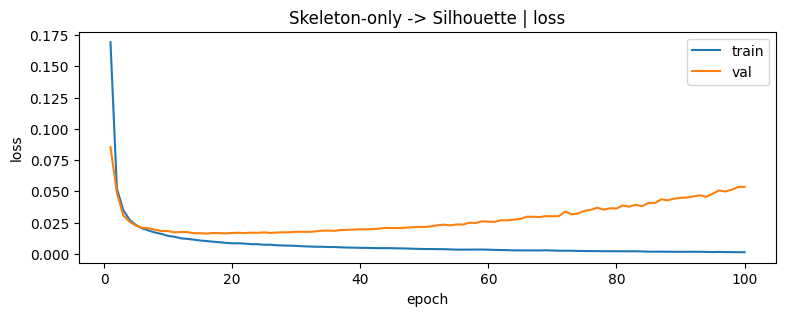

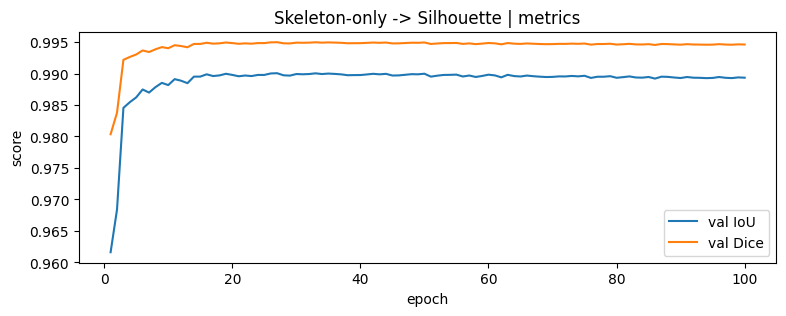

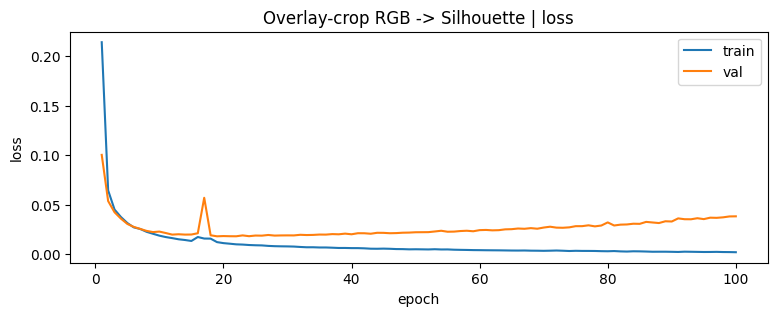

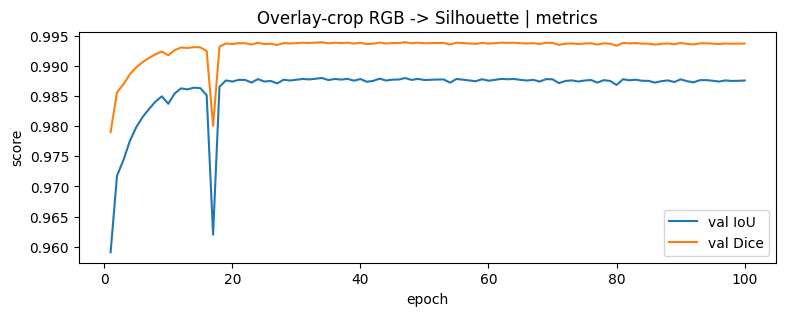

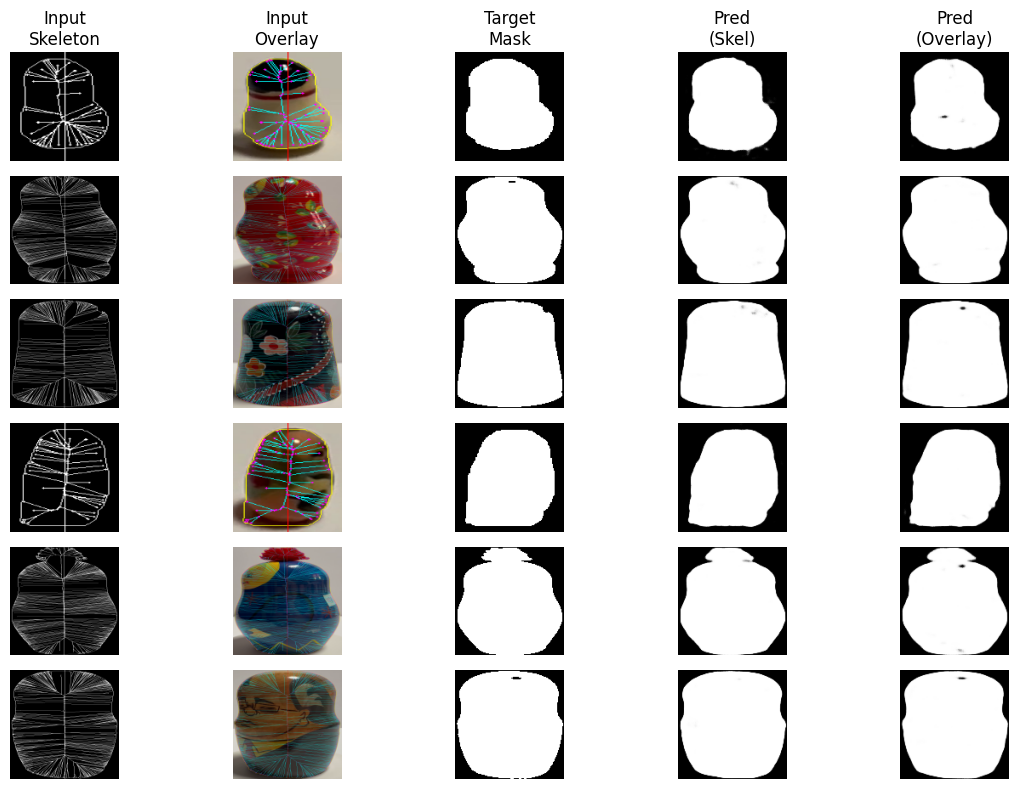

[DONE]
Index: /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs/index.csv
Best ckpt (skeleton): /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs/ckpt_skeleton_best.pt
Best ckpt (overlay):  /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs/ckpt_overlay_best.pt


In [ ]:
# ============================================================
# AUTOENCODER TRAINING (FIXED, SINGLE-SOURCE-OF-TRUTH PATHS)
# Pipeline:
#   Teacher YOLO bbox -> crop(+pad) -> GrabCut(shrunk rect) -> mask01_crop
#   boundary from mask -> Blum Medial Axis (BMA) graph
#   centerline from bbox midpoint (optionally centroid-blended)
#
# Builds dataset ON DISK and trains TWO models:
#   (S) skeleton-only  (1ch) -> silhouette mask
#   (O) overlay on crop RGB (3ch) -> silhouette mask
#
# Outputs under OUT_DIR:
#   train_data_skeleton/*.png
#   train_data_overlay_crop/*.png
#   train_data_mask/*.png
#   index.csv
#   ckpt_skeleton_best.pt
#   ckpt_overlay_best.pt
# ============================================================

# ----------------------------
# 0) Install deps (Colab-safe)
# ----------------------------
import sys, subprocess
def _pip(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", pkg])

_pip("ultralytics>=8.2.0")
_pip("opencv-python-headless==4.10.0.84")
_pip("scipy")
_pip("matplotlib")
_pip("pandas")
_pip("scikit-learn")

# ----------------------------
# 1) Imports + Config
# ----------------------------
from pathlib import Path
import os, time, random, hashlib
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial import Delaunay, cKDTree
from scipy import sparse

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from ultralytics import YOLO
from google.colab import drive

drive.mount("/content/drive", force_remount=True)

# ====== EDIT THESE PATHS ======
ROOT_FRAMES = Path("/content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_131853/frames")
TEACHER_WEIGHTS = Path("/content/drive/MyDrive/Matreskas/yolo11_runs_teacher/matreskas_yolo11_teacher/weights/best.pt")

# ====== OUTPUT ROOT (everything goes here) ======
OUT_DIR = Path("/content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Output folders for training data
DATA_SKEL_DIR = OUT_DIR / "train_data_skeleton"
DATA_OVL_DIR  = OUT_DIR / "train_data_overlay_crop"
DATA_MASK_DIR = OUT_DIR / "train_data_mask"
for d in (DATA_SKEL_DIR, DATA_OVL_DIR, DATA_MASK_DIR):
    d.mkdir(parents=True, exist_ok=True)

# Index + checkpoints
INDEX_CSV = OUT_DIR / "index.csv"
CKPT_SKEL = OUT_DIR / "ckpt_skeleton_best.pt"
CKPT_OVL  = OUT_DIR / "ckpt_overlay_best.pt"

# ====== RUN SETTINGS ======
FRAME_EXTS = [".png", ".jpg", ".jpeg"]
MAX_SCAN = 20000
RANDOM_SEED = 7
TEACHER_CONF_MIN = 0.85
BBOX_PAD = 8
GC_SHRINK = 10
GRABCUT_ITERS = 5
MAX_TRIES = 20000

# Centerline robustness
BLEND_BBOX_AND_MASK_CENTROID = True
CENTROID_BLEND_ALPHA = 0.80

# Dataset build
IMG_SIZE = 128
TARGET_SAMPLES = 2000       # set None to build as many as possible
SAVE_EVERY = 100

# Training
BATCH_SIZE = 32
EPOCHS = 100
LR = 1e-3
NUM_WORKERS = 2             # set to 12 if you want: NUM_WORKERS = 12

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print("[INFO] Device:", DEVICE)
print("[INFO] ROOT_FRAMES:", ROOT_FRAMES, "| exists:", ROOT_FRAMES.exists())
print("[INFO] TEACHER_WEIGHTS:", TEACHER_WEIGHTS, "| exists:", TEACHER_WEIGHTS.exists())
print("[INFO] OUT_DIR:", OUT_DIR)
print("[INFO] INDEX_CSV:", INDEX_CSV, "| exists:", INDEX_CSV.exists())

if not ROOT_FRAMES.exists():
    raise FileNotFoundError(f"ROOT_FRAMES does not exist: {ROOT_FRAMES}")
if not TEACHER_WEIGHTS.exists():
    raise FileNotFoundError(f"TEACHER_WEIGHTS does not exist: {TEACHER_WEIGHTS}")

# ============================================================
# 2) BMA CORE
# ============================================================
def medialaxis(z: np.ndarray):
    z = np.asarray(z).ravel().astype(np.complex128)
    pts = np.column_stack([z.real, z.imag])
    tri = Delaunay(pts).simplices
    tri = np.sort(tri, axis=1)
    u = z[tri[:, 0]]; v = z[tri[:, 1]]; w = z[tri[:, 2]]
    dot = (u - w) * np.conjugate(v - w)
    imag_dot = np.imag(dot)
    imag_safe = np.where(np.abs(imag_dot) < 1e-18,
                         np.sign(imag_dot) * 1e-18 + 1e-18,
                         imag_dot)
    m = (u + v + 1j * (u - v) * (np.real(dot) / imag_safe)) / 2.0
    r = np.abs(u - m)
    inside = np.imag(dot) > 0
    m_in = m[inside]; r_in = r[inside]; tri_in = tri[inside]
    if len(m_in) == 0:
        raise RuntimeError("No interior triangles found (medial set empty).")
    medialdata = np.empty((len(m_in), 5), dtype=object)
    medialdata[:, 0] = m_in
    medialdata[:, 1] = r_in
    medialdata[:, 2:] = tri_in
    return z, medialdata

def medialorder(medialdata: np.ndarray) -> np.ndarray:
    m2 = medialdata[:, 0].astype(np.complex128)
    tri_in = np.array([row[2:] for row in medialdata], dtype=int)
    nt = tri_in.shape[0]
    n_pts = tri_in.max() + 1
    rows = np.repeat(np.arange(nt), 3)
    cols = tri_in.reshape(-1)
    data = np.ones_like(cols, dtype=np.int8)
    B1 = sparse.csr_matrix((data, (rows, cols)), shape=(nt, n_pts))
    S = (B1 @ B1.T).tocoo()
    a, b, sdata = S.row, S.col, S.data
    mask = (sdata > 1) & (a > b)
    a = a[mask]; b = b[mask]
    if a.size == 0:
        return np.empty((2, 0), dtype=np.complex128)
    return np.vstack([m2[a], m2[b]])

class BlumMedialAxis:
    def __init__(self, boundary, pointsArray, radiiArray, indexOfBndryPoints, adjacencyMatrix):
        self.boundary = boundary
        self.pointsArray = pointsArray
        self.radiiArray = radiiArray
        self.indexOfBndryPoints = indexOfBndryPoints
        self.adjacencyMatrix = adjacencyMatrix

    @staticmethod
    def from_boundary(boundary: np.ndarray) -> "BlumMedialAxis":
        z, medial_data = medialaxis(boundary)
        m = np.asarray(medial_data[:, 0], dtype=np.complex128)
        r = np.asarray(medial_data[:, 1], dtype=np.float64)
        tris = np.array([row[2:] for row in medial_data], dtype=int)
        mord = medialorder(medial_data)

        points = m.copy()
        radii = r.copy()
        idx_bndry = tris.copy()

        tree = cKDTree(np.column_stack([points.real, points.imag]))
        rows, cols = [], []

        if mord.size > 0:
            a = np.column_stack([mord[0].real, mord[0].imag])
            b = np.column_stack([mord[1].real, mord[1].imag])
            _, ia = tree.query(a, k=1)
            _, ib = tree.query(b, k=1)
            rows.extend(ia.tolist()); cols.extend(ib.tolist())
            rows.extend(ib.tolist()); cols.extend(ia.tolist())

        n = len(points)
        adj = sparse.coo_matrix(
            (np.ones(len(rows), dtype=np.int8), (rows, cols)), shape=(n, n)
        ).toarray().astype(bool)

        return BlumMedialAxis(z, points, radii, idx_bndry, adj)

def _enforce_ccw(z: np.ndarray) -> np.ndarray:
    x, y = z.real, z.imag
    area2 = np.sum((x - np.roll(x, -1)) * (y + np.roll(y, -1)))
    if area2 > 0:
        z = z[::-1]
    return z

def _dedupe_and_decollinearize(z: np.ndarray) -> np.ndarray:
    xy = np.column_stack([z.real, z.imag])
    _, idx = np.unique(xy, axis=0, return_index=True)
    z = z[np.sort(idx)]
    if len(z) < 3:
        return z
    keep = [True]
    for i in range(1, len(z)-1):
        a = z[i] - z[i-1]; b = z[i+1] - z[i]
        cross = (a.real*b.imag - a.imag*b.real)
        keep.append(abs(cross) > 1e-12)
    keep.append(True)
    return z[np.array(keep, dtype=bool)]

def boundary_from_binary_mask(mask01: np.ndarray) -> np.ndarray:
    mask = (mask01.astype(np.uint8) * 255)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        raise RuntimeError("No contour found.")
    c = max(contours, key=cv2.contourArea).squeeze(1)
    if c.ndim != 2 or c.shape[0] < 3:
        raise RuntimeError(f"Bad contour shape: {c.shape}")
    z = c[:, 0].astype(np.float64) + 1j * c[:, 1].astype(np.float64)
    z = _enforce_ccw(z)
    z = _dedupe_and_decollinearize(z)
    if abs(z[0] - z[-1]) > 1e-12:
        z = np.concatenate([z, z[:1]])
    return z

# ============================================================
# 3) Teacher bbox + GrabCut refinement
# ============================================================
def clip_box(x1, y1, x2, y2, W, H):
    x1 = int(max(0, min(W-1, x1)))
    y1 = int(max(0, min(H-1, y1)))
    x2 = int(max(0, min(W-1, x2)))
    y2 = int(max(0, min(H-1, y2)))
    if x2 <= x1 + 1 or y2 <= y1 + 1:
        return None
    return x1, y1, x2, y2

def expand_box(x1, y1, x2, y2, pad, W, H):
    return clip_box(x1-pad, y1-pad, x2+pad, y2+pad, W, H)

def grabcut_from_crop(crop_bgr: np.ndarray, shrink: int = GC_SHRINK, iters: int = GRABCUT_ITERS) -> np.ndarray:
    h, w = crop_bgr.shape[:2]
    x1 = shrink; y1 = shrink
    x2 = w - shrink; y2 = h - shrink
    if x2 <= x1 + 2 or y2 <= y1 + 2:
        cx, cy = w // 2, h // 2
        x1, x2 = max(0, cx-5), min(w, cx+5)
        y1, y2 = max(0, cy-5), min(h, cy+5)

    rect = (int(x1), int(y1), int(max(2, x2-x1)), int(max(2, y2-y1)))

    mask = np.zeros((h, w), np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    cv2.grabCut(crop_bgr, mask, rect, bgdModel, fgdModel, iters, cv2.GC_INIT_WITH_RECT)
    mask01 = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 1, 0).astype(np.uint8)

    # cleanup + largest CC
    mask01 = cv2.morphologyEx(mask01, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8), iterations=2)
    mask01 = cv2.morphologyEx(mask01, cv2.MORPH_OPEN,  np.ones((3, 3), np.uint8), iterations=1)

    num, labels, stats, _ = cv2.connectedComponentsWithStats(mask01, connectivity=8)
    if num <= 1:
        raise RuntimeError("GrabCut produced no connected foreground.")
    largest = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    mask01 = (labels == largest).astype(np.uint8)
    return mask01

def get_best_teacher_box(model: YOLO, img_bgr: np.ndarray, conf_min: float):
    res = model.predict(img_bgr, verbose=False)
    if not res or res[0].boxes is None or len(res[0].boxes) == 0:
        return None
    boxes = res[0].boxes.xyxy.cpu().numpy()
    confs = res[0].boxes.conf.cpu().numpy()
    best = int(np.argmax(confs))
    if float(confs[best]) < conf_min:
        return None
    x1, y1, x2, y2 = boxes[best]
    return float(x1), float(y1), float(x2), float(y2), float(confs[best])

def compute_axis_x_in_crop(bbox_center_x_abs, crop_x1_abs, mask01_crop=None):
    axis_bbox = float(bbox_center_x_abs - crop_x1_abs)
    if (not BLEND_BBOX_AND_MASK_CENTROID) or (mask01_crop is None):
        return axis_bbox
    ys, xs = np.where(mask01_crop > 0)
    if xs.size == 0:
        return axis_bbox
    axis_centroid = float(xs.mean())
    a = float(CENTROID_BLEND_ALPHA)
    return a * axis_bbox + (1.0 - a) * axis_centroid

# ============================================================
# 4) Rendering helpers
# ============================================================
def render_skeleton_only(bma: BlumMedialAxis, mask01_crop: np.ndarray, axis_x_crop: float) -> np.ndarray:
    h, w = mask01_crop.shape[:2]
    canvas = np.zeros((h, w), dtype=np.uint8)

    boundary_xy = np.column_stack([bma.boundary.real, bma.boundary.imag]).astype(np.int32)
    for i in range(len(boundary_xy)-1):
        x1,y1 = boundary_xy[i]
        x2,y2 = boundary_xy[i+1]
        cv2.line(canvas, (x1,y1), (x2,y2), 255, 1)

    if bma.adjacencyMatrix is not None and len(bma.pointsArray):
        rr, cc = np.where(np.triu(bma.adjacencyMatrix, 1))
        for r, c in zip(rr, cc):
            a = bma.pointsArray[r]; b = bma.pointsArray[c]
            cv2.line(canvas,
                     (int(round(a.real)), int(round(a.imag))),
                     (int(round(b.real)), int(round(b.imag))),
                     255, 1)

    if len(bma.pointsArray):
        for p in bma.pointsArray:
            cv2.circle(canvas, (int(round(p.real)), int(round(p.imag))), 1, 255, -1)

    x = int(round(axis_x_crop))
    cv2.line(canvas, (x, 0), (x, h-1), 255, 1)
    return canvas

def render_overlay_on_crop(crop_bgr: np.ndarray, bma: BlumMedialAxis, axis_x_crop: float) -> np.ndarray:
    img = crop_bgr.copy()
    h, w = img.shape[:2]

    boundary_xy = np.column_stack([bma.boundary.real, bma.boundary.imag]).astype(np.int32)
    for i in range(len(boundary_xy)-1):
        x1,y1 = boundary_xy[i]
        x2,y2 = boundary_xy[i+1]
        cv2.line(img, (x1,y1), (x2,y2), (0,255,255), 1)

    if bma.adjacencyMatrix is not None and len(bma.pointsArray):
        rr, cc = np.where(np.triu(bma.adjacencyMatrix, 1))
        for r, c in zip(rr, cc):
            a = bma.pointsArray[r]; b = bma.pointsArray[c]
            cv2.line(img,
                     (int(round(a.real)), int(round(a.imag))),
                     (int(round(b.real)), int(round(b.imag))),
                     (255,255,0), 1)

    if len(bma.pointsArray):
        for p in bma.pointsArray:
            cv2.circle(img, (int(round(p.real)), int(round(p.imag))), 1, (255,0,255), -1)

    x = int(round(axis_x_crop))
    cv2.line(img, (x, 0), (x, h-1), (0,0,255), 1)
    return img

def to_size_gray_u8(img_u8: np.ndarray, size=IMG_SIZE) -> np.ndarray:
    return cv2.resize(img_u8, (size, size), interpolation=cv2.INTER_AREA)

def to_size_bgr_u8(img_bgr: np.ndarray, size=IMG_SIZE) -> np.ndarray:
    return cv2.resize(img_bgr, (size, size), interpolation=cv2.INTER_AREA)

def mask_to_u8(mask01: np.ndarray, size=IMG_SIZE) -> np.ndarray:
    m = (mask01.astype(np.uint8) * 255)
    m = cv2.resize(m, (size, size), interpolation=cv2.INTER_NEAREST)
    return m

# ============================================================
# 5) Frame scanning (capped)
# ============================================================
def find_frame_paths(root: Path, exts, max_scan=MAX_SCAN):
    # Streamed walk to avoid building an enormous list then slicing.
    exts = set([e.lower() for e in exts])
    out = []
    for dirpath, _, filenames in os.walk(root):
        for fn in filenames:
            if len(out) >= max_scan:
                break
            suf = os.path.splitext(fn)[1].lower()
            if suf in exts:
                out.append(Path(dirpath) / fn)
        if len(out) >= max_scan:
            break
    random.shuffle(out)
    return out

# ============================================================
# 6) Build dataset ON DISK
# ============================================================
def stable_uid_from_rel(rel: str) -> str:
    # Stable across runs/machines (unlike Python's built-in hash()).
    return hashlib.sha1(rel.encode("utf-8")).hexdigest()[:12]

def build_training_dataset(teacher: YOLO, paths: list[Path], target_samples: int | None, max_tries: int):
    rows = []
    saved = 0
    tries = 0

    for p in paths:
        if target_samples is not None and saved >= target_samples:
            break
        if tries >= max_tries:
            break

        tries += 1
        img_bgr = cv2.imread(p.as_posix(), cv2.IMREAD_COLOR)
        if img_bgr is None:
            continue
        H, W = img_bgr.shape[:2]

        bb = get_best_teacher_box(teacher, img_bgr, conf_min=TEACHER_CONF_MIN)
        if bb is None:
            continue

        x1, y1, x2, y2, conf = bb
        axis_x_abs = 0.5 * (x1 + x2)

        bb2 = expand_box(x1, y1, x2, y2, pad=BBOX_PAD, W=W, H=H)
        if bb2 is None:
            continue
        x1p, y1p, x2p, y2p = bb2
        crop = img_bgr[y1p:y2p, x1p:x2p].copy()

        try:
            mask01 = grabcut_from_crop(crop, shrink=GC_SHRINK, iters=GRABCUT_ITERS)
            boundary = boundary_from_binary_mask(mask01)
            bma = BlumMedialAxis.from_boundary(boundary)
            axis_x_crop = compute_axis_x_in_crop(axis_x_abs, crop_x1_abs=x1p, mask01_crop=mask01)

            skel_u8 = render_skeleton_only(bma, mask01_crop=mask01, axis_x_crop=axis_x_crop)
            ovl_bgr = render_overlay_on_crop(crop, bma=bma, axis_x_crop=axis_x_crop)
            mask_u8 = mask_to_u8(mask01, size=IMG_SIZE)

            skel_u8 = to_size_gray_u8(skel_u8, size=IMG_SIZE)
            ovl_bgr = to_size_bgr_u8(ovl_bgr, size=IMG_SIZE)

            rel = str(p.relative_to(ROOT_FRAMES)) if str(p).startswith(str(ROOT_FRAMES)) else p.as_posix()
            uid = stable_uid_from_rel(rel)

            skel_path = DATA_SKEL_DIR / f"{uid}.png"
            ovl_path  = DATA_OVL_DIR  / f"{uid}.png"
            mask_path = DATA_MASK_DIR / f"{uid}.png"

            cv2.imwrite(skel_path.as_posix(), skel_u8)
            cv2.imwrite(ovl_path.as_posix(),  ovl_bgr)
            cv2.imwrite(mask_path.as_posix(), mask_u8)

            rows.append({
                "uid": uid,
                "frame_path": p.as_posix(),
                "conf": float(conf),
                "crop_x1": int(x1p), "crop_y1": int(y1p), "crop_x2": int(x2p), "crop_y2": int(y2p),
                "axis_x_abs": float(axis_x_abs),
                "axis_x_crop": float(axis_x_crop),
                "skeleton_png": skel_path.as_posix(),
                "overlay_crop_png": ovl_path.as_posix(),
                "mask_png": mask_path.as_posix(),
            })
            saved += 1

            if saved % SAVE_EVERY == 0:
                print(f"[BUILD] saved={saved} tries={tries}")
        except Exception:
            continue

    df = pd.DataFrame(rows)
    df.to_csv(INDEX_CSV, index=False)
    print(f"[DONE] Dataset build: saved={len(df)} rows -> {INDEX_CSV}")
    return df

# Always keep INDEX_CSV as Path (guard against accidental overwrite)
INDEX_CSV = Path(INDEX_CSV)

if INDEX_CSV.exists():
    df_index = pd.read_csv(INDEX_CSV)
    if len(df_index) == 0:
        print("[INFO] index.csv exists but empty; rebuilding.")
        df_index = None
else:
    df_index = None

if df_index is None:
    print("[INFO] Loading Teacher:", TEACHER_WEIGHTS)
    teacher = YOLO(TEACHER_WEIGHTS.as_posix())

    paths = find_frame_paths(ROOT_FRAMES, FRAME_EXTS, max_scan=MAX_SCAN)
    print(f"[INFO] Candidate frames (capped): {len(paths)}")

    df_index = build_training_dataset(
        teacher=teacher,
        paths=paths,
        target_samples=TARGET_SAMPLES,
        max_tries=MAX_TRIES,
    )

print("[INFO] Final dataset size:", len(df_index))
if len(df_index) < 50:
    raise RuntimeError("Too few samples built. Increase MAX_TRIES / relax TEACHER_CONF_MIN / verify inputs.")

# ============================================================
# 7) Dataset + Dataloaders
# ============================================================
class PairDataset(Dataset):
    """
    mode='skeleton' -> uses skeleton_png (1ch)
    mode='overlay'  -> uses overlay_crop_png (3ch)
    target is mask_png (1ch)
    """
    def __init__(self, df: pd.DataFrame, mode: str):
        assert mode in ("skeleton", "overlay")
        self.df = df.reset_index(drop=True)
        self.mode = mode

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        if self.mode == "skeleton":
            x = cv2.imread(row["skeleton_png"], cv2.IMREAD_GRAYSCALE)
            if x is None:
                raise RuntimeError(f"Missing: {row['skeleton_png']}")
            x = (x.astype(np.float32) / 255.0)
            x = torch.from_numpy(x[None, ...])  # (1,H,W)
        else:
            x = cv2.imread(row["overlay_crop_png"], cv2.IMREAD_COLOR)
            if x is None:
                raise RuntimeError(f"Missing: {row['overlay_crop_png']}")
            x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
            x = (x.astype(np.float32) / 255.0)
            x = torch.from_numpy(x.transpose(2, 0, 1))  # (3,H,W)

        y = cv2.imread(row["mask_png"], cv2.IMREAD_GRAYSCALE)
        if y is None:
            raise RuntimeError(f"Missing: {row['mask_png']}")
        y = (y.astype(np.float32) / 255.0)
        y = torch.from_numpy(y[None, ...])  # (1,H,W)

        return x, y

train_df, val_df = train_test_split(df_index, test_size=0.2, random_state=RANDOM_SEED, shuffle=True)

def make_loaders(mode: str):
    train_ds = PairDataset(train_df, mode=mode)
    val_ds   = PairDataset(val_df, mode=mode)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=NUM_WORKERS, pin_memory=True)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=NUM_WORKERS, pin_memory=True)
    return train_loader, val_loader

# ============================================================
# 8) Model (encoder-decoder)
# ============================================================
class MaskAE(nn.Module):
    def __init__(self, in_ch: int, latent_ch: int = 128):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(in_ch, 32, 3, 2, 1), nn.BatchNorm2d(32), nn.ReLU(True),       # 64
            nn.Conv2d(32, 64, 3, 2, 1), nn.BatchNorm2d(64), nn.ReLU(True),          # 32
            nn.Conv2d(64, 128, 3, 2, 1), nn.BatchNorm2d(128), nn.ReLU(True),        # 16
            nn.Conv2d(128, latent_ch, 3, 2, 1), nn.BatchNorm2d(latent_ch), nn.ReLU(True) # 8
        )
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(latent_ch, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(True), # 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(True),         # 32
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(True),          # 64
            nn.ConvTranspose2d(32, 1, 4, 2, 1)                                                # 128
        )

    def forward(self, x):
        z = self.enc(x)
        y = self.dec(z)
        return torch.sigmoid(y)

def dice_loss(pred, tgt, eps=1e-6):
    inter = (pred * tgt).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + tgt.sum(dim=(2,3))
    dice = (2*inter + eps) / (union + eps)
    return 1 - dice.mean()

def iou_dice_metrics(pred, tgt):
    pb = (pred > 0.5)
    tb = (tgt > 0.5)
    inter = (pb & tb).sum(dim=(2,3)).float()
    union = (pb | tb).sum(dim=(2,3)).float()
    iou = ((inter + 1e-6) / (union + 1e-6)).mean().item()
    denom = pb.sum(dim=(2,3)).float() + tb.sum(dim=(2,3)).float()
    dice = ((2*inter + 1e-6) / (denom + 1e-6)).mean().item()
    return iou, dice

# ============================================================
# 9) Train/Eval loops
# ============================================================
def run_training(mode: str, ckpt_path: Path):
    assert mode in ("skeleton", "overlay")
    in_ch = 1 if mode == "skeleton" else 3
    train_loader, val_loader = make_loaders(mode)

    model = MaskAE(in_ch=in_ch).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR)

    best_val = float("inf")
    history = []

    print(f"\n[TRAIN] mode={mode} in_ch={in_ch} train_batches={len(train_loader)} val_batches={len(val_loader)}")
    for epoch in range(1, EPOCHS + 1):
        t0 = time.time()
        model.train()
        tr_loss = 0.0

        for x, y in train_loader:
            x = x.to(DEVICE, non_blocking=True)
            y = y.to(DEVICE, non_blocking=True)

            opt.zero_grad(set_to_none=True)
            yhat = model(x)
            bce = F.binary_cross_entropy(yhat, y)
            dsc = dice_loss(yhat, y)
            loss = 0.5*bce + 0.5*dsc
            loss.backward()
            opt.step()
            tr_loss += loss.item() * x.size(0)

        tr_loss /= len(train_loader.dataset)

        model.eval()
        va_loss = 0.0
        ious, dices = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(DEVICE, non_blocking=True)
                y = y.to(DEVICE, non_blocking=True)
                yhat = model(x)
                bce = F.binary_cross_entropy(yhat, y)
                dsc = dice_loss(yhat, y)
                loss = 0.5*bce + 0.5*dsc
                va_loss += loss.item() * x.size(0)
                iou, dice = iou_dice_metrics(yhat, y)
                ious.append(iou); dices.append(dice)

        va_loss /= len(val_loader.dataset)
        va_iou = float(np.mean(ious))
        va_dice = float(np.mean(dices))

        dt = time.time() - t0
        history.append((epoch, tr_loss, va_loss, va_iou, va_dice))
        print(f"[E{epoch:03d}] train={tr_loss:.4f} val={va_loss:.4f} IoU={va_iou:.3f} Dice={va_dice:.3f} ({dt:.1f}s)")

        if va_loss < best_val:
            best_val = va_loss
            torch.save({
                "model": model.state_dict(),
                "mode": mode,
                "in_ch": in_ch,
                "img_size": IMG_SIZE,
                "index_csv": INDEX_CSV.as_posix(),
            }, ckpt_path.as_posix())
            print(f"  -> saved best: {ckpt_path}")

    return history

hist_s = run_training("skeleton", CKPT_SKEL)
hist_o = run_training("overlay",  CKPT_OVL)

# ============================================================
# 10) Compare curves + qualitative visualization
# ============================================================
def plot_history(hist, title):
    epochs = [h[0] for h in hist]
    tr = [h[1] for h in hist]
    va = [h[2] for h in hist]
    iou = [h[3] for h in hist]
    dice = [h[4] for h in hist]

    plt.figure(figsize=(9,3))
    plt.plot(epochs, tr, label="train")
    plt.plot(epochs, va, label="val")
    plt.title(f"{title} | loss")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend()
    plt.show()

    plt.figure(figsize=(9,3))
    plt.plot(epochs, iou, label="val IoU")
    plt.plot(epochs, dice, label="val Dice")
    plt.title(f"{title} | metrics")
    plt.xlabel("epoch"); plt.ylabel("score"); plt.legend()
    plt.show()

plot_history(hist_s, "Skeleton-only -> Silhouette")
plot_history(hist_o, "Overlay-crop RGB -> Silhouette")

def load_model(ckpt_path: Path):
    ckpt = torch.load(ckpt_path.as_posix(), map_location=DEVICE)
    m = MaskAE(in_ch=ckpt["in_ch"]).to(DEVICE)
    m.load_state_dict(ckpt["model"])
    m.eval()
    return m

m_s = load_model(CKPT_SKEL)
m_o = load_model(CKPT_OVL)

val_skel_ds = PairDataset(val_df, mode="skeleton")
val_ovl_ds  = PairDataset(val_df, mode="overlay")

N_SHOW = min(6, len(val_df))
idxs = np.random.choice(len(val_df), size=N_SHOW, replace=False)

plt.figure(figsize=(12, 8))
for r, idx in enumerate(idxs):
    xs, y = val_skel_ds[idx]
    xo, _ = val_ovl_ds[idx]
    with torch.no_grad():
        ys = m_s(xs.unsqueeze(0).to(DEVICE)).cpu().squeeze().numpy()
        yo = m_o(xo.unsqueeze(0).to(DEVICE)).cpu().squeeze().numpy()

    xs_np = xs.squeeze(0).numpy()
    xo_np = xo.permute(1,2,0).numpy()
    y_np  = y.squeeze(0).numpy()

    plt.subplot(N_SHOW, 5, r*5 + 1); plt.imshow(xs_np, cmap="gray"); plt.axis("off")
    if r == 0: plt.title("Input\nSkeleton")
    plt.subplot(N_SHOW, 5, r*5 + 2); plt.imshow(xo_np); plt.axis("off")
    if r == 0: plt.title("Input\nOverlay")
    plt.subplot(N_SHOW, 5, r*5 + 3); plt.imshow(y_np, cmap="gray"); plt.axis("off")
    if r == 0: plt.title("Target\nMask")
    plt.subplot(N_SHOW, 5, r*5 + 4); plt.imshow(ys, cmap="gray"); plt.axis("off")
    if r == 0: plt.title("Pred\n(Skel)")
    plt.subplot(N_SHOW, 5, r*5 + 5); plt.imshow(yo, cmap="gray"); plt.axis("off")
    if r == 0: plt.title("Pred\n(Overlay)")

plt.tight_layout()
plt.show()

print("[DONE]")
print("Index:", INDEX_CSV)
print("Best ckpt (skeleton):", CKPT_SKEL)
print("Best ckpt (overlay): ", CKPT_OVL)


In [ ]:
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 99.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.8 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:
!pip install trimesh open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.0/737.0 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 108.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.6 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:
from pathlib import Path
LABELS_CSV = Path("/content/drive/MyDrive/Matreskas/labels.csv")
assert LABELS_CSV.exists(), f"labels.csv not found at: {LABELS_CSV}"


Mounted at /content/drive
[INFO] OUT_DIR: /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs
[INFO] INDEX_CSV exists? True /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs/index.csv
[INFO] labels.csv: /content/drive/MyDrive/Matreskas/labels.csv
[INFO] index.csv rows: 2000
[INFO] Merged authenticity from labels.csv using columns: path=video_path, auth=authenticity
[INFO] style counts:
 style
artistic__IMG_5270             27
russian_authentic__IMG_5164    26
political__IMG_4799            25
russian_authentic__IMG_5209    24
russian_authentic__IMG_5188    21
russian_authentic__IMG_5191    21
russian_authentic__IMG_5133    21
non_authentic__IMG_5184        21
drafted__IMG_5097              20
political__IMG_4802            20
artistic__IMG_5267             20
russian_authentic__IMG_5306    20
non_authentic__IMG_5298        20
merchandise__IMG_5221          20
religious__IMG_4796            19
Name: count, dtype: int64
[INFO] authenticity counts:
 authenticity
unknown    9

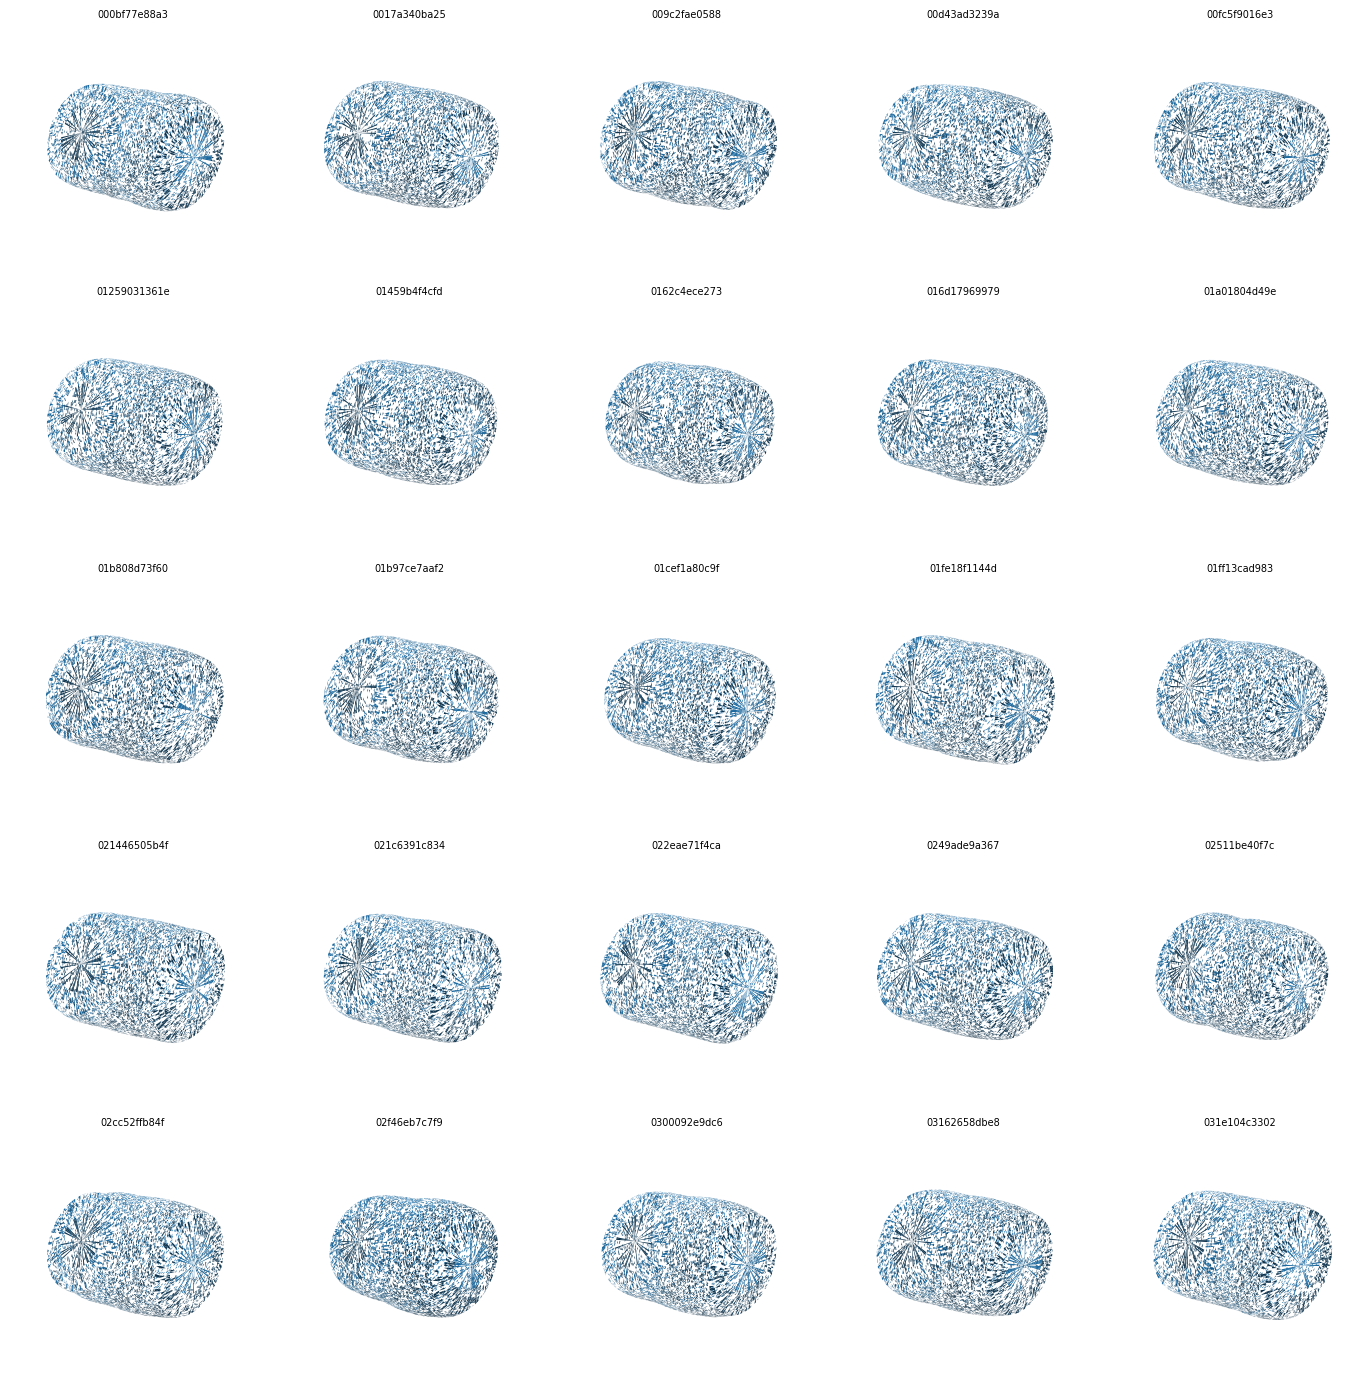

[SAVED] 5x5 mesh grid: /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs/viz_axisym/mesh_grid_5x5.png

[3D TRAIN] samples=2000 train=1600 val=400 | workers=12


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[E001] train=6.1614 val=6.1136 (4.3s)
  -> saved best: /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs/pointnet_mt_best.pt
[E002] train=6.0896 val=6.0831 (4.1s)
  -> saved best: /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs/pointnet_mt_best.pt
[E003] train=6.0204 val=5.9507 (4.1s)
  -> saved best: /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs/pointnet_mt_best.pt
[E004] train=5.7817 val=5.6013 (4.5s)
  -> saved best: /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs/pointnet_mt_best.pt
[E005] train=5.4816 val=5.2869 (4.1s)
  -> saved best: /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs/pointnet_mt_best.pt
[E006] train=5.2132 val=5.0357 (4.0s)
  -> saved best: /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs/pointnet_mt_best.pt
[E007] train=5.0473 val=4.7624 (4.2s)
  -> saved best: /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs/pointnet_mt_best.pt
[E008] train=4.7821 val=4.7653 (4.0s)
[E009] train=4.6134 val=4.3394 

In [ ]:
# ============================================================
# NEXT STEP (COMPLETE): 2D Mask -> Axisymmetric 3D Meshes -> Point Clouds -> 3D Training
# - FIXED: Trimesh version compatibility (no remove_duplicate_faces dependency)
# - FIXED: hole filling compatibility (uses trimesh.repair.fill_holes when available)
# - FIXED: worker exceptions won't crash the entire ProcessPool
# - Uses 12 workers (mesh generation + dataloaders)
# - Generates and SAVES meshes + a 5x5 grid visualization of generated meshes
# - Supports labels.csv if present; otherwise derives labels from frame folder names
# ============================================================

# ----------------------------
# 0) Install deps (Colab-safe)
# ----------------------------
import sys, subprocess, os, re, math, time, random
def _pip(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", pkg])

_pip("trimesh")
_pip("opencv-python-headless==4.10.0.84")
_pip("scipy")
_pip("numpy")
_pip("pandas")
_pip("matplotlib")
_pip("scikit-learn")

# ----------------------------
# 1) Imports + Mount Drive
# ----------------------------
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import trimesh
from trimesh import grouping, repair
from trimesh.sample import sample_surface

from concurrent.futures import ProcessPoolExecutor, as_completed

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# ----------------------------
# 2) Paths (USE YOUR EXACT NAMES)
# ----------------------------
OUT_DIR   = Path("/content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs")
INDEX_CSV = OUT_DIR / "index.csv"

CKPT_SKEL = OUT_DIR / "ckpt_skeleton_best.pt"
CKPT_OVL  = OUT_DIR / "ckpt_overlay_best.pt"

MESH_DIR  = OUT_DIR / "meshes_axisym"
PC_DIR    = OUT_DIR / "pointclouds_axisym"
VIZ_DIR   = OUT_DIR / "viz_axisym"
PRED_DIR  = OUT_DIR / "pred_masks"

for d in [MESH_DIR, PC_DIR, VIZ_DIR, PRED_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("[INFO] OUT_DIR:", OUT_DIR)
print("[INFO] INDEX_CSV exists?", INDEX_CSV.exists(), INDEX_CSV)

# ----------------------------
# 3) Optional labels.csv loader (robust)
# ----------------------------
LABELS_CSV = Path("/content/drive/MyDrive/Matreskas/labels.csv")

def find_labels_csv():
    if LABELS_CSV.exists():
        return LABELS_CSV
    cand = list(Path("/content/drive/MyDrive").rglob("labels.csv"))
    return cand[0] if len(cand) else None

labels_csv_found = find_labels_csv()
print("[INFO] labels.csv:", labels_csv_found)

# ----------------------------
# 4) Load index.csv
# ----------------------------
if not INDEX_CSV.exists():
    raise FileNotFoundError(f"Missing index.csv at: {INDEX_CSV}")

df = pd.read_csv(INDEX_CSV)
if len(df) == 0:
    raise RuntimeError("index.csv is empty")

required_cols = ["uid", "frame_path", "axis_x_crop", "mask_png", "skeleton_png", "overlay_crop_png"]
for c in required_cols:
    if c not in df.columns:
        raise KeyError(f"index.csv missing column '{c}'. Found: {list(df.columns)}")

print("[INFO] index.csv rows:", len(df))

# ----------------------------
# 5) Label resolution
# ----------------------------
def infer_style_from_frame_path(p: str):
    parts = Path(p).parts
    if "frames" in parts:
        i = parts.index("frames")
        if i + 1 < len(parts):
            return parts[i+1]
    return Path(p).parent.name

def normalize_style(s: str):
    s = str(s).strip()
    s = s.replace("-", "_").replace(" ", "_")
    return s

def heuristic_auth_from_style(style: str):
    st = style.lower()
    if "russian" in st and "auth" in st:
        return "RU"
    if "non" in st and "auth" in st:
        return "non-RU"
    return "unknown"

df["style"] = df["frame_path"].apply(infer_style_from_frame_path).apply(normalize_style)

# Merge authenticity from labels.csv if possible
if labels_csv_found is not None:
    lab = pd.read_csv(labels_csv_found)
    cand_auth = [c for c in lab.columns if c.lower() in ("auth", "authenticity", "auth_label", "authentic")]
    cand_path = [c for c in lab.columns if "path" in c.lower() or "video" in c.lower() or "frame" in c.lower()]

    auth_col = cand_auth[0] if len(cand_auth) else None
    path_col = None
    for c in lab.columns:
        if c.lower() == "frame_path":
            path_col = c
            break
    if path_col is None and len(cand_path):
        path_col = cand_path[0]

    if auth_col is not None and path_col is not None:
        lab2 = lab[[path_col, auth_col]].copy()
        lab2.columns = ["_path", "_auth"]
        lab2["_path"] = lab2["_path"].astype(str)
        df["frame_path"] = df["frame_path"].astype(str)

        m = df.merge(lab2, left_on="frame_path", right_on="_path", how="left")
        df["_auth"] = m["_auth"].values
        print(f"[INFO] Merged authenticity from labels.csv using columns: path={path_col}, auth={auth_col}")
    else:
        df["_auth"] = None
        print("[WARN] labels.csv found but could not identify columns for path/authenticity. Using heuristic.")
else:
    df["_auth"] = None

df["authenticity"] = df["_auth"].fillna(df["style"].apply(heuristic_auth_from_style)).astype(str).str.strip()

def norm_auth(a: str):
    t = a.strip().lower()
    if t in ("ru", "russian_authentic", "russian", "authentic_ru", "auth"):
        return "RU"
    if t in ("non-ru", "non_ru", "nonru", "replica", "fake", "non_authentic", "non-authentic"):
        return "non-RU"
    if t in ("unknown", "unk", "na", "n/a", ""):
        return "unknown"
    if t.startswith("ru"):
        return "RU"
    if "non" in t and "ru" in t:
        return "non-RU"
    return "unknown"

df["authenticity"] = df["authenticity"].apply(norm_auth)

print("[INFO] style counts:\n", df["style"].value_counts().head(15))
print("[INFO] authenticity counts:\n", df["authenticity"].value_counts())

styles = sorted(df["style"].unique().tolist())
auths  = ["RU", "non-RU", "unknown"]

style2i = {s:i for i,s in enumerate(styles)}
auth2i  = {a:i for i,a in enumerate(auths)}

df["y_style"] = df["style"].map(style2i).astype(int)
df["y_auth"]  = df["authenticity"].map(auth2i).fillna(auth2i["unknown"]).astype(int)

print("[INFO] #styles:", len(styles))
print("[INFO] auth2i:", auth2i)

# ----------------------------
# 6) Optional: AE-pred masks
# ----------------------------
USE_PRED_MASK = False
USE_MODE      = "skeleton"
THRESH        = 0.5
IMG_SIZE      = 128

class MaskAE(nn.Module):
    def __init__(self, in_ch: int, latent_ch: int = 128):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(in_ch, 32, 3, 2, 1), nn.BatchNorm2d(32), nn.ReLU(True),
            nn.Conv2d(32, 64, 3, 2, 1), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.Conv2d(64, 128, 3, 2, 1), nn.BatchNorm2d(128), nn.ReLU(True),
            nn.Conv2d(128, latent_ch, 3, 2, 1), nn.BatchNorm2d(latent_ch), nn.ReLU(True)
        )
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(latent_ch, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 4, 2, 1)
        )
    def forward(self, x):
        z = self.enc(x)
        y = torch.sigmoid(self.dec(z))
        return y

def load_ae(ckpt_path: Path, device):
    ckpt = torch.load(ckpt_path, map_location=device)
    m = MaskAE(in_ch=int(ckpt["in_ch"])).to(device)
    m.load_state_dict(ckpt["model"])
    m.eval()
    return m, int(ckpt["in_ch"])

def predict_masks(df_in: pd.DataFrame, device="cuda"):
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    ckpt_path = CKPT_SKEL if USE_MODE == "skeleton" else CKPT_OVL
    model, in_ch = load_ae(ckpt_path, device)
    print("[INFO] Loaded AE:", ckpt_path, "in_ch=", in_ch)

    out_paths = []
    bs = 64
    rows = df_in.reset_index(drop=True)
    for i in range(0, len(rows), bs):
        batch = rows.iloc[i:i+bs]
        xs = []
        for _, r in batch.iterrows():
            if USE_MODE == "skeleton":
                x = cv2.imread(r["skeleton_png"], cv2.IMREAD_GRAYSCALE)
                x = (x.astype(np.float32) / 255.0)[None, ...]
            else:
                x = cv2.imread(r["overlay_crop_png"], cv2.IMREAD_COLOR)
                x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
                x = (x.astype(np.float32) / 255.0).transpose(2,0,1)
            xs.append(x)
        xT = torch.from_numpy(np.stack(xs, axis=0)).to(device)

        with torch.no_grad():
            yhat = model(xT).cpu().numpy()

        for j in range(yhat.shape[0]):
            uid = str(batch.iloc[j]["uid"])
            pm = (yhat[j,0] > THRESH).astype(np.uint8) * 255
            ppath = (PRED_DIR / f"{uid}.png")
            cv2.imwrite(ppath.as_posix(), pm)
            out_paths.append(ppath.as_posix())

    return out_paths

if USE_PRED_MASK:
    print("[INFO] Predicting masks with AE...")
    df["mask_for_mesh"] = predict_masks(df, device="cuda")
else:
    df["mask_for_mesh"] = df["mask_png"].astype(str)

# ----------------------------
# 7) Axisymmetric mesh helpers (COMPAT CLEANUP)
# ----------------------------
def mask_to_radius_profile(mask01: np.ndarray, axis_x: float, min_fg_per_row=6):
    H, W = mask01.shape[:2]
    ys, rs = [], []
    ax = float(axis_x)

    for y in range(H):
        xs = np.where(mask01[y] > 0)[0]
        if xs.size < min_fg_per_row:
            continue
        r = float(np.max(np.abs(xs.astype(np.float32) - ax)))
        if r <= 1.0:
            continue
        ys.append(float(y))
        rs.append(r)

    if len(ys) < 10:
        return None, None

    ys = np.asarray(ys, dtype=np.float32)
    rs = np.asarray(rs, dtype=np.float32)

    # smooth radius
    k = 9
    if len(rs) > k:
        rs = np.convolve(rs, np.ones(k)/k, mode="same")

    ys = (ys - ys.min()) / max(1e-6, (ys.max() - ys.min()))
    return ys, rs

def remove_degenerate_faces_compat(mesh: trimesh.Trimesh, area_eps=1e-12):
    # remove degenerate by area
    try:
        tri = mesh.triangles
        if tri is None or len(tri) == 0:
            return mesh
        a = trimesh.triangles.area(tri)
        good = np.where(a > area_eps)[0]
        if len(good) < len(mesh.faces):
            mesh.update_faces(good)
            mesh.remove_unreferenced_vertices()
    except Exception:
        pass
    return mesh

def remove_duplicate_faces_compat(mesh: trimesh.Trimesh):
    # robust duplicate removal using unique rows on sorted face indices
    try:
        f = np.asarray(mesh.faces, dtype=np.int64)
        if f.size == 0:
            return mesh
        f_sorted = np.sort(f, axis=1)
        uniq_idx = grouping.unique_rows(f_sorted)[0]
        if len(uniq_idx) < len(f):
            mesh.update_faces(uniq_idx)
            mesh.remove_unreferenced_vertices()
    except Exception:
        pass
    return mesh

def fill_holes_compat(mesh: trimesh.Trimesh):
    # prefer trimesh.repair.fill_holes(mesh)
    try:
        repair.fill_holes(mesh)
    except Exception:
        # if unavailable, skip (still usable for sampling)
        pass
    return mesh

def revolve_profile_to_mesh(ys, rs, n_theta=128, scale=1.0, cap=True):
    ys = np.asarray(ys, dtype=np.float32)
    rs = (np.asarray(rs, dtype=np.float32) * float(scale))

    Ny = ys.shape[0]
    th = np.linspace(0, 2*np.pi, n_theta, endpoint=False).astype(np.float32)

    verts = np.zeros((Ny, n_theta, 3), dtype=np.float32)
    for i in range(Ny):
        r = rs[i]
        verts[i,:,0] = r * np.cos(th)
        verts[i,:,2] = r * np.sin(th)
        verts[i,:,1] = ys[i]

    V = verts.reshape(-1, 3)
    faces = []

    def vid(i, j):
        return i*n_theta + (j % n_theta)

    for i in range(Ny-1):
        for j in range(n_theta):
            a = vid(i, j)
            b = vid(i, j+1)
            c = vid(i+1, j)
            d = vid(i+1, j+1)
            faces.append([a, c, b])
            faces.append([b, c, d])

    if cap:
        bottom_center = len(V)
        V = np.vstack([V, np.array([[0.0, ys[0], 0.0]], dtype=np.float32)])
        for j in range(n_theta):
            a = vid(0, j)
            b = vid(0, j+1)
            faces.append([bottom_center, b, a])

        top_center = len(V)
        V = np.vstack([V, np.array([[0.0, ys[-1], 0.0]], dtype=np.float32)])
        for j in range(n_theta):
            a = vid(Ny-1, j)
            b = vid(Ny-1, j+1)
            faces.append([top_center, a, b])

    faces = np.asarray(faces, dtype=np.int64)

    # IMPORTANT: process=False for version stability; do our own cleanup
    mesh = trimesh.Trimesh(vertices=V, faces=faces, process=False, validate=False)

    # cleanup (compat)
    mesh = remove_degenerate_faces_compat(mesh)
    mesh = remove_duplicate_faces_compat(mesh)
    mesh.remove_unreferenced_vertices()

    # attempt hole fill (optional)
    mesh = fill_holes_compat(mesh)

    # finalize
    try:
        mesh.rezero()
    except Exception:
        pass
    try:
        mesh.remove_infinite_values()
    except Exception:
        pass

    return mesh

def sample_pointcloud(mesh, n_points=2048):
    """
    Stable sampling across trimesh versions:
    - uses trimesh.sample.sample_surface
    - normals from face_normals indexed by sampled faces
    """
    pts, face_idx = sample_surface(mesh, int(n_points))
    pts = np.asarray(pts, dtype=np.float32)

    fn = np.asarray(mesh.face_normals, dtype=np.float32)
    if fn is None or len(fn) == 0:
        # fallback if face_normals missing
        mesh.rezero()
        fn = np.asarray(mesh.face_normals, dtype=np.float32)

    nrm = fn[np.asarray(face_idx, dtype=np.int64)]
    nrm = nrm / (np.linalg.norm(nrm, axis=1, keepdims=True) + 1e-12)
    return pts, nrm.astype(np.float32)

# ----------------------------
# 8) Mesh/PointCloud generation with 12 workers (SAFE)
# ----------------------------
N_THETA     = 128
SCALE       = 1.0 / 64.0
N_POINTS    = 2048
MAX_MESHES  = 2000
NUM_WORKERS = 12

df_sub = df.sample(n=min(MAX_MESHES, len(df)), random_state=7).reset_index(drop=True)
print("[INFO] Generating meshes for:", len(df_sub), "samples")

def _job_make_mesh(row_dict):
    uid = str(row_dict["uid"])
    try:
        axis_x = float(row_dict["axis_x_crop"])
        mask_path = row_dict["mask_for_mesh"]

        m = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        if m is None:
            return (uid, False, "mask_read_fail")

        mask01 = (m > 127).astype(np.uint8)
        ys, rs = mask_to_radius_profile(mask01, axis_x=axis_x)
        if ys is None:
            return (uid, False, "profile_fail")

        mesh = revolve_profile_to_mesh(ys, rs, n_theta=N_THETA, scale=SCALE, cap=True)
        if mesh is None or len(mesh.vertices) < 50 or len(mesh.faces) < 50:
            return (uid, False, "mesh_fail_small")

        mesh_path = (MESH_DIR / f"{uid}.ply").as_posix()
        mesh.export(mesh_path)

        pts, nrm = sample_pointcloud(mesh, n_points=N_POINTS)
        pc_path = (PC_DIR / f"{uid}.npz").as_posix()
        np.savez_compressed(pc_path, points=pts, normals=nrm)

        return (uid, True, "ok")
    except Exception as e:
        return (uid, False, f"exception:{type(e).__name__}")

ok = 0
fails = []
t0 = time.time()

with ProcessPoolExecutor(max_workers=NUM_WORKERS) as ex:
    futs = [ex.submit(_job_make_mesh, df_sub.iloc[i].to_dict()) for i in range(len(df_sub))]
    for k, fut in enumerate(as_completed(futs), 1):
        uid, good, msg = fut.result()
        if good:
            ok += 1
        else:
            fails.append((uid, msg))
        if k % 50 == 0:
            print(f"[MESH] done {k}/{len(futs)} | ok={ok} | fails={len(fails)}")

print(f"[DONE] Mesh+PC generation: ok={ok}/{len(df_sub)} in {time.time()-t0:.1f}s")
if len(fails):
    print("[WARN] failures (first 20):", fails[:20])

df_sub["pc_npz"] = df_sub["uid"].astype(str).apply(lambda u: (PC_DIR / f"{u}.npz").as_posix())
df_ok = df_sub[df_sub["pc_npz"].apply(lambda p: Path(p).exists())].reset_index(drop=True)
print("[INFO] Final usable 3D samples:", len(df_ok))
if len(df_ok) < 50:
    raise RuntimeError("Too few 3D samples generated. Increase MAX_MESHES or check masks/axis_x_crop quality.")

# ----------------------------
# 9) 5x5 Grid of generated meshes
# ----------------------------
def plot_mesh_grid(mesh_paths, out_png, grid=5, max_faces_draw=6000):
    n = grid * grid
    mesh_paths = mesh_paths[:n]

    fig = plt.figure(figsize=(14, 14))
    for i, mp in enumerate(mesh_paths):
        mesh = trimesh.load(mp, force="mesh")
        v = np.asarray(mesh.vertices)
        f = np.asarray(mesh.faces)

        if f.shape[0] > max_faces_draw:
            idx = np.random.choice(f.shape[0], size=max_faces_draw, replace=False)
            f = f[idx]

        ax = fig.add_subplot(grid, grid, i+1, projection="3d")
        ax.plot_trisurf(v[:,0], v[:,1], v[:,2], triangles=f, linewidth=0.0, antialiased=True)
        ax.set_axis_off()
        ax.view_init(elev=18, azim=35)
        ax.set_title(Path(mp).stem, fontsize=7)

    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.show()

mesh_list = sorted([p.as_posix() for p in MESH_DIR.glob("*.ply")])
print("[INFO] meshes available:", len(mesh_list))
grid_png = (VIZ_DIR / "mesh_grid_5x5.png").as_posix()
plot_mesh_grid(mesh_list, grid_png, grid=5)
print("[SAVED] 5x5 mesh grid:", grid_png)

# ----------------------------
# 10) 3D Model (PointNet-style multi-task classifier)
# ----------------------------
class PointCloudDataset(Dataset):
    def __init__(self, df_rows: pd.DataFrame, n_points=2048, augment=True):
        self.df = df_rows.reset_index(drop=True)
        self.n_points = int(n_points)
        self.augment = bool(augment)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        npz = np.load(r["pc_npz"])
        pts = npz["points"].astype(np.float32)
        nrm = npz["normals"].astype(np.float32)

        N = pts.shape[0]
        if N >= self.n_points:
            sel = np.random.choice(N, size=self.n_points, replace=False)
        else:
            sel = np.random.choice(N, size=self.n_points, replace=True)
        pts = pts[sel]
        nrm = nrm[sel]

        pts = pts - pts.mean(axis=0, keepdims=True)
        scale = np.max(np.linalg.norm(pts, axis=1)) + 1e-6
        pts = pts / scale

        if self.augment:
            ang = np.random.uniform(0, 2*np.pi)
            ca, sa = np.cos(ang), np.sin(ang)
            R = np.array([[ca, 0, sa],
                          [0,  1, 0 ],
                          [-sa,0, ca]], dtype=np.float32)
            pts = pts @ R.T
            nrm = nrm @ R.T
            pts = pts + np.random.normal(0, 0.005, size=pts.shape).astype(np.float32)

        x = np.concatenate([pts, nrm], axis=1)     # (P,6)
        x = torch.from_numpy(x).transpose(0, 1)    # (6,P)

        y_style = int(r["y_style"])
        y_auth  = int(r["y_auth"])
        return x, torch.tensor(y_style, dtype=torch.long), torch.tensor(y_auth, dtype=torch.long)

class PointNetMT(nn.Module):
    def __init__(self, in_ch=6, n_style=8, n_auth=3):
        super().__init__()
        self.mlp1 = nn.Sequential(
            nn.Conv1d(in_ch, 64, 1), nn.BatchNorm1d(64), nn.ReLU(True),
            nn.Conv1d(64, 128, 1), nn.BatchNorm1d(128), nn.ReLU(True),
            nn.Conv1d(128, 256, 1), nn.BatchNorm1d(256), nn.ReLU(True),
        )
        self.mlp2 = nn.Sequential(
            nn.Linear(256, 256), nn.ReLU(True), nn.Dropout(0.2),
            nn.Linear(256, 128), nn.ReLU(True)
        )
        self.head_style = nn.Linear(128, n_style)
        self.head_auth  = nn.Linear(128, n_auth)

    def forward(self, x):
        f = self.mlp1(x)                 # (B,256,P)
        g = torch.max(f, dim=2).values   # (B,256)
        h = self.mlp2(g)                 # (B,128)
        return self.head_style(h), self.head_auth(h)

class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0, mode="min"):
        assert mode in ("min", "max")
        self.patience = int(patience)
        self.min_delta = float(min_delta)
        self.mode = mode
        self.best = None
        self.bad = 0

    def step(self, val):
        if self.best is None:
            self.best = float(val)
            self.bad = 0
            return False
        improved = (val < self.best - self.min_delta) if self.mode == "min" else (val > self.best + self.min_delta)
        if improved:
            self.best = float(val)
            self.bad = 0
            return False
        self.bad += 1
        return self.bad >= self.patience

train_df, val_df = train_test_split(
    df_ok, test_size=0.2, random_state=7, shuffle=True,
    stratify=df_ok["y_auth"]
)

BATCH_SIZE  = 32
NUM_WORKERS = 12
N_STYLE     = len(styles)
N_AUTH      = 3

train_ds = PointCloudDataset(train_df, n_points=N_POINTS, augment=True)
val_ds   = PointCloudDataset(val_df,   n_points=N_POINTS, augment=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PointNetMT(in_ch=6, n_style=N_STYLE, n_auth=N_AUTH).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

MAX_EPOCHS = 200
PATIENCE   = 8
MIN_DELTA  = 1e-4
early = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA, mode="min")

best_val = float("inf")
best_path = (OUT_DIR / "pointnet_mt_best.pt").as_posix()

def eval_epoch():
    model.eval()
    tot = 0.0
    n = 0
    with torch.no_grad():
        for x, y_style, y_auth in val_loader:
            x = x.to(device, non_blocking=True)
            y_style = y_style.to(device, non_blocking=True)
            y_auth  = y_auth.to(device, non_blocking=True)
            ls, la = model(x)
            loss = F.cross_entropy(ls, y_style) + F.cross_entropy(la, y_auth)
            tot += float(loss.item()) * x.size(0)
            n += x.size(0)
    return tot / max(1, n)

print(f"\n[3D TRAIN] samples={len(df_ok)} train={len(train_ds)} val={len(val_ds)} | workers={NUM_WORKERS}")
for epoch in range(1, MAX_EPOCHS + 1):
    model.train()
    t0 = time.time()
    tot = 0.0
    n = 0

    for x, y_style, y_auth in train_loader:
        x = x.to(device, non_blocking=True)
        y_style = y_style.to(device, non_blocking=True)
        y_auth  = y_auth.to(device, non_blocking=True)

        opt.zero_grad(set_to_none=True)
        ls, la = model(x)
        loss = F.cross_entropy(ls, y_style) + F.cross_entropy(la, y_auth)
        loss.backward()
        opt.step()

        tot += float(loss.item()) * x.size(0)
        n += x.size(0)

    tr_loss = tot / max(1, n)
    va_loss = eval_epoch()
    dt = time.time() - t0
    print(f"[E{epoch:03d}] train={tr_loss:.4f} val={va_loss:.4f} ({dt:.1f}s)")

    if va_loss < best_val - MIN_DELTA:
        best_val = va_loss
        torch.save({
            "model": model.state_dict(),
            "epoch": epoch,
            "best_val": best_val,
            "styles": styles,
            "auths": auths,
            "style2i": style2i,
            "auth2i": auth2i,
            "n_points": N_POINTS,
        }, best_path)
        print("  -> saved best:", best_path)

    if early.step(va_loss):
        print(f"[EARLY STOP] no improvement for {PATIENCE} epochs. best_val={early.best:.6f}")
        break

print("\n[DONE]")
print("Meshes:", MESH_DIR)
print("PointClouds:", PC_DIR)
print("5x5 Grid:", grid_png)
print("Best 3D ckpt:", best_path)


Mounted at /content/drive
[INFO] OUT_DIR: /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs
[INFO] INDEX_CSV exists? True /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs/index.csv
[INFO] labels.csv: /content/drive/MyDrive/Matreskas/labels.csv
[INFO] index.csv rows: 2000
[INFO] Merged authenticity from labels.csv using columns: path=video_path, auth=authenticity
[INFO] style counts:
 style
artistic__IMG_5270             27
russian_authentic__IMG_5164    26
political__IMG_4799            25
russian_authentic__IMG_5209    24
russian_authentic__IMG_5188    21
russian_authentic__IMG_5191    21
russian_authentic__IMG_5133    21
non_authentic__IMG_5184        21
drafted__IMG_5097              20
political__IMG_4802            20
artistic__IMG_5267             20
russian_authentic__IMG_5306    20
non_authentic__IMG_5298        20
merchandise__IMG_5221          20
religious__IMG_4796            19
Name: count, dtype: int64
[INFO] authenticity counts:
 authenticity
unknown    9

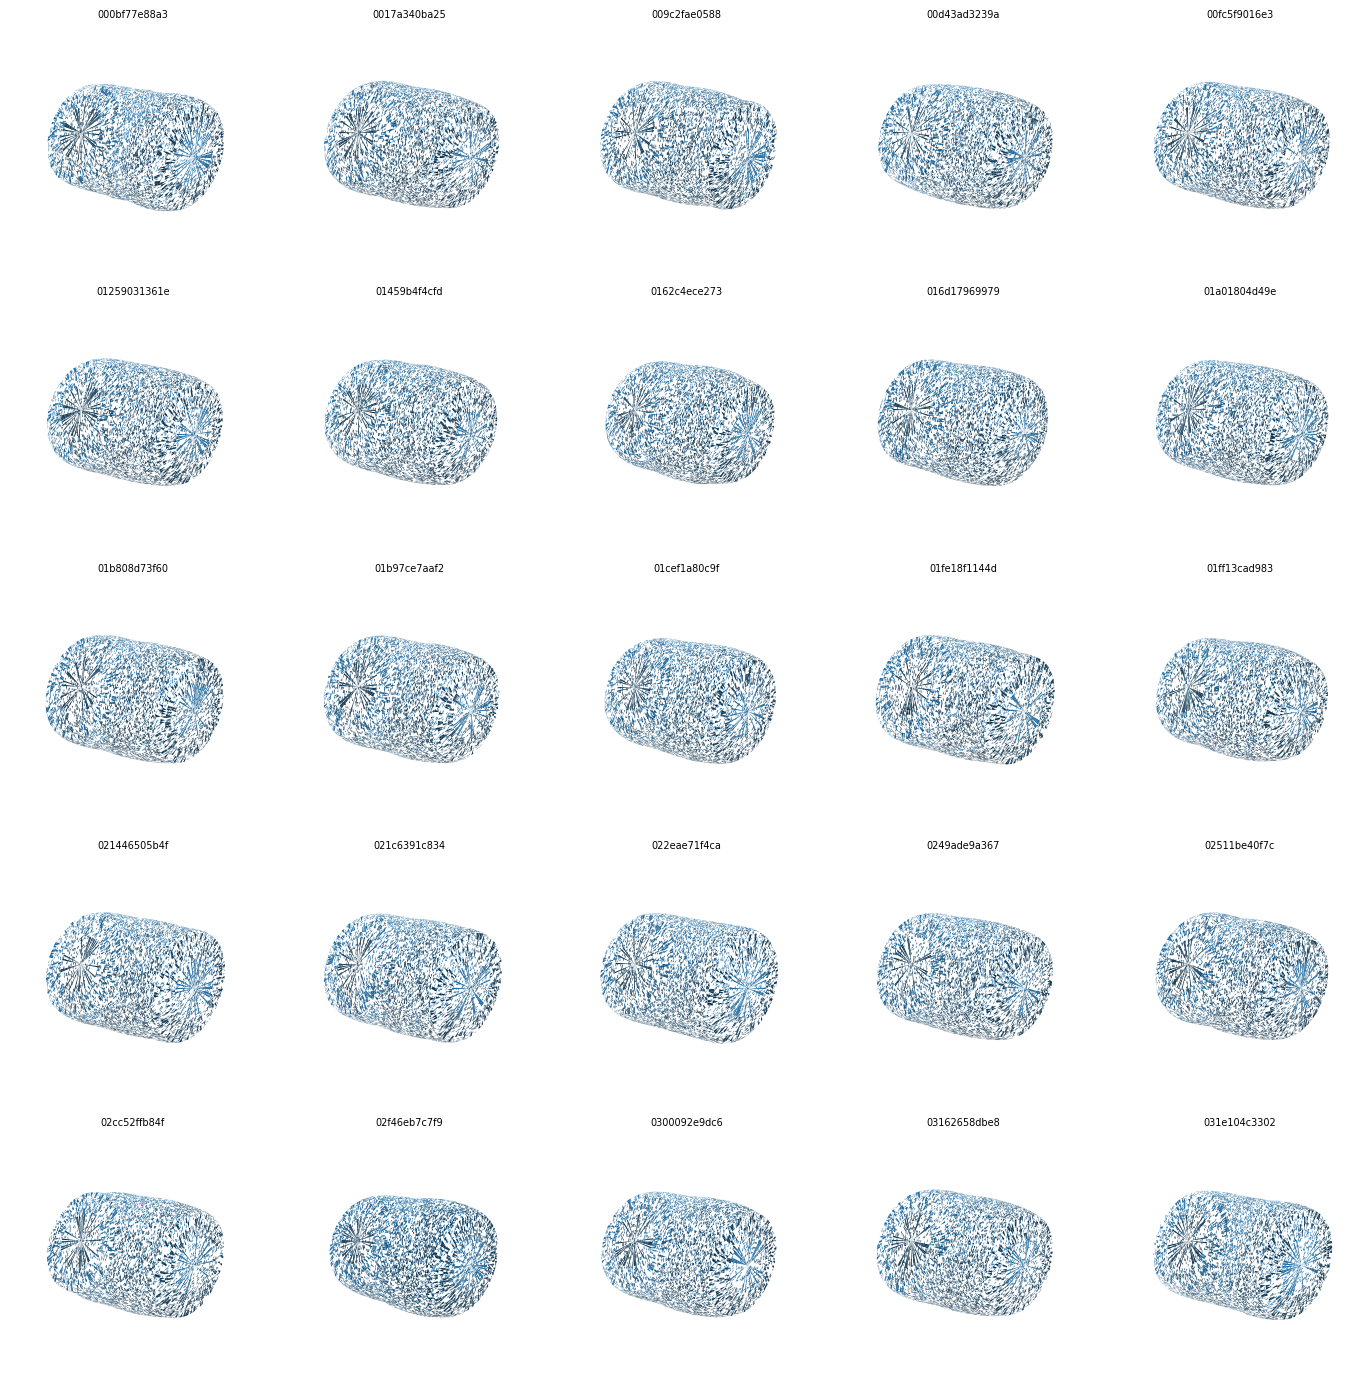

[SAVED] 5x5 mesh grid: /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs/viz_axisym/mesh_grid_5x5.png

[3D TRAIN] samples=2000 train=1600 val=400 | workers=12


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[E001] train=6.1687 val=6.1225 (4.7s)
  -> saved best: /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs/pointnet_mt_best.pt
[E002] train=6.0888 val=6.0520 (4.3s)
  -> saved best: /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs/pointnet_mt_best.pt
[E003] train=5.8703 val=5.7493 (4.5s)
  -> saved best: /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs/pointnet_mt_best.pt
[E004] train=5.4779 val=5.3182 (4.8s)
  -> saved best: /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs/pointnet_mt_best.pt
[E005] train=5.1433 val=5.0354 (4.4s)
  -> saved best: /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs/pointnet_mt_best.pt
[E006] train=4.9505 val=4.7974 (4.6s)
  -> saved best: /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs/pointnet_mt_best.pt
[E007] train=4.7464 val=4.6377 (4.5s)
  -> saved best: /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs/pointnet_mt_best.pt
[E008] train=4.5830 val=4.4729 (4.4s)
  -> saved best: /content/drive

In [ ]:
# ============================================================
# NEXT STEP (COMPLETE / FIXED): 2D Mask -> Axisymmetric 3D Meshes -> Point Clouds -> 3D Training
# FIXED: trimesh version-safe cleanup (no remove_duplicate_faces crash)
# Uses 12 workers (mesh generation + dataloaders)
# Saves meshes + pointclouds + 5x5 grid viz
# ============================================================

# ----------------------------
# 0) Install deps (Colab-safe)
# ----------------------------
import sys, subprocess
def _pip(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", pkg])

_pip("trimesh")
_pip("opencv-python-headless==4.10.0.84")
_pip("scipy")
_pip("numpy")
_pip("pandas")
_pip("matplotlib")
_pip("scikit-learn")

# ----------------------------
# 1) Imports + Mount Drive
# ----------------------------
import os, re, math, time, random
from pathlib import Path

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from scipy.spatial import cKDTree
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import trimesh
from concurrent.futures import ProcessPoolExecutor, as_completed

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# ----------------------------
# 2) Paths (USE YOUR EXACT NAMES)
# ----------------------------
OUT_DIR   = Path("/content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs")
INDEX_CSV = OUT_DIR / "index.csv"

CKPT_SKEL = OUT_DIR / "ckpt_skeleton_best.pt"
CKPT_OVL  = OUT_DIR / "ckpt_overlay_best.pt"

MESH_DIR  = OUT_DIR / "meshes_axisym"
PC_DIR    = OUT_DIR / "pointclouds_axisym"
VIZ_DIR   = OUT_DIR / "viz_axisym"
PRED_DIR  = OUT_DIR / "pred_masks"  # only used if USE_PRED_MASK=True

for d in [MESH_DIR, PC_DIR, VIZ_DIR, PRED_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("[INFO] OUT_DIR:", OUT_DIR)
print("[INFO] INDEX_CSV exists?", INDEX_CSV.exists(), INDEX_CSV)

# ----------------------------
# 3) Optional labels.csv loader (robust)
# ----------------------------
LABELS_CSV = Path("/content/drive/MyDrive/Matreskas/labels.csv")

def find_labels_csv():
    if LABELS_CSV.exists():
        return LABELS_CSV
    cand = list(Path("/content/drive/MyDrive").rglob("labels.csv"))
    return cand[0] if len(cand) else None

labels_csv_found = find_labels_csv()
print("[INFO] labels.csv:", labels_csv_found)

# ----------------------------
# 4) Load index.csv
# ----------------------------
if not INDEX_CSV.exists():
    raise FileNotFoundError(f"Missing index.csv at: {INDEX_CSV}")

df = pd.read_csv(INDEX_CSV)
if len(df) == 0:
    raise RuntimeError("index.csv is empty")

required_cols = ["uid", "frame_path", "axis_x_crop", "mask_png", "skeleton_png", "overlay_crop_png"]
for c in required_cols:
    if c not in df.columns:
        raise KeyError(f"index.csv missing column '{c}'. Found: {list(df.columns)}")

print("[INFO] index.csv rows:", len(df))

# ----------------------------
# 5) Label resolution
# ----------------------------
def infer_style_from_frame_path(p: str):
    parts = Path(p).parts
    if "frames" in parts:
        i = parts.index("frames")
        if i + 1 < len(parts):
            return parts[i+1]
    return Path(p).parent.name

def normalize_style(s: str):
    s = str(s).strip()
    s = s.replace("-", "_").replace(" ", "_")
    return s

def heuristic_auth_from_style(style: str):
    st = style.lower()
    if "russian" in st and "auth" in st:
        return "RU"
    if "non" in st and "auth" in st:
        return "non-RU"
    return "unknown"

df["style"] = df["frame_path"].astype(str).apply(infer_style_from_frame_path).apply(normalize_style)

# Merge authenticity from labels.csv when possible
if labels_csv_found is not None:
    lab = pd.read_csv(labels_csv_found)
    cand_auth = [c for c in lab.columns if c.lower() in ("auth", "authenticity", "auth_label", "authentic")]
    cand_path = [c for c in lab.columns if ("path" in c.lower()) or ("video" in c.lower()) or ("frame" in c.lower())]

    auth_col = cand_auth[0] if len(cand_auth) else None
    path_col = None
    for c in lab.columns:
        if c.lower() == "frame_path":
            path_col = c
            break
    if path_col is None and len(cand_path):
        path_col = cand_path[0]

    if auth_col is not None and path_col is not None:
        lab2 = lab[[path_col, auth_col]].copy()
        lab2.columns = ["_path", "_auth"]
        lab2["_path"] = lab2["_path"].astype(str)

        m = df.merge(lab2, left_on="frame_path", right_on="_path", how="left")
        df["_auth"] = m["_auth"].values
        print(f"[INFO] Merged authenticity from labels.csv using columns: path={path_col}, auth={auth_col}")
    else:
        df["_auth"] = None
        print("[WARN] labels.csv found but could not identify columns for path/authenticity. Using heuristic.")
else:
    df["_auth"] = None

def norm_auth(a: str):
    t = str(a).strip().lower()
    if t in ("ru", "russian_authentic", "russian", "authentic_ru", "auth"):
        return "RU"
    if t in ("non-ru", "non_ru", "nonru", "replica", "fake", "non_authentic", "non-authentic"):
        return "non-RU"
    if t in ("unknown", "unk", "na", "n/a", ""):
        return "unknown"
    if t.startswith("ru"):
        return "RU"
    if ("non" in t and "ru" in t) or ("non" in t and "auth" in t):
        return "non-RU"
    return "unknown"

df["authenticity"] = df["_auth"].fillna(df["style"].apply(heuristic_auth_from_style)).apply(norm_auth)

print("[INFO] style counts:\n", df["style"].value_counts().head(15))
print("[INFO] authenticity counts:\n", df["authenticity"].value_counts())

styles = sorted(df["style"].unique().tolist())
auths  = ["RU", "non-RU", "unknown"]

style2i = {s:i for i,s in enumerate(styles)}
auth2i  = {a:i for i,a in enumerate(auths)}

df["y_style"] = df["style"].map(style2i).astype(int)
df["y_auth"]  = df["authenticity"].map(auth2i).fillna(auth2i["unknown"]).astype(int)

print("[INFO] #styles:", len(styles))
print("[INFO] auth2i:", auth2i)

# ----------------------------
# 6) Optional: use predicted masks from AE
# ----------------------------
USE_PRED_MASK = False
USE_MODE      = "skeleton"   # "skeleton" or "overlay"
THRESH        = 0.5
IMG_SIZE      = 128

class MaskAE(nn.Module):
    def __init__(self, in_ch: int, latent_ch: int = 128):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(in_ch, 32, 3, 2, 1), nn.BatchNorm2d(32), nn.ReLU(True),
            nn.Conv2d(32, 64, 3, 2, 1), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.Conv2d(64, 128, 3, 2, 1), nn.BatchNorm2d(128), nn.ReLU(True),
            nn.Conv2d(128, latent_ch, 3, 2, 1), nn.BatchNorm2d(latent_ch), nn.ReLU(True)
        )
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(latent_ch, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 4, 2, 1)
        )
    def forward(self, x):
        return torch.sigmoid(self.dec(self.enc(x)))

def load_ae(ckpt_path: Path, device):
    ckpt = torch.load(ckpt_path, map_location=device)
    m = MaskAE(in_ch=int(ckpt["in_ch"])).to(device)
    m.load_state_dict(ckpt["model"])
    m.eval()
    return m, int(ckpt["in_ch"])

def predict_masks(df_in: pd.DataFrame, device="cuda"):
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    ckpt_path = CKPT_SKEL if USE_MODE == "skeleton" else CKPT_OVL
    model, in_ch = load_ae(ckpt_path, device)
    print("[INFO] Loaded AE:", ckpt_path, "in_ch=", in_ch)

    out_paths = []
    bs = 64
    rows = df_in.reset_index(drop=True)

    for i in range(0, len(rows), bs):
        batch = rows.iloc[i:i+bs]
        xs = []
        for _, r in batch.iterrows():
            if USE_MODE == "skeleton":
                x = cv2.imread(r["skeleton_png"], cv2.IMREAD_GRAYSCALE)
                if x is None: raise RuntimeError(r["skeleton_png"])
                x = (x.astype(np.float32) / 255.0)[None, ...]
            else:
                x = cv2.imread(r["overlay_crop_png"], cv2.IMREAD_COLOR)
                if x is None: raise RuntimeError(r["overlay_crop_png"])
                x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
                x = (x.astype(np.float32) / 255.0).transpose(2,0,1)
            xs.append(x)

        xT = torch.from_numpy(np.stack(xs, axis=0)).to(device)
        with torch.no_grad():
            yhat = model(xT).cpu().numpy()  # (B,1,H,W)

        for j in range(yhat.shape[0]):
            uid = str(batch.iloc[j]["uid"])
            pm = (yhat[j,0] > THRESH).astype(np.uint8) * 255
            ppath = (PRED_DIR / f"{uid}.png")
            cv2.imwrite(ppath.as_posix(), pm)
            out_paths.append(ppath.as_posix())

    return out_paths

if USE_PRED_MASK:
    print("[INFO] Predicting masks with AE...")
    df["mask_for_mesh"] = predict_masks(df, device="cuda")
else:
    df["mask_for_mesh"] = df["mask_png"].astype(str)

# ----------------------------
# 7) Axisymmetric mesh from silhouette mask
# ----------------------------
def mask_to_radius_profile(mask01: np.ndarray, axis_x: float, min_fg_per_row=6):
    H, W = mask01.shape[:2]
    ys, rs = [], []
    ax = float(axis_x)

    for y in range(H):
        xs = np.where(mask01[y] > 0)[0]
        if xs.size < min_fg_per_row:
            continue
        r = float(np.max(np.abs(xs.astype(np.float32) - ax)))
        if r <= 1.0:
            continue
        ys.append(float(y))
        rs.append(r)

    if len(ys) < 10:
        return None, None

    ys = np.asarray(ys, dtype=np.float32)
    rs = np.asarray(rs, dtype=np.float32)

    k = 9
    if len(rs) > k:
        rs = np.convolve(rs, np.ones(k)/k, mode="same")

    ys = (ys - ys.min()) / max(1e-6, (ys.max() - ys.min()))
    return ys, rs

def safe_mesh_cleanup(mesh: trimesh.Trimesh) -> trimesh.Trimesh:
    """
    Version-safe cleanup that avoids methods missing in some trimesh builds.
    """
    if mesh is None or len(mesh.vertices) == 0 or len(mesh.faces) == 0:
        return mesh

    # 1) Drop degenerate faces manually
    f = np.asarray(mesh.faces, dtype=np.int64)
    deg = (f[:,0] == f[:,1]) | (f[:,0] == f[:,2]) | (f[:,1] == f[:,2])
    f = f[~deg]
    if f.shape[0] == 0:
        return trimesh.Trimesh(vertices=np.asarray(mesh.vertices), faces=np.zeros((0,3), dtype=np.int64), process=False)

    # 2) Drop duplicate faces (ignore winding) manually
    fs = np.sort(f, axis=1)
    _, keep_idx = np.unique(fs, axis=0, return_index=True)
    keep_idx = np.sort(keep_idx)
    f = f[keep_idx]

    # 3) Rebuild with process=True (lets trimesh do whatever it can)
    mesh2 = trimesh.Trimesh(vertices=np.asarray(mesh.vertices), faces=f, process=True)

    # 4) Optional safe calls if present
    for name in ("remove_unreferenced_vertices", "merge_vertices", "rezero", "remove_infinite_values"):
        fn = getattr(mesh2, name, None)
        if callable(fn):
            try:
                fn()
            except Exception:
                pass

    return mesh2

def revolve_profile_to_mesh(ys, rs, n_theta=128, scale=1.0, cap=True):
    ys = np.asarray(ys, dtype=np.float32)
    rs = (np.asarray(rs, dtype=np.float32) * float(scale))

    Ny = ys.shape[0]
    th = np.linspace(0, 2*np.pi, n_theta, endpoint=False).astype(np.float32)

    verts = np.zeros((Ny, n_theta, 3), dtype=np.float32)
    for i in range(Ny):
        r = rs[i]
        verts[i,:,0] = r * np.cos(th)   # x
        verts[i,:,2] = r * np.sin(th)   # z
        verts[i,:,1] = ys[i]            # y

    V = verts.reshape(-1, 3)
    faces = []

    def vid(i, j):
        return i*n_theta + (j % n_theta)

    for i in range(Ny-1):
        for j in range(n_theta):
            a = vid(i, j)
            b = vid(i, j+1)
            c = vid(i+1, j)
            d = vid(i+1, j+1)
            faces.append([a, c, b])
            faces.append([b, c, d])

    if cap:
        bottom_center = len(V)
        V = np.vstack([V, np.array([[0.0, ys[0], 0.0]], dtype=np.float32)])
        for j in range(n_theta):
            a = vid(0, j)
            b = vid(0, j+1)
            faces.append([bottom_center, b, a])

        top_center = len(V)
        V = np.vstack([V, np.array([[0.0, ys[-1], 0.0]], dtype=np.float32)])
        for j in range(n_theta):
            a = vid(Ny-1, j)
            b = vid(Ny-1, j+1)
            faces.append([top_center, a, b])

    faces = np.asarray(faces, dtype=np.int64)
    mesh = trimesh.Trimesh(vertices=V, faces=faces, process=True)

    # repair holes if possible (safe)
    fill = getattr(mesh, "fill_holes", None)
    if callable(fill):
        try:
            fill()
        except Exception:
            pass

    mesh = safe_mesh_cleanup(mesh)
    return mesh

def sample_pointcloud(mesh, n_points=2048):
    pts = mesh.sample(n_points)
    vnorm = mesh.vertex_normals
    if vnorm is None or len(vnorm) == 0:
        try:
            mesh.rezero()
        except Exception:
            pass
        vnorm = mesh.vertex_normals

    kdt = cKDTree(np.asarray(mesh.vertices))
    _, nn = kdt.query(np.asarray(pts), k=1)
    nrm = np.asarray(vnorm)[nn]
    nrm = nrm / (np.linalg.norm(nrm, axis=1, keepdims=True) + 1e-12)
    return pts.astype(np.float32), nrm.astype(np.float32)

# ----------------------------
# 8) Mesh/PointCloud generation with 12 workers
# ----------------------------
N_THETA     = 128
SCALE       = 1.0 / 64.0
N_POINTS    = 2048
MAX_MESHES  = 2000
NUM_WORKERS = 12

df_sub = df.sample(n=min(MAX_MESHES, len(df)), random_state=7).reset_index(drop=True)
print("[INFO] Generating meshes for:", len(df_sub), "samples")

def _job_make_mesh(row_dict):
    uid = str(row_dict["uid"])
    axis_x = float(row_dict["axis_x_crop"])
    mask_path = row_dict["mask_for_mesh"]

    m = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    if m is None:
        return (uid, False, "mask_read_fail")

    mask01 = (m > 127).astype(np.uint8)

    ys, rs = mask_to_radius_profile(mask01, axis_x=axis_x)
    if ys is None:
        return (uid, False, "profile_fail")

    mesh = revolve_profile_to_mesh(ys, rs, n_theta=N_THETA, scale=SCALE, cap=True)
    if mesh is None or len(mesh.vertices) < 50 or len(mesh.faces) < 50:
        return (uid, False, "mesh_fail")

    mesh_path = (MESH_DIR / f"{uid}.ply").as_posix()
    mesh.export(mesh_path)

    pts, nrm = sample_pointcloud(mesh, n_points=N_POINTS)
    pc_path = (PC_DIR / f"{uid}.npz").as_posix()
    np.savez_compressed(pc_path, points=pts, normals=nrm)

    return (uid, True, "ok")

ok = 0
fails = []
t0 = time.time()

with ProcessPoolExecutor(max_workers=NUM_WORKERS) as ex:
    futs = [ex.submit(_job_make_mesh, df_sub.iloc[i].to_dict()) for i in range(len(df_sub))]
    for k, fut in enumerate(as_completed(futs), 1):
        try:
            uid, good, msg = fut.result()
        except Exception as e:
            uid, good, msg = ("<unknown>", False, f"exception:{type(e).__name__}")
        if good:
            ok += 1
        else:
            fails.append((uid, msg))
        if k % 50 == 0:
            print(f"[MESH] done {k}/{len(futs)} | ok={ok} | fails={len(fails)}")

print(f"[DONE] Mesh+PC generation: ok={ok}/{len(df_sub)} in {time.time()-t0:.1f}s")
if len(fails):
    print("[WARN] failures (first 30):", fails[:30])

df_sub["pc_npz"] = df_sub["uid"].astype(str).apply(lambda u: (PC_DIR / f"{u}.npz").as_posix())
df_ok = df_sub[df_sub["pc_npz"].apply(lambda p: Path(p).exists())].reset_index(drop=True)
print("[INFO] Final usable 3D samples:", len(df_ok))
if len(df_ok) < 50:
    raise RuntimeError("Too few 3D samples generated. Increase MAX_MESHES or check masks/axis_x_crop quality.")

# ----------------------------
# 9) 5x5 Grid of generated meshes (SAVED + DISPLAYED)
# ----------------------------
def plot_mesh_grid(mesh_paths, out_png, grid=5, max_faces_draw=6000):
    n = grid * grid
    mesh_paths = mesh_paths[:n]

    fig = plt.figure(figsize=(14, 14))
    for i, mp in enumerate(mesh_paths):
        mesh = trimesh.load(mp, force="mesh")
        v = np.asarray(mesh.vertices)
        f = np.asarray(mesh.faces)
        if f.shape[0] > max_faces_draw:
            idx = np.random.choice(f.shape[0], size=max_faces_draw, replace=False)
            f = f[idx]

        ax = fig.add_subplot(grid, grid, i+1, projection="3d")
        ax.plot_trisurf(v[:,0], v[:,1], v[:,2], triangles=f, linewidth=0.0, antialiased=True)
        ax.set_axis_off()
        ax.view_init(elev=18, azim=35)
        ax.set_title(Path(mp).stem, fontsize=7)

    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.show()

mesh_list = sorted([p.as_posix() for p in MESH_DIR.glob("*.ply")])
print("[INFO] meshes available:", len(mesh_list))
grid_png = (VIZ_DIR / "mesh_grid_5x5.png").as_posix()
plot_mesh_grid(mesh_list, grid_png, grid=5)
print("[SAVED] 5x5 mesh grid:", grid_png)

# ----------------------------
# 10) 3D Model (PointNet-style multi-task classifier)
# ----------------------------
class PointCloudDataset(Dataset):
    def __init__(self, df_rows: pd.DataFrame, n_points=2048, augment=True):
        self.df = df_rows.reset_index(drop=True)
        self.n_points = int(n_points)
        self.augment = bool(augment)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        npz = np.load(r["pc_npz"])
        pts = npz["points"].astype(np.float32)
        nrm = npz["normals"].astype(np.float32)

        N = pts.shape[0]
        if N >= self.n_points:
            sel = np.random.choice(N, size=self.n_points, replace=False)
        else:
            sel = np.random.choice(N, size=self.n_points, replace=True)

        pts = pts[sel]
        nrm = nrm[sel]

        pts = pts - pts.mean(axis=0, keepdims=True)
        scale = np.max(np.linalg.norm(pts, axis=1)) + 1e-6
        pts = pts / scale

        if self.augment:
            ang = np.random.uniform(0, 2*np.pi)
            ca, sa = np.cos(ang), np.sin(ang)
            R = np.array([[ca, 0, sa],
                          [0,  1, 0 ],
                          [-sa,0, ca]], dtype=np.float32)
            pts = pts @ R.T
            nrm = nrm @ R.T
            pts = pts + np.random.normal(0, 0.005, size=pts.shape).astype(np.float32)

        x = np.concatenate([pts, nrm], axis=1)       # (P,6)
        x = torch.from_numpy(x).transpose(0, 1)      # (6,P)

        y_style = int(r["y_style"])
        y_auth  = int(r["y_auth"])
        return x, torch.tensor(y_style, dtype=torch.long), torch.tensor(y_auth, dtype=torch.long)

class PointNetMT(nn.Module):
    def __init__(self, in_ch=6, n_style=8, n_auth=3):
        super().__init__()
        self.mlp1 = nn.Sequential(
            nn.Conv1d(in_ch, 64, 1), nn.BatchNorm1d(64), nn.ReLU(True),
            nn.Conv1d(64, 128, 1), nn.BatchNorm1d(128), nn.ReLU(True),
            nn.Conv1d(128, 256, 1), nn.BatchNorm1d(256), nn.ReLU(True),
        )
        self.mlp2 = nn.Sequential(
            nn.Linear(256, 256), nn.ReLU(True), nn.Dropout(0.2),
            nn.Linear(256, 128), nn.ReLU(True)
        )
        self.head_style = nn.Linear(128, n_style)
        self.head_auth  = nn.Linear(128, n_auth)

    def forward(self, x):
        f = self.mlp1(x)
        g = torch.max(f, dim=2).values
        h = self.mlp2(g)
        return self.head_style(h), self.head_auth(h)

class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0, mode="min"):
        self.patience = int(patience)
        self.min_delta = float(min_delta)
        self.mode = mode
        self.best = None
        self.bad = 0

    def step(self, val):
        if self.best is None:
            self.best = float(val)
            self.bad = 0
            return False
        improved = (val < self.best - self.min_delta) if self.mode == "min" else (val > self.best + self.min_delta)
        if improved:
            self.best = float(val)
            self.bad = 0
            return False
        self.bad += 1
        return self.bad >= self.patience

train_df, val_df = train_test_split(
    df_ok, test_size=0.2, random_state=7, shuffle=True, stratify=df_ok["y_auth"]
)

BATCH_SIZE  = 32
NUM_WORKERS = 12
N_STYLE     = len(styles)
N_AUTH      = 3

train_ds = PointCloudDataset(train_df, n_points=N_POINTS, augment=True)
val_ds   = PointCloudDataset(val_df,   n_points=N_POINTS, augment=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PointNetMT(in_ch=6, n_style=N_STYLE, n_auth=N_AUTH).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

MAX_EPOCHS = 200
PATIENCE   = 8
MIN_DELTA  = 1e-4
early = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA, mode="min")

best_val = float("inf")
best_path = (OUT_DIR / "pointnet_mt_best.pt").as_posix()

def eval_epoch():
    model.eval()
    tot = 0.0
    n = 0
    with torch.no_grad():
        for x, y_style, y_auth in val_loader:
            x = x.to(device, non_blocking=True)
            y_style = y_style.to(device, non_blocking=True)
            y_auth  = y_auth.to(device, non_blocking=True)
            ls, la = model(x)
            loss = F.cross_entropy(ls, y_style) + F.cross_entropy(la, y_auth)
            tot += float(loss.item()) * x.size(0)
            n += x.size(0)
    return tot / max(1, n)

print(f"\n[3D TRAIN] samples={len(df_ok)} train={len(train_ds)} val={len(val_ds)} | workers={NUM_WORKERS}")

for epoch in range(1, MAX_EPOCHS + 1):
    model.train()
    t0 = time.time()
    tot = 0.0
    n = 0

    for x, y_style, y_auth in train_loader:
        x = x.to(device, non_blocking=True)
        y_style = y_style.to(device, non_blocking=True)
        y_auth  = y_auth.to(device, non_blocking=True)

        opt.zero_grad(set_to_none=True)
        ls, la = model(x)
        loss = F.cross_entropy(ls, y_style) + F.cross_entropy(la, y_auth)
        loss.backward()
        opt.step()

        tot += float(loss.item()) * x.size(0)
        n += x.size(0)

    tr_loss = tot / max(1, n)
    va_loss = eval_epoch()
    dt = time.time() - t0
    print(f"[E{epoch:03d}] train={tr_loss:.4f} val={va_loss:.4f} ({dt:.1f}s)")

    if va_loss < best_val - MIN_DELTA:
        best_val = va_loss
        torch.save({
            "model": model.state_dict(),
            "epoch": epoch,
            "best_val": best_val,
            "styles": styles,
            "auths": auths,
            "style2i": style2i,
            "auth2i": auth2i,
            "n_points": N_POINTS,
        }, best_path)
        print("  -> saved best:", best_path)

    if early.step(va_loss):
        print(f"[EARLY STOP] no improvement for {PATIENCE} epochs. best_val={early.best:.6f}")
        break

print("\n[DONE]")
print("Meshes:", MESH_DIR)
print("PointClouds:", PC_DIR)
print("5x5 Grid:", grid_png)
print("Best 3D ckpt:", best_path)


In [ ]:
# ============================================================
# COMPLETE COLAB SCRIPT:
# Compare 5x 3D backbones on your skeletonized/axisymmetric meshes
#   (PointNet vs DGCNN vs PointNet++ vs PCT (Transformer) vs PointMLP)
#
# Assumes you ALREADY generated point clouds:
#   OUT_DIR/pointclouds_axisym/<uid>.npz  with arrays: points (N,3), normals (N,3)
#
# Uses index.csv from your pipeline:
#   OUT_DIR/index.csv with columns including: uid, frame_path, axis_x_crop, ...
#
# Outputs:
#   OUT_DIR/compare3d/<model_name>_best.pt
#   OUT_DIR/compare3d/curves_<model_name>.png
#   OUT_DIR/compare3d/summary.csv
#   OUT_DIR/compare3d/compare_val_auth_acc.png
#
# Notes:
# - Default worker cap avoids Colab freezes (you can override).
# - Multi-task heads: style (N_STYLE) + authenticity (3)
# ============================================================

import os, math, time, random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# ----------------------------
# 0) Repro + device
# ----------------------------
SEED = 7
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("[INFO] device:", device)

# ----------------------------
# 1) Paths (EDIT ONLY IF NEEDED)
# ----------------------------
OUT_DIR   = Path("/content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs")
INDEX_CSV = OUT_DIR / "index.csv"
PC_DIR    = OUT_DIR / "pointclouds_axisym"
LABELS_CSV = Path("/content/drive/MyDrive/Matreskas/labels.csv")

RUN_DIR = OUT_DIR / "compare3d"
RUN_DIR.mkdir(parents=True, exist_ok=True)

assert INDEX_CSV.exists(), f"Missing: {INDEX_CSV}"
assert PC_DIR.exists(), f"Missing: {PC_DIR}"

print("[INFO] OUT_DIR:", OUT_DIR)
print("[INFO] INDEX_CSV:", INDEX_CSV)
print("[INFO] PC_DIR:", PC_DIR)

# ----------------------------
# 2) Load index.csv and resolve labels (style + authenticity)
# ----------------------------
df = pd.read_csv(INDEX_CSV)
if len(df) == 0:
    raise RuntimeError("index.csv is empty")

if "uid" not in df.columns or "frame_path" not in df.columns:
    raise KeyError("index.csv must contain at least columns: uid, frame_path")

def infer_style_from_frame_path(p: str):
    parts = Path(str(p)).parts
    if "frames" in parts:
        i = parts.index("frames")
        if i + 1 < len(parts):
            return parts[i+1]
    return Path(str(p)).parent.name

def normalize_style(s: str):
    s = str(s).strip()
    s = s.replace("-", "_").replace(" ", "_")
    return s

def heuristic_auth_from_style(style: str):
    st = style.lower()
    if "russian" in st and "auth" in st:
        return "RU"
    if "non" in st and "auth" in st:
        return "non-RU"
    return "unknown"

def norm_auth(a: str):
    t = str(a).strip().lower()
    if t in ("ru", "russian_authentic", "russian", "authentic_ru", "auth"):
        return "RU"
    if t in ("non-ru", "non_ru", "nonru", "replica", "fake", "non_authentic", "non-authentic"):
        return "non-RU"
    if t in ("unknown", "unk", "na", "n/a", ""):
        return "unknown"
    if t.startswith("ru"):
        return "RU"
    if "non" in t and "ru" in t:
        return "non-RU"
    return "unknown"

df["style"] = df["frame_path"].apply(infer_style_from_frame_path).apply(normalize_style)

# Try merge authenticity from labels.csv (if it contains frame_path + auth)
if LABELS_CSV.exists():
    lab = pd.read_csv(LABELS_CSV)
    cand_auth = [c for c in lab.columns if c.lower() in ("auth", "authenticity", "auth_label", "authentic")]
    path_col = None
    if "frame_path" in lab.columns:
        path_col = "frame_path"
    else:
        cand_path = [c for c in lab.columns if ("path" in c.lower()) or ("video" in c.lower()) or ("frame" in c.lower())]
        if len(cand_path):
            path_col = cand_path[0]
    auth_col = cand_auth[0] if len(cand_auth) else None

    if path_col is not None and auth_col is not None:
        lab2 = lab[[path_col, auth_col]].copy()
        lab2.columns = ["_path", "_auth"]
        lab2["_path"] = lab2["_path"].astype(str)
        df["frame_path"] = df["frame_path"].astype(str)

        m = df.merge(lab2, left_on="frame_path", right_on="_path", how="left")
        df["_auth"] = m["_auth"].values
        print(f"[INFO] Merged authenticity from labels.csv using path={path_col}, auth={auth_col}")
    else:
        df["_auth"] = None
        print("[WARN] labels.csv found but could not identify path/auth columns. Using heuristic.")
else:
    df["_auth"] = None
    print("[WARN] labels.csv not found. Using heuristic authenticity.")

df["authenticity"] = df["_auth"].fillna(df["style"].apply(heuristic_auth_from_style)).apply(norm_auth)

# Attach pointcloud paths and filter existing
df["pc_npz"] = df["uid"].astype(str).apply(lambda u: (PC_DIR / f"{u}.npz").as_posix())
df_ok = df[df["pc_npz"].apply(lambda p: Path(p).exists())].reset_index(drop=True)

print("[INFO] index rows:", len(df), "usable pointclouds:", len(df_ok))
if len(df_ok) < 50:
    raise RuntimeError("Too few pointclouds found. Confirm pointclouds_axisym/*.npz exist and match uid.")

styles = sorted(df_ok["style"].unique().tolist())
auths  = ["RU", "non-RU", "unknown"]
style2i = {s:i for i,s in enumerate(styles)}
auth2i  = {a:i for i,a in enumerate(auths)}

df_ok["y_style"] = df_ok["style"].map(style2i).astype(int)
df_ok["y_auth"]  = df_ok["authenticity"].map(auth2i).fillna(auth2i["unknown"]).astype(int)

N_STYLE = len(styles)
N_AUTH  = 3
print("[INFO] #styles:", N_STYLE, "| auth classes:", auths)

# ----------------------------
# 3) Split (stratify on authenticity)
# ----------------------------
train_df, val_df = train_test_split(
    df_ok, test_size=0.2, random_state=SEED, shuffle=True, stratify=df_ok["y_auth"]
)
print("[INFO] split train:", len(train_df), "val:", len(val_df))

# ----------------------------
# 4) Dataset
# ----------------------------
class PointCloudDataset(Dataset):
    def __init__(self, df_rows: pd.DataFrame, n_points=2048, augment=True):
        self.df = df_rows.reset_index(drop=True)
        self.n_points = int(n_points)
        self.augment = bool(augment)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        npz = np.load(r["pc_npz"])
        pts = npz["points"].astype(np.float32)   # (N,3)
        nrm = npz["normals"].astype(np.float32)  # (N,3)

        N = pts.shape[0]
        if N >= self.n_points:
            sel = np.random.choice(N, size=self.n_points, replace=False)
        else:
            sel = np.random.choice(N, size=self.n_points, replace=True)
        pts = pts[sel]
        nrm = nrm[sel]

        # normalize
        pts = pts - pts.mean(axis=0, keepdims=True)
        scale = np.max(np.linalg.norm(pts, axis=1)) + 1e-6
        pts = pts / scale

        # augment: y-axis rotation + jitter
        if self.augment:
            ang = np.random.uniform(0, 2*np.pi)
            ca, sa = np.cos(ang), np.sin(ang)
            R = np.array([[ca, 0, sa],
                          [0,  1, 0 ],
                          [-sa,0, ca]], dtype=np.float32)
            pts = pts @ R.T
            nrm = nrm @ R.T
            pts = pts + np.random.normal(0, 0.005, size=pts.shape).astype(np.float32)

        x = np.concatenate([pts, nrm], axis=1)     # (P,6)
        x = torch.from_numpy(x).transpose(0, 1)    # (6,P)
        xyz = torch.from_numpy(pts).transpose(0, 1) # (3,P)

        y_style = torch.tensor(int(r["y_style"]), dtype=torch.long)
        y_auth  = torch.tensor(int(r["y_auth"]), dtype=torch.long)
        return x, xyz, y_style, y_auth

# ----------------------------
# 5) DataLoaders (worker cap to reduce freezes)
# ----------------------------
N_POINTS = 2048
BATCH_SIZE = 32

def safe_num_workers(requested=12):
    cpu = os.cpu_count() or 8
    # conservative cap for Colab stability
    cap = min(8, max(2, cpu // 2))
    return min(int(requested), cap)

NUM_WORKERS = safe_num_workers(12)   # you asked 12; capped for stability
print("[INFO] num_workers requested=12 -> using:", NUM_WORKERS)

train_ds = PointCloudDataset(train_df, n_points=N_POINTS, augment=True)
val_ds   = PointCloudDataset(val_df,   n_points=N_POINTS, augment=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

# ============================================================
# 6) Core geometry ops (KNN, grouping, FPS) for DGCNN/PN++/Transformers
# ============================================================
def knn(xyz, k):
    """
    xyz: (B,3,N)
    return idx: (B,N,k) nearest neighbors (excluding self)
    """
    B, _, N = xyz.shape
    x = xyz
    # pairwise distance: ||a-b||^2 = ||a||^2 + ||b||^2 - 2 a^T b
    xx = torch.sum(x**2, dim=1, keepdim=True)                  # (B,1,N)
    inner = -2.0 * torch.bmm(x.transpose(2,1), x)              # (B,N,N)
    pairwise = xx.transpose(2,1) + inner + xx                  # (B,N,N)
    idx = pairwise.topk(k=k+1, dim=-1, largest=False)[1][:,:,1:]  # drop self
    return idx

def index_points(points, idx):
    """
    points: (B,N,C)
    idx: (B,S) or (B,S,K)
    return: gathered points
    """
    B = points.shape[0]
    view_shape = list(idx.shape)
    view_shape[1:] = [1]*(len(view_shape)-1)
    repeat_shape = list(idx.shape)
    repeat_shape[0] = 1

    batch_indices = torch.arange(B, device=points.device).view(view_shape).repeat(repeat_shape)
    return points[batch_indices, idx, :]

def square_distance(src, dst):
    """
    src: (B,N,3), dst: (B,M,3) -> dist: (B,N,M)
    """
    B, N, _ = src.shape
    _, M, _ = dst.shape
    dist = -2 * torch.matmul(src, dst.permute(0,2,1))
    dist += torch.sum(src**2, dim=-1).view(B, N, 1)
    dist += torch.sum(dst**2, dim=-1).view(B, 1, M)
    return dist

def farthest_point_sample(xyz, npoint):
    """
    xyz: (B,N,3) -> centroids: (B,npoint)
    """
    device_ = xyz.device
    B, N, _ = xyz.shape
    centroids = torch.zeros(B, npoint, dtype=torch.long, device=device_)
    distance = torch.ones(B, N, device=device_) * 1e10
    farthest = torch.randint(0, N, (B,), dtype=torch.long, device=device_)
    batch_indices = torch.arange(B, dtype=torch.long, device=device_)
    for i in range(npoint):
        centroids[:, i] = farthest
        centroid = xyz[batch_indices, farthest, :].view(B, 1, 3)
        dist = torch.sum((xyz - centroid) ** 2, dim=-1)
        mask = dist < distance
        distance[mask] = dist[mask]
        farthest = torch.max(distance, dim=-1)[1]
    return centroids

def get_graph_feature(x, idx):
    """
    x: (B,C,N)
    idx: (B,N,k)
    return: (B,2C,N,k) [x_i, x_j-x_i]
    """
    B, C, N = x.shape
    k = idx.shape[-1]
    x_t = x.transpose(2,1).contiguous()          # (B,N,C)
    neighbors = index_points(x_t, idx)           # (B,N,k,C)
    x_i = x_t.unsqueeze(2).expand(-1, -1, k, -1) # (B,N,k,C)
    edge = torch.cat([x_i, neighbors - x_i], dim=-1)  # (B,N,k,2C)
    return edge.permute(0,3,1,2).contiguous()         # (B,2C,N,k)

# ============================================================
# 7) Models (multi-task): PointNet, DGCNN, PointNet++, PCT, PointMLP
# ============================================================
class PointNetMT(nn.Module):
    def __init__(self, in_ch=6, n_style=8, n_auth=3):
        super().__init__()
        self.feat = nn.Sequential(
            nn.Conv1d(in_ch, 64, 1), nn.BatchNorm1d(64), nn.ReLU(True),
            nn.Conv1d(64, 128, 1), nn.BatchNorm1d(128), nn.ReLU(True),
            nn.Conv1d(128, 256, 1), nn.BatchNorm1d(256), nn.ReLU(True),
        )
        self.mlp = nn.Sequential(
            nn.Linear(256, 256), nn.ReLU(True), nn.Dropout(0.2),
            nn.Linear(256, 128), nn.ReLU(True),
        )
        self.head_style = nn.Linear(128, n_style)
        self.head_auth  = nn.Linear(128, n_auth)

    def forward(self, x, xyz=None):
        # x: (B,6,N)
        f = self.feat(x)                  # (B,256,N)
        g = torch.max(f, dim=2).values    # (B,256)
        h = self.mlp(g)                   # (B,128)
        return self.head_style(h), self.head_auth(h)

class EdgeConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(2*in_ch, out_ch, 1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x, idx):
        # x: (B,C,N), idx: (B,N,k)
        e = get_graph_feature(x, idx)      # (B,2C,N,k)
        y = self.net(e).max(dim=-1)[0]     # (B,out,N)
        return y

class DGCNNMT(nn.Module):
    def __init__(self, in_ch=6, n_style=8, n_auth=3, k=20):
        super().__init__()
        self.k = int(k)
        self.ec1 = EdgeConvBlock(in_ch, 64)
        self.ec2 = EdgeConvBlock(64, 64)
        self.ec3 = EdgeConvBlock(64, 128)
        self.ec4 = EdgeConvBlock(128, 256)
        self.fuse = nn.Sequential(
            nn.Conv1d(64+64+128+256, 512, 1, bias=False),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.mlp = nn.Sequential(
            nn.Linear(512, 256), nn.ReLU(True), nn.Dropout(0.3),
            nn.Linear(256, 128), nn.ReLU(True)
        )
        self.head_style = nn.Linear(128, n_style)
        self.head_auth  = nn.Linear(128, n_auth)

    def forward(self, x, xyz):
        # x: (B,6,N), xyz: (B,3,N)
        idx = knn(xyz, self.k)
        x1 = self.ec1(x, idx)             # (B,64,N)
        idx = knn(xyz, self.k)
        x2 = self.ec2(x1, idx)            # (B,64,N)
        idx = knn(xyz, self.k)
        x3 = self.ec3(x2, idx)            # (B,128,N)
        idx = knn(xyz, self.k)
        x4 = self.ec4(x3, idx)            # (B,256,N)

        cat = torch.cat([x1, x2, x3, x4], dim=1)  # (B,512,N)
        f = self.fuse(cat)                        # (B,512,N)
        g = torch.max(f, dim=2).values            # (B,512)
        h = self.mlp(g)                           # (B,128)
        return self.head_style(h), self.head_auth(h)

class SetAbstraction(nn.Module):
    def __init__(self, npoint, nsample, in_ch, mlp_ch):
        super().__init__()
        self.npoint = npoint
        self.nsample = nsample
        layers = []
        last = in_ch
        for c in mlp_ch:
            layers += [nn.Conv2d(last, c, 1, bias=False), nn.BatchNorm2d(c), nn.ReLU(True)]
            last = c
        self.mlp = nn.Sequential(*layers)

    def forward(self, xyz, feats):
        """
        xyz:  (B,N,3)
        feats:(B,C,N) or None
        returns new_xyz:(B,S,3), new_feats:(B,C',S)
        """
        B, N, _ = xyz.shape
        S = self.npoint

        # FPS
        fps_idx = farthest_point_sample(xyz, S)            # (B,S)
        new_xyz = index_points(xyz, fps_idx)               # (B,S,3)

        # kNN grouping (approx ball query)
        dist = square_distance(new_xyz, xyz)               # (B,S,N)
        group_idx = dist.topk(k=self.nsample, dim=-1, largest=False)[1]  # (B,S,K)
        grouped_xyz = index_points(xyz, group_idx)         # (B,S,K,3)
        grouped_xyz = grouped_xyz - new_xyz.unsqueeze(2)   # relative

        if feats is not None:
            feats_t = feats.transpose(2,1).contiguous()    # (B,N,C)
            grouped_feats = index_points(feats_t, group_idx)  # (B,S,K,C)
            grouped = torch.cat([grouped_xyz, grouped_feats], dim=-1)   # (B,S,K,3+C)
        else:
            grouped = grouped_xyz                          # (B,S,K,3)

        grouped = grouped.permute(0,3,1,2).contiguous()    # (B,3+C,S,K)
        out = self.mlp(grouped).max(dim=-1)[0]             # (B,C',S)
        return new_xyz, out

class PointNet2SSGMT(nn.Module):
    def __init__(self, in_ch=6, n_style=8, n_auth=3):
        super().__init__()
        # SA always concatenates grouped_xyz (3) + grouped_feats (C)
        self.sa1 = SetAbstraction(npoint=512, nsample=32, in_ch=3 + in_ch, mlp_ch=[64, 64, 128])
        self.sa2 = SetAbstraction(npoint=128, nsample=32, in_ch=3 + 128,   mlp_ch=[128, 128, 256])
        self.sa3 = SetAbstraction(npoint=1,   nsample=128, in_ch=3 + 256,  mlp_ch=[256, 512, 1024])

        self.fc = nn.Sequential(
            nn.Linear(1024, 512), nn.ReLU(True), nn.Dropout(0.3),
            nn.Linear(512, 128), nn.ReLU(True)
        )
        self.head_style = nn.Linear(128, n_style)
        self.head_auth  = nn.Linear(128, n_auth)

    def forward(self, x, xyz):
        """
        x:   (B,6,N)  features (pts+normals) from dataset
        xyz: (B,3,N)  coordinates
        """
        xyz0 = xyz.transpose(2, 1).contiguous()  # (B,N,3)

        # IMPORTANT FIX:
        # pass ONLY feature channels (C=in_ch) into SA,
        # since SA will append grouped_xyz (3) internally.
        feats0 = x.contiguous()                  # (B,6,N)

        l1_xyz, l1_f = self.sa1(xyz0, feats0)    # (B,512,3), (B,128,512)
        l2_xyz, l2_f = self.sa2(l1_xyz, l1_f)    # (B,128,3), (B,256,128)
        l3_xyz, l3_f = self.sa3(l2_xyz, l2_f)    # (B,1,3),   (B,1024,1)

        g = l3_f.squeeze(-1)                     # (B,1024)
        h = self.fc(g)                           # (B,128)
        return self.head_style(h), self.head_auth(h)


class LocalAttentionBlock(nn.Module):
    """
    Simple Point Cloud Transformer-style local attention over kNN neighborhoods.
    """
    def __init__(self, dim, k=16):
        super().__init__()
        self.k = int(k)
        self.q = nn.Conv1d(dim, dim, 1, bias=False)
        self.kv = nn.Conv1d(dim, dim*2, 1, bias=False)
        self.pos_mlp = nn.Sequential(
            nn.Conv2d(3, dim, 1, bias=False), nn.BatchNorm2d(dim), nn.ReLU(True),
            nn.Conv2d(dim, dim, 1, bias=False)
        )
        self.attn_mlp = nn.Sequential(
            nn.Conv2d(dim, dim, 1, bias=False), nn.BatchNorm2d(dim), nn.ReLU(True),
            nn.Conv2d(dim, dim, 1, bias=False)
        )
        self.proj = nn.Conv1d(dim, dim, 1, bias=False)
        self.bn = nn.BatchNorm1d(dim)

    def forward(self, feat, xyz):
        """
        feat: (B,dim,N)
        xyz:  (B,3,N)
        """
        B, D, N = feat.shape
        idx = knn(xyz, self.k)                                  # (B,N,k)

        # gather neighbor features
        feat_t = feat.transpose(2,1).contiguous()               # (B,N,D)
        nb = index_points(feat_t, idx)                          # (B,N,k,D)
        nb = nb.permute(0,3,1,2).contiguous()                   # (B,D,N,k)

        # relative positions
        xyz_t = xyz.transpose(2,1).contiguous()                 # (B,N,3)
        nb_xyz = index_points(xyz_t, idx)                       # (B,N,k,3)
        rel = nb_xyz - xyz_t.unsqueeze(2)                       # (B,N,k,3)
        rel = rel.permute(0,3,1,2).contiguous()                 # (B,3,N,k)

        q = self.q(feat).unsqueeze(-1)                          # (B,D,N,1)
        kv = self.kv(feat)                                      # (B,2D,N)
        k_, v_ = kv[:, :D, :], kv[:, D:, :]                     # (B,D,N), (B,D,N)
        k_t = k_.transpose(2,1).contiguous()                    # (B,N,D)
        v_t = v_.transpose(2,1).contiguous()                    # (B,N,D)
        k_nb = index_points(k_t, idx).permute(0,3,1,2).contiguous()  # (B,D,N,k)
        v_nb = index_points(v_t, idx).permute(0,3,1,2).contiguous()  # (B,D,N,k)

        pos = self.pos_mlp(rel)                                 # (B,D,N,k)
        attn_logits = self.attn_mlp(q - k_nb + pos)              # (B,D,N,k)
        attn = torch.softmax(attn_logits, dim=-1)                # (B,D,N,k)

        out = torch.sum(attn * (v_nb + pos), dim=-1)             # (B,D,N)
        out = self.bn(self.proj(out))                            # (B,D,N)

        return F.relu(feat + out, inplace=True)

class PCTMT(nn.Module):
    def __init__(self, in_ch=6, n_style=8, n_auth=3, dim=128, k=16, depth=4):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv1d(in_ch, 64, 1, bias=False), nn.BatchNorm1d(64), nn.ReLU(True),
            nn.Conv1d(64, dim, 1, bias=False), nn.BatchNorm1d(dim), nn.ReLU(True)
        )
        self.blocks = nn.ModuleList([LocalAttentionBlock(dim, k=k) for _ in range(depth)])
        self.head = nn.Sequential(
            nn.Linear(dim*2, 256), nn.ReLU(True), nn.Dropout(0.3),
            nn.Linear(256, 128), nn.ReLU(True)
        )
        self.head_style = nn.Linear(128, n_style)
        self.head_auth  = nn.Linear(128, n_auth)

    def forward(self, x, xyz):
        f = self.stem(x)  # (B,dim,N)
        for blk in self.blocks:
            f = blk(f, xyz)

        g_max = torch.max(f, dim=2).values
        g_avg = torch.mean(f, dim=2)
        g = torch.cat([g_max, g_avg], dim=1)   # (B,2*dim)
        h = self.head(g)                       # (B,128)
        return self.head_style(h), self.head_auth(h)

class PointMLPStage(nn.Module):
    """
    Simplified PointMLP-like local grouping stage:
    FPS -> kNN grouping -> MLP on (rel_xyz + features) -> max pool -> pointwise MLP
    """
    def __init__(self, npoint, k, in_ch, out_ch):
        super().__init__()
        self.npoint = int(npoint)
        self.k = int(k)
        self.local = nn.Sequential(
            nn.Conv2d(in_ch + 3, out_ch, 1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(True),
            nn.Conv2d(out_ch, out_ch, 1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(True),
        )
        self.post = nn.Sequential(
            nn.Conv1d(out_ch, out_ch, 1, bias=False),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(True)
        )

    def forward(self, xyz, feat):
        """
        xyz:  (B,N,3)
        feat: (B,C,N)
        returns new_xyz (B,S,3), new_feat (B,out,S)
        """
        B, N, _ = xyz.shape
        S = self.npoint
        fps_idx = farthest_point_sample(xyz, S)          # (B,S)
        new_xyz = index_points(xyz, fps_idx)             # (B,S,3)

        dist = square_distance(new_xyz, xyz)             # (B,S,N)
        idx = dist.topk(k=self.k, dim=-1, largest=False)[1]  # (B,S,k)

        grouped_xyz = index_points(xyz, idx)             # (B,S,k,3)
        rel = grouped_xyz - new_xyz.unsqueeze(2)         # (B,S,k,3)

        feat_t = feat.transpose(2,1).contiguous()        # (B,N,C)
        grouped_feat = index_points(feat_t, idx)         # (B,S,k,C)

        grouped = torch.cat([rel, grouped_feat], dim=-1) # (B,S,k,3+C)
        grouped = grouped.permute(0,3,1,2).contiguous()  # (B,3+C,S,k)

        out = self.local(grouped).max(dim=-1)[0]         # (B,out,S)
        out = self.post(out)                             # (B,out,S)
        return new_xyz, out

class PointMLPMT(nn.Module):
    def __init__(self, in_ch=6, n_style=8, n_auth=3):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv1d(in_ch, 64, 1, bias=False), nn.BatchNorm1d(64), nn.ReLU(True),
        )
        self.s1 = PointMLPStage(npoint=512, k=24, in_ch=64, out_ch=128)
        self.s2 = PointMLPStage(npoint=128, k=24, in_ch=128, out_ch=256)
        self.s3 = nn.Sequential(
            nn.Conv1d(256, 512, 1, bias=False), nn.BatchNorm1d(512), nn.ReLU(True)
        )
        self.fc = nn.Sequential(
            nn.Linear(512, 256), nn.ReLU(True), nn.Dropout(0.3),
            nn.Linear(256, 128), nn.ReLU(True)
        )
        self.head_style = nn.Linear(128, n_style)
        self.head_auth  = nn.Linear(128, n_auth)

    def forward(self, x, xyz):
        # xyz (B,3,N) -> (B,N,3)
        xyz0 = xyz.transpose(2,1).contiguous()
        f0 = self.stem(x)                                # (B,64,N)
        l1_xyz, l1_f = self.s1(xyz0, f0)                 # (B,512,3), (B,128,512)
        l2_xyz, l2_f = self.s2(l1_xyz, l1_f)             # (B,128,3), (B,256,128)
        f = self.s3(l2_f)                                # (B,512,128)
        g = torch.max(f, dim=2).values                   # (B,512)
        h = self.fc(g)                                   # (B,128)
        return self.head_style(h), self.head_auth(h)

# ------------------------------------------------------------
# Model factory
# ------------------------------------------------------------
def make_model(name: str):
    name = name.lower()
    if name == "pointnet":
        return PointNetMT(in_ch=6, n_style=N_STYLE, n_auth=N_AUTH)
    if name == "dgcnn":
        return DGCNNMT(in_ch=6, n_style=N_STYLE, n_auth=N_AUTH, k=20)
    if name in ("pointnet2", "pointnet++", "pn2"):
        return PointNet2SSGMT(in_ch=6, n_style=N_STYLE, n_auth=N_AUTH)
    if name in ("pct", "transformer"):
        return PCTMT(in_ch=6, n_style=N_STYLE, n_auth=N_AUTH, dim=128, k=16, depth=4)
    if name in ("pointmlp", "pmlp"):
        return PointMLPMT(in_ch=6, n_style=N_STYLE, n_auth=N_AUTH)
    raise ValueError(f"Unknown model: {name}")

# ============================================================
# 8) Train/Eval utilities
# ============================================================
@torch.no_grad()
def evaluate(model):
    model.eval()
    tot_loss = 0.0
    n = 0
    correct_style = 0
    correct_auth = 0
    for x, xyz, y_style, y_auth in val_loader:
        x = x.to(device, non_blocking=True)
        xyz = xyz.to(device, non_blocking=True)
        y_style = y_style.to(device, non_blocking=True)
        y_auth  = y_auth.to(device, non_blocking=True)

        ls, la = model(x, xyz)
        loss = F.cross_entropy(ls, y_style) + F.cross_entropy(la, y_auth)

        tot_loss += float(loss.item()) * x.size(0)
        n += x.size(0)

        pred_style = ls.argmax(dim=1)
        pred_auth  = la.argmax(dim=1)
        correct_style += int((pred_style == y_style).sum().item())
        correct_auth  += int((pred_auth  == y_auth ).sum().item())

    return {
        "val_loss": tot_loss / max(1, n),
        "val_style_acc": correct_style / max(1, n),
        "val_auth_acc": correct_auth / max(1, n),
    }

def train_one_model(model_name,
                    max_epochs=150,
                    lr=1e-3,
                    weight_decay=1e-5,
                    patience=10,
                    min_delta=1e-4):
    model = make_model(model_name).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best = float("inf")
    bad = 0

    ckpt_path = (RUN_DIR / f"{model_name}_best.pt").as_posix()

    hist = {
        "epoch": [],
        "train_loss": [],
        "val_loss": [],
        "val_style_acc": [],
        "val_auth_acc": [],
    }

    print(f"\n========== TRAIN {model_name.upper()} ==========")
    print(f"[INFO] train={len(train_ds)} val={len(val_ds)} | points={N_POINTS} | batch={BATCH_SIZE} | workers={NUM_WORKERS}")

    for epoch in range(1, max_epochs + 1):
        t0 = time.time()
        model.train()

        tot = 0.0
        n = 0

        for x, xyz, y_style, y_auth in train_loader:
            x = x.to(device, non_blocking=True)
            xyz = xyz.to(device, non_blocking=True)
            y_style = y_style.to(device, non_blocking=True)
            y_auth  = y_auth.to(device, non_blocking=True)

            opt.zero_grad(set_to_none=True)
            ls, la = model(x, xyz)
            loss = F.cross_entropy(ls, y_style) + F.cross_entropy(la, y_auth)
            loss.backward()
            opt.step()

            tot += float(loss.item()) * x.size(0)
            n += x.size(0)

        tr_loss = tot / max(1, n)
        ev = evaluate(model)

        hist["epoch"].append(epoch)
        hist["train_loss"].append(tr_loss)
        hist["val_loss"].append(ev["val_loss"])
        hist["val_style_acc"].append(ev["val_style_acc"])
        hist["val_auth_acc"].append(ev["val_auth_acc"])

        dt = time.time() - t0
        print(f"[E{epoch:03d}] train={tr_loss:.4f} | val={ev['val_loss']:.4f} | "
              f"acc_style={ev['val_style_acc']:.3f} acc_auth={ev['val_auth_acc']:.3f} | {dt:.1f}s")

        # save best
        if ev["val_loss"] < best - min_delta:
            best = ev["val_loss"]
            bad = 0
            torch.save({
                "model_name": model_name,
                "model": model.state_dict(),
                "epoch": epoch,
                "best_val_loss": best,
                "styles": styles,
                "auths": auths,
                "style2i": style2i,
                "auth2i": auth2i,
                "n_points": N_POINTS,
            }, ckpt_path)
            print("  -> saved best:", ckpt_path)
        else:
            bad += 1

        if bad >= patience:
            print(f"[EARLY STOP] no improvement for {patience} epochs. best_val={best:.6f}")
            break

    # plot curves
    out_png = (RUN_DIR / f"curves_{model_name}.png").as_posix()
    fig = plt.figure(figsize=(10, 6))
    plt.plot(hist["epoch"], hist["train_loss"], label="train loss")
    plt.plot(hist["epoch"], hist["val_loss"], label="val loss")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.title(f"{model_name}: loss")
    plt.legend(); plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.close(fig)

    out_png2 = (RUN_DIR / f"acc_{model_name}.png").as_posix()
    fig = plt.figure(figsize=(10, 6))
    plt.plot(hist["epoch"], hist["val_style_acc"], label="val style acc")
    plt.plot(hist["epoch"], hist["val_auth_acc"], label="val auth acc")
    plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.title(f"{model_name}: validation accuracy")
    plt.legend(); plt.tight_layout()
    plt.savefig(out_png2, dpi=200)
    plt.close(fig)

    print("[SAVED]", out_png)
    print("[SAVED]", out_png2)
    return ckpt_path, best, hist

# ============================================================
# 9) Run comparison
# ============================================================
MODELS_TO_RUN = [
    "pointnet",
    "dgcnn",
    "pointnet2",   # PointNet++
    "pct",         # Transformer-style
    "pointmlp",    # MLP local grouping
]

results = []
all_hist = {}

for name in MODELS_TO_RUN:
    ckpt, best_val, hist = train_one_model(
        name,
        max_epochs=150,
        lr=1e-3,
        weight_decay=1e-5,
        patience=10,
        min_delta=1e-4
    )
    all_hist[name] = hist
    # record final best val stats by reloading ckpt for evaluation
    ck = torch.load(ckpt, map_location=device)
    m = make_model(name).to(device)
    m.load_state_dict(ck["model"])
    ev = evaluate(m)
    results.append({
        "model": name,
        "best_val_loss": float(ck["best_val_loss"]),
        "val_style_acc": float(ev["val_style_acc"]),
        "val_auth_acc": float(ev["val_auth_acc"]),
        "ckpt_path": ckpt
    })

res_df = pd.DataFrame(results).sort_values("val_auth_acc", ascending=False)
summary_csv = (RUN_DIR / "summary.csv").as_posix()
res_df.to_csv(summary_csv, index=False)
print("\n========== SUMMARY (sorted by val_auth_acc) ==========")
print(res_df)
print("[SAVED]", summary_csv)

# Comparison plot (val_auth_acc)
cmp_png = (RUN_DIR / "compare_val_auth_acc.png").as_posix()
fig = plt.figure(figsize=(9, 5))
plt.bar(res_df["model"].tolist(), res_df["val_auth_acc"].tolist())
plt.ylabel("val authenticity accuracy")
plt.title("3D Backbone Comparison (authenticity head)")
plt.tight_layout()
plt.savefig(cmp_png, dpi=200)
plt.close(fig)
print("[SAVED]", cmp_png)

print("\n[DONE] Outputs in:", RUN_DIR)


[INFO] device: cuda
[INFO] OUT_DIR: /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs
[INFO] INDEX_CSV: /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs/index.csv
[INFO] PC_DIR: /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs/pointclouds_axisym
[INFO] Merged authenticity from labels.csv using path=video_path, auth=authenticity
[INFO] index rows: 2000 usable pointclouds: 2000
[INFO] #styles: 160 | auth classes: ['RU', 'non-RU', 'unknown']
[INFO] split train: 1600 val: 400
[INFO] num_workers requested=12 -> using: 4

========== TRAIN POINTNET ==========
[INFO] train=1600 val=400 | points=2048 | batch=32 | workers=4
[E001] train=6.1671 | val=6.1147 | acc_style=0.000 acc_auth=0.465 | 6.0s
  -> saved best: /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs/compare3d/pointnet_best.pt
[E002] train=6.0505 | val=5.9540 | acc_style=0.005 acc_auth=0.465 | 6.6s
  -> saved best: /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs/compare3d/pointnet_best.pt
[E

OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 44.12 MiB is free. Process 67099 has 14.70 GiB memory in use. Of the allocated memory 14.08 GiB is allocated by PyTorch, and 445.48 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# ============================================================
# ONE-SCRIPT COLAB PIPELINE (RESUMABLE):
# 2D Mask -> (optional AE mask) -> Axisymmetric 3D Mesh -> PointCloud
# -> Compare 5x 3D backbones (PointNet / DGCNN / PointNet++ / PCT / PointMLP)
#
# FEATURES (NO DUMMY DATA/MODELS):
# - Runs MULTIPLE TRIALS in a loop:
#     (A) GT mask  (B) AE skeleton mask  (C) AE overlay mask
# - Full resume/restart safety:
#     - mesh/pc generation is incremental (skips existing outputs)
#     - training saves per-epoch "last" checkpoints + "best"
#     - progress.json tracks completed (trial, model) and errors
# - OOM-safe defaults for PCT + AMP (mixed precision)
# - Rich metrics: loss, acc, balanced acc, macro-F1, macro-AUPRC, macro-AUROC
# - Plots: mesh grids, PC grids, curves, confusion matrices, timing, GPU peak,
#          per-trial & cross-trial comparisons
# - Everything saved to Drive under OUT_DIR
# ============================================================

# ----------------------------
# 0) Environment (set BEFORE torch import)
# ----------------------------
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,max_split_size_mb:128"

# ----------------------------
# 1) Install deps (Colab-safe)
# ----------------------------
import sys, subprocess
def _pip(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", pkg])

_pip("trimesh")
_pip("opencv-python-headless==4.10.0.84")
_pip("scipy")
_pip("numpy")
_pip("pandas")
_pip("matplotlib")
_pip("scikit-learn")

# ----------------------------
# 2) Imports + Mount Drive
# ----------------------------
import re, math, time, json, random
from pathlib import Path
from dataclasses import dataclass

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from scipy.spatial import cKDTree
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    f1_score, precision_score, recall_score,
    average_precision_score, roc_auc_score,
    confusion_matrix
)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import trimesh
from concurrent.futures import ProcessPoolExecutor, as_completed

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# ============================================================
# 3) GLOBAL CONFIG
# ============================================================
SEED = 7
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("[INFO] device:", device)

OUT_DIR   = Path("/content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs")
INDEX_CSV = OUT_DIR / "index.csv"

CKPT_SKEL = OUT_DIR / "ckpt_skeleton_best.pt"
CKPT_OVL  = OUT_DIR / "ckpt_overlay_best.pt"

LABELS_CSV = Path("/content/drive/MyDrive/Matreskas/labels.csv")

MASTER_DIR = OUT_DIR / "compare3d_master"
MASTER_DIR.mkdir(parents=True, exist_ok=True)
PROGRESS_JSON = MASTER_DIR / "progress.json"

# Mesh/PC generation defaults (per-trial you can override)
MAX_MESHES_DEFAULT = 2000
N_POINTS_DEFAULT   = 2048
N_THETA_DEFAULT    = 128
SCALE_DEFAULT      = 1.0 / 64.0

# AE mask prediction settings
THRESH   = 0.5
IMG_SIZE = 128

# Training defaults
MAX_EPOCHS_DEFAULT = 150
PATIENCE_DEFAULT   = 10
MIN_DELTA_DEFAULT  = 1e-4
LR_DEFAULT         = 1e-3
WD_DEFAULT         = 1e-5

# Worker settings (requested by you)
MESH_WORKERS_REQUESTED = 12
DL_WORKERS_REQUESTED   = 12

def _safe_int(x, default):
    try: return int(x)
    except: return default

def safe_num_workers(requested: int):
    # try requested first; if dataloader creation fails later we downshift automatically
    cpu = os.cpu_count() or 8
    return max(0, min(int(requested), max(2, cpu)))

# ============================================================
# 4) PROGRESS (resume marker)
# ============================================================
def load_progress():
    if PROGRESS_JSON.exists():
        with open(PROGRESS_JSON, "r") as f:
            return json.load(f)
    return {"done": {}, "errors": {}, "meta": {"created": time.time()}}

def save_progress(p):
    tmp = PROGRESS_JSON.with_suffix(".tmp")
    with open(tmp, "w") as f:
        json.dump(p, f, indent=2)
    tmp.replace(PROGRESS_JSON)

PROG = load_progress()
print("[INFO] progress file:", PROGRESS_JSON, "| exists:", PROGRESS_JSON.exists())

def key_done(trial_id: str, model_name: str):
    return f"{trial_id}::{model_name}"

# ============================================================
# 5) LOAD index.csv + LABEL RESOLUTION
# ============================================================
if not INDEX_CSV.exists():
    raise FileNotFoundError(f"Missing index.csv at: {INDEX_CSV}")

df = pd.read_csv(INDEX_CSV)
if len(df) == 0:
    raise RuntimeError("index.csv is empty")

required_cols = ["uid", "frame_path", "axis_x_crop", "mask_png", "skeleton_png", "overlay_crop_png"]
for c in required_cols:
    if c not in df.columns:
        raise KeyError(f"index.csv missing column '{c}'. Found: {list(df.columns)}")

def infer_style_from_frame_path(p: str):
    parts = Path(str(p)).parts
    if "frames" in parts:
        i = parts.index("frames")
        if i + 1 < len(parts):
            return parts[i+1]
    return Path(str(p)).parent.name

def normalize_style(s: str):
    s = str(s).strip()
    s = s.replace("-", "_").replace(" ", "_")
    return s

def heuristic_auth_from_style(style: str):
    st = style.lower()
    if "russian" in st and "auth" in st:
        return "RU"
    if "non" in st and "auth" in st:
        return "non-RU"
    return "unknown"

def norm_auth(a: str):
    t = str(a).strip().lower()
    if t in ("ru", "russian_authentic", "russian", "authentic_ru", "auth"):
        return "RU"
    if t in ("non-ru", "non_ru", "nonru", "replica", "fake", "non_authentic", "non-authentic"):
        return "non-RU"
    if t in ("unknown", "unk", "na", "n/a", ""):
        return "unknown"
    if t.startswith("ru"):
        return "RU"
    if ("non" in t and "ru" in t) or ("non" in t and "auth" in t):
        return "non-RU"
    return "unknown"

df["style"] = df["frame_path"].astype(str).apply(infer_style_from_frame_path).apply(normalize_style)

# Merge authenticity from labels.csv when possible
if LABELS_CSV.exists():
    lab = pd.read_csv(LABELS_CSV)
    cand_auth = [c for c in lab.columns if c.lower() in ("auth", "authenticity", "auth_label", "authentic")]
    path_col = None
    if "frame_path" in lab.columns:
        path_col = "frame_path"
    else:
        cand_path = [c for c in lab.columns if ("path" in c.lower()) or ("video" in c.lower()) or ("frame" in c.lower())]
        if len(cand_path):
            path_col = cand_path[0]
    auth_col = cand_auth[0] if len(cand_auth) else None

    if path_col is not None and auth_col is not None:
        lab2 = lab[[path_col, auth_col]].copy()
        lab2.columns = ["_path", "_auth"]
        lab2["_path"] = lab2["_path"].astype(str)
        df["frame_path"] = df["frame_path"].astype(str)
        m = df.merge(lab2, left_on="frame_path", right_on="_path", how="left")
        df["_auth"] = m["_auth"].values
        print(f"[INFO] Merged authenticity from labels.csv using path={path_col}, auth={auth_col}")
    else:
        df["_auth"] = None
        print("[WARN] labels.csv found but could not identify columns. Using heuristic.")
else:
    df["_auth"] = None
    print("[WARN] labels.csv not found. Using heuristic authenticity.")

df["authenticity"] = df["_auth"].fillna(df["style"].apply(heuristic_auth_from_style)).apply(norm_auth)

styles = sorted(df["style"].unique().tolist())
auths  = ["RU", "non-RU", "unknown"]
style2i = {s:i for i,s in enumerate(styles)}
auth2i  = {a:i for i,a in enumerate(auths)}

df["y_style"] = df["style"].map(style2i).astype(int)
df["y_auth"]  = df["authenticity"].map(auth2i).fillna(auth2i["unknown"]).astype(int)

print("[INFO] index rows:", len(df))
print("[INFO] #styles:", len(styles), "| auth counts:\n", df["authenticity"].value_counts())

# ============================================================
# 6) AE MASK PREDICTION (CACHED)
# ============================================================
class MaskAE(nn.Module):
    def __init__(self, in_ch: int, latent_ch: int = 128):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(in_ch, 32, 3, 2, 1), nn.BatchNorm2d(32), nn.ReLU(True),
            nn.Conv2d(32, 64, 3, 2, 1), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.Conv2d(64, 128, 3, 2, 1), nn.BatchNorm2d(128), nn.ReLU(True),
            nn.Conv2d(128, latent_ch, 3, 2, 1), nn.BatchNorm2d(latent_ch), nn.ReLU(True)
        )
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(latent_ch, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 4, 2, 1)
        )
    def forward(self, x):
        return torch.sigmoid(self.dec(self.enc(x)))

def load_ae(ckpt_path: Path, device_):
    ckpt = torch.load(ckpt_path, map_location=device_)
    m = MaskAE(in_ch=int(ckpt["in_ch"])).to(device_)
    m.load_state_dict(ckpt["model"])
    m.eval()
    return m, int(ckpt["in_ch"])

def predict_masks(df_in: pd.DataFrame, pred_dir: Path, use_mode: str, device_str="cuda"):
    pred_dir.mkdir(parents=True, exist_ok=True)
    device_ = torch.device(device_str if torch.cuda.is_available() else "cpu")
    ckpt_path = CKPT_SKEL if use_mode == "skeleton" else CKPT_OVL
    if not ckpt_path.exists():
        raise FileNotFoundError(f"Missing AE checkpoint: {ckpt_path}")

    model, in_ch = load_ae(ckpt_path, device_)
    print("[INFO] Loaded AE:", ckpt_path, "| in_ch=", in_ch)

    out_paths = []
    bs = 64
    rows = df_in.reset_index(drop=True)

    for i in range(0, len(rows), bs):
        batch = rows.iloc[i:i+bs]

        # skip if already predicted
        need = []
        for _, r in batch.iterrows():
            uid = str(r["uid"])
            ppath = pred_dir / f"{uid}.png"
            if ppath.exists():
                out_paths.append(ppath.as_posix())
            else:
                need.append(r)

        if len(need) == 0:
            continue

        xs = []
        uids = []
        for r in need:
            uids.append(str(r["uid"]))
            if use_mode == "skeleton":
                x = cv2.imread(r["skeleton_png"], cv2.IMREAD_GRAYSCALE)
                if x is None: raise RuntimeError(r["skeleton_png"])
                x = (x.astype(np.float32) / 255.0)[None, ...]
            else:
                x = cv2.imread(r["overlay_crop_png"], cv2.IMREAD_COLOR)
                if x is None: raise RuntimeError(r["overlay_crop_png"])
                x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
                x = (x.astype(np.float32) / 255.0).transpose(2,0,1)
            xs.append(x)

        xT = torch.from_numpy(np.stack(xs, axis=0)).to(device_)
        with torch.no_grad():
            yhat = model(xT).cpu().numpy()  # (B,1,H,W)

        for j, uid in enumerate(uids):
            pm = (yhat[j,0] > THRESH).astype(np.uint8) * 255
            ppath = pred_dir / f"{uid}.png"
            cv2.imwrite(ppath.as_posix(), pm)
            out_paths.append(ppath.as_posix())

    return out_paths

# ============================================================
# 7) AXISYMMETRIC MESH + PC GENERATION (RESUMABLE)
# ============================================================
def mask_to_radius_profile(mask01: np.ndarray, axis_x: float, min_fg_per_row=6, smooth_k=9):
    H, W = mask01.shape[:2]
    ys, rs = [], []
    ax = float(axis_x)

    for y in range(H):
        xs = np.where(mask01[y] > 0)[0]
        if xs.size < min_fg_per_row:
            continue
        r = float(np.max(np.abs(xs.astype(np.float32) - ax)))
        if r <= 1.0:
            continue
        ys.append(float(y))
        rs.append(r)

    if len(ys) < 10:
        return None, None

    ys = np.asarray(ys, dtype=np.float32)
    rs = np.asarray(rs, dtype=np.float32)

    if smooth_k is not None and smooth_k >= 3 and len(rs) > smooth_k:
        rs = np.convolve(rs, np.ones(int(smooth_k))/float(smooth_k), mode="same")

    ys = (ys - ys.min()) / max(1e-6, (ys.max() - ys.min()))
    return ys, rs

def safe_mesh_cleanup(mesh: trimesh.Trimesh) -> trimesh.Trimesh:
    if mesh is None or len(mesh.vertices) == 0 or len(mesh.faces) == 0:
        return mesh

    f = np.asarray(mesh.faces, dtype=np.int64)
    deg = (f[:,0] == f[:,1]) | (f[:,0] == f[:,2]) | (f[:,1] == f[:,2])
    f = f[~deg]
    if f.shape[0] == 0:
        return trimesh.Trimesh(vertices=np.asarray(mesh.vertices), faces=np.zeros((0,3), dtype=np.int64), process=False)

    fs = np.sort(f, axis=1)
    _, keep_idx = np.unique(fs, axis=0, return_index=True)
    keep_idx = np.sort(keep_idx)
    f = f[keep_idx]

    mesh2 = trimesh.Trimesh(vertices=np.asarray(mesh.vertices), faces=f, process=True)

    for name in ("remove_unreferenced_vertices", "merge_vertices", "rezero", "remove_infinite_values"):
        fn = getattr(mesh2, name, None)
        if callable(fn):
            try: fn()
            except Exception: pass

    return mesh2

def revolve_profile_to_mesh(ys, rs, n_theta=128, scale=1.0, cap=True):
    ys = np.asarray(ys, dtype=np.float32)
    rs = (np.asarray(rs, dtype=np.float32) * float(scale))

    Ny = ys.shape[0]
    th = np.linspace(0, 2*np.pi, int(n_theta), endpoint=False).astype(np.float32)

    verts = np.zeros((Ny, int(n_theta), 3), dtype=np.float32)
    for i in range(Ny):
        r = rs[i]
        verts[i,:,0] = r * np.cos(th)
        verts[i,:,2] = r * np.sin(th)
        verts[i,:,1] = ys[i]

    V = verts.reshape(-1, 3)
    faces = []

    def vid(i, j):
        return i*int(n_theta) + (j % int(n_theta))

    for i in range(Ny-1):
        for j in range(int(n_theta)):
            a = vid(i, j)
            b = vid(i, j+1)
            c = vid(i+1, j)
            d = vid(i+1, j+1)
            faces.append([a, c, b])
            faces.append([b, c, d])

    if cap:
        bottom_center = len(V)
        V = np.vstack([V, np.array([[0.0, ys[0], 0.0]], dtype=np.float32)])
        for j in range(int(n_theta)):
            a = vid(0, j)
            b = vid(0, j+1)
            faces.append([bottom_center, b, a])

        top_center = len(V)
        V = np.vstack([V, np.array([[0.0, ys[-1], 0.0]], dtype=np.float32)])
        for j in range(int(n_theta)):
            a = vid(Ny-1, j)
            b = vid(Ny-1, j+1)
            faces.append([top_center, a, b])

    faces = np.asarray(faces, dtype=np.int64)
    mesh = trimesh.Trimesh(vertices=V, faces=faces, process=True)

    fill = getattr(mesh, "fill_holes", None)
    if callable(fill):
        try: fill()
        except Exception: pass

    return safe_mesh_cleanup(mesh)

def sample_pointcloud(mesh, n_points=2048):
    pts = mesh.sample(int(n_points))
    vnorm = mesh.vertex_normals
    if vnorm is None or len(vnorm) == 0:
        try: mesh.rezero()
        except Exception: pass
        vnorm = mesh.vertex_normals

    kdt = cKDTree(np.asarray(mesh.vertices))
    _, nn_idx = kdt.query(np.asarray(pts), k=1)
    nrm = np.asarray(vnorm)[nn_idx]
    nrm = nrm / (np.linalg.norm(nrm, axis=1, keepdims=True) + 1e-12)
    return pts.astype(np.float32), nrm.astype(np.float32)

def plot_mesh_grid(mesh_paths, out_png, grid=5, max_faces_draw=6000):
    n = grid * grid
    mesh_paths = mesh_paths[:n]
    fig = plt.figure(figsize=(14, 14))
    for i, mp in enumerate(mesh_paths):
        try:
            mesh = trimesh.load(mp, force="mesh")
            v = np.asarray(mesh.vertices)
            f = np.asarray(mesh.faces)
            if f.shape[0] > max_faces_draw:
                idx = np.random.choice(f.shape[0], size=max_faces_draw, replace=False)
                f = f[idx]
            ax = fig.add_subplot(grid, grid, i+1, projection="3d")
            ax.plot_trisurf(v[:,0], v[:,1], v[:,2], triangles=f, linewidth=0.0, antialiased=True)
            ax.set_axis_off()
            ax.view_init(elev=18, azim=35)
            ax.set_title(Path(mp).stem, fontsize=7)
        except Exception:
            ax = fig.add_subplot(grid, grid, i+1)
            ax.axis("off")
            ax.set_title("load_fail", fontsize=7)

    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.close(fig)

def plot_pc_grid(pc_paths, out_png, grid=5, max_points_draw=1024):
    n = grid * grid
    pc_paths = pc_paths[:n]
    fig = plt.figure(figsize=(14, 14))
    for i, pp in enumerate(pc_paths):
        try:
            z = np.load(pp)
            pts = z["points"]
            if pts.shape[0] > max_points_draw:
                idx = np.random.choice(pts.shape[0], size=max_points_draw, replace=False)
                pts = pts[idx]
            ax = fig.add_subplot(grid, grid, i+1, projection="3d")
            ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=1)
            ax.set_axis_off()
            ax.view_init(elev=18, azim=35)
            ax.set_title(Path(pp).stem, fontsize=7)
        except Exception:
            ax = fig.add_subplot(grid, grid, i+1)
            ax.axis("off")
            ax.set_title("load_fail", fontsize=7)
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.close(fig)

def generate_meshes_and_pcs(df_src: pd.DataFrame,
                            case_dir: Path,
                            mask_col: str,
                            max_meshes: int,
                            n_points: int,
                            n_theta: int,
                            scale: float,
                            cap: bool,
                            min_fg_per_row: int,
                            smooth_k: int,
                            mesh_workers: int):
    mesh_dir = case_dir / "meshes_axisym"
    pc_dir   = case_dir / "pointclouds_axisym"
    viz_dir  = case_dir / "viz_axisym"
    mesh_dir.mkdir(parents=True, exist_ok=True)
    pc_dir.mkdir(parents=True, exist_ok=True)
    viz_dir.mkdir(parents=True, exist_ok=True)

    # Select a stable subset and persist it for exact resumption
    sel_csv = case_dir / "selected_uids.csv"
    if sel_csv.exists():
        sel = pd.read_csv(sel_csv)
        uids = sel["uid"].astype(str).tolist()
        df_sub = df_src[df_src["uid"].astype(str).isin(uids)].copy().reset_index(drop=True)
        print("[INFO] Using persisted selection:", sel_csv, "| n=", len(df_sub))
    else:
        df_sub = df_src.sample(n=min(int(max_meshes), len(df_src)), random_state=SEED).copy().reset_index(drop=True)
        df_sub[["uid"]].to_csv(sel_csv, index=False)
        print("[INFO] Created selection:", sel_csv, "| n=", len(df_sub))

    def _job(row_dict):
        uid = str(row_dict["uid"])
        axis_x = float(row_dict["axis_x_crop"])
        mask_path = str(row_dict[mask_col])

        mesh_path = mesh_dir / f"{uid}.ply"
        pc_path   = pc_dir / f"{uid}.npz"

        # resume-friendly: if PC exists, we consider this sample done
        if pc_path.exists() and mesh_path.exists():
            return (uid, True, "skip_exists")

        m = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if m is None:
            return (uid, False, "mask_read_fail")

        mask01 = (m > 127).astype(np.uint8)

        ys, rs = mask_to_radius_profile(mask01, axis_x=axis_x, min_fg_per_row=min_fg_per_row, smooth_k=smooth_k)
        if ys is None:
            return (uid, False, "profile_fail")

        mesh = revolve_profile_to_mesh(ys, rs, n_theta=n_theta, scale=scale, cap=cap)
        if mesh is None or len(mesh.vertices) < 50 or len(mesh.faces) < 50:
            return (uid, False, "mesh_fail")

        try:
            mesh.export(mesh_path.as_posix())
        except Exception:
            return (uid, False, "mesh_export_fail")

        try:
            pts, nrm = sample_pointcloud(mesh, n_points=n_points)
            np.savez_compressed(pc_path.as_posix(), points=pts, normals=nrm)
        except Exception:
            return (uid, False, "pc_fail")

        return (uid, True, "ok")

    ok = 0
    fails = []
    t0 = time.time()
    mesh_workers = safe_num_workers(mesh_workers)

    with ProcessPoolExecutor(max_workers=mesh_workers) as ex:
        futs = [ex.submit(_job, df_sub.iloc[i].to_dict()) for i in range(len(df_sub))]
        for k, fut in enumerate(as_completed(futs), 1):
            try:
                uid, good, msg = fut.result()
            except Exception as e:
                uid, good, msg = ("<unknown>", False, f"exception:{type(e).__name__}")
            if good:
                ok += 1
            else:
                fails.append((uid, msg))
            if k % 50 == 0:
                print(f"[MESH] done {k}/{len(futs)} | ok={ok} | fails={len(fails)}")

    dt = time.time() - t0
    print(f"[DONE] Mesh+PC gen: ok={ok}/{len(df_sub)} in {dt:.1f}s | fails={len(fails)}")

    # Build usable list
    df_sub["mesh_ply"] = df_sub["uid"].astype(str).apply(lambda u: (mesh_dir / f"{u}.ply").as_posix())
    df_sub["pc_npz"]   = df_sub["uid"].astype(str).apply(lambda u: (pc_dir   / f"{u}.npz").as_posix())
    df_ok = df_sub[df_sub["pc_npz"].apply(lambda p: Path(p).exists())].copy().reset_index(drop=True)

    # Save generation report
    rep = {
        "case_dir": case_dir.as_posix(),
        "max_meshes": int(max_meshes),
        "n_points": int(n_points),
        "n_theta": int(n_theta),
        "scale": float(scale),
        "cap": bool(cap),
        "min_fg_per_row": int(min_fg_per_row),
        "smooth_k": int(smooth_k),
        "mesh_workers": int(mesh_workers),
        "ok": int(ok),
        "total": int(len(df_sub)),
        "usable": int(len(df_ok)),
        "fails_first_50": fails[:50],
        "seconds": float(dt),
    }
    with open((case_dir / "meshgen_report.json"), "w") as f:
        json.dump(rep, f, indent=2)

    # Plots: 5x5 mesh grid and 5x5 PC grid (resumable)
    mesh_list = sorted([p.as_posix() for p in mesh_dir.glob("*.ply")])
    pc_list   = sorted([p.as_posix() for p in pc_dir.glob("*.npz")])

    if len(mesh_list) > 0:
        plot_mesh_grid(mesh_list, (viz_dir / "mesh_grid_5x5.png").as_posix(), grid=5)
    if len(pc_list) > 0:
        plot_pc_grid(pc_list, (viz_dir / "pc_grid_5x5.png").as_posix(), grid=5)

    # Save usable table
    df_ok.to_csv((case_dir / "usable_3d.csv").as_posix(), index=False)

    # Plot fail reasons
    if len(fails) > 0:
        s = pd.Series([m for _, m in fails])
        vc = s.value_counts()
        fig = plt.figure(figsize=(10, 5))
        plt.bar(vc.index.tolist(), vc.values.tolist())
        plt.xticks(rotation=45, ha="right")
        plt.title("Mesh/PC failure reasons")
        plt.tight_layout()
        plt.savefig((viz_dir / "meshgen_fail_reasons.png").as_posix(), dpi=200)
        plt.close(fig)

    return df_ok, mesh_dir, pc_dir, viz_dir

# ============================================================
# 8) TRAINING METRICS + TIMING UTILITIES
# ============================================================
def gpu_peak_gb():
    if torch.cuda.is_available():
        return float(torch.cuda.max_memory_allocated() / (1024**3))
    return 0.0

def _softmax_np(logits_t: torch.Tensor) -> np.ndarray:
    return torch.softmax(logits_t, dim=1).detach().cpu().numpy()

def _one_vs_rest_scores(y_true: np.ndarray, prob: np.ndarray, n_classes: int):
    y_true = y_true.astype(int)
    y_onehot = np.eye(n_classes, dtype=np.float32)[y_true]
    auprcs, aurocs = [], []
    for c in range(n_classes):
        yt = y_onehot[:, c]
        ps = prob[:, c]
        if yt.sum() == 0 or yt.sum() == len(yt):
            continue
        auprcs.append(average_precision_score(yt, ps))
        try:
            aurocs.append(roc_auc_score(yt, ps))
        except Exception:
            pass
    macro_auprc = float(np.mean(auprcs)) if len(auprcs) else float("nan")
    macro_auroc = float(np.mean(aurocs)) if len(aurocs) else float("nan")
    return macro_auprc, macro_auroc

def compute_multiclass_metrics(y_true: np.ndarray, logits: torch.Tensor, n_classes: int, prefix: str):
    prob = _softmax_np(logits)
    y_pred = prob.argmax(axis=1)
    out = {
        f"{prefix}_acc": float(accuracy_score(y_true, y_pred)),
        f"{prefix}_bal_acc": float(balanced_accuracy_score(y_true, y_pred)),
        f"{prefix}_macro_f1": float(f1_score(y_true, y_pred, average="macro", zero_division=0)),
        f"{prefix}_macro_prec": float(precision_score(y_true, y_pred, average="macro", zero_division=0)),
        f"{prefix}_macro_rec": float(recall_score(y_true, y_pred, average="macro", zero_division=0)),
    }
    auprc, auroc = _one_vs_rest_scores(y_true, prob, n_classes)
    out[f"{prefix}_macro_auprc"] = auprc
    out[f"{prefix}_macro_auroc"] = auroc
    return out, prob, y_pred

def plot_confusion(cm: np.ndarray, labels: list, out_png: str, title: str):
    fig = plt.figure(figsize=(7, 6))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(labels))
    plt.xticks(ticks, labels, rotation=45, ha="right")
    plt.yticks(ticks, labels)
    plt.xlabel("Pred")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.close(fig)

def plot_curves(hist: dict, out_prefix: Path):
    # Loss
    fig = plt.figure(figsize=(10, 6))
    plt.plot(hist["epoch"], hist["train_loss"], label="train_loss")
    plt.plot(hist["epoch"], hist["val_loss"],   label="val_loss")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Loss")
    plt.legend(); plt.tight_layout()
    plt.savefig((out_prefix.parent / f"{out_prefix.name}_loss.png").as_posix(), dpi=200)
    plt.close(fig)

    # Accuracy + F1
    fig = plt.figure(figsize=(10, 6))
    plt.plot(hist["epoch"], hist["val_style_acc"], label="val_style_acc")
    plt.plot(hist["epoch"], hist["val_auth_acc"],  label="val_auth_acc")
    plt.plot(hist["epoch"], hist["val_style_macro_f1"], label="val_style_macro_f1")
    plt.plot(hist["epoch"], hist["val_auth_macro_f1"],  label="val_auth_macro_f1")
    plt.xlabel("epoch"); plt.ylabel("score"); plt.title("Accuracy / Macro-F1")
    plt.legend(); plt.tight_layout()
    plt.savefig((out_prefix.parent / f"{out_prefix.name}_acc_f1.png").as_posix(), dpi=200)
    plt.close(fig)

    # AUPRC/AUROC (auth + style)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(hist["epoch"], hist["val_style_macro_auprc"], label="val_style_macro_auprc")
    plt.plot(hist["epoch"], hist["val_auth_macro_auprc"],  label="val_auth_macro_auprc")
    plt.plot(hist["epoch"], hist["val_style_macro_auroc"], label="val_style_macro_auroc")
    plt.plot(hist["epoch"], hist["val_auth_macro_auroc"],  label="val_auth_macro_auroc")
    plt.xlabel("epoch"); plt.ylabel("score"); plt.title("Macro AUPRC / AUROC")
    plt.legend(); plt.tight_layout()
    plt.savefig((out_prefix.parent / f"{out_prefix.name}_auprc_auroc.png").as_posix(), dpi=200)
    plt.close(fig)

    # Timing + GPU peak
    if "epoch_wall_s" in hist:
        fig = plt.figure(figsize=(10, 6))
        plt.plot(hist["epoch"], hist["epoch_wall_s"], label="epoch_wall_s")
        plt.plot(hist["epoch"], hist["train_data_s"], label="train_data_s")
        plt.plot(hist["epoch"], hist["train_iter_s"], label="train_iter_s")
        plt.xlabel("epoch"); plt.ylabel("seconds"); plt.title("Timing")
        plt.legend(); plt.tight_layout()
        plt.savefig((out_prefix.parent / f"{out_prefix.name}_timing.png").as_posix(), dpi=200)
        plt.close(fig)

        fig = plt.figure(figsize=(10, 6))
        plt.plot(hist["epoch"], hist["gpu_peak_gb"], label="gpu_peak_gb")
        plt.xlabel("epoch"); plt.ylabel("GB"); plt.title("Peak GPU memory per epoch")
        plt.legend(); plt.tight_layout()
        plt.savefig((out_prefix.parent / f"{out_prefix.name}_gpu_peak.png").as_posix(), dpi=200)
        plt.close(fig)

# ============================================================
# 9) 3D DATASET (CASE-SPECIFIC PC_DIR)
# ============================================================
class PointCloudDataset(Dataset):
    def __init__(self, df_rows: pd.DataFrame, n_points=2048, augment=True, use_normals=True):
        self.df = df_rows.reset_index(drop=True)
        self.n_points = int(n_points)
        self.augment = bool(augment)
        self.use_normals = bool(use_normals)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        npz = np.load(r["pc_npz"])
        pts = npz["points"].astype(np.float32)   # (N,3)
        nrm = npz["normals"].astype(np.float32)  # (N,3)

        N = pts.shape[0]
        if N >= self.n_points:
            sel = np.random.choice(N, size=self.n_points, replace=False)
        else:
            sel = np.random.choice(N, size=self.n_points, replace=True)
        pts = pts[sel]
        nrm = nrm[sel]

        pts = pts - pts.mean(axis=0, keepdims=True)
        scale = np.max(np.linalg.norm(pts, axis=1)) + 1e-6
        pts = pts / scale

        if self.augment:
            ang = np.random.uniform(0, 2*np.pi)
            ca, sa = np.cos(ang), np.sin(ang)
            R = np.array([[ca, 0, sa],
                          [0,  1, 0 ],
                          [-sa,0, ca]], dtype=np.float32)
            pts = pts @ R.T
            nrm = nrm @ R.T
            pts = pts + np.random.normal(0, 0.005, size=pts.shape).astype(np.float32)

        if self.use_normals:
            x = np.concatenate([pts, nrm], axis=1)  # (P,6)
        else:
            x = pts                                # (P,3)

        x = torch.from_numpy(x).transpose(0, 1)     # (C,P)
        xyz = torch.from_numpy(pts).transpose(0, 1) # (3,P)

        y_style = torch.tensor(int(r["y_style"]), dtype=torch.long)
        y_auth  = torch.tensor(int(r["y_auth"]), dtype=torch.long)
        return x, xyz, y_style, y_auth

def build_loaders(train_df, val_df, batch_size, n_points, num_workers, use_normals=True):
    train_ds = PointCloudDataset(train_df, n_points=n_points, augment=True,  use_normals=use_normals)
    val_ds   = PointCloudDataset(val_df,   n_points=n_points, augment=False, use_normals=use_normals)

    # Attempt requested workers; if it fails, downshift automatically.
    nw = safe_num_workers(num_workers)
    for attempt in range(4):
        try:
            train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                                      num_workers=nw, pin_memory=True, drop_last=True)
            val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                                      num_workers=nw, pin_memory=True)
            return train_loader, val_loader, train_ds, val_ds, nw
        except Exception as e:
            print(f"[WARN] DataLoader failed with workers={nw}: {type(e).__name__}. Retrying with fewer workers.")
            nw = max(0, nw // 2)
    raise RuntimeError("DataLoader could not be created even with reduced workers.")

# ============================================================
# 10) CORE POINT OPS (KNN / FPS / GROUPING)
# ============================================================
def knn(xyz, k):
    B, _, N = xyz.shape
    x = xyz
    xx = torch.sum(x**2, dim=1, keepdim=True)         # (B,1,N)
    inner = -2.0 * torch.bmm(x.transpose(2,1), x)     # (B,N,N)
    pairwise = xx.transpose(2,1) + inner + xx         # (B,N,N)
    idx = pairwise.topk(k=k+1, dim=-1, largest=False)[1][:,:,1:]
    return idx

def index_points(points, idx):
    B = points.shape[0]
    view_shape = list(idx.shape)
    view_shape[1:] = [1]*(len(view_shape)-1)
    repeat_shape = list(idx.shape)
    repeat_shape[0] = 1
    batch_indices = torch.arange(B, device=points.device).view(view_shape).repeat(repeat_shape)
    return points[batch_indices, idx, :]

def square_distance(src, dst):
    B, N, _ = src.shape
    _, M, _ = dst.shape
    dist = -2 * torch.matmul(src, dst.permute(0,2,1))
    dist += torch.sum(src**2, dim=-1).view(B, N, 1)
    dist += torch.sum(dst**2, dim=-1).view(B, 1, M)
    return dist

def farthest_point_sample(xyz, npoint):
    device_ = xyz.device
    B, N, _ = xyz.shape
    centroids = torch.zeros(B, npoint, dtype=torch.long, device=device_)
    distance = torch.ones(B, N, device=device_) * 1e10
    farthest = torch.randint(0, N, (B,), dtype=torch.long, device=device_)
    batch_indices = torch.arange(B, dtype=torch.long, device=device_)
    for i in range(npoint):
        centroids[:, i] = farthest
        centroid = xyz[batch_indices, farthest, :].view(B, 1, 3)
        dist = torch.sum((xyz - centroid) ** 2, dim=-1)
        mask = dist < distance
        distance[mask] = dist[mask]
        farthest = torch.max(distance, dim=-1)[1]
    return centroids

def get_graph_feature(x, idx):
    B, C, N = x.shape
    k = idx.shape[-1]
    x_t = x.transpose(2,1).contiguous()               # (B,N,C)
    neighbors = index_points(x_t, idx)                # (B,N,k,C)
    x_i = x_t.unsqueeze(2).expand(-1, -1, k, -1)      # (B,N,k,C)
    edge = torch.cat([x_i, neighbors - x_i], dim=-1)  # (B,N,k,2C)
    return edge.permute(0,3,1,2).contiguous()         # (B,2C,N,k)

# ============================================================
# 11) MODELS (REAL IMPLEMENTATIONS)
# ============================================================
class PointNetMT(nn.Module):
    def __init__(self, in_ch=6, n_style=8, n_auth=3):
        super().__init__()
        self.feat = nn.Sequential(
            nn.Conv1d(in_ch, 64, 1), nn.BatchNorm1d(64), nn.ReLU(True),
            nn.Conv1d(64, 128, 1), nn.BatchNorm1d(128), nn.ReLU(True),
            nn.Conv1d(128, 256, 1), nn.BatchNorm1d(256), nn.ReLU(True),
        )
        self.mlp = nn.Sequential(
            nn.Linear(256, 256), nn.ReLU(True), nn.Dropout(0.2),
            nn.Linear(256, 128), nn.ReLU(True),
        )
        self.head_style = nn.Linear(128, n_style)
        self.head_auth  = nn.Linear(128, n_auth)

    def forward(self, x, xyz=None):
        f = self.feat(x)                # (B,256,N)
        g = torch.max(f, dim=2).values  # (B,256)
        h = self.mlp(g)                 # (B,128)
        return self.head_style(h), self.head_auth(h)

class EdgeConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(2*in_ch, out_ch, 1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.2, inplace=True)
        )
    def forward(self, x, idx):
        e = get_graph_feature(x, idx)
        y = self.net(e).max(dim=-1)[0]
        return y

class DGCNNMT(nn.Module):
    def __init__(self, in_ch=6, n_style=8, n_auth=3, k=20):
        super().__init__()
        self.k = int(k)
        self.ec1 = EdgeConvBlock(in_ch, 64)
        self.ec2 = EdgeConvBlock(64, 64)
        self.ec3 = EdgeConvBlock(64, 128)
        self.ec4 = EdgeConvBlock(128, 256)
        self.fuse = nn.Sequential(
            nn.Conv1d(64+64+128+256, 512, 1, bias=False),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.mlp = nn.Sequential(
            nn.Linear(512, 256), nn.ReLU(True), nn.Dropout(0.3),
            nn.Linear(256, 128), nn.ReLU(True)
        )
        self.head_style = nn.Linear(128, n_style)
        self.head_auth  = nn.Linear(128, n_auth)

    def forward(self, x, xyz):
        idx = knn(xyz, self.k)
        x1 = self.ec1(x, idx)
        idx = knn(xyz, self.k)
        x2 = self.ec2(x1, idx)
        idx = knn(xyz, self.k)
        x3 = self.ec3(x2, idx)
        idx = knn(xyz, self.k)
        x4 = self.ec4(x3, idx)
        cat = torch.cat([x1, x2, x3, x4], dim=1)
        f = self.fuse(cat)
        g = torch.max(f, dim=2).values
        h = self.mlp(g)
        return self.head_style(h), self.head_auth(h)

class SetAbstraction(nn.Module):
    def __init__(self, npoint, nsample, in_ch, mlp_ch):
        super().__init__()
        self.npoint = int(npoint)
        self.nsample = int(nsample)
        layers = []
        last = in_ch
        for c in mlp_ch:
            layers += [nn.Conv2d(last, c, 1, bias=False), nn.BatchNorm2d(c), nn.ReLU(True)]
            last = c
        self.mlp = nn.Sequential(*layers)

    def forward(self, xyz, feats):
        B, N, _ = xyz.shape
        S = self.npoint
        fps_idx = farthest_point_sample(xyz, S)
        new_xyz = index_points(xyz, fps_idx)
        dist = square_distance(new_xyz, xyz)
        group_idx = dist.topk(k=self.nsample, dim=-1, largest=False)[1]
        grouped_xyz = index_points(xyz, group_idx)
        grouped_xyz = grouped_xyz - new_xyz.unsqueeze(2)

        if feats is not None:
            feats_t = feats.transpose(2,1).contiguous()
            grouped_feats = index_points(feats_t, group_idx)
            grouped = torch.cat([grouped_xyz, grouped_feats], dim=-1)
        else:
            grouped = grouped_xyz

        grouped = grouped.permute(0,3,1,2).contiguous()
        out = self.mlp(grouped).max(dim=-1)[0]
        return new_xyz, out

class PointNet2SSGMT(nn.Module):
    def __init__(self, in_ch=6, n_style=8, n_auth=3):
        super().__init__()
        self.sa1 = SetAbstraction(npoint=512, nsample=32, in_ch=3 + in_ch, mlp_ch=[64, 64, 128])
        self.sa2 = SetAbstraction(npoint=128, nsample=32, in_ch=3 + 128,   mlp_ch=[128, 128, 256])
        self.sa3 = SetAbstraction(npoint=1,   nsample=128, in_ch=3 + 256,  mlp_ch=[256, 512, 1024])

        self.fc = nn.Sequential(
            nn.Linear(1024, 512), nn.ReLU(True), nn.Dropout(0.3),
            nn.Linear(512, 128), nn.ReLU(True)
        )
        self.head_style = nn.Linear(128, n_style)
        self.head_auth  = nn.Linear(128, n_auth)

    def forward(self, x, xyz):
        xyz0 = xyz.transpose(2, 1).contiguous()  # (B,N,3)
        feats0 = x.contiguous()                  # (B,C,N)
        l1_xyz, l1_f = self.sa1(xyz0, feats0)
        l2_xyz, l2_f = self.sa2(l1_xyz, l1_f)
        l3_xyz, l3_f = self.sa3(l2_xyz, l2_f)
        g = l3_f.squeeze(-1)
        h = self.fc(g)
        return self.head_style(h), self.head_auth(h)

class LocalAttentionBlock(nn.Module):
    def __init__(self, dim, k=16):
        super().__init__()
        self.k = int(k)
        self.q = nn.Conv1d(dim, dim, 1, bias=False)
        self.kv = nn.Conv1d(dim, dim*2, 1, bias=False)
        self.pos_mlp = nn.Sequential(
            nn.Conv2d(3, dim, 1, bias=False), nn.BatchNorm2d(dim), nn.ReLU(True),
            nn.Conv2d(dim, dim, 1, bias=False)
        )
        self.attn_mlp = nn.Sequential(
            nn.Conv2d(dim, dim, 1, bias=False), nn.BatchNorm2d(dim), nn.ReLU(True),
            nn.Conv2d(dim, dim, 1, bias=False)
        )
        self.proj = nn.Conv1d(dim, dim, 1, bias=False)
        self.bn = nn.BatchNorm1d(dim)

    def forward(self, feat, xyz):
        B, D, N = feat.shape
        idx = knn(xyz, self.k)
        feat_t = feat.transpose(2,1).contiguous()
        nb = index_points(feat_t, idx).permute(0,3,1,2).contiguous()

        xyz_t = xyz.transpose(2,1).contiguous()
        nb_xyz = index_points(xyz_t, idx)
        rel = (nb_xyz - xyz_t.unsqueeze(2)).permute(0,3,1,2).contiguous()

        q = self.q(feat).unsqueeze(-1)
        kv = self.kv(feat)
        k_, v_ = kv[:, :D, :], kv[:, D:, :]
        k_t = k_.transpose(2,1).contiguous()
        v_t = v_.transpose(2,1).contiguous()
        k_nb = index_points(k_t, idx).permute(0,3,1,2).contiguous()
        v_nb = index_points(v_t, idx).permute(0,3,1,2).contiguous()

        pos = self.pos_mlp(rel)
        attn_logits = self.attn_mlp(q - k_nb + pos)
        attn = torch.softmax(attn_logits, dim=-1)
        out = torch.sum(attn * (v_nb + pos), dim=-1)
        out = self.bn(self.proj(out))
        return F.relu(feat + out, inplace=True)

class PCTMT(nn.Module):
    def __init__(self, in_ch=6, n_style=8, n_auth=3, dim=64, k=8, depth=2):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv1d(in_ch, 64, 1, bias=False), nn.BatchNorm1d(64), nn.ReLU(True),
            nn.Conv1d(64, dim, 1, bias=False), nn.BatchNorm1d(dim), nn.ReLU(True)
        )
        self.blocks = nn.ModuleList([LocalAttentionBlock(dim, k=k) for _ in range(int(depth))])
        self.head = nn.Sequential(
            nn.Linear(dim*2, 256), nn.ReLU(True), nn.Dropout(0.3),
            nn.Linear(256, 128), nn.ReLU(True)
        )
        self.head_style = nn.Linear(128, n_style)
        self.head_auth  = nn.Linear(128, n_auth)

    def forward(self, x, xyz):
        f = self.stem(x)
        for blk in self.blocks:
            f = blk(f, xyz)
        g_max = torch.max(f, dim=2).values
        g_avg = torch.mean(f, dim=2)
        g = torch.cat([g_max, g_avg], dim=1)
        h = self.head(g)
        return self.head_style(h), self.head_auth(h)

class PointMLPStage(nn.Module):
    def __init__(self, npoint, k, in_ch, out_ch):
        super().__init__()
        self.npoint = int(npoint)
        self.k = int(k)
        self.local = nn.Sequential(
            nn.Conv2d(in_ch + 3, out_ch, 1, bias=False),
            nn.BatchNorm2d(out_ch), nn.ReLU(True),
            nn.Conv2d(out_ch, out_ch, 1, bias=False),
            nn.BatchNorm2d(out_ch), nn.ReLU(True),
        )
        self.post = nn.Sequential(
            nn.Conv1d(out_ch, out_ch, 1, bias=False),
            nn.BatchNorm1d(out_ch), nn.ReLU(True)
        )

    def forward(self, xyz, feat):
        B, N, _ = xyz.shape
        S = self.npoint
        fps_idx = farthest_point_sample(xyz, S)
        new_xyz = index_points(xyz, fps_idx)

        dist = square_distance(new_xyz, xyz)
        idx = dist.topk(k=self.k, dim=-1, largest=False)[1]
        grouped_xyz = index_points(xyz, idx)
        rel = grouped_xyz - new_xyz.unsqueeze(2)

        feat_t = feat.transpose(2,1).contiguous()
        grouped_feat = index_points(feat_t, idx)

        grouped = torch.cat([rel, grouped_feat], dim=-1).permute(0,3,1,2).contiguous()
        out = self.local(grouped).max(dim=-1)[0]
        out = self.post(out)
        return new_xyz, out

class PointMLPMT(nn.Module):
    def __init__(self, in_ch=6, n_style=8, n_auth=3):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv1d(in_ch, 64, 1, bias=False), nn.BatchNorm1d(64), nn.ReLU(True),
        )
        self.s1 = PointMLPStage(npoint=512, k=24, in_ch=64,  out_ch=128)
        self.s2 = PointMLPStage(npoint=128, k=24, in_ch=128, out_ch=256)
        self.s3 = nn.Sequential(
            nn.Conv1d(256, 512, 1, bias=False), nn.BatchNorm1d(512), nn.ReLU(True)
        )
        self.fc = nn.Sequential(
            nn.Linear(512, 256), nn.ReLU(True), nn.Dropout(0.3),
            nn.Linear(256, 128), nn.ReLU(True)
        )
        self.head_style = nn.Linear(128, n_style)
        self.head_auth  = nn.Linear(128, n_auth)

    def forward(self, x, xyz):
        xyz0 = xyz.transpose(2,1).contiguous()
        f0 = self.stem(x)
        l1_xyz, l1_f = self.s1(xyz0, f0)
        l2_xyz, l2_f = self.s2(l1_xyz, l1_f)
        f = self.s3(l2_f)
        g = torch.max(f, dim=2).values
        h = self.fc(g)
        return self.head_style(h), self.head_auth(h)

def make_model(name: str, in_ch: int, n_style: int, n_auth: int, pct_dim=64, pct_k=8, pct_depth=2):
    name = name.lower()
    if name == "pointnet":
        return PointNetMT(in_ch=in_ch, n_style=n_style, n_auth=n_auth)
    if name == "dgcnn":
        return DGCNNMT(in_ch=in_ch, n_style=n_style, n_auth=n_auth, k=20)
    if name in ("pointnet2", "pointnet++", "pn2"):
        return PointNet2SSGMT(in_ch=in_ch, n_style=n_style, n_auth=n_auth)
    if name in ("pct", "transformer"):
        return PCTMT(in_ch=in_ch, n_style=n_style, n_auth=n_auth, dim=pct_dim, k=pct_k, depth=pct_depth)
    if name in ("pointmlp", "pmlp"):
        return PointMLPMT(in_ch=in_ch, n_style=n_style, n_auth=n_auth)
    raise ValueError(f"Unknown model: {name}")

# ============================================================
# 12) TRAIN / EVAL (RESUMABLE PER-EPOCH CHECKPOINTS)
# ============================================================
@torch.no_grad()
def evaluate(model, val_loader, n_style, n_auth, run_dir: Path, cm_prefix: str):
    model.eval()

    yS_true, yA_true = [], []
    ls_all, la_all = [], []
    tot_loss, n = 0.0, 0

    for x, xyz, y_style, y_auth in val_loader:
        x = x.to(device, non_blocking=True)
        xyz = xyz.to(device, non_blocking=True)
        y_style = y_style.to(device, non_blocking=True)
        y_auth  = y_auth.to(device, non_blocking=True)

        ls, la = model(x, xyz)
        loss = F.cross_entropy(ls, y_style) + F.cross_entropy(la, y_auth)

        tot_loss += float(loss.item()) * x.size(0)
        n += x.size(0)

        yS_true.append(y_style.detach().cpu())
        yA_true.append(y_auth.detach().cpu())
        ls_all.append(ls.detach().cpu())
        la_all.append(la.detach().cpu())

    yS_true = torch.cat(yS_true).numpy()
    yA_true = torch.cat(yA_true).numpy()
    ls_all = torch.cat(ls_all)
    la_all = torch.cat(la_all)

    style_metrics, _, style_pred = compute_multiclass_metrics(yS_true, ls_all, n_style, "val_style")
    auth_metrics,  _, auth_pred  = compute_multiclass_metrics(yA_true, la_all, n_auth,  "val_auth")

    out = {"val_loss": tot_loss / max(1, n)}
    out.update(style_metrics)
    out.update(auth_metrics)

    cm_style = confusion_matrix(yS_true, style_pred, labels=list(range(n_style)))
    cm_auth  = confusion_matrix(yA_true, auth_pred, labels=list(range(n_auth)))
    np.save((run_dir / f"{cm_prefix}_cm_style.npy").as_posix(), cm_style)
    np.save((run_dir / f"{cm_prefix}_cm_auth.npy").as_posix(),  cm_auth)

    plot_confusion(cm_style, [str(i) for i in range(n_style)], (run_dir / f"{cm_prefix}_cm_style.png").as_posix(), "Confusion: Style")
    plot_confusion(cm_auth,  ["RU","non-RU","unknown"],          (run_dir / f"{cm_prefix}_cm_auth.png").as_posix(),  "Confusion: Authenticity")

    return out

def train_one_model(trial_id: str,
                    model_name: str,
                    case_dir: Path,
                    train_df: pd.DataFrame,
                    val_df: pd.DataFrame,
                    n_style: int,
                    n_auth: int,
                    batch_size: int,
                    n_points: int,
                    use_normals: bool,
                    max_epochs: int,
                    lr: float,
                    weight_decay: float,
                    patience: int,
                    min_delta: float,
                    dl_workers: int,
                    pct_dim: int,
                    pct_k: int,
                    pct_depth: int):
    run_dir = case_dir / "compare3d"
    run_dir.mkdir(parents=True, exist_ok=True)

    in_ch = 6 if use_normals else 3

    # loaders (with auto-downshift of workers if needed)
    train_loader, val_loader, train_ds, val_ds, nw_used = build_loaders(
        train_df, val_df, batch_size=batch_size, n_points=n_points,
        num_workers=dl_workers, use_normals=use_normals
    )

    # model
    model = make_model(model_name, in_ch=in_ch, n_style=n_style, n_auth=n_auth,
                       pct_dim=pct_dim, pct_k=pct_k, pct_depth=pct_depth).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    use_amp = (device.type == "cuda")
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    # Resume points
    ckpt_last = run_dir / f"{model_name}_last.pt"
    ckpt_best = run_dir / f"{model_name}_best.pt"
    runlog_json = run_dir / f"runlog_{model_name}.json"

    start_epoch = 1
    best_val = float("inf")
    bad = 0
    hist = {
        "epoch": [],
        "train_loss": [],
        "val_loss": [],
        "val_style_acc": [],
        "val_style_bal_acc": [],
        "val_style_macro_f1": [],
        "val_style_macro_auprc": [],
        "val_style_macro_auroc": [],
        "val_auth_acc": [],
        "val_auth_bal_acc": [],
        "val_auth_macro_f1": [],
        "val_auth_macro_auprc": [],
        "val_auth_macro_auroc": [],
        "epoch_wall_s": [],
        "train_data_s": [],
        "train_iter_s": [],
        "gpu_peak_gb": [],
    }

    if ckpt_last.exists():
        try:
            ck = torch.load(ckpt_last.as_posix(), map_location=device)
            model.load_state_dict(ck["model"])
            opt.load_state_dict(ck["opt"])
            if "scaler" in ck and ck["scaler"] is not None:
                scaler.load_state_dict(ck["scaler"])
            start_epoch = int(ck.get("epoch", 0)) + 1
            best_val = float(ck.get("best_val", best_val))
            bad = int(ck.get("bad", bad))
            hist = ck.get("hist", hist)
            print(f"[RESUME] {trial_id} | {model_name}: epoch={start_epoch} best_val={best_val:.6f}")
        except Exception as e:
            print(f"[WARN] Failed to resume from {ckpt_last}: {type(e).__name__}. Starting fresh.")

    # main train loop
    print(f"\n========== TRAIN {trial_id} :: {model_name.upper()} ==========")
    print(f"[INFO] train={len(train_ds)} val={len(val_ds)} | points={n_points} | batch={batch_size} | workers_used={nw_used} | normals={use_normals}")
    print(f"[INFO] PCT cfg (if used): dim={pct_dim}, k={pct_k}, depth={pct_depth}")

    for epoch in range(start_epoch, max_epochs + 1):
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats()

        t_epoch0 = time.perf_counter()
        t_data = 0.0
        t_iter = 0.0

        model.train()
        tot = 0.0
        n = 0
        end = time.perf_counter()

        try:
            for x, xyz, y_style, y_auth in train_loader:
                t_data += time.perf_counter() - end
                it0 = time.perf_counter()

                x = x.to(device, non_blocking=True)
                xyz = xyz.to(device, non_blocking=True)
                y_style = y_style.to(device, non_blocking=True)
                y_auth  = y_auth.to(device, non_blocking=True)

                opt.zero_grad(set_to_none=True)
                with torch.cuda.amp.autocast(enabled=use_amp):
                    ls, la = model(x, xyz)
                    loss = F.cross_entropy(ls, y_style) + F.cross_entropy(la, y_auth)

                scaler.scale(loss).backward()
                scaler.step(opt)
                scaler.update()

                tot += float(loss.item()) * x.size(0)
                n += x.size(0)

                t_iter += (time.perf_counter() - it0)
                end = time.perf_counter()

        except RuntimeError as e:
            # OOM handling: record and re-raise so outer loop can adjust config if desired
            if "out of memory" in str(e).lower():
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                raise
            raise

        tr_loss = tot / max(1, n)
        ev = evaluate(model, val_loader, n_style, n_auth, run_dir, cm_prefix=f"epoch{epoch:03d}")

        epoch_wall = time.perf_counter() - t_epoch0
        peak_gb = gpu_peak_gb()

        # log
        hist["epoch"].append(epoch)
        hist["train_loss"].append(tr_loss)
        hist["val_loss"].append(ev["val_loss"])

        hist["val_style_acc"].append(ev["val_style_acc"])
        hist["val_style_bal_acc"].append(ev["val_style_bal_acc"])
        hist["val_style_macro_f1"].append(ev["val_style_macro_f1"])
        hist["val_style_macro_auprc"].append(ev["val_style_macro_auprc"])
        hist["val_style_macro_auroc"].append(ev["val_style_macro_auroc"])

        hist["val_auth_acc"].append(ev["val_auth_acc"])
        hist["val_auth_bal_acc"].append(ev["val_auth_bal_acc"])
        hist["val_auth_macro_f1"].append(ev["val_auth_macro_f1"])
        hist["val_auth_macro_auprc"].append(ev["val_auth_macro_auprc"])
        hist["val_auth_macro_auroc"].append(ev["val_auth_macro_auroc"])

        hist["epoch_wall_s"].append(epoch_wall)
        hist["train_data_s"].append(t_data)
        hist["train_iter_s"].append(t_iter)
        hist["gpu_peak_gb"].append(peak_gb)

        print(
            f"[E{epoch:03d}] train={tr_loss:.4f} | val={ev['val_loss']:.4f} | "
            f"acc_style={ev['val_style_acc']:.3f} f1_style={ev['val_style_macro_f1']:.3f} | "
            f"acc_auth={ev['val_auth_acc']:.3f} f1_auth={ev['val_auth_macro_f1']:.3f} | "
            f"{epoch_wall:.1f}s peakGPU={peak_gb:.2f}GB"
        )

        # save last checkpoint each epoch
        torch.save({
            "trial_id": trial_id,
            "model_name": model_name,
            "epoch": epoch,
            "model": model.state_dict(),
            "opt": opt.state_dict(),
            "scaler": scaler.state_dict() if use_amp else None,
            "best_val": best_val,
            "bad": bad,
            "hist": hist,
            "cfg": {
                "batch_size": batch_size,
                "n_points": n_points,
                "use_normals": use_normals,
                "max_epochs": max_epochs,
                "lr": lr,
                "weight_decay": weight_decay,
                "patience": patience,
                "min_delta": min_delta,
                "workers_used": nw_used,
                "pct_dim": pct_dim, "pct_k": pct_k, "pct_depth": pct_depth,
            }
        }, ckpt_last.as_posix())

        # best / early stop
        if ev["val_loss"] < best_val - min_delta:
            best_val = float(ev["val_loss"])
            bad = 0
            torch.save({
                "trial_id": trial_id,
                "model_name": model_name,
                "epoch": epoch,
                "best_val_loss": best_val,
                "model": model.state_dict(),
                "cfg": {
                    "batch_size": batch_size,
                    "n_points": n_points,
                    "use_normals": use_normals,
                    "pct_dim": pct_dim, "pct_k": pct_k, "pct_depth": pct_depth,
                },
                "styles": styles, "auths": auths,
                "style2i": style2i, "auth2i": auth2i
            }, ckpt_best.as_posix())
            print("  -> saved best:", ckpt_best.as_posix())
        else:
            bad += 1

        if bad >= patience:
            print(f"[EARLY STOP] patience={patience} best_val={best_val:.6f}")
            break

        # clean up huge per-epoch confusion outputs (optional):
        # (kept by default, since you want many plots)

    # finalize plots for this run
    plot_curves(hist, out_prefix=run_dir / model_name)

    # save runlog json (includes config + hist)
    runlog = {
        "trial_id": trial_id,
        "model_name": model_name,
        "best_val_loss": best_val,
        "epochs_ran": len(hist["epoch"]),
        "cfg": {
            "batch_size": batch_size,
            "n_points": n_points,
            "use_normals": use_normals,
            "max_epochs": max_epochs,
            "lr": lr,
            "weight_decay": weight_decay,
            "patience": patience,
            "min_delta": min_delta,
            "workers_used": nw_used,
            "pct_dim": pct_dim, "pct_k": pct_k, "pct_depth": pct_depth,
        },
        "hist": hist,
    }
    with open(runlog_json.as_posix(), "w") as f:
        json.dump(runlog, f, indent=2)

    return ckpt_best, best_val, run_dir

# ============================================================
# 13) TRIAL DEFINITIONS (your requested loop)
# ============================================================
TRIALS = [
    {"trial_id": "A_gt_mask",     "use_pred": False, "mode": None},
    {"trial_id": "B_ae_skeleton", "use_pred": True,  "mode": "skeleton"},
    {"trial_id": "C_ae_overlay",  "use_pred": True,  "mode": "overlay"},
]

# Geometry knobs (trackable) — keep minimal but real; add more rows to expand.
GEOM_VARIANTS = [
    {"geom_id": "g0_default", "n_theta": 128, "cap": True,  "min_fg_per_row": 6,  "smooth_k": 9},
    {"geom_id": "g1_lowtheta", "n_theta": 72, "cap": True,  "min_fg_per_row": 6,  "smooth_k": 9},
]

# 5-backbone comparison set
MODELS_TO_RUN = ["pointnet", "dgcnn", "pointnet2", "pct", "pointmlp"]

# Per-model safe configs (PCT is intentionally smaller to avoid OOM)
PER_MODEL_CFG = {
    "pointnet":  {"batch_size": 32, "n_points": 2048, "use_normals": True,  "pct_dim": 64, "pct_k": 8, "pct_depth": 2},
    "dgcnn":     {"batch_size": 24, "n_points": 2048, "use_normals": True,  "pct_dim": 64, "pct_k": 8, "pct_depth": 2},
    "pointnet2": {"batch_size": 16, "n_points": 2048, "use_normals": True,  "pct_dim": 64, "pct_k": 8, "pct_depth": 2},
    "pct":       {"batch_size":  6, "n_points": 1024, "use_normals": True,  "pct_dim": 64, "pct_k": 8, "pct_depth": 2},
    "pointmlp":  {"batch_size": 12, "n_points": 2048, "use_normals": True,  "pct_dim": 64, "pct_k": 8, "pct_depth": 2},
}

# ============================================================
# 14) RUN ALL TRIALS (resume-safe)
# ============================================================
MASTER_SUM_ROWS = []

for trial in TRIALS:
    for geom in GEOM_VARIANTS:
        trial_id = f"{trial['trial_id']}__{geom['geom_id']}"
        case_dir = OUT_DIR / "compare3d_trials" / trial_id
        case_dir.mkdir(parents=True, exist_ok=True)

        print("\n" + "="*90)
        print("[TRIAL]", trial_id)
        print("="*90)

        # 14.1 Resolve mask_for_mesh
        df_case = df.copy()
        pred_dir = case_dir / "pred_masks"

        if trial["use_pred"]:
            mode = trial["mode"]
            print("[INFO] AE mask mode:", mode)
            _ = predict_masks(df_case, pred_dir=pred_dir, use_mode=mode, device_str="cuda")
            df_case["mask_for_mesh"] = df_case["uid"].astype(str).apply(lambda u: (pred_dir / f"{u}.png").as_posix())
        else:
            df_case["mask_for_mesh"] = df_case["mask_png"].astype(str)

        # 14.2 Mesh + PC generation (resumable)
        try:
            df_ok, mesh_dir, pc_dir, viz_dir = generate_meshes_and_pcs(
                df_src=df_case,
                case_dir=case_dir,
                mask_col="mask_for_mesh",
                max_meshes=MAX_MESHES_DEFAULT,
                n_points=N_POINTS_DEFAULT,
                n_theta=geom["n_theta"],
                scale=SCALE_DEFAULT,
                cap=geom["cap"],
                min_fg_per_row=geom["min_fg_per_row"],
                smooth_k=geom["smooth_k"],
                mesh_workers=MESH_WORKERS_REQUESTED
            )
        except Exception as e:
            PROG["errors"][trial_id] = f"meshgen::{type(e).__name__}::{str(e)[:200]}"
            save_progress(PROG)
            print("[ERROR] Mesh/PC generation failed:", type(e).__name__, str(e)[:200])
            continue

        print("[INFO] Final usable 3D samples:", len(df_ok))
        if len(df_ok) < 50:
            PROG["errors"][trial_id] = f"too_few_3d::{len(df_ok)}"
            save_progress(PROG)
            print("[ERROR] Too few usable 3D samples. Skipping trial.")
            continue

        # 14.3 Train/Val split
        train_df, val_df = train_test_split(
            df_ok, test_size=0.2, random_state=SEED, shuffle=True, stratify=df_ok["y_auth"]
        )

        # 14.4 Run each model (resume-safe + OOM-handling)
        case_summary_csv = case_dir / "compare3d" / "summary.csv"
        case_summary_csv.parent.mkdir(parents=True, exist_ok=True)

        case_rows = []
        for model_name in MODELS_TO_RUN:
            dkey = key_done(trial_id, model_name)
            if PROG["done"].get(dkey, False):
                print(f"[SKIP DONE] {trial_id} :: {model_name}")
                # still load best metrics from existing summary if present
                continue

            cfg = PER_MODEL_CFG[model_name].copy()
            # (optional) let other models also run fewer points if you want faster sweeps:
            # cfg["n_points"] = 1024

            # adaptive OOM: try a few times reducing bs / points for this model
            attempts = 0
            ok_run = False
            last_err = None

            while attempts < 4 and not ok_run:
                attempts += 1
                try:
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()

                    ckpt_best, best_val, run_dir = train_one_model(
                        trial_id=trial_id,
                        model_name=model_name,
                        case_dir=case_dir,
                        train_df=train_df,
                        val_df=val_df,
                        n_style=len(styles),
                        n_auth=3,
                        batch_size=int(cfg["batch_size"]),
                        n_points=int(cfg["n_points"]),
                        use_normals=bool(cfg["use_normals"]),
                        max_epochs=MAX_EPOCHS_DEFAULT,
                        lr=LR_DEFAULT,
                        weight_decay=WD_DEFAULT,
                        patience=PATIENCE_DEFAULT,
                        min_delta=MIN_DELTA_DEFAULT,
                        dl_workers=DL_WORKERS_REQUESTED,
                        pct_dim=int(cfg["pct_dim"]),
                        pct_k=int(cfg["pct_k"]),
                        pct_depth=int(cfg["pct_depth"])
                    )

                    # Evaluate best checkpoint once more (single authoritative record)
                    ck = torch.load(ckpt_best.as_posix(), map_location=device)
                    model = make_model(model_name,
                                       in_ch=(6 if cfg["use_normals"] else 3),
                                       n_style=len(styles), n_auth=3,
                                       pct_dim=int(cfg["pct_dim"]),
                                       pct_k=int(cfg["pct_k"]),
                                       pct_depth=int(cfg["pct_depth"])).to(device)
                    model.load_state_dict(ck["model"])
                    _, val_loader, _, _, _ = build_loaders(
                        train_df, val_df,
                        batch_size=int(cfg["batch_size"]),
                        n_points=int(cfg["n_points"]),
                        num_workers=DL_WORKERS_REQUESTED,
                        use_normals=bool(cfg["use_normals"])
                    )
                    ev = evaluate(model, val_loader, len(styles), 3, run_dir, cm_prefix="best")

                    row = {
                        "trial_id": trial_id,
                        "model": model_name,
                        "best_val_loss": float(best_val),
                        "val_style_acc": float(ev["val_style_acc"]),
                        "val_style_bal_acc": float(ev["val_style_bal_acc"]),
                        "val_style_macro_f1": float(ev["val_style_macro_f1"]),
                        "val_style_macro_auprc": float(ev["val_style_macro_auprc"]),
                        "val_style_macro_auroc": float(ev["val_style_macro_auroc"]),
                        "val_auth_acc": float(ev["val_auth_acc"]),
                        "val_auth_bal_acc": float(ev["val_auth_bal_acc"]),
                        "val_auth_macro_f1": float(ev["val_auth_macro_f1"]),
                        "val_auth_macro_auprc": float(ev["val_auth_macro_auprc"]),
                        "val_auth_macro_auroc": float(ev["val_auth_macro_auroc"]),
                        "ckpt_best": ckpt_best.as_posix(),
                        "cfg_batch": int(cfg["batch_size"]),
                        "cfg_points": int(cfg["n_points"]),
                        "cfg_normals": bool(cfg["use_normals"]),
                        "pct_dim": int(cfg["pct_dim"]),
                        "pct_k": int(cfg["pct_k"]),
                        "pct_depth": int(cfg["pct_depth"]),
                    }
                    case_rows.append(row)
                    MASTER_SUM_ROWS.append(row)

                    PROG["done"][dkey] = True
                    save_progress(PROG)
                    ok_run = True

                except RuntimeError as e:
                    if "out of memory" in str(e).lower():
                        last_err = f"OOM::{str(e)[:200]}"
                        PROG["errors"][dkey] = last_err
                        save_progress(PROG)
                        print(f"[OOM] {trial_id}::{model_name} attempt={attempts}. Reducing config and retrying...")

                        # reduce batch first, then points
                        cfg["batch_size"] = max(1, int(cfg["batch_size"]) // 2)
                        if cfg["batch_size"] <= 2:
                            cfg["n_points"] = max(256, int(cfg["n_points"]) // 2)
                        # for PCT: also reduce dim/depth if still failing
                        if model_name == "pct":
                            cfg["pct_dim"] = max(32, int(cfg["pct_dim"]) // 2)
                            cfg["pct_depth"] = max(1, int(cfg["pct_depth"]) - 1)
                            cfg["pct_k"] = max(4, int(cfg["pct_k"]) // 2)

                        if torch.cuda.is_available():
                            torch.cuda.empty_cache()
                        continue
                    else:
                        last_err = f"RuntimeError::{type(e).__name__}::{str(e)[:200]}"
                        PROG["errors"][dkey] = last_err
                        save_progress(PROG)
                        print("[ERROR]", last_err)
                        break
                except Exception as e:
                    last_err = f"Exception::{type(e).__name__}::{str(e)[:200]}"
                    PROG["errors"][dkey] = last_err
                    save_progress(PROG)
                    print("[ERROR]", last_err)
                    break

            if not ok_run:
                print(f"[FAIL] {trial_id}::{model_name} | last_err={last_err}")

        # 14.5 Save case summary (append-safe)
        if len(case_rows) > 0:
            df_case_sum = pd.DataFrame(case_rows)
            if case_summary_csv.exists():
                old = pd.read_csv(case_summary_csv)
                merged = pd.concat([old, df_case_sum], ignore_index=True)
                merged = merged.drop_duplicates(subset=["trial_id","model"], keep="last")
                merged.to_csv(case_summary_csv, index=False)
            else:
                df_case_sum.to_csv(case_summary_csv, index=False)

        # 14.6 Case-level comparison bars (auth acc / auth macro-f1)
        try:
            if case_summary_csv.exists():
                cs = pd.read_csv(case_summary_csv).sort_values("val_auth_acc", ascending=False)
                run_dir = case_dir / "compare3d"

                fig = plt.figure(figsize=(10, 5))
                plt.bar(cs["model"].tolist(), cs["val_auth_acc"].tolist())
                plt.ylabel("val_auth_acc")
                plt.title(f"{trial_id}: Authenticity Accuracy by Model")
                plt.tight_layout()
                plt.savefig((run_dir / "compare_val_auth_acc.png").as_posix(), dpi=200)
                plt.close(fig)

                fig = plt.figure(figsize=(10, 5))
                plt.bar(cs["model"].tolist(), cs["val_auth_macro_f1"].tolist())
                plt.ylabel("val_auth_macro_f1")
                plt.title(f"{trial_id}: Authenticity Macro-F1 by Model")
                plt.tight_layout()
                plt.savefig((run_dir / "compare_val_auth_macro_f1.png").as_posix(), dpi=200)
                plt.close(fig)
        except Exception as e:
            print("[WARN] Case comparison plot failed:", type(e).__name__)

# ============================================================
# 15) MASTER SUMMARY (across all trials)
# ============================================================
MASTER_SUM_CSV = MASTER_DIR / "summary_all_trials.csv"
if len(MASTER_SUM_ROWS) > 0:
    ms = pd.DataFrame(MASTER_SUM_ROWS)
    if MASTER_SUM_CSV.exists():
        old = pd.read_csv(MASTER_SUM_CSV)
        ms = pd.concat([old, ms], ignore_index=True)
        ms = ms.drop_duplicates(subset=["trial_id","model"], keep="last")
    ms.to_csv(MASTER_SUM_CSV, index=False)
    print("[SAVED]", MASTER_SUM_CSV)

    # Cross-trial plot: best auth acc per trial (max over models)
    g = ms.groupby("trial_id")["val_auth_acc"].max().sort_values(ascending=False)
    fig = plt.figure(figsize=(12, 6))
    plt.bar(g.index.tolist(), g.values.tolist())
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("best val_auth_acc (over models)")
    plt.title("Best Authenticity Accuracy per Trial")
    plt.tight_layout()
    plt.savefig((MASTER_DIR / "best_auth_acc_per_trial.png").as_posix(), dpi=200)
    plt.close(fig)

    # Cross-trial plot: best auth macro-f1 per trial
    g2 = ms.groupby("trial_id")["val_auth_macro_f1"].max().sort_values(ascending=False)
    fig = plt.figure(figsize=(12, 6))
    plt.bar(g2.index.tolist(), g2.values.tolist())
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("best val_auth_macro_f1 (over models)")
    plt.title("Best Authenticity Macro-F1 per Trial")
    plt.tight_layout()
    plt.savefig((MASTER_DIR / "best_auth_macro_f1_per_trial.png").as_posix(), dpi=200)
    plt.close(fig)

    # Heatmap-like image: trials x models for auth acc (saved as image)
    trials_sorted = sorted(ms["trial_id"].unique().tolist())
    models_sorted = MODELS_TO_RUN[:]
    mat = np.full((len(trials_sorted), len(models_sorted)), np.nan, dtype=np.float32)
    for i, tname in enumerate(trials_sorted):
        for j, mname in enumerate(models_sorted):
            sub = ms[(ms["trial_id"] == tname) & (ms["model"] == mname)]
            if len(sub):
                mat[i, j] = float(sub.iloc[-1]["val_auth_acc"])
    fig = plt.figure(figsize=(10, max(6, 0.35*len(trials_sorted))))
    plt.imshow(mat, aspect="auto", interpolation="nearest")
    plt.colorbar()
    plt.xticks(np.arange(len(models_sorted)), models_sorted, rotation=45, ha="right")
    plt.yticks(np.arange(len(trials_sorted)), trials_sorted)
    plt.title("val_auth_acc (Trials x Models)")
    plt.tight_layout()
    plt.savefig((MASTER_DIR / "heatmap_trials_models_auth_acc.png").as_posix(), dpi=200)
    plt.close(fig)

print("\n[DONE]")
print("MASTER_DIR:", MASTER_DIR)
print("PROGRESS_JSON:", PROGRESS_JSON)


Mounted at /content/drive
[INFO] device: cuda
[INFO] progress file: /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs/compare3d_master/progress.json | exists: False
[INFO] Merged authenticity from labels.csv using path=video_path, auth=authenticity
[INFO] index rows: 2000
[INFO] #styles: 160 | auth counts:
 authenticity
unknown    929
RU         562
non-RU     509
Name: count, dtype: int64

[TRIAL] A_gt_mask__g0_default
[INFO] Created selection: /content/drive/MyDrive/Matreskas/bma_teacher_bbox_outputs/compare3d_trials/A_gt_mask__g0_default/selected_uids.csv | n= 2000
[MESH] done 50/2000 | ok=0 | fails=50
[MESH] done 100/2000 | ok=0 | fails=100
[MESH] done 150/2000 | ok=0 | fails=150
[MESH] done 200/2000 | ok=0 | fails=200
[MESH] done 250/2000 | ok=0 | fails=250
[MESH] done 300/2000 | ok=0 | fails=300
[MESH] done 350/2000 | ok=0 | fails=350
[MESH] done 400/2000 | ok=0 | fails=400
[MESH] done 450/2000 | ok=0 | fails=450
[MESH] done 500/2000 | ok=0 | fails=500
[MESH] done 550/200

KeyboardInterrupt: 